In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.4


# Fitting TESS FFIs

This tutorial is nearly identical to the :ref:`tess` tutorial with added support for the TESS full frame images using [tesscut](https://mast.stsci.edu/tesscut/).

First, we query the TESS input catalog for the coordinates and properties of this source:

In [3]:
import numpy as np
from astroquery.mast import Catalogs

ticid = 49899799
tic = Catalogs.query_object("TIC {0}".format(ticid), radius=0.2, catalog="TIC")
star = tic[np.argmin(tic["dstArcSec"])]

tic_mass = float(star["mass"]), float(star["e_mass"])
tic_radius = float(star["rad"]), float(star["e_rad"])

Then we download the data from tesscut.
This is similar to what we did in the :ref:`tess` tutorial, but we need to do some background subtraction because the pipeline doesn't seem to do too well for the official TESS FFIs.

In [4]:
from io import BytesIO
from zipfile import ZipFile

from astropy.io import fits
from astropy.utils.data import download_file

# Download the cutout
url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={0[ra]}&dec={0[dec]}&y=15&x=15&units=px&sector=All".format(star)
fn = download_file(url, cache=True)
with ZipFile(fn, "r") as f:
    with fits.open(BytesIO(f.read(f.namelist()[0]))) as hdus:
        tpf = hdus[1].data
        tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

# Compute the median image
mean_img = np.median(flux, axis=0)

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# Choose a mask for the background
bkg_mask = np.zeros_like(mean_img, dtype=bool)
bkg_mask[np.unravel_index(order[-100:], mean_img.shape)] = True
flux -= np.median(flux[:, bkg_mask], axis=-1)[:, None, None]

Everything below this line is the same as the :ref:`tess` tutorial.

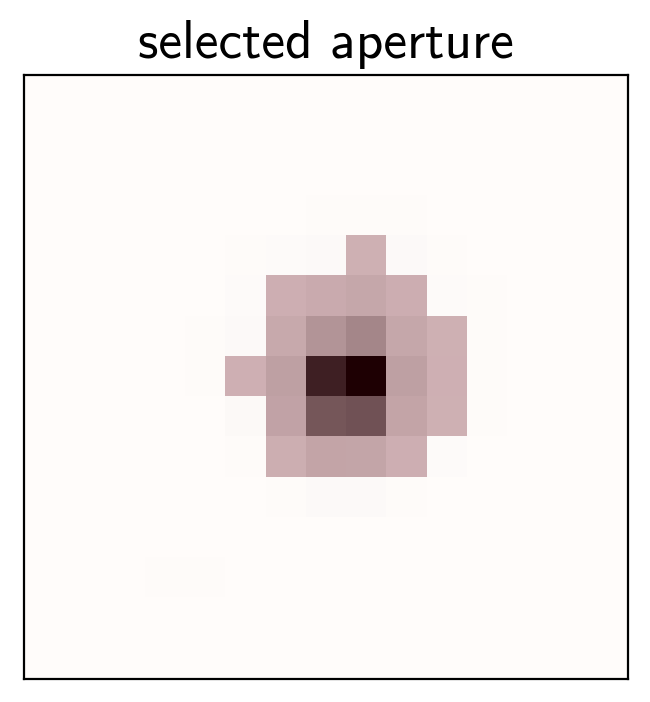

In [5]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(1, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

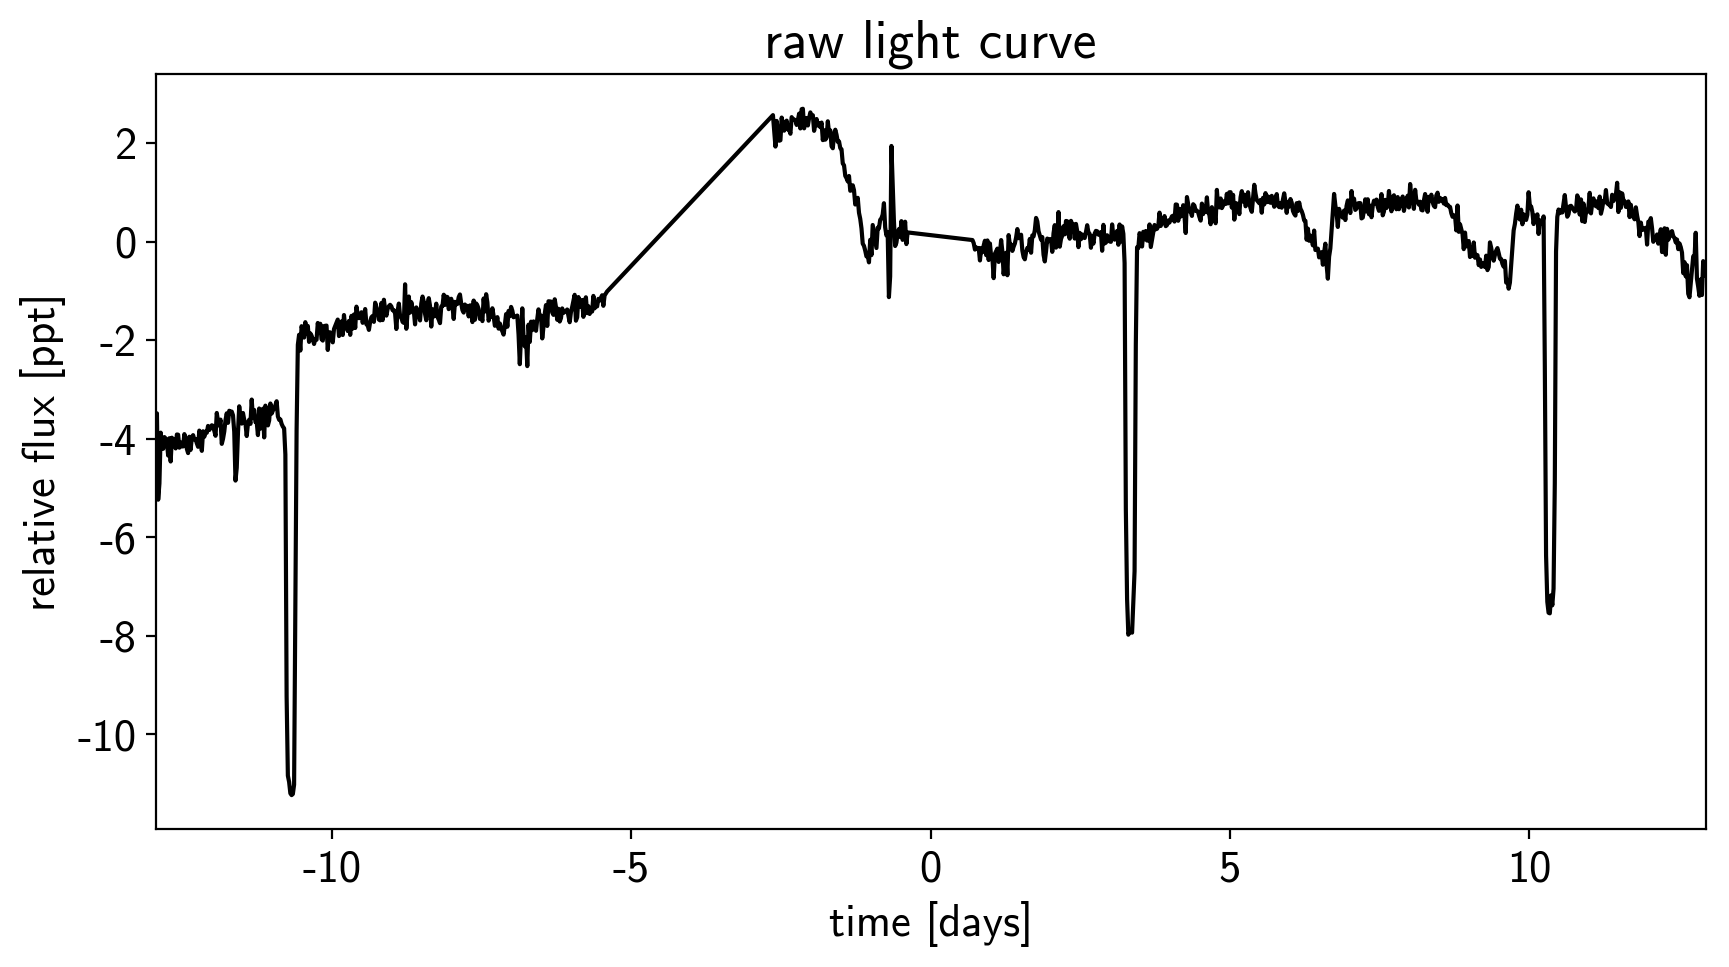

In [6]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

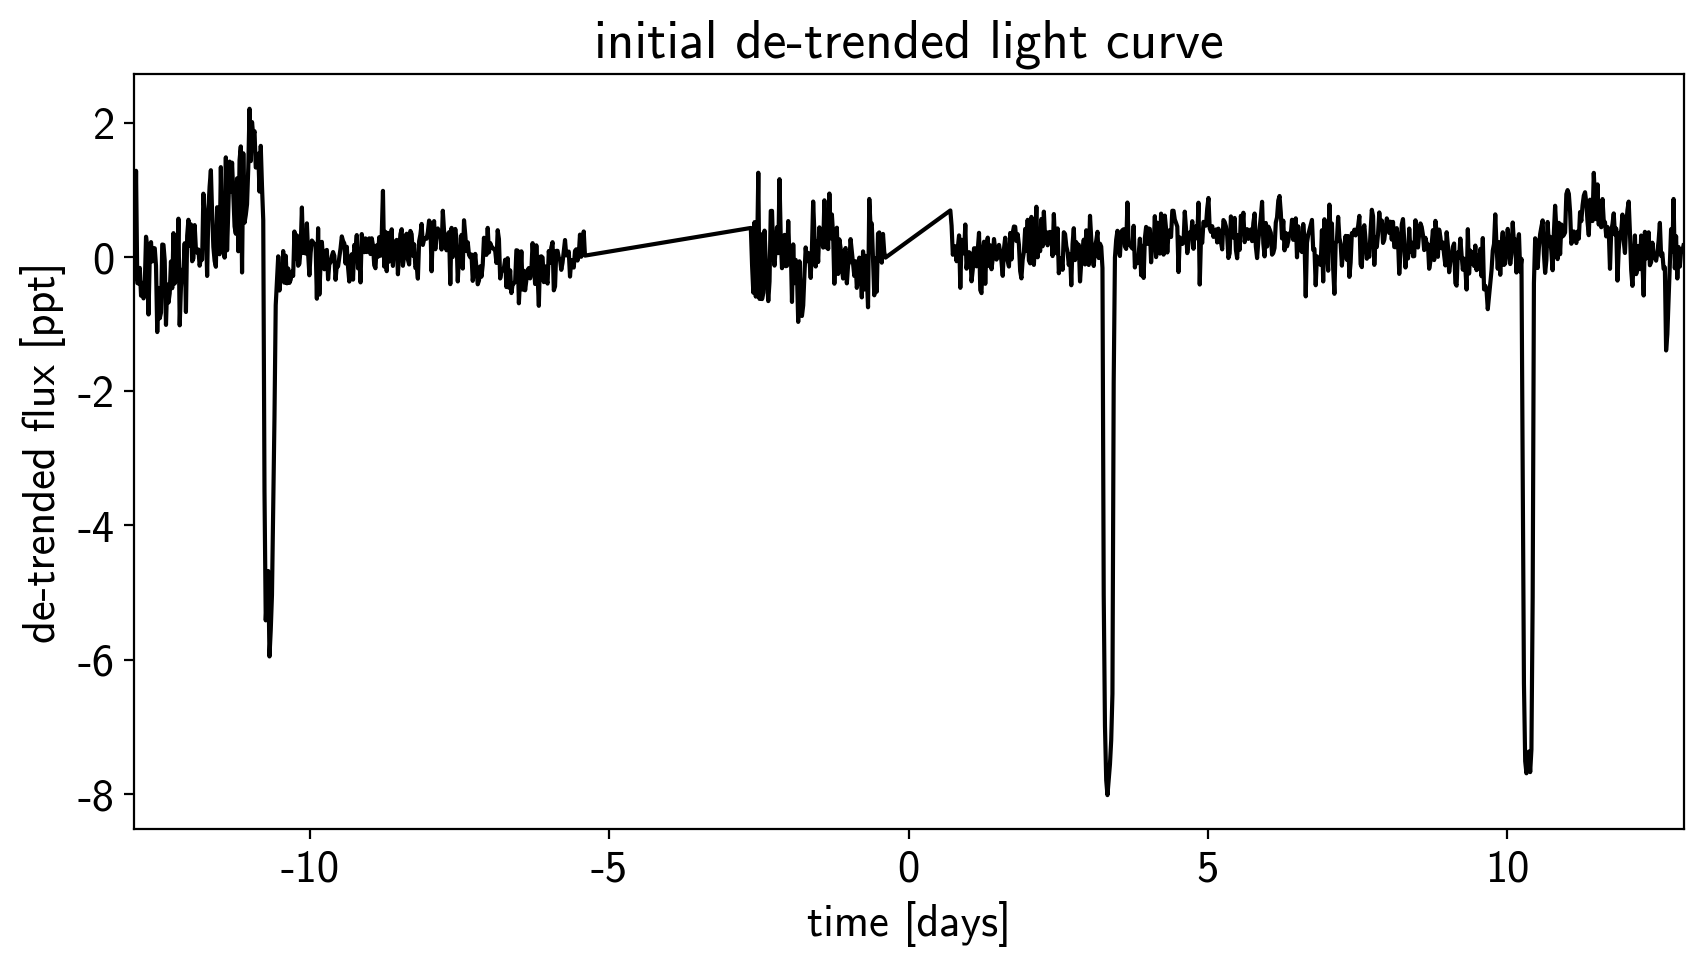

In [7]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

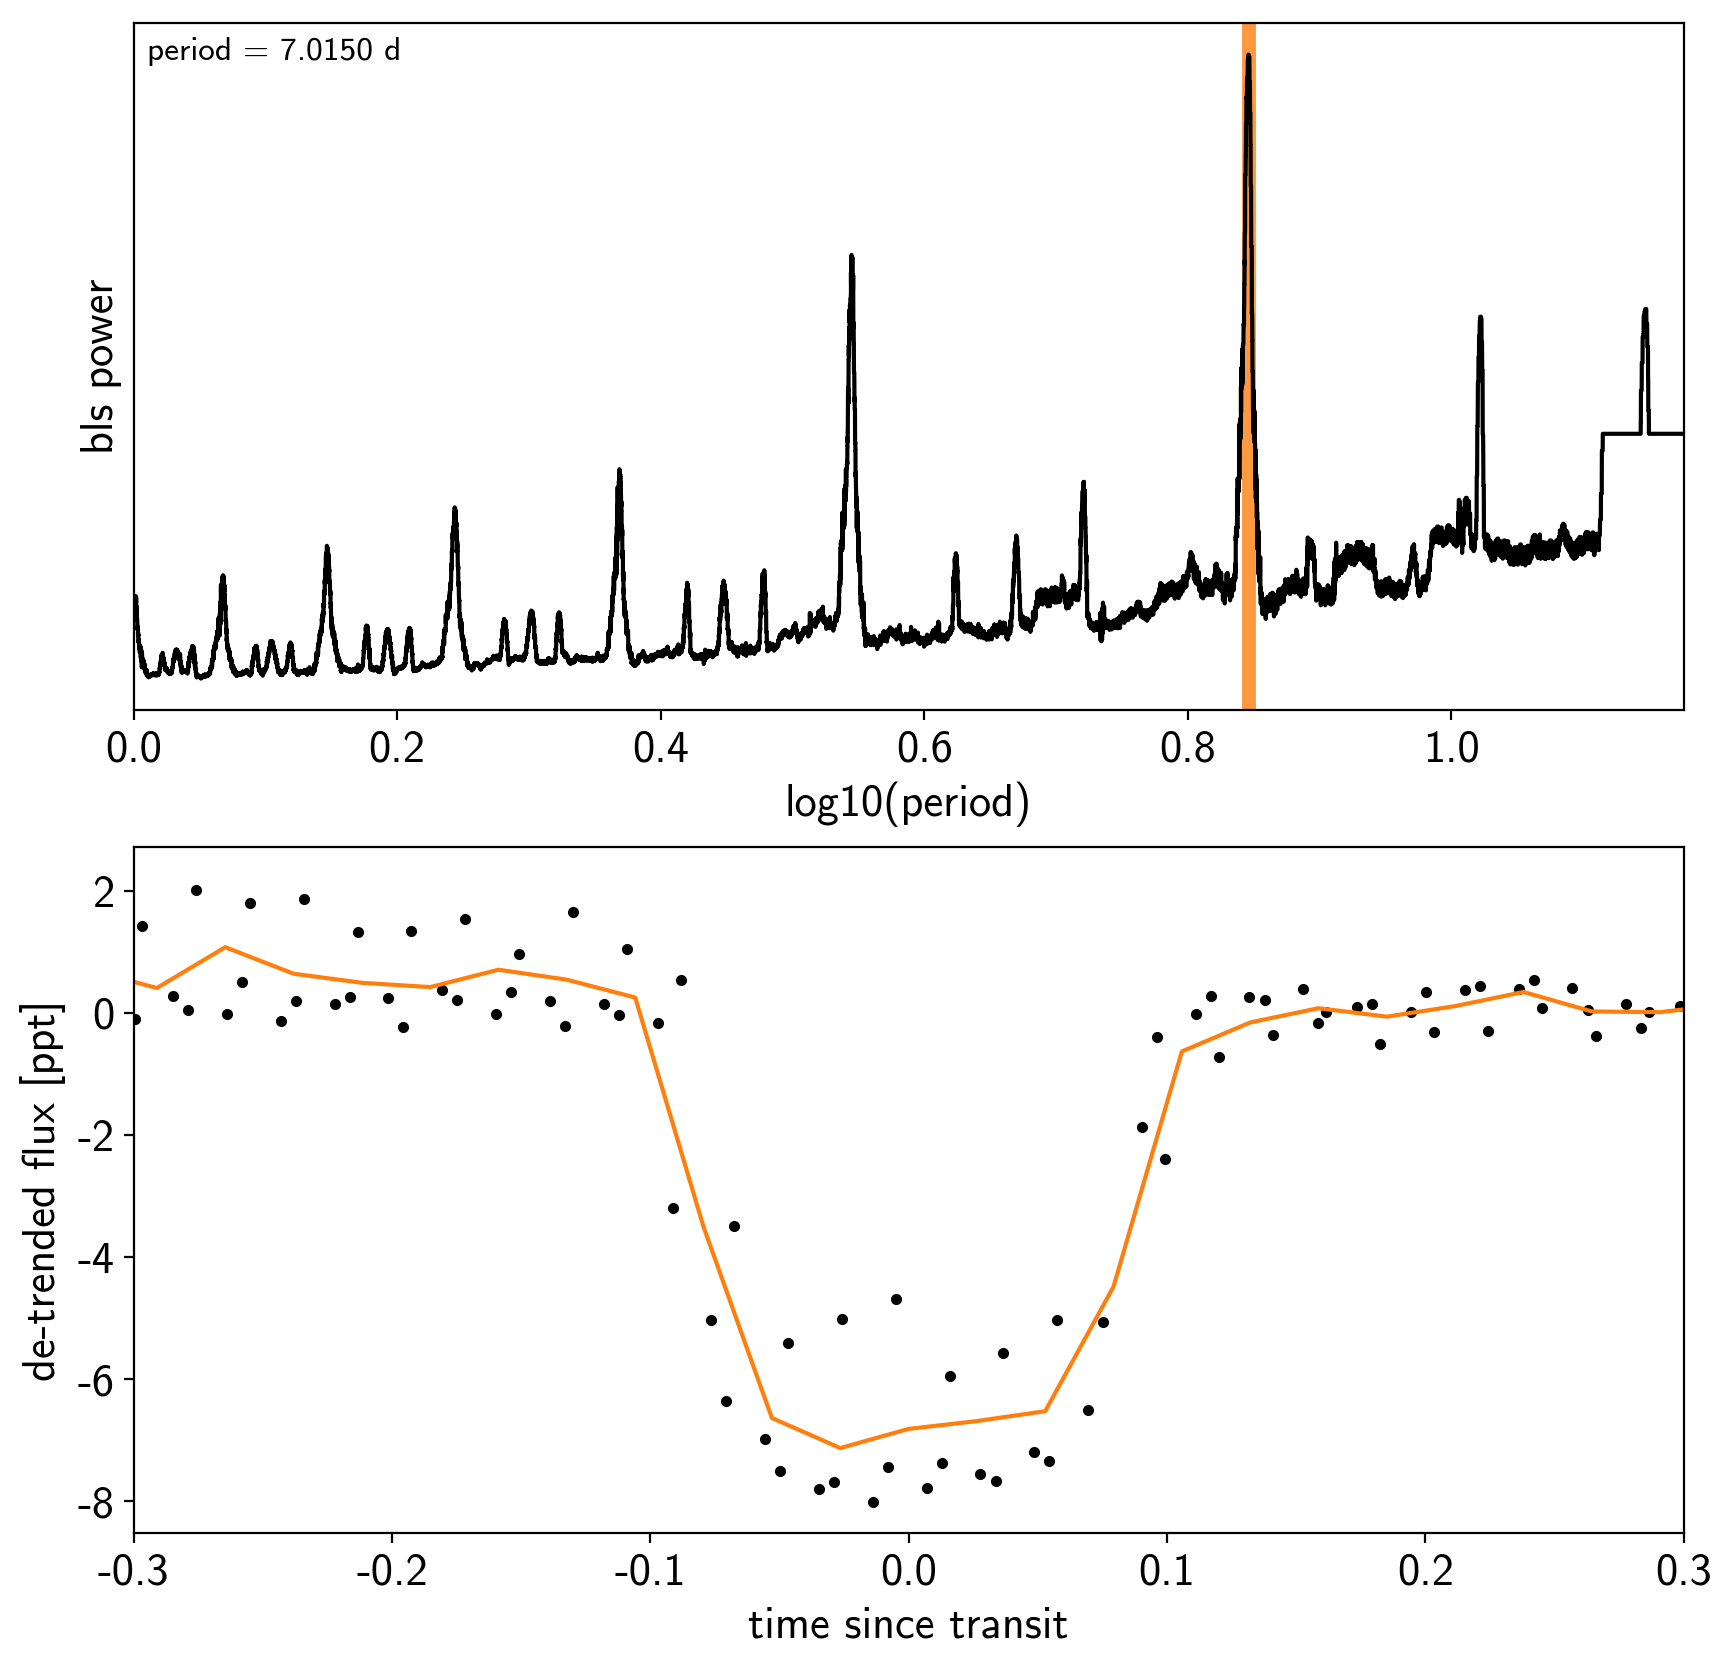

In [8]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

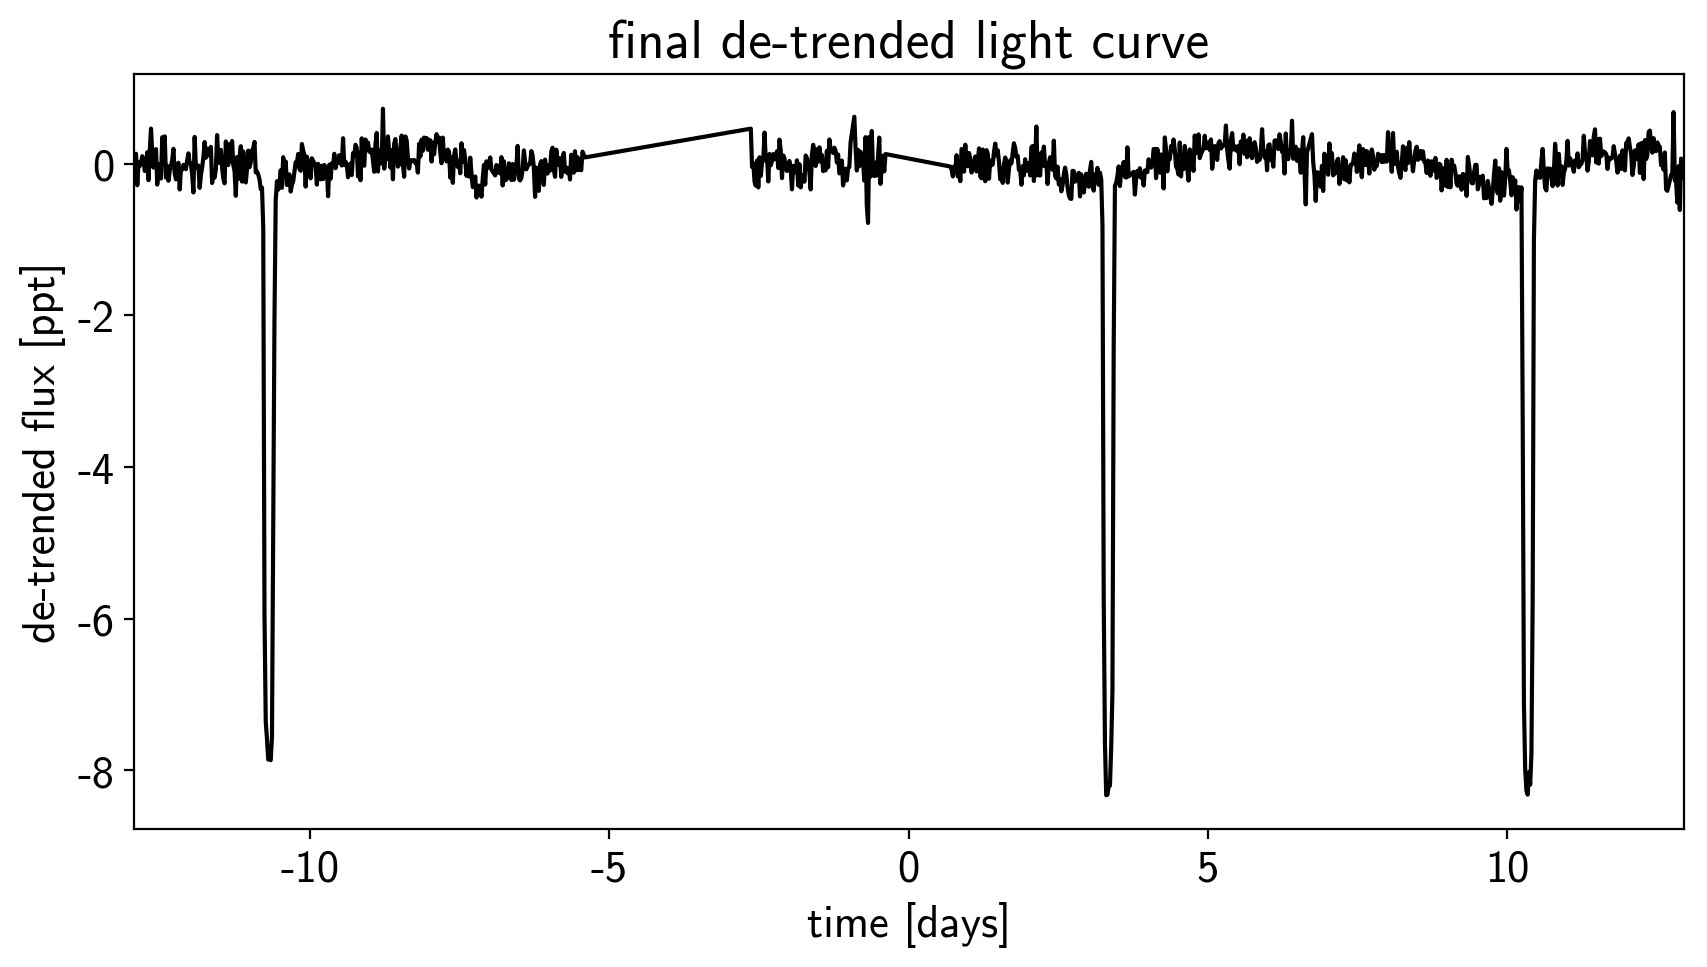

In [9]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from TIC
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        m_star = pm.Normal("m_star", mu=tic_mass[0], sd=tic_mass[1])
        r_star = pm.Normal("r_star", mu=tic_radius[0], sd=tic_radius[1])

        # Prior to require physical parameters
        pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        b = pm.Uniform("b", lower=0, upper=1, testval=0.5)
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(tic_radius[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, testval=0.1)
        omega = xo.distributions.Angle("omega")

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)
        pm.Deterministic("a", orbit.a_planet)
        pm.Deterministic("incl", orbit.incl)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

success: True
initial logp: -1167.6557023812284
final logp: -1163.8592611041797


success: True
initial logp: -1163.8592611041797
final logp: 148.09026302750706


success: True
initial logp: 148.09026302750706
final logp: 159.9809482383613


success: False
initial logp: 159.9809482383613
final logp: 323.1739620801429


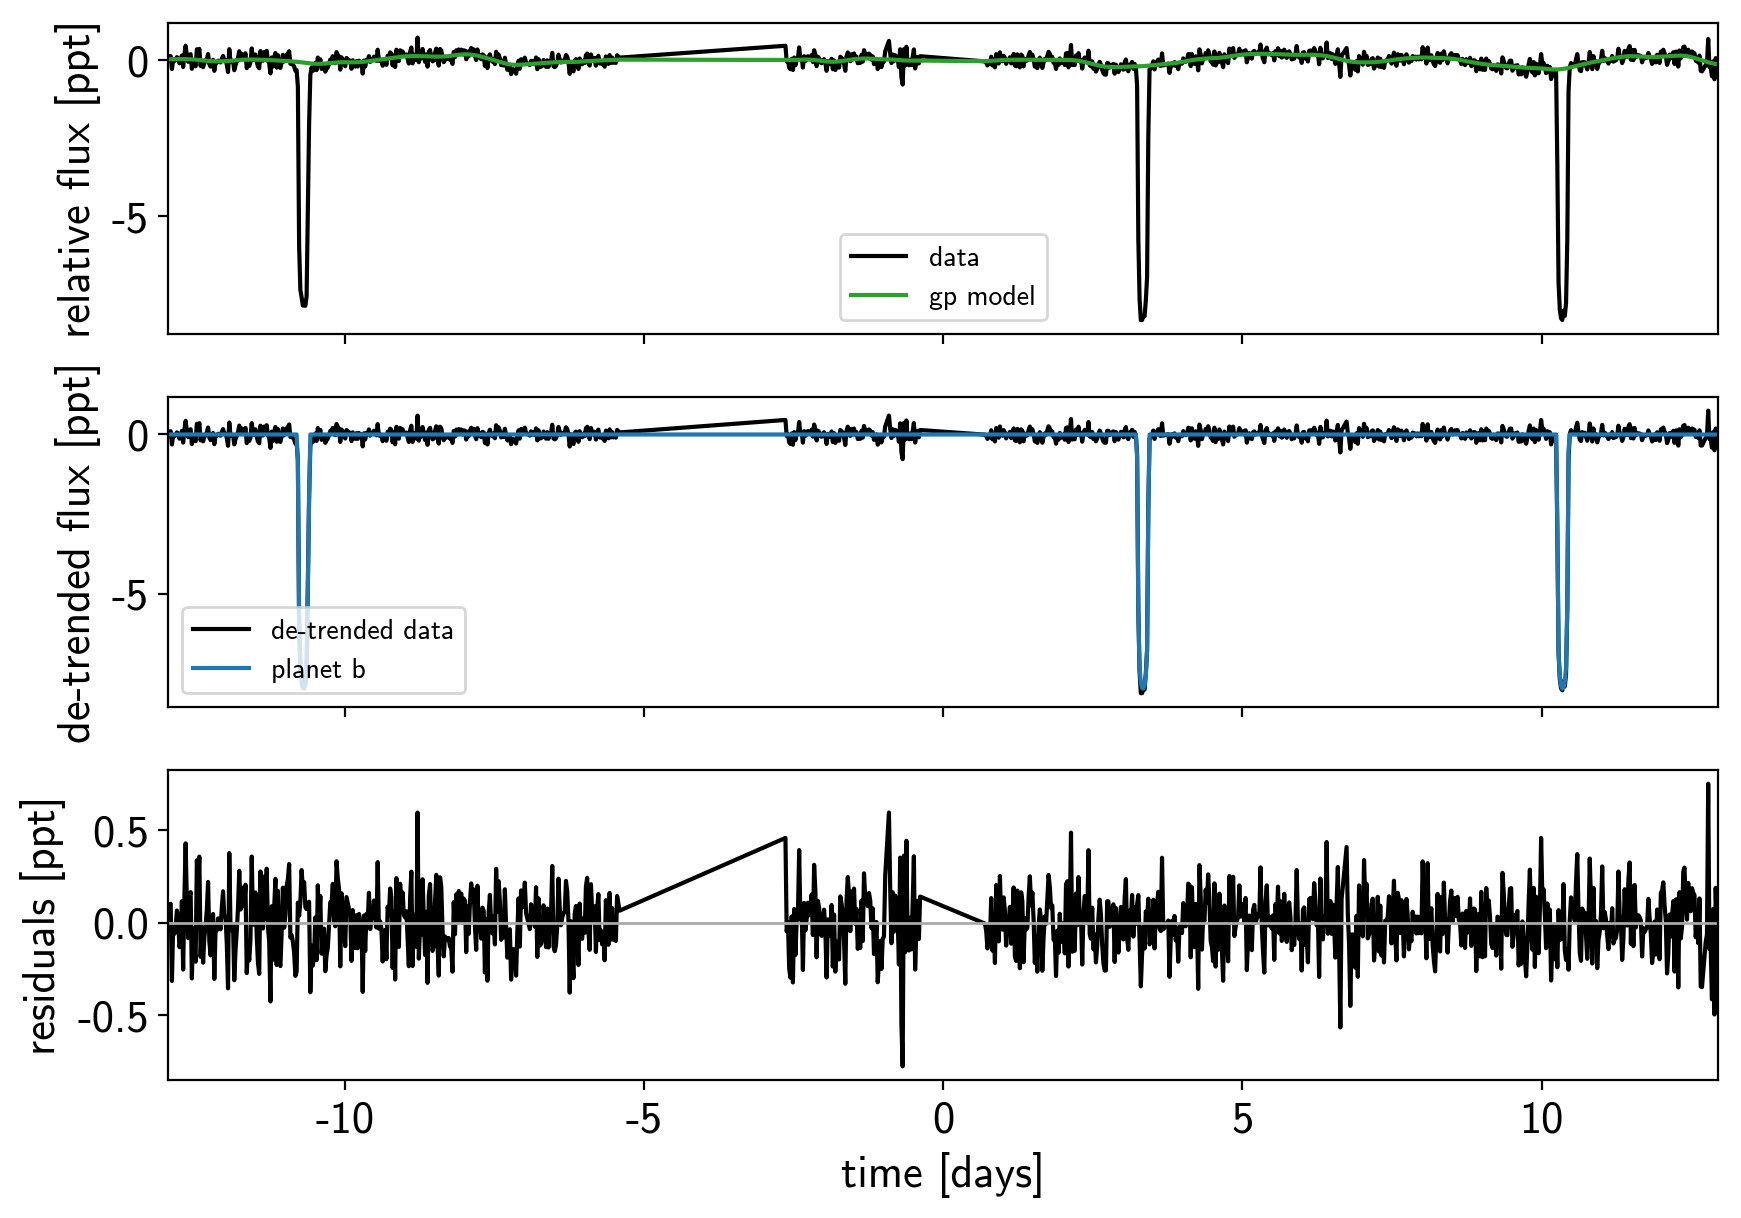

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

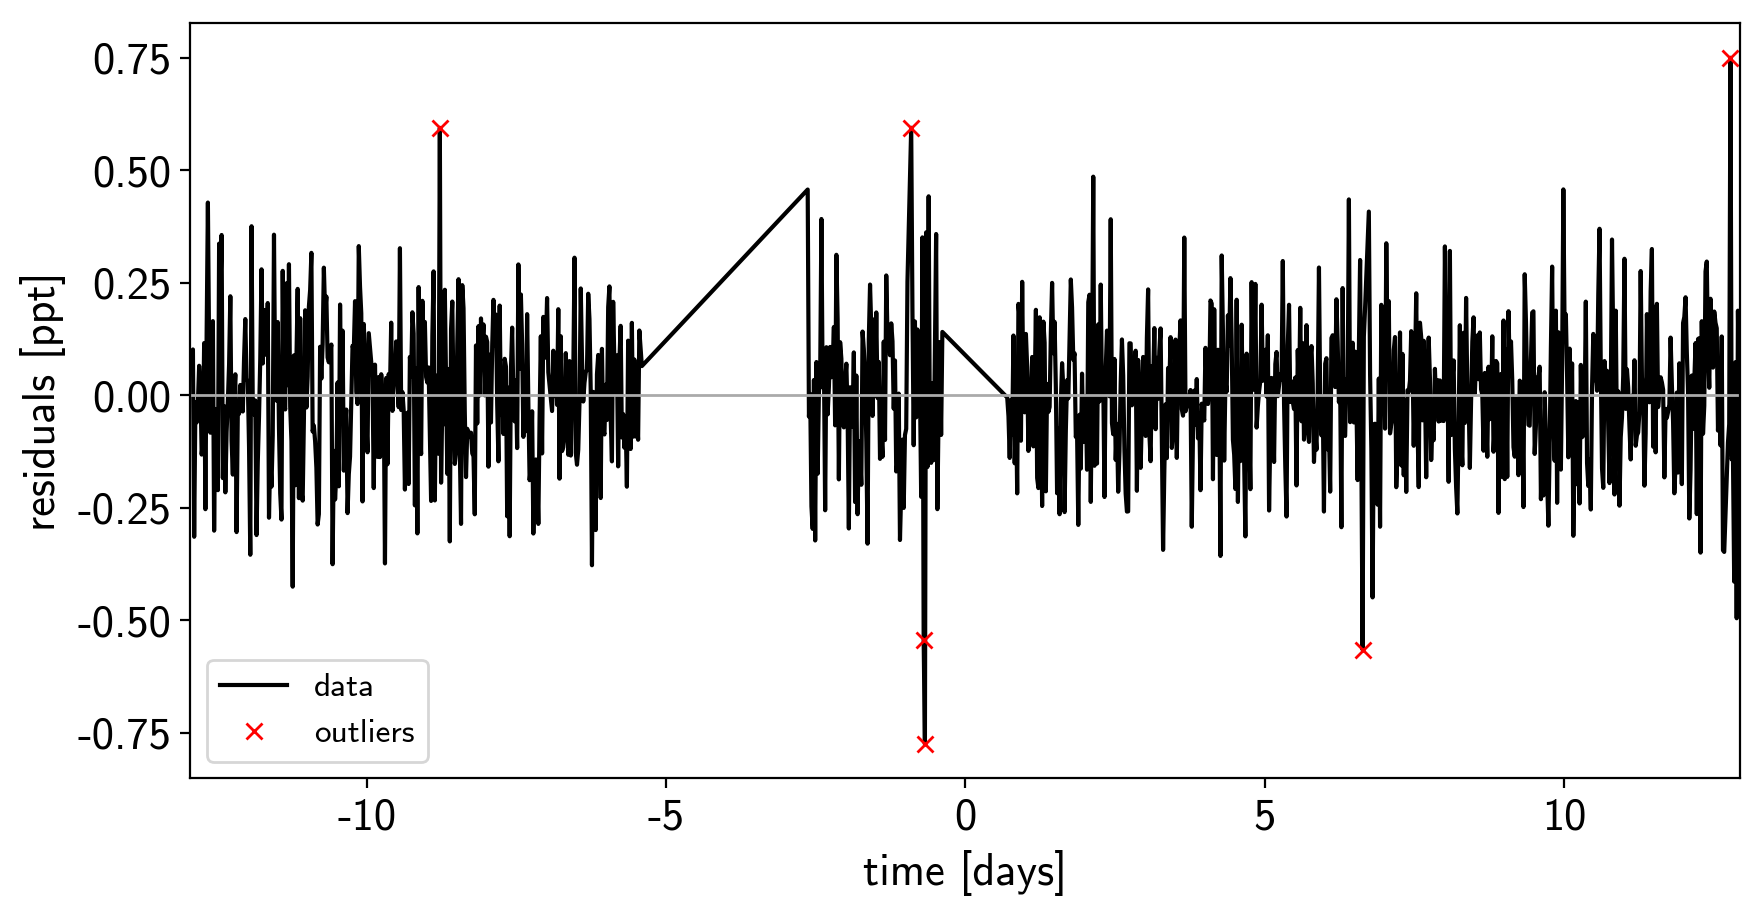

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

success: True
initial logp: 365.57574872950465
final logp: 365.5757487308136


success: True
initial logp: 365.57574873081336
final logp: 368.4569827339267


success: True
initial logp: 368.4569827339267
final logp: 368.4775862749864


success: False
initial logp: 368.4775862749873
final logp: 368.4880970288808


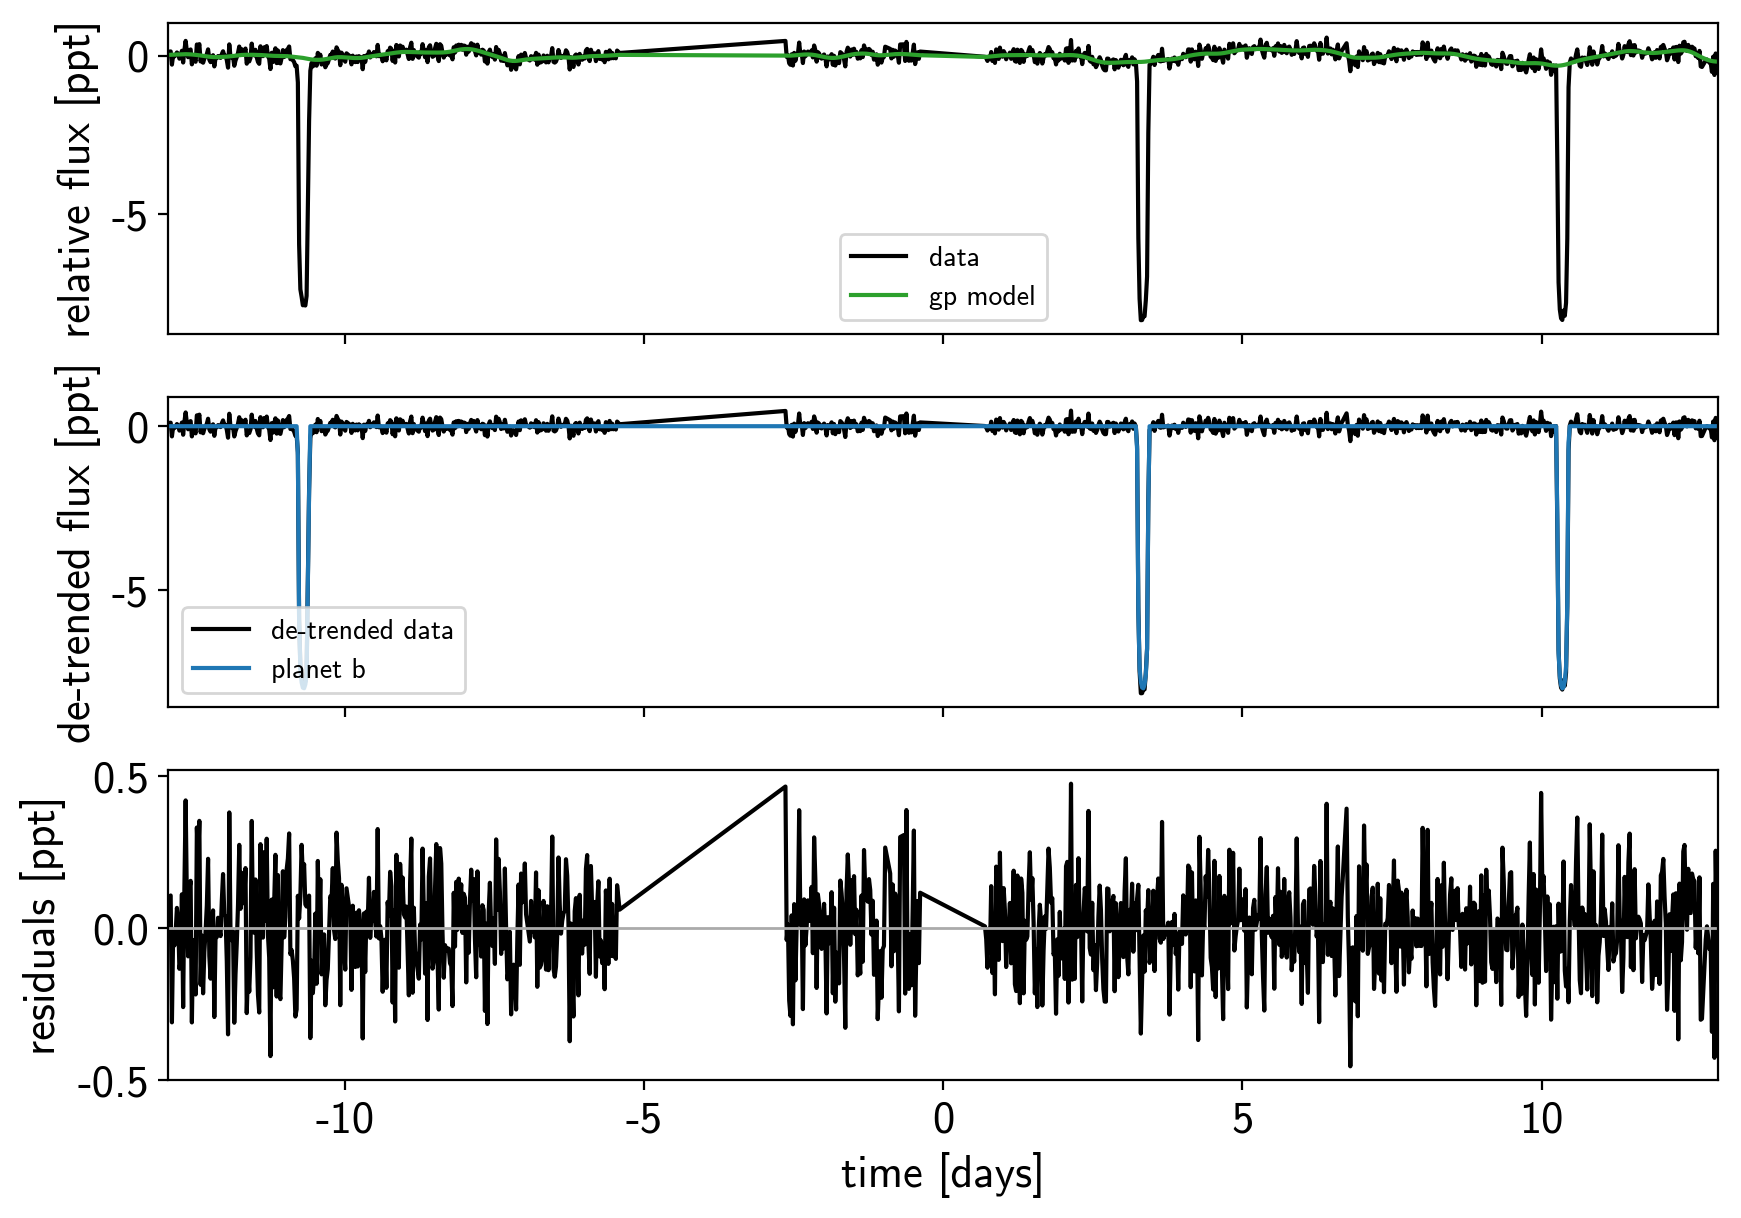

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

In [14]:
np.random.seed(12345)
sampler = xo.PyMC3Sampler(window=100, start=300, finish=500)
with model:
    burnin = sampler.tune(tune=3500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=4)

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 25/1208 [00:00<00:18, 65.12draws/s]

Sampling 4 chains:   2%|▏         | 29/1208 [00:00<00:40, 28.88draws/s]

Sampling 4 chains:   3%|▎         | 33/1208 [00:00<00:41, 28.43draws/s]

Sampling 4 chains:   3%|▎         | 36/1208 [00:01<00:51, 22.86draws/s]

Sampling 4 chains:   3%|▎         | 38/1208 [00:01<01:27, 13.39draws/s]

Sampling 4 chains:   3%|▎         | 41/1208 [00:01<01:19, 14.69draws/s]

Sampling 4 chains:   4%|▎         | 43/1208 [00:01<01:26, 13.52draws/s]

Sampling 4 chains:   4%|▎         | 45/1208 [00:01<01:25, 13.57draws/s]

Sampling 4 chains:   4%|▍         | 47/1208 [00:01<01:30, 12.87draws/s]

Sampling 4 chains:   4%|▍         | 49/1208 [00:02<01:28, 13.08draws/s]

Sampling 4 chains:   4%|▍         | 51/1208 [00:02<01:31, 12.58draws/s]

Sampling 4 chains:   4%|▍         | 53/1208 [00:02<01:26, 13.35draws/s]

Sampling 4 chains:   5%|▍         | 55/1208 [00:02<01:33, 12.32draws/s]

Sampling 4 chains:   5%|▍         | 57/1208 [00:02<01:26, 13.29draws/s]

Sampling 4 chains:   5%|▍         | 60/1208 [00:02<01:25, 13.43draws/s]

Sampling 4 chains:   5%|▌         | 62/1208 [00:03<01:21, 13.98draws/s]

Sampling 4 chains:   5%|▌         | 64/1208 [00:03<01:30, 12.69draws/s]

Sampling 4 chains:   5%|▌         | 66/1208 [00:03<01:28, 12.84draws/s]

Sampling 4 chains:   6%|▌         | 68/1208 [00:03<01:34, 12.12draws/s]

Sampling 4 chains:   6%|▌         | 70/1208 [00:03<01:28, 12.81draws/s]

Sampling 4 chains:   6%|▌         | 72/1208 [00:03<01:33, 12.20draws/s]

Sampling 4 chains:   6%|▌         | 74/1208 [00:04<01:29, 12.73draws/s]

Sampling 4 chains:   6%|▋         | 76/1208 [00:04<01:32, 12.28draws/s]

Sampling 4 chains:   6%|▋         | 78/1208 [00:04<01:29, 12.62draws/s]

Sampling 4 chains:   7%|▋         | 80/1208 [00:04<01:30, 12.41draws/s]

Sampling 4 chains:   7%|▋         | 82/1208 [00:04<01:29, 12.57draws/s]

Sampling 4 chains:   7%|▋         | 84/1208 [00:04<01:30, 12.49draws/s]

Sampling 4 chains:   7%|▋         | 86/1208 [00:05<01:32, 12.18draws/s]

Sampling 4 chains:   7%|▋         | 88/1208 [00:05<01:29, 12.53draws/s]

Sampling 4 chains:   7%|▋         | 90/1208 [00:05<01:31, 12.17draws/s]

Sampling 4 chains:   8%|▊         | 92/1208 [00:05<01:28, 12.60draws/s]

Sampling 4 chains:   8%|▊         | 94/1208 [00:05<01:31, 12.20draws/s]

Sampling 4 chains:   8%|▊         | 96/1208 [00:05<01:27, 12.72draws/s]

Sampling 4 chains:   8%|▊         | 98/1208 [00:06<01:33, 11.87draws/s]

Sampling 4 chains:   8%|▊         | 100/1208 [00:06<01:25, 12.99draws/s]

Sampling 4 chains:   8%|▊         | 102/1208 [00:06<01:34, 11.73draws/s]

Sampling 4 chains:   9%|▊         | 104/1208 [00:06<01:25, 12.84draws/s]

Sampling 4 chains:   9%|▉         | 106/1208 [00:06<01:33, 11.85draws/s]

Sampling 4 chains:   9%|▉         | 108/1208 [00:06<01:24, 13.08draws/s]

Sampling 4 chains:   9%|▉         | 110/1208 [00:07<01:32, 11.87draws/s]

Sampling 4 chains:   9%|▉         | 112/1208 [00:07<01:23, 13.11draws/s]

Sampling 4 chains:   9%|▉         | 114/1208 [00:07<01:34, 11.56draws/s]

Sampling 4 chains:  10%|▉         | 117/1208 [00:07<01:34, 11.54draws/s]

Sampling 4 chains:  10%|█         | 121/1208 [00:07<01:18, 13.90draws/s]

Sampling 4 chains:  10%|█         | 123/1208 [00:08<01:32, 11.72draws/s]

Sampling 4 chains:  10%|█         | 126/1208 [00:08<01:35, 11.34draws/s]

Sampling 4 chains:  11%|█         | 129/1208 [00:08<01:20, 13.43draws/s]

Sampling 4 chains:  11%|█         | 131/1208 [00:08<01:33, 11.49draws/s]

Sampling 4 chains:  11%|█         | 135/1208 [00:08<01:29, 11.96draws/s]

Sampling 4 chains:  12%|█▏        | 139/1208 [00:09<01:29, 11.97draws/s]

Sampling 4 chains:  12%|█▏        | 143/1208 [00:09<01:21, 13.05draws/s]

Sampling 4 chains:  12%|█▏        | 146/1208 [00:09<01:08, 15.50draws/s]

Sampling 4 chains:  12%|█▏        | 148/1208 [00:09<01:34, 11.24draws/s]

Sampling 4 chains:  12%|█▎        | 151/1208 [00:10<01:29, 11.76draws/s]

Sampling 4 chains:  13%|█▎        | 153/1208 [00:10<01:21, 12.87draws/s]

Sampling 4 chains:  13%|█▎        | 155/1208 [00:10<01:27, 11.98draws/s]

Sampling 4 chains:  13%|█▎        | 157/1208 [00:10<01:22, 12.77draws/s]

Sampling 4 chains:  13%|█▎        | 159/1208 [00:10<01:26, 12.18draws/s]

Sampling 4 chains:  13%|█▎        | 161/1208 [00:10<01:21, 12.77draws/s]

Sampling 4 chains:  13%|█▎        | 163/1208 [00:11<01:24, 12.34draws/s]

Sampling 4 chains:  14%|█▎        | 165/1208 [00:11<01:21, 12.73draws/s]

Sampling 4 chains:  14%|█▍        | 167/1208 [00:11<01:25, 12.12draws/s]

Sampling 4 chains:  14%|█▍        | 170/1208 [00:11<01:10, 14.73draws/s]

Sampling 4 chains:  14%|█▍        | 172/1208 [00:11<01:22, 12.55draws/s]

Sampling 4 chains:  14%|█▍        | 174/1208 [00:11<01:15, 13.66draws/s]

Sampling 4 chains:  15%|█▍        | 176/1208 [00:12<01:23, 12.36draws/s]

Sampling 4 chains:  15%|█▍        | 178/1208 [00:12<01:19, 13.00draws/s]

Sampling 4 chains:  15%|█▍        | 180/1208 [00:12<01:23, 12.30draws/s]

Sampling 4 chains:  15%|█▌        | 182/1208 [00:12<01:21, 12.65draws/s]

Sampling 4 chains:  15%|█▌        | 184/1208 [00:12<01:22, 12.45draws/s]

Sampling 4 chains:  15%|█▌        | 186/1208 [00:12<01:23, 12.30draws/s]

Sampling 4 chains:  16%|█▌        | 188/1208 [00:13<01:20, 12.65draws/s]

Sampling 4 chains:  16%|█▌        | 190/1208 [00:13<01:24, 12.08draws/s]

Sampling 4 chains:  16%|█▌        | 192/1208 [00:13<01:19, 12.74draws/s]

Sampling 4 chains:  16%|█▌        | 194/1208 [00:13<01:23, 12.13draws/s]

Sampling 4 chains:  16%|█▌        | 196/1208 [00:13<01:18, 12.92draws/s]

Sampling 4 chains:  16%|█▋        | 198/1208 [00:13<01:23, 12.12draws/s]

Sampling 4 chains:  17%|█▋        | 200/1208 [00:13<01:17, 13.04draws/s]

Sampling 4 chains:  17%|█▋        | 202/1208 [00:14<01:09, 14.39draws/s]

Sampling 4 chains:  17%|█▋        | 204/1208 [00:14<01:06, 15.00draws/s]

Sampling 4 chains:  17%|█▋        | 206/1208 [00:14<01:16, 13.14draws/s]

Sampling 4 chains:  17%|█▋        | 208/1208 [00:14<01:13, 13.63draws/s]

Sampling 4 chains:  17%|█▋        | 210/1208 [00:14<01:18, 12.72draws/s]

Sampling 4 chains:  18%|█▊        | 212/1208 [00:14<01:16, 12.94draws/s]

Sampling 4 chains:  18%|█▊        | 214/1208 [00:15<01:18, 12.63draws/s]

Sampling 4 chains:  18%|█▊        | 216/1208 [00:15<01:11, 13.90draws/s]

Sampling 4 chains:  18%|█▊        | 218/1208 [00:15<01:05, 15.11draws/s]

Sampling 4 chains:  18%|█▊        | 220/1208 [00:15<01:17, 12.73draws/s]

Sampling 4 chains:  18%|█▊        | 223/1208 [00:15<01:14, 13.19draws/s]

Sampling 4 chains:  19%|█▊        | 225/1208 [00:15<01:20, 12.24draws/s]

Sampling 4 chains:  19%|█▉        | 227/1208 [00:15<01:14, 13.09draws/s]

Sampling 4 chains:  19%|█▉        | 229/1208 [00:16<01:22, 11.87draws/s]

Sampling 4 chains:  19%|█▉        | 231/1208 [00:16<01:14, 13.08draws/s]

Sampling 4 chains:  19%|█▉        | 233/1208 [00:16<01:22, 11.79draws/s]

Sampling 4 chains:  20%|█▉        | 236/1208 [00:16<01:08, 14.20draws/s]

Sampling 4 chains:  20%|█▉        | 238/1208 [00:16<01:17, 12.45draws/s]

Sampling 4 chains:  20%|█▉        | 240/1208 [00:16<01:10, 13.74draws/s]

Sampling 4 chains:  20%|██        | 242/1208 [00:17<01:18, 12.25draws/s]

Sampling 4 chains:  20%|██        | 244/1208 [00:17<01:11, 13.53draws/s]

Sampling 4 chains:  20%|██        | 246/1208 [00:17<01:19, 12.15draws/s]

Sampling 4 chains:  21%|██        | 248/1208 [00:17<01:11, 13.44draws/s]

Sampling 4 chains:  21%|██        | 250/1208 [00:17<01:18, 12.14draws/s]

Sampling 4 chains:  21%|██        | 252/1208 [00:17<01:11, 13.37draws/s]

Sampling 4 chains:  21%|██        | 254/1208 [00:18<01:18, 12.13draws/s]

Sampling 4 chains:  21%|██        | 256/1208 [00:18<01:11, 13.33draws/s]

Sampling 4 chains:  21%|██▏       | 258/1208 [00:18<01:12, 13.17draws/s]

Sampling 4 chains:  22%|██▏       | 260/1208 [00:18<01:13, 12.97draws/s]

Sampling 4 chains:  22%|██▏       | 262/1208 [00:18<01:15, 12.60draws/s]

Sampling 4 chains:  22%|██▏       | 264/1208 [00:18<01:13, 12.82draws/s]

Sampling 4 chains:  22%|██▏       | 266/1208 [00:19<01:17, 12.20draws/s]

Sampling 4 chains:  22%|██▏       | 268/1208 [00:19<01:12, 12.92draws/s]

Sampling 4 chains:  22%|██▏       | 270/1208 [00:19<01:18, 12.01draws/s]

Sampling 4 chains:  23%|██▎       | 272/1208 [00:19<01:11, 13.06draws/s]

Sampling 4 chains:  23%|██▎       | 274/1208 [00:19<01:17, 12.13draws/s]

Sampling 4 chains:  23%|██▎       | 276/1208 [00:19<01:07, 13.75draws/s]

Sampling 4 chains:  23%|██▎       | 278/1208 [00:19<01:14, 12.56draws/s]

Sampling 4 chains:  23%|██▎       | 280/1208 [00:20<01:11, 13.03draws/s]

Sampling 4 chains:  23%|██▎       | 282/1208 [00:20<01:14, 12.39draws/s]

Sampling 4 chains:  24%|██▎       | 284/1208 [00:20<01:12, 12.83draws/s]

Sampling 4 chains:  24%|██▎       | 286/1208 [00:20<01:14, 12.33draws/s]

Sampling 4 chains:  24%|██▍       | 288/1208 [00:20<01:11, 12.89draws/s]

Sampling 4 chains:  24%|██▍       | 290/1208 [00:20<01:14, 12.27draws/s]

Sampling 4 chains:  24%|██▍       | 292/1208 [00:21<01:10, 12.94draws/s]

Sampling 4 chains:  24%|██▍       | 294/1208 [00:21<01:14, 12.22draws/s]

Sampling 4 chains:  25%|██▍       | 296/1208 [00:21<01:10, 13.00draws/s]

Sampling 4 chains:  25%|██▍       | 298/1208 [00:21<01:14, 12.29draws/s]

Sampling 4 chains:  25%|██▍       | 300/1208 [00:21<01:09, 13.02draws/s]

Sampling 4 chains:  25%|██▌       | 302/1208 [00:21<01:13, 12.34draws/s]

Sampling 4 chains:  25%|██▌       | 304/1208 [00:21<01:09, 13.02draws/s]

Sampling 4 chains:  25%|██▌       | 306/1208 [00:22<01:12, 12.38draws/s]

Sampling 4 chains:  25%|██▌       | 308/1208 [00:22<01:09, 12.89draws/s]

Sampling 4 chains:  26%|██▌       | 310/1208 [00:22<01:12, 12.43draws/s]

Sampling 4 chains:  26%|██▌       | 312/1208 [00:22<01:09, 12.89draws/s]

Sampling 4 chains:  26%|██▌       | 314/1208 [00:22<01:11, 12.47draws/s]

Sampling 4 chains:  26%|██▌       | 316/1208 [00:22<01:09, 12.89draws/s]

Sampling 4 chains:  26%|██▋       | 318/1208 [00:23<01:11, 12.38draws/s]

Sampling 4 chains:  26%|██▋       | 320/1208 [00:23<01:08, 12.92draws/s]

Sampling 4 chains:  27%|██▋       | 322/1208 [00:23<01:11, 12.43draws/s]

Sampling 4 chains:  27%|██▋       | 324/1208 [00:23<01:08, 12.91draws/s]

Sampling 4 chains:  27%|██▋       | 326/1208 [00:23<01:11, 12.30draws/s]

Sampling 4 chains:  27%|██▋       | 328/1208 [00:23<01:07, 12.94draws/s]

Sampling 4 chains:  27%|██▋       | 330/1208 [00:24<01:12, 12.03draws/s]

Sampling 4 chains:  27%|██▋       | 332/1208 [00:24<01:07, 13.06draws/s]

Sampling 4 chains:  28%|██▊       | 334/1208 [00:24<01:14, 11.80draws/s]

Sampling 4 chains:  28%|██▊       | 336/1208 [00:24<01:05, 13.22draws/s]

Sampling 4 chains:  28%|██▊       | 338/1208 [00:24<01:15, 11.57draws/s]

Sampling 4 chains:  28%|██▊       | 341/1208 [00:24<01:14, 11.59draws/s]

Sampling 4 chains:  28%|██▊       | 344/1208 [00:25<01:05, 13.25draws/s]

Sampling 4 chains:  29%|██▊       | 346/1208 [00:25<01:15, 11.35draws/s]

Sampling 4 chains:  29%|██▉       | 349/1208 [00:25<01:13, 11.65draws/s]

Sampling 4 chains:  29%|██▉       | 351/1208 [00:25<01:05, 13.12draws/s]

Sampling 4 chains:  29%|██▉       | 353/1208 [00:25<01:12, 11.86draws/s]

Sampling 4 chains:  29%|██▉       | 355/1208 [00:26<01:06, 12.80draws/s]

Sampling 4 chains:  30%|██▉       | 357/1208 [00:26<01:10, 12.09draws/s]

Sampling 4 chains:  30%|██▉       | 359/1208 [00:26<01:07, 12.63draws/s]

Sampling 4 chains:  30%|██▉       | 361/1208 [00:26<01:08, 12.31draws/s]

Sampling 4 chains:  30%|███       | 363/1208 [00:26<01:07, 12.45draws/s]

Sampling 4 chains:  30%|███       | 365/1208 [00:26<01:07, 12.52draws/s]

Sampling 4 chains:  30%|███       | 367/1208 [00:27<01:08, 12.37draws/s]

Sampling 4 chains:  31%|███       | 369/1208 [00:27<01:06, 12.63draws/s]

Sampling 4 chains:  31%|███       | 371/1208 [00:27<01:07, 12.48draws/s]

Sampling 4 chains:  31%|███       | 373/1208 [00:27<01:05, 12.75draws/s]

Sampling 4 chains:  31%|███       | 375/1208 [00:27<01:06, 12.51draws/s]

Sampling 4 chains:  31%|███       | 377/1208 [00:27<01:04, 12.83draws/s]

Sampling 4 chains:  31%|███▏      | 379/1208 [00:27<01:06, 12.51draws/s]

Sampling 4 chains:  32%|███▏      | 381/1208 [00:28<01:04, 12.88draws/s]

Sampling 4 chains:  32%|███▏      | 383/1208 [00:28<01:06, 12.49draws/s]

Sampling 4 chains:  32%|███▏      | 385/1208 [00:28<01:03, 12.93draws/s]

Sampling 4 chains:  32%|███▏      | 387/1208 [00:28<01:05, 12.47draws/s]

Sampling 4 chains:  32%|███▏      | 389/1208 [00:28<01:03, 12.96draws/s]

Sampling 4 chains:  32%|███▏      | 391/1208 [00:28<01:05, 12.45draws/s]

Sampling 4 chains:  33%|███▎      | 393/1208 [00:29<01:02, 13.00draws/s]

Sampling 4 chains:  33%|███▎      | 395/1208 [00:29<01:05, 12.43draws/s]

Sampling 4 chains:  33%|███▎      | 397/1208 [00:29<01:02, 13.02draws/s]

Sampling 4 chains:  33%|███▎      | 399/1208 [00:29<01:05, 12.41draws/s]

Sampling 4 chains:  33%|███▎      | 401/1208 [00:29<01:02, 12.88draws/s]

Sampling 4 chains:  33%|███▎      | 403/1208 [00:29<01:04, 12.42draws/s]

Sampling 4 chains:  34%|███▎      | 405/1208 [00:30<01:04, 12.48draws/s]

Sampling 4 chains:  34%|███▎      | 407/1208 [00:30<01:03, 12.56draws/s]

Sampling 4 chains:  34%|███▍      | 409/1208 [00:30<01:05, 12.20draws/s]

Sampling 4 chains:  34%|███▍      | 411/1208 [00:30<01:02, 12.74draws/s]

Sampling 4 chains:  34%|███▍      | 413/1208 [00:30<01:07, 11.84draws/s]

Sampling 4 chains:  34%|███▍      | 415/1208 [00:30<01:01, 13.00draws/s]

Sampling 4 chains:  35%|███▍      | 417/1208 [00:31<01:07, 11.63draws/s]

Sampling 4 chains:  35%|███▍      | 419/1208 [00:31<00:59, 13.25draws/s]

Sampling 4 chains:  35%|███▍      | 421/1208 [00:31<01:08, 11.45draws/s]

Sampling 4 chains:  35%|███▌      | 424/1208 [00:31<01:04, 12.19draws/s]

Sampling 4 chains:  35%|███▌      | 426/1208 [00:31<01:07, 11.61draws/s]

Sampling 4 chains:  35%|███▌      | 428/1208 [00:31<01:01, 12.72draws/s]

Sampling 4 chains:  36%|███▌      | 430/1208 [00:32<01:05, 11.82draws/s]

Sampling 4 chains:  36%|███▌      | 432/1208 [00:32<00:59, 13.04draws/s]

Sampling 4 chains:  36%|███▌      | 434/1208 [00:32<01:05, 11.90draws/s]

Sampling 4 chains:  36%|███▌      | 436/1208 [00:32<00:58, 13.24draws/s]

Sampling 4 chains:  36%|███▋      | 438/1208 [00:32<01:03, 12.15draws/s]

Sampling 4 chains:  37%|███▋      | 441/1208 [00:33<01:08, 11.26draws/s]

Sampling 4 chains:  37%|███▋      | 445/1208 [00:33<01:05, 11.64draws/s]

Sampling 4 chains:  37%|███▋      | 449/1208 [00:33<01:03, 11.90draws/s]

Sampling 4 chains:  38%|███▊      | 453/1208 [00:33<01:02, 12.14draws/s]

Sampling 4 chains:  38%|███▊      | 457/1208 [00:34<01:00, 12.31draws/s]

Sampling 4 chains:  38%|███▊      | 461/1208 [00:34<01:00, 12.44draws/s]

Sampling 4 chains:  38%|███▊      | 465/1208 [00:34<00:59, 12.52draws/s]

Sampling 4 chains:  39%|███▉      | 469/1208 [00:35<00:58, 12.59draws/s]

Sampling 4 chains:  39%|███▉      | 472/1208 [00:35<00:48, 15.16draws/s]

Sampling 4 chains:  39%|███▉      | 474/1208 [00:35<00:59, 12.38draws/s]

Sampling 4 chains:  39%|███▉      | 476/1208 [00:35<00:52, 13.96draws/s]

Sampling 4 chains:  40%|███▉      | 478/1208 [00:35<00:57, 12.63draws/s]

Sampling 4 chains:  40%|███▉      | 480/1208 [00:36<00:55, 13.16draws/s]

Sampling 4 chains:  40%|███▉      | 482/1208 [00:36<00:57, 12.55draws/s]

Sampling 4 chains:  40%|████      | 484/1208 [00:36<00:57, 12.65draws/s]

Sampling 4 chains:  40%|████      | 486/1208 [00:36<00:57, 12.62draws/s]

Sampling 4 chains:  40%|████      | 488/1208 [00:36<00:59, 12.15draws/s]

Sampling 4 chains:  41%|████      | 490/1208 [00:36<00:55, 12.84draws/s]

Sampling 4 chains:  41%|████      | 492/1208 [00:37<01:00, 11.92draws/s]

Sampling 4 chains:  41%|████      | 494/1208 [00:37<00:54, 13.09draws/s]

Sampling 4 chains:  41%|████      | 496/1208 [00:37<01:00, 11.68draws/s]

Sampling 4 chains:  41%|████▏     | 499/1208 [00:37<00:56, 12.52draws/s]

Sampling 4 chains:  41%|████▏     | 501/1208 [00:37<00:59, 11.80draws/s]

Sampling 4 chains:  42%|████▏     | 503/1208 [00:37<00:55, 12.77draws/s]

Sampling 4 chains:  42%|████▏     | 505/1208 [00:38<00:58, 12.03draws/s]

Sampling 4 chains:  42%|████▏     | 507/1208 [00:38<00:54, 12.86draws/s]

Sampling 4 chains:  42%|████▏     | 509/1208 [00:38<00:57, 12.16draws/s]

Sampling 4 chains:  42%|████▏     | 511/1208 [00:38<00:54, 12.89draws/s]

Sampling 4 chains:  42%|████▏     | 513/1208 [00:38<00:56, 12.23draws/s]

Sampling 4 chains:  43%|████▎     | 515/1208 [00:38<00:54, 12.70draws/s]

Sampling 4 chains:  43%|████▎     | 517/1208 [00:38<00:56, 12.29draws/s]

Sampling 4 chains:  43%|████▎     | 519/1208 [00:39<00:54, 12.72draws/s]

Sampling 4 chains:  43%|████▎     | 521/1208 [00:39<00:56, 12.17draws/s]

Sampling 4 chains:  43%|████▎     | 523/1208 [00:39<00:53, 12.78draws/s]

Sampling 4 chains:  43%|████▎     | 525/1208 [00:39<00:55, 12.33draws/s]

Sampling 4 chains:  44%|████▎     | 527/1208 [00:39<00:53, 12.77draws/s]

Sampling 4 chains:  44%|████▍     | 529/1208 [00:39<00:54, 12.44draws/s]

Sampling 4 chains:  44%|████▍     | 531/1208 [00:40<00:53, 12.72draws/s]

Sampling 4 chains:  44%|████▍     | 533/1208 [00:40<00:54, 12.46draws/s]

Sampling 4 chains:  44%|████▍     | 535/1208 [00:40<00:53, 12.68draws/s]

Sampling 4 chains:  44%|████▍     | 537/1208 [00:40<00:53, 12.56draws/s]

Sampling 4 chains:  45%|████▍     | 539/1208 [00:40<00:53, 12.62draws/s]

Sampling 4 chains:  45%|████▍     | 541/1208 [00:40<00:52, 12.65draws/s]

Sampling 4 chains:  45%|████▍     | 543/1208 [00:41<00:52, 12.56draws/s]

Sampling 4 chains:  45%|████▌     | 545/1208 [00:41<00:52, 12.74draws/s]

Sampling 4 chains:  45%|████▌     | 547/1208 [00:41<00:52, 12.49draws/s]

Sampling 4 chains:  45%|████▌     | 549/1208 [00:41<00:51, 12.82draws/s]

Sampling 4 chains:  46%|████▌     | 551/1208 [00:41<00:52, 12.42draws/s]

Sampling 4 chains:  46%|████▌     | 553/1208 [00:41<00:50, 12.88draws/s]

Sampling 4 chains:  46%|████▌     | 555/1208 [00:42<00:52, 12.35draws/s]

Sampling 4 chains:  46%|████▌     | 557/1208 [00:42<00:50, 12.92draws/s]

Sampling 4 chains:  46%|████▋     | 559/1208 [00:42<00:52, 12.29draws/s]

Sampling 4 chains:  46%|████▋     | 561/1208 [00:42<00:49, 13.00draws/s]

Sampling 4 chains:  47%|████▋     | 563/1208 [00:42<00:52, 12.23draws/s]

Sampling 4 chains:  47%|████▋     | 565/1208 [00:42<00:49, 13.08draws/s]

Sampling 4 chains:  47%|████▋     | 567/1208 [00:42<00:52, 12.17draws/s]

Sampling 4 chains:  47%|████▋     | 569/1208 [00:43<00:48, 13.12draws/s]

Sampling 4 chains:  47%|████▋     | 571/1208 [00:43<00:53, 11.94draws/s]

Sampling 4 chains:  47%|████▋     | 573/1208 [00:43<00:47, 13.23draws/s]

Sampling 4 chains:  48%|████▊     | 575/1208 [00:43<00:54, 11.70draws/s]

Sampling 4 chains:  48%|████▊     | 578/1208 [00:43<00:56, 11.13draws/s]

Sampling 4 chains:  48%|████▊     | 580/1208 [00:44<00:49, 12.74draws/s]

Sampling 4 chains:  48%|████▊     | 582/1208 [00:44<00:54, 11.47draws/s]

Sampling 4 chains:  48%|████▊     | 585/1208 [00:44<00:44, 13.88draws/s]

Sampling 4 chains:  49%|████▊     | 587/1208 [00:44<00:55, 11.12draws/s]

Sampling 4 chains:  49%|████▉     | 590/1208 [00:44<00:55, 11.17draws/s]

Sampling 4 chains:  49%|████▉     | 593/1208 [00:44<00:44, 13.73draws/s]

Sampling 4 chains:  49%|████▉     | 595/1208 [00:45<00:58, 10.53draws/s]

Sampling 4 chains:  50%|████▉     | 598/1208 [00:45<00:55, 11.01draws/s]

Sampling 4 chains:  50%|████▉     | 602/1208 [00:45<00:53, 11.42draws/s]

Sampling 4 chains:  50%|█████     | 605/1208 [00:45<00:43, 13.99draws/s]

Sampling 4 chains:  50%|█████     | 607/1208 [00:46<00:55, 10.82draws/s]

Sampling 4 chains:  50%|█████     | 610/1208 [00:46<00:53, 11.10draws/s]

Sampling 4 chains:  51%|█████     | 613/1208 [00:46<00:45, 13.17draws/s]

Sampling 4 chains:  51%|█████     | 615/1208 [00:46<00:53, 11.11draws/s]

Sampling 4 chains:  51%|█████     | 618/1208 [00:47<00:52, 11.18draws/s]

Sampling 4 chains:  51%|█████▏    | 620/1208 [00:47<00:46, 12.75draws/s]

Sampling 4 chains:  51%|█████▏    | 622/1208 [00:47<00:51, 11.42draws/s]

Sampling 4 chains:  52%|█████▏    | 625/1208 [00:47<00:45, 12.95draws/s]

Sampling 4 chains:  52%|█████▏    | 627/1208 [00:47<00:48, 12.00draws/s]

Sampling 4 chains:  52%|█████▏    | 629/1208 [00:47<00:45, 12.73draws/s]

Sampling 4 chains:  52%|█████▏    | 631/1208 [00:48<00:47, 12.22draws/s]

Sampling 4 chains:  52%|█████▏    | 633/1208 [00:48<00:46, 12.46draws/s]

Sampling 4 chains:  53%|█████▎    | 635/1208 [00:48<00:45, 12.46draws/s]

Sampling 4 chains:  53%|█████▎    | 637/1208 [00:48<00:46, 12.21draws/s]

Sampling 4 chains:  53%|█████▎    | 639/1208 [00:48<00:44, 12.71draws/s]

Sampling 4 chains:  53%|█████▎    | 641/1208 [00:48<00:47, 11.99draws/s]

Sampling 4 chains:  53%|█████▎    | 643/1208 [00:49<00:43, 12.96draws/s]

Sampling 4 chains:  53%|█████▎    | 645/1208 [00:49<00:47, 11.76draws/s]

Sampling 4 chains:  54%|█████▎    | 647/1208 [00:49<00:42, 13.24draws/s]

Sampling 4 chains:  54%|█████▎    | 649/1208 [00:49<00:48, 11.58draws/s]

Sampling 4 chains:  54%|█████▍    | 652/1208 [00:49<00:42, 13.11draws/s]

Sampling 4 chains:  54%|█████▍    | 654/1208 [00:49<00:50, 11.07draws/s]

Sampling 4 chains:  54%|█████▍    | 657/1208 [00:50<00:49, 11.19draws/s]

Sampling 4 chains:  55%|█████▍    | 660/1208 [00:50<00:41, 13.36draws/s]

Sampling 4 chains:  55%|█████▍    | 662/1208 [00:50<00:48, 11.15draws/s]

Sampling 4 chains:  55%|█████▌    | 665/1208 [00:50<00:49, 10.87draws/s]

Sampling 4 chains:  55%|█████▌    | 669/1208 [00:51<00:48, 11.20draws/s]

Sampling 4 chains:  56%|█████▌    | 673/1208 [00:51<00:46, 11.58draws/s]

Sampling 4 chains:  56%|█████▌    | 677/1208 [00:51<00:44, 11.90draws/s]

Sampling 4 chains:  56%|█████▋    | 681/1208 [00:52<00:43, 12.14draws/s]

Sampling 4 chains:  57%|█████▋    | 685/1208 [00:52<00:42, 12.32draws/s]

Sampling 4 chains:  57%|█████▋    | 689/1208 [00:52<00:41, 12.44draws/s]

Sampling 4 chains:  57%|█████▋    | 693/1208 [00:53<00:41, 12.53draws/s]

Sampling 4 chains:  58%|█████▊    | 697/1208 [00:53<00:40, 12.59draws/s]

Sampling 4 chains:  58%|█████▊    | 700/1208 [00:53<00:33, 14.95draws/s]

Sampling 4 chains:  58%|█████▊    | 702/1208 [00:53<00:40, 12.57draws/s]

Sampling 4 chains:  58%|█████▊    | 704/1208 [00:53<00:36, 13.85draws/s]

Sampling 4 chains:  58%|█████▊    | 706/1208 [00:54<00:41, 12.21draws/s]

Sampling 4 chains:  59%|█████▊    | 708/1208 [00:54<00:37, 13.29draws/s]

Sampling 4 chains:  59%|█████▉    | 710/1208 [00:54<00:41, 12.09draws/s]

Sampling 4 chains:  59%|█████▉    | 712/1208 [00:54<00:38, 12.97draws/s]

Sampling 4 chains:  59%|█████▉    | 714/1208 [00:54<00:40, 12.10draws/s]

Sampling 4 chains:  59%|█████▉    | 716/1208 [00:54<00:38, 12.67draws/s]

Sampling 4 chains:  59%|█████▉    | 718/1208 [00:55<00:40, 12.18draws/s]

Sampling 4 chains:  60%|█████▉    | 720/1208 [00:55<00:39, 12.33draws/s]

Sampling 4 chains:  60%|█████▉    | 722/1208 [00:55<00:39, 12.34draws/s]

Sampling 4 chains:  60%|█████▉    | 724/1208 [00:55<00:39, 12.16draws/s]

Sampling 4 chains:  60%|██████    | 726/1208 [00:55<00:38, 12.50draws/s]

Sampling 4 chains:  60%|██████    | 728/1208 [00:55<00:39, 12.03draws/s]

Sampling 4 chains:  60%|██████    | 730/1208 [00:56<00:37, 12.66draws/s]

Sampling 4 chains:  61%|██████    | 732/1208 [00:56<00:40, 11.84draws/s]

Sampling 4 chains:  61%|██████    | 734/1208 [00:56<00:37, 12.77draws/s]

Sampling 4 chains:  61%|██████    | 736/1208 [00:56<00:40, 11.73draws/s]

Sampling 4 chains:  61%|██████    | 738/1208 [00:56<00:36, 12.96draws/s]

Sampling 4 chains:  61%|██████▏   | 740/1208 [00:56<00:40, 11.62draws/s]

Sampling 4 chains:  61%|██████▏   | 742/1208 [00:56<00:35, 13.13draws/s]

Sampling 4 chains:  62%|██████▏   | 744/1208 [00:57<00:40, 11.49draws/s]

Sampling 4 chains:  62%|██████▏   | 747/1208 [00:57<00:33, 13.81draws/s]

Sampling 4 chains:  62%|██████▏   | 749/1208 [00:57<00:38, 12.02draws/s]

Sampling 4 chains:  62%|██████▏   | 752/1208 [00:57<00:40, 11.22draws/s]

Sampling 4 chains:  62%|██████▎   | 755/1208 [00:57<00:33, 13.71draws/s]

Sampling 4 chains:  63%|██████▎   | 757/1208 [00:58<00:40, 11.27draws/s]

Sampling 4 chains:  63%|██████▎   | 760/1208 [00:58<00:39, 11.21draws/s]

Sampling 4 chains:  63%|██████▎   | 762/1208 [00:58<00:34, 12.81draws/s]

Sampling 4 chains:  63%|██████▎   | 764/1208 [00:58<00:38, 11.62draws/s]

Sampling 4 chains:  63%|██████▎   | 766/1208 [00:58<00:33, 13.04draws/s]

Sampling 4 chains:  64%|██████▎   | 768/1208 [00:59<00:37, 11.86draws/s]

Sampling 4 chains:  64%|██████▎   | 770/1208 [00:59<00:33, 13.19draws/s]

Sampling 4 chains:  64%|██████▍   | 772/1208 [00:59<00:36, 12.00draws/s]

Sampling 4 chains:  64%|██████▍   | 774/1208 [00:59<00:32, 13.27draws/s]

Sampling 4 chains:  64%|██████▍   | 776/1208 [00:59<00:35, 12.08draws/s]

Sampling 4 chains:  64%|██████▍   | 778/1208 [00:59<00:33, 13.00draws/s]

Sampling 4 chains:  65%|██████▍   | 780/1208 [01:00<00:35, 12.13draws/s]

Sampling 4 chains:  65%|██████▍   | 782/1208 [01:00<00:32, 12.99draws/s]

Sampling 4 chains:  65%|██████▍   | 784/1208 [01:00<00:34, 12.24draws/s]

Sampling 4 chains:  65%|██████▌   | 786/1208 [01:00<00:32, 12.93draws/s]

Sampling 4 chains:  65%|██████▌   | 788/1208 [01:00<00:41, 10.16draws/s]

Sampling 4 chains:  65%|██████▌   | 791/1208 [01:01<00:43,  9.69draws/s]

Sampling 4 chains:  66%|██████▌   | 793/1208 [01:01<00:49,  8.32draws/s]

Sampling 4 chains:  66%|██████▌   | 795/1208 [01:01<00:44,  9.21draws/s]

Sampling 4 chains:  66%|██████▌   | 797/1208 [01:01<00:45,  9.12draws/s]

Sampling 4 chains:  66%|██████▌   | 798/1208 [01:02<00:57,  7.13draws/s]

Sampling 4 chains:  66%|██████▌   | 799/1208 [01:02<00:54,  7.45draws/s]

Sampling 4 chains:  66%|██████▌   | 800/1208 [01:02<01:18,  5.20draws/s]

Sampling 4 chains:  66%|██████▋   | 801/1208 [01:02<01:34,  4.29draws/s]

Sampling 4 chains:  66%|██████▋   | 803/1208 [01:03<01:19,  5.09draws/s]

Sampling 4 chains:  67%|██████▋   | 804/1208 [01:03<01:08,  5.87draws/s]

Sampling 4 chains:  67%|██████▋   | 805/1208 [01:03<01:06,  6.06draws/s]

Sampling 4 chains:  67%|██████▋   | 806/1208 [01:04<02:24,  2.78draws/s]

Sampling 4 chains:  67%|██████▋   | 807/1208 [01:04<02:05,  3.20draws/s]

Sampling 4 chains:  67%|██████▋   | 808/1208 [01:04<01:44,  3.82draws/s]

Sampling 4 chains:  67%|██████▋   | 809/1208 [01:04<01:25,  4.68draws/s]

Sampling 4 chains:  67%|██████▋   | 810/1208 [01:05<02:36,  2.55draws/s]

Sampling 4 chains:  67%|██████▋   | 811/1208 [01:05<02:15,  2.93draws/s]

Sampling 4 chains:  67%|██████▋   | 812/1208 [01:05<01:56,  3.40draws/s]

Sampling 4 chains:  67%|██████▋   | 814/1208 [01:06<02:11,  3.00draws/s]

Sampling 4 chains:  67%|██████▋   | 815/1208 [01:06<02:00,  3.27draws/s]

Sampling 4 chains:  68%|██████▊   | 816/1208 [01:07<01:49,  3.58draws/s]

Sampling 4 chains:  68%|██████▊   | 818/1208 [01:07<02:02,  3.17draws/s]

Sampling 4 chains:  68%|██████▊   | 819/1208 [01:08<01:56,  3.33draws/s]

Sampling 4 chains:  68%|██████▊   | 820/1208 [01:08<01:44,  3.70draws/s]

Sampling 4 chains:  68%|██████▊   | 822/1208 [01:09<01:58,  3.25draws/s]

Sampling 4 chains:  68%|██████▊   | 823/1208 [01:09<01:56,  3.30draws/s]

Sampling 4 chains:  68%|██████▊   | 824/1208 [01:09<01:41,  3.77draws/s]

Sampling 4 chains:  68%|██████▊   | 825/1208 [01:09<01:25,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 826/1208 [01:10<02:15,  2.82draws/s]

Sampling 4 chains:  68%|██████▊   | 827/1208 [01:10<02:10,  2.91draws/s]

Sampling 4 chains:  69%|██████▊   | 828/1208 [01:10<01:49,  3.48draws/s]

Sampling 4 chains:  69%|██████▊   | 829/1208 [01:11<01:36,  3.91draws/s]

Sampling 4 chains:  69%|██████▊   | 830/1208 [01:11<02:15,  2.78draws/s]

Sampling 4 chains:  69%|██████▉   | 831/1208 [01:11<02:13,  2.83draws/s]

Sampling 4 chains:  69%|██████▉   | 832/1208 [01:12<01:48,  3.46draws/s]

Sampling 4 chains:  69%|██████▉   | 833/1208 [01:12<01:42,  3.67draws/s]

Sampling 4 chains:  69%|██████▉   | 834/1208 [01:12<02:12,  2.83draws/s]

Sampling 4 chains:  69%|██████▉   | 835/1208 [01:13<02:12,  2.81draws/s]

Sampling 4 chains:  69%|██████▉   | 836/1208 [01:13<01:46,  3.50draws/s]

Sampling 4 chains:  69%|██████▉   | 837/1208 [01:13<01:46,  3.48draws/s]

Sampling 4 chains:  69%|██████▉   | 838/1208 [01:14<02:08,  2.89draws/s]

Sampling 4 chains:  69%|██████▉   | 839/1208 [01:14<02:11,  2.80draws/s]

Sampling 4 chains:  70%|██████▉   | 840/1208 [01:14<01:43,  3.56draws/s]

Sampling 4 chains:  70%|██████▉   | 841/1208 [01:15<01:50,  3.32draws/s]

Sampling 4 chains:  70%|██████▉   | 842/1208 [01:15<02:04,  2.95draws/s]

Sampling 4 chains:  70%|██████▉   | 843/1208 [01:15<02:10,  2.80draws/s]

Sampling 4 chains:  70%|██████▉   | 845/1208 [01:16<01:57,  3.09draws/s]

Sampling 4 chains:  70%|███████   | 846/1208 [01:16<02:01,  2.97draws/s]

Sampling 4 chains:  70%|███████   | 847/1208 [01:17<02:10,  2.77draws/s]

Sampling 4 chains:  70%|███████   | 849/1208 [01:17<01:59,  3.01draws/s]

Sampling 4 chains:  70%|███████   | 850/1208 [01:17<01:56,  3.07draws/s]

Sampling 4 chains:  70%|███████   | 851/1208 [01:18<02:08,  2.78draws/s]

Sampling 4 chains:  71%|███████   | 853/1208 [01:18<01:59,  2.97draws/s]

Sampling 4 chains:  71%|███████   | 854/1208 [01:19<01:49,  3.22draws/s]

Sampling 4 chains:  71%|███████   | 855/1208 [01:19<02:05,  2.81draws/s]

Sampling 4 chains:  71%|███████   | 857/1208 [01:20<01:59,  2.94draws/s]

Sampling 4 chains:  71%|███████   | 858/1208 [01:20<01:43,  3.40draws/s]

Sampling 4 chains:  71%|███████   | 859/1208 [01:20<02:02,  2.85draws/s]

Sampling 4 chains:  71%|███████▏  | 861/1208 [01:21<01:58,  2.92draws/s]

Sampling 4 chains:  71%|███████▏  | 862/1208 [01:21<01:36,  3.60draws/s]

Sampling 4 chains:  71%|███████▏  | 863/1208 [01:22<01:59,  2.89draws/s]

Sampling 4 chains:  72%|███████▏  | 865/1208 [01:22<01:58,  2.90draws/s]

Sampling 4 chains:  72%|███████▏  | 867/1208 [01:23<01:52,  3.04draws/s]

Sampling 4 chains:  72%|███████▏  | 869/1208 [01:24<01:55,  2.94draws/s]

Sampling 4 chains:  72%|███████▏  | 871/1208 [01:24<01:46,  3.16draws/s]

Sampling 4 chains:  72%|███████▏  | 873/1208 [01:25<01:51,  3.01draws/s]

Sampling 4 chains:  72%|███████▏  | 875/1208 [01:26<01:43,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 877/1208 [01:26<01:48,  3.06draws/s]

Sampling 4 chains:  73%|███████▎  | 878/1208 [01:26<01:27,  3.78draws/s]

Sampling 4 chains:  73%|███████▎  | 879/1208 [01:27<01:41,  3.23draws/s]

Sampling 4 chains:  73%|███████▎  | 881/1208 [01:27<01:46,  3.07draws/s]

Sampling 4 chains:  73%|███████▎  | 882/1208 [01:28<01:31,  3.56draws/s]

Sampling 4 chains:  73%|███████▎  | 883/1208 [01:28<01:39,  3.27draws/s]

Sampling 4 chains:  73%|███████▎  | 885/1208 [01:29<01:43,  3.11draws/s]

Sampling 4 chains:  73%|███████▎  | 886/1208 [01:29<01:35,  3.39draws/s]

Sampling 4 chains:  73%|███████▎  | 887/1208 [01:29<01:36,  3.33draws/s]

Sampling 4 chains:  74%|███████▎  | 888/1208 [01:29<01:17,  4.14draws/s]

Sampling 4 chains:  74%|███████▎  | 889/1208 [01:30<01:52,  2.84draws/s]

Sampling 4 chains:  74%|███████▎  | 890/1208 [01:30<01:45,  3.00draws/s]

Sampling 4 chains:  74%|███████▍  | 891/1208 [01:31<01:38,  3.22draws/s]

Sampling 4 chains:  74%|███████▍  | 892/1208 [01:31<01:20,  3.94draws/s]

Sampling 4 chains:  74%|███████▍  | 893/1208 [01:31<01:51,  2.83draws/s]

Sampling 4 chains:  74%|███████▍  | 894/1208 [01:32<01:50,  2.84draws/s]

Sampling 4 chains:  74%|███████▍  | 895/1208 [01:32<01:36,  3.26draws/s]

Sampling 4 chains:  74%|███████▍  | 896/1208 [01:32<01:20,  3.89draws/s]

Sampling 4 chains:  74%|███████▍  | 897/1208 [01:33<01:48,  2.86draws/s]

Sampling 4 chains:  74%|███████▍  | 898/1208 [01:33<01:53,  2.72draws/s]

Sampling 4 chains:  74%|███████▍  | 899/1208 [01:33<01:33,  3.32draws/s]

Sampling 4 chains:  75%|███████▍  | 900/1208 [01:33<01:19,  3.89draws/s]

Sampling 4 chains:  75%|███████▍  | 901/1208 [01:34<01:45,  2.91draws/s]

Sampling 4 chains:  75%|███████▍  | 902/1208 [01:34<01:56,  2.63draws/s]

Sampling 4 chains:  75%|███████▍  | 904/1208 [01:35<01:33,  3.27draws/s]

Sampling 4 chains:  75%|███████▍  | 905/1208 [01:35<01:52,  2.70draws/s]

Sampling 4 chains:  75%|███████▌  | 906/1208 [01:36<02:06,  2.39draws/s]

Sampling 4 chains:  75%|███████▌  | 908/1208 [01:36<01:38,  3.06draws/s]

Sampling 4 chains:  75%|███████▌  | 909/1208 [01:36<01:53,  2.65draws/s]

Sampling 4 chains:  75%|███████▌  | 910/1208 [01:37<02:10,  2.28draws/s]

Sampling 4 chains:  75%|███████▌  | 912/1208 [01:37<01:39,  2.97draws/s]

Sampling 4 chains:  76%|███████▌  | 913/1208 [01:38<01:51,  2.64draws/s]

Sampling 4 chains:  76%|███████▌  | 914/1208 [01:38<02:09,  2.27draws/s]

Sampling 4 chains:  76%|███████▌  | 916/1208 [01:38<01:39,  2.93draws/s]

Sampling 4 chains:  76%|███████▌  | 917/1208 [01:39<01:48,  2.67draws/s]

Sampling 4 chains:  76%|███████▌  | 918/1208 [01:39<02:07,  2.27draws/s]

Sampling 4 chains:  76%|███████▌  | 919/1208 [01:39<01:39,  2.92draws/s]

Sampling 4 chains:  76%|███████▌  | 920/1208 [01:40<01:19,  3.64draws/s]

Sampling 4 chains:  76%|███████▌  | 921/1208 [01:40<01:32,  3.12draws/s]

Sampling 4 chains:  76%|███████▋  | 922/1208 [01:41<01:55,  2.47draws/s]

Sampling 4 chains:  76%|███████▋  | 923/1208 [01:41<01:35,  2.98draws/s]

Sampling 4 chains:  77%|███████▋  | 925/1208 [01:41<01:26,  3.26draws/s]

Sampling 4 chains:  77%|███████▋  | 926/1208 [01:42<01:51,  2.53draws/s]

Sampling 4 chains:  77%|███████▋  | 927/1208 [01:42<01:37,  2.87draws/s]

Sampling 4 chains:  77%|███████▋  | 929/1208 [01:43<01:25,  3.27draws/s]

Sampling 4 chains:  77%|███████▋  | 930/1208 [01:43<01:50,  2.52draws/s]

Sampling 4 chains:  77%|███████▋  | 931/1208 [01:43<01:41,  2.73draws/s]

Sampling 4 chains:  77%|███████▋  | 933/1208 [01:44<01:24,  3.24draws/s]

Sampling 4 chains:  77%|███████▋  | 934/1208 [01:44<01:49,  2.50draws/s]

Sampling 4 chains:  77%|███████▋  | 935/1208 [01:45<01:42,  2.66draws/s]

Sampling 4 chains:  78%|███████▊  | 937/1208 [01:45<01:24,  3.21draws/s]

Sampling 4 chains:  78%|███████▊  | 938/1208 [01:46<01:49,  2.48draws/s]

Sampling 4 chains:  78%|███████▊  | 939/1208 [01:46<01:43,  2.60draws/s]

Sampling 4 chains:  78%|███████▊  | 941/1208 [01:46<01:23,  3.19draws/s]

Sampling 4 chains:  78%|███████▊  | 942/1208 [01:47<01:48,  2.46draws/s]

Sampling 4 chains:  78%|███████▊  | 943/1208 [01:47<01:44,  2.55draws/s]

Sampling 4 chains:  78%|███████▊  | 944/1208 [01:47<01:21,  3.26draws/s]

Sampling 4 chains:  78%|███████▊  | 945/1208 [01:48<01:09,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 946/1208 [01:48<01:38,  2.67draws/s]

Sampling 4 chains:  78%|███████▊  | 947/1208 [01:49<01:37,  2.66draws/s]

Sampling 4 chains:  78%|███████▊  | 948/1208 [01:49<01:19,  3.27draws/s]

Sampling 4 chains:  79%|███████▊  | 950/1208 [01:49<01:23,  3.07draws/s]

Sampling 4 chains:  79%|███████▊  | 951/1208 [01:50<01:29,  2.89draws/s]

Sampling 4 chains:  79%|███████▉  | 952/1208 [01:50<01:15,  3.37draws/s]

Sampling 4 chains:  79%|███████▉  | 954/1208 [01:51<01:18,  3.22draws/s]

Sampling 4 chains:  79%|███████▉  | 955/1208 [01:51<01:26,  2.93draws/s]

Sampling 4 chains:  79%|███████▉  | 956/1208 [01:51<01:15,  3.32draws/s]

Sampling 4 chains:  79%|███████▉  | 958/1208 [01:52<01:16,  3.26draws/s]

Sampling 4 chains:  79%|███████▉  | 959/1208 [01:52<01:25,  2.91draws/s]

Sampling 4 chains:  79%|███████▉  | 960/1208 [01:53<01:13,  3.37draws/s]

Sampling 4 chains:  80%|███████▉  | 962/1208 [01:53<01:14,  3.29draws/s]

Sampling 4 chains:  80%|███████▉  | 963/1208 [01:54<01:24,  2.88draws/s]

Sampling 4 chains:  80%|███████▉  | 964/1208 [01:54<01:11,  3.41draws/s]

Sampling 4 chains:  80%|███████▉  | 965/1208 [01:54<00:59,  4.09draws/s]

Sampling 4 chains:  80%|███████▉  | 966/1208 [01:54<01:18,  3.07draws/s]

Sampling 4 chains:  80%|████████  | 967/1208 [01:55<01:28,  2.73draws/s]

Sampling 4 chains:  80%|████████  | 968/1208 [01:55<01:12,  3.32draws/s]

Sampling 4 chains:  80%|████████  | 969/1208 [01:55<01:04,  3.73draws/s]

Sampling 4 chains:  80%|████████  | 970/1208 [01:56<01:17,  3.08draws/s]

Sampling 4 chains:  80%|████████  | 971/1208 [01:56<01:28,  2.69draws/s]

Sampling 4 chains:  80%|████████  | 972/1208 [01:56<01:10,  3.36draws/s]

Sampling 4 chains:  81%|████████  | 973/1208 [01:57<01:06,  3.53draws/s]

Sampling 4 chains:  81%|████████  | 974/1208 [01:57<01:15,  3.12draws/s]

Sampling 4 chains:  81%|████████  | 975/1208 [01:58<01:26,  2.68draws/s]

Sampling 4 chains:  81%|████████  | 976/1208 [01:58<01:07,  3.43draws/s]

Sampling 4 chains:  81%|████████  | 977/1208 [01:58<01:08,  3.37draws/s]

Sampling 4 chains:  81%|████████  | 978/1208 [01:58<01:12,  3.18draws/s]

Sampling 4 chains:  81%|████████  | 980/1208 [01:59<01:07,  3.37draws/s]

Sampling 4 chains:  81%|████████▏ | 982/1208 [02:00<01:12,  3.12draws/s]

Sampling 4 chains:  81%|████████▏ | 983/1208 [02:00<00:58,  3.85draws/s]

Sampling 4 chains:  81%|████████▏ | 984/1208 [02:00<01:08,  3.29draws/s]

Sampling 4 chains:  82%|████████▏ | 986/1208 [02:01<01:11,  3.10draws/s]

Sampling 4 chains:  82%|████████▏ | 987/1208 [02:01<01:01,  3.57draws/s]

Sampling 4 chains:  82%|████████▏ | 988/1208 [02:01<01:07,  3.28draws/s]

Sampling 4 chains:  82%|████████▏ | 990/1208 [02:02<01:10,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 991/1208 [02:02<01:03,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 992/1208 [02:03<01:06,  3.27draws/s]

Sampling 4 chains:  82%|████████▏ | 994/1208 [02:03<01:08,  3.14draws/s]

Sampling 4 chains:  82%|████████▏ | 995/1208 [02:04<01:06,  3.22draws/s]

Sampling 4 chains:  82%|████████▏ | 996/1208 [02:04<01:03,  3.32draws/s]

Sampling 4 chains:  83%|████████▎ | 998/1208 [02:05<01:05,  3.18draws/s]

Sampling 4 chains:  83%|████████▎ | 999/1208 [02:05<01:07,  3.09draws/s]

Sampling 4 chains:  83%|████████▎ | 1000/1208 [02:05<01:00,  3.42draws/s]

Sampling 4 chains:  83%|████████▎ | 1002/1208 [02:06<01:03,  3.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1003/1208 [02:06<01:08,  2.97draws/s]

Sampling 4 chains:  83%|████████▎ | 1004/1208 [02:06<00:57,  3.54draws/s]

Sampling 4 chains:  83%|████████▎ | 1006/1208 [02:07<01:01,  3.29draws/s]

Sampling 4 chains:  83%|████████▎ | 1007/1208 [02:08<01:10,  2.86draws/s]

Sampling 4 chains:  84%|████████▎ | 1009/1208 [02:08<00:53,  3.69draws/s]

Sampling 4 chains:  84%|████████▎ | 1010/1208 [02:08<01:14,  2.64draws/s]

Sampling 4 chains:  84%|████████▎ | 1011/1208 [02:09<01:22,  2.40draws/s]

Sampling 4 chains:  84%|████████▍ | 1013/1208 [02:09<01:01,  3.19draws/s]

Sampling 4 chains:  84%|████████▍ | 1014/1208 [02:10<01:18,  2.48draws/s]

Sampling 4 chains:  84%|████████▍ | 1015/1208 [02:10<01:25,  2.25draws/s]

Sampling 4 chains:  84%|████████▍ | 1017/1208 [02:10<01:02,  3.03draws/s]

Sampling 4 chains:  84%|████████▍ | 1018/1208 [02:11<01:17,  2.44draws/s]

Sampling 4 chains:  84%|████████▍ | 1019/1208 [02:11<01:24,  2.25draws/s]

Sampling 4 chains:  85%|████████▍ | 1021/1208 [02:12<01:02,  2.99draws/s]

Sampling 4 chains:  85%|████████▍ | 1022/1208 [02:12<01:16,  2.45draws/s]

Sampling 4 chains:  85%|████████▍ | 1023/1208 [02:13<01:21,  2.26draws/s]

Sampling 4 chains:  85%|████████▍ | 1024/1208 [02:13<01:05,  2.82draws/s]

Sampling 4 chains:  85%|████████▍ | 1026/1208 [02:13<01:01,  2.96draws/s]

Sampling 4 chains:  85%|████████▌ | 1027/1208 [02:14<01:10,  2.57draws/s]

Sampling 4 chains:  85%|████████▌ | 1028/1208 [02:14<00:59,  3.01draws/s]

Sampling 4 chains:  85%|████████▌ | 1030/1208 [02:15<00:56,  3.17draws/s]

Sampling 4 chains:  85%|████████▌ | 1031/1208 [02:15<01:05,  2.70draws/s]

Sampling 4 chains:  85%|████████▌ | 1032/1208 [02:15<00:57,  3.07draws/s]

Sampling 4 chains:  86%|████████▌ | 1034/1208 [02:16<00:53,  3.23draws/s]

Sampling 4 chains:  86%|████████▌ | 1035/1208 [02:16<01:02,  2.76draws/s]

Sampling 4 chains:  86%|████████▌ | 1036/1208 [02:17<00:56,  3.04draws/s]

Sampling 4 chains:  86%|████████▌ | 1038/1208 [02:17<00:52,  3.22draws/s]

Sampling 4 chains:  86%|████████▌ | 1039/1208 [02:18<01:00,  2.79draws/s]

Sampling 4 chains:  86%|████████▌ | 1040/1208 [02:18<00:55,  3.00draws/s]

Sampling 4 chains:  86%|████████▌ | 1041/1208 [02:18<00:45,  3.65draws/s]

Sampling 4 chains:  86%|████████▋ | 1042/1208 [02:18<00:50,  3.26draws/s]

Sampling 4 chains:  86%|████████▋ | 1043/1208 [02:19<00:58,  2.84draws/s]

Sampling 4 chains:  86%|████████▋ | 1044/1208 [02:19<00:55,  2.97draws/s]

Sampling 4 chains:  87%|████████▋ | 1045/1208 [02:19<00:46,  3.48draws/s]

Sampling 4 chains:  87%|████████▋ | 1046/1208 [02:20<00:48,  3.32draws/s]

Sampling 4 chains:  87%|████████▋ | 1047/1208 [02:20<00:55,  2.90draws/s]

Sampling 4 chains:  87%|████████▋ | 1048/1208 [02:21<00:54,  2.95draws/s]

Sampling 4 chains:  87%|████████▋ | 1049/1208 [02:21<00:47,  3.34draws/s]

Sampling 4 chains:  87%|████████▋ | 1050/1208 [02:21<00:46,  3.40draws/s]

Sampling 4 chains:  87%|████████▋ | 1051/1208 [02:21<00:52,  2.97draws/s]

Sampling 4 chains:  87%|████████▋ | 1052/1208 [02:22<00:53,  2.93draws/s]

Sampling 4 chains:  87%|████████▋ | 1053/1208 [02:22<00:48,  3.20draws/s]

Sampling 4 chains:  87%|████████▋ | 1054/1208 [02:22<00:44,  3.47draws/s]

Sampling 4 chains:  87%|████████▋ | 1055/1208 [02:23<00:50,  3.03draws/s]

Sampling 4 chains:  87%|████████▋ | 1056/1208 [02:23<00:52,  2.87draws/s]

Sampling 4 chains:  88%|████████▊ | 1057/1208 [02:23<00:49,  3.08draws/s]

Sampling 4 chains:  88%|████████▊ | 1059/1208 [02:24<00:37,  3.95draws/s]

Sampling 4 chains:  88%|████████▊ | 1060/1208 [02:24<00:44,  3.30draws/s]

Sampling 4 chains:  88%|████████▊ | 1061/1208 [02:25<01:03,  2.33draws/s]

Sampling 4 chains:  88%|████████▊ | 1063/1208 [02:25<00:46,  3.14draws/s]

Sampling 4 chains:  88%|████████▊ | 1064/1208 [02:25<00:49,  2.89draws/s]

Sampling 4 chains:  88%|████████▊ | 1065/1208 [02:26<01:08,  2.10draws/s]

Sampling 4 chains:  88%|████████▊ | 1068/1208 [02:26<00:53,  2.63draws/s]

Sampling 4 chains:  88%|████████▊ | 1069/1208 [02:27<01:11,  1.95draws/s]

Sampling 4 chains:  89%|████████▊ | 1072/1208 [02:28<00:54,  2.49draws/s]

Sampling 4 chains:  89%|████████▉ | 1073/1208 [02:28<01:09,  1.94draws/s]

Sampling 4 chains:  89%|████████▉ | 1076/1208 [02:29<00:49,  2.68draws/s]

Sampling 4 chains:  89%|████████▉ | 1077/1208 [02:30<01:18,  1.66draws/s]

Sampling 4 chains:  89%|████████▉ | 1080/1208 [02:30<00:56,  2.27draws/s]

Sampling 4 chains:  89%|████████▉ | 1081/1208 [02:31<01:19,  1.59draws/s]

Sampling 4 chains:  90%|████████▉ | 1084/1208 [02:31<00:57,  2.15draws/s]

Sampling 4 chains:  90%|████████▉ | 1085/1208 [02:32<01:17,  1.59draws/s]

Sampling 4 chains:  90%|████████▉ | 1087/1208 [02:32<00:55,  2.19draws/s]

Sampling 4 chains:  90%|█████████ | 1088/1208 [02:33<00:45,  2.65draws/s]

Sampling 4 chains:  90%|█████████ | 1089/1208 [02:34<01:05,  1.82draws/s]

Sampling 4 chains:  90%|█████████ | 1091/1208 [02:34<00:47,  2.48draws/s]

Sampling 4 chains:  90%|█████████ | 1092/1208 [02:34<00:41,  2.83draws/s]

Sampling 4 chains:  90%|█████████ | 1093/1208 [02:35<00:58,  1.95draws/s]

Sampling 4 chains:  91%|█████████ | 1094/1208 [02:35<00:44,  2.56draws/s]

Sampling 4 chains:  91%|█████████ | 1096/1208 [02:35<00:36,  3.10draws/s]

Sampling 4 chains:  91%|█████████ | 1097/1208 [02:36<00:52,  2.12draws/s]

Sampling 4 chains:  91%|█████████ | 1098/1208 [02:36<00:40,  2.75draws/s]

Sampling 4 chains:  91%|█████████ | 1100/1208 [02:37<00:33,  3.20draws/s]

Sampling 4 chains:  91%|█████████ | 1101/1208 [02:37<00:47,  2.25draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [02:37<00:36,  2.87draws/s]

Sampling 4 chains:  91%|█████████▏| 1104/1208 [02:38<00:32,  3.23draws/s]

Sampling 4 chains:  91%|█████████▏| 1105/1208 [02:39<00:43,  2.36draws/s]

Sampling 4 chains:  92%|█████████▏| 1106/1208 [02:39<00:34,  2.98draws/s]

Sampling 4 chains:  92%|█████████▏| 1108/1208 [02:39<00:30,  3.23draws/s]

Sampling 4 chains:  92%|█████████▏| 1109/1208 [02:40<00:40,  2.47draws/s]

Sampling 4 chains:  92%|█████████▏| 1110/1208 [02:40<00:31,  3.08draws/s]

Sampling 4 chains:  92%|█████████▏| 1111/1208 [02:40<00:25,  3.84draws/s]

Sampling 4 chains:  92%|█████████▏| 1112/1208 [02:40<00:30,  3.17draws/s]

Sampling 4 chains:  92%|█████████▏| 1113/1208 [02:41<00:36,  2.57draws/s]

Sampling 4 chains:  92%|█████████▏| 1114/1208 [02:41<00:29,  3.17draws/s]

Sampling 4 chains:  92%|█████████▏| 1115/1208 [02:41<00:24,  3.87draws/s]

Sampling 4 chains:  92%|█████████▏| 1116/1208 [02:42<00:30,  3.06draws/s]

Sampling 4 chains:  92%|█████████▏| 1117/1208 [02:42<00:34,  2.65draws/s]

Sampling 4 chains:  93%|█████████▎| 1118/1208 [02:42<00:27,  3.23draws/s]

Sampling 4 chains:  93%|█████████▎| 1119/1208 [02:43<00:23,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 1120/1208 [02:43<00:29,  2.94draws/s]

Sampling 4 chains:  93%|█████████▎| 1121/1208 [02:44<00:31,  2.72draws/s]

Sampling 4 chains:  93%|█████████▎| 1122/1208 [02:44<00:26,  3.30draws/s]

Sampling 4 chains:  93%|█████████▎| 1123/1208 [02:44<00:22,  3.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1124/1208 [02:44<00:29,  2.83draws/s]

Sampling 4 chains:  93%|█████████▎| 1125/1208 [02:45<00:29,  2.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1126/1208 [02:45<00:24,  3.36draws/s]

Sampling 4 chains:  93%|█████████▎| 1127/1208 [02:45<00:21,  3.77draws/s]

Sampling 4 chains:  93%|█████████▎| 1128/1208 [02:46<00:29,  2.74draws/s]

Sampling 4 chains:  93%|█████████▎| 1129/1208 [02:46<00:27,  2.88draws/s]

Sampling 4 chains:  94%|█████████▎| 1130/1208 [02:46<00:22,  3.42draws/s]

Sampling 4 chains:  94%|█████████▎| 1131/1208 [02:46<00:20,  3.73draws/s]

Sampling 4 chains:  94%|█████████▎| 1132/1208 [02:47<00:28,  2.64draws/s]

Sampling 4 chains:  94%|█████████▍| 1133/1208 [02:47<00:25,  2.97draws/s]

Sampling 4 chains:  94%|█████████▍| 1134/1208 [02:47<00:21,  3.49draws/s]

Sampling 4 chains:  94%|█████████▍| 1135/1208 [02:48<00:19,  3.70draws/s]

Sampling 4 chains:  94%|█████████▍| 1136/1208 [02:48<00:28,  2.55draws/s]

Sampling 4 chains:  94%|█████████▍| 1137/1208 [02:49<00:23,  3.06draws/s]

Sampling 4 chains:  94%|█████████▍| 1138/1208 [02:49<00:19,  3.56draws/s]

Sampling 4 chains:  94%|█████████▍| 1139/1208 [02:49<00:18,  3.67draws/s]

Sampling 4 chains:  94%|█████████▍| 1140/1208 [02:50<00:27,  2.47draws/s]

Sampling 4 chains:  94%|█████████▍| 1141/1208 [02:50<00:21,  3.13draws/s]

Sampling 4 chains:  95%|█████████▍| 1142/1208 [02:50<00:18,  3.63draws/s]

Sampling 4 chains:  95%|█████████▍| 1143/1208 [02:50<00:17,  3.64draws/s]

Sampling 4 chains:  95%|█████████▍| 1144/1208 [02:51<00:26,  2.39draws/s]

Sampling 4 chains:  95%|█████████▍| 1146/1208 [02:51<00:20,  3.05draws/s]

Sampling 4 chains:  95%|█████████▍| 1147/1208 [02:52<00:19,  3.16draws/s]

Sampling 4 chains:  95%|█████████▌| 1148/1208 [02:52<00:27,  2.19draws/s]

Sampling 4 chains:  95%|█████████▌| 1150/1208 [02:52<00:20,  2.88draws/s]

Sampling 4 chains:  95%|█████████▌| 1151/1208 [02:53<00:19,  2.97draws/s]

Sampling 4 chains:  95%|█████████▌| 1152/1208 [02:54<00:25,  2.16draws/s]

Sampling 4 chains:  96%|█████████▌| 1154/1208 [02:54<00:19,  2.84draws/s]

Sampling 4 chains:  96%|█████████▌| 1155/1208 [02:54<00:18,  2.89draws/s]

Sampling 4 chains:  96%|█████████▌| 1156/1208 [02:55<00:24,  2.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1157/1208 [02:55<00:18,  2.72draws/s]

Sampling 4 chains:  96%|█████████▌| 1159/1208 [02:55<00:15,  3.16draws/s]

Sampling 4 chains:  96%|█████████▌| 1160/1208 [02:56<00:20,  2.31draws/s]

Sampling 4 chains:  96%|█████████▌| 1161/1208 [02:56<00:17,  2.75draws/s]

Sampling 4 chains:  96%|█████████▋| 1164/1208 [02:57<00:12,  3.43draws/s]

Sampling 4 chains:  96%|█████████▋| 1165/1208 [02:57<00:17,  2.45draws/s]

Sampling 4 chains:  97%|█████████▋| 1166/1208 [02:58<00:14,  2.86draws/s]

Sampling 4 chains:  97%|█████████▋| 1168/1208 [02:58<00:12,  3.30draws/s]

Sampling 4 chains:  97%|█████████▋| 1169/1208 [02:59<00:15,  2.45draws/s]

Sampling 4 chains:  97%|█████████▋| 1170/1208 [02:59<00:13,  2.84draws/s]

Sampling 4 chains:  97%|█████████▋| 1171/1208 [02:59<00:10,  3.41draws/s]

Sampling 4 chains:  97%|█████████▋| 1172/1208 [02:59<00:10,  3.58draws/s]

Sampling 4 chains:  97%|█████████▋| 1173/1208 [03:00<00:13,  2.60draws/s]

Sampling 4 chains:  97%|█████████▋| 1174/1208 [03:00<00:11,  2.97draws/s]

Sampling 4 chains:  97%|█████████▋| 1175/1208 [03:00<00:09,  3.32draws/s]

Sampling 4 chains:  97%|█████████▋| 1176/1208 [03:00<00:08,  3.68draws/s]

Sampling 4 chains:  97%|█████████▋| 1177/1208 [03:01<00:11,  2.69draws/s]

Sampling 4 chains:  98%|█████████▊| 1178/1208 [03:01<00:09,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 1179/1208 [03:02<00:09,  3.19draws/s]

Sampling 4 chains:  98%|█████████▊| 1180/1208 [03:02<00:07,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 1181/1208 [03:02<00:09,  2.76draws/s]

Sampling 4 chains:  98%|█████████▊| 1182/1208 [03:03<00:08,  3.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1183/1208 [03:03<00:08,  3.05draws/s]

Sampling 4 chains:  98%|█████████▊| 1184/1208 [03:03<00:06,  3.67draws/s]

Sampling 4 chains:  98%|█████████▊| 1185/1208 [03:04<00:08,  2.83draws/s]

Sampling 4 chains:  98%|█████████▊| 1186/1208 [03:04<00:07,  3.13draws/s]

Sampling 4 chains:  98%|█████████▊| 1187/1208 [03:04<00:07,  2.93draws/s]

Sampling 4 chains:  98%|█████████▊| 1188/1208 [03:04<00:05,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 1189/1208 [03:05<00:06,  2.92draws/s]

Sampling 4 chains:  99%|█████████▊| 1190/1208 [03:05<00:05,  3.18draws/s]

Sampling 4 chains:  99%|█████████▊| 1191/1208 [03:06<00:06,  2.82draws/s]

Sampling 4 chains:  99%|█████████▉| 1193/1208 [03:06<00:04,  3.01draws/s]

Sampling 4 chains:  99%|█████████▉| 1194/1208 [03:06<00:04,  3.24draws/s]

Sampling 4 chains:  99%|█████████▉| 1195/1208 [03:07<00:04,  2.72draws/s]

Sampling 4 chains:  99%|█████████▉| 1197/1208 [03:07<00:03,  3.01draws/s]

Sampling 4 chains:  99%|█████████▉| 1198/1208 [03:08<00:03,  3.24draws/s]

Sampling 4 chains:  99%|█████████▉| 1199/1208 [03:08<00:03,  2.60draws/s]

Sampling 4 chains:  99%|█████████▉| 1201/1208 [03:09<00:02,  2.64draws/s]

Sampling 4 chains: 100%|█████████▉| 1202/1208 [03:09<00:02,  2.27draws/s]

Sampling 4 chains: 100%|█████████▉| 1204/1208 [03:11<00:02,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [03:12<00:01,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 1207/1208 [03:13<00:00,  1.28draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [03:15<00:00,  1.06draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:05, 68.84draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:12, 29.40draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:01<00:17, 20.86draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:01<00:21, 17.35draws/s]

Sampling 4 chains:  10%|█         | 41/408 [00:01<00:17, 20.80draws/s]

Sampling 4 chains:  11%|█         | 44/408 [00:01<00:20, 17.37draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:01<00:31, 11.54draws/s]

Sampling 4 chains:  12%|█▏        | 49/408 [00:02<00:25, 14.04draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:02<00:29, 12.09draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:02<00:26, 13.44draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:02<00:29, 11.91draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:02<00:26, 13.03draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:02<00:29, 12.01draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:03<00:27, 12.83draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:03<00:28, 12.04draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:03<00:27, 12.61draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:03<00:27, 12.24draws/s]

Sampling 4 chains:  17%|█▋        | 69/408 [00:03<00:27, 12.51draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:03<00:27, 12.36draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:04<00:24, 13.74draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:04<00:24, 13.51draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:04<00:22, 14.46draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:04<00:23, 14.06draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:04<00:20, 15.68draws/s]

Sampling 4 chains:  21%|██▏       | 87/408 [00:04<00:21, 14.81draws/s]

Sampling 4 chains:  22%|██▏       | 89/408 [00:05<00:23, 13.64draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:05<00:22, 13.82draws/s]

Sampling 4 chains:  23%|██▎       | 93/408 [00:05<00:24, 12.64draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:05<00:23, 13.51draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:05<00:25, 12.19draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:05<00:23, 13.35draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:06<00:25, 11.92draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:06<00:22, 13.43draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:06<00:25, 11.73draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:06<00:20, 14.49draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:06<00:22, 13.04draws/s]

Sampling 4 chains:  28%|██▊       | 116/408 [00:07<00:22, 12.92draws/s]

Sampling 4 chains:  29%|██▉       | 120/408 [00:07<00:18, 15.28draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:07<00:20, 14.01draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:07<00:21, 13.24draws/s]

Sampling 4 chains:  31%|███       | 126/408 [00:07<00:20, 13.44draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:07<00:19, 13.98draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:08<00:18, 14.71draws/s]

Sampling 4 chains:  33%|███▎      | 134/408 [00:08<00:19, 14.34draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:08<00:16, 16.87draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:08<00:20, 12.97draws/s]

Sampling 4 chains:  35%|███▍      | 142/408 [00:08<00:17, 15.60draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:08<00:23, 11.38draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:09<00:21, 12.05draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:09<00:21, 12.00draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:09<00:20, 12.06draws/s]

Sampling 4 chains:  39%|███▉      | 160/408 [00:10<00:20, 12.26draws/s]

Sampling 4 chains:  41%|████      | 166/408 [00:10<00:17, 13.74draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:10<00:16, 14.23draws/s]

Sampling 4 chains:  43%|████▎     | 175/408 [00:11<00:16, 13.74draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:11<00:13, 17.08draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [00:11<00:14, 15.16draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:11<00:17, 12.98draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [00:11<00:15, 14.24draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [00:12<00:17, 12.51draws/s]

Sampling 4 chains:  47%|████▋     | 190/408 [00:12<00:15, 13.83draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:12<00:17, 12.30draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [00:12<00:15, 13.63draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [00:12<00:17, 12.20draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:12<00:15, 13.54draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:13<00:17, 12.15draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [00:13<00:14, 14.57draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:13<00:16, 12.61draws/s]

Sampling 4 chains:  51%|█████     | 208/408 [00:13<00:13, 14.91draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:13<00:17, 11.05draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:13<00:15, 12.49draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:14<00:14, 13.65draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [00:14<00:15, 12.31draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:14<00:13, 13.88draws/s]

Sampling 4 chains:  55%|█████▍    | 223/408 [00:14<00:13, 13.85draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:14<00:12, 15.04draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [00:14<00:12, 14.87draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:15<00:11, 15.53draws/s]

Sampling 4 chains:  57%|█████▋    | 232/408 [00:15<00:13, 13.24draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:15<00:12, 14.38draws/s]

Sampling 4 chains:  58%|█████▊    | 236/408 [00:15<00:13, 12.65draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:15<00:12, 13.86draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:15<00:13, 12.38draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:15<00:12, 13.61draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:16<00:13, 12.25draws/s]

Sampling 4 chains:  60%|██████    | 246/408 [00:16<00:12, 13.49draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:16<00:13, 12.20draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:16<00:11, 13.32draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:16<00:10, 15.20draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [00:16<00:11, 13.51draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:17<00:11, 13.61draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:17<00:10, 14.61draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [00:17<00:10, 13.75draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:17<00:10, 13.66draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:17<00:11, 12.85draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [00:17<00:09, 14.68draws/s]

Sampling 4 chains:  66%|██████▋   | 271/408 [00:18<00:10, 13.13draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:18<00:09, 13.91draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:18<00:10, 12.48draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [00:18<00:09, 13.63draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:18<00:10, 12.34draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [00:18<00:09, 13.50draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [00:18<00:10, 12.27draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:19<00:09, 13.43draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:19<00:08, 13.92draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [00:19<00:07, 15.89draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:19<00:08, 13.66draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [00:19<00:07, 14.47draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:19<00:08, 12.89draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [00:20<00:07, 15.10draws/s]

Sampling 4 chains:  74%|███████▍  | 303/408 [00:20<00:07, 14.82draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:20<00:05, 17.39draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [00:20<00:06, 16.28draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [00:20<00:05, 16.64draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:20<00:06, 13.87draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:21<00:06, 14.49draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [00:21<00:06, 13.01draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:21<00:06, 13.77draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [00:21<00:06, 12.64draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:21<00:06, 13.44draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [00:21<00:06, 12.47draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:21<00:06, 13.28draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:22<00:06, 12.39draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:22<00:05, 13.20draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:22<00:06, 12.36draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [00:22<00:05, 13.14draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:22<00:05, 12.36draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [00:22<00:05, 13.25draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [00:23<00:04, 15.29draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [00:23<00:04, 15.47draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:23<00:04, 15.08draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:23<00:04, 13.79draws/s]

Sampling 4 chains:  86%|████████▌ | 351/408 [00:23<00:04, 13.51draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:23<00:03, 14.75draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [00:24<00:03, 13.07draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [00:24<00:03, 13.93draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [00:24<00:03, 12.57draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:24<00:03, 13.60draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:24<00:03, 14.09draws/s]

Sampling 4 chains:  90%|█████████ | 368/408 [00:24<00:02, 16.23draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:24<00:02, 13.70draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [00:25<00:02, 15.98draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:25<00:02, 13.58draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:25<00:02, 14.54draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:25<00:02, 12.83draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:25<00:01, 13.91draws/s]

Sampling 4 chains:  94%|█████████▍| 384/408 [00:25<00:01, 14.25draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [00:26<00:01, 14.91draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:26<00:01, 15.07draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:26<00:01, 15.03draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:26<00:01, 13.60draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:26<00:00, 13.84draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [00:27<00:01, 10.31draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:27<00:00,  9.64draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:27<00:00,  8.16draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:27<00:00,  8.26draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [00:28<00:00,  6.55draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:28<00:00,  5.76draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:28<00:00,  7.26draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:29<00:00, 13.73draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:04, 167.51draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:00<00:27, 28.87draws/s] 

Sampling 4 chains:   3%|▎         | 27/808 [00:01<00:38, 20.29draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:01<00:45, 16.91draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:01<00:51, 14.87draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:02<00:55, 13.98draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:02<00:56, 13.52draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:02<00:57, 13.22draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:03<00:58, 12.97draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:03<00:58, 12.86draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:03<00:58, 12.70draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:03<00:59, 12.62draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:04<00:58, 12.62draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:04<00:52, 14.09draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:04<01:00, 12.16draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:04<00:53, 13.70draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:04<01:01, 11.91draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:05<00:54, 13.40draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:05<01:01, 11.87draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:05<00:54, 13.32draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:05<01:01, 11.81draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:05<00:54, 13.20draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:05<01:00, 11.87draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:05<00:54, 13.20draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:06<01:00, 11.93draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:06<00:54, 13.19draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:06<00:59, 11.98draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:06<00:54, 13.13draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:06<00:59, 11.91draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:06<00:53, 13.15draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:07<00:59, 11.92draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:07<00:53, 13.14draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:07<00:59, 11.87draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:07<00:53, 13.15draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:07<00:58, 11.93draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:07<00:53, 12.97draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:08<00:54, 12.80draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:08<00:54, 12.76draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:08<00:54, 12.53draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:08<00:58, 11.64draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:08<00:49, 13.86draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:09<00:55, 12.28draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:09<00:50, 13.41draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:09<00:53, 12.58draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:09<00:51, 12.99draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:09<00:55, 12.09draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:09<00:51, 12.91draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:10<00:58, 11.49draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:10<00:51, 13.03draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:10<00:55, 12.04draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:10<00:51, 12.98draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:10<00:54, 12.04draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:10<00:50, 13.02draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:10<00:54, 12.04draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:11<00:49, 13.10draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:11<00:54, 12.04draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:11<00:49, 13.15draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:11<00:53, 12.02draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:11<00:49, 13.16draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:11<00:53, 12.00draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:12<00:47, 13.64draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:12<00:53, 11.95draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:12<00:47, 13.40draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:12<00:53, 11.90draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:12<00:47, 13.25draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:12<00:52, 11.95draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:13<00:47, 13.11draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:13<00:52, 11.90draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:13<00:48, 12.93draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:13<00:49, 12.70draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:13<00:48, 12.67draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:13<00:50, 12.34draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:14<00:48, 12.61draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:14<00:48, 12.54draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:14<00:48, 12.49draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [00:15<00:45, 13.25draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:15<00:42, 14.09draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:15<00:40, 14.73draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:15<00:46, 12.87draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:15<00:43, 13.51draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:15<00:40, 14.61draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:16<00:46, 12.61draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:16<00:42, 13.80draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:16<00:42, 13.75draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:16<00:45, 12.89draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:16<00:43, 13.30draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:16<00:39, 14.68draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:16<00:45, 12.57draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:17<00:38, 14.98draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:17<00:52, 10.91draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:17<00:46, 12.20draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:17<00:45, 12.45draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:17<00:37, 15.07draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:17<00:35, 16.05draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:18<00:39, 14.38draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:18<00:39, 14.24draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:18<00:43, 12.84draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:18<00:40, 13.65draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:18<00:39, 14.10draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:18<00:42, 12.94draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:18<00:41, 13.29draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:19<00:43, 12.52draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:19<00:42, 12.84draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:19<00:43, 12.47draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:19<00:42, 12.62draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:19<00:43, 12.51draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:19<00:43, 12.46draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:20<00:42, 12.58draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:20<00:37, 14.08draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:20<00:43, 12.21draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:20<00:41, 12.79draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:20<00:42, 12.28draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:20<00:38, 13.73draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:21<00:41, 12.48draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:21<00:39, 13.22draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:21<00:43, 12.03draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:21<00:39, 13.05draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:21<00:45, 11.32draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:21<00:37, 13.66draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:22<00:42, 12.04draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:22<00:37, 13.45draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:22<00:42, 12.01draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:22<00:38, 13.21draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:22<00:41, 12.05draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:22<00:38, 13.13draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:22<00:41, 12.07draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:23<00:38, 12.99draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:23<00:40, 12.13draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:23<00:38, 12.90draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:23<00:40, 12.23draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:23<00:38, 12.75draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:23<00:39, 12.34draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:24<00:38, 12.67draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:24<00:38, 12.42draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:24<00:38, 12.55draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:24<00:38, 12.47draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:24<00:38, 12.48draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:24<00:38, 12.45draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:25<00:38, 12.40draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [00:25<00:37, 12.54draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:25<00:37, 12.33draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:25<00:37, 12.53draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:25<00:37, 12.32draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:25<00:36, 12.73draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:26<00:37, 12.24draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:26<00:35, 12.80draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:26<00:37, 12.16draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:26<00:35, 12.88draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:26<00:37, 12.09draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:26<00:35, 12.75draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:26<00:37, 12.02draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:27<00:35, 12.56draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:27<00:37, 11.88draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:27<00:35, 12.45draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:27<00:36, 12.00draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [00:27<00:35, 12.33draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:27<00:36, 12.09draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:28<00:35, 12.19draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [00:28<00:35, 12.22draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:28<00:35, 12.10draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:28<00:34, 12.35draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [00:28<00:35, 11.92draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [00:28<00:33, 12.58draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:29<00:36, 11.59draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:29<00:30, 13.92draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:29<00:36, 11.30draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [00:29<00:31, 12.98draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:29<00:36, 11.23draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:30<00:36, 11.32draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [00:30<00:30, 13.19draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:30<00:35, 11.27draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:30<00:34, 11.64draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:30<00:30, 13.14draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [00:31<00:32, 12.08draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:31<00:27, 14.25draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [00:31<00:32, 12.01draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [00:31<00:28, 13.81draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [00:31<00:30, 12.59draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [00:32<00:30, 12.62draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [00:32<00:27, 14.01draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [00:32<00:31, 12.18draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [00:32<00:27, 13.54draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [00:32<00:31, 12.00draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:32<00:28, 13.06draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:33<00:31, 11.80draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [00:33<00:28, 12.78draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:33<00:30, 11.96draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:33<00:26, 13.58draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [00:33<00:30, 11.84draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [00:33<00:26, 13.47draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:33<00:30, 11.84draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:34<00:27, 13.21draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [00:34<00:26, 13.16draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [00:34<00:27, 12.70draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:34<00:27, 12.94draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:34<00:28, 12.45draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [00:34<00:28, 12.10draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [00:35<00:27, 12.43draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:35<00:24, 13.79draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [00:35<00:23, 14.19draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [00:35<00:22, 15.19draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [00:35<00:22, 15.13draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [00:35<00:24, 13.37draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [00:36<00:23, 13.83draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [00:36<00:25, 12.70draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [00:36<00:24, 13.25draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [00:36<00:26, 12.44draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [00:36<00:25, 12.90draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:36<00:26, 12.04draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [00:36<00:24, 12.87draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:37<00:26, 12.02draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [00:37<00:24, 12.82draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:37<00:26, 11.92draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [00:37<00:24, 12.85draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:37<00:25, 11.96draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:37<00:23, 12.86draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [00:38<00:26, 11.52draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:38<00:23, 13.02draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:38<00:25, 11.66draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [00:38<00:21, 14.09draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [00:38<00:24, 12.22draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [00:38<00:21, 13.59draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [00:39<00:22, 13.20draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:39<00:22, 13.04draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [00:39<00:20, 14.26draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [00:39<00:20, 13.83draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:39<00:21, 13.19draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [00:39<00:21, 13.26draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [00:40<00:23, 11.90draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [00:40<00:19, 14.14draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:40<00:21, 12.52draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [00:40<00:19, 13.69draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [00:40<00:22, 11.97draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [00:40<00:19, 13.61draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [00:41<00:22, 11.64draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [00:41<00:22, 11.35draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [00:41<00:19, 13.50draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [00:41<00:23, 11.07draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [00:42<00:22, 11.09draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [00:42<00:18, 13.55draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [00:42<00:22, 10.90draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:42<00:22, 10.96draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [00:42<00:18, 13.35draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:43<00:21, 10.96draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [00:43<00:21, 10.95draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [00:43<00:17, 13.08draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:43<00:20, 11.12draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [00:44<00:20, 11.03draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [00:44<00:17, 12.89draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [00:44<00:19, 11.43draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [00:44<00:17, 12.88draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:44<00:18, 11.62draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [00:44<00:17, 12.77draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [00:45<00:18, 11.82draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [00:45<00:16, 12.66draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [00:45<00:17, 12.00draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [00:45<00:15, 13.75draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [00:45<00:16, 12.52draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [00:45<00:16, 12.50draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [00:46<00:16, 12.59draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [00:46<00:16, 11.99draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [00:46<00:15, 12.79draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [00:46<00:16, 11.79draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [00:46<00:14, 13.01draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [00:46<00:16, 11.61draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [00:46<00:14, 13.25draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [00:47<00:16, 11.43draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [00:47<00:14, 13.19draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [00:47<00:16, 11.01draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [00:47<00:16, 11.11draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [00:48<00:13, 13.28draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [00:48<00:15, 11.46draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [00:48<00:14, 11.63draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [00:48<00:12, 14.03draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [00:48<00:15, 10.63draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [00:49<00:14, 11.21draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:49<00:13, 12.39draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [00:49<00:13, 11.50draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [00:49<00:12, 12.63draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [00:49<00:13, 11.74draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:49<00:12, 12.71draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [00:50<00:11, 13.46draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:50<00:10, 13.81draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [00:50<00:11, 12.79draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [00:50<00:11, 13.22draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [00:50<00:11, 12.52draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [00:50<00:11, 12.87draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [00:51<00:11, 12.42draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [00:51<00:10, 12.68draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [00:51<00:10, 12.43draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [00:51<00:10, 12.55draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [00:51<00:10, 12.43draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:51<00:10, 12.47draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [00:52<00:10, 12.46draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [00:52<00:10, 12.42draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [00:52<00:09, 12.49draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [00:52<00:09, 12.38draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [00:52<00:09, 12.55draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [00:52<00:09, 12.34draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [00:52<00:09, 12.61draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [00:53<00:09, 12.29draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [00:53<00:08, 12.68draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [00:53<00:08, 12.24draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:53<00:08, 12.74draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [00:53<00:08, 12.18draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [00:53<00:08, 12.72draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [00:54<00:08, 12.14draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [00:54<00:07, 12.88draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:54<00:07, 13.33draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [00:54<00:06, 13.63draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [00:54<00:07, 12.77draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [00:54<00:07, 12.49draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [00:55<00:06, 12.73draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [00:55<00:07, 12.19draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [00:55<00:06, 12.68draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [00:55<00:06, 12.64draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:55<00:06, 12.13draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [00:55<00:04, 15.21draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [00:56<00:06, 11.75draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [00:56<00:06, 10.99draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [00:56<00:05, 11.39draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [00:56<00:04, 13.98draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:57<00:05, 11.97draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:57<00:04, 13.41draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [00:57<00:04, 11.93draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [00:57<00:04, 13.06draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:57<00:04, 11.91draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [00:57<00:04, 12.82draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:58<00:04, 11.94draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:58<00:03, 12.66draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:58<00:03, 12.15draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [00:58<00:03, 12.50draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [00:58<00:03, 12.30draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [00:58<00:03, 12.32draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [00:59<00:03, 12.47draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:59<00:02, 12.17draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [00:59<00:02, 12.66draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:59<00:02, 12.02draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [00:59<00:02, 12.79draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:59<00:02, 11.89draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [01:00<00:02, 12.95draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [01:00<00:02, 11.76draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [01:00<00:01, 13.11draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [01:00<00:01, 11.58draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [01:00<00:01, 12.02draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [01:00<00:01, 13.30draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [01:01<00:01, 10.74draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [01:01<00:01,  8.35draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [01:02<00:01,  6.02draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [01:02<00:00,  7.27draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [01:02<00:00,  5.05draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [01:02<00:00,  4.24draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [01:03<00:00,  4.21draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [01:04<00:00,  2.70draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [01:05<00:00,  1.55draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:00<00:28, 54.78draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:00<00:58, 26.89draws/s]

Sampling 4 chains:   2%|▏         | 29/1608 [00:01<01:19, 19.81draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:01<01:33, 16.86draws/s]

Sampling 4 chains:   2%|▏         | 37/1608 [00:01<01:43, 15.22draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:01<01:49, 14.32draws/s]

Sampling 4 chains:   3%|▎         | 45/1608 [00:02<01:54, 13.70draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:02<01:57, 13.32draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:02<01:38, 15.79draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:03<02:17, 11.28draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:03<02:13, 11.59draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:03<01:59, 12.95draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:03<02:11, 11.75draws/s]

Sampling 4 chains:   4%|▍         | 63/1608 [00:03<01:58, 13.02draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:03<02:11, 11.78draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:04<01:59, 12.89draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:04<02:09, 11.90draws/s]

Sampling 4 chains:   4%|▍         | 71/1608 [00:04<02:00, 12.79draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:04<02:08, 11.98draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:04<01:59, 12.82draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:04<02:08, 11.87draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:05<01:59, 12.85draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:05<02:07, 11.98draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:05<01:58, 12.83draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:05<02:07, 11.94draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:05<01:59, 12.76draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:05<02:05, 12.06draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:05<02:01, 12.54draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:06<02:03, 12.23draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:06<02:01, 12.46draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:06<02:02, 12.31draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:06<02:01, 12.40draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:06<02:01, 12.43draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:06<02:03, 12.14draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:07<01:59, 12.60draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:07<02:04, 12.09draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:07<01:57, 12.78draws/s]

Sampling 4 chains:   7%|▋         | 111/1608 [00:07<02:05, 11.92draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:07<01:57, 12.70draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:07<02:05, 11.92draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:08<01:56, 12.76draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:08<02:04, 11.92draws/s]

Sampling 4 chains:   8%|▊         | 121/1608 [00:08<01:58, 12.54draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:08<02:04, 11.94draws/s]

Sampling 4 chains:   8%|▊         | 125/1608 [00:08<01:59, 12.38draws/s]

Sampling 4 chains:   8%|▊         | 127/1608 [00:08<02:05, 11.80draws/s]

Sampling 4 chains:   8%|▊         | 129/1608 [00:09<02:00, 12.26draws/s]

Sampling 4 chains:   8%|▊         | 131/1608 [00:09<02:03, 11.93draws/s]

Sampling 4 chains:   8%|▊         | 133/1608 [00:09<02:01, 12.11draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:09<02:01, 12.12draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:09<02:02, 12.03draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:09<01:59, 12.27draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:10<01:49, 13.34draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:10<01:50, 13.27draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:10<01:52, 12.97draws/s]

Sampling 4 chains:   9%|▉         | 149/1608 [00:10<01:50, 13.22draws/s]

Sampling 4 chains:   9%|▉         | 151/1608 [00:10<01:46, 13.66draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:10<01:43, 14.02draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:11<01:36, 15.11draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:11<01:29, 16.23draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:11<01:38, 14.74draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:11<01:42, 14.15draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [00:11<01:49, 13.12draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:11<01:46, 13.47draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:12<01:56, 12.35draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:12<01:48, 13.26draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [00:12<01:49, 13.05draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:12<01:36, 14.76draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [00:12<01:51, 12.79draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:12<01:43, 13.75draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:13<01:55, 12.36draws/s]

Sampling 4 chains:  12%|█▏        | 186/1608 [00:13<01:46, 13.33draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:13<01:57, 12.11draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:13<01:49, 13.01draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:13<01:57, 12.05draws/s]

Sampling 4 chains:  12%|█▏        | 194/1608 [00:13<01:49, 12.89draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:14<01:51, 12.72draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:14<01:41, 13.89draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:14<01:43, 13.63draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:14<01:23, 16.84draws/s]

Sampling 4 chains:  13%|█▎        | 208/1608 [00:14<01:42, 13.61draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [00:14<01:28, 15.75draws/s]

Sampling 4 chains:  13%|█▎        | 213/1608 [00:15<01:52, 12.42draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:15<01:38, 14.20draws/s]

Sampling 4 chains:  14%|█▎        | 218/1608 [00:15<01:54, 12.18draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [00:15<02:02, 11.36draws/s]

Sampling 4 chains:  14%|█▍        | 224/1608 [00:15<01:40, 13.83draws/s]

Sampling 4 chains:  14%|█▍        | 226/1608 [00:16<01:57, 11.79draws/s]

Sampling 4 chains:  14%|█▍        | 229/1608 [00:16<02:05, 10.96draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:16<02:00, 11.40draws/s]

Sampling 4 chains:  15%|█▍        | 237/1608 [00:16<01:40, 13.64draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [00:17<01:42, 13.30draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:17<01:44, 13.06draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [00:17<01:40, 13.52draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [00:17<01:47, 12.69draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:17<01:46, 12.81draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [00:17<01:36, 14.08draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [00:18<01:28, 15.22draws/s]

Sampling 4 chains:  16%|█▌        | 257/1608 [00:18<01:23, 16.16draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:18<01:31, 14.71draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [00:18<01:24, 15.88draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [00:18<01:32, 14.46draws/s]

Sampling 4 chains:  17%|█▋        | 266/1608 [00:18<01:35, 14.09draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [00:19<01:40, 13.28draws/s]

Sampling 4 chains:  17%|█▋        | 270/1608 [00:19<01:40, 13.37draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [00:19<01:41, 13.11draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [00:19<01:27, 15.29draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [00:19<01:22, 16.19draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [00:19<01:29, 14.90draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [00:19<01:24, 15.71draws/s]

Sampling 4 chains:  18%|█▊        | 286/1608 [00:20<01:20, 16.32draws/s]

Sampling 4 chains:  18%|█▊        | 288/1608 [00:20<01:29, 14.74draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [00:20<01:28, 14.88draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:20<01:33, 14.09draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [00:20<01:36, 13.60draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [00:21<01:28, 14.82draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:21<01:32, 14.07draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [00:21<01:37, 13.45draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [00:21<01:38, 13.29draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [00:21<01:24, 15.41draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [00:21<01:28, 14.69draws/s]

Sampling 4 chains:  19%|█▉        | 312/1608 [00:21<01:23, 15.46draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [00:22<01:39, 13.04draws/s]

Sampling 4 chains:  20%|█▉        | 316/1608 [00:22<01:35, 13.48draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [00:22<01:43, 12.51draws/s]

Sampling 4 chains:  20%|█▉        | 320/1608 [00:22<01:41, 12.74draws/s]

Sampling 4 chains:  20%|██        | 322/1608 [00:22<01:42, 12.56draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [00:23<01:35, 13.37draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [00:23<01:32, 13.86draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [00:23<01:22, 15.46draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [00:23<01:41, 12.55draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [00:23<01:27, 14.55draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [00:24<01:40, 12.63draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [00:24<01:37, 13.03draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [00:24<01:38, 12.88draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [00:24<01:21, 15.42draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [00:24<01:17, 16.29draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [00:24<01:23, 14.98draws/s]

Sampling 4 chains:  22%|██▏       | 358/1608 [00:25<01:24, 14.88draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [00:25<01:14, 16.82draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [00:25<01:28, 13.99draws/s]

Sampling 4 chains:  23%|██▎       | 365/1608 [00:25<01:21, 15.23draws/s]

Sampling 4 chains:  23%|██▎       | 367/1608 [00:25<01:37, 12.70draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [00:25<01:22, 14.96draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [00:26<01:26, 14.28draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [00:26<01:23, 14.83draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [00:26<01:37, 12.62draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [00:26<01:30, 13.53draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [00:26<01:39, 12.29draws/s]

Sampling 4 chains:  24%|██▍       | 383/1608 [00:26<01:35, 12.87draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [00:27<01:40, 12.23draws/s]

Sampling 4 chains:  24%|██▍       | 387/1608 [00:27<01:37, 12.47draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [00:27<01:35, 12.80draws/s]

Sampling 4 chains:  24%|██▍       | 392/1608 [00:27<01:26, 13.99draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [00:27<01:21, 14.94draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [00:27<01:36, 12.51draws/s]

Sampling 4 chains:  25%|██▍       | 400/1608 [00:28<01:21, 14.77draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [00:28<01:44, 11.51draws/s]

Sampling 4 chains:  25%|██▌       | 405/1608 [00:28<01:44, 11.53draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [00:28<01:27, 13.73draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [00:28<01:52, 10.69draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [00:29<01:46, 11.22draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [00:29<01:42, 11.61draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [00:29<01:32, 12.78draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [00:29<01:29, 13.17draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [00:30<01:30, 13.00draws/s]

Sampling 4 chains:  27%|██▋       | 429/1608 [00:30<01:25, 13.85draws/s]

Sampling 4 chains:  27%|██▋       | 431/1608 [00:30<01:25, 13.72draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [00:30<01:21, 14.35draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [00:30<01:20, 14.60draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [00:30<01:26, 13.46draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [00:31<01:22, 14.09draws/s]

Sampling 4 chains:  28%|██▊       | 443/1608 [00:31<01:21, 14.22draws/s]

Sampling 4 chains:  28%|██▊       | 445/1608 [00:31<01:19, 14.65draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [00:31<01:34, 12.28draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [00:31<01:19, 14.61draws/s]

Sampling 4 chains:  28%|██▊       | 452/1608 [00:32<01:43, 11.17draws/s]

Sampling 4 chains:  28%|██▊       | 455/1608 [00:32<01:24, 13.67draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [00:32<01:35, 12.04draws/s]

Sampling 4 chains:  29%|██▊       | 459/1608 [00:32<01:27, 13.14draws/s]

Sampling 4 chains:  29%|██▊       | 461/1608 [00:32<01:22, 13.97draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [00:32<01:33, 12.26draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [00:32<01:24, 13.50draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [00:33<01:36, 11.84draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [00:33<01:25, 13.31draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [00:33<01:38, 11.57draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [00:33<01:26, 13.09draws/s]

Sampling 4 chains:  30%|██▉       | 476/1608 [00:33<01:30, 12.56draws/s]

Sampling 4 chains:  30%|██▉       | 478/1608 [00:33<01:27, 12.93draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [00:34<01:29, 12.55draws/s]

Sampling 4 chains:  30%|███       | 483/1608 [00:34<01:19, 14.20draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [00:34<01:22, 13.69draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [00:34<01:28, 12.66draws/s]

Sampling 4 chains:  31%|███       | 491/1608 [00:34<01:15, 14.80draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [00:35<01:26, 12.92draws/s]

Sampling 4 chains:  31%|███       | 495/1608 [00:35<01:19, 13.95draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [00:35<01:18, 14.18draws/s]

Sampling 4 chains:  31%|███       | 500/1608 [00:35<01:19, 13.94draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [00:35<01:14, 14.79draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [00:35<01:24, 13.01draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [00:36<01:25, 12.89draws/s]

Sampling 4 chains:  32%|███▏      | 512/1608 [00:36<01:13, 14.88draws/s]

Sampling 4 chains:  32%|███▏      | 514/1608 [00:36<01:24, 12.87draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [00:36<01:20, 13.55draws/s]

Sampling 4 chains:  32%|███▏      | 518/1608 [00:36<01:26, 12.58draws/s]

Sampling 4 chains:  32%|███▏      | 520/1608 [00:37<01:24, 12.92draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [00:37<01:17, 14.04draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [00:37<01:17, 13.92draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [00:37<01:11, 15.12draws/s]

Sampling 4 chains:  33%|███▎      | 532/1608 [00:37<01:15, 14.27draws/s]

Sampling 4 chains:  33%|███▎      | 536/1608 [00:38<01:18, 13.74draws/s]

Sampling 4 chains:  34%|███▎      | 540/1608 [00:38<01:07, 15.76draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [00:38<01:11, 15.01draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [00:38<01:06, 16.07draws/s]

Sampling 4 chains:  34%|███▍      | 546/1608 [00:38<01:07, 15.67draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [00:38<01:08, 15.51draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [00:39<01:18, 13.48draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [00:39<01:10, 14.86draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [00:39<01:16, 13.76draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [00:39<01:19, 13.25draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [00:39<01:18, 13.42draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [00:39<01:24, 12.42draws/s]

Sampling 4 chains:  35%|███▌      | 564/1608 [00:40<01:18, 13.23draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [00:40<01:27, 11.95draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [00:40<01:18, 13.27draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [00:40<01:12, 14.34draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [00:40<01:07, 15.39draws/s]

Sampling 4 chains:  36%|███▌      | 574/1608 [00:40<01:20, 12.87draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [00:40<01:14, 13.86draws/s]

Sampling 4 chains:  36%|███▌      | 579/1608 [00:41<01:09, 14.90draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [00:41<01:15, 13.65draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [00:41<01:13, 13.94draws/s]

Sampling 4 chains:  37%|███▋      | 587/1608 [00:41<01:03, 16.09draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [00:41<01:01, 16.67draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [00:41<01:05, 15.42draws/s]

Sampling 4 chains:  37%|███▋      | 595/1608 [00:42<01:02, 16.33draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [00:42<01:09, 14.55draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [00:42<01:03, 15.91draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [00:42<01:08, 14.73draws/s]

Sampling 4 chains:  38%|███▊      | 605/1608 [00:42<01:03, 15.76draws/s]

Sampling 4 chains:  38%|███▊      | 607/1608 [00:42<01:19, 12.58draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [00:43<01:19, 12.51draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [00:43<01:14, 13.30draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [00:43<01:20, 12.34draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [00:43<01:18, 12.63draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [00:43<01:19, 12.40draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [00:43<01:17, 12.75draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [00:44<01:13, 13.36draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [00:44<01:11, 13.82draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [00:44<01:12, 13.60draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [00:44<01:10, 13.94draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [00:44<01:15, 12.87draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [00:44<01:12, 13.50draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [00:45<01:17, 12.51draws/s]

Sampling 4 chains:  40%|███▉      | 637/1608 [00:45<01:12, 13.33draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [00:45<01:12, 13.35draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [00:45<01:12, 13.33draws/s]

Sampling 4 chains:  40%|███▉      | 643/1608 [00:45<01:17, 12.46draws/s]

Sampling 4 chains:  40%|████      | 645/1608 [00:45<01:14, 12.98draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [00:45<01:20, 12.00draws/s]

Sampling 4 chains:  40%|████      | 649/1608 [00:46<01:13, 13.07draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [00:46<01:20, 11.83draws/s]

Sampling 4 chains:  41%|████      | 653/1608 [00:46<01:11, 13.28draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [00:46<01:20, 11.88draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [00:46<01:10, 13.41draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [00:46<01:11, 13.20draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [00:46<01:04, 14.58draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [00:47<01:15, 12.55draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [00:47<01:10, 13.45draws/s]

Sampling 4 chains:  41%|████▏     | 667/1608 [00:47<01:15, 12.41draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [00:47<01:13, 12.81draws/s]

Sampling 4 chains:  42%|████▏     | 672/1608 [00:47<01:07, 13.94draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [00:47<01:09, 13.37draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [00:48<01:09, 13.34draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [00:48<01:14, 12.47draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [00:48<01:10, 13.19draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [00:48<01:11, 13.03draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [00:48<01:10, 13.11draws/s]

Sampling 4 chains:  43%|████▎     | 688/1608 [00:48<01:03, 14.55draws/s]

Sampling 4 chains:  43%|████▎     | 690/1608 [00:49<01:06, 13.78draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [00:49<01:01, 14.76draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [00:49<01:03, 14.36draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [00:49<01:01, 14.84draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [00:49<01:00, 14.92draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [00:49<01:09, 12.95draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [00:50<01:04, 13.96draws/s]

Sampling 4 chains:  44%|████▍     | 707/1608 [00:50<01:06, 13.65draws/s]

Sampling 4 chains:  44%|████▍     | 709/1608 [00:50<01:06, 13.42draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [00:50<01:09, 12.85draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [00:50<01:10, 12.67draws/s]

Sampling 4 chains:  44%|████▍     | 715/1608 [00:50<01:10, 12.62draws/s]

Sampling 4 chains:  45%|████▍     | 717/1608 [00:51<01:12, 12.32draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [00:51<01:10, 12.57draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [00:51<01:13, 12.08draws/s]

Sampling 4 chains:  45%|████▍     | 723/1608 [00:51<01:10, 12.63draws/s]

Sampling 4 chains:  45%|████▌     | 725/1608 [00:51<01:14, 11.89draws/s]

Sampling 4 chains:  45%|████▌     | 727/1608 [00:51<01:09, 12.76draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [00:52<01:05, 13.37draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [00:52<01:08, 12.86draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [00:52<01:07, 12.99draws/s]

Sampling 4 chains:  46%|████▌     | 736/1608 [00:52<01:03, 13.78draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [00:52<01:09, 12.43draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [00:53<01:00, 14.23draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [00:53<01:03, 13.55draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [00:53<00:58, 14.79draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [00:53<00:54, 15.79draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [00:53<01:02, 13.63draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [00:53<01:00, 14.19draws/s]

Sampling 4 chains:  47%|████▋     | 757/1608 [00:54<01:02, 13.63draws/s]

Sampling 4 chains:  47%|████▋     | 759/1608 [00:54<01:06, 12.70draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [00:54<01:04, 13.18draws/s]

Sampling 4 chains:  47%|████▋     | 763/1608 [00:54<00:59, 14.28draws/s]

Sampling 4 chains:  48%|████▊     | 767/1608 [00:54<00:55, 15.08draws/s]

Sampling 4 chains:  48%|████▊     | 769/1608 [00:54<00:51, 16.19draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [00:55<00:54, 15.43draws/s]

Sampling 4 chains:  48%|████▊     | 774/1608 [00:55<00:52, 15.91draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [00:55<00:54, 15.36draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [00:55<00:54, 15.15draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [00:55<00:58, 14.22draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [00:55<01:00, 13.72draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [00:55<00:55, 14.81draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [00:56<00:59, 13.76draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [00:56<01:00, 13.60draws/s]

Sampling 4 chains:  49%|████▉     | 792/1608 [00:56<01:01, 13.23draws/s]

Sampling 4 chains:  49%|████▉     | 795/1608 [00:56<00:56, 14.48draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [00:56<00:59, 13.73draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [00:57<01:25,  9.46draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [00:57<01:32,  8.70draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [00:57<01:24,  9.50draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [00:57<01:17, 10.34draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [00:58<01:32,  8.63draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [00:58<01:26,  9.22draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [00:58<01:16, 10.37draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [00:58<01:31,  8.68draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [00:58<01:31,  8.69draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [00:58<01:22,  9.64draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [00:59<01:26,  9.11draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [00:59<01:29,  8.83draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [00:59<01:36,  8.16draws/s]

Sampling 4 chains:  51%|█████     | 823/1608 [00:59<01:17, 10.15draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [00:59<01:23,  9.37draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [01:00<01:22,  9.44draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [01:00<01:10, 10.97draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [01:00<01:04, 12.00draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [01:00<01:07, 11.49draws/s]

Sampling 4 chains:  52%|█████▏    | 836/1608 [01:00<01:02, 12.33draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [01:00<00:55, 13.78draws/s]

Sampling 4 chains:  52%|█████▏    | 842/1608 [01:01<00:58, 13.15draws/s]

Sampling 4 chains:  52%|█████▏    | 844/1608 [01:01<01:17,  9.85draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [01:01<01:34,  8.08draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [01:01<01:18,  9.73draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [01:02<01:12, 10.42draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [01:02<01:02, 12.04draws/s]

Sampling 4 chains:  53%|█████▎    | 855/1608 [01:02<01:02, 12.01draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [01:02<00:54, 13.65draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [01:02<00:56, 13.32draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [01:02<00:50, 14.78draws/s]

Sampling 4 chains:  54%|█████▍    | 865/1608 [01:03<00:53, 13.81draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [01:03<00:51, 14.41draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [01:03<01:05, 11.23draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [01:03<01:03, 11.54draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [01:03<01:04, 11.35draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [01:03<00:57, 12.83draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [01:04<01:10, 10.31draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [01:04<01:19,  9.16draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [01:04<01:03, 11.36draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [01:04<01:08, 10.60draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [01:05<01:25,  8.44draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [01:05<01:22,  8.70draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [01:05<01:07, 10.60draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [01:05<01:05, 10.86draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [01:06<01:19,  8.97draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [01:06<01:11,  9.95draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [01:06<01:09, 10.23draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [01:06<01:05, 10.70draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [01:06<00:59, 11.83draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [01:06<00:58, 12.04draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [01:07<01:13,  9.57draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [01:07<01:08, 10.20draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [01:07<01:20,  8.61draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [01:07<01:07, 10.29draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [01:08<00:57, 11.92draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [01:08<01:09,  9.89draws/s]

Sampling 4 chains:  57%|█████▋    | 923/1608 [01:08<01:13,  9.31draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [01:08<01:13,  9.24draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [01:09<01:26,  7.84draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [01:09<01:11,  9.42draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [01:09<01:22,  8.22draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [01:09<01:19,  8.53draws/s]

Sampling 4 chains:  58%|█████▊    | 936/1608 [01:10<01:21,  8.24draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [01:10<01:20,  8.34draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [01:10<01:10,  9.42draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [01:10<01:14,  8.92draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [01:10<01:04, 10.28draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [01:11<00:57, 11.46draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [01:11<01:07,  9.72draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [01:11<01:12,  9.11draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [01:11<01:00, 10.82draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [01:12<01:12,  9.05draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [01:12<01:05,  9.97draws/s]

Sampling 4 chains:  60%|█████▉    | 961/1608 [01:12<01:12,  8.96draws/s]

Sampling 4 chains:  60%|█████▉    | 963/1608 [01:12<01:15,  8.56draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [01:13<01:15,  8.48draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [01:13<01:03, 10.14draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [01:13<00:53, 11.88draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [01:13<00:48, 13.06draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [01:13<00:58, 10.73draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [01:14<00:56, 11.21draws/s]

Sampling 4 chains:  61%|██████    | 979/1608 [01:14<01:02, 10.12draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [01:14<01:14,  8.42draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [01:14<01:13,  8.47draws/s]

Sampling 4 chains:  61%|██████▏   | 985/1608 [01:15<01:01, 10.18draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [01:15<01:03,  9.84draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [01:15<01:13,  8.37draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [01:15<01:12,  8.49draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [01:15<01:02,  9.84draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [01:16<01:02,  9.75draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [01:16<01:11,  8.54draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [01:16<00:58, 10.50draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [01:16<00:58, 10.36draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [01:16<00:58, 10.41draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [01:17<00:51, 11.60draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [01:17<00:43, 13.59draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [01:17<00:52, 11.45draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [01:17<00:49, 12.11draws/s]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [01:17<00:57, 10.29draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [01:18<01:02,  9.37draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [01:18<00:54, 10.83draws/s]

Sampling 4 chains:  64%|██████▎   | 1022/1608 [01:18<00:56, 10.32draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [01:18<00:54, 10.76draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [01:18<00:49, 11.63draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [01:18<00:45, 12.76draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [01:19<00:43, 13.39draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [01:19<00:41, 13.78draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [01:19<00:42, 13.31draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [01:19<00:44, 12.71draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [01:19<00:45, 12.58draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [01:19<00:43, 12.88draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [01:20<00:39, 14.14draws/s]

Sampling 4 chains:  65%|██████▌   | 1047/1608 [01:20<00:55, 10.20draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [01:20<00:56,  9.82draws/s]

Sampling 4 chains:  65%|██████▌   | 1051/1608 [01:20<01:06,  8.39draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [01:21<01:13,  7.61draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [01:21<01:33,  5.97draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [01:21<01:14,  7.42draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [01:21<01:10,  7.75draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [01:21<00:59,  9.16draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [01:22<00:58,  9.29draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [01:22<00:54, 10.00draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [01:22<00:50, 10.68draws/s]

Sampling 4 chains:  66%|██████▋   | 1068/1608 [01:22<01:09,  7.78draws/s]

Sampling 4 chains:  67%|██████▋   | 1070/1608 [01:23<01:01,  8.82draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [01:23<01:08,  7.86draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [01:23<01:00,  8.87draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [01:23<00:51, 10.39draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [01:23<00:46, 11.47draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [01:23<00:44, 11.76draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [01:24<00:56,  9.31draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [01:24<00:50, 10.30draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [01:24<00:43, 11.83draws/s]

Sampling 4 chains:  68%|██████▊   | 1090/1608 [01:24<00:42, 12.07draws/s]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [01:24<00:37, 13.71draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [01:25<00:38, 13.37draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [01:25<00:38, 13.13draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [01:25<00:39, 12.97draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [01:25<00:36, 14.01draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [01:25<00:39, 12.78draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [01:25<00:45, 11.10draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [01:26<00:43, 11.49draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [01:26<00:42, 11.78draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [01:26<00:37, 13.32draws/s]

Sampling 4 chains:  69%|██████▉   | 1114/1608 [01:26<00:36, 13.42draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [01:26<00:37, 13.16draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [01:27<00:45, 10.82draws/s]

Sampling 4 chains:  70%|██████▉   | 1120/1608 [01:27<00:53,  9.11draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [01:27<00:44, 10.87draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [01:27<00:45, 10.55draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [01:28<01:05,  7.35draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [01:28<00:58,  8.18draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [01:28<00:57,  8.27draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [01:28<00:51,  9.13draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [01:28<00:48,  9.73draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [01:29<00:58,  7.98draws/s]

Sampling 4 chains:  71%|███████   | 1140/1608 [01:29<00:49,  9.49draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [01:29<01:10,  6.60draws/s]

Sampling 4 chains:  71%|███████   | 1144/1608 [01:30<00:57,  8.02draws/s]

Sampling 4 chains:  71%|███████▏  | 1146/1608 [01:30<00:53,  8.62draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [01:30<00:46,  9.93draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [01:30<00:54,  8.43draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [01:31<00:57,  7.90draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [01:31<00:49,  9.11draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [01:31<00:44, 10.22draws/s]

Sampling 4 chains:  72%|███████▏  | 1160/1608 [01:31<00:36, 12.32draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [01:31<00:36, 12.38draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [01:31<00:39, 11.29draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [01:32<00:48,  9.10draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [01:32<00:40, 10.77draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [01:32<00:43, 10.07draws/s]

Sampling 4 chains:  73%|███████▎  | 1174/1608 [01:32<00:49,  8.79draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [01:33<00:39, 10.96draws/s]

Sampling 4 chains:  73%|███████▎  | 1179/1608 [01:33<00:40, 10.63draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [01:33<00:38, 11.15draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [01:33<00:43,  9.71draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [01:33<00:45,  9.22draws/s]

Sampling 4 chains:  74%|███████▍  | 1187/1608 [01:34<00:39, 10.54draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [01:34<00:40, 10.47draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [01:34<00:35, 11.73draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [01:34<00:37, 11.18draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [01:34<00:32, 12.64draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [01:34<00:38, 10.67draws/s]

Sampling 4 chains:  75%|███████▍  | 1201/1608 [01:35<00:34, 11.95draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [01:35<00:30, 13.17draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [01:35<00:34, 11.69draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [01:35<00:30, 13.23draws/s]

Sampling 4 chains:  75%|███████▌  | 1209/1608 [01:35<00:37, 10.54draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [01:36<00:42,  9.25draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [01:36<00:34, 11.47draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [01:36<00:36, 10.69draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [01:36<00:44,  8.67draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [01:37<00:37, 10.28draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [01:37<00:32, 11.70draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [01:37<00:38,  9.97draws/s]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [01:37<00:35, 10.60draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [01:37<00:28, 13.14draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [01:37<00:37,  9.90draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [01:38<00:39,  9.55draws/s]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [01:38<00:41,  8.98draws/s]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [01:38<00:34, 10.69draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [01:38<00:36, 10.01draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [01:39<00:51,  7.14draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [01:39<00:54,  6.62draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [01:39<00:45,  7.88draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [01:39<00:40,  8.90draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [01:39<00:33, 10.63draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [01:40<00:36,  9.79draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [01:40<00:33, 10.45draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [01:40<00:28, 12.11draws/s]

Sampling 4 chains:  78%|███████▊  | 1259/1608 [01:40<00:32, 10.72draws/s]

Sampling 4 chains:  78%|███████▊  | 1262/1608 [01:40<00:28, 12.31draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [01:41<00:27, 12.46draws/s]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [01:41<00:24, 13.84draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [01:41<00:27, 12.34draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [01:41<00:27, 12.43draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [01:41<00:24, 13.38draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [01:41<00:25, 13.06draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [01:42<00:21, 15.22draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [01:42<00:23, 13.91draws/s]

Sampling 4 chains:  80%|███████▉  | 1285/1608 [01:42<00:22, 14.66draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [01:42<00:21, 14.60draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [01:42<00:21, 15.12draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [01:42<00:26, 11.74draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [01:43<00:27, 11.27draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [01:43<00:25, 12.37draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [01:43<00:23, 13.15draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [01:43<00:22, 13.84draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [01:43<00:24, 12.64draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [01:44<00:35,  8.62draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [01:44<00:34,  8.77draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [01:44<00:31,  9.52draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [01:44<00:36,  8.19draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [01:45<00:34,  8.64draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [01:45<00:34,  8.65draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [01:45<00:30,  9.54draws/s]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [01:45<00:25, 11.20draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [01:45<00:28,  9.97draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [01:46<00:28, 10.01draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [01:46<00:24, 11.35draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [01:46<00:26, 10.50draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [01:46<00:25, 10.84draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [01:46<00:33,  8.22draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [01:47<00:44,  6.17draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [01:47<00:43,  6.37draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [01:47<00:44,  6.17draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [01:47<00:39,  6.88draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [01:48<00:33,  8.00draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [01:48<00:41,  6.49draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [01:48<00:32,  8.13draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [01:48<00:31,  8.43draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [01:48<00:25, 10.12draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [01:48<00:26,  9.92draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [01:49<00:22, 11.47draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [01:49<00:23, 10.66draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [01:49<00:28,  8.86draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [01:49<00:24, 10.40draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [01:49<00:24, 10.27draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [01:50<00:22, 10.84draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [01:50<00:18, 13.02draws/s]

Sampling 4 chains:  85%|████████▍ | 1366/1608 [01:50<00:17, 14.02draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [01:50<00:17, 13.59draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [01:50<00:16, 14.62draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [01:50<00:17, 13.40draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [01:50<00:18, 12.74draws/s]

Sampling 4 chains:  86%|████████▌ | 1377/1608 [01:51<00:19, 11.84draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [01:51<00:22, 10.05draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [01:51<00:19, 11.70draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [01:51<00:20, 10.90draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [01:51<00:17, 12.56draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [01:52<00:14, 14.80draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [01:52<00:15, 14.08draws/s]

Sampling 4 chains:  87%|████████▋ | 1394/1608 [01:52<00:15, 14.10draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [01:52<00:14, 15.05draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [01:52<00:12, 16.97draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [01:52<00:13, 15.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [01:53<00:11, 17.16draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [01:53<00:11, 16.76draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [01:53<00:14, 13.42draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [01:53<00:14, 13.15draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [01:53<00:14, 13.02draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [01:53<00:18, 10.35draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [01:54<00:16, 11.28draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [01:54<00:20,  9.10draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [01:54<00:23,  8.01draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [01:54<00:18,  9.60draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [01:55<00:25,  6.96draws/s]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [01:55<00:26,  6.77draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [01:56<00:23,  7.35draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [01:56<00:32,  5.36draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [01:56<00:27,  6.22draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [01:56<00:25,  6.78draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [01:56<00:24,  6.76draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [01:57<00:19,  8.70draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [01:57<00:19,  8.45draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [01:57<00:20,  7.90draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [01:57<00:22,  7.12draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [01:58<00:21,  7.30draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [01:58<00:23,  6.58draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [01:58<00:23,  6.50draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [01:58<00:23,  6.66draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [01:59<00:21,  7.16draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [01:59<00:23,  6.50draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [01:59<00:20,  7.23draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [01:59<00:31,  4.80draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [01:59<00:27,  5.48draws/s]

Sampling 4 chains:  91%|█████████ | 1461/1608 [02:00<00:24,  5.92draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [02:00<00:26,  5.42draws/s]

Sampling 4 chains:  91%|█████████ | 1463/1608 [02:00<00:31,  4.64draws/s]

Sampling 4 chains:  91%|█████████ | 1465/1608 [02:00<00:24,  5.91draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [02:00<00:25,  5.49draws/s]

Sampling 4 chains:  91%|█████████▏| 1468/1608 [02:01<00:19,  7.00draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [02:01<00:18,  7.52draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [02:01<00:15,  8.65draws/s]

Sampling 4 chains:  92%|█████████▏| 1474/1608 [02:01<00:16,  8.36draws/s]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [02:02<00:18,  7.05draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [02:02<00:20,  6.30draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [02:02<00:18,  6.75draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [02:02<00:16,  7.87draws/s]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [02:03<00:14,  8.80draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [02:03<00:12,  9.76draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [02:03<00:12,  9.48draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [02:03<00:11, 10.25draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [02:03<00:12,  9.45draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [02:04<00:12,  9.30draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [02:04<00:10, 10.72draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [02:04<00:10, 10.59draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [02:04<00:09, 11.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [02:04<00:10,  9.71draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [02:04<00:08, 11.61draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [02:05<00:09, 10.97draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [02:05<00:09, 10.71draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [02:05<00:08, 11.14draws/s]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [02:05<00:09,  9.93draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [02:06<00:09,  9.75draws/s]

Sampling 4 chains:  94%|█████████▍| 1519/1608 [02:06<00:08, 10.03draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [02:06<00:07, 12.19draws/s]

Sampling 4 chains:  95%|█████████▍| 1524/1608 [02:06<00:08, 10.26draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [02:06<00:07, 11.52draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [02:07<00:07, 11.09draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [02:07<00:06, 12.30draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [02:07<00:05, 13.54draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [02:07<00:06, 12.12draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [02:07<00:06, 11.44draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [02:07<00:06, 10.52draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [02:08<00:05, 12.16draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [02:08<00:05, 11.82draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [02:08<00:04, 12.60draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [02:08<00:05, 11.88draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [02:08<00:06,  9.30draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [02:09<00:09,  6.15draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [02:09<00:07,  7.28draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [02:09<00:06,  8.37draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [02:10<00:05,  9.26draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [02:10<00:05,  8.06draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [02:10<00:06,  7.38draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [02:10<00:06,  6.97draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [02:11<00:04,  8.57draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [02:11<00:06,  6.38draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [02:11<00:05,  6.53draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [02:12<00:07,  4.89draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [02:12<00:07,  4.98draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [02:12<00:07,  4.27draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [02:13<00:13,  2.50draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [02:14<00:11,  2.80draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [02:14<00:08,  3.46draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [02:14<00:07,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [02:14<00:05,  4.33draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [02:15<00:05,  4.52draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [02:15<00:05,  4.39draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [02:15<00:03,  5.61draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [02:15<00:03,  5.78draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [02:16<00:02,  7.02draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [02:16<00:02,  5.55draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [02:16<00:02,  5.07draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [02:16<00:03,  4.26draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [02:17<00:02,  5.12draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [02:17<00:01,  5.85draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [02:17<00:01,  5.20draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [02:17<00:01,  5.87draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [02:18<00:01,  4.58draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [02:18<00:01,  5.31draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [02:18<00:00,  5.87draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [02:18<00:01,  3.57draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [02:18<00:00,  4.39draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [02:19<00:00,  4.37draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [02:19<00:00,  3.70draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:00<00:19, 163.65draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:00<02:00, 26.42draws/s] 

Sampling 4 chains:   1%|          | 34/3208 [00:01<02:41, 19.62draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:01<02:35, 20.38draws/s]

Sampling 4 chains:   1%|          | 40/3208 [00:01<03:05, 17.10draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:01<03:44, 14.12draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:01<03:28, 15.20draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:02<04:08, 12.71draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:02<03:44, 14.09draws/s]

Sampling 4 chains:   2%|▏         | 51/3208 [00:02<04:20, 12.12draws/s]

Sampling 4 chains:   2%|▏         | 53/3208 [00:02<03:57, 13.30draws/s]

Sampling 4 chains:   2%|▏         | 55/3208 [00:02<04:27, 11.80draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:02<04:02, 13.01draws/s]

Sampling 4 chains:   2%|▏         | 59/3208 [00:03<04:30, 11.62draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:03<04:04, 12.90draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:03<04:30, 11.61draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:03<04:02, 12.98draws/s]

Sampling 4 chains:   2%|▏         | 67/3208 [00:03<04:33, 11.48draws/s]

Sampling 4 chains:   2%|▏         | 69/3208 [00:03<04:05, 12.80draws/s]

Sampling 4 chains:   2%|▏         | 71/3208 [00:04<04:30, 11.58draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:04<04:05, 12.76draws/s]

Sampling 4 chains:   2%|▏         | 75/3208 [00:04<04:31, 11.55draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:04<04:04, 12.81draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:04<04:30, 11.57draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:04<04:01, 12.93draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:04<04:28, 11.63draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:05<03:59, 13.04draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:05<04:30, 11.53draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:05<03:43, 13.94draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:05<04:16, 12.16draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:05<03:52, 13.39draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:05<04:21, 11.88draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:06<03:56, 13.16draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:06<04:25, 11.71draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:06<03:57, 13.08draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:06<04:24, 11.75draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:06<03:57, 13.06draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:06<04:26, 11.64draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:07<03:58, 12.99draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:07<04:24, 11.69draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:07<03:57, 13.04draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:07<04:23, 11.73draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:07<03:56, 13.04draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:07<04:22, 11.76draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:08<03:58, 12.93draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:08<04:25, 11.60draws/s]

Sampling 4 chains:   4%|▍         | 126/3208 [00:08<03:56, 13.03draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:08<04:24, 11.66draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:08<03:54, 13.10draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:08<04:22, 11.70draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:09<03:55, 13.03draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:09<04:25, 11.56draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:09<03:54, 13.09draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:09<04:23, 11.63draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:09<03:52, 13.16draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:09<04:22, 11.67draws/s]

Sampling 4 chains:   5%|▍         | 147/3208 [00:09<03:37, 14.08draws/s]

Sampling 4 chains:   5%|▍         | 149/3208 [00:10<04:16, 11.91draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:10<04:20, 11.75draws/s]

Sampling 4 chains:   5%|▍         | 154/3208 [00:10<03:52, 13.14draws/s]

Sampling 4 chains:   5%|▍         | 157/3208 [00:10<03:47, 13.43draws/s]

Sampling 4 chains:   5%|▍         | 159/3208 [00:10<03:38, 13.98draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:11<03:59, 12.71draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:11<03:47, 13.39draws/s]

Sampling 4 chains:   5%|▌         | 165/3208 [00:11<04:05, 12.40draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:11<03:52, 13.09draws/s]

Sampling 4 chains:   5%|▌         | 169/3208 [00:11<04:07, 12.29draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:11<03:59, 12.69draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:12<04:07, 12.26draws/s]

Sampling 4 chains:   5%|▌         | 175/3208 [00:12<04:01, 12.56draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [00:12<04:05, 12.35draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:12<04:02, 12.52draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:12<04:05, 12.32draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:12<04:01, 12.51draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:13<04:03, 12.39draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:13<04:01, 12.50draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [00:13<04:02, 12.44draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [00:13<04:02, 12.47draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:13<04:03, 12.40draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [00:13<04:05, 12.27draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:14<04:01, 12.45draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:14<04:05, 12.24draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [00:14<04:00, 12.51draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:14<04:04, 12.27draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [00:14<04:01, 12.42draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [00:14<04:04, 12.30draws/s]

Sampling 4 chains:   7%|▋         | 209/3208 [00:14<03:42, 13.50draws/s]

Sampling 4 chains:   7%|▋         | 211/3208 [00:15<04:08, 12.04draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [00:15<03:45, 13.29draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [00:15<04:13, 11.81draws/s]

Sampling 4 chains:   7%|▋         | 217/3208 [00:15<03:46, 13.23draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:15<04:14, 11.76draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [00:15<03:45, 13.24draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [00:16<04:14, 11.74draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:16<03:45, 13.22draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [00:16<04:14, 11.72draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:16<03:46, 13.17draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [00:16<04:13, 11.73draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [00:16<03:44, 13.24draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [00:17<04:14, 11.69draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [00:17<03:42, 13.34draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:17<04:14, 11.65draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [00:17<03:35, 13.78draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:17<04:10, 11.83draws/s]

Sampling 4 chains:   8%|▊         | 247/3208 [00:18<04:26, 11.12draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [00:18<03:36, 13.69draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [00:18<04:17, 11.47draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:18<03:54, 12.58draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [00:18<04:08, 11.89draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [00:18<03:52, 12.67draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [00:19<04:04, 12.04draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:19<03:52, 12.67draws/s]

Sampling 4 chains:   8%|▊         | 265/3208 [00:19<04:04, 12.03draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [00:19<03:51, 12.68draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [00:19<04:03, 12.09draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:19<03:39, 13.37draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [00:20<04:05, 11.98draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [00:20<03:41, 13.24draws/s]

Sampling 4 chains:   9%|▊         | 277/3208 [00:20<04:05, 11.96draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [00:20<03:42, 13.14draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:20<03:34, 13.62draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [00:20<03:22, 14.45draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:21<03:49, 12.75draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [00:21<03:35, 13.56draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [00:21<03:26, 14.10draws/s]

Sampling 4 chains:   9%|▉         | 293/3208 [00:21<03:20, 14.51draws/s]

Sampling 4 chains:   9%|▉         | 297/3208 [00:21<03:02, 15.95draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [00:21<03:18, 14.67draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:21<03:27, 14.03draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [00:22<03:38, 13.28draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [00:22<03:40, 13.15draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [00:22<03:45, 12.87draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [00:22<03:43, 12.98draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [00:22<03:51, 12.51draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [00:22<03:44, 12.88draws/s]

Sampling 4 chains:  10%|▉         | 315/3208 [00:23<03:53, 12.37draws/s]

Sampling 4 chains:  10%|▉         | 317/3208 [00:23<03:39, 13.18draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [00:23<03:11, 15.05draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [00:23<03:34, 13.48draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [00:23<03:08, 15.26draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [00:23<03:35, 13.40draws/s]

Sampling 4 chains:  10%|█         | 329/3208 [00:24<03:25, 13.98draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [00:24<03:44, 12.81draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [00:24<03:35, 13.36draws/s]

Sampling 4 chains:  10%|█         | 335/3208 [00:24<03:48, 12.57draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [00:24<03:40, 13.02draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [00:24<03:49, 12.49draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [00:24<03:22, 14.13draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [00:25<03:44, 12.73draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [00:25<03:31, 13.50draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [00:25<03:50, 12.43draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [00:25<03:36, 13.19draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [00:25<03:52, 12.30draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [00:25<03:40, 12.96draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [00:26<03:40, 12.95draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [00:26<03:21, 14.14draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [00:26<03:21, 14.14draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [00:26<03:06, 15.21draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [00:26<03:26, 13.78draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [00:26<03:28, 13.62draws/s]

Sampling 4 chains:  12%|█▏        | 371/3208 [00:27<03:11, 14.79draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [00:27<03:11, 14.83draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [00:27<03:05, 15.27draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [00:27<02:55, 16.13draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [00:27<02:47, 16.83draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [00:27<03:17, 14.31draws/s]

Sampling 4 chains:  12%|█▏        | 386/3208 [00:28<03:13, 14.57draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [00:28<03:33, 13.19draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [00:28<03:26, 13.67draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [00:28<03:41, 12.73draws/s]

Sampling 4 chains:  12%|█▏        | 394/3208 [00:28<03:32, 13.26draws/s]

Sampling 4 chains:  12%|█▏        | 396/3208 [00:28<03:22, 13.87draws/s]

Sampling 4 chains:  12%|█▏        | 398/3208 [00:29<03:42, 12.65draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [00:29<03:30, 13.31draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [00:29<03:13, 14.48draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [00:29<03:23, 13.77draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [00:29<03:29, 13.39draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [00:29<03:23, 13.79draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [00:29<03:39, 12.73draws/s]

Sampling 4 chains:  13%|█▎        | 413/3208 [00:30<03:31, 13.25draws/s]

Sampling 4 chains:  13%|█▎        | 415/3208 [00:30<03:43, 12.47draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [00:30<03:35, 12.98draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [00:30<03:13, 14.43draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [00:30<03:22, 13.75draws/s]

Sampling 4 chains:  13%|█▎        | 425/3208 [00:30<03:13, 14.40draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [00:31<03:16, 14.15draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [00:31<03:07, 14.79draws/s]

Sampling 4 chains:  13%|█▎        | 431/3208 [00:31<03:30, 13.21draws/s]

Sampling 4 chains:  13%|█▎        | 433/3208 [00:31<03:22, 13.73draws/s]

Sampling 4 chains:  14%|█▎        | 435/3208 [00:31<03:42, 12.45draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [00:31<03:28, 13.28draws/s]

Sampling 4 chains:  14%|█▎        | 439/3208 [00:32<03:47, 12.16draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [00:32<03:31, 13.09draws/s]

Sampling 4 chains:  14%|█▍        | 443/3208 [00:32<03:50, 12.01draws/s]

Sampling 4 chains:  14%|█▍        | 445/3208 [00:32<03:32, 12.99draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [00:32<03:51, 11.93draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [00:32<03:32, 13.00draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [00:33<03:51, 11.89draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [00:33<03:31, 13.04draws/s]

Sampling 4 chains:  14%|█▍        | 455/3208 [00:33<03:28, 13.23draws/s]

Sampling 4 chains:  14%|█▍        | 457/3208 [00:33<03:37, 12.64draws/s]

Sampling 4 chains:  14%|█▍        | 459/3208 [00:33<03:32, 12.91draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [00:33<03:40, 12.46draws/s]

Sampling 4 chains:  14%|█▍        | 463/3208 [00:33<03:35, 12.71draws/s]

Sampling 4 chains:  14%|█▍        | 465/3208 [00:34<03:41, 12.39draws/s]

Sampling 4 chains:  15%|█▍        | 467/3208 [00:34<03:37, 12.58draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [00:34<03:18, 13.77draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [00:34<03:46, 12.10draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [00:34<03:07, 14.60draws/s]

Sampling 4 chains:  15%|█▍        | 476/3208 [00:34<03:41, 12.34draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [00:35<04:01, 11.29draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [00:35<03:54, 11.62draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [00:35<03:49, 11.87draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [00:36<03:45, 12.04draws/s]

Sampling 4 chains:  15%|█▌        | 495/3208 [00:36<03:43, 12.15draws/s]

Sampling 4 chains:  16%|█▌        | 499/3208 [00:36<03:41, 12.25draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [00:37<03:39, 12.32draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [00:37<03:12, 14.04draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [00:37<03:07, 14.42draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [00:37<03:28, 12.93draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [00:37<03:15, 13.77draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [00:38<03:32, 12.68draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [00:38<02:52, 15.58draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [00:38<03:37, 12.37draws/s]

Sampling 4 chains:  16%|█▋        | 525/3208 [00:38<03:56, 11.34draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [00:39<03:49, 11.70draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [00:39<03:43, 11.96draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [00:39<03:07, 14.21draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [00:39<03:25, 12.96draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [00:39<03:16, 13.61draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [00:40<03:32, 12.52draws/s]

Sampling 4 chains:  17%|█▋        | 545/3208 [00:40<03:19, 13.34draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [00:40<03:36, 12.29draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [00:40<03:22, 13.16draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [00:40<03:38, 12.16draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [00:40<03:21, 13.17draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [00:40<03:39, 12.08draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [00:41<03:15, 13.54draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [00:41<03:23, 13.03draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [00:41<02:57, 14.94draws/s]

Sampling 4 chains:  18%|█▊        | 565/3208 [00:41<03:16, 13.48draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [00:41<02:54, 15.12draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [00:41<03:33, 12.36draws/s]

Sampling 4 chains:  18%|█▊        | 573/3208 [00:42<03:39, 11.99draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [00:42<03:13, 13.63draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [00:42<03:41, 11.87draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [00:42<03:16, 13.41draws/s]

Sampling 4 chains:  18%|█▊        | 582/3208 [00:42<03:23, 12.94draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [00:43<03:22, 12.95draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [00:43<03:05, 14.14draws/s]

Sampling 4 chains:  18%|█▊        | 589/3208 [00:43<03:26, 12.70draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [00:43<02:57, 14.78draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [00:43<03:26, 12.64draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [00:43<03:07, 13.93draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [00:44<03:32, 12.31draws/s]

Sampling 4 chains:  19%|█▊        | 600/3208 [00:44<03:13, 13.51draws/s]

Sampling 4 chains:  19%|█▉        | 602/3208 [00:44<03:34, 12.18draws/s]

Sampling 4 chains:  19%|█▉        | 604/3208 [00:44<03:16, 13.28draws/s]

Sampling 4 chains:  19%|█▉        | 606/3208 [00:44<03:33, 12.18draws/s]

Sampling 4 chains:  19%|█▉        | 608/3208 [00:44<03:18, 13.10draws/s]

Sampling 4 chains:  19%|█▉        | 610/3208 [00:44<03:00, 14.41draws/s]

Sampling 4 chains:  19%|█▉        | 612/3208 [00:45<03:30, 12.36draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [00:45<03:07, 13.83draws/s]

Sampling 4 chains:  19%|█▉        | 616/3208 [00:45<03:35, 12.01draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [00:45<03:09, 13.63draws/s]

Sampling 4 chains:  19%|█▉        | 620/3208 [00:45<03:38, 11.86draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [00:45<03:17, 13.06draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [00:46<03:14, 13.26draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [00:46<03:21, 12.78draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [00:46<03:20, 12.88draws/s]

Sampling 4 chains:  20%|█▉        | 631/3208 [00:46<03:23, 12.67draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [00:46<03:02, 14.07draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [00:46<03:23, 12.62draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [00:47<03:10, 13.48draws/s]

Sampling 4 chains:  20%|█▉        | 640/3208 [00:47<03:27, 12.40draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [00:47<03:16, 13.09draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [00:47<03:27, 12.37draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [00:47<03:00, 14.17draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [00:47<03:29, 12.22draws/s]

Sampling 4 chains:  20%|██        | 651/3208 [00:48<03:06, 13.68draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [00:48<03:31, 12.06draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [00:48<03:07, 13.59draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [00:48<03:32, 11.99draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [00:48<03:10, 13.36draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [00:48<03:32, 11.98draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [00:49<03:12, 13.20draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [00:49<02:53, 14.67draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [00:49<02:40, 15.86draws/s]

Sampling 4 chains:  21%|██        | 669/3208 [00:49<03:11, 13.23draws/s]

Sampling 4 chains:  21%|██        | 671/3208 [00:49<02:55, 14.42draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [00:49<03:23, 12.46draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [00:49<03:03, 13.78draws/s]

Sampling 4 chains:  21%|██        | 677/3208 [00:50<03:29, 12.07draws/s]

Sampling 4 chains:  21%|██        | 679/3208 [00:50<03:08, 13.42draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [00:50<03:32, 11.87draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [00:50<03:08, 13.42draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [00:50<03:34, 11.76draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [00:50<03:32, 11.87draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [00:51<03:10, 13.22draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [00:51<03:33, 11.80draws/s]

Sampling 4 chains:  22%|██▏       | 694/3208 [00:51<03:10, 13.22draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [00:51<03:32, 11.82draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [00:51<03:09, 13.22draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [00:51<03:32, 11.81draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [00:52<03:09, 13.19draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [00:52<03:31, 11.82draws/s]

Sampling 4 chains:  22%|██▏       | 706/3208 [00:52<03:09, 13.18draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [00:52<03:30, 11.85draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [00:52<03:10, 13.14draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [00:52<03:30, 11.88draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [00:53<03:10, 13.10draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [00:53<03:30, 11.85draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [00:53<03:10, 13.08draws/s]

Sampling 4 chains:  22%|██▏       | 721/3208 [00:53<03:05, 13.41draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [00:53<02:53, 14.36draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [00:53<03:17, 12.57draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [00:53<03:00, 13.71draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [00:54<03:24, 12.14draws/s]

Sampling 4 chains:  23%|██▎       | 731/3208 [00:54<03:04, 13.45draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [00:54<03:27, 11.96draws/s]

Sampling 4 chains:  23%|██▎       | 735/3208 [00:54<03:04, 13.38draws/s]

Sampling 4 chains:  23%|██▎       | 737/3208 [00:54<03:27, 11.88draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [00:55<03:09, 12.99draws/s]

Sampling 4 chains:  23%|██▎       | 742/3208 [00:55<03:14, 12.69draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [00:55<03:11, 12.87draws/s]

Sampling 4 chains:  23%|██▎       | 746/3208 [00:55<03:09, 13.00draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [00:55<03:13, 12.69draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [00:55<03:12, 12.79draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [00:55<03:14, 12.65draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [00:56<03:13, 12.66draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [00:56<03:13, 12.65draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [00:56<03:14, 12.57draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [00:56<03:13, 12.68draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [00:56<03:15, 12.48draws/s]

Sampling 4 chains:  24%|██▍       | 764/3208 [00:56<03:11, 12.73draws/s]

Sampling 4 chains:  24%|██▍       | 766/3208 [00:57<03:16, 12.42draws/s]

Sampling 4 chains:  24%|██▍       | 768/3208 [00:57<03:10, 12.79draws/s]

Sampling 4 chains:  24%|██▍       | 770/3208 [00:57<03:17, 12.34draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [00:57<03:09, 12.84draws/s]

Sampling 4 chains:  24%|██▍       | 774/3208 [00:57<03:18, 12.25draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [00:57<03:08, 12.90draws/s]

Sampling 4 chains:  24%|██▍       | 778/3208 [00:58<03:20, 12.13draws/s]

Sampling 4 chains:  24%|██▍       | 780/3208 [00:58<03:07, 12.96draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [00:58<02:57, 13.64draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [00:58<02:49, 14.28draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [00:58<03:09, 12.75draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [00:58<02:56, 13.70draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [00:58<03:15, 12.37draws/s]

Sampling 4 chains:  25%|██▍       | 793/3208 [00:59<03:35, 11.19draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [00:59<04:26,  9.06draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [00:59<05:01,  8.00draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [00:59<04:49,  8.31draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [01:00<04:36,  8.70draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [01:00<04:30,  8.89draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [01:00<04:30,  8.91draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [01:00<04:14,  9.43draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [01:00<06:17,  6.37draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [01:01<07:04,  5.65draws/s]

Sampling 4 chains:  25%|██▌       | 813/3208 [01:01<05:54,  6.76draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [01:02<08:19,  4.80draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [01:02<06:58,  5.72draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [01:02<06:59,  5.69draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [01:03<06:35,  6.04draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [01:03<06:02,  6.58draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [01:03<05:20,  7.43draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [01:04<07:31,  5.28draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [01:04<06:50,  5.79draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [01:04<05:56,  6.66draws/s]

Sampling 4 chains:  26%|██▌       | 832/3208 [01:04<05:47,  6.84draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [01:04<07:48,  5.07draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [01:05<06:28,  6.11draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [01:05<05:25,  7.28draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [01:05<04:51,  8.12draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [01:05<04:36,  8.55draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [01:05<04:45,  8.28draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [01:06<04:20,  9.06draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [01:06<04:31,  8.69draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [01:06<05:08,  7.66draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [01:06<07:30,  5.23draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [01:07<06:12,  6.31draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [01:07<06:24,  6.12draws/s]

Sampling 4 chains:  27%|██▋       | 859/3208 [01:07<05:35,  7.00draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [01:08<05:17,  7.39draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [01:08<05:19,  7.33draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [01:08<04:57,  7.87draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [01:09<05:49,  6.69draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [01:09<05:24,  7.21draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [01:09<04:36,  8.43draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [01:09<05:14,  7.43draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [01:09<04:50,  8.03draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [01:10<04:38,  8.38draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [01:10<04:15,  9.12draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [01:10<04:37,  8.40draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [01:10<04:33,  8.52draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [01:10<04:21,  8.88draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [01:10<04:55,  7.85draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [01:11<05:15,  7.37draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [01:11<04:37,  8.35draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [01:11<05:00,  7.71draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [01:11<07:11,  5.38draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [01:11<06:03,  6.38draws/s]

Sampling 4 chains:  28%|██▊       | 894/3208 [01:12<04:51,  7.95draws/s]

Sampling 4 chains:  28%|██▊       | 896/3208 [01:12<04:49,  7.99draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [01:12<05:04,  7.59draws/s]

Sampling 4 chains:  28%|██▊       | 900/3208 [01:12<05:16,  7.29draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [01:13<05:30,  6.97draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [01:13<04:34,  8.40draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [01:13<04:52,  7.86draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [01:13<05:53,  6.51draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [01:13<04:53,  7.83draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [01:14<05:31,  6.94draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [01:14<05:20,  7.18draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [01:14<05:54,  6.48draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [01:14<04:56,  7.74draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [01:14<04:27,  8.56draws/s]

Sampling 4 chains:  29%|██▊       | 918/3208 [01:14<04:00,  9.52draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [01:15<03:56,  9.65draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [01:15<03:30, 10.87draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [01:15<04:12,  9.04draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [01:15<04:04,  9.33draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [01:15<03:43, 10.21draws/s]

Sampling 4 chains:  29%|██▉       | 930/3208 [01:16<03:43, 10.18draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [01:16<04:13,  8.97draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [01:16<04:27,  8.50draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [01:16<03:49,  9.91draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [01:16<03:25, 11.04draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [01:17<04:11,  9.03draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [01:17<04:00,  9.42draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [01:17<03:30, 10.75draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [01:17<03:37, 10.39draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [01:18<04:16,  8.81draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [01:18<03:38, 10.35draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [01:18<03:36, 10.42draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [01:18<03:39, 10.28draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [01:18<03:05, 12.14draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [01:18<03:19, 11.30draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [01:19<03:58,  9.41draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [01:19<03:15, 11.48draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [01:19<03:27, 10.79draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [01:19<03:49,  9.75draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [01:20<03:36, 10.31draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [01:20<03:39, 10.16draws/s]

Sampling 4 chains:  30%|███       | 975/3208 [01:20<03:07, 11.91draws/s]

Sampling 4 chains:  30%|███       | 977/3208 [01:20<03:15, 11.43draws/s]

Sampling 4 chains:  31%|███       | 979/3208 [01:20<03:15, 11.41draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [01:20<03:17, 11.28draws/s]

Sampling 4 chains:  31%|███       | 983/3208 [01:21<03:02, 12.16draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [01:21<03:08, 11.76draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [01:21<03:02, 12.18draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [01:21<03:35, 10.31draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [01:21<03:19, 11.11draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [01:22<03:17, 11.18draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [01:22<03:39, 10.08draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [01:22<03:45,  9.82draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [01:22<04:11,  8.78draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [01:22<04:29,  8.18draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [01:23<06:40,  5.51draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [01:23<05:17,  6.94draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [01:23<05:31,  6.65draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [01:23<04:56,  7.42draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [01:24<04:11,  8.75draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [01:24<03:59,  9.18draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [01:24<04:30,  8.10draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [01:24<04:00,  9.10draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [01:24<03:44,  9.75draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [01:25<03:42,  9.82draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [01:25<03:15, 11.16draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [01:25<03:17, 11.03draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [01:25<03:29, 10.43draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [01:25<02:50, 12.79draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [01:25<03:06, 11.68draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [01:25<02:46, 13.04draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [01:26<03:03, 11.87draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [01:26<03:33, 10.17draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [01:26<03:18, 10.91draws/s]

Sampling 4 chains:  33%|███▎      | 1043/3208 [01:26<02:47, 12.91draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [01:26<02:47, 12.88draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [01:27<02:46, 12.97draws/s]

Sampling 4 chains:  33%|███▎      | 1049/3208 [01:27<02:29, 14.43draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [01:27<03:17, 10.90draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [01:27<03:53,  9.24draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [01:28<03:52,  9.27draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [01:28<03:06, 11.54draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [01:28<03:17, 10.87draws/s]

Sampling 4 chains:  33%|███▎      | 1063/3208 [01:28<03:10, 11.29draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [01:28<03:41,  9.66draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [01:29<04:14,  8.42draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [01:29<04:40,  7.64draws/s]

Sampling 4 chains:  33%|███▎      | 1072/3208 [01:29<04:17,  8.31draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [01:30<04:50,  7.35draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [01:30<05:37,  6.31draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [01:31<05:07,  6.92draws/s]

Sampling 4 chains:  34%|███▎      | 1082/3208 [01:31<04:38,  7.62draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [01:31<03:46,  9.36draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [01:31<04:19,  8.19draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [01:32<04:41,  7.54draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [01:32<04:23,  8.04draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [01:32<06:31,  5.41draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [01:32<06:09,  5.72draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [01:33<04:39,  7.54draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [01:33<04:28,  7.85draws/s]

Sampling 4 chains:  34%|███▍      | 1101/3208 [01:33<04:48,  7.30draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [01:33<03:56,  8.92draws/s]

Sampling 4 chains:  34%|███▍      | 1105/3208 [01:33<03:51,  9.10draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [01:34<04:14,  8.24draws/s]

Sampling 4 chains:  35%|███▍      | 1110/3208 [01:34<03:30,  9.95draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [01:34<03:24, 10.23draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [01:34<03:55,  8.90draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [01:35<03:23, 10.27draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [01:35<03:02, 11.45draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [01:35<03:45,  9.25draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [01:35<03:23, 10.23draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [01:35<02:56, 11.77draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [01:36<03:15, 10.66draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [01:36<02:49, 12.26draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [01:36<04:41,  7.37draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [01:36<03:53,  8.88draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [01:37<04:23,  7.87draws/s]

Sampling 4 chains:  36%|███▌      | 1139/3208 [01:37<04:03,  8.51draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [01:37<04:00,  8.59draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [01:37<03:46,  9.13draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [01:38<03:55,  8.74draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [01:38<03:50,  8.95draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [01:38<03:16, 10.49draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [01:38<04:11,  8.16draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [01:39<04:24,  7.75draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [01:39<03:43,  9.18draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [01:39<03:59,  8.55draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [01:39<04:08,  8.24draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [01:40<04:00,  8.49draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [01:40<03:30,  9.71draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [01:40<05:06,  6.66draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [01:40<04:08,  8.19draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [01:41<04:47,  7.08draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [01:41<04:31,  7.48draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [01:41<04:38,  7.30draws/s]

Sampling 4 chains:  37%|███▋      | 1175/3208 [01:41<05:36,  6.04draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [01:42<05:21,  6.32draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [01:42<04:57,  6.82draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [01:42<06:05,  5.56draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [01:42<07:07,  4.75draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [01:43<06:35,  5.13draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [01:43<06:21,  5.31draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [01:43<05:24,  6.24draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [01:44<07:32,  4.46draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [01:44<06:08,  5.48draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [01:44<08:05,  4.15draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [01:44<06:30,  5.16draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [01:45<05:56,  5.64draws/s]

Sampling 4 chains:  37%|███▋      | 1197/3208 [01:45<06:43,  4.98draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [01:45<06:35,  5.08draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [01:45<05:49,  5.74draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [01:46<05:35,  5.97draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [01:46<05:43,  5.83draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [01:46<04:32,  7.34draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [01:46<04:22,  7.62draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [01:47<04:05,  8.14draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [01:47<05:01,  6.62draws/s]

Sampling 4 chains:  38%|███▊      | 1213/3208 [01:47<04:01,  8.27draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [01:47<04:22,  7.60draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [01:47<04:37,  7.17draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [01:48<04:16,  7.74draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [01:48<03:29,  9.47draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [01:48<03:30,  9.42draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [01:49<04:35,  7.21draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [01:49<04:12,  7.86draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [01:49<04:08,  7.95draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [01:49<04:49,  6.84draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [01:49<03:47,  8.67draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [01:49<04:03,  8.11draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [01:50<03:49,  8.59draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [01:50<03:14, 10.13draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [01:50<03:48,  8.60draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [01:50<03:42,  8.81draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [01:50<03:05, 10.56draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [01:51<03:16, 10.00draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [01:51<03:19,  9.80draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [01:51<02:54, 11.22draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [01:51<02:41, 12.08draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [01:51<02:40, 12.18draws/s]

Sampling 4 chains:  39%|███▉      | 1258/3208 [01:52<03:17,  9.86draws/s]

Sampling 4 chains:  39%|███▉      | 1261/3208 [01:52<02:39, 12.22draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [01:52<03:05, 10.48draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [01:52<03:41,  8.78draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [01:53<04:06,  7.88draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [01:53<04:25,  7.32draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [01:53<04:38,  6.97draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [01:53<04:03,  7.97draws/s]

Sampling 4 chains:  40%|███▉      | 1275/3208 [01:53<03:18,  9.72draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [01:54<04:39,  6.92draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [01:54<04:20,  7.42draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [01:54<03:43,  8.61draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [01:54<04:25,  7.25draws/s]

Sampling 4 chains:  40%|███▉      | 1283/3208 [01:55<04:45,  6.75draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [01:55<04:22,  7.32draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [01:55<04:11,  7.65draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [01:55<05:11,  6.18draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [01:55<05:05,  6.28draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [01:56<04:52,  6.55draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [01:56<04:57,  6.44draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [01:56<04:37,  6.90draws/s]

Sampling 4 chains:  40%|████      | 1296/3208 [01:57<04:36,  6.93draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [01:57<04:38,  6.86draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [01:57<04:35,  6.93draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [01:57<03:45,  8.47draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [01:58<04:43,  6.72draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [01:58<03:59,  7.94draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [01:58<04:03,  7.81draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [01:58<04:54,  6.44draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [01:58<04:52,  6.48draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [01:59<04:41,  6.74draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [01:59<05:15,  6.02draws/s]

Sampling 4 chains:  41%|████      | 1313/3208 [01:59<05:10,  6.10draws/s]

Sampling 4 chains:  41%|████      | 1315/3208 [01:59<04:55,  6.41draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [01:59<05:17,  5.97draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [02:00<05:15,  6.00draws/s]

Sampling 4 chains:  41%|████      | 1319/3208 [02:00<05:00,  6.29draws/s]

Sampling 4 chains:  41%|████      | 1321/3208 [02:00<04:03,  7.74draws/s]

Sampling 4 chains:  41%|████      | 1323/3208 [02:00<03:47,  8.28draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [02:00<04:20,  7.22draws/s]

Sampling 4 chains:  41%|████▏     | 1325/3208 [02:01<04:37,  6.78draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [02:01<04:36,  6.80draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [02:01<03:37,  8.63draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [02:01<03:33,  8.76draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [02:02<04:25,  7.05draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [02:02<04:45,  6.55draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [02:02<03:45,  8.28draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [02:02<03:50,  8.10draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [02:02<03:03, 10.17draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [02:03<03:36,  8.59draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [02:03<03:41,  8.41draws/s]

Sampling 4 chains:  42%|████▏     | 1351/3208 [02:03<03:20,  9.28draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [02:03<02:45, 11.17draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [02:04<03:04, 10.02draws/s]

Sampling 4 chains:  42%|████▏     | 1358/3208 [02:04<02:51, 10.81draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [02:04<02:43, 11.30draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [02:04<02:52, 10.69draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [02:04<03:27,  8.87draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [02:05<02:54, 10.53draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [02:05<04:34,  6.70draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [02:05<04:16,  7.16draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [02:06<04:05,  7.48draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [02:06<03:44,  8.17draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [02:06<03:10,  9.61draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [02:06<03:39,  8.32draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [02:06<03:02, 10.02draws/s]

Sampling 4 chains:  43%|████▎     | 1384/3208 [02:07<03:05,  9.85draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [02:07<02:38, 11.46draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [02:07<02:26, 12.43draws/s]

Sampling 4 chains:  43%|████▎     | 1390/3208 [02:07<03:06,  9.76draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [02:07<03:05,  9.79draws/s]

Sampling 4 chains:  43%|████▎     | 1394/3208 [02:08<04:07,  7.32draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [02:08<03:30,  8.61draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [02:08<03:06,  9.68draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [02:08<03:26,  8.75draws/s]

Sampling 4 chains:  44%|████▎     | 1403/3208 [02:09<03:49,  7.86draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [02:09<03:37,  8.30draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [02:09<03:33,  8.43draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [02:09<03:19,  9.00draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [02:10<04:15,  7.04draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [02:10<03:29,  8.56draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [02:10<02:48, 10.64draws/s]

Sampling 4 chains:  44%|████▍     | 1418/3208 [02:10<02:53, 10.32draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [02:10<03:45,  7.91draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [02:11<03:26,  8.67draws/s]

Sampling 4 chains:  44%|████▍     | 1424/3208 [02:11<03:49,  7.78draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [02:11<03:08,  9.47draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [02:11<03:40,  8.08draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [02:12<03:35,  8.24draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [02:12<02:57,  9.98draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [02:12<04:15,  6.95draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [02:12<03:23,  8.72draws/s]

Sampling 4 chains:  45%|████▍     | 1439/3208 [02:13<04:34,  6.45draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [02:13<03:34,  8.22draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [02:13<03:23,  8.69draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [02:14<03:59,  7.37draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [02:14<03:55,  7.48draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [02:14<04:20,  6.74draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [02:14<03:31,  8.31draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [02:15<03:27,  8.45draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [02:15<03:48,  7.67draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [02:15<03:08,  9.29draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [02:15<03:12,  9.05draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [02:16<03:30,  8.30draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [02:16<03:20,  8.71draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [02:16<03:03,  9.47draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [02:16<03:34,  8.11draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [02:16<03:44,  7.75draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [02:17<03:25,  8.44draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [02:17<04:23,  6.59draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [02:17<03:43,  7.75draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [02:17<03:28,  8.32draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [02:17<02:57,  9.75draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [02:17<02:25, 11.85draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [02:18<02:32, 11.32draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [02:18<02:21, 12.17draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [02:18<02:18, 12.39draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [02:18<02:05, 13.72draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [02:18<02:50, 10.08draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [02:19<02:30, 11.39draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [02:19<02:41, 10.58draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [02:19<03:17,  8.64draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [02:20<03:50,  7.39draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [02:20<03:50,  7.40draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [02:20<03:52,  7.31draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [02:20<03:36,  7.85draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [02:20<03:01,  9.35draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [02:20<02:51,  9.88draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [02:21<02:53,  9.76draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [02:21<02:31, 11.13draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [02:21<02:17, 12.31draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [02:21<02:29, 11.29draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [02:21<02:40, 10.53draws/s]

Sampling 4 chains:  48%|████▊     | 1524/3208 [02:22<03:11,  8.80draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [02:22<04:52,  5.76draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [02:22<04:44,  5.91draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [02:22<04:38,  6.03draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [02:23<04:34,  6.11draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [02:23<04:31,  6.17draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [02:23<03:49,  7.29draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [02:23<04:05,  6.81draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [02:23<04:04,  6.83draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [02:24<04:24,  6.32draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [02:24<05:14,  5.31draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [02:25<07:55,  3.51draws/s]

Sampling 4 chains:  48%|████▊     | 1540/3208 [02:25<06:33,  4.24draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [02:25<05:54,  4.70draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [02:25<05:07,  5.42draws/s]

Sampling 4 chains:  48%|████▊     | 1544/3208 [02:25<05:15,  5.28draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [02:25<04:59,  5.55draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [02:26<06:07,  4.53draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [02:26<05:02,  5.49draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [02:26<04:37,  5.99draws/s]

Sampling 4 chains:  48%|████▊     | 1550/3208 [02:26<05:50,  4.73draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [02:27<04:36,  5.99draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [02:27<04:16,  6.45draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [02:27<05:12,  5.30draws/s]

Sampling 4 chains:  49%|████▊     | 1556/3208 [02:27<05:38,  4.89draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [02:28<05:32,  4.96draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [02:28<04:58,  5.53draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [02:28<03:56,  6.96draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [02:28<03:22,  8.11draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [02:28<03:00,  9.10draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [02:28<02:47,  9.80draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [02:29<03:02,  8.99draws/s]

Sampling 4 chains:  49%|████▉     | 1572/3208 [02:29<03:24,  7.99draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [02:29<02:48,  9.67draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [02:29<03:15,  8.36draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [02:30<03:26,  7.90draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [02:30<04:54,  5.52draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [02:30<04:31,  5.99draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [02:31<04:01,  6.71draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [02:31<04:19,  6.25draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [02:31<04:06,  6.57draws/s]

Sampling 4 chains:  50%|████▉     | 1590/3208 [02:32<05:28,  4.93draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [02:32<05:00,  5.38draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [02:32<04:28,  6.01draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [02:32<03:40,  7.31draws/s]

Sampling 4 chains:  50%|████▉     | 1598/3208 [02:33<04:05,  6.56draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [02:33<03:54,  6.86draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [02:33<04:12,  6.37draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [02:33<03:44,  7.16draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [02:33<04:33,  5.86draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [02:34<03:58,  6.72draws/s]

Sampling 4 chains:  50%|█████     | 1606/3208 [02:34<04:19,  6.18draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [02:34<04:02,  6.61draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [02:34<03:57,  6.74draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [02:35<04:04,  6.53draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [02:35<04:01,  6.62draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [02:35<03:15,  8.14draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [02:35<03:32,  7.49draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [02:35<03:42,  7.15draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [02:35<03:14,  8.17draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [02:36<03:31,  7.50draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [02:36<03:05,  8.53draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [02:36<02:47,  9.48draws/s]

Sampling 4 chains:  51%|█████     | 1628/3208 [02:36<02:59,  8.80draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [02:37<03:02,  8.65draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [02:37<03:09,  8.31draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [02:37<03:10,  8.26draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [02:37<02:42,  9.65draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [02:38<02:35, 10.06draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [02:38<02:40,  9.75draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [02:38<02:33, 10.22draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [02:38<02:54,  8.95draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [02:38<02:32, 10.22draws/s]

Sampling 4 chains:  51%|█████▏    | 1650/3208 [02:39<02:43,  9.54draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [02:39<03:28,  7.48draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [02:39<03:25,  7.55draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [02:40<04:17,  6.02draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [02:40<04:03,  6.36draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [02:40<05:00,  5.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [02:40<05:12,  4.96draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [02:40<04:42,  5.48draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [02:41<03:59,  6.47draws/s]

Sampling 4 chains:  52%|█████▏    | 1662/3208 [02:41<03:45,  6.87draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [02:41<04:06,  6.26draws/s]

Sampling 4 chains:  52%|█████▏    | 1664/3208 [02:41<03:57,  6.51draws/s]

Sampling 4 chains:  52%|█████▏    | 1666/3208 [02:41<03:26,  7.46draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [02:41<03:34,  7.17draws/s]

Sampling 4 chains:  52%|█████▏    | 1668/3208 [02:42<03:45,  6.81draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [02:42<03:48,  6.74draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [02:42<03:17,  7.78draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [02:42<03:40,  6.97draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [02:42<03:38,  7.04draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [02:42<03:02,  8.38draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [02:42<02:59,  8.54draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [02:43<04:12,  6.05draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [02:43<03:56,  6.47draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [02:43<03:23,  7.48draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [02:43<04:16,  5.93draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [02:44<04:18,  5.89draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [02:44<04:20,  5.84draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [02:44<03:35,  7.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [02:44<03:34,  7.09draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [02:44<04:54,  5.15draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [02:44<03:52,  6.52draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [02:45<03:57,  6.38draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [02:45<04:11,  6.02draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [02:45<03:28,  7.27draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [02:45<03:05,  8.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [02:46<02:55,  8.61draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [02:46<03:06,  8.09draws/s]

Sampling 4 chains:  53%|█████▎    | 1704/3208 [02:46<02:43,  9.20draws/s]

Sampling 4 chains:  53%|█████▎    | 1706/3208 [02:46<02:42,  9.23draws/s]

Sampling 4 chains:  53%|█████▎    | 1708/3208 [02:46<03:05,  8.07draws/s]

Sampling 4 chains:  53%|█████▎    | 1711/3208 [02:47<02:32,  9.82draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [02:47<02:22, 10.48draws/s]

Sampling 4 chains:  53%|█████▎    | 1715/3208 [02:47<03:00,  8.27draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [02:47<03:09,  7.89draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [02:48<03:02,  8.16draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [02:48<02:31,  9.77draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [02:48<02:59,  8.25draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [02:48<02:37,  9.40draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [02:49<02:12, 11.13draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [02:49<02:23, 10.33draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [02:49<02:45,  8.89draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [02:49<02:53,  8.50draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [02:49<02:25, 10.12draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [02:50<02:28,  9.86draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [02:50<02:09, 11.32draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [02:50<02:15, 10.82draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [02:50<02:44,  8.89draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [02:50<02:21, 10.29draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [02:51<02:22, 10.23draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [02:51<02:35,  9.37draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [02:51<02:27,  9.83draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [02:51<03:05,  7.84draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [02:52<02:44,  8.83draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [02:52<02:45,  8.78draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [02:52<02:55,  8.24draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [02:52<02:27,  9.80draws/s]

Sampling 4 chains:  55%|█████▌    | 1768/3208 [02:53<02:15, 10.61draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [02:53<02:44,  8.75draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [02:53<02:37,  9.09draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [02:53<02:58,  8.05draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [02:54<02:32,  9.41draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [02:54<02:18, 10.33draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [02:54<02:01, 11.73draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [02:54<02:33,  9.28draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [02:54<02:22,  9.97draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [02:55<02:14, 10.60draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [02:55<03:12,  7.37draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [02:55<02:52,  8.23draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [02:56<03:39,  6.45draws/s]

Sampling 4 chains:  56%|█████▌    | 1795/3208 [02:56<03:09,  7.44draws/s]

Sampling 4 chains:  56%|█████▌    | 1796/3208 [02:56<05:27,  4.31draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [02:56<05:05,  4.61draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [02:57<04:56,  4.75draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [02:57<03:54,  6.00draws/s]

Sampling 4 chains:  56%|█████▌    | 1802/3208 [02:57<03:35,  6.53draws/s]

Sampling 4 chains:  56%|█████▌    | 1803/3208 [02:57<03:58,  5.89draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [02:58<05:05,  4.60draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [02:58<04:40,  5.00draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [02:58<05:10,  4.51draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [02:58<04:43,  4.94draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [02:59<05:39,  4.12draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [02:59<05:06,  4.55draws/s]

Sampling 4 chains:  57%|█████▋    | 1814/3208 [03:00<04:32,  5.11draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [03:00<05:11,  4.47draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [03:00<04:51,  4.78draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [03:01<04:47,  4.84draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [03:01<04:06,  5.64draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [03:01<03:45,  6.15draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [03:01<04:32,  5.09draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [03:01<04:12,  5.49draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [03:02<04:25,  5.21draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [03:02<06:10,  3.73draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [03:02<04:59,  4.61draws/s]

Sampling 4 chains:  57%|█████▋    | 1828/3208 [03:02<05:17,  4.34draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [03:03<05:07,  4.49draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [03:03<04:10,  5.50draws/s]

Sampling 4 chains:  57%|█████▋    | 1832/3208 [03:03<05:07,  4.48draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [03:03<04:36,  4.97draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [03:03<03:48,  6.00draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [03:04<04:21,  5.25draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [03:04<03:57,  5.78draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [03:04<03:39,  6.23draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [03:04<03:56,  5.78draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [03:05<03:30,  6.48draws/s]

Sampling 4 chains:  57%|█████▋    | 1843/3208 [03:05<03:09,  7.21draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [03:05<03:42,  6.13draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [03:05<03:25,  6.63draws/s]

Sampling 4 chains:  58%|█████▊    | 1846/3208 [03:05<04:32,  5.00draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [03:06<04:34,  4.96draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [03:06<03:57,  5.72draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [03:06<03:51,  5.87draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [03:06<03:24,  6.63draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [03:06<03:04,  7.35draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [03:07<04:37,  4.87draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [03:07<04:26,  5.08draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [03:07<04:27,  5.05draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [03:07<03:56,  5.71draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [03:08<04:00,  5.61draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [03:08<03:42,  6.05draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [03:08<03:49,  5.84draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [03:09<04:31,  4.94draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [03:09<04:24,  5.07draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [03:09<03:43,  5.98draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [03:10<04:45,  4.69draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [03:10<03:53,  5.71draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [03:10<05:52,  3.78draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [03:10<04:27,  4.98draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [03:11<04:32,  4.88draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [03:11<05:49,  3.81draws/s]

Sampling 4 chains:  59%|█████▊    | 1880/3208 [03:11<04:28,  4.94draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [03:11<04:27,  4.95draws/s]

Sampling 4 chains:  59%|█████▊    | 1882/3208 [03:12<05:07,  4.32draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [03:12<03:55,  5.62draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [03:12<03:52,  5.68draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [03:12<03:33,  6.19draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [03:12<03:07,  7.04draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [03:13<03:14,  6.78draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [03:13<03:19,  6.60draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [03:13<03:04,  7.15draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [03:13<02:49,  7.74draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [03:13<02:30,  8.72draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [03:13<02:35,  8.41draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [03:14<02:39,  8.20draws/s]

Sampling 4 chains:  59%|█████▉    | 1904/3208 [03:14<02:38,  8.23draws/s]

Sampling 4 chains:  59%|█████▉    | 1907/3208 [03:15<02:43,  7.97draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [03:15<02:37,  8.22draws/s]

Sampling 4 chains:  60%|█████▉    | 1911/3208 [03:15<02:26,  8.88draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [03:15<02:33,  8.45draws/s]

Sampling 4 chains:  60%|█████▉    | 1913/3208 [03:15<02:45,  7.83draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [03:15<02:22,  9.05draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [03:16<02:14,  9.58draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [03:16<02:40,  8.01draws/s]

Sampling 4 chains:  60%|█████▉    | 1920/3208 [03:16<02:35,  8.29draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [03:16<02:23,  8.94draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [03:16<01:57, 10.88draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [03:17<02:07, 10.06draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [03:17<01:53, 11.30draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [03:17<01:42, 12.38draws/s]

Sampling 4 chains:  60%|██████    | 1935/3208 [03:17<02:11,  9.64draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [03:17<02:02, 10.39draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [03:18<01:45, 11.97draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [03:18<01:50, 11.46draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [03:18<01:55, 10.93draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [03:18<02:00, 10.48draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [03:18<01:47, 11.71draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [03:19<01:55, 10.87draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [03:19<01:40, 12.45draws/s]

Sampling 4 chains:  61%|██████    | 1955/3208 [03:19<01:50, 11.33draws/s]

Sampling 4 chains:  61%|██████    | 1957/3208 [03:19<02:15,  9.24draws/s]

Sampling 4 chains:  61%|██████    | 1959/3208 [03:20<02:26,  8.50draws/s]

Sampling 4 chains:  61%|██████    | 1961/3208 [03:20<02:06,  9.87draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [03:20<02:10,  9.57draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [03:20<01:55, 10.75draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [03:20<02:52,  7.17draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [03:21<02:56,  7.04draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [03:21<03:39,  5.64draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [03:21<03:00,  6.85draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [03:21<02:52,  7.16draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [03:21<03:14,  6.36draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [03:22<03:01,  6.79draws/s]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [03:22<03:14,  6.35draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [03:22<03:07,  6.56draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [03:22<03:57,  5.17draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [03:22<03:23,  6.05draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [03:23<02:51,  7.17draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [03:23<03:40,  5.55draws/s]

Sampling 4 chains:  62%|██████▏   | 1984/3208 [03:23<04:49,  4.23draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [03:23<04:01,  5.07draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [03:23<03:47,  5.37draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [03:24<04:28,  4.54draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [03:24<03:38,  5.57draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [03:24<05:55,  3.42draws/s]

Sampling 4 chains:  62%|██████▏   | 1992/3208 [03:25<04:53,  4.14draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [03:25<05:35,  3.62draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [03:25<04:12,  4.80draws/s]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [03:25<04:00,  5.04draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [03:26<05:14,  3.85draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [03:26<04:22,  4.61draws/s]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [03:26<05:14,  3.84draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [03:27<04:12,  4.77draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [03:27<04:02,  4.97draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [03:27<03:21,  5.95draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [03:27<02:59,  6.70draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [03:28<04:00,  4.98draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [03:28<03:25,  5.83draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [03:28<03:04,  6.47draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [03:28<03:41,  5.40draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [03:29<03:22,  5.90draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [03:29<03:03,  6.48draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [03:29<03:59,  4.97draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [03:29<03:11,  6.20draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [03:29<03:28,  5.70draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [03:29<03:04,  6.44draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [03:30<02:53,  6.83draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [03:30<02:56,  6.68draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [03:30<02:34,  7.65draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [03:30<03:12,  6.12draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [03:31<03:34,  5.48draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [03:31<03:26,  5.69draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [03:31<02:52,  6.79draws/s]

Sampling 4 chains:  63%|██████▎   | 2036/3208 [03:31<02:56,  6.65draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [03:31<02:30,  7.79draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [03:32<02:42,  7.20draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [03:32<02:21,  8.24draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [03:32<02:56,  6.61draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [03:32<02:32,  7.60draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [03:33<03:38,  5.32draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [03:33<03:00,  6.44draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [03:33<03:07,  6.17draws/s]

Sampling 4 chains:  64%|██████▍   | 2051/3208 [03:33<03:13,  5.98draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [03:34<03:12,  5.99draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [03:34<04:31,  4.25draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [03:34<04:17,  4.48draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [03:35<04:15,  4.51draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [03:35<04:19,  4.44draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [03:36<04:47,  4.00draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [03:36<04:08,  4.61draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [03:36<04:10,  4.57draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [03:37<05:15,  3.63draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [03:37<04:55,  3.86draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [03:37<03:36,  5.26draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [03:38<04:18,  4.39draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [03:38<04:44,  3.98draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [03:39<04:59,  3.78draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [03:39<04:44,  3.96draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [03:40<05:03,  3.71draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [03:41<04:44,  3.96draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [03:41<05:05,  3.68draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [03:42<04:09,  4.48draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [03:42<04:36,  4.05draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [03:42<03:54,  4.75draws/s]

Sampling 4 chains:  65%|██████▌   | 2095/3208 [03:43<03:29,  5.32draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [03:43<03:28,  5.33draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [03:43<03:19,  5.57draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [03:43<03:51,  4.79draws/s]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [03:44<03:11,  5.76draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [03:44<03:41,  4.98draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [03:44<03:26,  5.32draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [03:45<03:16,  5.59draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [03:46<03:00,  6.07draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [03:46<03:23,  5.37draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [03:46<02:54,  6.23draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [03:46<03:15,  5.56draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [03:47<02:50,  6.36draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [03:47<03:07,  5.76draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [03:47<02:23,  7.55draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [03:48<03:04,  5.86draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [03:48<02:28,  7.27draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [03:48<02:32,  7.03draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [03:48<02:28,  7.21draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [03:48<02:00,  8.90draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [03:49<02:50,  6.27draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [03:49<02:12,  8.03draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [03:49<02:15,  7.85draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [03:50<02:25,  7.28draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [03:50<02:31,  6.98draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [03:50<02:19,  7.59draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [03:51<02:10,  8.08draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [03:51<02:04,  8.47draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [03:51<01:48,  9.61draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [03:51<01:36, 10.88draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [03:52<01:57,  8.89draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [03:52<01:41, 10.23draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [03:52<01:41, 10.27draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [03:52<02:00,  8.61draws/s]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [03:52<02:00,  8.59draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [03:53<02:07,  8.13draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [03:53<02:00,  8.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [03:53<02:08,  8.01draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [03:53<01:47,  9.55draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [03:53<02:04,  8.27draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [03:54<02:13,  7.70draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [03:54<02:24,  7.10draws/s]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [03:54<02:45,  6.20draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [03:54<02:29,  6.84draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [03:54<02:21,  7.23draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [03:54<01:55,  8.80draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [03:55<02:04,  8.15draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [03:55<02:39,  6.39draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [03:55<02:07,  7.98draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [03:55<02:47,  6.03draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [03:56<02:31,  6.67draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [03:56<03:22,  5.00draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [03:56<03:25,  4.91draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [03:56<02:39,  6.32draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [03:56<02:39,  6.32draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [03:57<02:56,  5.67draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [03:57<03:40,  4.55draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [03:57<03:08,  5.29draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [03:57<02:44,  6.08draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [03:58<04:25,  3.77draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [03:58<03:24,  4.86draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [03:58<03:15,  5.10draws/s]

Sampling 4 chains:  69%|██████▉   | 2214/3208 [03:58<02:59,  5.53draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [03:59<03:02,  5.44draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [03:59<03:34,  4.62draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [03:59<03:15,  5.07draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [03:59<03:14,  5.08draws/s]

Sampling 4 chains:  69%|██████▉   | 2220/3208 [04:00<02:57,  5.56draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [04:00<02:51,  5.76draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [04:00<04:18,  3.82draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [04:00<03:49,  4.30draws/s]

Sampling 4 chains:  69%|██████▉   | 2224/3208 [04:01<03:41,  4.43draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [04:01<03:12,  5.10draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [04:01<03:05,  5.29draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [04:01<03:12,  5.10draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [04:01<03:26,  4.75draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [04:02<03:15,  4.99draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [04:02<03:21,  4.85draws/s]

Sampling 4 chains:  70%|██████▉   | 2233/3208 [04:02<02:54,  5.58draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [04:02<02:55,  5.56draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [04:02<03:08,  5.16draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [04:03<02:43,  5.93draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [04:03<02:49,  5.71draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [04:03<03:06,  5.20draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [04:03<02:39,  6.04draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [04:04<02:48,  5.72draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [04:04<03:07,  5.14draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [04:04<02:29,  6.44draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [04:04<02:41,  5.95draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [04:04<03:06,  5.15draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [04:05<02:26,  6.51draws/s]

Sampling 4 chains:  70%|███████   | 2252/3208 [04:05<02:40,  5.96draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [04:05<02:25,  6.58draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [04:05<02:24,  6.61draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [04:05<02:04,  7.64draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [04:05<02:24,  6.58draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [04:06<02:59,  5.28draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [04:06<02:19,  6.77draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [04:06<02:06,  7.48draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [04:06<02:28,  6.33draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [04:07<02:13,  7.04draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [04:07<01:59,  7.86draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [04:07<02:00,  7.80draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [04:07<01:41,  9.20draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [04:08<02:11,  7.10draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [04:08<01:42,  9.06draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [04:08<01:37,  9.53draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [04:08<01:18, 11.77draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [04:08<01:39,  9.28draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [04:09<01:35,  9.58draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [04:09<01:28, 10.32draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [04:09<01:38,  9.34draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [04:09<01:25, 10.65draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [04:09<01:25, 10.62draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [04:10<01:32,  9.82draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [04:10<01:33,  9.74draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [04:10<01:22, 10.97draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [04:10<01:23, 10.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [04:10<01:22, 10.91draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [04:11<01:31,  9.83draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [04:11<01:32,  9.76draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [04:11<02:01,  7.35draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [04:11<01:53,  7.87draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [04:12<01:47,  8.32draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [04:12<01:43,  8.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [04:12<02:21,  6.29draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [04:12<01:56,  7.61draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [04:12<01:54,  7.71draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [04:13<02:14,  6.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [04:13<01:50,  7.99draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [04:13<01:26, 10.12draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [04:13<01:37,  8.97draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [04:13<01:46,  8.24draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [04:14<01:50,  7.91draws/s]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [04:14<01:32,  9.45draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [04:14<01:35,  9.10draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [04:14<01:29,  9.69draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [04:14<01:32,  9.41draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [04:15<01:17, 11.13draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [04:15<01:22, 10.47draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [04:15<01:10, 12.21draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [04:15<01:30,  9.48draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [04:15<01:22, 10.33draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [04:16<01:19, 10.78draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [04:16<01:20, 10.54draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [04:16<01:12, 11.79draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [04:16<01:08, 12.32draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [04:16<01:10, 12.03draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [04:16<01:26,  9.71draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [04:17<01:13, 11.37draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [04:17<01:15, 11.17draws/s]

Sampling 4 chains:  74%|███████▍  | 2371/3208 [04:17<01:08, 12.18draws/s]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [04:17<01:11, 11.60draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [04:17<01:28,  9.40draws/s]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [04:18<01:18, 10.56draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [04:18<01:19, 10.41draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [04:18<01:13, 11.18draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [04:18<01:12, 11.30draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [04:18<01:28,  9.27draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [04:19<01:17, 10.62draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [04:19<01:19, 10.27draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [04:19<01:16, 10.67draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [04:19<01:24,  9.66draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [04:19<01:23,  9.76draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [04:20<01:21,  9.96draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [04:20<01:12, 11.16draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [04:20<01:13, 10.92draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [04:20<01:07, 12.01draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [04:20<01:09, 11.48draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [04:20<01:04, 12.50draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [04:21<01:22,  9.64draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [04:21<01:10, 11.29draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [04:21<01:17, 10.22draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [04:21<01:08, 11.51draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [04:21<01:11, 11.10draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [04:21<01:04, 12.17draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [04:22<01:07, 11.60draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [04:22<01:15, 10.37draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [04:22<01:02, 12.55draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [04:22<01:07, 11.45draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [04:23<01:17,  9.97draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [04:23<01:19,  9.70draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [04:23<01:20,  9.59draws/s]

Sampling 4 chains:  76%|███████▌  | 2440/3208 [04:24<01:38,  7.76draws/s]

Sampling 4 chains:  76%|███████▌  | 2443/3208 [04:24<01:33,  8.18draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [04:24<01:13, 10.39draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [04:24<01:16,  9.97draws/s]

Sampling 4 chains:  76%|███████▋  | 2450/3208 [04:25<01:29,  8.51draws/s]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [04:25<01:14, 10.17draws/s]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [04:25<01:15,  9.96draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [04:25<01:01, 12.31draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [04:25<01:34,  7.94draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [04:26<01:15,  9.88draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [04:26<01:23,  8.96draws/s]

Sampling 4 chains:  77%|███████▋  | 2466/3208 [04:26<01:30,  8.17draws/s]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [04:26<01:15,  9.83draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [04:27<01:37,  7.57draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [04:27<01:29,  8.23draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [04:27<01:16,  9.59draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [04:27<01:11, 10.27draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [04:27<01:07, 10.83draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [04:27<01:04, 11.26draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [04:28<01:18,  9.22draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [04:28<01:14,  9.72draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [04:28<01:18,  9.20draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [04:29<01:23,  8.62draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [04:29<01:19,  9.01draws/s]

Sampling 4 chains:  78%|███████▊  | 2495/3208 [04:29<01:45,  6.75draws/s]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [04:30<01:35,  7.44draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [04:30<01:54,  6.17draws/s]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [04:30<01:33,  7.53draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [04:30<02:13,  5.26draws/s]

Sampling 4 chains:  78%|███████▊  | 2507/3208 [04:31<01:45,  6.63draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [04:31<02:08,  5.42draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [04:31<01:40,  6.93draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [04:32<01:43,  6.74draws/s]

Sampling 4 chains:  78%|███████▊  | 2515/3208 [04:32<01:38,  7.06draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [04:32<01:41,  6.82draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [04:32<01:41,  6.77draws/s]

Sampling 4 chains:  79%|███████▊  | 2522/3208 [04:33<01:33,  7.30draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [04:33<01:36,  7.05draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [04:33<01:29,  7.57draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [04:34<01:22,  8.23draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [04:34<01:22,  8.26draws/s]

Sampling 4 chains:  79%|███████▉  | 2532/3208 [04:34<01:29,  7.52draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [04:34<01:41,  6.65draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [04:34<01:36,  6.96draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [04:35<01:39,  6.74draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [04:35<01:41,  6.60draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [04:35<01:32,  7.20draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [04:35<01:38,  6.75draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [04:36<01:35,  6.96draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [04:36<01:23,  7.91draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [04:36<01:21,  8.05draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [04:36<01:10,  9.27draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [04:37<01:20,  8.14draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [04:37<01:30,  7.25draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [04:37<01:23,  7.80draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [04:37<01:08,  9.54draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [04:37<01:18,  8.24draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [04:38<01:26,  7.50draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [04:38<01:24,  7.62draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [04:38<01:36,  6.67draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [04:38<01:31,  7.01draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [04:39<01:28,  7.27draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [04:39<01:37,  6.53draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [04:39<01:34,  6.78draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [04:39<01:29,  7.13draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [04:40<01:37,  6.48draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [04:40<01:35,  6.61draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [04:40<01:30,  7.00draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [04:40<01:23,  7.56draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [04:40<01:25,  7.33draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [04:40<01:29,  7.03draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [04:40<01:25,  7.36draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [04:41<01:39,  6.30draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [04:41<01:29,  6.99draws/s]

Sampling 4 chains:  81%|████████  | 2584/3208 [04:41<01:22,  7.59draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [04:41<02:17,  4.54draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [04:42<01:54,  5.40draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [04:42<01:49,  5.64draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [04:42<01:43,  5.97draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [04:42<01:44,  5.92draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [04:43<01:41,  6.04draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [04:43<01:32,  6.65draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [04:43<01:22,  7.39draws/s]

Sampling 4 chains:  81%|████████  | 2598/3208 [04:43<01:26,  7.03draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [04:43<01:25,  7.11draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [04:44<01:32,  6.57draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [04:44<01:33,  6.50draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [04:44<01:28,  6.85draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [04:44<01:11,  8.43draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [04:44<01:18,  7.66draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [04:45<01:42,  5.88draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [04:45<01:27,  6.87draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [04:45<01:35,  6.24draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [04:45<01:43,  5.74draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [04:45<01:32,  6.46draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [04:45<01:27,  6.79draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [04:46<01:17,  7.63draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [04:46<01:44,  5.67draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [04:46<01:27,  6.69draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [04:46<01:10,  8.36draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [04:47<01:36,  6.05draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [04:47<01:27,  6.66draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [04:47<01:11,  8.14draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [04:47<01:07,  8.57draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [04:48<01:14,  7.70draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [04:48<01:11,  8.09draws/s]

Sampling 4 chains:  82%|████████▏ | 2635/3208 [04:48<01:07,  8.45draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [04:48<01:00,  9.51draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [04:49<01:23,  6.82draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [04:49<01:23,  6.82draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [04:49<01:28,  6.38draws/s]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [04:49<01:19,  7.15draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [04:49<01:12,  7.78draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [04:49<01:15,  7.43draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [04:50<01:24,  6.62draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [04:50<01:20,  6.96draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [04:50<01:24,  6.65draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [04:50<01:11,  7.84draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [04:50<01:29,  6.22draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [04:51<01:22,  6.71draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [04:51<01:13,  7.49draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [04:51<01:38,  5.60draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [04:52<01:26,  6.31draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [04:52<01:24,  6.43draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [04:52<01:17,  6.99draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [04:53<01:09,  7.74draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [04:53<01:07,  7.97draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [04:53<01:01,  8.63draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [04:53<00:54,  9.70draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [04:54<01:06,  7.95draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [04:54<01:07,  7.75draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [04:54<01:14,  7.07draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [04:55<01:05,  7.98draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [04:55<01:12,  7.15draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [04:55<01:05,  7.86draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [04:56<01:11,  7.14draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [04:56<00:58,  8.77draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [04:56<01:04,  7.85draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [04:56<01:11,  7.08draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [04:56<01:00,  8.30draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [04:57<01:06,  7.58draws/s]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [04:57<01:11,  7.01draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [04:57<01:05,  7.69draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [04:57<00:55,  8.97draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [04:57<00:47, 10.49draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [04:58<00:47, 10.35draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [04:58<00:48, 10.06draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [04:58<00:51,  9.60draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [04:58<00:53,  9.07draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [04:58<00:49,  9.88draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [04:59<00:51,  9.47draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [04:59<00:58,  8.29draws/s]

Sampling 4 chains:  85%|████████▌ | 2729/3208 [04:59<00:49,  9.67draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [04:59<00:44, 10.72draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [05:00<00:52,  9.02draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [05:00<00:49,  9.49draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [05:00<00:43, 10.72draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [05:00<00:48,  9.71draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [05:00<00:45, 10.28draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [05:01<00:40, 11.46draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [05:01<00:39, 11.79draws/s]

Sampling 4 chains:  86%|████████▌ | 2748/3208 [05:01<00:45, 10.18draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [05:01<00:48,  9.40draws/s]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [05:02<00:48,  9.39draws/s]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [05:02<00:44, 10.28draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [05:02<00:46,  9.68draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [05:02<00:59,  7.61draws/s]

Sampling 4 chains:  86%|████████▌ | 2760/3208 [05:03<01:05,  6.87draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [05:03<00:59,  7.46draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [05:03<01:02,  7.05draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [05:03<00:57,  7.60draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [05:04<00:48,  9.12draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [05:04<00:47,  9.12draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [05:04<00:53,  8.13draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [05:04<00:43,  9.85draws/s]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [05:04<00:44,  9.62draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [05:05<00:39, 10.90draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [05:05<00:39, 10.69draws/s]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [05:05<00:36, 11.50draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [05:05<00:37, 11.38draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [05:05<00:34, 12.16draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [05:06<00:44,  9.49draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [05:06<00:41, 10.07draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [05:06<00:37, 10.92draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [05:06<00:38, 10.81draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [05:06<00:38, 10.58draws/s]

Sampling 4 chains:  87%|████████▋ | 2801/3208 [05:06<00:33, 12.21draws/s]

Sampling 4 chains:  87%|████████▋ | 2803/3208 [05:07<00:36, 11.19draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [05:07<00:31, 12.67draws/s]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [05:07<00:43,  9.12draws/s]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [05:07<00:41,  9.60draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [05:08<00:40,  9.70draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [05:08<00:43,  9.07draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [05:08<00:37, 10.50draws/s]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [05:08<00:33, 11.56draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [05:08<00:30, 12.73draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [05:08<00:32, 11.78draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [05:09<00:29, 12.93draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [05:09<00:32, 11.78draws/s]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [05:09<00:31, 12.12draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [05:09<00:37, 10.08draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [05:09<00:37,  9.91draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [05:10<00:45,  8.15draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [05:10<00:38,  9.75draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [05:10<00:36, 10.06draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [05:10<00:35, 10.49draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [05:10<00:38,  9.62draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [05:11<00:47,  7.68draws/s]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [05:11<00:53,  6.82draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [05:11<00:51,  7.06draws/s]

Sampling 4 chains:  89%|████████▊ | 2847/3208 [05:11<00:53,  6.78draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [05:11<00:54,  6.63draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [05:12<00:58,  6.16draws/s]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [05:12<00:47,  7.55draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [05:12<00:50,  7.03draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [05:12<00:43,  8.19draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [05:12<00:46,  7.52draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [05:13<00:43,  8.02draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [05:13<00:38,  9.11draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [05:13<00:36,  9.57draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [05:13<00:31, 10.77draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [05:13<00:40,  8.54draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [05:14<00:39,  8.54draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [05:14<00:48,  7.04draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [05:14<00:50,  6.71draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [05:14<00:40,  8.27draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [05:14<00:38,  8.68draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [05:15<00:42,  7.73draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [05:15<00:39,  8.22draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [05:15<01:00,  5.44draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [05:16<00:51,  6.26draws/s]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [05:16<00:51,  6.21draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [05:16<00:45,  6.97draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [05:16<00:42,  7.56draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [05:17<00:44,  7.05draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [05:17<00:50,  6.26draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [05:17<00:45,  6.91draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [05:17<00:41,  7.54draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [05:17<00:40,  7.74draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [05:18<00:46,  6.70draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [05:18<00:42,  7.26draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [05:18<00:39,  7.86draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [05:18<00:39,  7.84draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [05:18<00:41,  7.42draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [05:19<00:37,  8.02draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [05:19<00:38,  7.83draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [05:19<00:34,  8.58draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [05:19<00:35,  8.53draws/s]

Sampling 4 chains:  91%|█████████ | 2911/3208 [05:19<00:33,  8.94draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [05:19<00:35,  8.30draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [05:19<00:32,  9.03draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [05:20<00:27, 10.44draws/s]

Sampling 4 chains:  91%|█████████ | 2918/3208 [05:20<00:27, 10.42draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [05:20<00:25, 11.17draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [05:20<00:29,  9.79draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [05:20<00:26, 10.69draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [05:21<00:31,  8.86draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [05:21<00:27, 10.10draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [05:21<00:32,  8.54draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [05:21<00:30,  9.17draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [05:22<00:26, 10.29draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [05:22<00:25, 10.50draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [05:22<00:30,  8.77draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [05:22<00:27,  9.66draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [05:23<00:25, 10.39draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [05:23<00:23, 10.98draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [05:23<00:25,  9.81draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [05:24<00:24, 10.38draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [05:24<00:25,  9.83draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [05:24<00:23, 10.43draws/s]

Sampling 4 chains:  92%|█████████▏| 2964/3208 [05:24<00:25,  9.68draws/s]

Sampling 4 chains:  92%|█████████▏| 2966/3208 [05:25<00:26,  9.31draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [05:25<00:23, 10.07draws/s]

Sampling 4 chains:  93%|█████████▎| 2970/3208 [05:25<00:23, 10.08draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [05:25<00:22, 10.71draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [05:25<00:22, 10.53draws/s]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [05:26<00:26,  8.74draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [05:26<00:27,  8.52draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [05:26<00:27,  8.43draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [05:26<00:23,  9.70draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [05:26<00:27,  8.32draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [05:26<00:26,  8.41draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [05:27<00:21, 10.44draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [05:27<00:21, 10.07draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [05:27<00:25,  8.55draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [05:27<00:22,  9.71draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [05:28<00:27,  7.81draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [05:28<00:26,  7.97draws/s]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [05:28<00:21,  9.64draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [05:28<00:21,  9.61draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [05:28<00:19, 10.66draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [05:29<00:19, 10.23draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [05:29<00:17, 11.09draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [05:29<00:15, 12.64draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [05:29<00:20,  9.71draws/s]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [05:30<00:22,  8.65draws/s]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [05:30<00:21,  8.89draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [05:30<00:18, 10.23draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [05:30<00:17, 10.81draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [05:30<00:17, 10.75draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [05:31<00:22,  7.91draws/s]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [05:31<00:24,  7.35draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [05:31<00:25,  7.01draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [05:32<00:21,  8.23draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [05:32<00:18,  9.42draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [05:32<00:18,  9.39draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [05:32<00:16, 10.06draws/s]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [05:32<00:15, 10.44draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [05:33<00:19,  8.48draws/s]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [05:33<00:18,  8.53draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [05:33<00:21,  7.33draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [05:33<00:22,  6.99draws/s]

Sampling 4 chains:  95%|█████████▌| 3050/3208 [05:34<00:21,  7.18draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [05:34<00:27,  5.64draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [05:34<00:30,  5.13draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [05:34<00:28,  5.43draws/s]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [05:34<00:34,  4.51draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [05:35<00:30,  5.04draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [05:35<00:26,  5.62draws/s]

Sampling 4 chains:  95%|█████████▌| 3060/3208 [05:35<00:30,  4.81draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [05:36<00:25,  5.65draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [05:36<00:24,  5.84draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [05:36<00:23,  5.98draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [05:37<00:22,  6.08draws/s]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [05:37<00:18,  7.39draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [05:37<00:20,  6.71draws/s]

Sampling 4 chains:  96%|█████████▌| 3073/3208 [05:37<00:18,  7.41draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [05:37<00:16,  7.90draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [05:38<00:18,  7.24draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [05:38<00:18,  7.03draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [05:38<00:19,  6.82draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [05:38<00:16,  7.91draws/s]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [05:38<00:17,  7.15draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [05:38<00:24,  5.15draws/s]

Sampling 4 chains:  96%|█████████▌| 3084/3208 [05:39<00:19,  6.38draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [05:39<00:20,  6.07draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [05:39<00:18,  6.45draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [05:39<00:18,  6.62draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [05:39<00:18,  6.32draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [05:39<00:15,  7.45draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [05:40<00:27,  4.21draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [05:40<00:29,  3.92draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [05:41<00:29,  3.86draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [05:41<00:26,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [05:41<00:23,  4.67draws/s]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [05:42<00:21,  5.05draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [05:42<00:19,  5.55draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [05:42<00:18,  5.56draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [05:43<00:17,  5.99draws/s]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [05:43<00:13,  7.27draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [05:43<00:17,  5.71draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [05:44<00:17,  5.37draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [05:44<00:13,  6.83draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [05:44<00:14,  6.51draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [05:44<00:14,  6.08draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [05:45<00:12,  6.80draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [05:45<00:12,  6.63draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [05:45<00:11,  7.28draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [05:45<00:10,  7.52draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [05:46<00:12,  6.58draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [05:46<00:10,  7.62draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [05:46<00:14,  5.42draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [05:46<00:11,  6.55draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [05:46<00:11,  6.48draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [05:47<00:10,  7.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [05:47<00:10,  6.97draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [05:47<00:08,  7.51draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [05:48<00:09,  7.20draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [05:48<00:07,  8.90draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [05:48<00:07,  7.79draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [05:48<00:08,  6.70draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [05:48<00:07,  8.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [05:49<00:06,  8.95draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [05:49<00:06,  7.83draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [05:49<00:05,  9.42draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [05:49<00:04, 10.08draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [05:49<00:04, 11.73draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [05:50<00:04, 10.64draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [05:50<00:05,  8.01draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [05:50<00:05,  7.82draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [05:51<00:05,  6.85draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [05:51<00:07,  5.08draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [05:51<00:07,  5.13draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [05:51<00:06,  5.74draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [05:51<00:05,  6.30draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [05:52<00:05,  5.91draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [05:52<00:05,  6.38draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [05:52<00:06,  4.86draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [05:52<00:06,  5.02draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [05:52<00:05,  5.52draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [05:53<00:05,  5.53draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [05:53<00:07,  3.75draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [05:53<00:07,  3.53draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [05:54<00:10,  2.55draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [05:54<00:09,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [05:55<00:08,  2.76draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [05:55<00:08,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [05:55<00:07,  2.92draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [05:56<00:07,  2.97draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [05:56<00:06,  3.01draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [05:56<00:06,  3.03draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [05:57<00:05,  3.06draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [05:57<00:05,  3.07draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [05:57<00:05,  3.01draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [05:58<00:04,  3.02draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [05:58<00:04,  3.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [05:58<00:04,  3.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [05:59<00:05,  2.30draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [05:59<00:04,  2.46draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [06:00<00:04,  2.27draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [06:00<00:03,  2.44draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [06:00<00:03,  2.58draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [06:01<00:02,  3.23draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [06:01<00:01,  3.14draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [06:01<00:01,  3.10draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [06:02<00:01,  3.07draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [06:02<00:00,  3.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [06:02<00:00,  3.03draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [06:03<00:00,  3.03draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [06:03<00:00,  3.02draws/s]

Sampling 4 chains:   0%|          | 0/6808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 25/6808 [00:00<01:24, 79.99draws/s]

Sampling 4 chains:   0%|          | 29/6808 [00:00<03:49, 29.60draws/s]

Sampling 4 chains:   0%|          | 33/6808 [00:00<05:29, 20.57draws/s]

Sampling 4 chains:   1%|          | 37/6808 [00:01<06:33, 17.19draws/s]

Sampling 4 chains:   1%|          | 40/6808 [00:01<05:54, 19.09draws/s]

Sampling 4 chains:   1%|          | 42/6808 [00:01<08:50, 12.75draws/s]

Sampling 4 chains:   1%|          | 45/6808 [00:01<09:14, 12.20draws/s]

Sampling 4 chains:   1%|          | 48/6808 [00:02<07:52, 14.30draws/s]

Sampling 4 chains:   1%|          | 50/6808 [00:02<09:47, 11.51draws/s]

Sampling 4 chains:   1%|          | 53/6808 [00:02<09:50, 11.44draws/s]

Sampling 4 chains:   1%|          | 56/6808 [00:02<08:36, 13.08draws/s]

Sampling 4 chains:   1%|          | 58/6808 [00:03<10:01, 11.23draws/s]

Sampling 4 chains:   1%|          | 60/6808 [00:03<08:43, 12.89draws/s]

Sampling 4 chains:   1%|          | 62/6808 [00:03<09:55, 11.34draws/s]

Sampling 4 chains:   1%|          | 64/6808 [00:03<08:49, 12.75draws/s]

Sampling 4 chains:   1%|          | 66/6808 [00:03<09:51, 11.40draws/s]

Sampling 4 chains:   1%|          | 68/6808 [00:03<08:57, 12.55draws/s]

Sampling 4 chains:   1%|          | 70/6808 [00:03<08:29, 13.21draws/s]

Sampling 4 chains:   1%|          | 72/6808 [00:04<09:21, 12.01draws/s]

Sampling 4 chains:   1%|          | 74/6808 [00:04<08:40, 12.93draws/s]

Sampling 4 chains:   1%|          | 76/6808 [00:04<09:38, 11.64draws/s]

Sampling 4 chains:   1%|          | 78/6808 [00:04<08:45, 12.81draws/s]

Sampling 4 chains:   1%|          | 80/6808 [00:04<09:45, 11.48draws/s]

Sampling 4 chains:   1%|          | 82/6808 [00:04<08:49, 12.70draws/s]

Sampling 4 chains:   1%|          | 84/6808 [00:05<09:51, 11.36draws/s]

Sampling 4 chains:   1%|▏         | 86/6808 [00:05<08:40, 12.92draws/s]

Sampling 4 chains:   1%|▏         | 88/6808 [00:05<09:59, 11.22draws/s]

Sampling 4 chains:   1%|▏         | 91/6808 [00:05<08:34, 13.05draws/s]

Sampling 4 chains:   1%|▏         | 93/6808 [00:05<10:12, 10.97draws/s]

Sampling 4 chains:   1%|▏         | 96/6808 [00:06<10:14, 10.92draws/s]

Sampling 4 chains:   1%|▏         | 99/6808 [00:06<08:36, 13.00draws/s]

Sampling 4 chains:   1%|▏         | 101/6808 [00:06<10:09, 11.01draws/s]

Sampling 4 chains:   2%|▏         | 104/6808 [00:06<10:25, 10.71draws/s]

Sampling 4 chains:   2%|▏         | 107/6808 [00:06<08:25, 13.25draws/s]

Sampling 4 chains:   2%|▏         | 109/6808 [00:07<10:01, 11.13draws/s]

Sampling 4 chains:   2%|▏         | 112/6808 [00:07<10:36, 10.52draws/s]

Sampling 4 chains:   2%|▏         | 116/6808 [00:07<10:11, 10.94draws/s]

Sampling 4 chains:   2%|▏         | 120/6808 [00:08<09:49, 11.34draws/s]

Sampling 4 chains:   2%|▏         | 124/6808 [00:08<09:33, 11.65draws/s]

Sampling 4 chains:   2%|▏         | 128/6808 [00:08<09:22, 11.88draws/s]

Sampling 4 chains:   2%|▏         | 132/6808 [00:09<09:15, 12.02draws/s]

Sampling 4 chains:   2%|▏         | 136/6808 [00:09<09:14, 12.04draws/s]

Sampling 4 chains:   2%|▏         | 140/6808 [00:09<09:07, 12.17draws/s]

Sampling 4 chains:   2%|▏         | 144/6808 [00:10<09:04, 12.24draws/s]

Sampling 4 chains:   2%|▏         | 148/6808 [00:10<08:59, 12.33draws/s]

Sampling 4 chains:   2%|▏         | 151/6808 [00:10<07:25, 14.94draws/s]

Sampling 4 chains:   2%|▏         | 153/6808 [00:10<08:48, 12.59draws/s]

Sampling 4 chains:   2%|▏         | 155/6808 [00:10<08:07, 13.65draws/s]

Sampling 4 chains:   2%|▏         | 157/6808 [00:11<09:11, 12.07draws/s]

Sampling 4 chains:   2%|▏         | 159/6808 [00:11<08:30, 13.03draws/s]

Sampling 4 chains:   2%|▏         | 161/6808 [00:11<09:10, 12.08draws/s]

Sampling 4 chains:   2%|▏         | 163/6808 [00:11<08:45, 12.65draws/s]

Sampling 4 chains:   2%|▏         | 165/6808 [00:11<09:08, 12.11draws/s]

Sampling 4 chains:   2%|▏         | 167/6808 [00:11<08:57, 12.37draws/s]

Sampling 4 chains:   2%|▏         | 169/6808 [00:11<09:00, 12.29draws/s]

Sampling 4 chains:   3%|▎         | 171/6808 [00:12<09:05, 12.16draws/s]

Sampling 4 chains:   3%|▎         | 173/6808 [00:12<08:34, 12.90draws/s]

Sampling 4 chains:   3%|▎         | 175/6808 [00:12<07:49, 14.13draws/s]

Sampling 4 chains:   3%|▎         | 177/6808 [00:12<08:59, 12.29draws/s]

Sampling 4 chains:   3%|▎         | 179/6808 [00:12<08:08, 13.57draws/s]

Sampling 4 chains:   3%|▎         | 181/6808 [00:12<09:13, 11.97draws/s]

Sampling 4 chains:   3%|▎         | 183/6808 [00:13<08:17, 13.32draws/s]

Sampling 4 chains:   3%|▎         | 185/6808 [00:13<09:17, 11.88draws/s]

Sampling 4 chains:   3%|▎         | 187/6808 [00:13<08:28, 13.01draws/s]

Sampling 4 chains:   3%|▎         | 189/6808 [00:13<09:19, 11.83draws/s]

Sampling 4 chains:   3%|▎         | 192/6808 [00:13<07:52, 14.01draws/s]

Sampling 4 chains:   3%|▎         | 194/6808 [00:13<08:48, 12.52draws/s]

Sampling 4 chains:   3%|▎         | 196/6808 [00:14<08:13, 13.39draws/s]

Sampling 4 chains:   3%|▎         | 198/6808 [00:14<08:59, 12.25draws/s]

Sampling 4 chains:   3%|▎         | 200/6808 [00:14<08:24, 13.10draws/s]

Sampling 4 chains:   3%|▎         | 202/6808 [00:14<09:14, 11.92draws/s]

Sampling 4 chains:   3%|▎         | 204/6808 [00:14<08:28, 12.99draws/s]

Sampling 4 chains:   3%|▎         | 206/6808 [00:14<09:24, 11.69draws/s]

Sampling 4 chains:   3%|▎         | 208/6808 [00:15<08:31, 12.91draws/s]

Sampling 4 chains:   3%|▎         | 210/6808 [00:15<09:33, 11.51draws/s]

Sampling 4 chains:   3%|▎         | 212/6808 [00:15<08:26, 13.02draws/s]

Sampling 4 chains:   3%|▎         | 214/6808 [00:15<09:38, 11.39draws/s]

Sampling 4 chains:   3%|▎         | 217/6808 [00:15<09:55, 11.06draws/s]

Sampling 4 chains:   3%|▎         | 220/6808 [00:15<08:24, 13.07draws/s]

Sampling 4 chains:   3%|▎         | 222/6808 [00:16<09:01, 12.15draws/s]

Sampling 4 chains:   3%|▎         | 225/6808 [00:16<09:11, 11.93draws/s]

Sampling 4 chains:   3%|▎         | 227/6808 [00:16<08:10, 13.43draws/s]

Sampling 4 chains:   3%|▎         | 229/6808 [00:16<09:19, 11.76draws/s]

Sampling 4 chains:   3%|▎         | 231/6808 [00:16<08:15, 13.26draws/s]

Sampling 4 chains:   3%|▎         | 233/6808 [00:17<09:22, 11.70draws/s]

Sampling 4 chains:   3%|▎         | 235/6808 [00:17<08:20, 13.14draws/s]

Sampling 4 chains:   3%|▎         | 237/6808 [00:17<09:23, 11.66draws/s]

Sampling 4 chains:   4%|▎         | 239/6808 [00:17<08:20, 13.13draws/s]

Sampling 4 chains:   4%|▎         | 241/6808 [00:17<09:22, 11.68draws/s]

Sampling 4 chains:   4%|▎         | 243/6808 [00:17<08:22, 13.07draws/s]

Sampling 4 chains:   4%|▎         | 245/6808 [00:18<09:21, 11.68draws/s]

Sampling 4 chains:   4%|▎         | 247/6808 [00:18<08:22, 13.06draws/s]

Sampling 4 chains:   4%|▎         | 249/6808 [00:18<07:36, 14.37draws/s]

Sampling 4 chains:   4%|▎         | 251/6808 [00:18<08:55, 12.24draws/s]

Sampling 4 chains:   4%|▎         | 253/6808 [00:18<08:08, 13.43draws/s]

Sampling 4 chains:   4%|▎         | 255/6808 [00:18<09:10, 11.91draws/s]

Sampling 4 chains:   4%|▍         | 257/6808 [00:18<08:24, 12.98draws/s]

Sampling 4 chains:   4%|▍         | 259/6808 [00:19<09:14, 11.82draws/s]

Sampling 4 chains:   4%|▍         | 261/6808 [00:19<08:35, 12.71draws/s]

Sampling 4 chains:   4%|▍         | 263/6808 [00:19<09:12, 11.85draws/s]

Sampling 4 chains:   4%|▍         | 265/6808 [00:19<08:42, 12.53draws/s]

Sampling 4 chains:   4%|▍         | 267/6808 [00:19<09:10, 11.89draws/s]

Sampling 4 chains:   4%|▍         | 269/6808 [00:19<08:47, 12.40draws/s]

Sampling 4 chains:   4%|▍         | 271/6808 [00:20<07:48, 13.94draws/s]

Sampling 4 chains:   4%|▍         | 273/6808 [00:20<09:20, 11.65draws/s]

Sampling 4 chains:   4%|▍         | 276/6808 [00:20<08:19, 13.09draws/s]

Sampling 4 chains:   4%|▍         | 278/6808 [00:20<09:13, 11.80draws/s]

Sampling 4 chains:   4%|▍         | 280/6808 [00:20<08:23, 12.97draws/s]

Sampling 4 chains:   4%|▍         | 282/6808 [00:20<08:44, 12.44draws/s]

Sampling 4 chains:   4%|▍         | 284/6808 [00:21<08:30, 12.77draws/s]

Sampling 4 chains:   4%|▍         | 288/6808 [00:21<08:35, 12.64draws/s]

Sampling 4 chains:   4%|▍         | 292/6808 [00:21<08:38, 12.56draws/s]

Sampling 4 chains:   4%|▍         | 296/6808 [00:21<07:15, 14.94draws/s]

Sampling 4 chains:   4%|▍         | 298/6808 [00:22<08:40, 12.50draws/s]

Sampling 4 chains:   4%|▍         | 300/6808 [00:22<07:45, 13.98draws/s]

Sampling 4 chains:   4%|▍         | 302/6808 [00:22<09:04, 11.94draws/s]

Sampling 4 chains:   4%|▍         | 305/6808 [00:22<09:18, 11.65draws/s]

Sampling 4 chains:   5%|▍         | 308/6808 [00:22<08:10, 13.26draws/s]

Sampling 4 chains:   5%|▍         | 310/6808 [00:23<08:22, 12.94draws/s]

Sampling 4 chains:   5%|▍         | 313/6808 [00:23<08:14, 13.13draws/s]

Sampling 4 chains:   5%|▍         | 315/6808 [00:23<07:37, 14.18draws/s]

Sampling 4 chains:   5%|▍         | 318/6808 [00:23<06:58, 15.51draws/s]

Sampling 4 chains:   5%|▍         | 320/6808 [00:23<07:38, 14.14draws/s]

Sampling 4 chains:   5%|▍         | 322/6808 [00:23<07:37, 14.17draws/s]

Sampling 4 chains:   5%|▍         | 324/6808 [00:24<08:14, 13.10draws/s]

Sampling 4 chains:   5%|▍         | 327/6808 [00:24<07:00, 15.40draws/s]

Sampling 4 chains:   5%|▍         | 329/6808 [00:24<08:18, 13.00draws/s]

Sampling 4 chains:   5%|▍         | 331/6808 [00:24<07:47, 13.84draws/s]

Sampling 4 chains:   5%|▍         | 333/6808 [00:24<08:31, 12.66draws/s]

Sampling 4 chains:   5%|▍         | 336/6808 [00:24<07:31, 14.34draws/s]

Sampling 4 chains:   5%|▍         | 338/6808 [00:24<08:17, 13.00draws/s]

Sampling 4 chains:   5%|▍         | 340/6808 [00:25<08:09, 13.21draws/s]

Sampling 4 chains:   5%|▌         | 343/6808 [00:25<08:03, 13.37draws/s]

Sampling 4 chains:   5%|▌         | 345/6808 [00:25<07:31, 14.32draws/s]

Sampling 4 chains:   5%|▌         | 348/6808 [00:25<08:43, 12.35draws/s]

Sampling 4 chains:   5%|▌         | 352/6808 [00:25<07:35, 14.18draws/s]

Sampling 4 chains:   5%|▌         | 354/6808 [00:26<07:33, 14.22draws/s]

Sampling 4 chains:   5%|▌         | 357/6808 [00:26<07:04, 15.21draws/s]

Sampling 4 chains:   5%|▌         | 360/6808 [00:26<06:22, 16.87draws/s]

Sampling 4 chains:   5%|▌         | 362/6808 [00:26<07:24, 14.51draws/s]

Sampling 4 chains:   5%|▌         | 364/6808 [00:26<07:08, 15.04draws/s]

Sampling 4 chains:   5%|▌         | 366/6808 [00:26<08:16, 12.99draws/s]

Sampling 4 chains:   5%|▌         | 368/6808 [00:27<07:56, 13.53draws/s]

Sampling 4 chains:   5%|▌         | 370/6808 [00:27<08:38, 12.43draws/s]

Sampling 4 chains:   5%|▌         | 372/6808 [00:27<08:20, 12.85draws/s]

Sampling 4 chains:   5%|▌         | 374/6808 [00:27<08:46, 12.22draws/s]

Sampling 4 chains:   6%|▌         | 376/6808 [00:27<08:36, 12.45draws/s]

Sampling 4 chains:   6%|▌         | 378/6808 [00:27<08:46, 12.20draws/s]

Sampling 4 chains:   6%|▌         | 380/6808 [00:28<08:46, 12.20draws/s]

Sampling 4 chains:   6%|▌         | 383/6808 [00:28<07:46, 13.77draws/s]

Sampling 4 chains:   6%|▌         | 385/6808 [00:28<08:11, 13.08draws/s]

Sampling 4 chains:   6%|▌         | 387/6808 [00:28<08:13, 13.02draws/s]

Sampling 4 chains:   6%|▌         | 390/6808 [00:28<07:49, 13.68draws/s]

Sampling 4 chains:   6%|▌         | 392/6808 [00:28<07:34, 14.11draws/s]

Sampling 4 chains:   6%|▌         | 396/6808 [00:29<07:08, 14.95draws/s]

Sampling 4 chains:   6%|▌         | 398/6808 [00:29<06:36, 16.15draws/s]

Sampling 4 chains:   6%|▌         | 401/6808 [00:29<06:09, 17.35draws/s]

Sampling 4 chains:   6%|▌         | 403/6808 [00:29<07:13, 14.77draws/s]

Sampling 4 chains:   6%|▌         | 405/6808 [00:29<07:16, 14.65draws/s]

Sampling 4 chains:   6%|▌         | 407/6808 [00:29<08:03, 13.23draws/s]

Sampling 4 chains:   6%|▌         | 409/6808 [00:29<07:50, 13.61draws/s]

Sampling 4 chains:   6%|▌         | 411/6808 [00:30<08:29, 12.55draws/s]

Sampling 4 chains:   6%|▌         | 413/6808 [00:30<08:10, 13.04draws/s]

Sampling 4 chains:   6%|▌         | 415/6808 [00:30<08:41, 12.27draws/s]

Sampling 4 chains:   6%|▌         | 417/6808 [00:30<08:16, 12.88draws/s]

Sampling 4 chains:   6%|▌         | 419/6808 [00:30<08:48, 12.10draws/s]

Sampling 4 chains:   6%|▌         | 421/6808 [00:30<08:18, 12.82draws/s]

Sampling 4 chains:   6%|▌         | 423/6808 [00:31<08:52, 12.00draws/s]

Sampling 4 chains:   6%|▌         | 425/6808 [00:31<08:18, 12.81draws/s]

Sampling 4 chains:   6%|▋         | 427/6808 [00:31<08:33, 12.42draws/s]

Sampling 4 chains:   6%|▋         | 429/6808 [00:31<08:23, 12.66draws/s]

Sampling 4 chains:   6%|▋         | 431/6808 [00:31<08:50, 12.03draws/s]

Sampling 4 chains:   6%|▋         | 433/6808 [00:31<08:22, 12.68draws/s]

Sampling 4 chains:   6%|▋         | 435/6808 [00:32<08:26, 12.59draws/s]

Sampling 4 chains:   6%|▋         | 438/6808 [00:32<07:37, 13.92draws/s]

Sampling 4 chains:   6%|▋         | 440/6808 [00:32<09:01, 11.76draws/s]

Sampling 4 chains:   7%|▋         | 443/6808 [00:32<07:41, 13.78draws/s]

Sampling 4 chains:   7%|▋         | 445/6808 [00:32<08:43, 12.16draws/s]

Sampling 4 chains:   7%|▋         | 448/6808 [00:32<07:18, 14.50draws/s]

Sampling 4 chains:   7%|▋         | 450/6808 [00:33<09:30, 11.14draws/s]

Sampling 4 chains:   7%|▋         | 453/6808 [00:33<09:39, 10.97draws/s]

Sampling 4 chains:   7%|▋         | 457/6808 [00:33<08:04, 13.10draws/s]

Sampling 4 chains:   7%|▋         | 460/6808 [00:33<07:09, 14.77draws/s]

Sampling 4 chains:   7%|▋         | 464/6808 [00:34<07:34, 13.96draws/s]

Sampling 4 chains:   7%|▋         | 468/6808 [00:34<07:52, 13.43draws/s]

Sampling 4 chains:   7%|▋         | 472/6808 [00:34<08:04, 13.08draws/s]

Sampling 4 chains:   7%|▋         | 476/6808 [00:35<08:12, 12.85draws/s]

Sampling 4 chains:   7%|▋         | 480/6808 [00:35<08:18, 12.69draws/s]

Sampling 4 chains:   7%|▋         | 484/6808 [00:35<08:22, 12.59draws/s]

Sampling 4 chains:   7%|▋         | 487/6808 [00:35<06:59, 15.06draws/s]

Sampling 4 chains:   7%|▋         | 489/6808 [00:36<08:42, 12.10draws/s]

Sampling 4 chains:   7%|▋         | 492/6808 [00:36<08:21, 12.58draws/s]

Sampling 4 chains:   7%|▋         | 494/6808 [00:36<07:43, 13.63draws/s]

Sampling 4 chains:   7%|▋         | 496/6808 [00:36<08:38, 12.17draws/s]

Sampling 4 chains:   7%|▋         | 498/6808 [00:36<07:53, 13.32draws/s]

Sampling 4 chains:   7%|▋         | 500/6808 [00:36<08:50, 11.89draws/s]

Sampling 4 chains:   7%|▋         | 502/6808 [00:37<07:59, 13.16draws/s]

Sampling 4 chains:   7%|▋         | 504/6808 [00:37<08:22, 12.54draws/s]

Sampling 4 chains:   7%|▋         | 506/6808 [00:37<07:57, 13.20draws/s]

Sampling 4 chains:   7%|▋         | 508/6808 [00:37<08:46, 11.97draws/s]

Sampling 4 chains:   8%|▊         | 511/6808 [00:37<07:23, 14.21draws/s]

Sampling 4 chains:   8%|▊         | 513/6808 [00:37<08:35, 12.21draws/s]

Sampling 4 chains:   8%|▊         | 515/6808 [00:38<07:38, 13.72draws/s]

Sampling 4 chains:   8%|▊         | 517/6808 [00:38<08:05, 12.95draws/s]

Sampling 4 chains:   8%|▊         | 520/6808 [00:38<07:12, 14.55draws/s]

Sampling 4 chains:   8%|▊         | 522/6808 [00:38<07:38, 13.71draws/s]

Sampling 4 chains:   8%|▊         | 524/6808 [00:38<07:49, 13.40draws/s]

Sampling 4 chains:   8%|▊         | 527/6808 [00:38<07:09, 14.62draws/s]

Sampling 4 chains:   8%|▊         | 530/6808 [00:39<07:24, 14.12draws/s]

Sampling 4 chains:   8%|▊         | 532/6808 [00:39<06:48, 15.38draws/s]

Sampling 4 chains:   8%|▊         | 534/6808 [00:39<07:05, 14.73draws/s]

Sampling 4 chains:   8%|▊         | 537/6808 [00:39<06:07, 17.07draws/s]

Sampling 4 chains:   8%|▊         | 540/6808 [00:39<06:13, 16.80draws/s]

Sampling 4 chains:   8%|▊         | 544/6808 [00:39<06:58, 14.96draws/s]

Sampling 4 chains:   8%|▊         | 548/6808 [00:40<07:32, 13.83draws/s]

Sampling 4 chains:   8%|▊         | 552/6808 [00:40<06:47, 15.37draws/s]

Sampling 4 chains:   8%|▊         | 554/6808 [00:40<07:08, 14.58draws/s]

Sampling 4 chains:   8%|▊         | 557/6808 [00:40<08:20, 12.49draws/s]

Sampling 4 chains:   8%|▊         | 561/6808 [00:41<08:20, 12.47draws/s]

Sampling 4 chains:   8%|▊         | 565/6808 [00:41<08:21, 12.45draws/s]

Sampling 4 chains:   8%|▊         | 569/6808 [00:41<08:20, 12.46draws/s]

Sampling 4 chains:   8%|▊         | 573/6808 [00:42<08:20, 12.46draws/s]

Sampling 4 chains:   8%|▊         | 577/6808 [00:42<08:19, 12.46draws/s]

Sampling 4 chains:   9%|▊         | 581/6808 [00:42<07:38, 13.57draws/s]

Sampling 4 chains:   9%|▊         | 583/6808 [00:42<07:13, 14.35draws/s]

Sampling 4 chains:   9%|▊         | 585/6808 [00:43<08:22, 12.39draws/s]

Sampling 4 chains:   9%|▊         | 587/6808 [00:43<07:39, 13.54draws/s]

Sampling 4 chains:   9%|▊         | 589/6808 [00:43<08:26, 12.27draws/s]

Sampling 4 chains:   9%|▊         | 591/6808 [00:43<07:51, 13.18draws/s]

Sampling 4 chains:   9%|▊         | 593/6808 [00:43<08:01, 12.91draws/s]

Sampling 4 chains:   9%|▉         | 596/6808 [00:43<07:47, 13.30draws/s]

Sampling 4 chains:   9%|▉         | 598/6808 [00:44<07:40, 13.49draws/s]

Sampling 4 chains:   9%|▉         | 600/6808 [00:44<08:12, 12.60draws/s]

Sampling 4 chains:   9%|▉         | 602/6808 [00:44<07:55, 13.06draws/s]

Sampling 4 chains:   9%|▉         | 604/6808 [00:44<08:25, 12.28draws/s]

Sampling 4 chains:   9%|▉         | 606/6808 [00:44<08:01, 12.88draws/s]

Sampling 4 chains:   9%|▉         | 608/6808 [00:44<07:32, 13.71draws/s]

Sampling 4 chains:   9%|▉         | 610/6808 [00:45<07:59, 12.93draws/s]

Sampling 4 chains:   9%|▉         | 612/6808 [00:45<08:03, 12.83draws/s]

Sampling 4 chains:   9%|▉         | 615/6808 [00:45<07:20, 14.04draws/s]

Sampling 4 chains:   9%|▉         | 618/6808 [00:45<07:24, 13.92draws/s]

Sampling 4 chains:   9%|▉         | 620/6808 [00:45<06:48, 15.15draws/s]

Sampling 4 chains:   9%|▉         | 622/6808 [00:45<08:11, 12.58draws/s]

Sampling 4 chains:   9%|▉         | 624/6808 [00:46<07:20, 14.05draws/s]

Sampling 4 chains:   9%|▉         | 626/6808 [00:46<08:31, 12.09draws/s]

Sampling 4 chains:   9%|▉         | 628/6808 [00:46<07:35, 13.56draws/s]

Sampling 4 chains:   9%|▉         | 630/6808 [00:46<08:40, 11.87draws/s]

Sampling 4 chains:   9%|▉         | 633/6808 [00:46<07:32, 13.63draws/s]

Sampling 4 chains:   9%|▉         | 635/6808 [00:46<09:09, 11.23draws/s]

Sampling 4 chains:   9%|▉         | 638/6808 [00:47<07:38, 13.45draws/s]

Sampling 4 chains:   9%|▉         | 640/6808 [00:47<08:44, 11.77draws/s]

Sampling 4 chains:   9%|▉         | 643/6808 [00:47<07:10, 14.33draws/s]

Sampling 4 chains:   9%|▉         | 645/6808 [00:47<07:50, 13.11draws/s]

Sampling 4 chains:  10%|▉         | 647/6808 [00:47<07:38, 13.45draws/s]

Sampling 4 chains:  10%|▉         | 649/6808 [00:47<08:19, 12.33draws/s]

Sampling 4 chains:  10%|▉         | 651/6808 [00:48<07:48, 13.13draws/s]

Sampling 4 chains:  10%|▉         | 653/6808 [00:48<08:36, 11.93draws/s]

Sampling 4 chains:  10%|▉         | 655/6808 [00:48<07:50, 13.06draws/s]

Sampling 4 chains:  10%|▉         | 657/6808 [00:48<08:47, 11.65draws/s]

Sampling 4 chains:  10%|▉         | 659/6808 [00:48<07:49, 13.11draws/s]

Sampling 4 chains:  10%|▉         | 661/6808 [00:48<08:55, 11.48draws/s]

Sampling 4 chains:  10%|▉         | 664/6808 [00:49<08:20, 12.28draws/s]

Sampling 4 chains:  10%|▉         | 666/6808 [00:49<08:56, 11.45draws/s]

Sampling 4 chains:  10%|▉         | 668/6808 [00:49<08:08, 12.58draws/s]

Sampling 4 chains:  10%|▉         | 670/6808 [00:49<08:49, 11.59draws/s]

Sampling 4 chains:  10%|▉         | 673/6808 [00:49<08:51, 11.54draws/s]

Sampling 4 chains:  10%|▉         | 676/6808 [00:49<07:14, 14.10draws/s]

Sampling 4 chains:  10%|▉         | 678/6808 [00:50<09:26, 10.82draws/s]

Sampling 4 chains:  10%|█         | 681/6808 [00:50<09:28, 10.78draws/s]

Sampling 4 chains:  10%|█         | 685/6808 [00:50<09:11, 11.10draws/s]

Sampling 4 chains:  10%|█         | 689/6808 [00:51<09:08, 11.15draws/s]

Sampling 4 chains:  10%|█         | 693/6808 [00:51<08:52, 11.49draws/s]

Sampling 4 chains:  10%|█         | 697/6808 [00:51<08:28, 12.03draws/s]

Sampling 4 chains:  10%|█         | 701/6808 [00:52<08:24, 12.10draws/s]

Sampling 4 chains:  10%|█         | 705/6808 [00:52<08:23, 12.13draws/s]

Sampling 4 chains:  10%|█         | 708/6808 [00:52<06:56, 14.66draws/s]

Sampling 4 chains:  10%|█         | 710/6808 [00:52<08:26, 12.03draws/s]

Sampling 4 chains:  10%|█         | 713/6808 [00:53<09:06, 11.16draws/s]

Sampling 4 chains:  11%|█         | 717/6808 [00:53<08:51, 11.45draws/s]

Sampling 4 chains:  11%|█         | 721/6808 [00:53<07:07, 14.25draws/s]

Sampling 4 chains:  11%|█         | 723/6808 [00:53<08:25, 12.04draws/s]

Sampling 4 chains:  11%|█         | 726/6808 [00:54<09:01, 11.24draws/s]

Sampling 4 chains:  11%|█         | 729/6808 [00:54<07:23, 13.71draws/s]

Sampling 4 chains:  11%|█         | 731/6808 [00:54<08:41, 11.65draws/s]

Sampling 4 chains:  11%|█         | 734/6808 [00:54<08:44, 11.57draws/s]

Sampling 4 chains:  11%|█         | 736/6808 [00:54<08:20, 12.12draws/s]

Sampling 4 chains:  11%|█         | 738/6808 [00:55<08:32, 11.85draws/s]

Sampling 4 chains:  11%|█         | 740/6808 [00:55<08:07, 12.45draws/s]

Sampling 4 chains:  11%|█         | 742/6808 [00:55<08:27, 11.95draws/s]

Sampling 4 chains:  11%|█         | 744/6808 [00:55<08:01, 12.60draws/s]

Sampling 4 chains:  11%|█         | 747/6808 [00:55<07:29, 13.47draws/s]

Sampling 4 chains:  11%|█         | 749/6808 [00:55<08:02, 12.57draws/s]

Sampling 4 chains:  11%|█         | 751/6808 [00:56<07:46, 12.99draws/s]

Sampling 4 chains:  11%|█         | 753/6808 [00:56<08:21, 12.07draws/s]

Sampling 4 chains:  11%|█         | 755/6808 [00:56<07:49, 12.88draws/s]

Sampling 4 chains:  11%|█         | 757/6808 [00:56<08:31, 11.83draws/s]

Sampling 4 chains:  11%|█         | 759/6808 [00:56<07:50, 12.87draws/s]

Sampling 4 chains:  11%|█         | 761/6808 [00:56<08:38, 11.67draws/s]

Sampling 4 chains:  11%|█         | 763/6808 [00:57<07:49, 12.89draws/s]

Sampling 4 chains:  11%|█         | 765/6808 [00:57<08:39, 11.62draws/s]

Sampling 4 chains:  11%|█▏        | 767/6808 [00:57<07:48, 12.89draws/s]

Sampling 4 chains:  11%|█▏        | 769/6808 [00:57<08:36, 11.70draws/s]

Sampling 4 chains:  11%|█▏        | 771/6808 [00:57<07:48, 12.90draws/s]

Sampling 4 chains:  11%|█▏        | 773/6808 [00:57<08:36, 11.68draws/s]

Sampling 4 chains:  11%|█▏        | 776/6808 [00:58<07:12, 13.95draws/s]

Sampling 4 chains:  11%|█▏        | 778/6808 [00:58<07:28, 13.43draws/s]

Sampling 4 chains:  11%|█▏        | 781/6808 [00:58<07:52, 12.76draws/s]

Sampling 4 chains:  12%|█▏        | 783/6808 [00:58<07:11, 13.97draws/s]

Sampling 4 chains:  12%|█▏        | 785/6808 [00:58<08:21, 12.01draws/s]

Sampling 4 chains:  12%|█▏        | 787/6808 [00:58<07:24, 13.55draws/s]

Sampling 4 chains:  12%|█▏        | 789/6808 [00:59<08:37, 11.62draws/s]

Sampling 4 chains:  12%|█▏        | 792/6808 [00:59<07:13, 13.88draws/s]

Sampling 4 chains:  12%|█▏        | 794/6808 [00:59<08:18, 12.07draws/s]

Sampling 4 chains:  12%|█▏        | 796/6808 [00:59<10:48,  9.28draws/s]

Sampling 4 chains:  12%|█▏        | 799/6808 [01:00<10:53,  9.20draws/s]

Sampling 4 chains:  12%|█▏        | 801/6808 [01:00<12:38,  7.92draws/s]

Sampling 4 chains:  12%|█▏        | 804/6808 [01:00<11:05,  9.03draws/s]

Sampling 4 chains:  12%|█▏        | 806/6808 [01:00<09:52, 10.13draws/s]

Sampling 4 chains:  12%|█▏        | 808/6808 [01:01<11:55,  8.39draws/s]

Sampling 4 chains:  12%|█▏        | 810/6808 [01:01<12:33,  7.97draws/s]

Sampling 4 chains:  12%|█▏        | 813/6808 [01:01<12:02,  8.30draws/s]

Sampling 4 chains:  12%|█▏        | 816/6808 [01:01<10:33,  9.46draws/s]

Sampling 4 chains:  12%|█▏        | 818/6808 [01:02<09:36, 10.39draws/s]

Sampling 4 chains:  12%|█▏        | 820/6808 [01:02<11:36,  8.60draws/s]

Sampling 4 chains:  12%|█▏        | 822/6808 [01:02<10:33,  9.45draws/s]

Sampling 4 chains:  12%|█▏        | 824/6808 [01:02<12:14,  8.14draws/s]

Sampling 4 chains:  12%|█▏        | 825/6808 [01:03<13:03,  7.63draws/s]

Sampling 4 chains:  12%|█▏        | 828/6808 [01:03<11:03,  9.01draws/s]

Sampling 4 chains:  12%|█▏        | 830/6808 [01:03<10:51,  9.17draws/s]

Sampling 4 chains:  12%|█▏        | 832/6808 [01:03<11:29,  8.67draws/s]

Sampling 4 chains:  12%|█▏        | 834/6808 [01:03<10:27,  9.53draws/s]

Sampling 4 chains:  12%|█▏        | 836/6808 [01:04<16:04,  6.19draws/s]

Sampling 4 chains:  12%|█▏        | 839/6808 [01:04<14:33,  6.84draws/s]

Sampling 4 chains:  12%|█▏        | 840/6808 [01:05<15:38,  6.36draws/s]

Sampling 4 chains:  12%|█▏        | 841/6808 [01:05<15:29,  6.42draws/s]

Sampling 4 chains:  12%|█▏        | 843/6808 [01:05<13:21,  7.45draws/s]

Sampling 4 chains:  12%|█▏        | 844/6808 [01:05<18:53,  5.26draws/s]

Sampling 4 chains:  12%|█▏        | 845/6808 [01:05<18:31,  5.37draws/s]

Sampling 4 chains:  12%|█▏        | 847/6808 [01:05<15:04,  6.59draws/s]

Sampling 4 chains:  12%|█▏        | 848/6808 [01:06<16:16,  6.10draws/s]

Sampling 4 chains:  12%|█▏        | 849/6808 [01:06<15:13,  6.52draws/s]

Sampling 4 chains:  12%|█▎        | 851/6808 [01:06<13:03,  7.60draws/s]

Sampling 4 chains:  13%|█▎        | 853/6808 [01:06<12:16,  8.09draws/s]

Sampling 4 chains:  13%|█▎        | 854/6808 [01:06<11:51,  8.37draws/s]

Sampling 4 chains:  13%|█▎        | 855/6808 [01:06<15:00,  6.61draws/s]

Sampling 4 chains:  13%|█▎        | 857/6808 [01:07<13:06,  7.57draws/s]

Sampling 4 chains:  13%|█▎        | 858/6808 [01:07<13:53,  7.14draws/s]

Sampling 4 chains:  13%|█▎        | 860/6808 [01:07<14:39,  6.76draws/s]

Sampling 4 chains:  13%|█▎        | 863/6808 [01:08<13:48,  7.18draws/s]

Sampling 4 chains:  13%|█▎        | 865/6808 [01:08<14:37,  6.78draws/s]

Sampling 4 chains:  13%|█▎        | 867/6808 [01:08<11:56,  8.29draws/s]

Sampling 4 chains:  13%|█▎        | 869/6808 [01:08<11:44,  8.42draws/s]

Sampling 4 chains:  13%|█▎        | 870/6808 [01:09<17:46,  5.57draws/s]

Sampling 4 chains:  13%|█▎        | 872/6808 [01:09<17:14,  5.74draws/s]

Sampling 4 chains:  13%|█▎        | 875/6808 [01:09<14:06,  7.01draws/s]

Sampling 4 chains:  13%|█▎        | 876/6808 [01:09<13:15,  7.46draws/s]

Sampling 4 chains:  13%|█▎        | 879/6808 [01:09<11:27,  8.62draws/s]

Sampling 4 chains:  13%|█▎        | 881/6808 [01:09<09:35, 10.29draws/s]

Sampling 4 chains:  13%|█▎        | 883/6808 [01:10<15:38,  6.31draws/s]

Sampling 4 chains:  13%|█▎        | 886/6808 [01:10<14:13,  6.94draws/s]

Sampling 4 chains:  13%|█▎        | 888/6808 [01:11<12:04,  8.17draws/s]

Sampling 4 chains:  13%|█▎        | 890/6808 [01:11<16:07,  6.12draws/s]

Sampling 4 chains:  13%|█▎        | 893/6808 [01:11<14:43,  6.70draws/s]

Sampling 4 chains:  13%|█▎        | 895/6808 [01:12<14:36,  6.75draws/s]

Sampling 4 chains:  13%|█▎        | 896/6808 [01:12<14:13,  6.93draws/s]

Sampling 4 chains:  13%|█▎        | 897/6808 [01:12<24:55,  3.95draws/s]

Sampling 4 chains:  13%|█▎        | 898/6808 [01:13<26:55,  3.66draws/s]

Sampling 4 chains:  13%|█▎        | 901/6808 [01:13<20:03,  4.91draws/s]

Sampling 4 chains:  13%|█▎        | 903/6808 [01:13<19:07,  5.14draws/s]

Sampling 4 chains:  13%|█▎        | 904/6808 [01:13<22:49,  4.31draws/s]

Sampling 4 chains:  13%|█▎        | 905/6808 [01:14<23:33,  4.17draws/s]

Sampling 4 chains:  13%|█▎        | 906/6808 [01:14<25:23,  3.88draws/s]

Sampling 4 chains:  13%|█▎        | 907/6808 [01:14<20:57,  4.69draws/s]

Sampling 4 chains:  13%|█▎        | 908/6808 [01:14<21:28,  4.58draws/s]

Sampling 4 chains:  13%|█▎        | 910/6808 [01:15<21:26,  4.59draws/s]

Sampling 4 chains:  13%|█▎        | 911/6808 [01:15<20:57,  4.69draws/s]

Sampling 4 chains:  13%|█▎        | 913/6808 [01:15<19:26,  5.05draws/s]

Sampling 4 chains:  13%|█▎        | 915/6808 [01:16<18:18,  5.37draws/s]

Sampling 4 chains:  13%|█▎        | 918/6808 [01:16<16:03,  6.11draws/s]

Sampling 4 chains:  14%|█▎        | 920/6808 [01:16<15:46,  6.22draws/s]

Sampling 4 chains:  14%|█▎        | 921/6808 [01:17<22:14,  4.41draws/s]

Sampling 4 chains:  14%|█▎        | 922/6808 [01:17<18:30,  5.30draws/s]

Sampling 4 chains:  14%|█▎        | 923/6808 [01:17<20:43,  4.73draws/s]

Sampling 4 chains:  14%|█▎        | 924/6808 [01:17<21:38,  4.53draws/s]

Sampling 4 chains:  14%|█▎        | 926/6808 [01:17<17:06,  5.73draws/s]

Sampling 4 chains:  14%|█▎        | 927/6808 [01:18<19:31,  5.02draws/s]

Sampling 4 chains:  14%|█▎        | 929/6808 [01:18<17:25,  5.62draws/s]

Sampling 4 chains:  14%|█▎        | 930/6808 [01:18<16:01,  6.12draws/s]

Sampling 4 chains:  14%|█▎        | 931/6808 [01:18<19:27,  5.03draws/s]

Sampling 4 chains:  14%|█▎        | 934/6808 [01:19<15:55,  6.14draws/s]

Sampling 4 chains:  14%|█▎        | 935/6808 [01:19<14:58,  6.54draws/s]

Sampling 4 chains:  14%|█▎        | 936/6808 [01:19<19:16,  5.08draws/s]

Sampling 4 chains:  14%|█▍        | 938/6808 [01:19<16:40,  5.87draws/s]

Sampling 4 chains:  14%|█▍        | 939/6808 [01:19<15:13,  6.42draws/s]

Sampling 4 chains:  14%|█▍        | 941/6808 [01:20<15:00,  6.52draws/s]

Sampling 4 chains:  14%|█▍        | 944/6808 [01:20<12:44,  7.67draws/s]

Sampling 4 chains:  14%|█▍        | 945/6808 [01:20<12:34,  7.77draws/s]

Sampling 4 chains:  14%|█▍        | 947/6808 [01:20<11:42,  8.35draws/s]

Sampling 4 chains:  14%|█▍        | 948/6808 [01:20<11:46,  8.30draws/s]

Sampling 4 chains:  14%|█▍        | 950/6808 [01:21<11:11,  8.73draws/s]

Sampling 4 chains:  14%|█▍        | 951/6808 [01:21<11:22,  8.58draws/s]

Sampling 4 chains:  14%|█▍        | 952/6808 [01:21<13:59,  6.98draws/s]

Sampling 4 chains:  14%|█▍        | 954/6808 [01:21<12:17,  7.94draws/s]

Sampling 4 chains:  14%|█▍        | 955/6808 [01:21<13:03,  7.47draws/s]

Sampling 4 chains:  14%|█▍        | 956/6808 [01:21<12:30,  7.80draws/s]

Sampling 4 chains:  14%|█▍        | 958/6808 [01:22<13:04,  7.46draws/s]

Sampling 4 chains:  14%|█▍        | 960/6808 [01:22<10:39,  9.14draws/s]

Sampling 4 chains:  14%|█▍        | 962/6808 [01:22<11:02,  8.82draws/s]

Sampling 4 chains:  14%|█▍        | 964/6808 [01:22<13:52,  7.02draws/s]

Sampling 4 chains:  14%|█▍        | 965/6808 [01:23<16:17,  5.97draws/s]

Sampling 4 chains:  14%|█▍        | 967/6808 [01:23<15:15,  6.38draws/s]

Sampling 4 chains:  14%|█▍        | 969/6808 [01:23<13:46,  7.07draws/s]

Sampling 4 chains:  14%|█▍        | 970/6808 [01:23<14:32,  6.69draws/s]

Sampling 4 chains:  14%|█▍        | 972/6808 [01:23<12:57,  7.51draws/s]

Sampling 4 chains:  14%|█▍        | 974/6808 [01:24<10:58,  8.86draws/s]

Sampling 4 chains:  14%|█▍        | 976/6808 [01:24<10:37,  9.14draws/s]

Sampling 4 chains:  14%|█▍        | 978/6808 [01:24<12:18,  7.90draws/s]

Sampling 4 chains:  14%|█▍        | 981/6808 [01:24<11:10,  8.69draws/s]

Sampling 4 chains:  14%|█▍        | 983/6808 [01:25<13:41,  7.09draws/s]

Sampling 4 chains:  14%|█▍        | 986/6808 [01:25<11:16,  8.61draws/s]

Sampling 4 chains:  15%|█▍        | 988/6808 [01:25<10:12,  9.50draws/s]

Sampling 4 chains:  15%|█▍        | 990/6808 [01:25<09:29, 10.22draws/s]

Sampling 4 chains:  15%|█▍        | 992/6808 [01:25<09:11, 10.55draws/s]

Sampling 4 chains:  15%|█▍        | 994/6808 [01:26<08:33, 11.33draws/s]

Sampling 4 chains:  15%|█▍        | 996/6808 [01:26<08:19, 11.63draws/s]

Sampling 4 chains:  15%|█▍        | 998/6808 [01:26<11:01,  8.78draws/s]

Sampling 4 chains:  15%|█▍        | 1000/6808 [01:26<11:52,  8.15draws/s]

Sampling 4 chains:  15%|█▍        | 1003/6808 [01:27<11:24,  8.48draws/s]

Sampling 4 chains:  15%|█▍        | 1008/6808 [01:27<10:01,  9.63draws/s]

Sampling 4 chains:  15%|█▍        | 1010/6808 [01:27<11:42,  8.26draws/s]

Sampling 4 chains:  15%|█▍        | 1013/6808 [01:28<11:18,  8.54draws/s]

Sampling 4 chains:  15%|█▍        | 1016/6808 [01:28<09:56,  9.71draws/s]

Sampling 4 chains:  15%|█▍        | 1018/6808 [01:28<09:37, 10.03draws/s]

Sampling 4 chains:  15%|█▍        | 1020/6808 [01:28<11:32,  8.35draws/s]

Sampling 4 chains:  15%|█▍        | 1021/6808 [01:29<11:47,  8.18draws/s]

Sampling 4 chains:  15%|█▌        | 1022/6808 [01:29<11:59,  8.04draws/s]

Sampling 4 chains:  15%|█▌        | 1024/6808 [01:29<12:47,  7.54draws/s]

Sampling 4 chains:  15%|█▌        | 1025/6808 [01:29<11:58,  8.05draws/s]

Sampling 4 chains:  15%|█▌        | 1026/6808 [01:29<11:34,  8.32draws/s]

Sampling 4 chains:  15%|█▌        | 1027/6808 [01:29<11:11,  8.60draws/s]

Sampling 4 chains:  15%|█▌        | 1028/6808 [01:29<11:10,  8.63draws/s]

Sampling 4 chains:  15%|█▌        | 1029/6808 [01:30<13:48,  6.98draws/s]

Sampling 4 chains:  15%|█▌        | 1030/6808 [01:30<13:17,  7.24draws/s]

Sampling 4 chains:  15%|█▌        | 1032/6808 [01:30<12:10,  7.91draws/s]

Sampling 4 chains:  15%|█▌        | 1034/6808 [01:30<10:26,  9.21draws/s]

Sampling 4 chains:  15%|█▌        | 1036/6808 [01:30<10:03,  9.57draws/s]

Sampling 4 chains:  15%|█▌        | 1038/6808 [01:30<09:21, 10.27draws/s]

Sampling 4 chains:  15%|█▌        | 1040/6808 [01:31<08:56, 10.75draws/s]

Sampling 4 chains:  15%|█▌        | 1042/6808 [01:31<08:32, 11.25draws/s]

Sampling 4 chains:  15%|█▌        | 1044/6808 [01:31<11:28,  8.38draws/s]

Sampling 4 chains:  15%|█▌        | 1045/6808 [01:31<11:01,  8.71draws/s]

Sampling 4 chains:  15%|█▌        | 1046/6808 [01:31<12:17,  7.82draws/s]

Sampling 4 chains:  15%|█▌        | 1048/6808 [01:32<13:35,  7.07draws/s]

Sampling 4 chains:  15%|█▌        | 1050/6808 [01:32<11:36,  8.27draws/s]

Sampling 4 chains:  15%|█▌        | 1051/6808 [01:32<12:29,  7.68draws/s]

Sampling 4 chains:  15%|█▌        | 1054/6808 [01:32<12:17,  7.80draws/s]

Sampling 4 chains:  16%|█▌        | 1056/6808 [01:33<10:18,  9.30draws/s]

Sampling 4 chains:  16%|█▌        | 1058/6808 [01:33<10:23,  9.22draws/s]

Sampling 4 chains:  16%|█▌        | 1060/6808 [01:33<11:55,  8.03draws/s]

Sampling 4 chains:  16%|█▌        | 1062/6808 [01:33<12:01,  7.96draws/s]

Sampling 4 chains:  16%|█▌        | 1064/6808 [01:34<11:55,  8.03draws/s]

Sampling 4 chains:  16%|█▌        | 1065/6808 [01:34<12:40,  7.55draws/s]

Sampling 4 chains:  16%|█▌        | 1067/6808 [01:34<11:28,  8.34draws/s]

Sampling 4 chains:  16%|█▌        | 1069/6808 [01:34<12:47,  7.47draws/s]

Sampling 4 chains:  16%|█▌        | 1070/6808 [01:34<12:50,  7.44draws/s]

Sampling 4 chains:  16%|█▌        | 1072/6808 [01:35<11:49,  8.08draws/s]

Sampling 4 chains:  16%|█▌        | 1074/6808 [01:35<10:06,  9.45draws/s]

Sampling 4 chains:  16%|█▌        | 1076/6808 [01:35<11:45,  8.13draws/s]

Sampling 4 chains:  16%|█▌        | 1078/6808 [01:35<11:15,  8.48draws/s]

Sampling 4 chains:  16%|█▌        | 1080/6808 [01:35<09:30, 10.04draws/s]

Sampling 4 chains:  16%|█▌        | 1082/6808 [01:36<11:19,  8.42draws/s]

Sampling 4 chains:  16%|█▌        | 1084/6808 [01:36<11:13,  8.49draws/s]

Sampling 4 chains:  16%|█▌        | 1086/6808 [01:36<09:22, 10.18draws/s]

Sampling 4 chains:  16%|█▌        | 1088/6808 [01:36<11:02,  8.64draws/s]

Sampling 4 chains:  16%|█▌        | 1090/6808 [01:36<10:07,  9.41draws/s]

Sampling 4 chains:  16%|█▌        | 1092/6808 [01:37<09:18, 10.23draws/s]

Sampling 4 chains:  16%|█▌        | 1094/6808 [01:37<08:49, 10.79draws/s]

Sampling 4 chains:  16%|█▌        | 1096/6808 [01:37<07:48, 12.19draws/s]

Sampling 4 chains:  16%|█▌        | 1098/6808 [01:37<07:45, 12.26draws/s]

Sampling 4 chains:  16%|█▌        | 1100/6808 [01:37<08:25, 11.28draws/s]

Sampling 4 chains:  16%|█▌        | 1102/6808 [01:37<08:36, 11.06draws/s]

Sampling 4 chains:  16%|█▌        | 1104/6808 [01:38<07:56, 11.96draws/s]

Sampling 4 chains:  16%|█▌        | 1106/6808 [01:38<08:12, 11.57draws/s]

Sampling 4 chains:  16%|█▋        | 1108/6808 [01:38<10:49,  8.77draws/s]

Sampling 4 chains:  16%|█▋        | 1110/6808 [01:38<10:56,  8.69draws/s]

Sampling 4 chains:  16%|█▋        | 1112/6808 [01:39<10:28,  9.07draws/s]

Sampling 4 chains:  16%|█▋        | 1114/6808 [01:39<09:45,  9.73draws/s]

Sampling 4 chains:  16%|█▋        | 1116/6808 [01:39<15:56,  5.95draws/s]

Sampling 4 chains:  16%|█▋        | 1118/6808 [01:40<13:26,  7.05draws/s]

Sampling 4 chains:  16%|█▋        | 1119/6808 [01:40<12:32,  7.56draws/s]

Sampling 4 chains:  16%|█▋        | 1121/6808 [01:40<13:04,  7.25draws/s]

Sampling 4 chains:  16%|█▋        | 1123/6808 [01:40<12:29,  7.59draws/s]

Sampling 4 chains:  17%|█▋        | 1124/6808 [01:40<11:59,  7.90draws/s]

Sampling 4 chains:  17%|█▋        | 1125/6808 [01:41<17:31,  5.41draws/s]

Sampling 4 chains:  17%|█▋        | 1128/6808 [01:41<14:01,  6.75draws/s]

Sampling 4 chains:  17%|█▋        | 1130/6808 [01:41<16:15,  5.82draws/s]

Sampling 4 chains:  17%|█▋        | 1132/6808 [01:42<14:25,  6.56draws/s]

Sampling 4 chains:  17%|█▋        | 1134/6808 [01:42<14:51,  6.37draws/s]

Sampling 4 chains:  17%|█▋        | 1136/6808 [01:42<12:28,  7.58draws/s]

Sampling 4 chains:  17%|█▋        | 1138/6808 [01:42<12:30,  7.56draws/s]

Sampling 4 chains:  17%|█▋        | 1140/6808 [01:43<14:07,  6.69draws/s]

Sampling 4 chains:  17%|█▋        | 1142/6808 [01:43<12:54,  7.32draws/s]

Sampling 4 chains:  17%|█▋        | 1145/6808 [01:43<12:36,  7.49draws/s]

Sampling 4 chains:  17%|█▋        | 1147/6808 [01:44<12:51,  7.34draws/s]

Sampling 4 chains:  17%|█▋        | 1151/6808 [01:44<11:33,  8.16draws/s]

Sampling 4 chains:  17%|█▋        | 1152/6808 [01:44<12:38,  7.46draws/s]

Sampling 4 chains:  17%|█▋        | 1153/6808 [01:44<12:49,  7.35draws/s]

Sampling 4 chains:  17%|█▋        | 1156/6808 [01:44<10:40,  8.82draws/s]

Sampling 4 chains:  17%|█▋        | 1158/6808 [01:45<10:29,  8.97draws/s]

Sampling 4 chains:  17%|█▋        | 1160/6808 [01:45<10:58,  8.58draws/s]

Sampling 4 chains:  17%|█▋        | 1163/6808 [01:45<08:56, 10.53draws/s]

Sampling 4 chains:  17%|█▋        | 1165/6808 [01:45<08:59, 10.46draws/s]

Sampling 4 chains:  17%|█▋        | 1167/6808 [01:45<08:05, 11.61draws/s]

Sampling 4 chains:  17%|█▋        | 1169/6808 [01:46<09:17, 10.12draws/s]

Sampling 4 chains:  17%|█▋        | 1172/6808 [01:46<08:12, 11.44draws/s]

Sampling 4 chains:  17%|█▋        | 1175/6808 [01:46<07:04, 13.27draws/s]

Sampling 4 chains:  17%|█▋        | 1177/6808 [01:46<06:40, 14.06draws/s]

Sampling 4 chains:  17%|█▋        | 1179/6808 [01:46<07:00, 13.40draws/s]

Sampling 4 chains:  17%|█▋        | 1182/6808 [01:46<07:21, 12.75draws/s]

Sampling 4 chains:  17%|█▋        | 1185/6808 [01:47<07:22, 12.71draws/s]

Sampling 4 chains:  17%|█▋        | 1187/6808 [01:47<07:30, 12.48draws/s]

Sampling 4 chains:  17%|█▋        | 1190/6808 [01:47<08:00, 11.68draws/s]

Sampling 4 chains:  18%|█▊        | 1192/6808 [01:47<08:11, 11.43draws/s]

Sampling 4 chains:  18%|█▊        | 1194/6808 [01:47<07:44, 12.10draws/s]

Sampling 4 chains:  18%|█▊        | 1197/6808 [01:48<07:06, 13.15draws/s]

Sampling 4 chains:  18%|█▊        | 1199/6808 [01:48<10:02,  9.31draws/s]

Sampling 4 chains:  18%|█▊        | 1201/6808 [01:48<09:27,  9.88draws/s]

Sampling 4 chains:  18%|█▊        | 1203/6808 [01:48<10:10,  9.19draws/s]

Sampling 4 chains:  18%|█▊        | 1205/6808 [01:49<12:32,  7.45draws/s]

Sampling 4 chains:  18%|█▊        | 1206/6808 [01:49<12:02,  7.76draws/s]

Sampling 4 chains:  18%|█▊        | 1207/6808 [01:49<12:24,  7.52draws/s]

Sampling 4 chains:  18%|█▊        | 1208/6808 [01:49<15:12,  6.14draws/s]

Sampling 4 chains:  18%|█▊        | 1210/6808 [01:49<12:43,  7.33draws/s]

Sampling 4 chains:  18%|█▊        | 1211/6808 [01:50<16:18,  5.72draws/s]

Sampling 4 chains:  18%|█▊        | 1212/6808 [01:50<17:56,  5.20draws/s]

Sampling 4 chains:  18%|█▊        | 1214/6808 [01:50<14:34,  6.39draws/s]

Sampling 4 chains:  18%|█▊        | 1215/6808 [01:50<17:38,  5.28draws/s]

Sampling 4 chains:  18%|█▊        | 1216/6808 [01:51<18:55,  4.93draws/s]

Sampling 4 chains:  18%|█▊        | 1218/6808 [01:51<15:11,  6.13draws/s]

Sampling 4 chains:  18%|█▊        | 1219/6808 [01:51<18:11,  5.12draws/s]

Sampling 4 chains:  18%|█▊        | 1220/6808 [01:51<19:18,  4.82draws/s]

Sampling 4 chains:  18%|█▊        | 1222/6808 [01:51<15:26,  6.03draws/s]

Sampling 4 chains:  18%|█▊        | 1223/6808 [01:52<15:58,  5.83draws/s]

Sampling 4 chains:  18%|█▊        | 1226/6808 [01:52<14:11,  6.56draws/s]

Sampling 4 chains:  18%|█▊        | 1228/6808 [01:52<11:47,  7.89draws/s]

Sampling 4 chains:  18%|█▊        | 1230/6808 [01:52<12:44,  7.30draws/s]

Sampling 4 chains:  18%|█▊        | 1231/6808 [01:53<14:18,  6.50draws/s]

Sampling 4 chains:  18%|█▊        | 1232/6808 [01:53<13:18,  6.98draws/s]

Sampling 4 chains:  18%|█▊        | 1234/6808 [01:53<12:09,  7.64draws/s]

Sampling 4 chains:  18%|█▊        | 1236/6808 [01:53<10:16,  9.04draws/s]

Sampling 4 chains:  18%|█▊        | 1238/6808 [01:53<11:37,  7.99draws/s]

Sampling 4 chains:  18%|█▊        | 1239/6808 [01:53<12:35,  7.37draws/s]

Sampling 4 chains:  18%|█▊        | 1241/6808 [01:54<10:14,  9.06draws/s]

Sampling 4 chains:  18%|█▊        | 1243/6808 [01:54<11:40,  7.94draws/s]

Sampling 4 chains:  18%|█▊        | 1245/6808 [01:54<11:10,  8.30draws/s]

Sampling 4 chains:  18%|█▊        | 1247/6808 [01:54<09:18,  9.96draws/s]

Sampling 4 chains:  18%|█▊        | 1249/6808 [01:54<10:17,  9.00draws/s]

Sampling 4 chains:  18%|█▊        | 1251/6808 [01:55<10:09,  9.11draws/s]

Sampling 4 chains:  18%|█▊        | 1253/6808 [01:55<10:01,  9.23draws/s]

Sampling 4 chains:  18%|█▊        | 1255/6808 [01:55<10:07,  9.15draws/s]

Sampling 4 chains:  18%|█▊        | 1257/6808 [01:55<09:38,  9.59draws/s]

Sampling 4 chains:  18%|█▊        | 1259/6808 [01:56<13:12,  7.00draws/s]

Sampling 4 chains:  19%|█▊        | 1261/6808 [01:56<12:01,  7.69draws/s]

Sampling 4 chains:  19%|█▊        | 1262/6808 [01:56<17:32,  5.27draws/s]

Sampling 4 chains:  19%|█▊        | 1263/6808 [01:56<15:34,  5.93draws/s]

Sampling 4 chains:  19%|█▊        | 1265/6808 [01:57<13:43,  6.73draws/s]

Sampling 4 chains:  19%|█▊        | 1267/6808 [01:57<11:15,  8.20draws/s]

Sampling 4 chains:  19%|█▊        | 1269/6808 [01:57<10:42,  8.62draws/s]

Sampling 4 chains:  19%|█▊        | 1271/6808 [01:57<13:40,  6.75draws/s]

Sampling 4 chains:  19%|█▊        | 1273/6808 [01:58<12:20,  7.48draws/s]

Sampling 4 chains:  19%|█▊        | 1274/6808 [01:58<12:02,  7.66draws/s]

Sampling 4 chains:  19%|█▊        | 1275/6808 [01:58<15:09,  6.08draws/s]

Sampling 4 chains:  19%|█▉        | 1277/6808 [01:58<12:46,  7.22draws/s]

Sampling 4 chains:  19%|█▉        | 1279/6808 [01:58<10:39,  8.65draws/s]

Sampling 4 chains:  19%|█▉        | 1281/6808 [01:58<10:10,  9.05draws/s]

Sampling 4 chains:  19%|█▉        | 1283/6808 [01:59<09:18,  9.90draws/s]

Sampling 4 chains:  19%|█▉        | 1285/6808 [01:59<09:13,  9.98draws/s]

Sampling 4 chains:  19%|█▉        | 1287/6808 [01:59<11:02,  8.34draws/s]

Sampling 4 chains:  19%|█▉        | 1288/6808 [01:59<10:54,  8.44draws/s]

Sampling 4 chains:  19%|█▉        | 1289/6808 [01:59<12:06,  7.59draws/s]

Sampling 4 chains:  19%|█▉        | 1291/6808 [02:00<10:18,  8.92draws/s]

Sampling 4 chains:  19%|█▉        | 1293/6808 [02:00<12:00,  7.66draws/s]

Sampling 4 chains:  19%|█▉        | 1294/6808 [02:00<12:52,  7.14draws/s]

Sampling 4 chains:  19%|█▉        | 1296/6808 [02:00<10:53,  8.44draws/s]

Sampling 4 chains:  19%|█▉        | 1298/6808 [02:00<11:23,  8.06draws/s]

Sampling 4 chains:  19%|█▉        | 1300/6808 [02:01<11:08,  8.24draws/s]

Sampling 4 chains:  19%|█▉        | 1301/6808 [02:01<10:37,  8.63draws/s]

Sampling 4 chains:  19%|█▉        | 1303/6808 [02:01<09:43,  9.43draws/s]

Sampling 4 chains:  19%|█▉        | 1305/6808 [02:01<09:30,  9.65draws/s]

Sampling 4 chains:  19%|█▉        | 1307/6808 [02:01<09:04, 10.11draws/s]

Sampling 4 chains:  19%|█▉        | 1309/6808 [02:01<08:40, 10.56draws/s]

Sampling 4 chains:  19%|█▉        | 1311/6808 [02:02<08:17, 11.05draws/s]

Sampling 4 chains:  19%|█▉        | 1313/6808 [02:02<10:04,  9.09draws/s]

Sampling 4 chains:  19%|█▉        | 1314/6808 [02:02<13:25,  6.82draws/s]

Sampling 4 chains:  19%|█▉        | 1316/6808 [02:02<10:47,  8.48draws/s]

Sampling 4 chains:  19%|█▉        | 1318/6808 [02:03<11:47,  7.76draws/s]

Sampling 4 chains:  19%|█▉        | 1320/6808 [02:03<12:38,  7.23draws/s]

Sampling 4 chains:  19%|█▉        | 1322/6808 [02:03<11:48,  7.74draws/s]

Sampling 4 chains:  19%|█▉        | 1323/6808 [02:03<12:51,  7.11draws/s]

Sampling 4 chains:  19%|█▉        | 1325/6808 [02:04<12:17,  7.44draws/s]

Sampling 4 chains:  20%|█▉        | 1329/6808 [02:04<10:37,  8.59draws/s]

Sampling 4 chains:  20%|█▉        | 1332/6808 [02:04<08:29, 10.75draws/s]

Sampling 4 chains:  20%|█▉        | 1334/6808 [02:04<09:05, 10.04draws/s]

Sampling 4 chains:  20%|█▉        | 1337/6808 [02:05<09:23,  9.71draws/s]

Sampling 4 chains:  20%|█▉        | 1339/6808 [02:05<11:01,  8.26draws/s]

Sampling 4 chains:  20%|█▉        | 1342/6808 [02:05<09:07,  9.99draws/s]

Sampling 4 chains:  20%|█▉        | 1344/6808 [02:05<10:38,  8.56draws/s]

Sampling 4 chains:  20%|█▉        | 1346/6808 [02:06<11:51,  7.68draws/s]

Sampling 4 chains:  20%|█▉        | 1348/6808 [02:06<10:38,  8.55draws/s]

Sampling 4 chains:  20%|█▉        | 1350/6808 [02:06<13:55,  6.53draws/s]

Sampling 4 chains:  20%|█▉        | 1352/6808 [02:06<12:03,  7.54draws/s]

Sampling 4 chains:  20%|█▉        | 1354/6808 [02:07<15:01,  6.05draws/s]

Sampling 4 chains:  20%|█▉        | 1356/6808 [02:07<12:41,  7.16draws/s]

Sampling 4 chains:  20%|█▉        | 1358/6808 [02:08<15:33,  5.84draws/s]

Sampling 4 chains:  20%|█▉        | 1360/6808 [02:08<12:55,  7.02draws/s]

Sampling 4 chains:  20%|██        | 1362/6808 [02:08<14:00,  6.48draws/s]

Sampling 4 chains:  20%|██        | 1364/6808 [02:08<13:00,  6.98draws/s]

Sampling 4 chains:  20%|██        | 1365/6808 [02:09<18:08,  5.00draws/s]

Sampling 4 chains:  20%|██        | 1367/6808 [02:09<14:31,  6.24draws/s]

Sampling 4 chains:  20%|██        | 1368/6808 [02:09<15:36,  5.81draws/s]

Sampling 4 chains:  20%|██        | 1370/6808 [02:09<15:27,  5.87draws/s]

Sampling 4 chains:  20%|██        | 1372/6808 [02:09<12:24,  7.30draws/s]

Sampling 4 chains:  20%|██        | 1374/6808 [02:10<11:37,  7.79draws/s]

Sampling 4 chains:  20%|██        | 1375/6808 [02:10<11:08,  8.13draws/s]

Sampling 4 chains:  20%|██        | 1377/6808 [02:10<10:48,  8.38draws/s]

Sampling 4 chains:  20%|██        | 1379/6808 [02:10<12:05,  7.48draws/s]

Sampling 4 chains:  20%|██        | 1382/6808 [02:10<09:38,  9.37draws/s]

Sampling 4 chains:  20%|██        | 1384/6808 [02:11<09:46,  9.24draws/s]

Sampling 4 chains:  20%|██        | 1386/6808 [02:11<11:04,  8.16draws/s]

Sampling 4 chains:  20%|██        | 1389/6808 [02:11<08:42, 10.37draws/s]

Sampling 4 chains:  20%|██        | 1391/6808 [02:12<13:33,  6.66draws/s]

Sampling 4 chains:  20%|██        | 1395/6808 [02:12<11:40,  7.73draws/s]

Sampling 4 chains:  21%|██        | 1398/6808 [02:12<11:04,  8.14draws/s]

Sampling 4 chains:  21%|██        | 1401/6808 [02:13<10:42,  8.42draws/s]

Sampling 4 chains:  21%|██        | 1404/6808 [02:13<10:25,  8.64draws/s]

Sampling 4 chains:  21%|██        | 1406/6808 [02:13<11:40,  7.71draws/s]

Sampling 4 chains:  21%|██        | 1407/6808 [02:14<16:56,  5.31draws/s]

Sampling 4 chains:  21%|██        | 1410/6808 [02:14<13:06,  6.86draws/s]

Sampling 4 chains:  21%|██        | 1412/6808 [02:14<12:24,  7.24draws/s]

Sampling 4 chains:  21%|██        | 1414/6808 [02:14<12:19,  7.29draws/s]

Sampling 4 chains:  21%|██        | 1416/6808 [02:15<12:28,  7.20draws/s]

Sampling 4 chains:  21%|██        | 1419/6808 [02:15<10:31,  8.54draws/s]

Sampling 4 chains:  21%|██        | 1421/6808 [02:15<10:20,  8.69draws/s]

Sampling 4 chains:  21%|██        | 1423/6808 [02:15<11:36,  7.73draws/s]

Sampling 4 chains:  21%|██        | 1424/6808 [02:15<11:22,  7.89draws/s]

Sampling 4 chains:  21%|██        | 1426/6808 [02:16<10:43,  8.36draws/s]

Sampling 4 chains:  21%|██        | 1428/6808 [02:16<11:29,  7.81draws/s]

Sampling 4 chains:  21%|██        | 1430/6808 [02:16<09:35,  9.34draws/s]

Sampling 4 chains:  21%|██        | 1432/6808 [02:16<09:53,  9.06draws/s]

Sampling 4 chains:  21%|██        | 1434/6808 [02:16<09:10,  9.76draws/s]

Sampling 4 chains:  21%|██        | 1436/6808 [02:17<08:30, 10.53draws/s]

Sampling 4 chains:  21%|██        | 1438/6808 [02:17<10:17,  8.70draws/s]

Sampling 4 chains:  21%|██        | 1439/6808 [02:17<11:38,  7.69draws/s]

Sampling 4 chains:  21%|██        | 1440/6808 [02:17<11:17,  7.93draws/s]

Sampling 4 chains:  21%|██        | 1442/6808 [02:17<10:38,  8.41draws/s]

Sampling 4 chains:  21%|██        | 1444/6808 [02:18<09:34,  9.34draws/s]

Sampling 4 chains:  21%|██        | 1446/6808 [02:18<10:25,  8.57draws/s]

Sampling 4 chains:  21%|██▏       | 1447/6808 [02:18<12:55,  6.91draws/s]

Sampling 4 chains:  21%|██▏       | 1449/6808 [02:18<11:12,  7.97draws/s]

Sampling 4 chains:  21%|██▏       | 1450/6808 [02:18<12:10,  7.34draws/s]

Sampling 4 chains:  21%|██▏       | 1452/6808 [02:18<09:57,  8.97draws/s]

Sampling 4 chains:  21%|██▏       | 1455/6808 [02:19<10:18,  8.65draws/s]

Sampling 4 chains:  21%|██▏       | 1457/6808 [02:19<10:10,  8.77draws/s]

Sampling 4 chains:  21%|██▏       | 1459/6808 [02:19<08:27, 10.54draws/s]

Sampling 4 chains:  21%|██▏       | 1461/6808 [02:19<08:04, 11.04draws/s]

Sampling 4 chains:  21%|██▏       | 1463/6808 [02:20<07:57, 11.18draws/s]

Sampling 4 chains:  22%|██▏       | 1465/6808 [02:20<08:54, 10.01draws/s]

Sampling 4 chains:  22%|██▏       | 1467/6808 [02:20<09:11,  9.69draws/s]

Sampling 4 chains:  22%|██▏       | 1470/6808 [02:20<09:17,  9.58draws/s]

Sampling 4 chains:  22%|██▏       | 1473/6808 [02:20<07:24, 12.00draws/s]

Sampling 4 chains:  22%|██▏       | 1475/6808 [02:21<08:20, 10.65draws/s]

Sampling 4 chains:  22%|██▏       | 1477/6808 [02:21<07:58, 11.15draws/s]

Sampling 4 chains:  22%|██▏       | 1479/6808 [02:21<07:44, 11.46draws/s]

Sampling 4 chains:  22%|██▏       | 1481/6808 [02:21<07:32, 11.77draws/s]

Sampling 4 chains:  22%|██▏       | 1483/6808 [02:21<07:27, 11.90draws/s]

Sampling 4 chains:  22%|██▏       | 1485/6808 [02:21<07:18, 12.13draws/s]

Sampling 4 chains:  22%|██▏       | 1487/6808 [02:22<08:56,  9.91draws/s]

Sampling 4 chains:  22%|██▏       | 1489/6808 [02:22<08:29, 10.45draws/s]

Sampling 4 chains:  22%|██▏       | 1492/6808 [02:22<07:30, 11.81draws/s]

Sampling 4 chains:  22%|██▏       | 1494/6808 [02:22<07:42, 11.48draws/s]

Sampling 4 chains:  22%|██▏       | 1496/6808 [02:23<09:23,  9.43draws/s]

Sampling 4 chains:  22%|██▏       | 1499/6808 [02:23<08:00, 11.05draws/s]

Sampling 4 chains:  22%|██▏       | 1501/6808 [02:23<07:44, 11.42draws/s]

Sampling 4 chains:  22%|██▏       | 1504/6808 [02:23<06:51, 12.90draws/s]

Sampling 4 chains:  22%|██▏       | 1506/6808 [02:23<06:56, 12.73draws/s]

Sampling 4 chains:  22%|██▏       | 1508/6808 [02:23<06:59, 12.65draws/s]

Sampling 4 chains:  22%|██▏       | 1510/6808 [02:24<07:00, 12.59draws/s]

Sampling 4 chains:  22%|██▏       | 1513/6808 [02:24<07:44, 11.39draws/s]

Sampling 4 chains:  22%|██▏       | 1516/6808 [02:24<07:18, 12.08draws/s]

Sampling 4 chains:  22%|██▏       | 1518/6808 [02:24<07:08, 12.36draws/s]

Sampling 4 chains:  22%|██▏       | 1521/6808 [02:24<06:43, 13.10draws/s]

Sampling 4 chains:  22%|██▏       | 1523/6808 [02:25<07:54, 11.15draws/s]

Sampling 4 chains:  22%|██▏       | 1525/6808 [02:25<07:53, 11.16draws/s]

Sampling 4 chains:  22%|██▏       | 1527/6808 [02:25<07:25, 11.86draws/s]

Sampling 4 chains:  22%|██▏       | 1529/6808 [02:25<08:02, 10.94draws/s]

Sampling 4 chains:  22%|██▏       | 1531/6808 [02:25<09:23,  9.36draws/s]

Sampling 4 chains:  23%|██▎       | 1535/6808 [02:26<07:31, 11.68draws/s]

Sampling 4 chains:  23%|██▎       | 1537/6808 [02:26<09:29,  9.25draws/s]

Sampling 4 chains:  23%|██▎       | 1539/6808 [02:26<10:01,  8.76draws/s]

Sampling 4 chains:  23%|██▎       | 1541/6808 [02:26<10:46,  8.15draws/s]

Sampling 4 chains:  23%|██▎       | 1542/6808 [02:27<10:18,  8.51draws/s]

Sampling 4 chains:  23%|██▎       | 1543/6808 [02:27<13:00,  6.74draws/s]

Sampling 4 chains:  23%|██▎       | 1545/6808 [02:27<13:22,  6.56draws/s]

Sampling 4 chains:  23%|██▎       | 1547/6808 [02:27<10:44,  8.17draws/s]

Sampling 4 chains:  23%|██▎       | 1549/6808 [02:28<11:22,  7.70draws/s]

Sampling 4 chains:  23%|██▎       | 1550/6808 [02:28<14:29,  6.05draws/s]

Sampling 4 chains:  23%|██▎       | 1553/6808 [02:28<11:05,  7.90draws/s]

Sampling 4 chains:  23%|██▎       | 1555/6808 [02:28<15:00,  5.84draws/s]

Sampling 4 chains:  23%|██▎       | 1558/6808 [02:29<11:22,  7.69draws/s]

Sampling 4 chains:  23%|██▎       | 1560/6808 [02:29<15:42,  5.57draws/s]

Sampling 4 chains:  23%|██▎       | 1562/6808 [02:29<12:49,  6.82draws/s]

Sampling 4 chains:  23%|██▎       | 1564/6808 [02:30<15:38,  5.59draws/s]

Sampling 4 chains:  23%|██▎       | 1566/6808 [02:30<18:32,  4.71draws/s]

Sampling 4 chains:  23%|██▎       | 1568/6808 [02:31<14:37,  5.97draws/s]

Sampling 4 chains:  23%|██▎       | 1570/6808 [02:31<17:57,  4.86draws/s]

Sampling 4 chains:  23%|██▎       | 1572/6808 [02:31<14:58,  5.83draws/s]

Sampling 4 chains:  23%|██▎       | 1573/6808 [02:32<20:19,  4.29draws/s]

Sampling 4 chains:  23%|██▎       | 1575/6808 [02:32<16:04,  5.42draws/s]

Sampling 4 chains:  23%|██▎       | 1576/6808 [02:32<15:03,  5.79draws/s]

Sampling 4 chains:  23%|██▎       | 1577/6808 [02:32<19:14,  4.53draws/s]

Sampling 4 chains:  23%|██▎       | 1581/6808 [02:33<15:55,  5.47draws/s]

Sampling 4 chains:  23%|██▎       | 1582/6808 [02:33<18:37,  4.67draws/s]

Sampling 4 chains:  23%|██▎       | 1585/6808 [02:33<15:49,  5.50draws/s]

Sampling 4 chains:  23%|██▎       | 1587/6808 [02:34<15:33,  5.59draws/s]

Sampling 4 chains:  23%|██▎       | 1590/6808 [02:34<13:27,  6.46draws/s]

Sampling 4 chains:  23%|██▎       | 1592/6808 [02:34<14:07,  6.15draws/s]

Sampling 4 chains:  23%|██▎       | 1595/6808 [02:35<12:18,  7.06draws/s]

Sampling 4 chains:  23%|██▎       | 1597/6808 [02:35<12:47,  6.79draws/s]

Sampling 4 chains:  24%|██▎       | 1601/6808 [02:35<11:22,  7.63draws/s]

Sampling 4 chains:  24%|██▎       | 1603/6808 [02:36<12:05,  7.17draws/s]

Sampling 4 chains:  24%|██▎       | 1605/6808 [02:36<12:01,  7.21draws/s]

Sampling 4 chains:  24%|██▎       | 1607/6808 [02:36<09:53,  8.76draws/s]

Sampling 4 chains:  24%|██▎       | 1609/6808 [02:36<10:22,  8.36draws/s]

Sampling 4 chains:  24%|██▎       | 1610/6808 [02:36<11:13,  7.71draws/s]

Sampling 4 chains:  24%|██▎       | 1611/6808 [02:36<10:45,  8.05draws/s]

Sampling 4 chains:  24%|██▎       | 1613/6808 [02:37<09:18,  9.31draws/s]

Sampling 4 chains:  24%|██▎       | 1615/6808 [02:37<09:33,  9.05draws/s]

Sampling 4 chains:  24%|██▍       | 1618/6808 [02:37<08:24, 10.28draws/s]

Sampling 4 chains:  24%|██▍       | 1620/6808 [02:37<07:38, 11.32draws/s]

Sampling 4 chains:  24%|██▍       | 1622/6808 [02:37<07:31, 11.47draws/s]

Sampling 4 chains:  24%|██▍       | 1624/6808 [02:38<07:24, 11.66draws/s]

Sampling 4 chains:  24%|██▍       | 1626/6808 [02:38<08:16, 10.43draws/s]

Sampling 4 chains:  24%|██▍       | 1628/6808 [02:38<08:56,  9.66draws/s]

Sampling 4 chains:  24%|██▍       | 1630/6808 [02:38<09:50,  8.76draws/s]

Sampling 4 chains:  24%|██▍       | 1632/6808 [02:38<08:26, 10.22draws/s]

Sampling 4 chains:  24%|██▍       | 1634/6808 [02:39<09:12,  9.36draws/s]

Sampling 4 chains:  24%|██▍       | 1636/6808 [02:39<11:27,  7.52draws/s]

Sampling 4 chains:  24%|██▍       | 1637/6808 [02:39<14:26,  5.97draws/s]

Sampling 4 chains:  24%|██▍       | 1639/6808 [02:39<12:19,  6.99draws/s]

Sampling 4 chains:  24%|██▍       | 1640/6808 [02:40<12:33,  6.86draws/s]

Sampling 4 chains:  24%|██▍       | 1642/6808 [02:40<12:26,  6.92draws/s]

Sampling 4 chains:  24%|██▍       | 1644/6808 [02:40<11:27,  7.51draws/s]

Sampling 4 chains:  24%|██▍       | 1645/6808 [02:40<10:52,  7.92draws/s]

Sampling 4 chains:  24%|██▍       | 1647/6808 [02:40<08:56,  9.61draws/s]

Sampling 4 chains:  24%|██▍       | 1649/6808 [02:41<10:29,  8.19draws/s]

Sampling 4 chains:  24%|██▍       | 1651/6808 [02:41<11:22,  7.55draws/s]

Sampling 4 chains:  24%|██▍       | 1653/6808 [02:41<10:53,  7.89draws/s]

Sampling 4 chains:  24%|██▍       | 1655/6808 [02:41<09:14,  9.30draws/s]

Sampling 4 chains:  24%|██▍       | 1657/6808 [02:42<10:09,  8.45draws/s]

Sampling 4 chains:  24%|██▍       | 1658/6808 [02:42<13:11,  6.50draws/s]

Sampling 4 chains:  24%|██▍       | 1660/6808 [02:42<11:01,  7.79draws/s]

Sampling 4 chains:  24%|██▍       | 1662/6808 [02:42<11:09,  7.69draws/s]

Sampling 4 chains:  24%|██▍       | 1663/6808 [02:42<13:44,  6.24draws/s]

Sampling 4 chains:  24%|██▍       | 1666/6808 [02:43<11:26,  7.49draws/s]

Sampling 4 chains:  24%|██▍       | 1667/6808 [02:43<11:03,  7.75draws/s]

Sampling 4 chains:  25%|██▍       | 1669/6808 [02:43<09:51,  8.68draws/s]

Sampling 4 chains:  25%|██▍       | 1671/6808 [02:43<13:04,  6.55draws/s]

Sampling 4 chains:  25%|██▍       | 1674/6808 [02:44<11:54,  7.19draws/s]

Sampling 4 chains:  25%|██▍       | 1676/6808 [02:44<10:56,  7.82draws/s]

Sampling 4 chains:  25%|██▍       | 1677/6808 [02:44<10:45,  7.95draws/s]

Sampling 4 chains:  25%|██▍       | 1680/6808 [02:44<08:32, 10.01draws/s]

Sampling 4 chains:  25%|██▍       | 1682/6808 [02:44<08:36,  9.92draws/s]

Sampling 4 chains:  25%|██▍       | 1684/6808 [02:45<08:35,  9.95draws/s]

Sampling 4 chains:  25%|██▍       | 1686/6808 [02:45<08:49,  9.68draws/s]

Sampling 4 chains:  25%|██▍       | 1688/6808 [02:45<09:05,  9.38draws/s]

Sampling 4 chains:  25%|██▍       | 1690/6808 [02:45<10:29,  8.13draws/s]

Sampling 4 chains:  25%|██▍       | 1691/6808 [02:45<10:14,  8.33draws/s]

Sampling 4 chains:  25%|██▍       | 1694/6808 [02:46<08:01, 10.62draws/s]

Sampling 4 chains:  25%|██▍       | 1696/6808 [02:46<12:50,  6.64draws/s]

Sampling 4 chains:  25%|██▍       | 1701/6808 [02:46<10:31,  8.08draws/s]

Sampling 4 chains:  25%|██▌       | 1703/6808 [02:47<12:37,  6.74draws/s]

Sampling 4 chains:  25%|██▌       | 1705/6808 [02:47<10:50,  7.85draws/s]

Sampling 4 chains:  25%|██▌       | 1707/6808 [02:47<13:16,  6.41draws/s]

Sampling 4 chains:  25%|██▌       | 1710/6808 [02:48<13:56,  6.09draws/s]

Sampling 4 chains:  25%|██▌       | 1711/6808 [02:48<13:05,  6.49draws/s]

Sampling 4 chains:  25%|██▌       | 1713/6808 [02:49<14:45,  5.75draws/s]

Sampling 4 chains:  25%|██▌       | 1715/6808 [02:49<12:31,  6.78draws/s]

Sampling 4 chains:  25%|██▌       | 1718/6808 [02:49<12:38,  6.71draws/s]

Sampling 4 chains:  25%|██▌       | 1719/6808 [02:49<12:01,  7.06draws/s]

Sampling 4 chains:  25%|██▌       | 1721/6808 [02:50<15:04,  5.63draws/s]

Sampling 4 chains:  25%|██▌       | 1722/6808 [02:50<15:16,  5.55draws/s]

Sampling 4 chains:  25%|██▌       | 1724/6808 [02:51<16:34,  5.11draws/s]

Sampling 4 chains:  25%|██▌       | 1725/6808 [02:51<15:36,  5.43draws/s]

Sampling 4 chains:  25%|██▌       | 1726/6808 [02:51<15:08,  5.60draws/s]

Sampling 4 chains:  25%|██▌       | 1727/6808 [02:51<23:20,  3.63draws/s]

Sampling 4 chains:  25%|██▌       | 1730/6808 [02:51<17:32,  4.82draws/s]

Sampling 4 chains:  25%|██▌       | 1731/6808 [02:52<25:04,  3.38draws/s]

Sampling 4 chains:  25%|██▌       | 1733/6808 [02:52<19:21,  4.37draws/s]

Sampling 4 chains:  25%|██▌       | 1734/6808 [02:52<20:19,  4.16draws/s]

Sampling 4 chains:  25%|██▌       | 1735/6808 [02:53<20:09,  4.19draws/s]

Sampling 4 chains:  26%|██▌       | 1739/6808 [02:53<16:43,  5.05draws/s]

Sampling 4 chains:  26%|██▌       | 1740/6808 [02:53<17:27,  4.84draws/s]

Sampling 4 chains:  26%|██▌       | 1742/6808 [02:54<17:31,  4.82draws/s]

Sampling 4 chains:  26%|██▌       | 1743/6808 [02:54<17:39,  4.78draws/s]

Sampling 4 chains:  26%|██▌       | 1746/6808 [02:54<16:00,  5.27draws/s]

Sampling 4 chains:  26%|██▌       | 1747/6808 [02:55<16:42,  5.05draws/s]

Sampling 4 chains:  26%|██▌       | 1749/6808 [02:55<15:44,  5.36draws/s]

Sampling 4 chains:  26%|██▌       | 1751/6808 [02:55<12:23,  6.80draws/s]

Sampling 4 chains:  26%|██▌       | 1752/6808 [02:55<14:43,  5.72draws/s]

Sampling 4 chains:  26%|██▌       | 1755/6808 [02:56<12:47,  6.59draws/s]

Sampling 4 chains:  26%|██▌       | 1757/6808 [02:56<13:49,  6.09draws/s]

Sampling 4 chains:  26%|██▌       | 1760/6808 [02:56<11:50,  7.11draws/s]

Sampling 4 chains:  26%|██▌       | 1762/6808 [02:57<12:20,  6.81draws/s]

Sampling 4 chains:  26%|██▌       | 1764/6808 [02:57<10:06,  8.32draws/s]

Sampling 4 chains:  26%|██▌       | 1766/6808 [02:57<09:42,  8.66draws/s]

Sampling 4 chains:  26%|██▌       | 1768/6808 [02:57<12:31,  6.71draws/s]

Sampling 4 chains:  26%|██▌       | 1770/6808 [02:57<11:07,  7.54draws/s]

Sampling 4 chains:  26%|██▌       | 1771/6808 [02:58<16:38,  5.04draws/s]

Sampling 4 chains:  26%|██▌       | 1772/6808 [02:58<14:49,  5.66draws/s]

Sampling 4 chains:  26%|██▌       | 1773/6808 [02:58<14:29,  5.79draws/s]

Sampling 4 chains:  26%|██▌       | 1774/6808 [02:58<14:23,  5.83draws/s]

Sampling 4 chains:  26%|██▌       | 1775/6808 [02:58<13:58,  6.00draws/s]

Sampling 4 chains:  26%|██▌       | 1776/6808 [02:59<14:16,  5.87draws/s]

Sampling 4 chains:  26%|██▌       | 1778/6808 [02:59<14:10,  5.91draws/s]

Sampling 4 chains:  26%|██▌       | 1780/6808 [02:59<11:58,  7.00draws/s]

Sampling 4 chains:  26%|██▌       | 1781/6808 [02:59<12:07,  6.91draws/s]

Sampling 4 chains:  26%|██▌       | 1783/6808 [03:00<12:55,  6.48draws/s]

Sampling 4 chains:  26%|██▌       | 1785/6808 [03:00<12:42,  6.59draws/s]

Sampling 4 chains:  26%|██▌       | 1787/6808 [03:00<13:34,  6.17draws/s]

Sampling 4 chains:  26%|██▋       | 1789/6808 [03:00<11:08,  7.51draws/s]

Sampling 4 chains:  26%|██▋       | 1790/6808 [03:01<11:21,  7.36draws/s]

Sampling 4 chains:  26%|██▋       | 1791/6808 [03:01<17:26,  4.79draws/s]

Sampling 4 chains:  26%|██▋       | 1793/6808 [03:01<15:38,  5.35draws/s]

Sampling 4 chains:  26%|██▋       | 1794/6808 [03:02<21:03,  3.97draws/s]

Sampling 4 chains:  26%|██▋       | 1795/6808 [03:02<17:22,  4.81draws/s]

Sampling 4 chains:  26%|██▋       | 1796/6808 [03:02<15:35,  5.36draws/s]

Sampling 4 chains:  26%|██▋       | 1798/6808 [03:02<14:58,  5.58draws/s]

Sampling 4 chains:  26%|██▋       | 1800/6808 [03:02<12:50,  6.50draws/s]

Sampling 4 chains:  26%|██▋       | 1801/6808 [03:02<12:22,  6.75draws/s]

Sampling 4 chains:  26%|██▋       | 1802/6808 [03:03<11:19,  7.37draws/s]

Sampling 4 chains:  26%|██▋       | 1803/6808 [03:03<16:15,  5.13draws/s]

Sampling 4 chains:  26%|██▋       | 1804/6808 [03:03<16:34,  5.03draws/s]

Sampling 4 chains:  27%|██▋       | 1805/6808 [03:03<14:41,  5.68draws/s]

Sampling 4 chains:  27%|██▋       | 1806/6808 [03:03<14:00,  5.95draws/s]

Sampling 4 chains:  27%|██▋       | 1807/6808 [03:04<14:23,  5.79draws/s]

Sampling 4 chains:  27%|██▋       | 1809/6808 [03:04<12:26,  6.69draws/s]

Sampling 4 chains:  27%|██▋       | 1810/6808 [03:04<12:16,  6.79draws/s]

Sampling 4 chains:  27%|██▋       | 1811/6808 [03:04<16:56,  4.92draws/s]

Sampling 4 chains:  27%|██▋       | 1812/6808 [03:05<20:17,  4.10draws/s]

Sampling 4 chains:  27%|██▋       | 1814/6808 [03:05<18:38,  4.46draws/s]

Sampling 4 chains:  27%|██▋       | 1815/6808 [03:05<16:22,  5.08draws/s]

Sampling 4 chains:  27%|██▋       | 1816/6808 [03:05<15:56,  5.22draws/s]

Sampling 4 chains:  27%|██▋       | 1818/6808 [03:06<16:59,  4.89draws/s]

Sampling 4 chains:  27%|██▋       | 1819/6808 [03:06<16:44,  4.97draws/s]

Sampling 4 chains:  27%|██▋       | 1821/6808 [03:06<15:44,  5.28draws/s]

Sampling 4 chains:  27%|██▋       | 1823/6808 [03:06<12:40,  6.55draws/s]

Sampling 4 chains:  27%|██▋       | 1824/6808 [03:07<13:40,  6.07draws/s]

Sampling 4 chains:  27%|██▋       | 1826/6808 [03:07<15:16,  5.44draws/s]

Sampling 4 chains:  27%|██▋       | 1827/6808 [03:07<15:13,  5.45draws/s]

Sampling 4 chains:  27%|██▋       | 1829/6808 [03:07<12:39,  6.55draws/s]

Sampling 4 chains:  27%|██▋       | 1830/6808 [03:08<12:58,  6.40draws/s]

Sampling 4 chains:  27%|██▋       | 1831/6808 [03:08<12:36,  6.58draws/s]

Sampling 4 chains:  27%|██▋       | 1832/6808 [03:08<14:48,  5.60draws/s]

Sampling 4 chains:  27%|██▋       | 1833/6808 [03:08<20:25,  4.06draws/s]

Sampling 4 chains:  27%|██▋       | 1834/6808 [03:09<20:42,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 1836/6808 [03:09<17:30,  4.73draws/s]

Sampling 4 chains:  27%|██▋       | 1837/6808 [03:09<15:52,  5.22draws/s]

Sampling 4 chains:  27%|██▋       | 1839/6808 [03:09<14:30,  5.71draws/s]

Sampling 4 chains:  27%|██▋       | 1840/6808 [03:09<12:52,  6.43draws/s]

Sampling 4 chains:  27%|██▋       | 1841/6808 [03:10<16:20,  5.07draws/s]

Sampling 4 chains:  27%|██▋       | 1842/6808 [03:10<18:42,  4.42draws/s]

Sampling 4 chains:  27%|██▋       | 1844/6808 [03:10<15:14,  5.43draws/s]

Sampling 4 chains:  27%|██▋       | 1846/6808 [03:10<13:07,  6.30draws/s]

Sampling 4 chains:  27%|██▋       | 1847/6808 [03:10<13:28,  6.14draws/s]

Sampling 4 chains:  27%|██▋       | 1849/6808 [03:11<10:55,  7.56draws/s]

Sampling 4 chains:  27%|██▋       | 1851/6808 [03:11<14:11,  5.82draws/s]

Sampling 4 chains:  27%|██▋       | 1852/6808 [03:11<15:42,  5.26draws/s]

Sampling 4 chains:  27%|██▋       | 1855/6808 [03:12<13:43,  6.01draws/s]

Sampling 4 chains:  27%|██▋       | 1857/6808 [03:12<12:03,  6.84draws/s]

Sampling 4 chains:  27%|██▋       | 1858/6808 [03:12<20:00,  4.12draws/s]

Sampling 4 chains:  27%|██▋       | 1860/6808 [03:13<18:06,  4.56draws/s]

Sampling 4 chains:  27%|██▋       | 1863/6808 [03:13<16:41,  4.94draws/s]

Sampling 4 chains:  27%|██▋       | 1864/6808 [03:13<15:58,  5.16draws/s]

Sampling 4 chains:  27%|██▋       | 1866/6808 [03:14<15:15,  5.40draws/s]

Sampling 4 chains:  27%|██▋       | 1867/6808 [03:14<14:01,  5.87draws/s]

Sampling 4 chains:  27%|██▋       | 1868/6808 [03:14<14:41,  5.61draws/s]

Sampling 4 chains:  27%|██▋       | 1870/6808 [03:14<14:22,  5.73draws/s]

Sampling 4 chains:  27%|██▋       | 1871/6808 [03:14<12:53,  6.38draws/s]

Sampling 4 chains:  28%|██▊       | 1873/6808 [03:15<11:41,  7.04draws/s]

Sampling 4 chains:  28%|██▊       | 1875/6808 [03:15<10:14,  8.03draws/s]

Sampling 4 chains:  28%|██▊       | 1876/6808 [03:15<15:21,  5.35draws/s]

Sampling 4 chains:  28%|██▊       | 1877/6808 [03:15<14:20,  5.73draws/s]

Sampling 4 chains:  28%|██▊       | 1878/6808 [03:16<14:38,  5.61draws/s]

Sampling 4 chains:  28%|██▊       | 1879/6808 [03:16<16:21,  5.02draws/s]

Sampling 4 chains:  28%|██▊       | 1882/6808 [03:16<13:11,  6.23draws/s]

Sampling 4 chains:  28%|██▊       | 1883/6808 [03:16<14:15,  5.76draws/s]

Sampling 4 chains:  28%|██▊       | 1884/6808 [03:16<15:38,  5.25draws/s]

Sampling 4 chains:  28%|██▊       | 1886/6808 [03:17<12:12,  6.72draws/s]

Sampling 4 chains:  28%|██▊       | 1888/6808 [03:17<12:20,  6.65draws/s]

Sampling 4 chains:  28%|██▊       | 1890/6808 [03:17<11:32,  7.10draws/s]

Sampling 4 chains:  28%|██▊       | 1891/6808 [03:17<12:10,  6.73draws/s]

Sampling 4 chains:  28%|██▊       | 1893/6808 [03:18<12:01,  6.81draws/s]

Sampling 4 chains:  28%|██▊       | 1895/6808 [03:18<12:29,  6.56draws/s]

Sampling 4 chains:  28%|██▊       | 1897/6808 [03:18<12:49,  6.38draws/s]

Sampling 4 chains:  28%|██▊       | 1899/6808 [03:18<11:01,  7.42draws/s]

Sampling 4 chains:  28%|██▊       | 1900/6808 [03:19<11:46,  6.95draws/s]

Sampling 4 chains:  28%|██▊       | 1901/6808 [03:19<16:21,  5.00draws/s]

Sampling 4 chains:  28%|██▊       | 1904/6808 [03:19<12:47,  6.39draws/s]

Sampling 4 chains:  28%|██▊       | 1905/6808 [03:19<17:05,  4.78draws/s]

Sampling 4 chains:  28%|██▊       | 1906/6808 [03:20<16:43,  4.88draws/s]

Sampling 4 chains:  28%|██▊       | 1907/6808 [03:20<14:09,  5.77draws/s]

Sampling 4 chains:  28%|██▊       | 1909/6808 [03:20<14:25,  5.66draws/s]

Sampling 4 chains:  28%|██▊       | 1910/6808 [03:20<14:25,  5.66draws/s]

Sampling 4 chains:  28%|██▊       | 1913/6808 [03:20<11:20,  7.19draws/s]

Sampling 4 chains:  28%|██▊       | 1915/6808 [03:21<11:59,  6.80draws/s]

Sampling 4 chains:  28%|██▊       | 1916/6808 [03:21<12:18,  6.63draws/s]

Sampling 4 chains:  28%|██▊       | 1919/6808 [03:21<11:21,  7.17draws/s]

Sampling 4 chains:  28%|██▊       | 1920/6808 [03:21<15:27,  5.27draws/s]

Sampling 4 chains:  28%|██▊       | 1922/6808 [03:22<12:36,  6.46draws/s]

Sampling 4 chains:  28%|██▊       | 1923/6808 [03:22<13:57,  5.83draws/s]

Sampling 4 chains:  28%|██▊       | 1924/6808 [03:22<16:48,  4.84draws/s]

Sampling 4 chains:  28%|██▊       | 1926/6808 [03:22<16:19,  4.98draws/s]

Sampling 4 chains:  28%|██▊       | 1927/6808 [03:23<18:00,  4.52draws/s]

Sampling 4 chains:  28%|██▊       | 1930/6808 [03:23<13:44,  5.91draws/s]

Sampling 4 chains:  28%|██▊       | 1932/6808 [03:23<15:45,  5.16draws/s]

Sampling 4 chains:  28%|██▊       | 1935/6808 [03:24<12:08,  6.69draws/s]

Sampling 4 chains:  28%|██▊       | 1937/6808 [03:24<13:59,  5.80draws/s]

Sampling 4 chains:  28%|██▊       | 1939/6808 [03:24<11:06,  7.31draws/s]

Sampling 4 chains:  29%|██▊       | 1941/6808 [03:24<10:28,  7.74draws/s]

Sampling 4 chains:  29%|██▊       | 1943/6808 [03:25<11:50,  6.84draws/s]

Sampling 4 chains:  29%|██▊       | 1945/6808 [03:25<09:49,  8.25draws/s]

Sampling 4 chains:  29%|██▊       | 1947/6808 [03:25<13:10,  6.15draws/s]

Sampling 4 chains:  29%|██▊       | 1949/6808 [03:25<10:39,  7.60draws/s]

Sampling 4 chains:  29%|██▊       | 1951/6808 [03:26<09:56,  8.15draws/s]

Sampling 4 chains:  29%|██▊       | 1953/6808 [03:26<11:36,  6.97draws/s]

Sampling 4 chains:  29%|██▊       | 1955/6808 [03:26<11:17,  7.16draws/s]

Sampling 4 chains:  29%|██▊       | 1957/6808 [03:27<12:35,  6.42draws/s]

Sampling 4 chains:  29%|██▉       | 1959/6808 [03:27<11:56,  6.76draws/s]

Sampling 4 chains:  29%|██▉       | 1962/6808 [03:27<10:57,  7.37draws/s]

Sampling 4 chains:  29%|██▉       | 1965/6808 [03:27<08:31,  9.46draws/s]

Sampling 4 chains:  29%|██▉       | 1967/6808 [03:28<08:35,  9.38draws/s]

Sampling 4 chains:  29%|██▉       | 1969/6808 [03:28<09:53,  8.16draws/s]

Sampling 4 chains:  29%|██▉       | 1972/6808 [03:28<07:44, 10.40draws/s]

Sampling 4 chains:  29%|██▉       | 1974/6808 [03:28<08:11,  9.84draws/s]

Sampling 4 chains:  29%|██▉       | 1977/6808 [03:29<08:23,  9.59draws/s]

Sampling 4 chains:  29%|██▉       | 1979/6808 [03:29<09:33,  8.42draws/s]

Sampling 4 chains:  29%|██▉       | 1982/6808 [03:29<09:30,  8.46draws/s]

Sampling 4 chains:  29%|██▉       | 1985/6808 [03:30<09:01,  8.91draws/s]

Sampling 4 chains:  29%|██▉       | 1988/6808 [03:30<09:06,  8.81draws/s]

Sampling 4 chains:  29%|██▉       | 1991/6808 [03:30<08:45,  9.17draws/s]

Sampling 4 chains:  29%|██▉       | 1994/6808 [03:31<08:56,  8.98draws/s]

Sampling 4 chains:  29%|██▉       | 1996/6808 [03:31<09:46,  8.20draws/s]

Sampling 4 chains:  29%|██▉       | 1999/6808 [03:31<09:27,  8.47draws/s]

Sampling 4 chains:  29%|██▉       | 2002/6808 [03:31<09:12,  8.70draws/s]

Sampling 4 chains:  29%|██▉       | 2004/6808 [03:32<07:38, 10.47draws/s]

Sampling 4 chains:  29%|██▉       | 2006/6808 [03:32<08:01,  9.98draws/s]

Sampling 4 chains:  29%|██▉       | 2008/6808 [03:32<09:28,  8.45draws/s]

Sampling 4 chains:  30%|██▉       | 2010/6808 [03:32<10:06,  7.91draws/s]

Sampling 4 chains:  30%|██▉       | 2014/6808 [03:33<09:04,  8.80draws/s]

Sampling 4 chains:  30%|██▉       | 2015/6808 [03:33<10:16,  7.78draws/s]

Sampling 4 chains:  30%|██▉       | 2016/6808 [03:33<11:28,  6.96draws/s]

Sampling 4 chains:  30%|██▉       | 2018/6808 [03:33<11:53,  6.71draws/s]

Sampling 4 chains:  30%|██▉       | 2020/6808 [03:34<10:02,  7.94draws/s]

Sampling 4 chains:  30%|██▉       | 2021/6808 [03:34<10:25,  7.66draws/s]

Sampling 4 chains:  30%|██▉       | 2024/6808 [03:34<09:20,  8.53draws/s]

Sampling 4 chains:  30%|██▉       | 2025/6808 [03:34<09:03,  8.81draws/s]

Sampling 4 chains:  30%|██▉       | 2026/6808 [03:34<09:44,  8.18draws/s]

Sampling 4 chains:  30%|██▉       | 2027/6808 [03:34<09:43,  8.19draws/s]

Sampling 4 chains:  30%|██▉       | 2029/6808 [03:35<10:18,  7.73draws/s]

Sampling 4 chains:  30%|██▉       | 2031/6808 [03:35<11:13,  7.09draws/s]

Sampling 4 chains:  30%|██▉       | 2033/6808 [03:35<12:30,  6.36draws/s]

Sampling 4 chains:  30%|██▉       | 2034/6808 [03:36<15:20,  5.18draws/s]

Sampling 4 chains:  30%|██▉       | 2037/6808 [03:36<13:23,  5.94draws/s]

Sampling 4 chains:  30%|██▉       | 2038/6808 [03:36<16:43,  4.76draws/s]

Sampling 4 chains:  30%|██▉       | 2040/6808 [03:36<14:21,  5.54draws/s]

Sampling 4 chains:  30%|██▉       | 2041/6808 [03:37<13:27,  5.90draws/s]

Sampling 4 chains:  30%|██▉       | 2042/6808 [03:37<13:07,  6.05draws/s]

Sampling 4 chains:  30%|███       | 2043/6808 [03:37<12:07,  6.55draws/s]

Sampling 4 chains:  30%|███       | 2045/6808 [03:37<10:59,  7.23draws/s]

Sampling 4 chains:  30%|███       | 2046/6808 [03:37<11:21,  6.99draws/s]

Sampling 4 chains:  30%|███       | 2048/6808 [03:37<10:27,  7.58draws/s]

Sampling 4 chains:  30%|███       | 2050/6808 [03:38<08:36,  9.20draws/s]

Sampling 4 chains:  30%|███       | 2052/6808 [03:38<13:12,  6.00draws/s]

Sampling 4 chains:  30%|███       | 2054/6808 [03:39<13:05,  6.06draws/s]

Sampling 4 chains:  30%|███       | 2056/6808 [03:39<10:22,  7.63draws/s]

Sampling 4 chains:  30%|███       | 2058/6808 [03:39<09:00,  8.79draws/s]

Sampling 4 chains:  30%|███       | 2060/6808 [03:39<08:06,  9.75draws/s]

Sampling 4 chains:  30%|███       | 2062/6808 [03:39<12:26,  6.35draws/s]

Sampling 4 chains:  30%|███       | 2064/6808 [03:40<12:30,  6.32draws/s]

Sampling 4 chains:  30%|███       | 2065/6808 [03:40<12:05,  6.53draws/s]

Sampling 4 chains:  30%|███       | 2066/6808 [03:40<10:56,  7.23draws/s]

Sampling 4 chains:  30%|███       | 2068/6808 [03:40<09:26,  8.36draws/s]

Sampling 4 chains:  30%|███       | 2070/6808 [03:41<11:23,  6.94draws/s]

Sampling 4 chains:  30%|███       | 2072/6808 [03:41<09:38,  8.19draws/s]

Sampling 4 chains:  30%|███       | 2074/6808 [03:41<10:31,  7.50draws/s]

Sampling 4 chains:  30%|███       | 2075/6808 [03:41<12:12,  6.46draws/s]

Sampling 4 chains:  31%|███       | 2077/6808 [03:41<10:30,  7.50draws/s]

Sampling 4 chains:  31%|███       | 2078/6808 [03:42<13:48,  5.71draws/s]

Sampling 4 chains:  31%|███       | 2079/6808 [03:42<18:53,  4.17draws/s]

Sampling 4 chains:  31%|███       | 2081/6808 [03:42<16:10,  4.87draws/s]

Sampling 4 chains:  31%|███       | 2083/6808 [03:43<14:39,  5.37draws/s]

Sampling 4 chains:  31%|███       | 2084/6808 [03:43<21:17,  3.70draws/s]

Sampling 4 chains:  31%|███       | 2085/6808 [03:43<22:42,  3.47draws/s]

Sampling 4 chains:  31%|███       | 2086/6808 [03:44<20:39,  3.81draws/s]

Sampling 4 chains:  31%|███       | 2087/6808 [03:44<17:35,  4.47draws/s]

Sampling 4 chains:  31%|███       | 2088/6808 [03:44<16:04,  4.89draws/s]

Sampling 4 chains:  31%|███       | 2089/6808 [03:44<19:29,  4.04draws/s]

Sampling 4 chains:  31%|███       | 2091/6808 [03:45<18:53,  4.16draws/s]

Sampling 4 chains:  31%|███       | 2092/6808 [03:45<18:49,  4.18draws/s]

Sampling 4 chains:  31%|███       | 2093/6808 [03:45<19:13,  4.09draws/s]

Sampling 4 chains:  31%|███       | 2095/6808 [03:45<15:13,  5.16draws/s]

Sampling 4 chains:  31%|███       | 2096/6808 [03:46<15:11,  5.17draws/s]

Sampling 4 chains:  31%|███       | 2098/6808 [03:46<15:15,  5.14draws/s]

Sampling 4 chains:  31%|███       | 2099/6808 [03:46<16:26,  4.77draws/s]

Sampling 4 chains:  31%|███       | 2101/6808 [03:47<15:05,  5.20draws/s]

Sampling 4 chains:  31%|███       | 2102/6808 [03:47<14:08,  5.54draws/s]

Sampling 4 chains:  31%|███       | 2103/6808 [03:47<14:10,  5.53draws/s]

Sampling 4 chains:  31%|███       | 2104/6808 [03:47<12:32,  6.25draws/s]

Sampling 4 chains:  31%|███       | 2105/6808 [03:47<13:23,  5.85draws/s]

Sampling 4 chains:  31%|███       | 2106/6808 [03:47<17:11,  4.56draws/s]

Sampling 4 chains:  31%|███       | 2107/6808 [03:48<15:10,  5.16draws/s]

Sampling 4 chains:  31%|███       | 2108/6808 [03:48<18:25,  4.25draws/s]

Sampling 4 chains:  31%|███       | 2109/6808 [03:48<16:55,  4.63draws/s]

Sampling 4 chains:  31%|███       | 2110/6808 [03:48<15:35,  5.02draws/s]

Sampling 4 chains:  31%|███       | 2111/6808 [03:48<14:36,  5.36draws/s]

Sampling 4 chains:  31%|███       | 2112/6808 [03:49<13:50,  5.66draws/s]

Sampling 4 chains:  31%|███       | 2113/6808 [03:49<13:38,  5.73draws/s]

Sampling 4 chains:  31%|███       | 2114/6808 [03:49<13:55,  5.62draws/s]

Sampling 4 chains:  31%|███       | 2117/6808 [03:49<10:48,  7.24draws/s]

Sampling 4 chains:  31%|███       | 2119/6808 [03:49<09:53,  7.90draws/s]

Sampling 4 chains:  31%|███       | 2121/6808 [03:50<13:55,  5.61draws/s]

Sampling 4 chains:  31%|███       | 2123/6808 [03:50<13:56,  5.60draws/s]

Sampling 4 chains:  31%|███       | 2125/6808 [03:50<11:19,  6.89draws/s]

Sampling 4 chains:  31%|███       | 2126/6808 [03:51<11:29,  6.79draws/s]

Sampling 4 chains:  31%|███       | 2127/6808 [03:51<16:20,  4.77draws/s]

Sampling 4 chains:  31%|███▏      | 2129/6808 [03:51<14:46,  5.28draws/s]

Sampling 4 chains:  31%|███▏      | 2130/6808 [03:51<14:05,  5.53draws/s]

Sampling 4 chains:  31%|███▏      | 2131/6808 [03:52<14:25,  5.40draws/s]

Sampling 4 chains:  31%|███▏      | 2132/6808 [03:52<13:04,  5.96draws/s]

Sampling 4 chains:  31%|███▏      | 2134/6808 [03:52<11:25,  6.81draws/s]

Sampling 4 chains:  31%|███▏      | 2135/6808 [03:52<18:25,  4.23draws/s]

Sampling 4 chains:  31%|███▏      | 2138/6808 [03:52<14:25,  5.40draws/s]

Sampling 4 chains:  31%|███▏      | 2139/6808 [03:53<17:37,  4.42draws/s]

Sampling 4 chains:  31%|███▏      | 2140/6808 [03:53<15:14,  5.10draws/s]

Sampling 4 chains:  31%|███▏      | 2142/6808 [03:53<16:41,  4.66draws/s]

Sampling 4 chains:  31%|███▏      | 2143/6808 [03:54<14:36,  5.32draws/s]

Sampling 4 chains:  32%|███▏      | 2146/6808 [03:54<11:45,  6.61draws/s]

Sampling 4 chains:  32%|███▏      | 2147/6808 [03:54<15:45,  4.93draws/s]

Sampling 4 chains:  32%|███▏      | 2148/6808 [03:54<13:54,  5.59draws/s]

Sampling 4 chains:  32%|███▏      | 2151/6808 [03:54<11:16,  6.89draws/s]

Sampling 4 chains:  32%|███▏      | 2152/6808 [03:55<10:46,  7.20draws/s]

Sampling 4 chains:  32%|███▏      | 2154/6808 [03:55<09:49,  7.89draws/s]

Sampling 4 chains:  32%|███▏      | 2155/6808 [03:55<10:24,  7.45draws/s]

Sampling 4 chains:  32%|███▏      | 2156/6808 [03:55<11:13,  6.90draws/s]

Sampling 4 chains:  32%|███▏      | 2157/6808 [03:55<12:42,  6.10draws/s]

Sampling 4 chains:  32%|███▏      | 2158/6808 [03:55<11:32,  6.71draws/s]

Sampling 4 chains:  32%|███▏      | 2159/6808 [03:56<13:21,  5.80draws/s]

Sampling 4 chains:  32%|███▏      | 2161/6808 [03:56<14:10,  5.47draws/s]

Sampling 4 chains:  32%|███▏      | 2162/6808 [03:56<13:36,  5.69draws/s]

Sampling 4 chains:  32%|███▏      | 2163/6808 [03:57<18:13,  4.25draws/s]

Sampling 4 chains:  32%|███▏      | 2164/6808 [03:57<15:11,  5.09draws/s]

Sampling 4 chains:  32%|███▏      | 2165/6808 [03:57<14:31,  5.33draws/s]

Sampling 4 chains:  32%|███▏      | 2166/6808 [03:57<12:45,  6.07draws/s]

Sampling 4 chains:  32%|███▏      | 2167/6808 [03:57<12:43,  6.08draws/s]

Sampling 4 chains:  32%|███▏      | 2169/6808 [03:57<11:46,  6.56draws/s]

Sampling 4 chains:  32%|███▏      | 2170/6808 [03:57<11:08,  6.94draws/s]

Sampling 4 chains:  32%|███▏      | 2171/6808 [03:58<12:19,  6.27draws/s]

Sampling 4 chains:  32%|███▏      | 2172/6808 [03:58<12:30,  6.17draws/s]

Sampling 4 chains:  32%|███▏      | 2173/6808 [03:58<12:16,  6.29draws/s]

Sampling 4 chains:  32%|███▏      | 2174/6808 [03:58<11:35,  6.66draws/s]

Sampling 4 chains:  32%|███▏      | 2175/6808 [03:58<11:37,  6.65draws/s]

Sampling 4 chains:  32%|███▏      | 2177/6808 [03:58<10:34,  7.30draws/s]

Sampling 4 chains:  32%|███▏      | 2178/6808 [03:59<10:48,  7.14draws/s]

Sampling 4 chains:  32%|███▏      | 2179/6808 [03:59<10:05,  7.64draws/s]

Sampling 4 chains:  32%|███▏      | 2180/6808 [03:59<16:06,  4.79draws/s]

Sampling 4 chains:  32%|███▏      | 2181/6808 [03:59<14:31,  5.31draws/s]

Sampling 4 chains:  32%|███▏      | 2182/6808 [03:59<12:46,  6.03draws/s]

Sampling 4 chains:  32%|███▏      | 2183/6808 [04:00<13:55,  5.54draws/s]

Sampling 4 chains:  32%|███▏      | 2184/6808 [04:00<13:55,  5.53draws/s]

Sampling 4 chains:  32%|███▏      | 2185/6808 [04:00<12:44,  6.05draws/s]

Sampling 4 chains:  32%|███▏      | 2186/6808 [04:00<11:44,  6.56draws/s]

Sampling 4 chains:  32%|███▏      | 2187/6808 [04:00<12:48,  6.01draws/s]

Sampling 4 chains:  32%|███▏      | 2188/6808 [04:00<13:33,  5.68draws/s]

Sampling 4 chains:  32%|███▏      | 2189/6808 [04:01<15:14,  5.05draws/s]

Sampling 4 chains:  32%|███▏      | 2190/6808 [04:01<15:07,  5.09draws/s]

Sampling 4 chains:  32%|███▏      | 2192/6808 [04:01<12:54,  5.96draws/s]

Sampling 4 chains:  32%|███▏      | 2193/6808 [04:01<11:45,  6.54draws/s]

Sampling 4 chains:  32%|███▏      | 2194/6808 [04:01<11:25,  6.73draws/s]

Sampling 4 chains:  32%|███▏      | 2195/6808 [04:02<12:11,  6.31draws/s]

Sampling 4 chains:  32%|███▏      | 2198/6808 [04:02<10:06,  7.60draws/s]

Sampling 4 chains:  32%|███▏      | 2199/6808 [04:02<09:41,  7.92draws/s]

Sampling 4 chains:  32%|███▏      | 2200/6808 [04:02<14:08,  5.43draws/s]

Sampling 4 chains:  32%|███▏      | 2202/6808 [04:02<12:19,  6.23draws/s]

Sampling 4 chains:  32%|███▏      | 2203/6808 [04:02<11:09,  6.88draws/s]

Sampling 4 chains:  32%|███▏      | 2204/6808 [04:03<11:30,  6.66draws/s]

Sampling 4 chains:  32%|███▏      | 2205/6808 [04:03<14:33,  5.27draws/s]

Sampling 4 chains:  32%|███▏      | 2208/6808 [04:03<11:42,  6.55draws/s]

Sampling 4 chains:  32%|███▏      | 2210/6808 [04:03<11:52,  6.45draws/s]

Sampling 4 chains:  32%|███▏      | 2212/6808 [04:04<09:57,  7.69draws/s]

Sampling 4 chains:  33%|███▎      | 2213/6808 [04:04<11:03,  6.93draws/s]

Sampling 4 chains:  33%|███▎      | 2215/6808 [04:04<11:24,  6.71draws/s]

Sampling 4 chains:  33%|███▎      | 2216/6808 [04:04<11:48,  6.48draws/s]

Sampling 4 chains:  33%|███▎      | 2217/6808 [04:04<11:50,  6.46draws/s]

Sampling 4 chains:  33%|███▎      | 2219/6808 [04:05<11:57,  6.39draws/s]

Sampling 4 chains:  33%|███▎      | 2221/6808 [04:05<10:33,  7.24draws/s]

Sampling 4 chains:  33%|███▎      | 2222/6808 [04:05<10:22,  7.37draws/s]

Sampling 4 chains:  33%|███▎      | 2224/6808 [04:05<10:55,  7.00draws/s]

Sampling 4 chains:  33%|███▎      | 2226/6808 [04:06<10:05,  7.57draws/s]

Sampling 4 chains:  33%|███▎      | 2227/6808 [04:06<09:30,  8.02draws/s]

Sampling 4 chains:  33%|███▎      | 2229/6808 [04:06<08:29,  8.98draws/s]

Sampling 4 chains:  33%|███▎      | 2231/6808 [04:06<08:40,  8.80draws/s]

Sampling 4 chains:  33%|███▎      | 2232/6808 [04:06<13:22,  5.70draws/s]

Sampling 4 chains:  33%|███▎      | 2235/6808 [04:07<10:39,  7.15draws/s]

Sampling 4 chains:  33%|███▎      | 2237/6808 [04:07<10:07,  7.53draws/s]

Sampling 4 chains:  33%|███▎      | 2238/6808 [04:07<12:49,  5.94draws/s]

Sampling 4 chains:  33%|███▎      | 2239/6808 [04:07<16:06,  4.73draws/s]

Sampling 4 chains:  33%|███▎      | 2241/6808 [04:08<14:39,  5.19draws/s]

Sampling 4 chains:  33%|███▎      | 2242/6808 [04:08<15:39,  4.86draws/s]

Sampling 4 chains:  33%|███▎      | 2243/6808 [04:08<13:30,  5.63draws/s]

Sampling 4 chains:  33%|███▎      | 2245/6808 [04:08<12:49,  5.93draws/s]

Sampling 4 chains:  33%|███▎      | 2247/6808 [04:09<11:40,  6.51draws/s]

Sampling 4 chains:  33%|███▎      | 2249/6808 [04:09<10:10,  7.47draws/s]

Sampling 4 chains:  33%|███▎      | 2251/6808 [04:09<10:46,  7.05draws/s]

Sampling 4 chains:  33%|███▎      | 2253/6808 [04:09<09:14,  8.22draws/s]

Sampling 4 chains:  33%|███▎      | 2254/6808 [04:10<15:50,  4.79draws/s]

Sampling 4 chains:  33%|███▎      | 2256/6808 [04:10<13:44,  5.52draws/s]

Sampling 4 chains:  33%|███▎      | 2258/6808 [04:10<11:30,  6.59draws/s]

Sampling 4 chains:  33%|███▎      | 2259/6808 [04:10<13:44,  5.52draws/s]

Sampling 4 chains:  33%|███▎      | 2261/6808 [04:10<12:14,  6.19draws/s]

Sampling 4 chains:  33%|███▎      | 2263/6808 [04:11<10:22,  7.30draws/s]

Sampling 4 chains:  33%|███▎      | 2264/6808 [04:11<13:00,  5.82draws/s]

Sampling 4 chains:  33%|███▎      | 2268/6808 [04:11<09:47,  7.72draws/s]

Sampling 4 chains:  33%|███▎      | 2270/6808 [04:11<09:51,  7.67draws/s]

Sampling 4 chains:  33%|███▎      | 2272/6808 [04:12<10:31,  7.19draws/s]

Sampling 4 chains:  33%|███▎      | 2274/6808 [04:12<10:59,  6.88draws/s]

Sampling 4 chains:  33%|███▎      | 2275/6808 [04:12<13:36,  5.55draws/s]

Sampling 4 chains:  33%|███▎      | 2278/6808 [04:12<10:44,  7.03draws/s]

Sampling 4 chains:  33%|███▎      | 2280/6808 [04:13<12:33,  6.01draws/s]

Sampling 4 chains:  34%|███▎      | 2281/6808 [04:13<12:15,  6.15draws/s]

Sampling 4 chains:  34%|███▎      | 2285/6808 [04:13<09:55,  7.59draws/s]

Sampling 4 chains:  34%|███▎      | 2288/6808 [04:14<10:07,  7.44draws/s]

Sampling 4 chains:  34%|███▎      | 2290/6808 [04:14<09:50,  7.65draws/s]

Sampling 4 chains:  34%|███▎      | 2292/6808 [04:14<10:37,  7.08draws/s]

Sampling 4 chains:  34%|███▎      | 2294/6808 [04:14<10:43,  7.01draws/s]

Sampling 4 chains:  34%|███▎      | 2297/6808 [04:15<10:17,  7.30draws/s]

Sampling 4 chains:  34%|███▍      | 2299/6808 [04:15<09:54,  7.58draws/s]

Sampling 4 chains:  34%|███▍      | 2302/6808 [04:15<08:07,  9.25draws/s]

Sampling 4 chains:  34%|███▍      | 2304/6808 [04:16<11:34,  6.48draws/s]

Sampling 4 chains:  34%|███▍      | 2306/6808 [04:16<09:28,  7.92draws/s]

Sampling 4 chains:  34%|███▍      | 2308/6808 [04:16<11:58,  6.26draws/s]

Sampling 4 chains:  34%|███▍      | 2309/6808 [04:17<13:17,  5.64draws/s]

Sampling 4 chains:  34%|███▍      | 2310/6808 [04:17<15:29,  4.84draws/s]

Sampling 4 chains:  34%|███▍      | 2312/6808 [04:17<12:31,  5.98draws/s]

Sampling 4 chains:  34%|███▍      | 2314/6808 [04:17<10:42,  6.99draws/s]

Sampling 4 chains:  34%|███▍      | 2316/6808 [04:17<09:09,  8.17draws/s]

Sampling 4 chains:  34%|███▍      | 2318/6808 [04:18<08:21,  8.96draws/s]

Sampling 4 chains:  34%|███▍      | 2320/6808 [04:18<10:24,  7.19draws/s]

Sampling 4 chains:  34%|███▍      | 2322/6808 [04:18<09:57,  7.51draws/s]

Sampling 4 chains:  34%|███▍      | 2325/6808 [04:18<08:00,  9.33draws/s]

Sampling 4 chains:  34%|███▍      | 2327/6808 [04:19<09:11,  8.13draws/s]

Sampling 4 chains:  34%|███▍      | 2329/6808 [04:19<09:16,  8.05draws/s]

Sampling 4 chains:  34%|███▍      | 2331/6808 [04:19<08:38,  8.63draws/s]

Sampling 4 chains:  34%|███▍      | 2333/6808 [04:19<09:39,  7.72draws/s]

Sampling 4 chains:  34%|███▍      | 2334/6808 [04:20<10:01,  7.44draws/s]

Sampling 4 chains:  34%|███▍      | 2337/6808 [04:20<08:20,  8.94draws/s]

Sampling 4 chains:  34%|███▍      | 2339/6808 [04:20<09:27,  7.88draws/s]

Sampling 4 chains:  34%|███▍      | 2340/6808 [04:20<09:50,  7.56draws/s]

Sampling 4 chains:  34%|███▍      | 2343/6808 [04:20<08:13,  9.05draws/s]

Sampling 4 chains:  34%|███▍      | 2345/6808 [04:21<09:22,  7.94draws/s]

Sampling 4 chains:  34%|███▍      | 2347/6808 [04:21<08:26,  8.80draws/s]

Sampling 4 chains:  35%|███▍      | 2349/6808 [04:21<07:49,  9.49draws/s]

Sampling 4 chains:  35%|███▍      | 2351/6808 [04:21<08:50,  8.40draws/s]

Sampling 4 chains:  35%|███▍      | 2353/6808 [04:21<07:41,  9.66draws/s]

Sampling 4 chains:  35%|███▍      | 2356/6808 [04:22<06:46, 10.95draws/s]

Sampling 4 chains:  35%|███▍      | 2358/6808 [04:22<08:19,  8.90draws/s]

Sampling 4 chains:  35%|███▍      | 2360/6808 [04:22<08:08,  9.11draws/s]

Sampling 4 chains:  35%|███▍      | 2362/6808 [04:22<07:30,  9.86draws/s]

Sampling 4 chains:  35%|███▍      | 2364/6808 [04:23<08:56,  8.28draws/s]

Sampling 4 chains:  35%|███▍      | 2366/6808 [04:23<07:53,  9.39draws/s]

Sampling 4 chains:  35%|███▍      | 2368/6808 [04:23<07:35,  9.75draws/s]

Sampling 4 chains:  35%|███▍      | 2370/6808 [04:23<07:29,  9.87draws/s]

Sampling 4 chains:  35%|███▍      | 2372/6808 [04:23<08:05,  9.15draws/s]

Sampling 4 chains:  35%|███▍      | 2375/6808 [04:24<06:50, 10.81draws/s]

Sampling 4 chains:  35%|███▍      | 2377/6808 [04:24<09:19,  7.92draws/s]

Sampling 4 chains:  35%|███▍      | 2379/6808 [04:24<09:04,  8.13draws/s]

Sampling 4 chains:  35%|███▍      | 2382/6808 [04:25<08:10,  9.03draws/s]

Sampling 4 chains:  35%|███▌      | 2384/6808 [04:25<09:19,  7.91draws/s]

Sampling 4 chains:  35%|███▌      | 2386/6808 [04:25<08:10,  9.01draws/s]

Sampling 4 chains:  35%|███▌      | 2388/6808 [04:25<11:23,  6.47draws/s]

Sampling 4 chains:  35%|███▌      | 2390/6808 [04:26<09:22,  7.86draws/s]

Sampling 4 chains:  35%|███▌      | 2392/6808 [04:26<12:29,  5.89draws/s]

Sampling 4 chains:  35%|███▌      | 2393/6808 [04:26<10:58,  6.70draws/s]

Sampling 4 chains:  35%|███▌      | 2395/6808 [04:27<11:24,  6.45draws/s]

Sampling 4 chains:  35%|███▌      | 2397/6808 [04:27<10:39,  6.90draws/s]

Sampling 4 chains:  35%|███▌      | 2399/6808 [04:27<11:51,  6.20draws/s]

Sampling 4 chains:  35%|███▌      | 2401/6808 [04:27<11:01,  6.66draws/s]

Sampling 4 chains:  35%|███▌      | 2403/6808 [04:28<11:24,  6.44draws/s]

Sampling 4 chains:  35%|███▌      | 2405/6808 [04:28<10:39,  6.88draws/s]

Sampling 4 chains:  35%|███▌      | 2406/6808 [04:28<12:55,  5.68draws/s]

Sampling 4 chains:  35%|███▌      | 2407/6808 [04:28<12:50,  5.71draws/s]

Sampling 4 chains:  35%|███▌      | 2408/6808 [04:29<13:52,  5.29draws/s]

Sampling 4 chains:  35%|███▌      | 2410/6808 [04:29<12:00,  6.10draws/s]

Sampling 4 chains:  35%|███▌      | 2411/6808 [04:29<10:52,  6.74draws/s]

Sampling 4 chains:  35%|███▌      | 2412/6808 [04:29<10:14,  7.15draws/s]

Sampling 4 chains:  35%|███▌      | 2415/6808 [04:30<09:55,  7.38draws/s]

Sampling 4 chains:  35%|███▌      | 2416/6808 [04:30<10:15,  7.13draws/s]

Sampling 4 chains:  36%|███▌      | 2417/6808 [04:30<10:13,  7.16draws/s]

Sampling 4 chains:  36%|███▌      | 2418/6808 [04:30<14:27,  5.06draws/s]

Sampling 4 chains:  36%|███▌      | 2420/6808 [04:30<12:00,  6.09draws/s]

Sampling 4 chains:  36%|███▌      | 2421/6808 [04:30<11:44,  6.23draws/s]

Sampling 4 chains:  36%|███▌      | 2423/6808 [04:31<11:55,  6.13draws/s]

Sampling 4 chains:  36%|███▌      | 2424/6808 [04:31<11:29,  6.36draws/s]

Sampling 4 chains:  36%|███▌      | 2425/6808 [04:31<11:33,  6.32draws/s]

Sampling 4 chains:  36%|███▌      | 2427/6808 [04:31<11:56,  6.12draws/s]

Sampling 4 chains:  36%|███▌      | 2429/6808 [04:32<09:46,  7.46draws/s]

Sampling 4 chains:  36%|███▌      | 2430/6808 [04:32<18:40,  3.91draws/s]

Sampling 4 chains:  36%|███▌      | 2431/6808 [04:32<15:16,  4.78draws/s]

Sampling 4 chains:  36%|███▌      | 2432/6808 [04:32<14:24,  5.06draws/s]

Sampling 4 chains:  36%|███▌      | 2433/6808 [04:33<13:24,  5.44draws/s]

Sampling 4 chains:  36%|███▌      | 2434/6808 [04:33<13:39,  5.34draws/s]

Sampling 4 chains:  36%|███▌      | 2436/6808 [04:33<11:10,  6.52draws/s]

Sampling 4 chains:  36%|███▌      | 2437/6808 [04:33<14:20,  5.08draws/s]

Sampling 4 chains:  36%|███▌      | 2438/6808 [04:33<14:20,  5.08draws/s]

Sampling 4 chains:  36%|███▌      | 2440/6808 [04:34<11:41,  6.23draws/s]

Sampling 4 chains:  36%|███▌      | 2441/6808 [04:34<14:34,  4.99draws/s]

Sampling 4 chains:  36%|███▌      | 2442/6808 [04:34<16:24,  4.43draws/s]

Sampling 4 chains:  36%|███▌      | 2444/6808 [04:34<13:35,  5.35draws/s]

Sampling 4 chains:  36%|███▌      | 2445/6808 [04:35<17:34,  4.14draws/s]

Sampling 4 chains:  36%|███▌      | 2446/6808 [04:35<14:47,  4.91draws/s]

Sampling 4 chains:  36%|███▌      | 2447/6808 [04:35<14:17,  5.09draws/s]

Sampling 4 chains:  36%|███▌      | 2448/6808 [04:35<13:03,  5.57draws/s]

Sampling 4 chains:  36%|███▌      | 2449/6808 [04:35<17:00,  4.27draws/s]

Sampling 4 chains:  36%|███▌      | 2450/6808 [04:36<15:34,  4.66draws/s]

Sampling 4 chains:  36%|███▌      | 2451/6808 [04:36<13:17,  5.46draws/s]

Sampling 4 chains:  36%|███▌      | 2452/6808 [04:36<14:00,  5.18draws/s]

Sampling 4 chains:  36%|███▌      | 2454/6808 [04:36<13:27,  5.39draws/s]

Sampling 4 chains:  36%|███▌      | 2456/6808 [04:37<12:45,  5.68draws/s]

Sampling 4 chains:  36%|███▌      | 2458/6808 [04:37<10:34,  6.86draws/s]

Sampling 4 chains:  36%|███▌      | 2459/6808 [04:37<11:52,  6.10draws/s]

Sampling 4 chains:  36%|███▌      | 2461/6808 [04:37<11:24,  6.35draws/s]

Sampling 4 chains:  36%|███▌      | 2462/6808 [04:37<11:19,  6.39draws/s]

Sampling 4 chains:  36%|███▌      | 2463/6808 [04:38<12:44,  5.68draws/s]

Sampling 4 chains:  36%|███▌      | 2465/6808 [04:38<11:49,  6.12draws/s]

Sampling 4 chains:  36%|███▌      | 2466/6808 [04:38<11:38,  6.21draws/s]

Sampling 4 chains:  36%|███▌      | 2467/6808 [04:38<13:22,  5.41draws/s]

Sampling 4 chains:  36%|███▋      | 2469/6808 [04:39<12:02,  6.00draws/s]

Sampling 4 chains:  36%|███▋      | 2470/6808 [04:39<11:45,  6.15draws/s]

Sampling 4 chains:  36%|███▋      | 2471/6808 [04:39<11:52,  6.09draws/s]

Sampling 4 chains:  36%|███▋      | 2474/6808 [04:39<11:14,  6.42draws/s]

Sampling 4 chains:  36%|███▋      | 2476/6808 [04:40<10:25,  6.92draws/s]

Sampling 4 chains:  36%|███▋      | 2478/6808 [04:40<08:32,  8.45draws/s]

Sampling 4 chains:  36%|███▋      | 2480/6808 [04:40<09:53,  7.30draws/s]

Sampling 4 chains:  36%|███▋      | 2481/6808 [04:40<10:24,  6.93draws/s]

Sampling 4 chains:  36%|███▋      | 2484/6808 [04:41<10:13,  7.04draws/s]

Sampling 4 chains:  37%|███▋      | 2485/6808 [04:41<12:17,  5.86draws/s]

Sampling 4 chains:  37%|███▋      | 2487/6808 [04:41<10:32,  6.83draws/s]

Sampling 4 chains:  37%|███▋      | 2488/6808 [04:41<12:10,  5.92draws/s]

Sampling 4 chains:  37%|███▋      | 2489/6808 [04:41<13:43,  5.24draws/s]

Sampling 4 chains:  37%|███▋      | 2490/6808 [04:42<18:12,  3.95draws/s]

Sampling 4 chains:  37%|███▋      | 2492/6808 [04:42<17:45,  4.05draws/s]

Sampling 4 chains:  37%|███▋      | 2493/6808 [04:42<16:12,  4.43draws/s]

Sampling 4 chains:  37%|███▋      | 2495/6808 [04:43<14:02,  5.12draws/s]

Sampling 4 chains:  37%|███▋      | 2498/6808 [04:43<11:31,  6.24draws/s]

Sampling 4 chains:  37%|███▋      | 2499/6808 [04:43<11:40,  6.15draws/s]

Sampling 4 chains:  37%|███▋      | 2500/6808 [04:43<14:47,  4.86draws/s]

Sampling 4 chains:  37%|███▋      | 2501/6808 [04:44<13:15,  5.41draws/s]

Sampling 4 chains:  37%|███▋      | 2503/6808 [04:44<12:44,  5.63draws/s]

Sampling 4 chains:  37%|███▋      | 2504/6808 [04:44<11:29,  6.24draws/s]

Sampling 4 chains:  37%|███▋      | 2507/6808 [04:44<09:41,  7.39draws/s]

Sampling 4 chains:  37%|███▋      | 2508/6808 [04:45<13:42,  5.23draws/s]

Sampling 4 chains:  37%|███▋      | 2510/6808 [04:45<11:13,  6.39draws/s]

Sampling 4 chains:  37%|███▋      | 2511/6808 [04:45<11:31,  6.21draws/s]

Sampling 4 chains:  37%|███▋      | 2513/6808 [04:45<10:48,  6.62draws/s]

Sampling 4 chains:  37%|███▋      | 2515/6808 [04:45<09:14,  7.75draws/s]

Sampling 4 chains:  37%|███▋      | 2517/6808 [04:46<08:59,  7.96draws/s]

Sampling 4 chains:  37%|███▋      | 2518/6808 [04:46<09:20,  7.66draws/s]

Sampling 4 chains:  37%|███▋      | 2519/6808 [04:46<10:22,  6.89draws/s]

Sampling 4 chains:  37%|███▋      | 2521/6808 [04:46<08:46,  8.14draws/s]

Sampling 4 chains:  37%|███▋      | 2522/6808 [04:46<10:00,  7.14draws/s]

Sampling 4 chains:  37%|███▋      | 2523/6808 [04:46<10:00,  7.14draws/s]

Sampling 4 chains:  37%|███▋      | 2524/6808 [04:46<10:19,  6.92draws/s]

Sampling 4 chains:  37%|███▋      | 2526/6808 [04:47<08:26,  8.46draws/s]

Sampling 4 chains:  37%|███▋      | 2528/6808 [04:47<09:52,  7.23draws/s]

Sampling 4 chains:  37%|███▋      | 2529/6808 [04:47<10:45,  6.63draws/s]

Sampling 4 chains:  37%|███▋      | 2531/6808 [04:47<11:03,  6.45draws/s]

Sampling 4 chains:  37%|███▋      | 2532/6808 [04:48<10:30,  6.78draws/s]

Sampling 4 chains:  37%|███▋      | 2534/6808 [04:48<09:09,  7.78draws/s]

Sampling 4 chains:  37%|███▋      | 2536/6808 [04:48<07:34,  9.39draws/s]

Sampling 4 chains:  37%|███▋      | 2538/6808 [04:48<07:50,  9.08draws/s]

Sampling 4 chains:  37%|███▋      | 2540/6808 [04:48<08:49,  8.07draws/s]

Sampling 4 chains:  37%|███▋      | 2543/6808 [04:49<08:31,  8.34draws/s]

Sampling 4 chains:  37%|███▋      | 2544/6808 [04:49<08:34,  8.29draws/s]

Sampling 4 chains:  37%|███▋      | 2545/6808 [04:49<10:15,  6.92draws/s]

Sampling 4 chains:  37%|███▋      | 2547/6808 [04:49<08:27,  8.40draws/s]

Sampling 4 chains:  37%|███▋      | 2549/6808 [04:50<09:19,  7.62draws/s]

Sampling 4 chains:  37%|███▋      | 2551/6808 [04:50<08:59,  7.90draws/s]

Sampling 4 chains:  38%|███▊      | 2554/6808 [04:50<07:13,  9.80draws/s]

Sampling 4 chains:  38%|███▊      | 2556/6808 [04:50<07:59,  8.86draws/s]

Sampling 4 chains:  38%|███▊      | 2558/6808 [04:50<07:55,  8.93draws/s]

Sampling 4 chains:  38%|███▊      | 2560/6808 [04:51<07:08,  9.91draws/s]

Sampling 4 chains:  38%|███▊      | 2562/6808 [04:51<07:17,  9.71draws/s]

Sampling 4 chains:  38%|███▊      | 2564/6808 [04:51<08:51,  7.99draws/s]

Sampling 4 chains:  38%|███▊      | 2566/6808 [04:51<08:43,  8.11draws/s]

Sampling 4 chains:  38%|███▊      | 2568/6808 [04:52<07:47,  9.07draws/s]

Sampling 4 chains:  38%|███▊      | 2570/6808 [04:52<08:50,  7.98draws/s]

Sampling 4 chains:  38%|███▊      | 2571/6808 [04:52<11:34,  6.10draws/s]

Sampling 4 chains:  38%|███▊      | 2573/6808 [04:52<11:24,  6.19draws/s]

Sampling 4 chains:  38%|███▊      | 2577/6808 [04:53<09:40,  7.29draws/s]

Sampling 4 chains:  38%|███▊      | 2578/6808 [04:53<13:31,  5.21draws/s]

Sampling 4 chains:  38%|███▊      | 2582/6808 [04:53<10:33,  6.67draws/s]

Sampling 4 chains:  38%|███▊      | 2584/6808 [04:54<10:53,  6.46draws/s]

Sampling 4 chains:  38%|███▊      | 2585/6808 [04:54<11:52,  5.93draws/s]

Sampling 4 chains:  38%|███▊      | 2586/6808 [04:54<16:16,  4.32draws/s]

Sampling 4 chains:  38%|███▊      | 2588/6808 [04:54<13:23,  5.25draws/s]

Sampling 4 chains:  38%|███▊      | 2590/6808 [04:55<14:08,  4.97draws/s]

Sampling 4 chains:  38%|███▊      | 2591/6808 [04:55<12:10,  5.77draws/s]

Sampling 4 chains:  38%|███▊      | 2592/6808 [04:55<12:59,  5.41draws/s]

Sampling 4 chains:  38%|███▊      | 2593/6808 [04:55<15:49,  4.44draws/s]

Sampling 4 chains:  38%|███▊      | 2594/6808 [04:56<13:51,  5.07draws/s]

Sampling 4 chains:  38%|███▊      | 2596/6808 [04:56<11:16,  6.23draws/s]

Sampling 4 chains:  38%|███▊      | 2598/6808 [04:56<11:39,  6.02draws/s]

Sampling 4 chains:  38%|███▊      | 2599/6808 [04:56<11:29,  6.10draws/s]

Sampling 4 chains:  38%|███▊      | 2600/6808 [04:57<13:44,  5.10draws/s]

Sampling 4 chains:  38%|███▊      | 2601/6808 [04:57<14:04,  4.98draws/s]

Sampling 4 chains:  38%|███▊      | 2602/6808 [04:57<14:18,  4.90draws/s]

Sampling 4 chains:  38%|███▊      | 2604/6808 [04:57<12:34,  5.57draws/s]

Sampling 4 chains:  38%|███▊      | 2605/6808 [04:58<19:27,  3.60draws/s]

Sampling 4 chains:  38%|███▊      | 2606/6808 [04:58<17:00,  4.12draws/s]

Sampling 4 chains:  38%|███▊      | 2607/6808 [04:58<15:13,  4.60draws/s]

Sampling 4 chains:  38%|███▊      | 2608/6808 [04:58<13:59,  5.00draws/s]

Sampling 4 chains:  38%|███▊      | 2610/6808 [04:58<11:20,  6.17draws/s]

Sampling 4 chains:  38%|███▊      | 2611/6808 [04:58<11:32,  6.06draws/s]

Sampling 4 chains:  38%|███▊      | 2614/6808 [04:59<10:35,  6.60draws/s]

Sampling 4 chains:  38%|███▊      | 2616/6808 [04:59<10:54,  6.41draws/s]

Sampling 4 chains:  38%|███▊      | 2618/6808 [05:00<11:06,  6.28draws/s]

Sampling 4 chains:  38%|███▊      | 2620/6808 [05:00<11:14,  6.21draws/s]

Sampling 4 chains:  38%|███▊      | 2621/6808 [05:00<11:19,  6.16draws/s]

Sampling 4 chains:  39%|███▊      | 2622/6808 [05:00<10:11,  6.85draws/s]

Sampling 4 chains:  39%|███▊      | 2624/6808 [05:00<10:57,  6.36draws/s]

Sampling 4 chains:  39%|███▊      | 2625/6808 [05:01<13:52,  5.02draws/s]

Sampling 4 chains:  39%|███▊      | 2626/6808 [05:01<12:15,  5.69draws/s]

Sampling 4 chains:  39%|███▊      | 2627/6808 [05:01<12:59,  5.36draws/s]

Sampling 4 chains:  39%|███▊      | 2629/6808 [05:01<12:32,  5.55draws/s]

Sampling 4 chains:  39%|███▊      | 2631/6808 [05:02<12:06,  5.75draws/s]

Sampling 4 chains:  39%|███▊      | 2633/6808 [05:02<12:01,  5.78draws/s]

Sampling 4 chains:  39%|███▊      | 2635/6808 [05:02<11:10,  6.23draws/s]

Sampling 4 chains:  39%|███▊      | 2637/6808 [05:03<11:36,  5.99draws/s]

Sampling 4 chains:  39%|███▉      | 2639/6808 [05:03<11:16,  6.17draws/s]

Sampling 4 chains:  39%|███▉      | 2640/6808 [05:03<14:56,  4.65draws/s]

Sampling 4 chains:  39%|███▉      | 2642/6808 [05:04<12:01,  5.78draws/s]

Sampling 4 chains:  39%|███▉      | 2643/6808 [05:04<12:02,  5.77draws/s]

Sampling 4 chains:  39%|███▉      | 2644/6808 [05:04<12:17,  5.65draws/s]

Sampling 4 chains:  39%|███▉      | 2645/6808 [05:04<11:38,  5.96draws/s]

Sampling 4 chains:  39%|███▉      | 2646/6808 [05:04<11:35,  5.98draws/s]

Sampling 4 chains:  39%|███▉      | 2648/6808 [05:05<11:31,  6.01draws/s]

Sampling 4 chains:  39%|███▉      | 2649/6808 [05:05<11:27,  6.05draws/s]

Sampling 4 chains:  39%|███▉      | 2651/6808 [05:05<09:23,  7.38draws/s]

Sampling 4 chains:  39%|███▉      | 2654/6808 [05:05<08:58,  7.72draws/s]

Sampling 4 chains:  39%|███▉      | 2656/6808 [05:06<12:12,  5.67draws/s]

Sampling 4 chains:  39%|███▉      | 2658/6808 [05:06<09:49,  7.04draws/s]

Sampling 4 chains:  39%|███▉      | 2659/6808 [05:06<12:43,  5.43draws/s]

Sampling 4 chains:  39%|███▉      | 2660/6808 [05:06<12:33,  5.51draws/s]

Sampling 4 chains:  39%|███▉      | 2661/6808 [05:06<11:35,  5.96draws/s]

Sampling 4 chains:  39%|███▉      | 2662/6808 [05:07<12:12,  5.66draws/s]

Sampling 4 chains:  39%|███▉      | 2663/6808 [05:07<16:33,  4.17draws/s]

Sampling 4 chains:  39%|███▉      | 2666/6808 [05:07<13:30,  5.11draws/s]

Sampling 4 chains:  39%|███▉      | 2667/6808 [05:07<11:34,  5.96draws/s]

Sampling 4 chains:  39%|███▉      | 2668/6808 [05:08<12:54,  5.35draws/s]

Sampling 4 chains:  39%|███▉      | 2670/6808 [05:08<12:28,  5.53draws/s]

Sampling 4 chains:  39%|███▉      | 2672/6808 [05:08<12:07,  5.68draws/s]

Sampling 4 chains:  39%|███▉      | 2677/6808 [05:09<10:13,  6.73draws/s]

Sampling 4 chains:  39%|███▉      | 2679/6808 [05:09<10:35,  6.50draws/s]

Sampling 4 chains:  39%|███▉      | 2682/6808 [05:09<09:43,  7.08draws/s]

Sampling 4 chains:  39%|███▉      | 2684/6808 [05:10<08:04,  8.52draws/s]

Sampling 4 chains:  39%|███▉      | 2686/6808 [05:10<07:02,  9.75draws/s]

Sampling 4 chains:  39%|███▉      | 2688/6808 [05:10<06:57,  9.88draws/s]

Sampling 4 chains:  40%|███▉      | 2690/6808 [05:10<06:48, 10.07draws/s]

Sampling 4 chains:  40%|███▉      | 2692/6808 [05:10<07:22,  9.29draws/s]

Sampling 4 chains:  40%|███▉      | 2694/6808 [05:11<09:09,  7.48draws/s]

Sampling 4 chains:  40%|███▉      | 2695/6808 [05:11<09:43,  7.04draws/s]

Sampling 4 chains:  40%|███▉      | 2697/6808 [05:11<11:43,  5.84draws/s]

Sampling 4 chains:  40%|███▉      | 2699/6808 [05:12<10:08,  6.75draws/s]

Sampling 4 chains:  40%|███▉      | 2701/6808 [05:12<11:43,  5.84draws/s]

Sampling 4 chains:  40%|███▉      | 2702/6808 [05:12<13:23,  5.11draws/s]

Sampling 4 chains:  40%|███▉      | 2703/6808 [05:13<17:34,  3.89draws/s]

Sampling 4 chains:  40%|███▉      | 2706/6808 [05:13<13:52,  4.93draws/s]

Sampling 4 chains:  40%|███▉      | 2707/6808 [05:13<18:56,  3.61draws/s]

Sampling 4 chains:  40%|███▉      | 2708/6808 [05:13<16:58,  4.03draws/s]

Sampling 4 chains:  40%|███▉      | 2710/6808 [05:14<13:24,  5.09draws/s]

Sampling 4 chains:  40%|███▉      | 2711/6808 [05:14<16:09,  4.23draws/s]

Sampling 4 chains:  40%|███▉      | 2713/6808 [05:14<12:51,  5.31draws/s]

Sampling 4 chains:  40%|███▉      | 2714/6808 [05:14<14:24,  4.74draws/s]

Sampling 4 chains:  40%|███▉      | 2715/6808 [05:15<16:53,  4.04draws/s]

Sampling 4 chains:  40%|███▉      | 2717/6808 [05:15<13:24,  5.08draws/s]

Sampling 4 chains:  40%|███▉      | 2718/6808 [05:15<12:59,  5.25draws/s]

Sampling 4 chains:  40%|███▉      | 2719/6808 [05:15<13:25,  5.08draws/s]

Sampling 4 chains:  40%|███▉      | 2720/6808 [05:15<11:51,  5.75draws/s]

Sampling 4 chains:  40%|███▉      | 2722/6808 [05:16<11:41,  5.82draws/s]

Sampling 4 chains:  40%|███▉      | 2723/6808 [05:16<14:30,  4.69draws/s]

Sampling 4 chains:  40%|████      | 2725/6808 [05:16<11:30,  5.91draws/s]

Sampling 4 chains:  40%|████      | 2726/6808 [05:16<11:46,  5.78draws/s]

Sampling 4 chains:  40%|████      | 2728/6808 [05:17<10:23,  6.55draws/s]

Sampling 4 chains:  40%|████      | 2729/6808 [05:17<09:26,  7.20draws/s]

Sampling 4 chains:  40%|████      | 2731/6808 [05:17<13:02,  5.21draws/s]

Sampling 4 chains:  40%|████      | 2733/6808 [05:17<10:40,  6.36draws/s]

Sampling 4 chains:  40%|████      | 2734/6808 [05:18<15:32,  4.37draws/s]

Sampling 4 chains:  40%|████      | 2736/6808 [05:18<12:57,  5.24draws/s]

Sampling 4 chains:  40%|████      | 2737/6808 [05:18<13:07,  5.17draws/s]

Sampling 4 chains:  40%|████      | 2738/6808 [05:18<14:05,  4.81draws/s]

Sampling 4 chains:  40%|████      | 2739/6808 [05:19<14:26,  4.69draws/s]

Sampling 4 chains:  40%|████      | 2741/6808 [05:19<11:48,  5.74draws/s]

Sampling 4 chains:  40%|████      | 2742/6808 [05:19<11:41,  5.80draws/s]

Sampling 4 chains:  40%|████      | 2744/6808 [05:19<09:40,  7.00draws/s]

Sampling 4 chains:  40%|████      | 2746/6808 [05:19<08:39,  7.82draws/s]

Sampling 4 chains:  40%|████      | 2748/6808 [05:20<09:26,  7.16draws/s]

Sampling 4 chains:  40%|████      | 2751/6808 [05:20<07:30,  9.00draws/s]

Sampling 4 chains:  40%|████      | 2753/6808 [05:20<07:15,  9.32draws/s]

Sampling 4 chains:  40%|████      | 2755/6808 [05:21<10:06,  6.69draws/s]

Sampling 4 chains:  40%|████      | 2756/6808 [05:21<12:55,  5.23draws/s]

Sampling 4 chains:  40%|████      | 2757/6808 [05:21<13:52,  4.87draws/s]

Sampling 4 chains:  41%|████      | 2759/6808 [05:21<11:04,  6.10draws/s]

Sampling 4 chains:  41%|████      | 2760/6808 [05:21<12:58,  5.20draws/s]

Sampling 4 chains:  41%|████      | 2761/6808 [05:22<14:11,  4.75draws/s]

Sampling 4 chains:  41%|████      | 2762/6808 [05:22<13:00,  5.19draws/s]

Sampling 4 chains:  41%|████      | 2763/6808 [05:22<13:45,  4.90draws/s]

Sampling 4 chains:  41%|████      | 2765/6808 [05:22<10:38,  6.33draws/s]

Sampling 4 chains:  41%|████      | 2767/6808 [05:22<09:38,  6.99draws/s]

Sampling 4 chains:  41%|████      | 2769/6808 [05:23<09:34,  7.03draws/s]

Sampling 4 chains:  41%|████      | 2770/6808 [05:23<15:25,  4.36draws/s]

Sampling 4 chains:  41%|████      | 2771/6808 [05:23<14:13,  4.73draws/s]

Sampling 4 chains:  41%|████      | 2773/6808 [05:23<11:26,  5.88draws/s]

Sampling 4 chains:  41%|████      | 2774/6808 [05:24<12:09,  5.53draws/s]

Sampling 4 chains:  41%|████      | 2776/6808 [05:24<09:36,  6.99draws/s]

Sampling 4 chains:  41%|████      | 2778/6808 [05:24<10:59,  6.11draws/s]

Sampling 4 chains:  41%|████      | 2779/6808 [05:24<11:55,  5.63draws/s]

Sampling 4 chains:  41%|████      | 2780/6808 [05:25<10:47,  6.22draws/s]

Sampling 4 chains:  41%|████      | 2782/6808 [05:25<09:28,  7.08draws/s]

Sampling 4 chains:  41%|████      | 2783/6808 [05:25<13:03,  5.14draws/s]

Sampling 4 chains:  41%|████      | 2784/6808 [05:25<12:07,  5.53draws/s]

Sampling 4 chains:  41%|████      | 2785/6808 [05:25<11:51,  5.66draws/s]

Sampling 4 chains:  41%|████      | 2786/6808 [05:25<11:38,  5.76draws/s]

Sampling 4 chains:  41%|████      | 2787/6808 [05:26<11:09,  6.01draws/s]

Sampling 4 chains:  41%|████      | 2788/6808 [05:26<11:31,  5.81draws/s]

Sampling 4 chains:  41%|████      | 2791/6808 [05:26<08:48,  7.61draws/s]

Sampling 4 chains:  41%|████      | 2793/6808 [05:26<08:18,  8.05draws/s]

Sampling 4 chains:  41%|████      | 2795/6808 [05:27<10:00,  6.69draws/s]

Sampling 4 chains:  41%|████      | 2796/6808 [05:27<18:18,  3.65draws/s]

Sampling 4 chains:  41%|████      | 2799/6808 [05:27<13:49,  4.83draws/s]

Sampling 4 chains:  41%|████      | 2801/6808 [05:28<15:09,  4.40draws/s]

Sampling 4 chains:  41%|████      | 2802/6808 [05:28<22:21,  2.99draws/s]

Sampling 4 chains:  41%|████      | 2805/6808 [05:29<16:42,  3.99draws/s]

Sampling 4 chains:  41%|████      | 2807/6808 [05:29<16:51,  3.96draws/s]

Sampling 4 chains:  41%|████▏     | 2809/6808 [05:30<17:51,  3.73draws/s]

Sampling 4 chains:  41%|████▏     | 2811/6808 [05:30<13:35,  4.90draws/s]

Sampling 4 chains:  41%|████▏     | 2813/6808 [05:30<14:59,  4.44draws/s]

Sampling 4 chains:  41%|████▏     | 2814/6808 [05:30<12:50,  5.19draws/s]

Sampling 4 chains:  41%|████▏     | 2815/6808 [05:31<19:06,  3.48draws/s]

Sampling 4 chains:  41%|████▏     | 2817/6808 [05:31<14:55,  4.46draws/s]

Sampling 4 chains:  41%|████▏     | 2818/6808 [05:31<17:05,  3.89draws/s]

Sampling 4 chains:  41%|████▏     | 2820/6808 [05:32<13:26,  4.94draws/s]

Sampling 4 chains:  41%|████▏     | 2821/6808 [05:32<13:04,  5.08draws/s]

Sampling 4 chains:  41%|████▏     | 2822/6808 [05:32<18:04,  3.67draws/s]

Sampling 4 chains:  41%|████▏     | 2824/6808 [05:32<14:47,  4.49draws/s]

Sampling 4 chains:  41%|████▏     | 2825/6808 [05:33<16:40,  3.98draws/s]

Sampling 4 chains:  42%|████▏     | 2827/6808 [05:33<15:06,  4.39draws/s]

Sampling 4 chains:  42%|████▏     | 2828/6808 [05:33<16:28,  4.03draws/s]

Sampling 4 chains:  42%|████▏     | 2830/6808 [05:34<12:46,  5.19draws/s]

Sampling 4 chains:  42%|████▏     | 2831/6808 [05:34<20:20,  3.26draws/s]

Sampling 4 chains:  42%|████▏     | 2833/6808 [05:34<17:31,  3.78draws/s]

Sampling 4 chains:  42%|████▏     | 2834/6808 [05:35<17:18,  3.83draws/s]

Sampling 4 chains:  42%|████▏     | 2836/6808 [05:35<13:21,  4.96draws/s]

Sampling 4 chains:  42%|████▏     | 2837/6808 [05:35<17:15,  3.83draws/s]

Sampling 4 chains:  42%|████▏     | 2838/6808 [05:35<14:28,  4.57draws/s]

Sampling 4 chains:  42%|████▏     | 2840/6808 [05:36<15:33,  4.25draws/s]

Sampling 4 chains:  42%|████▏     | 2842/6808 [05:36<13:00,  5.08draws/s]

Sampling 4 chains:  42%|████▏     | 2843/6808 [05:37<18:02,  3.66draws/s]

Sampling 4 chains:  42%|████▏     | 2845/6808 [05:37<13:39,  4.83draws/s]

Sampling 4 chains:  42%|████▏     | 2846/6808 [05:37<14:07,  4.68draws/s]

Sampling 4 chains:  42%|████▏     | 2847/6808 [05:37<16:31,  3.99draws/s]

Sampling 4 chains:  42%|████▏     | 2849/6808 [05:37<13:08,  5.02draws/s]

Sampling 4 chains:  42%|████▏     | 2850/6808 [05:38<12:37,  5.23draws/s]

Sampling 4 chains:  42%|████▏     | 2851/6808 [05:38<15:24,  4.28draws/s]

Sampling 4 chains:  42%|████▏     | 2854/6808 [05:38<12:58,  5.08draws/s]

Sampling 4 chains:  42%|████▏     | 2855/6808 [05:39<15:38,  4.21draws/s]

Sampling 4 chains:  42%|████▏     | 2858/6808 [05:39<11:41,  5.63draws/s]

Sampling 4 chains:  42%|████▏     | 2860/6808 [05:39<13:28,  4.88draws/s]

Sampling 4 chains:  42%|████▏     | 2862/6808 [05:40<12:49,  5.13draws/s]

Sampling 4 chains:  42%|████▏     | 2863/6808 [05:40<14:24,  4.56draws/s]

Sampling 4 chains:  42%|████▏     | 2866/6808 [05:40<10:55,  6.02draws/s]

Sampling 4 chains:  42%|████▏     | 2868/6808 [05:40<12:35,  5.21draws/s]

Sampling 4 chains:  42%|████▏     | 2871/6808 [05:41<11:34,  5.67draws/s]

Sampling 4 chains:  42%|████▏     | 2872/6808 [05:41<12:16,  5.35draws/s]

Sampling 4 chains:  42%|████▏     | 2874/6808 [05:41<09:45,  6.72draws/s]

Sampling 4 chains:  42%|████▏     | 2876/6808 [05:42<10:06,  6.49draws/s]

Sampling 4 chains:  42%|████▏     | 2877/6808 [05:42<09:56,  6.59draws/s]

Sampling 4 chains:  42%|████▏     | 2880/6808 [05:42<09:08,  7.17draws/s]

Sampling 4 chains:  42%|████▏     | 2882/6808 [05:42<09:39,  6.77draws/s]

Sampling 4 chains:  42%|████▏     | 2885/6808 [05:43<07:49,  8.35draws/s]

Sampling 4 chains:  42%|████▏     | 2887/6808 [05:43<07:07,  9.18draws/s]

Sampling 4 chains:  42%|████▏     | 2889/6808 [05:43<08:13,  7.94draws/s]

Sampling 4 chains:  42%|████▏     | 2891/6808 [05:43<07:10,  9.10draws/s]

Sampling 4 chains:  42%|████▏     | 2893/6808 [05:43<07:05,  9.20draws/s]

Sampling 4 chains:  43%|████▎     | 2895/6808 [05:44<07:58,  8.18draws/s]

Sampling 4 chains:  43%|████▎     | 2897/6808 [05:44<08:10,  7.97draws/s]

Sampling 4 chains:  43%|████▎     | 2899/6808 [05:44<07:10,  9.07draws/s]

Sampling 4 chains:  43%|████▎     | 2901/6808 [05:44<08:15,  7.89draws/s]

Sampling 4 chains:  43%|████▎     | 2903/6808 [05:45<08:05,  8.04draws/s]

Sampling 4 chains:  43%|████▎     | 2904/6808 [05:45<10:14,  6.35draws/s]

Sampling 4 chains:  43%|████▎     | 2905/6808 [05:45<10:06,  6.44draws/s]

Sampling 4 chains:  43%|████▎     | 2908/6808 [05:45<09:14,  7.04draws/s]

Sampling 4 chains:  43%|████▎     | 2909/6808 [05:46<09:20,  6.95draws/s]

Sampling 4 chains:  43%|████▎     | 2910/6808 [05:46<10:07,  6.41draws/s]

Sampling 4 chains:  43%|████▎     | 2913/6808 [05:46<09:14,  7.03draws/s]

Sampling 4 chains:  43%|████▎     | 2914/6808 [05:46<08:41,  7.47draws/s]

Sampling 4 chains:  43%|████▎     | 2915/6808 [05:46<09:57,  6.51draws/s]

Sampling 4 chains:  43%|████▎     | 2918/6808 [05:47<08:34,  7.56draws/s]

Sampling 4 chains:  43%|████▎     | 2919/6808 [05:47<09:36,  6.75draws/s]

Sampling 4 chains:  43%|████▎     | 2920/6808 [05:47<09:25,  6.87draws/s]

Sampling 4 chains:  43%|████▎     | 2922/6808 [05:47<07:37,  8.49draws/s]

Sampling 4 chains:  43%|████▎     | 2924/6808 [05:47<08:33,  7.57draws/s]

Sampling 4 chains:  43%|████▎     | 2927/6808 [05:48<07:18,  8.84draws/s]

Sampling 4 chains:  43%|████▎     | 2929/6808 [05:48<08:14,  7.84draws/s]

Sampling 4 chains:  43%|████▎     | 2931/6808 [05:48<07:16,  8.88draws/s]

Sampling 4 chains:  43%|████▎     | 2933/6808 [05:48<06:43,  9.59draws/s]

Sampling 4 chains:  43%|████▎     | 2935/6808 [05:49<08:22,  7.71draws/s]

Sampling 4 chains:  43%|████▎     | 2937/6808 [05:49<06:59,  9.22draws/s]

Sampling 4 chains:  43%|████▎     | 2939/6808 [05:49<07:38,  8.45draws/s]

Sampling 4 chains:  43%|████▎     | 2941/6808 [05:49<07:37,  8.45draws/s]

Sampling 4 chains:  43%|████▎     | 2943/6808 [05:49<06:44,  9.55draws/s]

Sampling 4 chains:  43%|████▎     | 2945/6808 [05:50<07:08,  9.02draws/s]

Sampling 4 chains:  43%|████▎     | 2947/6808 [05:50<07:19,  8.79draws/s]

Sampling 4 chains:  43%|████▎     | 2949/6808 [05:50<06:28,  9.95draws/s]

Sampling 4 chains:  43%|████▎     | 2951/6808 [05:50<06:15, 10.27draws/s]

Sampling 4 chains:  43%|████▎     | 2953/6808 [05:50<06:42,  9.58draws/s]

Sampling 4 chains:  43%|████▎     | 2955/6808 [05:51<06:07, 10.49draws/s]

Sampling 4 chains:  43%|████▎     | 2957/6808 [05:51<05:57, 10.77draws/s]

Sampling 4 chains:  43%|████▎     | 2959/6808 [05:51<05:31, 11.59draws/s]

Sampling 4 chains:  43%|████▎     | 2961/6808 [05:51<05:37, 11.40draws/s]

Sampling 4 chains:  44%|████▎     | 2964/6808 [05:51<04:47, 13.35draws/s]

Sampling 4 chains:  44%|████▎     | 2966/6808 [05:51<05:12, 12.28draws/s]

Sampling 4 chains:  44%|████▎     | 2968/6808 [05:52<06:07, 10.46draws/s]

Sampling 4 chains:  44%|████▎     | 2970/6808 [05:52<05:30, 11.63draws/s]

Sampling 4 chains:  44%|████▎     | 2972/6808 [05:52<05:41, 11.23draws/s]

Sampling 4 chains:  44%|████▎     | 2974/6808 [05:52<07:02,  9.08draws/s]

Sampling 4 chains:  44%|████▎     | 2976/6808 [05:52<06:15, 10.19draws/s]

Sampling 4 chains:  44%|████▍     | 2979/6808 [05:53<06:00, 10.63draws/s]

Sampling 4 chains:  44%|████▍     | 2981/6808 [05:53<07:15,  8.79draws/s]

Sampling 4 chains:  44%|████▍     | 2983/6808 [05:53<06:05, 10.48draws/s]

Sampling 4 chains:  44%|████▍     | 2985/6808 [05:54<09:24,  6.77draws/s]

Sampling 4 chains:  44%|████▍     | 2988/6808 [05:54<09:28,  6.72draws/s]

Sampling 4 chains:  44%|████▍     | 2989/6808 [05:54<10:16,  6.20draws/s]

Sampling 4 chains:  44%|████▍     | 2992/6808 [05:54<08:12,  7.75draws/s]

Sampling 4 chains:  44%|████▍     | 2994/6808 [05:55<08:49,  7.21draws/s]

Sampling 4 chains:  44%|████▍     | 2995/6808 [05:55<10:05,  6.30draws/s]

Sampling 4 chains:  44%|████▍     | 2997/6808 [05:55<11:15,  5.65draws/s]

Sampling 4 chains:  44%|████▍     | 2999/6808 [05:56<09:45,  6.50draws/s]

Sampling 4 chains:  44%|████▍     | 3001/6808 [05:56<08:00,  7.92draws/s]

Sampling 4 chains:  44%|████▍     | 3003/6808 [05:56<07:27,  8.50draws/s]

Sampling 4 chains:  44%|████▍     | 3005/6808 [05:56<08:26,  7.51draws/s]

Sampling 4 chains:  44%|████▍     | 3006/6808 [05:56<08:01,  7.89draws/s]

Sampling 4 chains:  44%|████▍     | 3008/6808 [05:57<07:22,  8.59draws/s]

Sampling 4 chains:  44%|████▍     | 3010/6808 [05:57<06:26,  9.82draws/s]

Sampling 4 chains:  44%|████▍     | 3012/6808 [05:57<07:33,  8.37draws/s]

Sampling 4 chains:  44%|████▍     | 3013/6808 [05:57<08:42,  7.27draws/s]

Sampling 4 chains:  44%|████▍     | 3015/6808 [05:58<09:16,  6.82draws/s]

Sampling 4 chains:  44%|████▍     | 3017/6808 [05:58<07:43,  8.18draws/s]

Sampling 4 chains:  44%|████▍     | 3018/6808 [05:58<08:45,  7.22draws/s]

Sampling 4 chains:  44%|████▍     | 3020/6808 [05:58<09:11,  6.86draws/s]

Sampling 4 chains:  44%|████▍     | 3021/6808 [05:58<09:10,  6.88draws/s]

Sampling 4 chains:  44%|████▍     | 3022/6808 [05:59<09:35,  6.58draws/s]

Sampling 4 chains:  44%|████▍     | 3024/6808 [05:59<08:10,  7.72draws/s]

Sampling 4 chains:  44%|████▍     | 3025/6808 [05:59<08:48,  7.15draws/s]

Sampling 4 chains:  44%|████▍     | 3026/6808 [05:59<09:09,  6.88draws/s]

Sampling 4 chains:  44%|████▍     | 3027/6808 [05:59<09:29,  6.64draws/s]

Sampling 4 chains:  44%|████▍     | 3028/6808 [05:59<08:46,  7.18draws/s]

Sampling 4 chains:  45%|████▍     | 3030/6808 [05:59<07:59,  7.88draws/s]

Sampling 4 chains:  45%|████▍     | 3032/6808 [06:00<07:11,  8.75draws/s]

Sampling 4 chains:  45%|████▍     | 3033/6808 [06:00<10:37,  5.92draws/s]

Sampling 4 chains:  45%|████▍     | 3035/6808 [06:00<09:00,  6.98draws/s]

Sampling 4 chains:  45%|████▍     | 3037/6808 [06:00<08:00,  7.86draws/s]

Sampling 4 chains:  45%|████▍     | 3038/6808 [06:01<11:38,  5.40draws/s]

Sampling 4 chains:  45%|████▍     | 3040/6808 [06:01<09:21,  6.71draws/s]

Sampling 4 chains:  45%|████▍     | 3042/6808 [06:01<08:21,  7.51draws/s]

Sampling 4 chains:  45%|████▍     | 3044/6808 [06:01<08:00,  7.83draws/s]

Sampling 4 chains:  45%|████▍     | 3046/6808 [06:01<07:34,  8.28draws/s]

Sampling 4 chains:  45%|████▍     | 3048/6808 [06:02<06:47,  9.22draws/s]

Sampling 4 chains:  45%|████▍     | 3050/6808 [06:02<06:34,  9.53draws/s]

Sampling 4 chains:  45%|████▍     | 3052/6808 [06:02<06:19,  9.89draws/s]

Sampling 4 chains:  45%|████▍     | 3054/6808 [06:02<05:57, 10.50draws/s]

Sampling 4 chains:  45%|████▍     | 3056/6808 [06:02<06:34,  9.51draws/s]

Sampling 4 chains:  45%|████▍     | 3058/6808 [06:03<07:43,  8.10draws/s]

Sampling 4 chains:  45%|████▍     | 3061/6808 [06:03<06:14, 10.01draws/s]

Sampling 4 chains:  45%|████▍     | 3063/6808 [06:03<06:40,  9.36draws/s]

Sampling 4 chains:  45%|████▌     | 3065/6808 [06:03<07:40,  8.13draws/s]

Sampling 4 chains:  45%|████▌     | 3067/6808 [06:04<07:26,  8.38draws/s]

Sampling 4 chains:  45%|████▌     | 3069/6808 [06:04<06:08, 10.14draws/s]

Sampling 4 chains:  45%|████▌     | 3071/6808 [06:04<07:06,  8.76draws/s]

Sampling 4 chains:  45%|████▌     | 3073/6808 [06:04<07:06,  8.76draws/s]

Sampling 4 chains:  45%|████▌     | 3075/6808 [06:04<05:56, 10.48draws/s]

Sampling 4 chains:  45%|████▌     | 3077/6808 [06:05<06:43,  9.26draws/s]

Sampling 4 chains:  45%|████▌     | 3079/6808 [06:05<05:51, 10.62draws/s]

Sampling 4 chains:  45%|████▌     | 3081/6808 [06:05<05:54, 10.51draws/s]

Sampling 4 chains:  45%|████▌     | 3083/6808 [06:05<05:20, 11.63draws/s]

Sampling 4 chains:  45%|████▌     | 3085/6808 [06:05<06:16,  9.89draws/s]

Sampling 4 chains:  45%|████▌     | 3087/6808 [06:05<05:51, 10.58draws/s]

Sampling 4 chains:  45%|████▌     | 3089/6808 [06:06<05:45, 10.77draws/s]

Sampling 4 chains:  45%|████▌     | 3091/6808 [06:06<06:59,  8.86draws/s]

Sampling 4 chains:  45%|████▌     | 3093/6808 [06:06<06:14,  9.91draws/s]

Sampling 4 chains:  45%|████▌     | 3095/6808 [06:06<06:13,  9.94draws/s]

Sampling 4 chains:  45%|████▌     | 3097/6808 [06:07<07:26,  8.31draws/s]

Sampling 4 chains:  46%|████▌     | 3099/6808 [06:07<06:12,  9.97draws/s]

Sampling 4 chains:  46%|████▌     | 3101/6808 [06:07<09:00,  6.85draws/s]

Sampling 4 chains:  46%|████▌     | 3103/6808 [06:07<07:17,  8.47draws/s]

Sampling 4 chains:  46%|████▌     | 3105/6808 [06:08<07:41,  8.03draws/s]

Sampling 4 chains:  46%|████▌     | 3107/6808 [06:08<08:26,  7.30draws/s]

Sampling 4 chains:  46%|████▌     | 3110/6808 [06:08<07:57,  7.75draws/s]

Sampling 4 chains:  46%|████▌     | 3111/6808 [06:09<09:56,  6.20draws/s]

Sampling 4 chains:  46%|████▌     | 3114/6808 [06:09<07:46,  7.92draws/s]

Sampling 4 chains:  46%|████▌     | 3116/6808 [06:09<08:26,  7.28draws/s]

Sampling 4 chains:  46%|████▌     | 3118/6808 [06:09<07:35,  8.10draws/s]

Sampling 4 chains:  46%|████▌     | 3120/6808 [06:10<11:14,  5.47draws/s]

Sampling 4 chains:  46%|████▌     | 3122/6808 [06:10<09:25,  6.52draws/s]

Sampling 4 chains:  46%|████▌     | 3124/6808 [06:10<10:56,  5.61draws/s]

Sampling 4 chains:  46%|████▌     | 3126/6808 [06:11<09:11,  6.68draws/s]

Sampling 4 chains:  46%|████▌     | 3128/6808 [06:11<09:22,  6.54draws/s]

Sampling 4 chains:  46%|████▌     | 3130/6808 [06:11<07:59,  7.67draws/s]

Sampling 4 chains:  46%|████▌     | 3132/6808 [06:12<10:02,  6.10draws/s]

Sampling 4 chains:  46%|████▌     | 3133/6808 [06:12<09:59,  6.13draws/s]

Sampling 4 chains:  46%|████▌     | 3134/6808 [06:12<15:51,  3.86draws/s]

Sampling 4 chains:  46%|████▌     | 3136/6808 [06:12<12:36,  4.86draws/s]

Sampling 4 chains:  46%|████▌     | 3138/6808 [06:13<12:36,  4.85draws/s]

Sampling 4 chains:  46%|████▌     | 3140/6808 [06:13<10:59,  5.56draws/s]

Sampling 4 chains:  46%|████▌     | 3141/6808 [06:13<10:31,  5.81draws/s]

Sampling 4 chains:  46%|████▌     | 3142/6808 [06:13<12:23,  4.93draws/s]

Sampling 4 chains:  46%|████▌     | 3143/6808 [06:14<12:26,  4.91draws/s]

Sampling 4 chains:  46%|████▌     | 3145/6808 [06:14<10:12,  5.98draws/s]

Sampling 4 chains:  46%|████▌     | 3146/6808 [06:14<12:32,  4.87draws/s]

Sampling 4 chains:  46%|████▌     | 3147/6808 [06:14<15:09,  4.02draws/s]

Sampling 4 chains:  46%|████▌     | 3148/6808 [06:15<16:23,  3.72draws/s]

Sampling 4 chains:  46%|████▋     | 3150/6808 [06:15<12:47,  4.77draws/s]

Sampling 4 chains:  46%|████▋     | 3152/6808 [06:15<10:39,  5.71draws/s]

Sampling 4 chains:  46%|████▋     | 3153/6808 [06:15<13:14,  4.60draws/s]

Sampling 4 chains:  46%|████▋     | 3154/6808 [06:16<11:33,  5.27draws/s]

Sampling 4 chains:  46%|████▋     | 3155/6808 [06:16<12:09,  5.01draws/s]

Sampling 4 chains:  46%|████▋     | 3156/6808 [06:16<10:37,  5.73draws/s]

Sampling 4 chains:  46%|████▋     | 3157/6808 [06:16<12:50,  4.74draws/s]

Sampling 4 chains:  46%|████▋     | 3160/6808 [06:16<09:40,  6.28draws/s]

Sampling 4 chains:  46%|████▋     | 3162/6808 [06:17<11:45,  5.17draws/s]

Sampling 4 chains:  46%|████▋     | 3163/6808 [06:17<10:22,  5.86draws/s]

Sampling 4 chains:  46%|████▋     | 3164/6808 [06:17<10:56,  5.55draws/s]

Sampling 4 chains:  46%|████▋     | 3165/6808 [06:17<10:03,  6.04draws/s]

Sampling 4 chains:  47%|████▋     | 3167/6808 [06:17<08:23,  7.23draws/s]

Sampling 4 chains:  47%|████▋     | 3169/6808 [06:18<07:41,  7.88draws/s]

Sampling 4 chains:  47%|████▋     | 3170/6808 [06:18<07:27,  8.12draws/s]

Sampling 4 chains:  47%|████▋     | 3171/6808 [06:18<08:52,  6.83draws/s]

Sampling 4 chains:  47%|████▋     | 3173/6808 [06:18<09:24,  6.44draws/s]

Sampling 4 chains:  47%|████▋     | 3174/6808 [06:19<11:51,  5.10draws/s]

Sampling 4 chains:  47%|████▋     | 3176/6808 [06:19<09:57,  6.08draws/s]

Sampling 4 chains:  47%|████▋     | 3178/6808 [06:19<08:12,  7.37draws/s]

Sampling 4 chains:  47%|████▋     | 3181/6808 [06:19<06:42,  9.02draws/s]

Sampling 4 chains:  47%|████▋     | 3183/6808 [06:19<06:35,  9.17draws/s]

Sampling 4 chains:  47%|████▋     | 3185/6808 [06:19<05:36, 10.76draws/s]

Sampling 4 chains:  47%|████▋     | 3187/6808 [06:20<06:02, 10.00draws/s]

Sampling 4 chains:  47%|████▋     | 3189/6808 [06:20<05:49, 10.34draws/s]

Sampling 4 chains:  47%|████▋     | 3191/6808 [06:20<06:11,  9.75draws/s]

Sampling 4 chains:  47%|████▋     | 3193/6808 [06:20<07:14,  8.32draws/s]

Sampling 4 chains:  47%|████▋     | 3196/6808 [06:21<06:01,  9.99draws/s]

Sampling 4 chains:  47%|████▋     | 3199/6808 [06:21<05:43, 10.52draws/s]

Sampling 4 chains:  47%|████▋     | 3201/6808 [06:21<05:21, 11.22draws/s]

Sampling 4 chains:  47%|████▋     | 3203/6808 [06:21<06:03,  9.92draws/s]

Sampling 4 chains:  47%|████▋     | 3205/6808 [06:21<06:31,  9.20draws/s]

Sampling 4 chains:  47%|████▋     | 3207/6808 [06:22<05:44, 10.46draws/s]

Sampling 4 chains:  47%|████▋     | 3209/6808 [06:22<05:50, 10.28draws/s]

Sampling 4 chains:  47%|████▋     | 3211/6808 [06:22<05:08, 11.66draws/s]

Sampling 4 chains:  47%|████▋     | 3213/6808 [06:22<05:46, 10.37draws/s]

Sampling 4 chains:  47%|████▋     | 3215/6808 [06:22<06:45,  8.85draws/s]

Sampling 4 chains:  47%|████▋     | 3218/6808 [06:23<06:42,  8.93draws/s]

Sampling 4 chains:  47%|████▋     | 3221/6808 [06:23<05:39, 10.58draws/s]

Sampling 4 chains:  47%|████▋     | 3223/6808 [06:23<05:30, 10.84draws/s]

Sampling 4 chains:  47%|████▋     | 3225/6808 [06:23<05:07, 11.65draws/s]

Sampling 4 chains:  47%|████▋     | 3227/6808 [06:24<05:48, 10.26draws/s]

Sampling 4 chains:  47%|████▋     | 3229/6808 [06:24<06:04,  9.81draws/s]

Sampling 4 chains:  47%|████▋     | 3232/6808 [06:24<06:01,  9.88draws/s]

Sampling 4 chains:  48%|████▊     | 3234/6808 [06:24<05:47, 10.28draws/s]

Sampling 4 chains:  48%|████▊     | 3236/6808 [06:24<05:27, 10.91draws/s]

Sampling 4 chains:  48%|████▊     | 3238/6808 [06:25<05:13, 11.38draws/s]

Sampling 4 chains:  48%|████▊     | 3240/6808 [06:25<05:25, 10.97draws/s]

Sampling 4 chains:  48%|████▊     | 3242/6808 [06:25<05:11, 11.43draws/s]

Sampling 4 chains:  48%|████▊     | 3244/6808 [06:25<04:58, 11.94draws/s]

Sampling 4 chains:  48%|████▊     | 3246/6808 [06:25<06:26,  9.22draws/s]

Sampling 4 chains:  48%|████▊     | 3248/6808 [06:26<05:59,  9.91draws/s]

Sampling 4 chains:  48%|████▊     | 3250/6808 [06:26<05:26, 10.91draws/s]

Sampling 4 chains:  48%|████▊     | 3252/6808 [06:26<06:39,  8.89draws/s]

Sampling 4 chains:  48%|████▊     | 3254/6808 [06:26<05:58,  9.92draws/s]

Sampling 4 chains:  48%|████▊     | 3256/6808 [06:26<06:58,  8.48draws/s]

Sampling 4 chains:  48%|████▊     | 3258/6808 [06:27<06:28,  9.15draws/s]

Sampling 4 chains:  48%|████▊     | 3260/6808 [06:27<05:56,  9.96draws/s]

Sampling 4 chains:  48%|████▊     | 3262/6808 [06:27<05:35, 10.57draws/s]

Sampling 4 chains:  48%|████▊     | 3264/6808 [06:27<05:04, 11.65draws/s]

Sampling 4 chains:  48%|████▊     | 3266/6808 [06:27<05:58,  9.89draws/s]

Sampling 4 chains:  48%|████▊     | 3269/6808 [06:28<06:07,  9.62draws/s]

Sampling 4 chains:  48%|████▊     | 3272/6808 [06:28<06:13,  9.46draws/s]

Sampling 4 chains:  48%|████▊     | 3275/6808 [06:28<06:15,  9.40draws/s]

Sampling 4 chains:  48%|████▊     | 3277/6808 [06:29<07:09,  8.23draws/s]

Sampling 4 chains:  48%|████▊     | 3279/6808 [06:29<07:48,  7.54draws/s]

Sampling 4 chains:  48%|████▊     | 3282/6808 [06:29<07:19,  8.02draws/s]

Sampling 4 chains:  48%|████▊     | 3286/6808 [06:30<06:41,  8.77draws/s]

Sampling 4 chains:  48%|████▊     | 3289/6808 [06:30<05:57,  9.84draws/s]

Sampling 4 chains:  48%|████▊     | 3291/6808 [06:30<06:56,  8.44draws/s]

Sampling 4 chains:  48%|████▊     | 3292/6808 [06:30<07:36,  7.70draws/s]

Sampling 4 chains:  48%|████▊     | 3294/6808 [06:31<06:43,  8.70draws/s]

Sampling 4 chains:  48%|████▊     | 3295/6808 [06:31<06:57,  8.41draws/s]

Sampling 4 chains:  48%|████▊     | 3297/6808 [06:31<06:30,  8.98draws/s]

Sampling 4 chains:  48%|████▊     | 3298/6808 [06:31<10:05,  5.79draws/s]

Sampling 4 chains:  48%|████▊     | 3299/6808 [06:31<09:26,  6.19draws/s]

Sampling 4 chains:  49%|████▊     | 3302/6808 [06:32<08:44,  6.69draws/s]

Sampling 4 chains:  49%|████▊     | 3304/6808 [06:32<08:30,  6.86draws/s]

Sampling 4 chains:  49%|████▊     | 3307/6808 [06:32<06:45,  8.63draws/s]

Sampling 4 chains:  49%|████▊     | 3309/6808 [06:32<06:18,  9.25draws/s]

Sampling 4 chains:  49%|████▊     | 3311/6808 [06:32<06:35,  8.85draws/s]

Sampling 4 chains:  49%|████▊     | 3313/6808 [06:33<07:34,  7.69draws/s]

Sampling 4 chains:  49%|████▊     | 3315/6808 [06:33<06:16,  9.27draws/s]

Sampling 4 chains:  49%|████▊     | 3317/6808 [06:33<06:24,  9.09draws/s]

Sampling 4 chains:  49%|████▉     | 3319/6808 [06:33<07:01,  8.27draws/s]

Sampling 4 chains:  49%|████▉     | 3320/6808 [06:34<10:13,  5.69draws/s]

Sampling 4 chains:  49%|████▉     | 3322/6808 [06:34<09:57,  5.84draws/s]

Sampling 4 chains:  49%|████▉     | 3325/6808 [06:34<07:46,  7.47draws/s]

Sampling 4 chains:  49%|████▉     | 3327/6808 [06:34<06:57,  8.33draws/s]

Sampling 4 chains:  49%|████▉     | 3329/6808 [06:35<07:04,  8.19draws/s]

Sampling 4 chains:  49%|████▉     | 3331/6808 [06:35<08:13,  7.05draws/s]

Sampling 4 chains:  49%|████▉     | 3332/6808 [06:35<10:46,  5.38draws/s]

Sampling 4 chains:  49%|████▉     | 3334/6808 [06:36<09:14,  6.26draws/s]

Sampling 4 chains:  49%|████▉     | 3335/6808 [06:36<08:50,  6.55draws/s]

Sampling 4 chains:  49%|████▉     | 3338/6808 [06:36<08:15,  7.00draws/s]

Sampling 4 chains:  49%|████▉     | 3339/6808 [06:36<10:37,  5.44draws/s]

Sampling 4 chains:  49%|████▉     | 3341/6808 [06:37<10:33,  5.47draws/s]

Sampling 4 chains:  49%|████▉     | 3343/6808 [06:37<08:28,  6.82draws/s]

Sampling 4 chains:  49%|████▉     | 3345/6808 [06:37<07:09,  8.06draws/s]

Sampling 4 chains:  49%|████▉     | 3347/6808 [06:37<09:31,  6.05draws/s]

Sampling 4 chains:  49%|████▉     | 3349/6808 [06:38<07:35,  7.59draws/s]

Sampling 4 chains:  49%|████▉     | 3351/6808 [06:38<10:06,  5.70draws/s]

Sampling 4 chains:  49%|████▉     | 3353/6808 [06:38<08:23,  6.87draws/s]

Sampling 4 chains:  49%|████▉     | 3355/6808 [06:39<09:33,  6.02draws/s]

Sampling 4 chains:  49%|████▉     | 3357/6808 [06:39<08:31,  6.75draws/s]

Sampling 4 chains:  49%|████▉     | 3358/6808 [06:39<09:56,  5.79draws/s]

Sampling 4 chains:  49%|████▉     | 3360/6808 [06:39<08:50,  6.50draws/s]

Sampling 4 chains:  49%|████▉     | 3361/6808 [06:40<09:29,  6.05draws/s]

Sampling 4 chains:  49%|████▉     | 3362/6808 [06:40<09:02,  6.35draws/s]

Sampling 4 chains:  49%|████▉     | 3364/6808 [06:40<07:54,  7.26draws/s]

Sampling 4 chains:  49%|████▉     | 3365/6808 [06:40<08:18,  6.90draws/s]

Sampling 4 chains:  49%|████▉     | 3367/6808 [06:40<08:34,  6.69draws/s]

Sampling 4 chains:  49%|████▉     | 3369/6808 [06:41<08:46,  6.53draws/s]

Sampling 4 chains:  50%|████▉     | 3371/6808 [06:41<08:53,  6.44draws/s]

Sampling 4 chains:  50%|████▉     | 3375/6808 [06:41<07:34,  7.55draws/s]

Sampling 4 chains:  50%|████▉     | 3378/6808 [06:42<07:07,  8.02draws/s]

Sampling 4 chains:  50%|████▉     | 3379/6808 [06:42<07:07,  8.03draws/s]

Sampling 4 chains:  50%|████▉     | 3380/6808 [06:42<08:19,  6.86draws/s]

Sampling 4 chains:  50%|████▉     | 3382/6808 [06:42<07:11,  7.94draws/s]

Sampling 4 chains:  50%|████▉     | 3383/6808 [06:43<13:15,  4.31draws/s]

Sampling 4 chains:  50%|████▉     | 3387/6808 [06:43<10:09,  5.62draws/s]

Sampling 4 chains:  50%|████▉     | 3389/6808 [06:43<11:50,  4.81draws/s]

Sampling 4 chains:  50%|████▉     | 3391/6808 [06:44<11:07,  5.12draws/s]

Sampling 4 chains:  50%|████▉     | 3392/6808 [06:44<10:38,  5.35draws/s]

Sampling 4 chains:  50%|████▉     | 3395/6808 [06:44<08:43,  6.52draws/s]

Sampling 4 chains:  50%|████▉     | 3396/6808 [06:44<11:33,  4.92draws/s]

Sampling 4 chains:  50%|████▉     | 3397/6808 [06:45<10:08,  5.61draws/s]

Sampling 4 chains:  50%|████▉     | 3401/6808 [06:45<07:33,  7.52draws/s]

Sampling 4 chains:  50%|████▉     | 3403/6808 [06:45<09:52,  5.75draws/s]

Sampling 4 chains:  50%|█████     | 3406/6808 [06:46<09:12,  6.16draws/s]

Sampling 4 chains:  50%|█████     | 3408/6808 [06:46<08:43,  6.49draws/s]

Sampling 4 chains:  50%|█████     | 3410/6808 [06:46<07:31,  7.53draws/s]

Sampling 4 chains:  50%|█████     | 3412/6808 [06:46<08:04,  7.00draws/s]

Sampling 4 chains:  50%|█████     | 3414/6808 [06:47<07:34,  7.48draws/s]

Sampling 4 chains:  50%|█████     | 3415/6808 [06:47<07:05,  7.97draws/s]

Sampling 4 chains:  50%|█████     | 3416/6808 [06:47<07:58,  7.10draws/s]

Sampling 4 chains:  50%|█████     | 3417/6808 [06:47<09:06,  6.20draws/s]

Sampling 4 chains:  50%|█████     | 3418/6808 [06:47<11:03,  5.11draws/s]

Sampling 4 chains:  50%|█████     | 3419/6808 [06:47<10:19,  5.47draws/s]

Sampling 4 chains:  50%|█████     | 3420/6808 [06:48<10:45,  5.25draws/s]

Sampling 4 chains:  50%|█████     | 3421/6808 [06:48<10:15,  5.50draws/s]

Sampling 4 chains:  50%|█████     | 3422/6808 [06:48<09:33,  5.90draws/s]

Sampling 4 chains:  50%|█████     | 3423/6808 [06:48<08:51,  6.36draws/s]

Sampling 4 chains:  50%|█████     | 3424/6808 [06:48<09:36,  5.87draws/s]

Sampling 4 chains:  50%|█████     | 3425/6808 [06:49<12:21,  4.56draws/s]

Sampling 4 chains:  50%|█████     | 3426/6808 [06:49<10:27,  5.39draws/s]

Sampling 4 chains:  50%|█████     | 3427/6808 [06:49<10:31,  5.35draws/s]

Sampling 4 chains:  50%|█████     | 3429/6808 [06:49<09:00,  6.25draws/s]

Sampling 4 chains:  50%|█████     | 3430/6808 [06:49<10:36,  5.31draws/s]

Sampling 4 chains:  50%|█████     | 3431/6808 [06:50<10:30,  5.36draws/s]

Sampling 4 chains:  50%|█████     | 3433/6808 [06:50<11:11,  5.03draws/s]

Sampling 4 chains:  50%|█████     | 3434/6808 [06:50<10:45,  5.23draws/s]

Sampling 4 chains:  50%|█████     | 3436/6808 [06:50<09:26,  5.95draws/s]

Sampling 4 chains:  50%|█████     | 3437/6808 [06:51<08:36,  6.53draws/s]

Sampling 4 chains:  50%|█████     | 3438/6808 [06:51<10:48,  5.20draws/s]

Sampling 4 chains:  51%|█████     | 3439/6808 [06:51<09:40,  5.80draws/s]

Sampling 4 chains:  51%|█████     | 3440/6808 [06:51<10:37,  5.28draws/s]

Sampling 4 chains:  51%|█████     | 3441/6808 [06:51<12:06,  4.64draws/s]

Sampling 4 chains:  51%|█████     | 3442/6808 [06:52<11:08,  5.04draws/s]

Sampling 4 chains:  51%|█████     | 3444/6808 [06:52<09:31,  5.89draws/s]

Sampling 4 chains:  51%|█████     | 3445/6808 [06:52<13:48,  4.06draws/s]

Sampling 4 chains:  51%|█████     | 3447/6808 [06:52<10:36,  5.28draws/s]

Sampling 4 chains:  51%|█████     | 3448/6808 [06:52<09:07,  6.13draws/s]

Sampling 4 chains:  51%|█████     | 3449/6808 [06:53<09:24,  5.96draws/s]

Sampling 4 chains:  51%|█████     | 3450/6808 [06:53<08:57,  6.25draws/s]

Sampling 4 chains:  51%|█████     | 3451/6808 [06:53<09:02,  6.19draws/s]

Sampling 4 chains:  51%|█████     | 3452/6808 [06:53<11:15,  4.97draws/s]

Sampling 4 chains:  51%|█████     | 3454/6808 [06:54<10:46,  5.19draws/s]

Sampling 4 chains:  51%|█████     | 3457/6808 [06:54<09:10,  6.09draws/s]

Sampling 4 chains:  51%|█████     | 3459/6808 [06:54<09:06,  6.13draws/s]

Sampling 4 chains:  51%|█████     | 3462/6808 [06:55<08:12,  6.79draws/s]

Sampling 4 chains:  51%|█████     | 3464/6808 [06:55<08:20,  6.68draws/s]

Sampling 4 chains:  51%|█████     | 3467/6808 [06:55<08:03,  6.92draws/s]

Sampling 4 chains:  51%|█████     | 3468/6808 [06:56<09:42,  5.73draws/s]

Sampling 4 chains:  51%|█████     | 3470/6808 [06:56<07:44,  7.18draws/s]

Sampling 4 chains:  51%|█████     | 3471/6808 [06:56<09:57,  5.59draws/s]

Sampling 4 chains:  51%|█████     | 3472/6808 [06:56<11:11,  4.97draws/s]

Sampling 4 chains:  51%|█████     | 3474/6808 [06:56<08:43,  6.37draws/s]

Sampling 4 chains:  51%|█████     | 3476/6808 [06:57<08:21,  6.65draws/s]

Sampling 4 chains:  51%|█████     | 3477/6808 [06:57<10:15,  5.41draws/s]

Sampling 4 chains:  51%|█████     | 3478/6808 [06:57<09:51,  5.63draws/s]

Sampling 4 chains:  51%|█████     | 3480/6808 [06:57<08:19,  6.66draws/s]

Sampling 4 chains:  51%|█████     | 3482/6808 [06:57<07:10,  7.73draws/s]

Sampling 4 chains:  51%|█████     | 3483/6808 [06:57<07:39,  7.24draws/s]

Sampling 4 chains:  51%|█████     | 3486/6808 [06:58<07:16,  7.61draws/s]

Sampling 4 chains:  51%|█████     | 3487/6808 [06:58<07:44,  7.15draws/s]

Sampling 4 chains:  51%|█████     | 3488/6808 [06:58<07:40,  7.20draws/s]

Sampling 4 chains:  51%|█████▏    | 3491/6808 [06:58<06:27,  8.57draws/s]

Sampling 4 chains:  51%|█████▏    | 3493/6808 [06:59<07:16,  7.59draws/s]

Sampling 4 chains:  51%|█████▏    | 3494/6808 [06:59<06:55,  7.98draws/s]

Sampling 4 chains:  51%|█████▏    | 3497/6808 [06:59<06:38,  8.31draws/s]

Sampling 4 chains:  51%|█████▏    | 3498/6808 [06:59<07:16,  7.58draws/s]

Sampling 4 chains:  51%|█████▏    | 3499/6808 [06:59<07:27,  7.40draws/s]

Sampling 4 chains:  51%|█████▏    | 3501/6808 [06:59<06:11,  8.91draws/s]

Sampling 4 chains:  51%|█████▏    | 3503/6808 [07:00<07:26,  7.40draws/s]

Sampling 4 chains:  51%|█████▏    | 3504/6808 [07:00<08:01,  6.86draws/s]

Sampling 4 chains:  51%|█████▏    | 3505/6808 [07:00<07:58,  6.91draws/s]

Sampling 4 chains:  52%|█████▏    | 3507/6808 [07:00<07:38,  7.21draws/s]

Sampling 4 chains:  52%|█████▏    | 3509/6808 [07:01<07:59,  6.88draws/s]

Sampling 4 chains:  52%|█████▏    | 3512/6808 [07:01<07:20,  7.47draws/s]

Sampling 4 chains:  52%|█████▏    | 3514/6808 [07:01<06:53,  7.96draws/s]

Sampling 4 chains:  52%|█████▏    | 3516/6808 [07:01<06:07,  8.97draws/s]

Sampling 4 chains:  52%|█████▏    | 3517/6808 [07:02<06:52,  7.98draws/s]

Sampling 4 chains:  52%|█████▏    | 3518/6808 [07:02<06:41,  8.19draws/s]

Sampling 4 chains:  52%|█████▏    | 3520/6808 [07:02<06:19,  8.66draws/s]

Sampling 4 chains:  52%|█████▏    | 3521/6808 [07:02<06:16,  8.74draws/s]

Sampling 4 chains:  52%|█████▏    | 3524/6808 [07:02<05:29,  9.96draws/s]

Sampling 4 chains:  52%|█████▏    | 3526/6808 [07:02<05:27, 10.01draws/s]

Sampling 4 chains:  52%|█████▏    | 3528/6808 [07:03<06:24,  8.53draws/s]

Sampling 4 chains:  52%|█████▏    | 3529/6808 [07:03<07:04,  7.73draws/s]

Sampling 4 chains:  52%|█████▏    | 3532/6808 [07:03<05:35,  9.75draws/s]

Sampling 4 chains:  52%|█████▏    | 3535/6808 [07:03<05:31,  9.88draws/s]

Sampling 4 chains:  52%|█████▏    | 3537/6808 [07:04<06:49,  7.99draws/s]

Sampling 4 chains:  52%|█████▏    | 3539/6808 [07:04<07:03,  7.72draws/s]

Sampling 4 chains:  52%|█████▏    | 3541/6808 [07:04<07:34,  7.19draws/s]

Sampling 4 chains:  52%|█████▏    | 3544/6808 [07:04<06:19,  8.60draws/s]

Sampling 4 chains:  52%|█████▏    | 3546/6808 [07:05<06:59,  7.78draws/s]

Sampling 4 chains:  52%|█████▏    | 3547/6808 [07:05<07:11,  7.56draws/s]

Sampling 4 chains:  52%|█████▏    | 3550/6808 [07:05<05:58,  9.10draws/s]

Sampling 4 chains:  52%|█████▏    | 3552/6808 [07:06<07:58,  6.80draws/s]

Sampling 4 chains:  52%|█████▏    | 3554/6808 [07:06<06:27,  8.39draws/s]

Sampling 4 chains:  52%|█████▏    | 3556/6808 [07:06<06:14,  8.67draws/s]

Sampling 4 chains:  52%|█████▏    | 3558/6808 [07:06<05:37,  9.62draws/s]

Sampling 4 chains:  52%|█████▏    | 3560/6808 [07:06<06:02,  8.95draws/s]

Sampling 4 chains:  52%|█████▏    | 3562/6808 [07:07<07:13,  7.48draws/s]

Sampling 4 chains:  52%|█████▏    | 3563/6808 [07:07<08:33,  6.32draws/s]

Sampling 4 chains:  52%|█████▏    | 3564/6808 [07:07<10:34,  5.11draws/s]

Sampling 4 chains:  52%|█████▏    | 3566/6808 [07:07<08:28,  6.38draws/s]

Sampling 4 chains:  52%|█████▏    | 3567/6808 [07:08<09:36,  5.63draws/s]

Sampling 4 chains:  52%|█████▏    | 3569/6808 [07:08<08:59,  6.00draws/s]

Sampling 4 chains:  52%|█████▏    | 3571/6808 [07:08<07:16,  7.42draws/s]

Sampling 4 chains:  52%|█████▏    | 3573/6808 [07:08<07:02,  7.65draws/s]

Sampling 4 chains:  52%|█████▏    | 3574/6808 [07:09<11:12,  4.81draws/s]

Sampling 4 chains:  53%|█████▎    | 3575/6808 [07:09<09:33,  5.64draws/s]

Sampling 4 chains:  53%|█████▎    | 3576/6808 [07:09<09:03,  5.94draws/s]

Sampling 4 chains:  53%|█████▎    | 3577/6808 [07:09<10:51,  4.96draws/s]

Sampling 4 chains:  53%|█████▎    | 3579/6808 [07:09<09:30,  5.66draws/s]

Sampling 4 chains:  53%|█████▎    | 3580/6808 [07:09<08:43,  6.17draws/s]

Sampling 4 chains:  53%|█████▎    | 3581/6808 [07:10<11:58,  4.49draws/s]

Sampling 4 chains:  53%|█████▎    | 3583/6808 [07:10<10:38,  5.05draws/s]

Sampling 4 chains:  53%|█████▎    | 3584/6808 [07:10<11:51,  4.53draws/s]

Sampling 4 chains:  53%|█████▎    | 3587/6808 [07:11<09:15,  5.80draws/s]

Sampling 4 chains:  53%|█████▎    | 3588/6808 [07:11<13:54,  3.86draws/s]

Sampling 4 chains:  53%|█████▎    | 3591/6808 [07:11<10:47,  4.96draws/s]

Sampling 4 chains:  53%|█████▎    | 3592/6808 [07:11<10:18,  5.20draws/s]

Sampling 4 chains:  53%|█████▎    | 3593/6808 [07:12<11:35,  4.62draws/s]

Sampling 4 chains:  53%|█████▎    | 3596/6808 [07:12<09:17,  5.77draws/s]

Sampling 4 chains:  53%|█████▎    | 3597/6808 [07:12<13:13,  4.04draws/s]

Sampling 4 chains:  53%|█████▎    | 3600/6808 [07:13<10:32,  5.07draws/s]

Sampling 4 chains:  53%|█████▎    | 3601/6808 [07:13<10:11,  5.24draws/s]

Sampling 4 chains:  53%|█████▎    | 3602/6808 [07:13<10:45,  4.96draws/s]

Sampling 4 chains:  53%|█████▎    | 3605/6808 [07:13<09:19,  5.72draws/s]

Sampling 4 chains:  53%|█████▎    | 3607/6808 [07:13<08:17,  6.43draws/s]

Sampling 4 chains:  53%|█████▎    | 3608/6808 [07:14<07:27,  7.14draws/s]

Sampling 4 chains:  53%|█████▎    | 3610/6808 [07:14<06:21,  8.39draws/s]

Sampling 4 chains:  53%|█████▎    | 3612/6808 [07:14<05:43,  9.30draws/s]

Sampling 4 chains:  53%|█████▎    | 3614/6808 [07:14<06:38,  8.02draws/s]

Sampling 4 chains:  53%|█████▎    | 3616/6808 [07:15<07:01,  7.58draws/s]

Sampling 4 chains:  53%|█████▎    | 3619/6808 [07:15<06:41,  7.95draws/s]

Sampling 4 chains:  53%|█████▎    | 3622/6808 [07:15<05:30,  9.63draws/s]

Sampling 4 chains:  53%|█████▎    | 3624/6808 [07:15<05:12, 10.18draws/s]

Sampling 4 chains:  53%|█████▎    | 3626/6808 [07:15<06:07,  8.65draws/s]

Sampling 4 chains:  53%|█████▎    | 3629/6808 [07:16<06:08,  8.64draws/s]

Sampling 4 chains:  53%|█████▎    | 3631/6808 [07:16<05:37,  9.41draws/s]

Sampling 4 chains:  53%|█████▎    | 3633/6808 [07:17<07:51,  6.73draws/s]

Sampling 4 chains:  53%|█████▎    | 3635/6808 [07:17<06:41,  7.90draws/s]

Sampling 4 chains:  53%|█████▎    | 3636/6808 [07:17<06:32,  8.08draws/s]

Sampling 4 chains:  53%|█████▎    | 3638/6808 [07:17<07:42,  6.85draws/s]

Sampling 4 chains:  53%|█████▎    | 3639/6808 [07:17<07:32,  7.01draws/s]

Sampling 4 chains:  53%|█████▎    | 3640/6808 [07:17<07:02,  7.49draws/s]

Sampling 4 chains:  54%|█████▎    | 3643/6808 [07:18<05:35,  9.43draws/s]

Sampling 4 chains:  54%|█████▎    | 3645/6808 [07:18<07:59,  6.60draws/s]

Sampling 4 chains:  54%|█████▎    | 3647/6808 [07:19<09:51,  5.34draws/s]

Sampling 4 chains:  54%|█████▎    | 3648/6808 [07:19<08:30,  6.19draws/s]

Sampling 4 chains:  54%|█████▎    | 3650/6808 [07:19<07:19,  7.18draws/s]

Sampling 4 chains:  54%|█████▎    | 3652/6808 [07:19<08:49,  5.96draws/s]

Sampling 4 chains:  54%|█████▎    | 3655/6808 [07:20<08:10,  6.43draws/s]

Sampling 4 chains:  54%|█████▎    | 3656/6808 [07:20<09:55,  5.30draws/s]

Sampling 4 chains:  54%|█████▎    | 3658/6808 [07:20<08:37,  6.09draws/s]

Sampling 4 chains:  54%|█████▎    | 3659/6808 [07:20<08:41,  6.03draws/s]

Sampling 4 chains:  54%|█████▍    | 3660/6808 [07:21<10:11,  5.15draws/s]

Sampling 4 chains:  54%|█████▍    | 3661/6808 [07:21<13:12,  3.97draws/s]

Sampling 4 chains:  54%|█████▍    | 3662/6808 [07:21<12:53,  4.06draws/s]

Sampling 4 chains:  54%|█████▍    | 3663/6808 [07:22<13:33,  3.87draws/s]

Sampling 4 chains:  54%|█████▍    | 3664/6808 [07:22<11:26,  4.58draws/s]

Sampling 4 chains:  54%|█████▍    | 3665/6808 [07:22<12:04,  4.34draws/s]

Sampling 4 chains:  54%|█████▍    | 3667/6808 [07:22<11:28,  4.56draws/s]

Sampling 4 chains:  54%|█████▍    | 3668/6808 [07:23<11:14,  4.65draws/s]

Sampling 4 chains:  54%|█████▍    | 3669/6808 [07:23<09:43,  5.38draws/s]

Sampling 4 chains:  54%|█████▍    | 3670/6808 [07:23<10:34,  4.94draws/s]

Sampling 4 chains:  54%|█████▍    | 3671/6808 [07:23<11:08,  4.69draws/s]

Sampling 4 chains:  54%|█████▍    | 3672/6808 [07:23<09:22,  5.58draws/s]

Sampling 4 chains:  54%|█████▍    | 3673/6808 [07:23<10:04,  5.19draws/s]

Sampling 4 chains:  54%|█████▍    | 3674/6808 [07:24<12:06,  4.31draws/s]

Sampling 4 chains:  54%|█████▍    | 3677/6808 [07:24<10:48,  4.83draws/s]

Sampling 4 chains:  54%|█████▍    | 3678/6808 [07:24<10:38,  4.90draws/s]

Sampling 4 chains:  54%|█████▍    | 3679/6808 [07:25<14:49,  3.52draws/s]

Sampling 4 chains:  54%|█████▍    | 3680/6808 [07:25<13:04,  3.99draws/s]

Sampling 4 chains:  54%|█████▍    | 3683/6808 [07:26<12:30,  4.17draws/s]

Sampling 4 chains:  54%|█████▍    | 3684/6808 [07:26<13:47,  3.77draws/s]

Sampling 4 chains:  54%|█████▍    | 3685/6808 [07:26<12:44,  4.08draws/s]

Sampling 4 chains:  54%|█████▍    | 3687/6808 [07:26<09:53,  5.26draws/s]

Sampling 4 chains:  54%|█████▍    | 3689/6808 [07:27<09:26,  5.51draws/s]

Sampling 4 chains:  54%|█████▍    | 3690/6808 [07:27<16:38,  3.12draws/s]

Sampling 4 chains:  54%|█████▍    | 3691/6808 [07:28<15:33,  3.34draws/s]

Sampling 4 chains:  54%|█████▍    | 3693/6808 [07:28<12:05,  4.29draws/s]

Sampling 4 chains:  54%|█████▍    | 3694/6808 [07:28<12:10,  4.26draws/s]

Sampling 4 chains:  54%|█████▍    | 3695/6808 [07:28<12:29,  4.15draws/s]

Sampling 4 chains:  54%|█████▍    | 3696/6808 [07:28<11:07,  4.66draws/s]

Sampling 4 chains:  54%|█████▍    | 3697/6808 [07:29<11:27,  4.52draws/s]

Sampling 4 chains:  54%|█████▍    | 3698/6808 [07:29<11:47,  4.40draws/s]

Sampling 4 chains:  54%|█████▍    | 3700/6808 [07:29<09:31,  5.43draws/s]

Sampling 4 chains:  54%|█████▍    | 3701/6808 [07:29<10:19,  5.01draws/s]

Sampling 4 chains:  54%|█████▍    | 3702/6808 [07:29<10:46,  4.80draws/s]

Sampling 4 chains:  54%|█████▍    | 3705/6808 [07:30<08:27,  6.12draws/s]

Sampling 4 chains:  54%|█████▍    | 3706/6808 [07:30<12:55,  4.00draws/s]

Sampling 4 chains:  54%|█████▍    | 3707/6808 [07:30<10:43,  4.82draws/s]

Sampling 4 chains:  54%|█████▍    | 3710/6808 [07:31<10:11,  5.07draws/s]

Sampling 4 chains:  55%|█████▍    | 3711/6808 [07:31<09:35,  5.38draws/s]

Sampling 4 chains:  55%|█████▍    | 3713/6808 [07:31<10:22,  4.97draws/s]

Sampling 4 chains:  55%|█████▍    | 3714/6808 [07:31<09:24,  5.48draws/s]

Sampling 4 chains:  55%|█████▍    | 3717/6808 [07:32<09:08,  5.64draws/s]

Sampling 4 chains:  55%|█████▍    | 3718/6808 [07:32<08:46,  5.87draws/s]

Sampling 4 chains:  55%|█████▍    | 3721/6808 [07:32<07:00,  7.35draws/s]

Sampling 4 chains:  55%|█████▍    | 3723/6808 [07:33<07:16,  7.07draws/s]

Sampling 4 chains:  55%|█████▍    | 3724/6808 [07:33<08:51,  5.80draws/s]

Sampling 4 chains:  55%|█████▍    | 3725/6808 [07:33<08:15,  6.22draws/s]

Sampling 4 chains:  55%|█████▍    | 3726/6808 [07:33<09:40,  5.31draws/s]

Sampling 4 chains:  55%|█████▍    | 3727/6808 [07:33<10:15,  5.01draws/s]

Sampling 4 chains:  55%|█████▍    | 3729/6808 [07:34<08:12,  6.26draws/s]

Sampling 4 chains:  55%|█████▍    | 3730/6808 [07:34<09:58,  5.14draws/s]

Sampling 4 chains:  55%|█████▍    | 3731/6808 [07:34<10:30,  4.88draws/s]

Sampling 4 chains:  55%|█████▍    | 3733/6808 [07:35<10:27,  4.90draws/s]

Sampling 4 chains:  55%|█████▍    | 3734/6808 [07:35<10:55,  4.69draws/s]

Sampling 4 chains:  55%|█████▍    | 3736/6808 [07:35<08:49,  5.81draws/s]

Sampling 4 chains:  55%|█████▍    | 3737/6808 [07:35<09:55,  5.16draws/s]

Sampling 4 chains:  55%|█████▍    | 3738/6808 [07:35<10:39,  4.80draws/s]

Sampling 4 chains:  55%|█████▍    | 3739/6808 [07:36<09:20,  5.48draws/s]

Sampling 4 chains:  55%|█████▍    | 3740/6808 [07:36<08:11,  6.24draws/s]

Sampling 4 chains:  55%|█████▍    | 3741/6808 [07:36<11:59,  4.27draws/s]

Sampling 4 chains:  55%|█████▍    | 3742/6808 [07:36<10:43,  4.77draws/s]

Sampling 4 chains:  55%|█████▌    | 3745/6808 [07:36<08:24,  6.07draws/s]

Sampling 4 chains:  55%|█████▌    | 3746/6808 [07:37<08:13,  6.20draws/s]

Sampling 4 chains:  55%|█████▌    | 3747/6808 [07:37<10:44,  4.75draws/s]

Sampling 4 chains:  55%|█████▌    | 3749/6808 [07:37<09:14,  5.52draws/s]

Sampling 4 chains:  55%|█████▌    | 3751/6808 [07:37<07:20,  6.94draws/s]

Sampling 4 chains:  55%|█████▌    | 3753/6808 [07:38<07:43,  6.59draws/s]

Sampling 4 chains:  55%|█████▌    | 3754/6808 [07:38<10:13,  4.98draws/s]

Sampling 4 chains:  55%|█████▌    | 3757/6808 [07:38<08:45,  5.81draws/s]

Sampling 4 chains:  55%|█████▌    | 3759/6808 [07:38<07:38,  6.65draws/s]

Sampling 4 chains:  55%|█████▌    | 3761/6808 [07:39<06:34,  7.72draws/s]

Sampling 4 chains:  55%|█████▌    | 3762/6808 [07:39<06:34,  7.71draws/s]

Sampling 4 chains:  55%|█████▌    | 3765/6808 [07:39<05:41,  8.92draws/s]

Sampling 4 chains:  55%|█████▌    | 3767/6808 [07:39<07:20,  6.91draws/s]

Sampling 4 chains:  55%|█████▌    | 3769/6808 [07:40<06:43,  7.53draws/s]

Sampling 4 chains:  55%|█████▌    | 3770/6808 [07:40<06:20,  7.98draws/s]

Sampling 4 chains:  55%|█████▌    | 3771/6808 [07:40<07:51,  6.44draws/s]

Sampling 4 chains:  55%|█████▌    | 3773/6808 [07:40<06:35,  7.67draws/s]

Sampling 4 chains:  55%|█████▌    | 3774/6808 [07:41<12:29,  4.05draws/s]

Sampling 4 chains:  55%|█████▌    | 3776/6808 [07:41<09:39,  5.23draws/s]

Sampling 4 chains:  55%|█████▌    | 3778/6808 [07:41<08:20,  6.05draws/s]

Sampling 4 chains:  56%|█████▌    | 3779/6808 [07:41<08:04,  6.25draws/s]

Sampling 4 chains:  56%|█████▌    | 3780/6808 [07:41<08:53,  5.68draws/s]

Sampling 4 chains:  56%|█████▌    | 3782/6808 [07:41<07:06,  7.10draws/s]

Sampling 4 chains:  56%|█████▌    | 3784/6808 [07:42<08:51,  5.69draws/s]

Sampling 4 chains:  56%|█████▌    | 3786/6808 [07:42<08:09,  6.17draws/s]

Sampling 4 chains:  56%|█████▌    | 3788/6808 [07:42<06:45,  7.45draws/s]

Sampling 4 chains:  56%|█████▌    | 3790/6808 [07:43<09:05,  5.53draws/s]

Sampling 4 chains:  56%|█████▌    | 3792/6808 [07:43<08:33,  5.87draws/s]

Sampling 4 chains:  56%|█████▌    | 3794/6808 [07:43<06:54,  7.26draws/s]

Sampling 4 chains:  56%|█████▌    | 3796/6808 [07:44<08:04,  6.22draws/s]

Sampling 4 chains:  56%|█████▌    | 3797/6808 [07:44<09:09,  5.48draws/s]

Sampling 4 chains:  56%|█████▌    | 3800/6808 [07:44<08:17,  6.05draws/s]

Sampling 4 chains:  56%|█████▌    | 3801/6808 [07:45<10:06,  4.96draws/s]

Sampling 4 chains:  56%|█████▌    | 3803/6808 [07:45<07:56,  6.30draws/s]

Sampling 4 chains:  56%|█████▌    | 3804/6808 [07:45<09:10,  5.46draws/s]

Sampling 4 chains:  56%|█████▌    | 3806/6808 [07:45<08:42,  5.75draws/s]

Sampling 4 chains:  56%|█████▌    | 3810/6808 [07:46<07:20,  6.81draws/s]

Sampling 4 chains:  56%|█████▌    | 3812/6808 [07:46<06:28,  7.70draws/s]

Sampling 4 chains:  56%|█████▌    | 3813/6808 [07:46<06:35,  7.58draws/s]

Sampling 4 chains:  56%|█████▌    | 3816/6808 [07:46<05:43,  8.71draws/s]

Sampling 4 chains:  56%|█████▌    | 3818/6808 [07:46<07:02,  7.08draws/s]

Sampling 4 chains:  56%|█████▌    | 3820/6808 [07:47<05:43,  8.69draws/s]

Sampling 4 chains:  56%|█████▌    | 3822/6808 [07:47<05:33,  8.95draws/s]

Sampling 4 chains:  56%|█████▌    | 3824/6808 [07:47<08:02,  6.19draws/s]

Sampling 4 chains:  56%|█████▌    | 3826/6808 [07:48<07:08,  6.96draws/s]

Sampling 4 chains:  56%|█████▌    | 3827/6808 [07:48<06:36,  7.51draws/s]

Sampling 4 chains:  56%|█████▌    | 3829/6808 [07:48<05:30,  9.02draws/s]

Sampling 4 chains:  56%|█████▋    | 3831/6808 [07:48<07:48,  6.35draws/s]

Sampling 4 chains:  56%|█████▋    | 3832/6808 [07:48<06:57,  7.13draws/s]

Sampling 4 chains:  56%|█████▋    | 3833/6808 [07:49<11:15,  4.40draws/s]

Sampling 4 chains:  56%|█████▋    | 3835/6808 [07:49<08:43,  5.68draws/s]

Sampling 4 chains:  56%|█████▋    | 3837/6808 [07:49<10:02,  4.93draws/s]

Sampling 4 chains:  56%|█████▋    | 3838/6808 [07:50<08:37,  5.73draws/s]

Sampling 4 chains:  56%|█████▋    | 3840/6808 [07:50<08:25,  5.87draws/s]

Sampling 4 chains:  56%|█████▋    | 3841/6808 [07:50<09:02,  5.47draws/s]

Sampling 4 chains:  56%|█████▋    | 3842/6808 [07:50<07:57,  6.21draws/s]

Sampling 4 chains:  56%|█████▋    | 3845/6808 [07:51<07:26,  6.63draws/s]

Sampling 4 chains:  56%|█████▋    | 3846/6808 [07:51<09:06,  5.42draws/s]

Sampling 4 chains:  57%|█████▋    | 3848/6808 [07:51<09:05,  5.42draws/s]

Sampling 4 chains:  57%|█████▋    | 3849/6808 [07:51<08:50,  5.58draws/s]

Sampling 4 chains:  57%|█████▋    | 3850/6808 [07:52<07:41,  6.41draws/s]

Sampling 4 chains:  57%|█████▋    | 3854/6808 [07:52<06:53,  7.14draws/s]

Sampling 4 chains:  57%|█████▋    | 3855/6808 [07:52<06:45,  7.28draws/s]

Sampling 4 chains:  57%|█████▋    | 3857/6808 [07:52<05:57,  8.26draws/s]

Sampling 4 chains:  57%|█████▋    | 3858/6808 [07:53<09:03,  5.42draws/s]

Sampling 4 chains:  57%|█████▋    | 3859/6808 [07:53<09:51,  4.98draws/s]

Sampling 4 chains:  57%|█████▋    | 3862/6808 [07:53<08:01,  6.12draws/s]

Sampling 4 chains:  57%|█████▋    | 3863/6808 [07:53<09:18,  5.27draws/s]

Sampling 4 chains:  57%|█████▋    | 3864/6808 [07:54<09:48,  5.00draws/s]

Sampling 4 chains:  57%|█████▋    | 3867/6808 [07:54<07:42,  6.36draws/s]

Sampling 4 chains:  57%|█████▋    | 3868/6808 [07:54<08:27,  5.80draws/s]

Sampling 4 chains:  57%|█████▋    | 3870/6808 [07:54<07:44,  6.32draws/s]

Sampling 4 chains:  57%|█████▋    | 3871/6808 [07:54<06:55,  7.07draws/s]

Sampling 4 chains:  57%|█████▋    | 3872/6808 [07:54<07:57,  6.15draws/s]

Sampling 4 chains:  57%|█████▋    | 3874/6808 [07:55<06:20,  7.71draws/s]

Sampling 4 chains:  57%|█████▋    | 3876/6808 [07:55<06:46,  7.20draws/s]

Sampling 4 chains:  57%|█████▋    | 3877/6808 [07:55<07:42,  6.33draws/s]

Sampling 4 chains:  57%|█████▋    | 3880/6808 [07:55<06:03,  8.06draws/s]

Sampling 4 chains:  57%|█████▋    | 3882/6808 [07:55<05:06,  9.55draws/s]

Sampling 4 chains:  57%|█████▋    | 3884/6808 [07:56<05:52,  8.30draws/s]

Sampling 4 chains:  57%|█████▋    | 3886/6808 [07:56<05:46,  8.44draws/s]

Sampling 4 chains:  57%|█████▋    | 3889/6808 [07:56<05:00,  9.71draws/s]

Sampling 4 chains:  57%|█████▋    | 3891/6808 [07:57<06:40,  7.29draws/s]

Sampling 4 chains:  57%|█████▋    | 3894/6808 [07:57<05:15,  9.24draws/s]

Sampling 4 chains:  57%|█████▋    | 3896/6808 [07:57<06:00,  8.09draws/s]

Sampling 4 chains:  57%|█████▋    | 3898/6808 [07:57<06:32,  7.41draws/s]

Sampling 4 chains:  57%|█████▋    | 3900/6808 [07:58<06:54,  7.01draws/s]

Sampling 4 chains:  57%|█████▋    | 3901/6808 [07:58<07:23,  6.55draws/s]

Sampling 4 chains:  57%|█████▋    | 3903/6808 [07:58<06:14,  7.76draws/s]

Sampling 4 chains:  57%|█████▋    | 3904/6808 [07:58<06:02,  8.02draws/s]

Sampling 4 chains:  57%|█████▋    | 3906/6808 [07:58<05:45,  8.40draws/s]

Sampling 4 chains:  57%|█████▋    | 3907/6808 [07:58<05:50,  8.28draws/s]

Sampling 4 chains:  57%|█████▋    | 3909/6808 [07:59<05:31,  8.74draws/s]

Sampling 4 chains:  57%|█████▋    | 3910/6808 [07:59<05:31,  8.73draws/s]

Sampling 4 chains:  57%|█████▋    | 3912/6808 [07:59<04:45, 10.16draws/s]

Sampling 4 chains:  57%|█████▋    | 3914/6808 [07:59<05:27,  8.85draws/s]

Sampling 4 chains:  58%|█████▊    | 3915/6808 [07:59<06:07,  7.87draws/s]

Sampling 4 chains:  58%|█████▊    | 3917/6808 [07:59<05:38,  8.53draws/s]

Sampling 4 chains:  58%|█████▊    | 3918/6808 [08:00<05:51,  8.22draws/s]

Sampling 4 chains:  58%|█████▊    | 3920/6808 [08:00<04:58,  9.67draws/s]

Sampling 4 chains:  58%|█████▊    | 3922/6808 [08:00<05:12,  9.24draws/s]

Sampling 4 chains:  58%|█████▊    | 3924/6808 [08:00<04:43, 10.16draws/s]

Sampling 4 chains:  58%|█████▊    | 3926/6808 [08:00<05:15,  9.13draws/s]

Sampling 4 chains:  58%|█████▊    | 3928/6808 [08:01<05:14,  9.17draws/s]

Sampling 4 chains:  58%|█████▊    | 3929/6808 [08:01<05:53,  8.13draws/s]

Sampling 4 chains:  58%|█████▊    | 3931/6808 [08:01<05:11,  9.25draws/s]

Sampling 4 chains:  58%|█████▊    | 3933/6808 [08:01<05:55,  8.09draws/s]

Sampling 4 chains:  58%|█████▊    | 3935/6808 [08:01<05:24,  8.86draws/s]

Sampling 4 chains:  58%|█████▊    | 3936/6808 [08:02<05:52,  8.16draws/s]

Sampling 4 chains:  58%|█████▊    | 3937/6808 [08:02<06:31,  7.34draws/s]

Sampling 4 chains:  58%|█████▊    | 3938/6808 [08:02<06:43,  7.11draws/s]

Sampling 4 chains:  58%|█████▊    | 3939/6808 [08:02<07:15,  6.58draws/s]

Sampling 4 chains:  58%|█████▊    | 3940/6808 [08:02<07:07,  6.71draws/s]

Sampling 4 chains:  58%|█████▊    | 3942/6808 [08:02<06:07,  7.79draws/s]

Sampling 4 chains:  58%|█████▊    | 3944/6808 [08:03<06:34,  7.26draws/s]

Sampling 4 chains:  58%|█████▊    | 3946/6808 [08:03<05:41,  8.39draws/s]

Sampling 4 chains:  58%|█████▊    | 3947/6808 [08:03<06:23,  7.46draws/s]

Sampling 4 chains:  58%|█████▊    | 3949/6808 [08:03<06:45,  7.05draws/s]

Sampling 4 chains:  58%|█████▊    | 3952/6808 [08:03<05:23,  8.82draws/s]

Sampling 4 chains:  58%|█████▊    | 3954/6808 [08:04<06:01,  7.90draws/s]

Sampling 4 chains:  58%|█████▊    | 3956/6808 [08:04<06:09,  7.71draws/s]

Sampling 4 chains:  58%|█████▊    | 3957/6808 [08:04<07:34,  6.27draws/s]

Sampling 4 chains:  58%|█████▊    | 3958/6808 [08:04<06:45,  7.03draws/s]

Sampling 4 chains:  58%|█████▊    | 3960/6808 [08:04<05:27,  8.69draws/s]

Sampling 4 chains:  58%|█████▊    | 3962/6808 [08:05<04:56,  9.60draws/s]

Sampling 4 chains:  58%|█████▊    | 3964/6808 [08:05<07:03,  6.72draws/s]

Sampling 4 chains:  58%|█████▊    | 3966/6808 [08:05<05:56,  7.98draws/s]

Sampling 4 chains:  58%|█████▊    | 3968/6808 [08:05<05:31,  8.56draws/s]

Sampling 4 chains:  58%|█████▊    | 3970/6808 [08:06<05:13,  9.06draws/s]

Sampling 4 chains:  58%|█████▊    | 3972/6808 [08:06<05:07,  9.23draws/s]

Sampling 4 chains:  58%|█████▊    | 3974/6808 [08:06<05:27,  8.65draws/s]

Sampling 4 chains:  58%|█████▊    | 3975/6808 [08:06<05:22,  8.79draws/s]

Sampling 4 chains:  58%|█████▊    | 3977/6808 [08:06<05:21,  8.80draws/s]

Sampling 4 chains:  58%|█████▊    | 3980/6808 [08:07<05:18,  8.87draws/s]

Sampling 4 chains:  58%|█████▊    | 3981/6808 [08:07<05:25,  8.67draws/s]

Sampling 4 chains:  58%|█████▊    | 3982/6808 [08:07<06:47,  6.94draws/s]

Sampling 4 chains:  59%|█████▊    | 3984/6808 [08:07<07:05,  6.64draws/s]

Sampling 4 chains:  59%|█████▊    | 3986/6808 [08:08<06:30,  7.22draws/s]

Sampling 4 chains:  59%|█████▊    | 3987/6808 [08:08<06:05,  7.73draws/s]

Sampling 4 chains:  59%|█████▊    | 3990/6808 [08:08<04:59,  9.39draws/s]

Sampling 4 chains:  59%|█████▊    | 3992/6808 [08:08<06:53,  6.80draws/s]

Sampling 4 chains:  59%|█████▊    | 3995/6808 [08:09<05:23,  8.71draws/s]

Sampling 4 chains:  59%|█████▊    | 3997/6808 [08:09<07:10,  6.53draws/s]

Sampling 4 chains:  59%|█████▉    | 4001/6808 [08:10<07:16,  6.44draws/s]

Sampling 4 chains:  59%|█████▉    | 4003/6808 [08:10<05:49,  8.04draws/s]

Sampling 4 chains:  59%|█████▉    | 4005/6808 [08:10<07:47,  5.99draws/s]

Sampling 4 chains:  59%|█████▉    | 4008/6808 [08:10<06:04,  7.69draws/s]

Sampling 4 chains:  59%|█████▉    | 4010/6808 [08:11<07:51,  5.93draws/s]

Sampling 4 chains:  59%|█████▉    | 4012/6808 [08:11<06:52,  6.78draws/s]

Sampling 4 chains:  59%|█████▉    | 4014/6808 [08:12<07:51,  5.92draws/s]

Sampling 4 chains:  59%|█████▉    | 4016/6808 [08:12<06:50,  6.81draws/s]

Sampling 4 chains:  59%|█████▉    | 4017/6808 [08:12<09:14,  5.03draws/s]

Sampling 4 chains:  59%|█████▉    | 4019/6808 [08:12<07:27,  6.23draws/s]

Sampling 4 chains:  59%|█████▉    | 4020/6808 [08:12<07:49,  5.94draws/s]

Sampling 4 chains:  59%|█████▉    | 4021/6808 [08:13<09:38,  4.82draws/s]

Sampling 4 chains:  59%|█████▉    | 4023/6808 [08:13<07:44,  6.00draws/s]

Sampling 4 chains:  59%|█████▉    | 4026/6808 [08:13<07:12,  6.44draws/s]

Sampling 4 chains:  59%|█████▉    | 4027/6808 [08:14<08:36,  5.38draws/s]

Sampling 4 chains:  59%|█████▉    | 4029/6808 [08:14<08:21,  5.54draws/s]

Sampling 4 chains:  59%|█████▉    | 4031/6808 [08:14<06:48,  6.80draws/s]

Sampling 4 chains:  59%|█████▉    | 4032/6808 [08:14<07:18,  6.34draws/s]

Sampling 4 chains:  59%|█████▉    | 4034/6808 [08:15<08:12,  5.64draws/s]

Sampling 4 chains:  59%|█████▉    | 4035/6808 [08:15<08:09,  5.67draws/s]

Sampling 4 chains:  59%|█████▉    | 4037/6808 [08:15<06:33,  7.04draws/s]

Sampling 4 chains:  59%|█████▉    | 4039/6808 [08:15<08:10,  5.64draws/s]

Sampling 4 chains:  59%|█████▉    | 4041/6808 [08:16<06:36,  6.98draws/s]

Sampling 4 chains:  59%|█████▉    | 4043/6808 [08:16<08:10,  5.63draws/s]

Sampling 4 chains:  59%|█████▉    | 4045/6808 [08:16<06:30,  7.08draws/s]

Sampling 4 chains:  59%|█████▉    | 4047/6808 [08:17<08:10,  5.63draws/s]

Sampling 4 chains:  59%|█████▉    | 4049/6808 [08:17<07:06,  6.47draws/s]

Sampling 4 chains:  59%|█████▉    | 4050/6808 [08:17<07:06,  6.47draws/s]

Sampling 4 chains:  60%|█████▉    | 4051/6808 [08:17<08:53,  5.17draws/s]

Sampling 4 chains:  60%|█████▉    | 4053/6808 [08:18<07:46,  5.91draws/s]

Sampling 4 chains:  60%|█████▉    | 4054/6808 [08:18<07:21,  6.24draws/s]

Sampling 4 chains:  60%|█████▉    | 4055/6808 [08:18<08:55,  5.14draws/s]

Sampling 4 chains:  60%|█████▉    | 4057/6808 [08:18<08:48,  5.21draws/s]

Sampling 4 chains:  60%|█████▉    | 4058/6808 [08:19<09:50,  4.66draws/s]

Sampling 4 chains:  60%|█████▉    | 4060/6808 [08:19<08:44,  5.24draws/s]

Sampling 4 chains:  60%|█████▉    | 4061/6808 [08:19<07:35,  6.03draws/s]

Sampling 4 chains:  60%|█████▉    | 4062/6808 [08:19<08:53,  5.15draws/s]

Sampling 4 chains:  60%|█████▉    | 4064/6808 [08:20<08:51,  5.17draws/s]

Sampling 4 chains:  60%|█████▉    | 4065/6808 [08:20<09:43,  4.70draws/s]

Sampling 4 chains:  60%|█████▉    | 4067/6808 [08:20<08:59,  5.08draws/s]

Sampling 4 chains:  60%|█████▉    | 4069/6808 [08:21<08:27,  5.39draws/s]

Sampling 4 chains:  60%|█████▉    | 4071/6808 [08:21<08:07,  5.61draws/s]

Sampling 4 chains:  60%|█████▉    | 4074/6808 [08:21<07:06,  6.42draws/s]

Sampling 4 chains:  60%|█████▉    | 4075/6808 [08:21<07:16,  6.26draws/s]

Sampling 4 chains:  60%|█████▉    | 4076/6808 [08:21<07:06,  6.41draws/s]

Sampling 4 chains:  60%|█████▉    | 4079/6808 [08:22<05:44,  7.91draws/s]

Sampling 4 chains:  60%|█████▉    | 4080/6808 [08:22<05:57,  7.63draws/s]

Sampling 4 chains:  60%|█████▉    | 4081/6808 [08:22<09:40,  4.70draws/s]

Sampling 4 chains:  60%|█████▉    | 4084/6808 [08:22<07:47,  5.83draws/s]

Sampling 4 chains:  60%|██████    | 4086/6808 [08:23<06:53,  6.58draws/s]

Sampling 4 chains:  60%|██████    | 4087/6808 [08:23<06:13,  7.28draws/s]

Sampling 4 chains:  60%|██████    | 4088/6808 [08:23<05:55,  7.65draws/s]

Sampling 4 chains:  60%|██████    | 4089/6808 [08:23<05:40,  7.98draws/s]

Sampling 4 chains:  60%|██████    | 4090/6808 [08:23<06:49,  6.64draws/s]

Sampling 4 chains:  60%|██████    | 4092/6808 [08:23<06:05,  7.43draws/s]

Sampling 4 chains:  60%|██████    | 4093/6808 [08:24<05:59,  7.55draws/s]

Sampling 4 chains:  60%|██████    | 4095/6808 [08:24<05:28,  8.27draws/s]

Sampling 4 chains:  60%|██████    | 4096/6808 [08:24<05:37,  8.02draws/s]

Sampling 4 chains:  60%|██████    | 4099/6808 [08:24<05:23,  8.38draws/s]

Sampling 4 chains:  60%|██████    | 4102/6808 [08:24<04:33,  9.89draws/s]

Sampling 4 chains:  60%|██████    | 4104/6808 [08:24<04:15, 10.58draws/s]

Sampling 4 chains:  60%|██████    | 4106/6808 [08:25<04:09, 10.81draws/s]

Sampling 4 chains:  60%|██████    | 4108/6808 [08:25<04:19, 10.41draws/s]

Sampling 4 chains:  60%|██████    | 4110/6808 [08:25<05:08,  8.75draws/s]

Sampling 4 chains:  60%|██████    | 4112/6808 [08:25<04:56,  9.11draws/s]

Sampling 4 chains:  60%|██████    | 4113/6808 [08:26<05:06,  8.80draws/s]

Sampling 4 chains:  60%|██████    | 4116/6808 [08:26<05:01,  8.94draws/s]

Sampling 4 chains:  60%|██████    | 4118/6808 [08:26<04:45,  9.41draws/s]

Sampling 4 chains:  61%|██████    | 4119/6808 [08:26<05:10,  8.66draws/s]

Sampling 4 chains:  61%|██████    | 4121/6808 [08:26<04:48,  9.30draws/s]

Sampling 4 chains:  61%|██████    | 4122/6808 [08:26<04:45,  9.40draws/s]

Sampling 4 chains:  61%|██████    | 4124/6808 [08:27<04:58,  8.98draws/s]

Sampling 4 chains:  61%|██████    | 4125/6808 [08:27<06:01,  7.43draws/s]

Sampling 4 chains:  61%|██████    | 4127/6808 [08:27<05:05,  8.76draws/s]

Sampling 4 chains:  61%|██████    | 4129/6808 [08:27<04:38,  9.62draws/s]

Sampling 4 chains:  61%|██████    | 4131/6808 [08:27<04:52,  9.16draws/s]

Sampling 4 chains:  61%|██████    | 4133/6808 [08:28<04:25, 10.07draws/s]

Sampling 4 chains:  61%|██████    | 4136/6808 [08:28<04:38,  9.58draws/s]

Sampling 4 chains:  61%|██████    | 4138/6808 [08:28<05:11,  8.57draws/s]

Sampling 4 chains:  61%|██████    | 4141/6808 [08:29<05:04,  8.76draws/s]

Sampling 4 chains:  61%|██████    | 4143/6808 [08:29<04:42,  9.45draws/s]

Sampling 4 chains:  61%|██████    | 4144/6808 [08:29<05:15,  8.44draws/s]

Sampling 4 chains:  61%|██████    | 4147/6808 [08:29<04:24, 10.05draws/s]

Sampling 4 chains:  61%|██████    | 4149/6808 [08:29<04:38,  9.56draws/s]

Sampling 4 chains:  61%|██████    | 4151/6808 [08:29<04:17, 10.33draws/s]

Sampling 4 chains:  61%|██████    | 4153/6808 [08:30<03:44, 11.85draws/s]

Sampling 4 chains:  61%|██████    | 4155/6808 [08:30<04:17, 10.32draws/s]

Sampling 4 chains:  61%|██████    | 4157/6808 [08:30<04:45,  9.27draws/s]

Sampling 4 chains:  61%|██████    | 4160/6808 [08:30<03:58, 11.12draws/s]

Sampling 4 chains:  61%|██████    | 4162/6808 [08:30<04:18, 10.22draws/s]

Sampling 4 chains:  61%|██████    | 4164/6808 [08:31<04:40,  9.41draws/s]

Sampling 4 chains:  61%|██████    | 4167/6808 [08:31<04:03, 10.84draws/s]

Sampling 4 chains:  61%|██████    | 4169/6808 [08:31<03:44, 11.77draws/s]

Sampling 4 chains:  61%|██████▏   | 4172/6808 [08:31<03:26, 12.78draws/s]

Sampling 4 chains:  61%|██████▏   | 4174/6808 [08:31<03:51, 11.38draws/s]

Sampling 4 chains:  61%|██████▏   | 4176/6808 [08:32<03:28, 12.59draws/s]

Sampling 4 chains:  61%|██████▏   | 4178/6808 [08:32<03:22, 12.98draws/s]

Sampling 4 chains:  61%|██████▏   | 4180/6808 [08:32<03:36, 12.15draws/s]

Sampling 4 chains:  61%|██████▏   | 4182/6808 [08:32<03:20, 13.09draws/s]

Sampling 4 chains:  61%|██████▏   | 4184/6808 [08:32<03:18, 13.24draws/s]

Sampling 4 chains:  62%|██████▏   | 4187/6808 [08:32<03:02, 14.35draws/s]

Sampling 4 chains:  62%|██████▏   | 4189/6808 [08:33<04:11, 10.41draws/s]

Sampling 4 chains:  62%|██████▏   | 4191/6808 [08:33<04:28,  9.74draws/s]

Sampling 4 chains:  62%|██████▏   | 4193/6808 [08:33<03:52, 11.22draws/s]

Sampling 4 chains:  62%|██████▏   | 4195/6808 [08:33<04:32,  9.59draws/s]

Sampling 4 chains:  62%|██████▏   | 4197/6808 [08:34<05:30,  7.89draws/s]

Sampling 4 chains:  62%|██████▏   | 4198/6808 [08:34<05:47,  7.52draws/s]

Sampling 4 chains:  62%|██████▏   | 4200/6808 [08:34<04:51,  8.96draws/s]

Sampling 4 chains:  62%|██████▏   | 4202/6808 [08:34<05:27,  7.97draws/s]

Sampling 4 chains:  62%|██████▏   | 4204/6808 [08:34<04:51,  8.94draws/s]

Sampling 4 chains:  62%|██████▏   | 4206/6808 [08:34<04:25,  9.80draws/s]

Sampling 4 chains:  62%|██████▏   | 4208/6808 [08:35<06:13,  6.97draws/s]

Sampling 4 chains:  62%|██████▏   | 4209/6808 [08:35<06:15,  6.91draws/s]

Sampling 4 chains:  62%|██████▏   | 4211/6808 [08:35<05:18,  8.16draws/s]

Sampling 4 chains:  62%|██████▏   | 4213/6808 [08:36<06:52,  6.29draws/s]

Sampling 4 chains:  62%|██████▏   | 4215/6808 [08:36<05:48,  7.43draws/s]

Sampling 4 chains:  62%|██████▏   | 4216/6808 [08:36<06:08,  7.03draws/s]

Sampling 4 chains:  62%|██████▏   | 4218/6808 [08:36<05:20,  8.08draws/s]

Sampling 4 chains:  62%|██████▏   | 4220/6808 [08:36<04:28,  9.63draws/s]

Sampling 4 chains:  62%|██████▏   | 4223/6808 [08:36<03:45, 11.49draws/s]

Sampling 4 chains:  62%|██████▏   | 4225/6808 [08:37<04:46,  9.02draws/s]

Sampling 4 chains:  62%|██████▏   | 4228/6808 [08:37<04:20,  9.91draws/s]

Sampling 4 chains:  62%|██████▏   | 4230/6808 [08:37<03:48, 11.27draws/s]

Sampling 4 chains:  62%|██████▏   | 4232/6808 [08:37<04:37,  9.27draws/s]

Sampling 4 chains:  62%|██████▏   | 4234/6808 [08:38<05:16,  8.14draws/s]

Sampling 4 chains:  62%|██████▏   | 4237/6808 [08:38<04:37,  9.25draws/s]

Sampling 4 chains:  62%|██████▏   | 4239/6808 [08:38<04:07, 10.37draws/s]

Sampling 4 chains:  62%|██████▏   | 4241/6808 [08:38<03:37, 11.82draws/s]

Sampling 4 chains:  62%|██████▏   | 4243/6808 [08:39<04:33,  9.39draws/s]

Sampling 4 chains:  62%|██████▏   | 4246/6808 [08:39<04:06, 10.41draws/s]

Sampling 4 chains:  62%|██████▏   | 4248/6808 [08:39<05:32,  7.71draws/s]

Sampling 4 chains:  62%|██████▏   | 4251/6808 [08:39<04:50,  8.81draws/s]

Sampling 4 chains:  62%|██████▏   | 4253/6808 [08:40<06:12,  6.85draws/s]

Sampling 4 chains:  63%|██████▎   | 4256/6808 [08:40<05:11,  8.18draws/s]

Sampling 4 chains:  63%|██████▎   | 4258/6808 [08:40<04:57,  8.58draws/s]

Sampling 4 chains:  63%|██████▎   | 4260/6808 [08:41<05:35,  7.59draws/s]

Sampling 4 chains:  63%|██████▎   | 4261/6808 [08:41<05:13,  8.12draws/s]

Sampling 4 chains:  63%|██████▎   | 4262/6808 [08:41<05:11,  8.17draws/s]

Sampling 4 chains:  63%|██████▎   | 4265/6808 [08:41<05:29,  7.71draws/s]

Sampling 4 chains:  63%|██████▎   | 4266/6808 [08:41<06:28,  6.54draws/s]

Sampling 4 chains:  63%|██████▎   | 4268/6808 [08:42<05:20,  7.93draws/s]

Sampling 4 chains:  63%|██████▎   | 4269/6808 [08:42<07:57,  5.31draws/s]

Sampling 4 chains:  63%|██████▎   | 4270/6808 [08:42<07:42,  5.49draws/s]

Sampling 4 chains:  63%|██████▎   | 4274/6808 [08:42<05:46,  7.31draws/s]

Sampling 4 chains:  63%|██████▎   | 4276/6808 [08:43<06:08,  6.87draws/s]

Sampling 4 chains:  63%|██████▎   | 4278/6808 [08:43<06:23,  6.60draws/s]

Sampling 4 chains:  63%|██████▎   | 4280/6808 [08:43<07:29,  5.63draws/s]

Sampling 4 chains:  63%|██████▎   | 4282/6808 [08:44<07:29,  5.61draws/s]

Sampling 4 chains:  63%|██████▎   | 4283/6808 [08:44<11:25,  3.68draws/s]

Sampling 4 chains:  63%|██████▎   | 4284/6808 [08:44<09:56,  4.23draws/s]

Sampling 4 chains:  63%|██████▎   | 4286/6808 [08:45<08:37,  4.88draws/s]

Sampling 4 chains:  63%|██████▎   | 4287/6808 [08:45<09:05,  4.62draws/s]

Sampling 4 chains:  63%|██████▎   | 4288/6808 [08:45<08:05,  5.19draws/s]

Sampling 4 chains:  63%|██████▎   | 4290/6808 [08:45<07:15,  5.78draws/s]

Sampling 4 chains:  63%|██████▎   | 4291/6808 [08:46<08:31,  4.92draws/s]

Sampling 4 chains:  63%|██████▎   | 4292/6808 [08:46<07:23,  5.68draws/s]

Sampling 4 chains:  63%|██████▎   | 4293/6808 [08:46<07:56,  5.28draws/s]

Sampling 4 chains:  63%|██████▎   | 4295/6808 [08:46<06:11,  6.76draws/s]

Sampling 4 chains:  63%|██████▎   | 4297/6808 [08:47<07:51,  5.32draws/s]

Sampling 4 chains:  63%|██████▎   | 4299/6808 [08:47<08:00,  5.22draws/s]

Sampling 4 chains:  63%|██████▎   | 4301/6808 [08:47<07:16,  5.75draws/s]

Sampling 4 chains:  63%|██████▎   | 4302/6808 [08:48<09:51,  4.24draws/s]

Sampling 4 chains:  63%|██████▎   | 4303/6808 [08:48<09:41,  4.31draws/s]

Sampling 4 chains:  63%|██████▎   | 4305/6808 [08:48<09:24,  4.43draws/s]

Sampling 4 chains:  63%|██████▎   | 4308/6808 [08:48<07:28,  5.58draws/s]

Sampling 4 chains:  63%|██████▎   | 4310/6808 [08:49<08:26,  4.93draws/s]

Sampling 4 chains:  63%|██████▎   | 4311/6808 [08:49<07:10,  5.81draws/s]

Sampling 4 chains:  63%|██████▎   | 4312/6808 [08:49<06:40,  6.23draws/s]

Sampling 4 chains:  63%|██████▎   | 4313/6808 [08:49<06:39,  6.25draws/s]

Sampling 4 chains:  63%|██████▎   | 4314/6808 [08:50<09:02,  4.59draws/s]

Sampling 4 chains:  63%|██████▎   | 4316/6808 [08:50<07:16,  5.71draws/s]

Sampling 4 chains:  63%|██████▎   | 4317/6808 [08:50<11:11,  3.71draws/s]

Sampling 4 chains:  63%|██████▎   | 4318/6808 [08:51<10:01,  4.14draws/s]

Sampling 4 chains:  63%|██████▎   | 4319/6808 [08:51<08:20,  4.98draws/s]

Sampling 4 chains:  63%|██████▎   | 4320/6808 [08:51<10:13,  4.06draws/s]

Sampling 4 chains:  63%|██████▎   | 4322/6808 [08:51<08:25,  4.91draws/s]

Sampling 4 chains:  63%|██████▎   | 4323/6808 [08:52<11:10,  3.71draws/s]

Sampling 4 chains:  64%|██████▎   | 4325/6808 [08:52<09:18,  4.45draws/s]

Sampling 4 chains:  64%|██████▎   | 4327/6808 [08:52<08:56,  4.63draws/s]

Sampling 4 chains:  64%|██████▎   | 4328/6808 [08:53<09:37,  4.29draws/s]

Sampling 4 chains:  64%|██████▎   | 4329/6808 [08:53<08:48,  4.69draws/s]

Sampling 4 chains:  64%|██████▎   | 4330/6808 [08:53<08:31,  4.84draws/s]

Sampling 4 chains:  64%|██████▎   | 4332/6808 [08:53<07:53,  5.23draws/s]

Sampling 4 chains:  64%|██████▎   | 4333/6808 [08:53<07:30,  5.49draws/s]

Sampling 4 chains:  64%|██████▎   | 4334/6808 [08:54<07:12,  5.72draws/s]

Sampling 4 chains:  64%|██████▎   | 4336/6808 [08:54<08:09,  5.05draws/s]

Sampling 4 chains:  64%|██████▎   | 4337/6808 [08:54<07:17,  5.65draws/s]

Sampling 4 chains:  64%|██████▎   | 4338/6808 [08:54<07:36,  5.41draws/s]

Sampling 4 chains:  64%|██████▎   | 4339/6808 [08:54<06:51,  5.99draws/s]

Sampling 4 chains:  64%|██████▎   | 4340/6808 [08:55<07:21,  5.59draws/s]

Sampling 4 chains:  64%|██████▍   | 4342/6808 [08:55<06:23,  6.42draws/s]

Sampling 4 chains:  64%|██████▍   | 4343/6808 [08:55<06:03,  6.78draws/s]

Sampling 4 chains:  64%|██████▍   | 4344/6808 [08:55<08:18,  4.94draws/s]

Sampling 4 chains:  64%|██████▍   | 4345/6808 [08:56<07:52,  5.22draws/s]

Sampling 4 chains:  64%|██████▍   | 4346/6808 [08:56<08:30,  4.82draws/s]

Sampling 4 chains:  64%|██████▍   | 4348/6808 [08:56<07:42,  5.32draws/s]

Sampling 4 chains:  64%|██████▍   | 4349/6808 [08:56<07:02,  5.82draws/s]

Sampling 4 chains:  64%|██████▍   | 4351/6808 [08:56<06:16,  6.53draws/s]

Sampling 4 chains:  64%|██████▍   | 4352/6808 [08:57<05:44,  7.12draws/s]

Sampling 4 chains:  64%|██████▍   | 4353/6808 [08:57<06:03,  6.75draws/s]

Sampling 4 chains:  64%|██████▍   | 4355/6808 [08:57<06:16,  6.51draws/s]

Sampling 4 chains:  64%|██████▍   | 4357/6808 [08:57<06:13,  6.57draws/s]

Sampling 4 chains:  64%|██████▍   | 4359/6808 [08:57<05:18,  7.68draws/s]

Sampling 4 chains:  64%|██████▍   | 4360/6808 [08:58<05:40,  7.19draws/s]

Sampling 4 chains:  64%|██████▍   | 4363/6808 [08:58<05:40,  7.18draws/s]

Sampling 4 chains:  64%|██████▍   | 4365/6808 [08:58<05:15,  7.74draws/s]

Sampling 4 chains:  64%|██████▍   | 4366/6808 [08:58<05:08,  7.91draws/s]

Sampling 4 chains:  64%|██████▍   | 4367/6808 [08:59<07:38,  5.33draws/s]

Sampling 4 chains:  64%|██████▍   | 4369/6808 [08:59<06:26,  6.31draws/s]

Sampling 4 chains:  64%|██████▍   | 4371/6808 [08:59<05:25,  7.49draws/s]

Sampling 4 chains:  64%|██████▍   | 4373/6808 [08:59<05:57,  6.81draws/s]

Sampling 4 chains:  64%|██████▍   | 4374/6808 [09:00<05:40,  7.14draws/s]

Sampling 4 chains:  64%|██████▍   | 4375/6808 [09:00<06:32,  6.20draws/s]

Sampling 4 chains:  64%|██████▍   | 4376/6808 [09:00<06:35,  6.14draws/s]

Sampling 4 chains:  64%|██████▍   | 4377/6808 [09:00<06:19,  6.41draws/s]

Sampling 4 chains:  64%|██████▍   | 4378/6808 [09:00<05:48,  6.98draws/s]

Sampling 4 chains:  64%|██████▍   | 4380/6808 [09:01<06:32,  6.19draws/s]

Sampling 4 chains:  64%|██████▍   | 4381/6808 [09:01<06:01,  6.71draws/s]

Sampling 4 chains:  64%|██████▍   | 4382/6808 [09:01<05:27,  7.40draws/s]

Sampling 4 chains:  64%|██████▍   | 4383/6808 [09:01<05:07,  7.88draws/s]

Sampling 4 chains:  64%|██████▍   | 4385/6808 [09:01<04:50,  8.34draws/s]

Sampling 4 chains:  64%|██████▍   | 4386/6808 [09:01<06:06,  6.61draws/s]

Sampling 4 chains:  64%|██████▍   | 4387/6808 [09:02<06:52,  5.86draws/s]

Sampling 4 chains:  64%|██████▍   | 4389/6808 [09:02<05:58,  6.75draws/s]

Sampling 4 chains:  64%|██████▍   | 4390/6808 [09:02<07:01,  5.73draws/s]

Sampling 4 chains:  64%|██████▍   | 4391/6808 [09:02<07:32,  5.34draws/s]

Sampling 4 chains:  65%|██████▍   | 4393/6808 [09:02<05:54,  6.82draws/s]

Sampling 4 chains:  65%|██████▍   | 4396/6808 [09:03<05:10,  7.76draws/s]

Sampling 4 chains:  65%|██████▍   | 4398/6808 [09:03<05:56,  6.76draws/s]

Sampling 4 chains:  65%|██████▍   | 4400/6808 [09:03<05:49,  6.88draws/s]

Sampling 4 chains:  65%|██████▍   | 4401/6808 [09:03<07:14,  5.54draws/s]

Sampling 4 chains:  65%|██████▍   | 4402/6808 [09:04<06:18,  6.36draws/s]

Sampling 4 chains:  65%|██████▍   | 4404/6808 [09:04<06:13,  6.44draws/s]

Sampling 4 chains:  65%|██████▍   | 4405/6808 [09:04<07:13,  5.54draws/s]

Sampling 4 chains:  65%|██████▍   | 4407/6808 [09:04<05:40,  7.05draws/s]

Sampling 4 chains:  65%|██████▍   | 4409/6808 [09:04<05:16,  7.58draws/s]

Sampling 4 chains:  65%|██████▍   | 4410/6808 [09:05<04:58,  8.05draws/s]

Sampling 4 chains:  65%|██████▍   | 4411/6808 [09:05<07:18,  5.47draws/s]

Sampling 4 chains:  65%|██████▍   | 4414/6808 [09:05<05:57,  6.69draws/s]

Sampling 4 chains:  65%|██████▍   | 4415/6808 [09:05<05:46,  6.90draws/s]

Sampling 4 chains:  65%|██████▍   | 4416/6808 [09:05<05:30,  7.24draws/s]

Sampling 4 chains:  65%|██████▍   | 4417/6808 [09:06<05:55,  6.73draws/s]

Sampling 4 chains:  65%|██████▍   | 4418/6808 [09:06<05:49,  6.84draws/s]

Sampling 4 chains:  65%|██████▍   | 4420/6808 [09:06<05:26,  7.31draws/s]

Sampling 4 chains:  65%|██████▍   | 4421/6808 [09:06<05:43,  6.95draws/s]

Sampling 4 chains:  65%|██████▍   | 4422/6808 [09:06<05:19,  7.46draws/s]

Sampling 4 chains:  65%|██████▍   | 4423/6808 [09:06<05:15,  7.57draws/s]

Sampling 4 chains:  65%|██████▍   | 4424/6808 [09:07<06:25,  6.19draws/s]

Sampling 4 chains:  65%|██████▌   | 4427/6808 [09:07<05:10,  7.67draws/s]

Sampling 4 chains:  65%|██████▌   | 4428/6808 [09:07<04:54,  8.07draws/s]

Sampling 4 chains:  65%|██████▌   | 4430/6808 [09:07<05:25,  7.31draws/s]

Sampling 4 chains:  65%|██████▌   | 4432/6808 [09:07<04:58,  7.97draws/s]

Sampling 4 chains:  65%|██████▌   | 4434/6808 [09:07<04:08,  9.54draws/s]

Sampling 4 chains:  65%|██████▌   | 4436/6808 [09:08<04:40,  8.45draws/s]

Sampling 4 chains:  65%|██████▌   | 4438/6808 [09:08<04:37,  8.56draws/s]

Sampling 4 chains:  65%|██████▌   | 4440/6808 [09:08<03:55, 10.06draws/s]

Sampling 4 chains:  65%|██████▌   | 4442/6808 [09:08<03:56, 10.02draws/s]

Sampling 4 chains:  65%|██████▌   | 4444/6808 [09:09<04:38,  8.49draws/s]

Sampling 4 chains:  65%|██████▌   | 4446/6808 [09:09<03:58,  9.91draws/s]

Sampling 4 chains:  65%|██████▌   | 4448/6808 [09:09<03:56,  9.97draws/s]

Sampling 4 chains:  65%|██████▌   | 4450/6808 [09:09<05:23,  7.29draws/s]

Sampling 4 chains:  65%|██████▌   | 4451/6808 [09:09<05:07,  7.66draws/s]

Sampling 4 chains:  65%|██████▌   | 4453/6808 [09:10<04:15,  9.23draws/s]

Sampling 4 chains:  65%|██████▌   | 4455/6808 [09:10<04:49,  8.12draws/s]

Sampling 4 chains:  65%|██████▌   | 4457/6808 [09:10<04:44,  8.26draws/s]

Sampling 4 chains:  66%|██████▌   | 4460/6808 [09:10<04:40,  8.39draws/s]

Sampling 4 chains:  66%|██████▌   | 4462/6808 [09:11<04:16,  9.16draws/s]

Sampling 4 chains:  66%|██████▌   | 4464/6808 [09:11<04:09,  9.39draws/s]

Sampling 4 chains:  66%|██████▌   | 4466/6808 [09:11<05:29,  7.10draws/s]

Sampling 4 chains:  66%|██████▌   | 4469/6808 [09:11<04:35,  8.50draws/s]

Sampling 4 chains:  66%|██████▌   | 4471/6808 [09:12<04:56,  7.87draws/s]

Sampling 4 chains:  66%|██████▌   | 4473/6808 [09:12<04:09,  9.35draws/s]

Sampling 4 chains:  66%|██████▌   | 4477/6808 [09:12<03:29, 11.11draws/s]

Sampling 4 chains:  66%|██████▌   | 4479/6808 [09:13<05:16,  7.35draws/s]

Sampling 4 chains:  66%|██████▌   | 4481/6808 [09:13<04:38,  8.34draws/s]

Sampling 4 chains:  66%|██████▌   | 4483/6808 [09:13<06:53,  5.62draws/s]

Sampling 4 chains:  66%|██████▌   | 4484/6808 [09:14<08:33,  4.53draws/s]

Sampling 4 chains:  66%|██████▌   | 4485/6808 [09:14<08:02,  4.81draws/s]

Sampling 4 chains:  66%|██████▌   | 4487/6808 [09:14<06:25,  6.02draws/s]

Sampling 4 chains:  66%|██████▌   | 4488/6808 [09:14<06:37,  5.83draws/s]

Sampling 4 chains:  66%|██████▌   | 4489/6808 [09:14<06:10,  6.27draws/s]

Sampling 4 chains:  66%|██████▌   | 4490/6808 [09:15<06:30,  5.94draws/s]

Sampling 4 chains:  66%|██████▌   | 4492/6808 [09:15<05:16,  7.32draws/s]

Sampling 4 chains:  66%|██████▌   | 4494/6808 [09:15<05:30,  7.00draws/s]

Sampling 4 chains:  66%|██████▌   | 4495/6808 [09:15<06:11,  6.23draws/s]

Sampling 4 chains:  66%|██████▌   | 4497/6808 [09:15<05:04,  7.58draws/s]

Sampling 4 chains:  66%|██████▌   | 4498/6808 [09:15<05:45,  6.69draws/s]

Sampling 4 chains:  66%|██████▌   | 4500/6808 [09:16<06:03,  6.34draws/s]

Sampling 4 chains:  66%|██████▌   | 4503/6808 [09:16<05:21,  7.16draws/s]

Sampling 4 chains:  66%|██████▌   | 4505/6808 [09:16<05:36,  6.84draws/s]

Sampling 4 chains:  66%|██████▌   | 4507/6808 [09:17<07:39,  5.01draws/s]

Sampling 4 chains:  66%|██████▌   | 4509/6808 [09:17<06:00,  6.38draws/s]

Sampling 4 chains:  66%|██████▋   | 4511/6808 [09:17<05:21,  7.14draws/s]

Sampling 4 chains:  66%|██████▋   | 4512/6808 [09:18<07:23,  5.17draws/s]

Sampling 4 chains:  66%|██████▋   | 4514/6808 [09:18<06:18,  6.06draws/s]

Sampling 4 chains:  66%|██████▋   | 4515/6808 [09:18<09:42,  3.94draws/s]

Sampling 4 chains:  66%|██████▋   | 4516/6808 [09:19<08:02,  4.75draws/s]

Sampling 4 chains:  66%|██████▋   | 4519/6808 [09:19<08:15,  4.62draws/s]

Sampling 4 chains:  66%|██████▋   | 4520/6808 [09:19<07:19,  5.21draws/s]

Sampling 4 chains:  66%|██████▋   | 4521/6808 [09:20<08:44,  4.36draws/s]

Sampling 4 chains:  66%|██████▋   | 4523/6808 [09:20<06:54,  5.51draws/s]

Sampling 4 chains:  66%|██████▋   | 4524/6808 [09:20<06:09,  6.17draws/s]

Sampling 4 chains:  66%|██████▋   | 4525/6808 [09:20<08:36,  4.42draws/s]

Sampling 4 chains:  66%|██████▋   | 4526/6808 [09:21<09:36,  3.96draws/s]

Sampling 4 chains:  66%|██████▋   | 4527/6808 [09:21<10:19,  3.68draws/s]

Sampling 4 chains:  67%|██████▋   | 4529/6808 [09:21<08:07,  4.67draws/s]

Sampling 4 chains:  67%|██████▋   | 4530/6808 [09:21<07:31,  5.04draws/s]

Sampling 4 chains:  67%|██████▋   | 4531/6808 [09:21<07:00,  5.42draws/s]

Sampling 4 chains:  67%|██████▋   | 4532/6808 [09:22<07:39,  4.96draws/s]

Sampling 4 chains:  67%|██████▋   | 4535/6808 [09:22<06:21,  5.95draws/s]

Sampling 4 chains:  67%|██████▋   | 4536/6808 [09:22<08:46,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 4539/6808 [09:23<08:34,  4.41draws/s]

Sampling 4 chains:  67%|██████▋   | 4542/6808 [09:23<07:07,  5.30draws/s]

Sampling 4 chains:  67%|██████▋   | 4544/6808 [09:24<06:55,  5.45draws/s]

Sampling 4 chains:  67%|██████▋   | 4547/6808 [09:24<06:09,  6.11draws/s]

Sampling 4 chains:  67%|██████▋   | 4548/6808 [09:24<07:38,  4.93draws/s]

Sampling 4 chains:  67%|██████▋   | 4551/6808 [09:25<06:35,  5.70draws/s]

Sampling 4 chains:  67%|██████▋   | 4553/6808 [09:25<06:23,  5.87draws/s]

Sampling 4 chains:  67%|██████▋   | 4555/6808 [09:25<06:14,  6.01draws/s]

Sampling 4 chains:  67%|██████▋   | 4557/6808 [09:26<06:14,  6.02draws/s]

Sampling 4 chains:  67%|██████▋   | 4559/6808 [09:26<06:02,  6.20draws/s]

Sampling 4 chains:  67%|██████▋   | 4561/6808 [09:26<05:59,  6.24draws/s]

Sampling 4 chains:  67%|██████▋   | 4564/6808 [09:26<05:03,  7.39draws/s]

Sampling 4 chains:  67%|██████▋   | 4565/6808 [09:27<05:36,  6.67draws/s]

Sampling 4 chains:  67%|██████▋   | 4566/6808 [09:27<05:24,  6.91draws/s]

Sampling 4 chains:  67%|██████▋   | 4567/6808 [09:27<05:08,  7.25draws/s]

Sampling 4 chains:  67%|██████▋   | 4570/6808 [09:27<05:29,  6.79draws/s]

Sampling 4 chains:  67%|██████▋   | 4571/6808 [09:27<05:19,  7.01draws/s]

Sampling 4 chains:  67%|██████▋   | 4573/6808 [09:28<04:17,  8.68draws/s]

Sampling 4 chains:  67%|██████▋   | 4575/6808 [09:28<05:13,  7.12draws/s]

Sampling 4 chains:  67%|██████▋   | 4576/6808 [09:28<05:16,  7.05draws/s]

Sampling 4 chains:  67%|██████▋   | 4578/6808 [09:28<04:21,  8.53draws/s]

Sampling 4 chains:  67%|██████▋   | 4580/6808 [09:29<05:05,  7.29draws/s]

Sampling 4 chains:  67%|██████▋   | 4581/6808 [09:29<05:41,  6.52draws/s]

Sampling 4 chains:  67%|██████▋   | 4582/6808 [09:29<05:10,  7.16draws/s]

Sampling 4 chains:  67%|██████▋   | 4584/6808 [09:29<04:19,  8.58draws/s]

Sampling 4 chains:  67%|██████▋   | 4586/6808 [09:29<04:10,  8.88draws/s]

Sampling 4 chains:  67%|██████▋   | 4588/6808 [09:30<04:41,  7.88draws/s]

Sampling 4 chains:  67%|██████▋   | 4590/6808 [09:30<04:25,  8.36draws/s]

Sampling 4 chains:  67%|██████▋   | 4592/6808 [09:30<03:42,  9.95draws/s]

Sampling 4 chains:  67%|██████▋   | 4594/6808 [09:30<04:50,  7.63draws/s]

Sampling 4 chains:  68%|██████▊   | 4596/6808 [09:30<04:20,  8.50draws/s]

Sampling 4 chains:  68%|██████▊   | 4598/6808 [09:31<04:35,  8.03draws/s]

Sampling 4 chains:  68%|██████▊   | 4599/6808 [09:31<05:32,  6.65draws/s]

Sampling 4 chains:  68%|██████▊   | 4601/6808 [09:31<04:54,  7.49draws/s]

Sampling 4 chains:  68%|██████▊   | 4602/6808 [09:31<06:54,  5.32draws/s]

Sampling 4 chains:  68%|██████▊   | 4603/6808 [09:32<06:35,  5.57draws/s]

Sampling 4 chains:  68%|██████▊   | 4605/6808 [09:32<06:52,  5.34draws/s]

Sampling 4 chains:  68%|██████▊   | 4607/6808 [09:32<05:59,  6.12draws/s]

Sampling 4 chains:  68%|██████▊   | 4610/6808 [09:33<05:20,  6.86draws/s]

Sampling 4 chains:  68%|██████▊   | 4612/6808 [09:33<04:21,  8.39draws/s]

Sampling 4 chains:  68%|██████▊   | 4614/6808 [09:33<03:43,  9.82draws/s]

Sampling 4 chains:  68%|██████▊   | 4616/6808 [09:33<05:29,  6.66draws/s]

Sampling 4 chains:  68%|██████▊   | 4618/6808 [09:33<04:23,  8.30draws/s]

Sampling 4 chains:  68%|██████▊   | 4620/6808 [09:34<04:00,  9.11draws/s]

Sampling 4 chains:  68%|██████▊   | 4622/6808 [09:34<04:33,  8.00draws/s]

Sampling 4 chains:  68%|██████▊   | 4624/6808 [09:34<03:56,  9.24draws/s]

Sampling 4 chains:  68%|██████▊   | 4626/6808 [09:35<05:31,  6.59draws/s]

Sampling 4 chains:  68%|██████▊   | 4628/6808 [09:35<04:29,  8.08draws/s]

Sampling 4 chains:  68%|██████▊   | 4630/6808 [09:35<06:00,  6.04draws/s]

Sampling 4 chains:  68%|██████▊   | 4632/6808 [09:35<04:50,  7.48draws/s]

Sampling 4 chains:  68%|██████▊   | 4634/6808 [09:36<05:07,  7.06draws/s]

Sampling 4 chains:  68%|██████▊   | 4636/6808 [09:36<04:42,  7.69draws/s]

Sampling 4 chains:  68%|██████▊   | 4638/6808 [09:36<04:08,  8.75draws/s]

Sampling 4 chains:  68%|██████▊   | 4640/6808 [09:36<05:32,  6.52draws/s]

Sampling 4 chains:  68%|██████▊   | 4642/6808 [09:37<04:50,  7.45draws/s]

Sampling 4 chains:  68%|██████▊   | 4643/6808 [09:37<04:56,  7.31draws/s]

Sampling 4 chains:  68%|██████▊   | 4644/6808 [09:37<04:34,  7.88draws/s]

Sampling 4 chains:  68%|██████▊   | 4646/6808 [09:37<04:19,  8.32draws/s]

Sampling 4 chains:  68%|██████▊   | 4647/6808 [09:37<04:13,  8.52draws/s]

Sampling 4 chains:  68%|██████▊   | 4649/6808 [09:37<04:02,  8.90draws/s]

Sampling 4 chains:  68%|██████▊   | 4651/6808 [09:38<03:37,  9.93draws/s]

Sampling 4 chains:  68%|██████▊   | 4653/6808 [09:38<04:07,  8.72draws/s]

Sampling 4 chains:  68%|██████▊   | 4654/6808 [09:38<05:15,  6.84draws/s]

Sampling 4 chains:  68%|██████▊   | 4655/6808 [09:38<05:17,  6.77draws/s]

Sampling 4 chains:  68%|██████▊   | 4656/6808 [09:38<05:11,  6.91draws/s]

Sampling 4 chains:  68%|██████▊   | 4658/6808 [09:38<04:20,  8.25draws/s]

Sampling 4 chains:  68%|██████▊   | 4660/6808 [09:39<04:01,  8.90draws/s]

Sampling 4 chains:  68%|██████▊   | 4662/6808 [09:39<04:46,  7.49draws/s]

Sampling 4 chains:  69%|██████▊   | 4665/6808 [09:39<03:57,  9.01draws/s]

Sampling 4 chains:  69%|██████▊   | 4667/6808 [09:39<03:53,  9.17draws/s]

Sampling 4 chains:  69%|██████▊   | 4669/6808 [09:40<03:22, 10.57draws/s]

Sampling 4 chains:  69%|██████▊   | 4671/6808 [09:40<04:08,  8.59draws/s]

Sampling 4 chains:  69%|██████▊   | 4673/6808 [09:40<03:36,  9.87draws/s]

Sampling 4 chains:  69%|██████▊   | 4675/6808 [09:40<03:35,  9.90draws/s]

Sampling 4 chains:  69%|██████▊   | 4677/6808 [09:41<04:17,  8.28draws/s]

Sampling 4 chains:  69%|██████▊   | 4679/6808 [09:41<03:34,  9.95draws/s]

Sampling 4 chains:  69%|██████▉   | 4681/6808 [09:41<03:41,  9.60draws/s]

Sampling 4 chains:  69%|██████▉   | 4683/6808 [09:41<04:20,  8.15draws/s]

Sampling 4 chains:  69%|██████▉   | 4686/6808 [09:42<04:12,  8.40draws/s]

Sampling 4 chains:  69%|██████▉   | 4690/6808 [09:42<03:49,  9.24draws/s]

Sampling 4 chains:  69%|██████▉   | 4692/6808 [09:42<04:24,  8.00draws/s]

Sampling 4 chains:  69%|██████▉   | 4696/6808 [09:43<03:55,  8.95draws/s]

Sampling 4 chains:  69%|██████▉   | 4700/6808 [09:43<03:27, 10.18draws/s]

Sampling 4 chains:  69%|██████▉   | 4703/6808 [09:43<03:31,  9.97draws/s]

Sampling 4 chains:  69%|██████▉   | 4706/6808 [09:43<02:50, 12.29draws/s]

Sampling 4 chains:  69%|██████▉   | 4708/6808 [09:43<03:24, 10.25draws/s]

Sampling 4 chains:  69%|██████▉   | 4710/6808 [09:44<03:24, 10.28draws/s]

Sampling 4 chains:  69%|██████▉   | 4712/6808 [09:44<03:22, 10.36draws/s]

Sampling 4 chains:  69%|██████▉   | 4714/6808 [09:44<03:07, 11.16draws/s]

Sampling 4 chains:  69%|██████▉   | 4716/6808 [09:44<03:04, 11.35draws/s]

Sampling 4 chains:  69%|██████▉   | 4718/6808 [09:44<02:58, 11.70draws/s]

Sampling 4 chains:  69%|██████▉   | 4720/6808 [09:45<03:28, 10.04draws/s]

Sampling 4 chains:  69%|██████▉   | 4724/6808 [09:45<03:15, 10.65draws/s]

Sampling 4 chains:  69%|██████▉   | 4726/6808 [09:45<03:57,  8.77draws/s]

Sampling 4 chains:  69%|██████▉   | 4730/6808 [09:45<03:01, 11.44draws/s]

Sampling 4 chains:  70%|██████▉   | 4732/6808 [09:46<03:44,  9.26draws/s]

Sampling 4 chains:  70%|██████▉   | 4734/6808 [09:46<03:48,  9.09draws/s]

Sampling 4 chains:  70%|██████▉   | 4736/6808 [09:46<04:03,  8.51draws/s]

Sampling 4 chains:  70%|██████▉   | 4738/6808 [09:46<03:27,  9.96draws/s]

Sampling 4 chains:  70%|██████▉   | 4740/6808 [09:46<03:26, 10.03draws/s]

Sampling 4 chains:  70%|██████▉   | 4742/6808 [09:47<03:06, 11.06draws/s]

Sampling 4 chains:  70%|██████▉   | 4744/6808 [09:47<03:48,  9.02draws/s]

Sampling 4 chains:  70%|██████▉   | 4746/6808 [09:47<03:44,  9.18draws/s]

Sampling 4 chains:  70%|██████▉   | 4748/6808 [09:47<03:10, 10.81draws/s]

Sampling 4 chains:  70%|██████▉   | 4750/6808 [09:48<03:50,  8.93draws/s]

Sampling 4 chains:  70%|██████▉   | 4752/6808 [09:48<03:59,  8.59draws/s]

Sampling 4 chains:  70%|██████▉   | 4754/6808 [09:48<05:30,  6.21draws/s]

Sampling 4 chains:  70%|██████▉   | 4755/6808 [09:48<05:02,  6.78draws/s]

Sampling 4 chains:  70%|██████▉   | 4757/6808 [09:49<05:15,  6.49draws/s]

Sampling 4 chains:  70%|██████▉   | 4759/6808 [09:49<05:14,  6.52draws/s]

Sampling 4 chains:  70%|██████▉   | 4762/6808 [09:49<04:51,  7.02draws/s]

Sampling 4 chains:  70%|██████▉   | 4764/6808 [09:50<04:16,  7.97draws/s]

Sampling 4 chains:  70%|██████▉   | 4765/6808 [09:50<04:14,  8.02draws/s]

Sampling 4 chains:  70%|███████   | 4767/6808 [09:50<03:50,  8.84draws/s]

Sampling 4 chains:  70%|███████   | 4768/6808 [09:50<04:45,  7.14draws/s]

Sampling 4 chains:  70%|███████   | 4769/6808 [09:50<04:34,  7.44draws/s]

Sampling 4 chains:  70%|███████   | 4771/6808 [09:50<03:59,  8.50draws/s]

Sampling 4 chains:  70%|███████   | 4772/6808 [09:51<06:00,  5.65draws/s]

Sampling 4 chains:  70%|███████   | 4774/6808 [09:51<04:57,  6.84draws/s]

Sampling 4 chains:  70%|███████   | 4776/6808 [09:51<05:04,  6.67draws/s]

Sampling 4 chains:  70%|███████   | 4778/6808 [09:51<04:53,  6.92draws/s]

Sampling 4 chains:  70%|███████   | 4781/6808 [09:52<03:54,  8.63draws/s]

Sampling 4 chains:  70%|███████   | 4783/6808 [09:52<03:45,  8.98draws/s]

Sampling 4 chains:  70%|███████   | 4785/6808 [09:52<04:15,  7.93draws/s]

Sampling 4 chains:  70%|███████   | 4787/6808 [09:52<04:37,  7.29draws/s]

Sampling 4 chains:  70%|███████   | 4789/6808 [09:53<04:02,  8.32draws/s]

Sampling 4 chains:  70%|███████   | 4790/6808 [09:53<04:23,  7.66draws/s]

Sampling 4 chains:  70%|███████   | 4792/6808 [09:53<03:52,  8.67draws/s]

Sampling 4 chains:  70%|███████   | 4793/6808 [09:53<04:36,  7.29draws/s]

Sampling 4 chains:  70%|███████   | 4794/6808 [09:53<04:31,  7.42draws/s]

Sampling 4 chains:  70%|███████   | 4795/6808 [09:53<04:51,  6.91draws/s]

Sampling 4 chains:  70%|███████   | 4796/6808 [09:54<04:53,  6.86draws/s]

Sampling 4 chains:  70%|███████   | 4797/6808 [09:54<05:09,  6.49draws/s]

Sampling 4 chains:  70%|███████   | 4799/6808 [09:54<04:19,  7.74draws/s]

Sampling 4 chains:  71%|███████   | 4800/6808 [09:54<05:10,  6.46draws/s]

Sampling 4 chains:  71%|███████   | 4801/6808 [09:54<04:39,  7.19draws/s]

Sampling 4 chains:  71%|███████   | 4802/6808 [09:54<05:04,  6.58draws/s]

Sampling 4 chains:  71%|███████   | 4804/6808 [09:54<04:13,  7.90draws/s]

Sampling 4 chains:  71%|███████   | 4806/6808 [09:55<03:53,  8.58draws/s]

Sampling 4 chains:  71%|███████   | 4808/6808 [09:55<04:19,  7.70draws/s]

Sampling 4 chains:  71%|███████   | 4809/6808 [09:55<04:15,  7.83draws/s]

Sampling 4 chains:  71%|███████   | 4811/6808 [09:55<03:58,  8.39draws/s]

Sampling 4 chains:  71%|███████   | 4813/6808 [09:55<03:21,  9.88draws/s]

Sampling 4 chains:  71%|███████   | 4815/6808 [09:56<04:08,  8.02draws/s]

Sampling 4 chains:  71%|███████   | 4817/6808 [09:56<03:43,  8.92draws/s]

Sampling 4 chains:  71%|███████   | 4819/6808 [09:56<04:11,  7.90draws/s]

Sampling 4 chains:  71%|███████   | 4821/6808 [09:56<03:54,  8.47draws/s]

Sampling 4 chains:  71%|███████   | 4822/6808 [09:57<04:08,  8.00draws/s]

Sampling 4 chains:  71%|███████   | 4823/6808 [09:57<04:48,  6.88draws/s]

Sampling 4 chains:  71%|███████   | 4825/6808 [09:57<03:55,  8.42draws/s]

Sampling 4 chains:  71%|███████   | 4827/6808 [09:57<03:29,  9.47draws/s]

Sampling 4 chains:  71%|███████   | 4829/6808 [09:57<03:59,  8.28draws/s]

Sampling 4 chains:  71%|███████   | 4831/6808 [09:58<03:20,  9.86draws/s]

Sampling 4 chains:  71%|███████   | 4833/6808 [09:58<03:50,  8.55draws/s]

Sampling 4 chains:  71%|███████   | 4836/6808 [09:58<03:49,  8.59draws/s]

Sampling 4 chains:  71%|███████   | 4838/6808 [09:58<03:27,  9.51draws/s]

Sampling 4 chains:  71%|███████   | 4840/6808 [09:58<03:12, 10.25draws/s]

Sampling 4 chains:  71%|███████   | 4842/6808 [09:59<03:00, 10.92draws/s]

Sampling 4 chains:  71%|███████   | 4844/6808 [09:59<02:36, 12.53draws/s]

Sampling 4 chains:  71%|███████   | 4846/6808 [09:59<03:22,  9.68draws/s]

Sampling 4 chains:  71%|███████   | 4848/6808 [09:59<03:02, 10.71draws/s]

Sampling 4 chains:  71%|███████   | 4850/6808 [10:00<05:06,  6.38draws/s]

Sampling 4 chains:  71%|███████▏  | 4852/6808 [10:00<05:43,  5.70draws/s]

Sampling 4 chains:  71%|███████▏  | 4855/6808 [10:00<04:44,  6.88draws/s]

Sampling 4 chains:  71%|███████▏  | 4856/6808 [10:01<07:21,  4.42draws/s]

Sampling 4 chains:  71%|███████▏  | 4858/6808 [10:01<06:22,  5.09draws/s]

Sampling 4 chains:  71%|███████▏  | 4859/6808 [10:02<08:15,  3.93draws/s]

Sampling 4 chains:  71%|███████▏  | 4862/6808 [10:02<06:40,  4.86draws/s]

Sampling 4 chains:  71%|███████▏  | 4865/6808 [10:02<05:29,  5.90draws/s]

Sampling 4 chains:  71%|███████▏  | 4866/6808 [10:02<04:54,  6.60draws/s]

Sampling 4 chains:  72%|███████▏  | 4868/6808 [10:03<05:46,  5.60draws/s]

Sampling 4 chains:  72%|███████▏  | 4869/6808 [10:03<05:47,  5.59draws/s]

Sampling 4 chains:  72%|███████▏  | 4870/6808 [10:03<06:42,  4.82draws/s]

Sampling 4 chains:  72%|███████▏  | 4872/6808 [10:03<05:36,  5.75draws/s]

Sampling 4 chains:  72%|███████▏  | 4874/6808 [10:04<06:14,  5.17draws/s]

Sampling 4 chains:  72%|███████▏  | 4875/6808 [10:04<05:57,  5.41draws/s]

Sampling 4 chains:  72%|███████▏  | 4876/6808 [10:04<08:24,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 4878/6808 [10:05<06:51,  4.69draws/s]

Sampling 4 chains:  72%|███████▏  | 4879/6808 [10:05<06:08,  5.23draws/s]

Sampling 4 chains:  72%|███████▏  | 4880/6808 [10:05<06:03,  5.30draws/s]

Sampling 4 chains:  72%|███████▏  | 4881/6808 [10:05<05:19,  6.03draws/s]

Sampling 4 chains:  72%|███████▏  | 4883/6808 [10:05<05:21,  6.00draws/s]

Sampling 4 chains:  72%|███████▏  | 4885/6808 [10:06<04:39,  6.87draws/s]

Sampling 4 chains:  72%|███████▏  | 4886/6808 [10:06<04:18,  7.43draws/s]

Sampling 4 chains:  72%|███████▏  | 4888/6808 [10:06<04:13,  7.58draws/s]

Sampling 4 chains:  72%|███████▏  | 4890/6808 [10:06<03:37,  8.83draws/s]

Sampling 4 chains:  72%|███████▏  | 4892/6808 [10:06<03:42,  8.61draws/s]

Sampling 4 chains:  72%|███████▏  | 4893/6808 [10:07<05:03,  6.30draws/s]

Sampling 4 chains:  72%|███████▏  | 4895/6808 [10:07<04:14,  7.52draws/s]

Sampling 4 chains:  72%|███████▏  | 4898/6808 [10:07<03:31,  9.04draws/s]

Sampling 4 chains:  72%|███████▏  | 4900/6808 [10:07<03:59,  7.96draws/s]

Sampling 4 chains:  72%|███████▏  | 4902/6808 [10:07<03:39,  8.68draws/s]

Sampling 4 chains:  72%|███████▏  | 4904/6808 [10:08<05:33,  5.71draws/s]

Sampling 4 chains:  72%|███████▏  | 4907/6808 [10:08<04:32,  6.97draws/s]

Sampling 4 chains:  72%|███████▏  | 4909/6808 [10:09<05:14,  6.04draws/s]

Sampling 4 chains:  72%|███████▏  | 4912/6808 [10:09<04:19,  7.32draws/s]

Sampling 4 chains:  72%|███████▏  | 4914/6808 [10:09<04:31,  6.98draws/s]

Sampling 4 chains:  72%|███████▏  | 4915/6808 [10:09<04:10,  7.56draws/s]

Sampling 4 chains:  72%|███████▏  | 4917/6808 [10:09<03:51,  8.18draws/s]

Sampling 4 chains:  72%|███████▏  | 4918/6808 [10:10<04:02,  7.80draws/s]

Sampling 4 chains:  72%|███████▏  | 4919/6808 [10:10<04:31,  6.95draws/s]

Sampling 4 chains:  72%|███████▏  | 4921/6808 [10:10<03:42,  8.50draws/s]

Sampling 4 chains:  72%|███████▏  | 4923/6808 [10:10<05:04,  6.18draws/s]

Sampling 4 chains:  72%|███████▏  | 4925/6808 [10:11<04:02,  7.77draws/s]

Sampling 4 chains:  72%|███████▏  | 4927/6808 [10:11<05:21,  5.85draws/s]

Sampling 4 chains:  72%|███████▏  | 4929/6808 [10:12<06:14,  5.02draws/s]

Sampling 4 chains:  72%|███████▏  | 4931/6808 [10:12<04:52,  6.41draws/s]

Sampling 4 chains:  72%|███████▏  | 4933/6808 [10:12<04:33,  6.87draws/s]

Sampling 4 chains:  72%|███████▏  | 4935/6808 [10:12<04:37,  6.74draws/s]

Sampling 4 chains:  73%|███████▎  | 4937/6808 [10:13<04:45,  6.56draws/s]

Sampling 4 chains:  73%|███████▎  | 4940/6808 [10:13<04:22,  7.11draws/s]

Sampling 4 chains:  73%|███████▎  | 4943/6808 [10:13<03:59,  7.78draws/s]

Sampling 4 chains:  73%|███████▎  | 4945/6808 [10:14<04:15,  7.28draws/s]

Sampling 4 chains:  73%|███████▎  | 4949/6808 [10:14<03:32,  8.73draws/s]

Sampling 4 chains:  73%|███████▎  | 4951/6808 [10:14<04:46,  6.47draws/s]

Sampling 4 chains:  73%|███████▎  | 4952/6808 [10:15<08:31,  3.63draws/s]

Sampling 4 chains:  73%|███████▎  | 4955/6808 [10:15<06:37,  4.66draws/s]

Sampling 4 chains:  73%|███████▎  | 4956/6808 [10:15<06:23,  4.83draws/s]

Sampling 4 chains:  73%|███████▎  | 4957/6808 [10:15<06:36,  4.66draws/s]

Sampling 4 chains:  73%|███████▎  | 4959/6808 [10:16<06:31,  4.72draws/s]

Sampling 4 chains:  73%|███████▎  | 4960/6808 [10:16<06:39,  4.62draws/s]

Sampling 4 chains:  73%|███████▎  | 4961/6808 [10:16<05:54,  5.20draws/s]

Sampling 4 chains:  73%|███████▎  | 4963/6808 [10:16<04:59,  6.17draws/s]

Sampling 4 chains:  73%|███████▎  | 4965/6808 [10:17<05:42,  5.38draws/s]

Sampling 4 chains:  73%|███████▎  | 4966/6808 [10:17<05:25,  5.66draws/s]

Sampling 4 chains:  73%|███████▎  | 4967/6808 [10:18<08:34,  3.58draws/s]

Sampling 4 chains:  73%|███████▎  | 4968/6808 [10:18<07:05,  4.33draws/s]

Sampling 4 chains:  73%|███████▎  | 4969/6808 [10:18<05:53,  5.21draws/s]

Sampling 4 chains:  73%|███████▎  | 4970/6808 [10:18<08:05,  3.78draws/s]

Sampling 4 chains:  73%|███████▎  | 4971/6808 [10:18<06:37,  4.62draws/s]

Sampling 4 chains:  73%|███████▎  | 4973/6808 [10:18<05:06,  5.99draws/s]

Sampling 4 chains:  73%|███████▎  | 4975/6808 [10:19<05:36,  5.44draws/s]

Sampling 4 chains:  73%|███████▎  | 4977/6808 [10:19<04:49,  6.33draws/s]

Sampling 4 chains:  73%|███████▎  | 4978/6808 [10:19<05:20,  5.71draws/s]

Sampling 4 chains:  73%|███████▎  | 4979/6808 [10:20<06:09,  4.96draws/s]

Sampling 4 chains:  73%|███████▎  | 4980/6808 [10:20<05:46,  5.28draws/s]

Sampling 4 chains:  73%|███████▎  | 4981/6808 [10:20<06:02,  5.04draws/s]

Sampling 4 chains:  73%|███████▎  | 4982/6808 [10:20<06:13,  4.88draws/s]

Sampling 4 chains:  73%|███████▎  | 4984/6808 [10:20<05:17,  5.74draws/s]

Sampling 4 chains:  73%|███████▎  | 4985/6808 [10:21<05:38,  5.39draws/s]

Sampling 4 chains:  73%|███████▎  | 4987/6808 [10:21<04:55,  6.16draws/s]

Sampling 4 chains:  73%|███████▎  | 4989/6808 [10:21<03:54,  7.75draws/s]

Sampling 4 chains:  73%|███████▎  | 4991/6808 [10:21<04:15,  7.11draws/s]

Sampling 4 chains:  73%|███████▎  | 4992/6808 [10:21<04:11,  7.22draws/s]

Sampling 4 chains:  73%|███████▎  | 4993/6808 [10:22<04:35,  6.59draws/s]

Sampling 4 chains:  73%|███████▎  | 4994/6808 [10:22<06:10,  4.89draws/s]

Sampling 4 chains:  73%|███████▎  | 4996/6808 [10:22<05:08,  5.87draws/s]

Sampling 4 chains:  73%|███████▎  | 4998/6808 [10:22<04:17,  7.04draws/s]

Sampling 4 chains:  73%|███████▎  | 5000/6808 [10:23<04:23,  6.86draws/s]

Sampling 4 chains:  73%|███████▎  | 5001/6808 [10:23<06:16,  4.80draws/s]

Sampling 4 chains:  73%|███████▎  | 5003/6808 [10:23<05:07,  5.86draws/s]

Sampling 4 chains:  74%|███████▎  | 5004/6808 [10:23<04:44,  6.34draws/s]

Sampling 4 chains:  74%|███████▎  | 5005/6808 [10:23<04:44,  6.34draws/s]

Sampling 4 chains:  74%|███████▎  | 5006/6808 [10:24<05:29,  5.47draws/s]

Sampling 4 chains:  74%|███████▎  | 5007/6808 [10:24<05:04,  5.92draws/s]

Sampling 4 chains:  74%|███████▎  | 5008/6808 [10:24<04:32,  6.61draws/s]

Sampling 4 chains:  74%|███████▎  | 5010/6808 [10:24<05:39,  5.30draws/s]

Sampling 4 chains:  74%|███████▎  | 5012/6808 [10:25<04:41,  6.39draws/s]

Sampling 4 chains:  74%|███████▎  | 5014/6808 [10:25<04:24,  6.79draws/s]

Sampling 4 chains:  74%|███████▎  | 5016/6808 [10:25<04:11,  7.13draws/s]

Sampling 4 chains:  74%|███████▎  | 5018/6808 [10:26<05:00,  5.96draws/s]

Sampling 4 chains:  74%|███████▎  | 5019/6808 [10:26<05:15,  5.68draws/s]

Sampling 4 chains:  74%|███████▍  | 5021/6808 [10:26<04:27,  6.69draws/s]

Sampling 4 chains:  74%|███████▍  | 5022/6808 [10:26<05:33,  5.36draws/s]

Sampling 4 chains:  74%|███████▍  | 5024/6808 [10:26<05:01,  5.93draws/s]

Sampling 4 chains:  74%|███████▍  | 5025/6808 [10:27<06:56,  4.28draws/s]

Sampling 4 chains:  74%|███████▍  | 5027/6808 [10:27<06:26,  4.61draws/s]

Sampling 4 chains:  74%|███████▍  | 5028/6808 [10:27<06:31,  4.55draws/s]

Sampling 4 chains:  74%|███████▍  | 5030/6808 [10:28<05:16,  5.62draws/s]

Sampling 4 chains:  74%|███████▍  | 5031/6808 [10:28<07:01,  4.22draws/s]

Sampling 4 chains:  74%|███████▍  | 5032/6808 [10:28<05:50,  5.07draws/s]

Sampling 4 chains:  74%|███████▍  | 5033/6808 [10:28<05:40,  5.21draws/s]

Sampling 4 chains:  74%|███████▍  | 5034/6808 [10:28<05:57,  4.96draws/s]

Sampling 4 chains:  74%|███████▍  | 5035/6808 [10:29<05:20,  5.54draws/s]

Sampling 4 chains:  74%|███████▍  | 5036/6808 [10:29<04:39,  6.34draws/s]

Sampling 4 chains:  74%|███████▍  | 5037/6808 [10:29<05:02,  5.86draws/s]

Sampling 4 chains:  74%|███████▍  | 5039/6808 [10:29<05:01,  5.88draws/s]

Sampling 4 chains:  74%|███████▍  | 5040/6808 [10:29<04:24,  6.69draws/s]

Sampling 4 chains:  74%|███████▍  | 5041/6808 [10:30<05:00,  5.88draws/s]

Sampling 4 chains:  74%|███████▍  | 5043/6808 [10:30<04:15,  6.91draws/s]

Sampling 4 chains:  74%|███████▍  | 5044/6808 [10:30<05:12,  5.65draws/s]

Sampling 4 chains:  74%|███████▍  | 5045/6808 [10:30<05:33,  5.29draws/s]

Sampling 4 chains:  74%|███████▍  | 5047/6808 [10:30<04:20,  6.75draws/s]

Sampling 4 chains:  74%|███████▍  | 5049/6808 [10:30<03:58,  7.36draws/s]

Sampling 4 chains:  74%|███████▍  | 5050/6808 [10:31<05:35,  5.24draws/s]

Sampling 4 chains:  74%|███████▍  | 5052/6808 [10:31<06:02,  4.85draws/s]

Sampling 4 chains:  74%|███████▍  | 5053/6808 [10:32<06:10,  4.74draws/s]

Sampling 4 chains:  74%|███████▍  | 5057/6808 [10:32<05:09,  5.66draws/s]

Sampling 4 chains:  74%|███████▍  | 5058/6808 [10:32<04:57,  5.88draws/s]

Sampling 4 chains:  74%|███████▍  | 5059/6808 [10:32<04:45,  6.13draws/s]

Sampling 4 chains:  74%|███████▍  | 5060/6808 [10:32<04:33,  6.40draws/s]

Sampling 4 chains:  74%|███████▍  | 5061/6808 [10:33<05:50,  4.98draws/s]

Sampling 4 chains:  74%|███████▍  | 5063/6808 [10:33<04:58,  5.85draws/s]

Sampling 4 chains:  74%|███████▍  | 5065/6808 [10:33<03:59,  7.28draws/s]

Sampling 4 chains:  74%|███████▍  | 5067/6808 [10:33<04:33,  6.36draws/s]

Sampling 4 chains:  74%|███████▍  | 5068/6808 [10:33<04:16,  6.79draws/s]

Sampling 4 chains:  74%|███████▍  | 5070/6808 [10:34<03:53,  7.45draws/s]

Sampling 4 chains:  74%|███████▍  | 5071/6808 [10:34<03:42,  7.81draws/s]

Sampling 4 chains:  75%|███████▍  | 5072/6808 [10:34<05:16,  5.48draws/s]

Sampling 4 chains:  75%|███████▍  | 5074/6808 [10:34<04:43,  6.12draws/s]

Sampling 4 chains:  75%|███████▍  | 5075/6808 [10:35<06:10,  4.67draws/s]

Sampling 4 chains:  75%|███████▍  | 5078/6808 [10:35<05:02,  5.73draws/s]

Sampling 4 chains:  75%|███████▍  | 5079/6808 [10:35<06:23,  4.51draws/s]

Sampling 4 chains:  75%|███████▍  | 5080/6808 [10:35<05:25,  5.32draws/s]

Sampling 4 chains:  75%|███████▍  | 5083/6808 [10:36<05:22,  5.35draws/s]

Sampling 4 chains:  75%|███████▍  | 5084/6808 [10:36<04:43,  6.08draws/s]

Sampling 4 chains:  75%|███████▍  | 5086/6808 [10:36<04:15,  6.75draws/s]

Sampling 4 chains:  75%|███████▍  | 5087/6808 [10:37<05:50,  4.91draws/s]

Sampling 4 chains:  75%|███████▍  | 5091/6808 [10:37<04:18,  6.64draws/s]

Sampling 4 chains:  75%|███████▍  | 5093/6808 [10:37<05:39,  5.06draws/s]

Sampling 4 chains:  75%|███████▍  | 5096/6808 [10:38<05:35,  5.10draws/s]

Sampling 4 chains:  75%|███████▍  | 5098/6808 [10:38<04:37,  6.16draws/s]

Sampling 4 chains:  75%|███████▍  | 5100/6808 [10:39<05:31,  5.15draws/s]

Sampling 4 chains:  75%|███████▍  | 5101/6808 [10:39<04:56,  5.75draws/s]

Sampling 4 chains:  75%|███████▍  | 5103/6808 [10:39<05:16,  5.38draws/s]

Sampling 4 chains:  75%|███████▍  | 5105/6808 [10:39<04:41,  6.06draws/s]

Sampling 4 chains:  75%|███████▌  | 5107/6808 [10:40<05:21,  5.29draws/s]

Sampling 4 chains:  75%|███████▌  | 5108/6808 [10:40<05:03,  5.60draws/s]

Sampling 4 chains:  75%|███████▌  | 5110/6808 [10:40<05:10,  5.46draws/s]

Sampling 4 chains:  75%|███████▌  | 5112/6808 [10:41<04:52,  5.80draws/s]

Sampling 4 chains:  75%|███████▌  | 5114/6808 [10:41<04:48,  5.87draws/s]

Sampling 4 chains:  75%|███████▌  | 5117/6808 [10:41<03:40,  7.67draws/s]

Sampling 4 chains:  75%|███████▌  | 5119/6808 [10:41<03:45,  7.50draws/s]

Sampling 4 chains:  75%|███████▌  | 5121/6808 [10:42<04:12,  6.67draws/s]

Sampling 4 chains:  75%|███████▌  | 5122/6808 [10:42<05:11,  5.42draws/s]

Sampling 4 chains:  75%|███████▌  | 5123/6808 [10:42<04:43,  5.95draws/s]

Sampling 4 chains:  75%|███████▌  | 5124/6808 [10:42<04:11,  6.70draws/s]

Sampling 4 chains:  75%|███████▌  | 5125/6808 [10:43<06:23,  4.39draws/s]

Sampling 4 chains:  75%|███████▌  | 5126/6808 [10:43<05:41,  4.92draws/s]

Sampling 4 chains:  75%|███████▌  | 5127/6808 [10:43<05:50,  4.80draws/s]

Sampling 4 chains:  75%|███████▌  | 5128/6808 [10:43<06:26,  4.35draws/s]

Sampling 4 chains:  75%|███████▌  | 5129/6808 [10:44<05:50,  4.80draws/s]

Sampling 4 chains:  75%|███████▌  | 5131/6808 [10:44<06:06,  4.57draws/s]

Sampling 4 chains:  75%|███████▌  | 5132/6808 [10:44<05:44,  4.86draws/s]

Sampling 4 chains:  75%|███████▌  | 5134/6808 [10:44<04:46,  5.84draws/s]

Sampling 4 chains:  75%|███████▌  | 5135/6808 [10:45<05:43,  4.87draws/s]

Sampling 4 chains:  75%|███████▌  | 5136/6808 [10:45<05:37,  4.96draws/s]

Sampling 4 chains:  75%|███████▌  | 5137/6808 [10:45<05:16,  5.28draws/s]

Sampling 4 chains:  75%|███████▌  | 5138/6808 [10:45<06:05,  4.56draws/s]

Sampling 4 chains:  75%|███████▌  | 5139/6808 [10:45<05:44,  4.84draws/s]

Sampling 4 chains:  76%|███████▌  | 5141/6808 [10:46<04:43,  5.88draws/s]

Sampling 4 chains:  76%|███████▌  | 5142/6808 [10:46<07:39,  3.62draws/s]

Sampling 4 chains:  76%|███████▌  | 5143/6808 [10:46<06:20,  4.38draws/s]

Sampling 4 chains:  76%|███████▌  | 5144/6808 [10:47<06:56,  3.99draws/s]

Sampling 4 chains:  76%|███████▌  | 5145/6808 [10:47<06:07,  4.53draws/s]

Sampling 4 chains:  76%|███████▌  | 5148/6808 [10:47<04:47,  5.78draws/s]

Sampling 4 chains:  76%|███████▌  | 5149/6808 [10:47<07:41,  3.59draws/s]

Sampling 4 chains:  76%|███████▌  | 5151/6808 [10:48<05:51,  4.71draws/s]

Sampling 4 chains:  76%|███████▌  | 5153/6808 [10:48<04:43,  5.85draws/s]

Sampling 4 chains:  76%|███████▌  | 5155/6808 [10:48<04:48,  5.73draws/s]

Sampling 4 chains:  76%|███████▌  | 5156/6808 [10:48<04:43,  5.83draws/s]

Sampling 4 chains:  76%|███████▌  | 5158/6808 [10:48<03:46,  7.28draws/s]

Sampling 4 chains:  76%|███████▌  | 5160/6808 [10:49<03:58,  6.92draws/s]

Sampling 4 chains:  76%|███████▌  | 5162/6808 [10:49<03:11,  8.60draws/s]

Sampling 4 chains:  76%|███████▌  | 5164/6808 [10:49<03:02,  9.01draws/s]

Sampling 4 chains:  76%|███████▌  | 5166/6808 [10:49<03:36,  7.59draws/s]

Sampling 4 chains:  76%|███████▌  | 5168/6808 [10:50<03:16,  8.34draws/s]

Sampling 4 chains:  76%|███████▌  | 5170/6808 [10:50<03:18,  8.25draws/s]

Sampling 4 chains:  76%|███████▌  | 5172/6808 [10:50<02:48,  9.74draws/s]

Sampling 4 chains:  76%|███████▌  | 5174/6808 [10:50<03:18,  8.23draws/s]

Sampling 4 chains:  76%|███████▌  | 5176/6808 [10:51<03:40,  7.41draws/s]

Sampling 4 chains:  76%|███████▌  | 5177/6808 [10:51<04:50,  5.62draws/s]

Sampling 4 chains:  76%|███████▌  | 5178/6808 [10:51<05:00,  5.42draws/s]

Sampling 4 chains:  76%|███████▌  | 5180/6808 [10:51<04:15,  6.37draws/s]

Sampling 4 chains:  76%|███████▌  | 5181/6808 [10:51<05:04,  5.35draws/s]

Sampling 4 chains:  76%|███████▌  | 5183/6808 [10:52<04:18,  6.29draws/s]

Sampling 4 chains:  76%|███████▌  | 5184/6808 [10:52<04:47,  5.64draws/s]

Sampling 4 chains:  76%|███████▌  | 5185/6808 [10:52<05:17,  5.12draws/s]

Sampling 4 chains:  76%|███████▌  | 5187/6808 [10:52<04:23,  6.15draws/s]

Sampling 4 chains:  76%|███████▌  | 5188/6808 [10:52<03:53,  6.93draws/s]

Sampling 4 chains:  76%|███████▌  | 5190/6808 [10:53<04:12,  6.40draws/s]

Sampling 4 chains:  76%|███████▋  | 5192/6808 [10:53<03:35,  7.50draws/s]

Sampling 4 chains:  76%|███████▋  | 5193/6808 [10:53<05:03,  5.32draws/s]

Sampling 4 chains:  76%|███████▋  | 5194/6808 [10:53<04:54,  5.47draws/s]

Sampling 4 chains:  76%|███████▋  | 5196/6808 [10:54<04:01,  6.68draws/s]

Sampling 4 chains:  76%|███████▋  | 5197/6808 [10:54<03:45,  7.16draws/s]

Sampling 4 chains:  76%|███████▋  | 5198/6808 [10:54<03:34,  7.50draws/s]

Sampling 4 chains:  76%|███████▋  | 5199/6808 [10:54<04:37,  5.81draws/s]

Sampling 4 chains:  76%|███████▋  | 5201/6808 [10:54<03:45,  7.12draws/s]

Sampling 4 chains:  76%|███████▋  | 5202/6808 [10:54<04:48,  5.57draws/s]

Sampling 4 chains:  76%|███████▋  | 5204/6808 [10:55<04:19,  6.19draws/s]

Sampling 4 chains:  76%|███████▋  | 5205/6808 [10:55<05:04,  5.27draws/s]

Sampling 4 chains:  76%|███████▋  | 5206/6808 [10:55<04:53,  5.45draws/s]

Sampling 4 chains:  76%|███████▋  | 5208/6808 [10:55<04:18,  6.20draws/s]

Sampling 4 chains:  77%|███████▋  | 5209/6808 [10:55<03:54,  6.81draws/s]

Sampling 4 chains:  77%|███████▋  | 5210/6808 [10:56<05:13,  5.10draws/s]

Sampling 4 chains:  77%|███████▋  | 5211/6808 [10:56<05:25,  4.90draws/s]

Sampling 4 chains:  77%|███████▋  | 5212/6808 [10:56<04:50,  5.49draws/s]

Sampling 4 chains:  77%|███████▋  | 5213/6808 [10:56<04:16,  6.21draws/s]

Sampling 4 chains:  77%|███████▋  | 5214/6808 [10:56<04:17,  6.18draws/s]

Sampling 4 chains:  77%|███████▋  | 5216/6808 [10:57<03:58,  6.68draws/s]

Sampling 4 chains:  77%|███████▋  | 5218/6808 [10:57<04:18,  6.14draws/s]

Sampling 4 chains:  77%|███████▋  | 5220/6808 [10:57<04:02,  6.54draws/s]

Sampling 4 chains:  77%|███████▋  | 5222/6808 [10:58<03:43,  7.08draws/s]

Sampling 4 chains:  77%|███████▋  | 5223/6808 [10:58<03:45,  7.03draws/s]

Sampling 4 chains:  77%|███████▋  | 5224/6808 [10:58<03:33,  7.42draws/s]

Sampling 4 chains:  77%|███████▋  | 5225/6808 [10:58<03:43,  7.07draws/s]

Sampling 4 chains:  77%|███████▋  | 5227/6808 [10:58<03:52,  6.79draws/s]

Sampling 4 chains:  77%|███████▋  | 5229/6808 [10:58<03:25,  7.68draws/s]

Sampling 4 chains:  77%|███████▋  | 5230/6808 [10:59<03:30,  7.48draws/s]

Sampling 4 chains:  77%|███████▋  | 5232/6808 [10:59<03:12,  8.21draws/s]

Sampling 4 chains:  77%|███████▋  | 5234/6808 [10:59<02:51,  9.18draws/s]

Sampling 4 chains:  77%|███████▋  | 5235/6808 [10:59<04:03,  6.45draws/s]

Sampling 4 chains:  77%|███████▋  | 5237/6808 [10:59<03:47,  6.89draws/s]

Sampling 4 chains:  77%|███████▋  | 5239/6808 [11:00<03:08,  8.32draws/s]

Sampling 4 chains:  77%|███████▋  | 5241/6808 [11:00<03:16,  7.97draws/s]

Sampling 4 chains:  77%|███████▋  | 5244/6808 [11:00<02:58,  8.78draws/s]

Sampling 4 chains:  77%|███████▋  | 5246/6808 [11:00<03:22,  7.73draws/s]

Sampling 4 chains:  77%|███████▋  | 5248/6808 [11:01<03:29,  7.43draws/s]

Sampling 4 chains:  77%|███████▋  | 5252/6808 [11:01<03:05,  8.41draws/s]

Sampling 4 chains:  77%|███████▋  | 5255/6808 [11:01<03:06,  8.33draws/s]

Sampling 4 chains:  77%|███████▋  | 5256/6808 [11:02<04:18,  6.00draws/s]

Sampling 4 chains:  77%|███████▋  | 5259/6808 [11:02<03:47,  6.79draws/s]

Sampling 4 chains:  77%|███████▋  | 5263/6808 [11:02<03:25,  7.52draws/s]

Sampling 4 chains:  77%|███████▋  | 5265/6808 [11:03<03:23,  7.59draws/s]

Sampling 4 chains:  77%|███████▋  | 5267/6808 [11:03<03:55,  6.53draws/s]

Sampling 4 chains:  77%|███████▋  | 5268/6808 [11:03<04:15,  6.02draws/s]

Sampling 4 chains:  77%|███████▋  | 5270/6808 [11:03<03:28,  7.38draws/s]

Sampling 4 chains:  77%|███████▋  | 5272/6808 [11:04<03:09,  8.11draws/s]

Sampling 4 chains:  77%|███████▋  | 5273/6808 [11:04<03:14,  7.91draws/s]

Sampling 4 chains:  77%|███████▋  | 5274/6808 [11:04<03:45,  6.80draws/s]

Sampling 4 chains:  77%|███████▋  | 5276/6808 [11:04<03:54,  6.54draws/s]

Sampling 4 chains:  78%|███████▊  | 5278/6808 [11:05<03:54,  6.51draws/s]

Sampling 4 chains:  78%|███████▊  | 5281/6808 [11:05<03:35,  7.08draws/s]

Sampling 4 chains:  78%|███████▊  | 5283/6808 [11:05<03:41,  6.90draws/s]

Sampling 4 chains:  78%|███████▊  | 5285/6808 [11:06<03:51,  6.57draws/s]

Sampling 4 chains:  78%|███████▊  | 5287/6808 [11:06<03:28,  7.30draws/s]

Sampling 4 chains:  78%|███████▊  | 5288/6808 [11:06<03:11,  7.94draws/s]

Sampling 4 chains:  78%|███████▊  | 5290/6808 [11:06<03:04,  8.21draws/s]

Sampling 4 chains:  78%|███████▊  | 5291/6808 [11:06<03:23,  7.44draws/s]

Sampling 4 chains:  78%|███████▊  | 5292/6808 [11:06<03:36,  7.00draws/s]

Sampling 4 chains:  78%|███████▊  | 5294/6808 [11:07<04:25,  5.70draws/s]

Sampling 4 chains:  78%|███████▊  | 5295/6808 [11:07<04:11,  6.01draws/s]

Sampling 4 chains:  78%|███████▊  | 5298/6808 [11:08<04:33,  5.52draws/s]

Sampling 4 chains:  78%|███████▊  | 5300/6808 [11:08<05:12,  4.82draws/s]

Sampling 4 chains:  78%|███████▊  | 5301/6808 [11:08<04:28,  5.61draws/s]

Sampling 4 chains:  78%|███████▊  | 5304/6808 [11:09<04:30,  5.55draws/s]

Sampling 4 chains:  78%|███████▊  | 5306/6808 [11:09<03:50,  6.51draws/s]

Sampling 4 chains:  78%|███████▊  | 5307/6808 [11:10<06:16,  3.98draws/s]

Sampling 4 chains:  78%|███████▊  | 5309/6808 [11:10<04:52,  5.13draws/s]

Sampling 4 chains:  78%|███████▊  | 5311/6808 [11:10<05:24,  4.61draws/s]

Sampling 4 chains:  78%|███████▊  | 5313/6808 [11:10<04:19,  5.76draws/s]

Sampling 4 chains:  78%|███████▊  | 5314/6808 [11:11<04:50,  5.15draws/s]

Sampling 4 chains:  78%|███████▊  | 5316/6808 [11:11<04:24,  5.64draws/s]

Sampling 4 chains:  78%|███████▊  | 5319/6808 [11:11<03:23,  7.33draws/s]

Sampling 4 chains:  78%|███████▊  | 5321/6808 [11:11<03:33,  6.96draws/s]

Sampling 4 chains:  78%|███████▊  | 5323/6808 [11:12<03:40,  6.72draws/s]

Sampling 4 chains:  78%|███████▊  | 5324/6808 [11:12<04:29,  5.51draws/s]

Sampling 4 chains:  78%|███████▊  | 5325/6808 [11:12<05:23,  4.58draws/s]

Sampling 4 chains:  78%|███████▊  | 5329/6808 [11:13<04:22,  5.63draws/s]

Sampling 4 chains:  78%|███████▊  | 5331/6808 [11:13<04:31,  5.45draws/s]

Sampling 4 chains:  78%|███████▊  | 5332/6808 [11:13<05:07,  4.81draws/s]

Sampling 4 chains:  78%|███████▊  | 5334/6808 [11:13<04:27,  5.50draws/s]

Sampling 4 chains:  78%|███████▊  | 5337/6808 [11:14<03:44,  6.56draws/s]

Sampling 4 chains:  78%|███████▊  | 5338/6808 [11:14<03:44,  6.55draws/s]

Sampling 4 chains:  78%|███████▊  | 5340/6808 [11:14<03:48,  6.43draws/s]

Sampling 4 chains:  78%|███████▊  | 5342/6808 [11:14<03:19,  7.33draws/s]

Sampling 4 chains:  78%|███████▊  | 5343/6808 [11:15<03:46,  6.48draws/s]

Sampling 4 chains:  78%|███████▊  | 5344/6808 [11:15<04:23,  5.55draws/s]

Sampling 4 chains:  79%|███████▊  | 5347/6808 [11:15<03:37,  6.73draws/s]

Sampling 4 chains:  79%|███████▊  | 5349/6808 [11:15<03:10,  7.67draws/s]

Sampling 4 chains:  79%|███████▊  | 5350/6808 [11:15<03:22,  7.20draws/s]

Sampling 4 chains:  79%|███████▊  | 5353/6808 [11:16<03:12,  7.56draws/s]

Sampling 4 chains:  79%|███████▊  | 5355/6808 [11:16<03:22,  7.16draws/s]

Sampling 4 chains:  79%|███████▊  | 5359/6808 [11:16<03:03,  7.90draws/s]

Sampling 4 chains:  79%|███████▊  | 5360/6808 [11:17<04:04,  5.91draws/s]

Sampling 4 chains:  79%|███████▉  | 5363/6808 [11:17<03:37,  6.64draws/s]

Sampling 4 chains:  79%|███████▉  | 5365/6808 [11:17<03:41,  6.50draws/s]

Sampling 4 chains:  79%|███████▉  | 5369/6808 [11:18<02:59,  8.03draws/s]

Sampling 4 chains:  79%|███████▉  | 5371/6808 [11:18<03:35,  6.66draws/s]

Sampling 4 chains:  79%|███████▉  | 5373/6808 [11:18<03:23,  7.06draws/s]

Sampling 4 chains:  79%|███████▉  | 5374/6808 [11:18<03:19,  7.19draws/s]

Sampling 4 chains:  79%|███████▉  | 5375/6808 [11:18<03:37,  6.59draws/s]

Sampling 4 chains:  79%|███████▉  | 5377/6808 [11:19<02:55,  8.16draws/s]

Sampling 4 chains:  79%|███████▉  | 5379/6808 [11:19<02:53,  8.22draws/s]

Sampling 4 chains:  79%|███████▉  | 5381/6808 [11:19<03:09,  7.54draws/s]

Sampling 4 chains:  79%|███████▉  | 5383/6808 [11:19<03:21,  7.08draws/s]

Sampling 4 chains:  79%|███████▉  | 5385/6808 [11:20<02:48,  8.46draws/s]

Sampling 4 chains:  79%|███████▉  | 5387/6808 [11:20<02:55,  8.11draws/s]

Sampling 4 chains:  79%|███████▉  | 5389/6808 [11:20<03:02,  7.78draws/s]

Sampling 4 chains:  79%|███████▉  | 5390/6808 [11:21<04:36,  5.13draws/s]

Sampling 4 chains:  79%|███████▉  | 5393/6808 [11:21<03:57,  5.96draws/s]

Sampling 4 chains:  79%|███████▉  | 5395/6808 [11:21<03:56,  5.99draws/s]

Sampling 4 chains:  79%|███████▉  | 5397/6808 [11:21<03:53,  6.05draws/s]

Sampling 4 chains:  79%|███████▉  | 5399/6808 [11:22<03:50,  6.10draws/s]

Sampling 4 chains:  79%|███████▉  | 5401/6808 [11:22<03:49,  6.13draws/s]

Sampling 4 chains:  79%|███████▉  | 5404/6808 [11:22<03:24,  6.85draws/s]

Sampling 4 chains:  79%|███████▉  | 5407/6808 [11:23<03:09,  7.41draws/s]

Sampling 4 chains:  79%|███████▉  | 5409/6808 [11:23<03:17,  7.08draws/s]

Sampling 4 chains:  79%|███████▉  | 5412/6808 [11:23<03:05,  7.54draws/s]

Sampling 4 chains:  80%|███████▉  | 5415/6808 [11:24<03:04,  7.56draws/s]

Sampling 4 chains:  80%|███████▉  | 5417/6808 [11:24<03:01,  7.65draws/s]

Sampling 4 chains:  80%|███████▉  | 5420/6808 [11:24<02:48,  8.25draws/s]

Sampling 4 chains:  80%|███████▉  | 5423/6808 [11:25<02:45,  8.35draws/s]

Sampling 4 chains:  80%|███████▉  | 5425/6808 [11:25<02:18,  9.96draws/s]

Sampling 4 chains:  80%|███████▉  | 5427/6808 [11:25<02:35,  8.89draws/s]

Sampling 4 chains:  80%|███████▉  | 5429/6808 [11:25<02:55,  7.85draws/s]

Sampling 4 chains:  80%|███████▉  | 5431/6808 [11:26<02:54,  7.88draws/s]

Sampling 4 chains:  80%|███████▉  | 5433/6808 [11:26<02:54,  7.89draws/s]

Sampling 4 chains:  80%|███████▉  | 5434/6808 [11:26<03:28,  6.59draws/s]

Sampling 4 chains:  80%|███████▉  | 5435/6808 [11:26<03:11,  7.16draws/s]

Sampling 4 chains:  80%|███████▉  | 5438/6808 [11:26<02:36,  8.78draws/s]

Sampling 4 chains:  80%|███████▉  | 5440/6808 [11:27<02:55,  7.80draws/s]

Sampling 4 chains:  80%|███████▉  | 5442/6808 [11:27<02:37,  8.68draws/s]

Sampling 4 chains:  80%|███████▉  | 5445/6808 [11:27<02:10, 10.42draws/s]

Sampling 4 chains:  80%|████████  | 5447/6808 [11:27<02:37,  8.65draws/s]

Sampling 4 chains:  80%|████████  | 5449/6808 [11:28<02:53,  7.82draws/s]

Sampling 4 chains:  80%|████████  | 5451/6808 [11:28<02:53,  7.80draws/s]

Sampling 4 chains:  80%|████████  | 5452/6808 [11:28<03:42,  6.08draws/s]

Sampling 4 chains:  80%|████████  | 5455/6808 [11:28<02:56,  7.65draws/s]

Sampling 4 chains:  80%|████████  | 5457/6808 [11:29<03:10,  7.07draws/s]

Sampling 4 chains:  80%|████████  | 5458/6808 [11:29<03:14,  6.95draws/s]

Sampling 4 chains:  80%|████████  | 5461/6808 [11:29<02:40,  8.41draws/s]

Sampling 4 chains:  80%|████████  | 5463/6808 [11:29<02:35,  8.63draws/s]

Sampling 4 chains:  80%|████████  | 5465/6808 [11:30<02:53,  7.74draws/s]

Sampling 4 chains:  80%|████████  | 5466/6808 [11:30<03:57,  5.65draws/s]

Sampling 4 chains:  80%|████████  | 5468/6808 [11:30<03:33,  6.29draws/s]

Sampling 4 chains:  80%|████████  | 5470/6808 [11:30<02:51,  7.79draws/s]

Sampling 4 chains:  80%|████████  | 5472/6808 [11:30<02:41,  8.25draws/s]

Sampling 4 chains:  80%|████████  | 5474/6808 [11:31<02:16,  9.77draws/s]

Sampling 4 chains:  80%|████████  | 5476/6808 [11:31<02:22,  9.33draws/s]

Sampling 4 chains:  80%|████████  | 5478/6808 [11:31<03:00,  7.35draws/s]

Sampling 4 chains:  80%|████████  | 5480/6808 [11:31<02:52,  7.68draws/s]

Sampling 4 chains:  81%|████████  | 5482/6808 [11:32<02:23,  9.24draws/s]

Sampling 4 chains:  81%|████████  | 5484/6808 [11:32<02:03, 10.75draws/s]

Sampling 4 chains:  81%|████████  | 5486/6808 [11:32<02:08, 10.25draws/s]

Sampling 4 chains:  81%|████████  | 5488/6808 [11:32<02:01, 10.86draws/s]

Sampling 4 chains:  81%|████████  | 5490/6808 [11:32<02:15,  9.74draws/s]

Sampling 4 chains:  81%|████████  | 5492/6808 [11:33<02:51,  7.68draws/s]

Sampling 4 chains:  81%|████████  | 5495/6808 [11:33<02:33,  8.56draws/s]

Sampling 4 chains:  81%|████████  | 5497/6808 [11:33<02:06, 10.33draws/s]

Sampling 4 chains:  81%|████████  | 5499/6808 [11:33<02:24,  9.05draws/s]

Sampling 4 chains:  81%|████████  | 5501/6808 [11:34<02:32,  8.58draws/s]

Sampling 4 chains:  81%|████████  | 5503/6808 [11:34<02:09, 10.08draws/s]

Sampling 4 chains:  81%|████████  | 5505/6808 [11:34<02:27,  8.83draws/s]

Sampling 4 chains:  81%|████████  | 5507/6808 [11:34<02:28,  8.76draws/s]

Sampling 4 chains:  81%|████████  | 5509/6808 [11:34<02:11,  9.87draws/s]

Sampling 4 chains:  81%|████████  | 5511/6808 [11:35<02:23,  9.06draws/s]

Sampling 4 chains:  81%|████████  | 5513/6808 [11:35<02:07, 10.13draws/s]

Sampling 4 chains:  81%|████████  | 5515/6808 [11:35<01:59, 10.84draws/s]

Sampling 4 chains:  81%|████████  | 5517/6808 [11:35<02:47,  7.72draws/s]

Sampling 4 chains:  81%|████████  | 5519/6808 [11:35<02:26,  8.83draws/s]

Sampling 4 chains:  81%|████████  | 5521/6808 [11:36<02:12,  9.73draws/s]

Sampling 4 chains:  81%|████████  | 5523/6808 [11:36<02:36,  8.20draws/s]

Sampling 4 chains:  81%|████████  | 5525/6808 [11:36<02:37,  8.14draws/s]

Sampling 4 chains:  81%|████████  | 5527/6808 [11:37<02:53,  7.37draws/s]

Sampling 4 chains:  81%|████████  | 5530/6808 [11:37<02:43,  7.81draws/s]

Sampling 4 chains:  81%|████████▏ | 5532/6808 [11:37<02:52,  7.39draws/s]

Sampling 4 chains:  81%|████████▏ | 5535/6808 [11:37<02:18,  9.16draws/s]

Sampling 4 chains:  81%|████████▏ | 5537/6808 [11:38<02:21,  8.95draws/s]

Sampling 4 chains:  81%|████████▏ | 5539/6808 [11:38<02:57,  7.16draws/s]

Sampling 4 chains:  81%|████████▏ | 5540/6808 [11:38<03:13,  6.55draws/s]

Sampling 4 chains:  81%|████████▏ | 5542/6808 [11:38<03:16,  6.45draws/s]

Sampling 4 chains:  81%|████████▏ | 5544/6808 [11:39<02:43,  7.72draws/s]

Sampling 4 chains:  81%|████████▏ | 5545/6808 [11:39<03:04,  6.86draws/s]

Sampling 4 chains:  81%|████████▏ | 5548/6808 [11:39<02:29,  8.46draws/s]

Sampling 4 chains:  82%|████████▏ | 5550/6808 [11:39<02:29,  8.43draws/s]

Sampling 4 chains:  82%|████████▏ | 5552/6808 [11:39<02:03, 10.13draws/s]

Sampling 4 chains:  82%|████████▏ | 5554/6808 [11:40<02:27,  8.51draws/s]

Sampling 4 chains:  82%|████████▏ | 5556/6808 [11:40<02:27,  8.49draws/s]

Sampling 4 chains:  82%|████████▏ | 5559/6808 [11:40<02:03, 10.10draws/s]

Sampling 4 chains:  82%|████████▏ | 5561/6808 [11:40<02:28,  8.39draws/s]

Sampling 4 chains:  82%|████████▏ | 5564/6808 [11:41<02:04,  9.97draws/s]

Sampling 4 chains:  82%|████████▏ | 5566/6808 [11:41<02:08,  9.64draws/s]

Sampling 4 chains:  82%|████████▏ | 5568/6808 [11:41<02:27,  8.40draws/s]

Sampling 4 chains:  82%|████████▏ | 5570/6808 [11:41<02:02, 10.07draws/s]

Sampling 4 chains:  82%|████████▏ | 5572/6808 [11:41<02:08,  9.61draws/s]

Sampling 4 chains:  82%|████████▏ | 5574/6808 [11:42<02:26,  8.40draws/s]

Sampling 4 chains:  82%|████████▏ | 5577/6808 [11:42<02:21,  8.69draws/s]

Sampling 4 chains:  82%|████████▏ | 5579/6808 [11:42<02:39,  7.70draws/s]

Sampling 4 chains:  82%|████████▏ | 5582/6808 [11:43<02:22,  8.60draws/s]

Sampling 4 chains:  82%|████████▏ | 5583/6808 [11:43<04:03,  5.04draws/s]

Sampling 4 chains:  82%|████████▏ | 5586/6808 [11:43<03:19,  6.11draws/s]

Sampling 4 chains:  82%|████████▏ | 5588/6808 [11:44<03:35,  5.67draws/s]

Sampling 4 chains:  82%|████████▏ | 5590/6808 [11:44<02:59,  6.78draws/s]

Sampling 4 chains:  82%|████████▏ | 5592/6808 [11:44<02:31,  8.00draws/s]

Sampling 4 chains:  82%|████████▏ | 5594/6808 [11:44<02:18,  8.76draws/s]

Sampling 4 chains:  82%|████████▏ | 5596/6808 [11:45<02:45,  7.32draws/s]

Sampling 4 chains:  82%|████████▏ | 5598/6808 [11:45<02:25,  8.30draws/s]

Sampling 4 chains:  82%|████████▏ | 5600/6808 [11:45<02:59,  6.74draws/s]

Sampling 4 chains:  82%|████████▏ | 5602/6808 [11:45<02:30,  8.01draws/s]

Sampling 4 chains:  82%|████████▏ | 5604/6808 [11:45<02:18,  8.67draws/s]

Sampling 4 chains:  82%|████████▏ | 5606/6808 [11:46<02:35,  7.73draws/s]

Sampling 4 chains:  82%|████████▏ | 5608/6808 [11:46<02:13,  9.02draws/s]

Sampling 4 chains:  82%|████████▏ | 5610/6808 [11:46<01:52, 10.62draws/s]

Sampling 4 chains:  82%|████████▏ | 5612/6808 [11:46<02:35,  7.69draws/s]

Sampling 4 chains:  82%|████████▏ | 5614/6808 [11:47<02:12,  8.99draws/s]

Sampling 4 chains:  82%|████████▏ | 5616/6808 [11:47<02:05,  9.47draws/s]

Sampling 4 chains:  83%|████████▎ | 5618/6808 [11:47<01:52, 10.54draws/s]

Sampling 4 chains:  83%|████████▎ | 5620/6808 [11:47<02:11,  9.06draws/s]

Sampling 4 chains:  83%|████████▎ | 5622/6808 [11:47<01:56, 10.16draws/s]

Sampling 4 chains:  83%|████████▎ | 5624/6808 [11:48<01:58,  9.96draws/s]

Sampling 4 chains:  83%|████████▎ | 5626/6808 [11:48<02:15,  8.71draws/s]

Sampling 4 chains:  83%|████████▎ | 5628/6808 [11:48<02:02,  9.63draws/s]

Sampling 4 chains:  83%|████████▎ | 5630/6808 [11:48<01:59,  9.88draws/s]

Sampling 4 chains:  83%|████████▎ | 5632/6808 [11:48<01:53, 10.36draws/s]

Sampling 4 chains:  83%|████████▎ | 5634/6808 [11:49<01:45, 11.08draws/s]

Sampling 4 chains:  83%|████████▎ | 5636/6808 [11:49<02:07,  9.20draws/s]

Sampling 4 chains:  83%|████████▎ | 5638/6808 [11:49<01:59,  9.75draws/s]

Sampling 4 chains:  83%|████████▎ | 5640/6808 [11:49<02:17,  8.48draws/s]

Sampling 4 chains:  83%|████████▎ | 5642/6808 [11:49<01:58,  9.86draws/s]

Sampling 4 chains:  83%|████████▎ | 5644/6808 [11:50<01:57,  9.93draws/s]

Sampling 4 chains:  83%|████████▎ | 5646/6808 [11:50<01:45, 11.04draws/s]

Sampling 4 chains:  83%|████████▎ | 5648/6808 [11:50<02:14,  8.63draws/s]

Sampling 4 chains:  83%|████████▎ | 5650/6808 [11:50<02:04,  9.34draws/s]

Sampling 4 chains:  83%|████████▎ | 5652/6808 [11:50<01:52, 10.26draws/s]

Sampling 4 chains:  83%|████████▎ | 5654/6808 [11:51<02:17,  8.40draws/s]

Sampling 4 chains:  83%|████████▎ | 5655/6808 [11:51<02:27,  7.81draws/s]

Sampling 4 chains:  83%|████████▎ | 5656/6808 [11:51<02:38,  7.29draws/s]

Sampling 4 chains:  83%|████████▎ | 5658/6808 [11:51<02:18,  8.33draws/s]

Sampling 4 chains:  83%|████████▎ | 5659/6808 [11:51<02:38,  7.27draws/s]

Sampling 4 chains:  83%|████████▎ | 5660/6808 [11:52<03:35,  5.33draws/s]

Sampling 4 chains:  83%|████████▎ | 5662/6808 [11:52<02:57,  6.45draws/s]

Sampling 4 chains:  83%|████████▎ | 5663/6808 [11:52<03:07,  6.10draws/s]

Sampling 4 chains:  83%|████████▎ | 5665/6808 [11:52<03:02,  6.26draws/s]

Sampling 4 chains:  83%|████████▎ | 5667/6808 [11:53<02:34,  7.39draws/s]

Sampling 4 chains:  83%|████████▎ | 5668/6808 [11:53<02:52,  6.59draws/s]

Sampling 4 chains:  83%|████████▎ | 5669/6808 [11:53<02:45,  6.88draws/s]

Sampling 4 chains:  83%|████████▎ | 5670/6808 [11:53<02:53,  6.57draws/s]

Sampling 4 chains:  83%|████████▎ | 5672/6808 [11:53<03:00,  6.30draws/s]

Sampling 4 chains:  83%|████████▎ | 5674/6808 [11:53<02:27,  7.70draws/s]

Sampling 4 chains:  83%|████████▎ | 5675/6808 [11:54<02:41,  7.00draws/s]

Sampling 4 chains:  83%|████████▎ | 5677/6808 [11:54<02:17,  8.20draws/s]

Sampling 4 chains:  83%|████████▎ | 5679/6808 [11:54<02:30,  7.50draws/s]

Sampling 4 chains:  83%|████████▎ | 5680/6808 [11:54<02:45,  6.80draws/s]

Sampling 4 chains:  83%|████████▎ | 5682/6808 [11:55<02:41,  6.97draws/s]

Sampling 4 chains:  83%|████████▎ | 5684/6808 [11:55<02:18,  8.09draws/s]

Sampling 4 chains:  84%|████████▎ | 5686/6808 [11:55<02:13,  8.38draws/s]

Sampling 4 chains:  84%|████████▎ | 5687/6808 [11:55<02:11,  8.55draws/s]

Sampling 4 chains:  84%|████████▎ | 5689/6808 [11:55<01:58,  9.42draws/s]

Sampling 4 chains:  84%|████████▎ | 5691/6808 [11:55<01:53,  9.84draws/s]

Sampling 4 chains:  84%|████████▎ | 5693/6808 [11:56<01:44, 10.63draws/s]

Sampling 4 chains:  84%|████████▎ | 5696/6808 [11:56<01:50, 10.10draws/s]

Sampling 4 chains:  84%|████████▎ | 5699/6808 [11:56<01:50, 10.01draws/s]

Sampling 4 chains:  84%|████████▍ | 5702/6808 [11:57<01:56,  9.49draws/s]

Sampling 4 chains:  84%|████████▍ | 5705/6808 [11:57<01:37, 11.33draws/s]

Sampling 4 chains:  84%|████████▍ | 5707/6808 [11:57<01:32, 11.97draws/s]

Sampling 4 chains:  84%|████████▍ | 5709/6808 [11:57<01:45, 10.42draws/s]

Sampling 4 chains:  84%|████████▍ | 5711/6808 [11:57<01:32, 11.85draws/s]

Sampling 4 chains:  84%|████████▍ | 5713/6808 [11:57<01:40, 10.89draws/s]

Sampling 4 chains:  84%|████████▍ | 5715/6808 [11:58<01:27, 12.54draws/s]

Sampling 4 chains:  84%|████████▍ | 5717/6808 [11:58<01:56,  9.39draws/s]

Sampling 4 chains:  84%|████████▍ | 5719/6808 [11:58<02:04,  8.75draws/s]

Sampling 4 chains:  84%|████████▍ | 5721/6808 [11:58<01:49,  9.94draws/s]

Sampling 4 chains:  84%|████████▍ | 5723/6808 [11:58<01:54,  9.47draws/s]

Sampling 4 chains:  84%|████████▍ | 5725/6808 [11:59<02:01,  8.95draws/s]

Sampling 4 chains:  84%|████████▍ | 5728/6808 [11:59<01:41, 10.64draws/s]

Sampling 4 chains:  84%|████████▍ | 5730/6808 [11:59<02:03,  8.76draws/s]

Sampling 4 chains:  84%|████████▍ | 5732/6808 [11:59<01:57,  9.14draws/s]

Sampling 4 chains:  84%|████████▍ | 5734/6808 [12:00<02:13,  8.02draws/s]

Sampling 4 chains:  84%|████████▍ | 5735/6808 [12:00<02:13,  8.03draws/s]

Sampling 4 chains:  84%|████████▍ | 5736/6808 [12:00<02:38,  6.75draws/s]

Sampling 4 chains:  84%|████████▍ | 5738/6808 [12:00<02:44,  6.50draws/s]

Sampling 4 chains:  84%|████████▍ | 5739/6808 [12:01<02:29,  7.15draws/s]

Sampling 4 chains:  84%|████████▍ | 5740/6808 [12:01<02:50,  6.28draws/s]

Sampling 4 chains:  84%|████████▍ | 5743/6808 [12:01<02:11,  8.11draws/s]

Sampling 4 chains:  84%|████████▍ | 5745/6808 [12:01<03:01,  5.86draws/s]

Sampling 4 chains:  84%|████████▍ | 5747/6808 [12:02<02:59,  5.91draws/s]

Sampling 4 chains:  84%|████████▍ | 5748/6808 [12:02<03:33,  4.96draws/s]

Sampling 4 chains:  84%|████████▍ | 5751/6808 [12:02<02:41,  6.54draws/s]

Sampling 4 chains:  85%|████████▍ | 5753/6808 [12:02<02:35,  6.78draws/s]

Sampling 4 chains:  85%|████████▍ | 5755/6808 [12:03<02:41,  6.54draws/s]

Sampling 4 chains:  85%|████████▍ | 5757/6808 [12:03<02:32,  6.90draws/s]

Sampling 4 chains:  85%|████████▍ | 5759/6808 [12:03<02:04,  8.44draws/s]

Sampling 4 chains:  85%|████████▍ | 5761/6808 [12:03<02:13,  7.84draws/s]

Sampling 4 chains:  85%|████████▍ | 5763/6808 [12:04<02:25,  7.19draws/s]

Sampling 4 chains:  85%|████████▍ | 5764/6808 [12:04<02:50,  6.12draws/s]

Sampling 4 chains:  85%|████████▍ | 5765/6808 [12:04<02:33,  6.78draws/s]

Sampling 4 chains:  85%|████████▍ | 5767/6808 [12:04<02:19,  7.44draws/s]

Sampling 4 chains:  85%|████████▍ | 5768/6808 [12:04<02:16,  7.63draws/s]

Sampling 4 chains:  85%|████████▍ | 5770/6808 [12:05<02:06,  8.19draws/s]

Sampling 4 chains:  85%|████████▍ | 5771/6808 [12:05<02:08,  8.09draws/s]

Sampling 4 chains:  85%|████████▍ | 5773/6808 [12:05<02:21,  7.29draws/s]

Sampling 4 chains:  85%|████████▍ | 5774/6808 [12:05<02:34,  6.68draws/s]

Sampling 4 chains:  85%|████████▍ | 5775/6808 [12:05<02:27,  6.98draws/s]

Sampling 4 chains:  85%|████████▍ | 5777/6808 [12:06<02:11,  7.82draws/s]

Sampling 4 chains:  85%|████████▍ | 5778/6808 [12:06<02:25,  7.06draws/s]

Sampling 4 chains:  85%|████████▍ | 5779/6808 [12:06<02:31,  6.80draws/s]

Sampling 4 chains:  85%|████████▍ | 5781/6808 [12:06<02:05,  8.20draws/s]

Sampling 4 chains:  85%|████████▍ | 5782/6808 [12:06<02:22,  7.21draws/s]

Sampling 4 chains:  85%|████████▍ | 5784/6808 [12:06<02:01,  8.43draws/s]

Sampling 4 chains:  85%|████████▍ | 5786/6808 [12:07<01:58,  8.61draws/s]

Sampling 4 chains:  85%|████████▌ | 5787/6808 [12:07<02:47,  6.10draws/s]

Sampling 4 chains:  85%|████████▌ | 5790/6808 [12:07<02:11,  7.72draws/s]

Sampling 4 chains:  85%|████████▌ | 5792/6808 [12:07<01:50,  9.18draws/s]

Sampling 4 chains:  85%|████████▌ | 5794/6808 [12:07<02:01,  8.38draws/s]

Sampling 4 chains:  85%|████████▌ | 5796/6808 [12:08<02:18,  7.29draws/s]

Sampling 4 chains:  85%|████████▌ | 5798/6808 [12:08<02:23,  7.06draws/s]

Sampling 4 chains:  85%|████████▌ | 5800/6808 [12:08<02:29,  6.72draws/s]

Sampling 4 chains:  85%|████████▌ | 5803/6808 [12:09<02:25,  6.91draws/s]

Sampling 4 chains:  85%|████████▌ | 5804/6808 [12:09<02:59,  5.61draws/s]

Sampling 4 chains:  85%|████████▌ | 5805/6808 [12:09<03:21,  4.99draws/s]

Sampling 4 chains:  85%|████████▌ | 5806/6808 [12:09<02:54,  5.73draws/s]

Sampling 4 chains:  85%|████████▌ | 5808/6808 [12:10<02:35,  6.45draws/s]

Sampling 4 chains:  85%|████████▌ | 5810/6808 [12:10<02:06,  7.86draws/s]

Sampling 4 chains:  85%|████████▌ | 5812/6808 [12:10<02:12,  7.52draws/s]

Sampling 4 chains:  85%|████████▌ | 5814/6808 [12:10<02:21,  7.03draws/s]

Sampling 4 chains:  85%|████████▌ | 5816/6808 [12:11<02:27,  6.71draws/s]

Sampling 4 chains:  85%|████████▌ | 5818/6808 [12:11<02:04,  7.93draws/s]

Sampling 4 chains:  85%|████████▌ | 5820/6808 [12:11<01:55,  8.54draws/s]

Sampling 4 chains:  86%|████████▌ | 5821/6808 [12:11<02:29,  6.61draws/s]

Sampling 4 chains:  86%|████████▌ | 5824/6808 [12:12<02:24,  6.79draws/s]

Sampling 4 chains:  86%|████████▌ | 5825/6808 [12:12<03:00,  5.44draws/s]

Sampling 4 chains:  86%|████████▌ | 5828/6808 [12:12<02:24,  6.79draws/s]

Sampling 4 chains:  86%|████████▌ | 5829/6808 [12:13<03:42,  4.41draws/s]

Sampling 4 chains:  86%|████████▌ | 5831/6808 [12:13<02:53,  5.65draws/s]

Sampling 4 chains:  86%|████████▌ | 5833/6808 [12:13<02:30,  6.49draws/s]

Sampling 4 chains:  86%|████████▌ | 5835/6808 [12:13<02:37,  6.19draws/s]

Sampling 4 chains:  86%|████████▌ | 5836/6808 [12:13<02:20,  6.90draws/s]

Sampling 4 chains:  86%|████████▌ | 5837/6808 [12:13<02:07,  7.59draws/s]

Sampling 4 chains:  86%|████████▌ | 5839/6808 [12:14<02:03,  7.88draws/s]

Sampling 4 chains:  86%|████████▌ | 5840/6808 [12:14<02:17,  7.05draws/s]

Sampling 4 chains:  86%|████████▌ | 5842/6808 [12:14<01:58,  8.15draws/s]

Sampling 4 chains:  86%|████████▌ | 5843/6808 [12:14<02:58,  5.40draws/s]

Sampling 4 chains:  86%|████████▌ | 5844/6808 [12:14<02:51,  5.64draws/s]

Sampling 4 chains:  86%|████████▌ | 5846/6808 [12:15<02:33,  6.26draws/s]

Sampling 4 chains:  86%|████████▌ | 5849/6808 [12:15<02:12,  7.24draws/s]

Sampling 4 chains:  86%|████████▌ | 5850/6808 [12:15<02:14,  7.12draws/s]

Sampling 4 chains:  86%|████████▌ | 5851/6808 [12:15<02:31,  6.30draws/s]

Sampling 4 chains:  86%|████████▌ | 5853/6808 [12:15<02:03,  7.75draws/s]

Sampling 4 chains:  86%|████████▌ | 5855/6808 [12:16<02:41,  5.91draws/s]

Sampling 4 chains:  86%|████████▌ | 5857/6808 [12:16<02:39,  5.95draws/s]

Sampling 4 chains:  86%|████████▌ | 5858/6808 [12:17<03:20,  4.73draws/s]

Sampling 4 chains:  86%|████████▌ | 5860/6808 [12:17<02:35,  6.10draws/s]

Sampling 4 chains:  86%|████████▌ | 5862/6808 [12:17<02:22,  6.62draws/s]

Sampling 4 chains:  86%|████████▌ | 5863/6808 [12:17<03:04,  5.13draws/s]

Sampling 4 chains:  86%|████████▌ | 5866/6808 [12:18<02:42,  5.78draws/s]

Sampling 4 chains:  86%|████████▌ | 5867/6808 [12:18<03:12,  4.90draws/s]

Sampling 4 chains:  86%|████████▌ | 5870/6808 [12:18<02:50,  5.51draws/s]

Sampling 4 chains:  86%|████████▌ | 5871/6808 [12:19<03:12,  4.88draws/s]

Sampling 4 chains:  86%|████████▋ | 5874/6808 [12:19<02:51,  5.45draws/s]

Sampling 4 chains:  86%|████████▋ | 5875/6808 [12:19<03:08,  4.94draws/s]

Sampling 4 chains:  86%|████████▋ | 5878/6808 [12:20<02:50,  5.46draws/s]

Sampling 4 chains:  86%|████████▋ | 5879/6808 [12:20<03:02,  5.10draws/s]

Sampling 4 chains:  86%|████████▋ | 5882/6808 [12:20<02:16,  6.77draws/s]

Sampling 4 chains:  86%|████████▋ | 5884/6808 [12:20<02:50,  5.43draws/s]

Sampling 4 chains:  86%|████████▋ | 5886/6808 [12:21<02:15,  6.79draws/s]

Sampling 4 chains:  86%|████████▋ | 5888/6808 [12:21<02:46,  5.52draws/s]

Sampling 4 chains:  87%|████████▋ | 5890/6808 [12:21<02:15,  6.77draws/s]

Sampling 4 chains:  87%|████████▋ | 5892/6808 [12:22<02:20,  6.53draws/s]

Sampling 4 chains:  87%|████████▋ | 5893/6808 [12:22<02:25,  6.30draws/s]

Sampling 4 chains:  87%|████████▋ | 5895/6808 [12:22<02:30,  6.06draws/s]

Sampling 4 chains:  87%|████████▋ | 5896/6808 [12:22<02:20,  6.48draws/s]

Sampling 4 chains:  87%|████████▋ | 5897/6808 [12:22<02:19,  6.51draws/s]

Sampling 4 chains:  87%|████████▋ | 5899/6808 [12:23<02:06,  7.19draws/s]

Sampling 4 chains:  87%|████████▋ | 5900/6808 [12:23<02:09,  7.00draws/s]

Sampling 4 chains:  87%|████████▋ | 5901/6808 [12:23<02:19,  6.52draws/s]

Sampling 4 chains:  87%|████████▋ | 5902/6808 [12:23<02:05,  7.24draws/s]

Sampling 4 chains:  87%|████████▋ | 5904/6808 [12:23<01:58,  7.62draws/s]

Sampling 4 chains:  87%|████████▋ | 5905/6808 [12:23<01:58,  7.63draws/s]

Sampling 4 chains:  87%|████████▋ | 5906/6808 [12:24<02:39,  5.65draws/s]

Sampling 4 chains:  87%|████████▋ | 5909/6808 [12:24<02:13,  6.74draws/s]

Sampling 4 chains:  87%|████████▋ | 5911/6808 [12:24<02:26,  6.11draws/s]

Sampling 4 chains:  87%|████████▋ | 5914/6808 [12:25<02:05,  7.10draws/s]

Sampling 4 chains:  87%|████████▋ | 5917/6808 [12:25<02:01,  7.31draws/s]

Sampling 4 chains:  87%|████████▋ | 5920/6808 [12:25<01:49,  8.08draws/s]

Sampling 4 chains:  87%|████████▋ | 5922/6808 [12:25<01:43,  8.53draws/s]

Sampling 4 chains:  87%|████████▋ | 5923/6808 [12:26<02:06,  7.02draws/s]

Sampling 4 chains:  87%|████████▋ | 5924/6808 [12:26<02:00,  7.35draws/s]

Sampling 4 chains:  87%|████████▋ | 5925/6808 [12:26<01:59,  7.37draws/s]

Sampling 4 chains:  87%|████████▋ | 5927/6808 [12:26<01:48,  8.13draws/s]

Sampling 4 chains:  87%|████████▋ | 5928/6808 [12:26<02:07,  6.93draws/s]

Sampling 4 chains:  87%|████████▋ | 5929/6808 [12:26<02:02,  7.16draws/s]

Sampling 4 chains:  87%|████████▋ | 5930/6808 [12:27<02:05,  6.99draws/s]

Sampling 4 chains:  87%|████████▋ | 5932/6808 [12:27<01:43,  8.47draws/s]

Sampling 4 chains:  87%|████████▋ | 5936/6808 [12:27<01:23, 10.46draws/s]

Sampling 4 chains:  87%|████████▋ | 5938/6808 [12:27<01:46,  8.17draws/s]

Sampling 4 chains:  87%|████████▋ | 5940/6808 [12:27<01:30,  9.58draws/s]

Sampling 4 chains:  87%|████████▋ | 5942/6808 [12:28<01:40,  8.61draws/s]

Sampling 4 chains:  87%|████████▋ | 5944/6808 [12:28<01:56,  7.39draws/s]

Sampling 4 chains:  87%|████████▋ | 5945/6808 [12:28<02:25,  5.95draws/s]

Sampling 4 chains:  87%|████████▋ | 5948/6808 [12:29<02:07,  6.75draws/s]

Sampling 4 chains:  87%|████████▋ | 5950/6808 [12:29<01:44,  8.23draws/s]

Sampling 4 chains:  87%|████████▋ | 5952/6808 [12:29<02:22,  6.00draws/s]

Sampling 4 chains:  87%|████████▋ | 5954/6808 [12:29<02:06,  6.74draws/s]

Sampling 4 chains:  87%|████████▋ | 5955/6808 [12:30<01:59,  7.16draws/s]

Sampling 4 chains:  87%|████████▋ | 5956/6808 [12:30<01:53,  7.52draws/s]

Sampling 4 chains:  88%|████████▊ | 5957/6808 [12:30<02:14,  6.31draws/s]

Sampling 4 chains:  88%|████████▊ | 5959/6808 [12:30<02:16,  6.24draws/s]

Sampling 4 chains:  88%|████████▊ | 5961/6808 [12:30<01:47,  7.86draws/s]

Sampling 4 chains:  88%|████████▊ | 5963/6808 [12:30<01:33,  9.05draws/s]

Sampling 4 chains:  88%|████████▊ | 5965/6808 [12:31<01:40,  8.43draws/s]

Sampling 4 chains:  88%|████████▊ | 5967/6808 [12:31<01:38,  8.53draws/s]

Sampling 4 chains:  88%|████████▊ | 5968/6808 [12:31<01:43,  8.15draws/s]

Sampling 4 chains:  88%|████████▊ | 5969/6808 [12:31<02:23,  5.85draws/s]

Sampling 4 chains:  88%|████████▊ | 5970/6808 [12:32<02:20,  5.96draws/s]

Sampling 4 chains:  88%|████████▊ | 5972/6808 [12:32<02:02,  6.82draws/s]

Sampling 4 chains:  88%|████████▊ | 5973/6808 [12:32<01:59,  6.97draws/s]

Sampling 4 chains:  88%|████████▊ | 5975/6808 [12:32<02:11,  6.35draws/s]

Sampling 4 chains:  88%|████████▊ | 5976/6808 [12:32<02:02,  6.79draws/s]

Sampling 4 chains:  88%|████████▊ | 5977/6808 [12:33<02:05,  6.61draws/s]

Sampling 4 chains:  88%|████████▊ | 5979/6808 [12:33<01:45,  7.88draws/s]

Sampling 4 chains:  88%|████████▊ | 5980/6808 [12:33<02:38,  5.24draws/s]

Sampling 4 chains:  88%|████████▊ | 5981/6808 [12:33<02:35,  5.32draws/s]

Sampling 4 chains:  88%|████████▊ | 5983/6808 [12:33<02:03,  6.67draws/s]

Sampling 4 chains:  88%|████████▊ | 5984/6808 [12:34<02:18,  5.97draws/s]

Sampling 4 chains:  88%|████████▊ | 5986/6808 [12:34<01:51,  7.34draws/s]

Sampling 4 chains:  88%|████████▊ | 5988/6808 [12:34<01:56,  7.05draws/s]

Sampling 4 chains:  88%|████████▊ | 5990/6808 [12:34<01:49,  7.49draws/s]

Sampling 4 chains:  88%|████████▊ | 5993/6808 [12:34<01:28,  9.18draws/s]

Sampling 4 chains:  88%|████████▊ | 5995/6808 [12:35<01:41,  8.00draws/s]

Sampling 4 chains:  88%|████████▊ | 5997/6808 [12:35<01:42,  7.94draws/s]

Sampling 4 chains:  88%|████████▊ | 5999/6808 [12:35<01:42,  7.88draws/s]

Sampling 4 chains:  88%|████████▊ | 6001/6808 [12:35<01:27,  9.19draws/s]

Sampling 4 chains:  88%|████████▊ | 6003/6808 [12:36<01:40,  8.02draws/s]

Sampling 4 chains:  88%|████████▊ | 6004/6808 [12:36<01:59,  6.75draws/s]

Sampling 4 chains:  88%|████████▊ | 6006/6808 [12:36<01:37,  8.21draws/s]

Sampling 4 chains:  88%|████████▊ | 6008/6808 [12:36<01:36,  8.28draws/s]

Sampling 4 chains:  88%|████████▊ | 6011/6808 [12:37<01:31,  8.69draws/s]

Sampling 4 chains:  88%|████████▊ | 6013/6808 [12:37<01:16, 10.41draws/s]

Sampling 4 chains:  88%|████████▊ | 6015/6808 [12:37<01:31,  8.66draws/s]

Sampling 4 chains:  88%|████████▊ | 6017/6808 [12:37<01:36,  8.17draws/s]

Sampling 4 chains:  88%|████████▊ | 6019/6808 [12:38<01:45,  7.49draws/s]

Sampling 4 chains:  88%|████████▊ | 6022/6808 [12:38<01:32,  8.49draws/s]

Sampling 4 chains:  88%|████████▊ | 6023/6808 [12:38<01:34,  8.29draws/s]

Sampling 4 chains:  88%|████████▊ | 6024/6808 [12:38<02:10,  6.02draws/s]

Sampling 4 chains:  89%|████████▊ | 6026/6808 [12:38<02:02,  6.40draws/s]

Sampling 4 chains:  89%|████████▊ | 6027/6808 [12:39<01:51,  7.00draws/s]

Sampling 4 chains:  89%|████████▊ | 6028/6808 [12:39<01:56,  6.71draws/s]

Sampling 4 chains:  89%|████████▊ | 6029/6808 [12:39<01:44,  7.42draws/s]

Sampling 4 chains:  89%|████████▊ | 6031/6808 [12:39<01:39,  7.84draws/s]

Sampling 4 chains:  89%|████████▊ | 6033/6808 [12:39<01:46,  7.26draws/s]

Sampling 4 chains:  89%|████████▊ | 6034/6808 [12:40<02:29,  5.18draws/s]

Sampling 4 chains:  89%|████████▊ | 6036/6808 [12:40<02:21,  5.46draws/s]

Sampling 4 chains:  89%|████████▊ | 6038/6808 [12:40<01:52,  6.87draws/s]

Sampling 4 chains:  89%|████████▊ | 6039/6808 [12:40<02:29,  5.13draws/s]

Sampling 4 chains:  89%|████████▊ | 6040/6808 [12:41<02:34,  4.96draws/s]

Sampling 4 chains:  89%|████████▊ | 6041/6808 [12:41<02:11,  5.83draws/s]

Sampling 4 chains:  89%|████████▉ | 6043/6808 [12:41<02:11,  5.83draws/s]

Sampling 4 chains:  89%|████████▉ | 6044/6808 [12:41<02:17,  5.57draws/s]

Sampling 4 chains:  89%|████████▉ | 6046/6808 [12:41<01:48,  7.00draws/s]

Sampling 4 chains:  89%|████████▉ | 6047/6808 [12:42<02:03,  6.16draws/s]

Sampling 4 chains:  89%|████████▉ | 6048/6808 [12:42<01:59,  6.38draws/s]

Sampling 4 chains:  89%|████████▉ | 6049/6808 [12:42<02:03,  6.13draws/s]

Sampling 4 chains:  89%|████████▉ | 6052/6808 [12:42<01:34,  7.99draws/s]

Sampling 4 chains:  89%|████████▉ | 6054/6808 [12:42<01:30,  8.37draws/s]

Sampling 4 chains:  89%|████████▉ | 6056/6808 [12:43<01:39,  7.57draws/s]

Sampling 4 chains:  89%|████████▉ | 6058/6808 [12:43<01:42,  7.31draws/s]

Sampling 4 chains:  89%|████████▉ | 6060/6808 [12:43<01:25,  8.71draws/s]

Sampling 4 chains:  89%|████████▉ | 6062/6808 [12:43<01:27,  8.51draws/s]

Sampling 4 chains:  89%|████████▉ | 6064/6808 [12:44<01:33,  7.97draws/s]

Sampling 4 chains:  89%|████████▉ | 6065/6808 [12:44<01:28,  8.41draws/s]

Sampling 4 chains:  89%|████████▉ | 6066/6808 [12:44<01:29,  8.26draws/s]

Sampling 4 chains:  89%|████████▉ | 6067/6808 [12:44<01:32,  8.05draws/s]

Sampling 4 chains:  89%|████████▉ | 6068/6808 [12:44<01:36,  7.70draws/s]

Sampling 4 chains:  89%|████████▉ | 6069/6808 [12:44<01:42,  7.24draws/s]

Sampling 4 chains:  89%|████████▉ | 6071/6808 [12:44<01:29,  8.23draws/s]

Sampling 4 chains:  89%|████████▉ | 6072/6808 [12:45<02:13,  5.50draws/s]

Sampling 4 chains:  89%|████████▉ | 6074/6808 [12:45<01:58,  6.18draws/s]

Sampling 4 chains:  89%|████████▉ | 6076/6808 [12:45<01:53,  6.47draws/s]

Sampling 4 chains:  89%|████████▉ | 6077/6808 [12:45<01:56,  6.30draws/s]

Sampling 4 chains:  89%|████████▉ | 6079/6808 [12:46<01:42,  7.08draws/s]

Sampling 4 chains:  89%|████████▉ | 6080/6808 [12:46<01:58,  6.15draws/s]

Sampling 4 chains:  89%|████████▉ | 6081/6808 [12:46<01:46,  6.81draws/s]

Sampling 4 chains:  89%|████████▉ | 6082/6808 [12:46<01:45,  6.86draws/s]

Sampling 4 chains:  89%|████████▉ | 6084/6808 [12:46<01:56,  6.20draws/s]

Sampling 4 chains:  89%|████████▉ | 6086/6808 [12:47<01:32,  7.77draws/s]

Sampling 4 chains:  89%|████████▉ | 6088/6808 [12:47<01:28,  8.17draws/s]

Sampling 4 chains:  89%|████████▉ | 6090/6808 [12:47<01:53,  6.33draws/s]

Sampling 4 chains:  89%|████████▉ | 6091/6808 [12:47<02:15,  5.29draws/s]

Sampling 4 chains:  89%|████████▉ | 6093/6808 [12:48<02:05,  5.70draws/s]

Sampling 4 chains:  90%|████████▉ | 6095/6808 [12:48<01:53,  6.31draws/s]

Sampling 4 chains:  90%|████████▉ | 6096/6808 [12:48<01:43,  6.90draws/s]

Sampling 4 chains:  90%|████████▉ | 6097/6808 [12:48<02:16,  5.22draws/s]

Sampling 4 chains:  90%|████████▉ | 6099/6808 [12:49<02:02,  5.80draws/s]

Sampling 4 chains:  90%|████████▉ | 6100/6808 [12:49<01:58,  6.00draws/s]

Sampling 4 chains:  90%|████████▉ | 6101/6808 [12:49<02:11,  5.39draws/s]

Sampling 4 chains:  90%|████████▉ | 6104/6808 [12:49<01:54,  6.13draws/s]

Sampling 4 chains:  90%|████████▉ | 6105/6808 [12:50<02:25,  4.82draws/s]

Sampling 4 chains:  90%|████████▉ | 6107/6808 [12:50<02:13,  5.25draws/s]

Sampling 4 chains:  90%|████████▉ | 6109/6808 [12:50<02:08,  5.43draws/s]

Sampling 4 chains:  90%|████████▉ | 6112/6808 [12:50<01:37,  7.11draws/s]

Sampling 4 chains:  90%|████████▉ | 6114/6808 [12:51<02:02,  5.67draws/s]

Sampling 4 chains:  90%|████████▉ | 6116/6808 [12:51<02:00,  5.72draws/s]

Sampling 4 chains:  90%|████████▉ | 6117/6808 [12:52<02:00,  5.75draws/s]

Sampling 4 chains:  90%|████████▉ | 6118/6808 [12:52<01:49,  6.28draws/s]

Sampling 4 chains:  90%|████████▉ | 6120/6808 [12:52<01:35,  7.24draws/s]

Sampling 4 chains:  90%|████████▉ | 6122/6808 [12:52<01:53,  6.03draws/s]

Sampling 4 chains:  90%|████████▉ | 6123/6808 [12:52<02:01,  5.62draws/s]

Sampling 4 chains:  90%|████████▉ | 6124/6808 [12:53<02:53,  3.93draws/s]

Sampling 4 chains:  90%|████████▉ | 6127/6808 [12:53<02:15,  5.02draws/s]

Sampling 4 chains:  90%|█████████ | 6128/6808 [12:53<01:56,  5.84draws/s]

Sampling 4 chains:  90%|█████████ | 6129/6808 [12:54<02:26,  4.63draws/s]

Sampling 4 chains:  90%|█████████ | 6130/6808 [12:54<02:26,  4.62draws/s]

Sampling 4 chains:  90%|█████████ | 6131/6808 [12:54<02:03,  5.50draws/s]

Sampling 4 chains:  90%|█████████ | 6132/6808 [12:54<01:58,  5.71draws/s]

Sampling 4 chains:  90%|█████████ | 6134/6808 [12:54<01:42,  6.57draws/s]

Sampling 4 chains:  90%|█████████ | 6136/6808 [12:54<01:23,  8.01draws/s]

Sampling 4 chains:  90%|█████████ | 6138/6808 [12:55<01:30,  7.39draws/s]

Sampling 4 chains:  90%|█████████ | 6140/6808 [12:55<01:19,  8.42draws/s]

Sampling 4 chains:  90%|█████████ | 6142/6808 [12:55<01:17,  8.55draws/s]

Sampling 4 chains:  90%|█████████ | 6143/6808 [12:55<01:54,  5.83draws/s]

Sampling 4 chains:  90%|█████████ | 6145/6808 [12:56<01:35,  6.94draws/s]

Sampling 4 chains:  90%|█████████ | 6147/6808 [12:56<01:18,  8.44draws/s]

Sampling 4 chains:  90%|█████████ | 6149/6808 [12:56<01:14,  8.82draws/s]

Sampling 4 chains:  90%|█████████ | 6151/6808 [12:56<01:23,  7.84draws/s]

Sampling 4 chains:  90%|█████████ | 6153/6808 [12:56<01:16,  8.52draws/s]

Sampling 4 chains:  90%|█████████ | 6154/6808 [12:56<01:20,  8.16draws/s]

Sampling 4 chains:  90%|█████████ | 6156/6808 [12:57<01:27,  7.47draws/s]

Sampling 4 chains:  90%|█████████ | 6158/6808 [12:57<01:17,  8.41draws/s]

Sampling 4 chains:  90%|█████████ | 6159/6808 [12:57<01:29,  7.24draws/s]

Sampling 4 chains:  90%|█████████ | 6160/6808 [12:57<01:58,  5.45draws/s]

Sampling 4 chains:  91%|█████████ | 6162/6808 [12:58<01:53,  5.67draws/s]

Sampling 4 chains:  91%|█████████ | 6164/6808 [12:58<01:50,  5.83draws/s]

Sampling 4 chains:  91%|█████████ | 6167/6808 [12:58<01:30,  7.05draws/s]

Sampling 4 chains:  91%|█████████ | 6168/6808 [12:58<01:22,  7.73draws/s]

Sampling 4 chains:  91%|█████████ | 6170/6808 [12:59<01:30,  7.07draws/s]

Sampling 4 chains:  91%|█████████ | 6171/6808 [12:59<02:00,  5.27draws/s]

Sampling 4 chains:  91%|█████████ | 6173/6808 [12:59<01:43,  6.14draws/s]

Sampling 4 chains:  91%|█████████ | 6174/6808 [12:59<01:39,  6.38draws/s]

Sampling 4 chains:  91%|█████████ | 6175/6808 [13:00<01:43,  6.12draws/s]

Sampling 4 chains:  91%|█████████ | 6177/6808 [13:00<01:28,  7.15draws/s]

Sampling 4 chains:  91%|█████████ | 6178/6808 [13:00<01:57,  5.38draws/s]

Sampling 4 chains:  91%|█████████ | 6179/6808 [13:00<01:56,  5.42draws/s]

Sampling 4 chains:  91%|█████████ | 6180/6808 [13:00<01:53,  5.55draws/s]

Sampling 4 chains:  91%|█████████ | 6181/6808 [13:01<02:48,  3.73draws/s]

Sampling 4 chains:  91%|█████████ | 6182/6808 [13:01<02:16,  4.58draws/s]

Sampling 4 chains:  91%|█████████ | 6184/6808 [13:01<01:50,  5.65draws/s]

Sampling 4 chains:  91%|█████████ | 6185/6808 [13:01<02:27,  4.21draws/s]

Sampling 4 chains:  91%|█████████ | 6186/6808 [13:02<02:16,  4.57draws/s]

Sampling 4 chains:  91%|█████████ | 6188/6808 [13:02<01:44,  5.94draws/s]

Sampling 4 chains:  91%|█████████ | 6190/6808 [13:02<02:00,  5.14draws/s]

Sampling 4 chains:  91%|█████████ | 6191/6808 [13:02<01:46,  5.79draws/s]

Sampling 4 chains:  91%|█████████ | 6193/6808 [13:03<01:45,  5.84draws/s]

Sampling 4 chains:  91%|█████████ | 6194/6808 [13:03<02:10,  4.71draws/s]

Sampling 4 chains:  91%|█████████ | 6196/6808 [13:03<02:02,  5.01draws/s]

Sampling 4 chains:  91%|█████████ | 6197/6808 [13:04<02:08,  4.77draws/s]

Sampling 4 chains:  91%|█████████ | 6199/6808 [13:04<01:39,  6.11draws/s]

Sampling 4 chains:  91%|█████████ | 6200/6808 [13:04<02:05,  4.83draws/s]

Sampling 4 chains:  91%|█████████ | 6201/6808 [13:04<02:21,  4.28draws/s]

Sampling 4 chains:  91%|█████████ | 6203/6808 [13:05<02:10,  4.63draws/s]

Sampling 4 chains:  91%|█████████ | 6204/6808 [13:05<02:18,  4.37draws/s]

Sampling 4 chains:  91%|█████████ | 6207/6808 [13:05<01:50,  5.43draws/s]

Sampling 4 chains:  91%|█████████ | 6208/6808 [13:05<01:43,  5.79draws/s]

Sampling 4 chains:  91%|█████████ | 6210/6808 [13:06<01:41,  5.91draws/s]

Sampling 4 chains:  91%|█████████ | 6212/6808 [13:06<01:39,  5.98draws/s]

Sampling 4 chains:  91%|█████████▏| 6214/6808 [13:06<01:35,  6.20draws/s]

Sampling 4 chains:  91%|█████████▏| 6217/6808 [13:07<01:27,  6.76draws/s]

Sampling 4 chains:  91%|█████████▏| 6219/6808 [13:07<01:27,  6.77draws/s]

Sampling 4 chains:  91%|█████████▏| 6221/6808 [13:07<01:29,  6.59draws/s]

Sampling 4 chains:  91%|█████████▏| 6223/6808 [13:08<01:33,  6.24draws/s]

Sampling 4 chains:  91%|█████████▏| 6226/6808 [13:08<01:14,  7.80draws/s]

Sampling 4 chains:  91%|█████████▏| 6228/6808 [13:08<01:23,  6.96draws/s]

Sampling 4 chains:  91%|█████████▏| 6229/6808 [13:08<01:22,  7.02draws/s]

Sampling 4 chains:  92%|█████████▏| 6231/6808 [13:09<01:40,  5.72draws/s]

Sampling 4 chains:  92%|█████████▏| 6232/6808 [13:09<01:36,  6.00draws/s]

Sampling 4 chains:  92%|█████████▏| 6235/6808 [13:09<01:14,  7.73draws/s]

Sampling 4 chains:  92%|█████████▏| 6237/6808 [13:09<01:22,  6.88draws/s]

Sampling 4 chains:  92%|█████████▏| 6239/6808 [13:10<01:21,  6.97draws/s]

Sampling 4 chains:  92%|█████████▏| 6240/6808 [13:10<01:58,  4.79draws/s]

Sampling 4 chains:  92%|█████████▏| 6241/6808 [13:10<01:50,  5.15draws/s]

Sampling 4 chains:  92%|█████████▏| 6243/6808 [13:10<01:27,  6.48draws/s]

Sampling 4 chains:  92%|█████████▏| 6245/6808 [13:11<01:30,  6.20draws/s]

Sampling 4 chains:  92%|█████████▏| 6246/6808 [13:11<01:26,  6.53draws/s]

Sampling 4 chains:  92%|█████████▏| 6247/6808 [13:11<01:34,  5.92draws/s]

Sampling 4 chains:  92%|█████████▏| 6248/6808 [13:11<01:56,  4.81draws/s]

Sampling 4 chains:  92%|█████████▏| 6250/6808 [13:11<01:32,  6.01draws/s]

Sampling 4 chains:  92%|█████████▏| 6251/6808 [13:12<01:25,  6.50draws/s]

Sampling 4 chains:  92%|█████████▏| 6253/6808 [13:12<01:33,  5.96draws/s]

Sampling 4 chains:  92%|█████████▏| 6254/6808 [13:12<01:24,  6.52draws/s]

Sampling 4 chains:  92%|█████████▏| 6255/6808 [13:13<02:26,  3.78draws/s]

Sampling 4 chains:  92%|█████████▏| 6256/6808 [13:13<02:02,  4.52draws/s]

Sampling 4 chains:  92%|█████████▏| 6257/6808 [13:13<01:51,  4.94draws/s]

Sampling 4 chains:  92%|█████████▏| 6259/6808 [13:13<01:47,  5.09draws/s]

Sampling 4 chains:  92%|█████████▏| 6260/6808 [13:13<01:35,  5.74draws/s]

Sampling 4 chains:  92%|█████████▏| 6261/6808 [13:14<01:32,  5.89draws/s]

Sampling 4 chains:  92%|█████████▏| 6262/6808 [13:14<02:04,  4.40draws/s]

Sampling 4 chains:  92%|█████████▏| 6263/6808 [13:14<01:47,  5.06draws/s]

Sampling 4 chains:  92%|█████████▏| 6264/6808 [13:14<01:46,  5.13draws/s]

Sampling 4 chains:  92%|█████████▏| 6265/6808 [13:15<02:07,  4.27draws/s]

Sampling 4 chains:  92%|█████████▏| 6266/6808 [13:15<01:49,  4.94draws/s]

Sampling 4 chains:  92%|█████████▏| 6267/6808 [13:15<01:40,  5.38draws/s]

Sampling 4 chains:  92%|█████████▏| 6268/6808 [13:15<02:31,  3.57draws/s]

Sampling 4 chains:  92%|█████████▏| 6269/6808 [13:15<02:08,  4.19draws/s]

Sampling 4 chains:  92%|█████████▏| 6271/6808 [13:16<01:47,  4.99draws/s]

Sampling 4 chains:  92%|█████████▏| 6272/6808 [13:16<01:39,  5.41draws/s]

Sampling 4 chains:  92%|█████████▏| 6273/6808 [13:16<01:51,  4.78draws/s]

Sampling 4 chains:  92%|█████████▏| 6275/6808 [13:16<01:36,  5.52draws/s]

Sampling 4 chains:  92%|█████████▏| 6277/6808 [13:17<01:31,  5.82draws/s]

Sampling 4 chains:  92%|█████████▏| 6278/6808 [13:17<01:30,  5.87draws/s]

Sampling 4 chains:  92%|█████████▏| 6280/6808 [13:17<01:15,  7.00draws/s]

Sampling 4 chains:  92%|█████████▏| 6282/6808 [13:17<01:05,  8.02draws/s]

Sampling 4 chains:  92%|█████████▏| 6283/6808 [13:17<01:10,  7.42draws/s]

Sampling 4 chains:  92%|█████████▏| 6285/6808 [13:17<01:04,  8.14draws/s]

Sampling 4 chains:  92%|█████████▏| 6286/6808 [13:18<01:31,  5.72draws/s]

Sampling 4 chains:  92%|█████████▏| 6288/6808 [13:18<01:37,  5.34draws/s]

Sampling 4 chains:  92%|█████████▏| 6289/6808 [13:18<01:41,  5.13draws/s]

Sampling 4 chains:  92%|█████████▏| 6291/6808 [13:19<01:28,  5.84draws/s]

Sampling 4 chains:  92%|█████████▏| 6292/6808 [13:19<01:19,  6.49draws/s]

Sampling 4 chains:  92%|█████████▏| 6293/6808 [13:19<01:41,  5.08draws/s]

Sampling 4 chains:  92%|█████████▏| 6295/6808 [13:19<01:28,  5.79draws/s]

Sampling 4 chains:  92%|█████████▏| 6296/6808 [13:20<01:38,  5.19draws/s]

Sampling 4 chains:  92%|█████████▏| 6297/6808 [13:20<01:35,  5.37draws/s]

Sampling 4 chains:  93%|█████████▎| 6300/6808 [13:20<01:18,  6.51draws/s]

Sampling 4 chains:  93%|█████████▎| 6301/6808 [13:20<01:11,  7.07draws/s]

Sampling 4 chains:  93%|█████████▎| 6302/6808 [13:20<01:36,  5.23draws/s]

Sampling 4 chains:  93%|█████████▎| 6303/6808 [13:21<01:41,  4.97draws/s]

Sampling 4 chains:  93%|█████████▎| 6304/6808 [13:21<01:27,  5.75draws/s]

Sampling 4 chains:  93%|█████████▎| 6305/6808 [13:21<01:26,  5.83draws/s]

Sampling 4 chains:  93%|█████████▎| 6306/6808 [13:21<01:21,  6.13draws/s]

Sampling 4 chains:  93%|█████████▎| 6307/6808 [13:21<01:30,  5.55draws/s]

Sampling 4 chains:  93%|█████████▎| 6308/6808 [13:21<01:20,  6.22draws/s]

Sampling 4 chains:  93%|█████████▎| 6309/6808 [13:22<01:42,  4.89draws/s]

Sampling 4 chains:  93%|█████████▎| 6310/6808 [13:22<01:43,  4.80draws/s]

Sampling 4 chains:  93%|█████████▎| 6311/6808 [13:22<01:30,  5.49draws/s]

Sampling 4 chains:  93%|█████████▎| 6312/6808 [13:22<01:32,  5.35draws/s]

Sampling 4 chains:  93%|█████████▎| 6314/6808 [13:22<01:12,  6.79draws/s]

Sampling 4 chains:  93%|█████████▎| 6316/6808 [13:23<01:14,  6.60draws/s]

Sampling 4 chains:  93%|█████████▎| 6317/6808 [13:23<01:22,  5.95draws/s]

Sampling 4 chains:  93%|█████████▎| 6319/6808 [13:23<01:07,  7.29draws/s]

Sampling 4 chains:  93%|█████████▎| 6320/6808 [13:23<01:32,  5.30draws/s]

Sampling 4 chains:  93%|█████████▎| 6322/6808 [13:23<01:19,  6.14draws/s]

Sampling 4 chains:  93%|█████████▎| 6323/6808 [13:24<01:59,  4.07draws/s]

Sampling 4 chains:  93%|█████████▎| 6325/6808 [13:24<01:37,  4.95draws/s]

Sampling 4 chains:  93%|█████████▎| 6327/6808 [13:24<01:34,  5.12draws/s]

Sampling 4 chains:  93%|█████████▎| 6330/6808 [13:25<01:20,  5.93draws/s]

Sampling 4 chains:  93%|█████████▎| 6333/6808 [13:25<01:11,  6.66draws/s]

Sampling 4 chains:  93%|█████████▎| 6334/6808 [13:25<01:04,  7.38draws/s]

Sampling 4 chains:  93%|█████████▎| 6335/6808 [13:25<01:27,  5.43draws/s]

Sampling 4 chains:  93%|█████████▎| 6337/6808 [13:26<01:17,  6.05draws/s]

Sampling 4 chains:  93%|█████████▎| 6338/6808 [13:26<01:09,  6.81draws/s]

Sampling 4 chains:  93%|█████████▎| 6339/6808 [13:26<01:32,  5.06draws/s]

Sampling 4 chains:  93%|█████████▎| 6341/6808 [13:26<01:19,  5.85draws/s]

Sampling 4 chains:  93%|█████████▎| 6342/6808 [13:26<01:11,  6.50draws/s]

Sampling 4 chains:  93%|█████████▎| 6343/6808 [13:27<01:34,  4.90draws/s]

Sampling 4 chains:  93%|█████████▎| 6345/6808 [13:27<01:20,  5.77draws/s]

Sampling 4 chains:  93%|█████████▎| 6346/6808 [13:27<01:12,  6.37draws/s]

Sampling 4 chains:  93%|█████████▎| 6347/6808 [13:27<01:35,  4.83draws/s]

Sampling 4 chains:  93%|█████████▎| 6349/6808 [13:28<01:20,  5.73draws/s]

Sampling 4 chains:  93%|█████████▎| 6350/6808 [13:28<01:12,  6.28draws/s]

Sampling 4 chains:  93%|█████████▎| 6351/6808 [13:28<01:35,  4.81draws/s]

Sampling 4 chains:  93%|█████████▎| 6354/6808 [13:28<01:14,  6.06draws/s]

Sampling 4 chains:  93%|█████████▎| 6355/6808 [13:29<01:53,  3.99draws/s]

Sampling 4 chains:  93%|█████████▎| 6358/6808 [13:29<01:27,  5.15draws/s]

Sampling 4 chains:  93%|█████████▎| 6359/6808 [13:29<01:19,  5.67draws/s]

Sampling 4 chains:  93%|█████████▎| 6360/6808 [13:29<01:38,  4.54draws/s]

Sampling 4 chains:  93%|█████████▎| 6363/6808 [13:30<01:16,  5.81draws/s]

Sampling 4 chains:  93%|█████████▎| 6365/6808 [13:30<01:24,  5.24draws/s]

Sampling 4 chains:  94%|█████████▎| 6367/6808 [13:30<01:10,  6.26draws/s]

Sampling 4 chains:  94%|█████████▎| 6368/6808 [13:30<01:07,  6.49draws/s]

Sampling 4 chains:  94%|█████████▎| 6369/6808 [13:31<01:10,  6.19draws/s]

Sampling 4 chains:  94%|█████████▎| 6371/6808 [13:31<00:59,  7.29draws/s]

Sampling 4 chains:  94%|█████████▎| 6372/6808 [13:31<01:01,  7.10draws/s]

Sampling 4 chains:  94%|█████████▎| 6374/6808 [13:31<00:53,  8.19draws/s]

Sampling 4 chains:  94%|█████████▎| 6375/6808 [13:31<01:18,  5.48draws/s]

Sampling 4 chains:  94%|█████████▎| 6377/6808 [13:31<01:05,  6.55draws/s]

Sampling 4 chains:  94%|█████████▎| 6379/6808 [13:32<00:55,  7.68draws/s]

Sampling 4 chains:  94%|█████████▎| 6381/6808 [13:32<01:00,  7.02draws/s]

Sampling 4 chains:  94%|█████████▎| 6382/6808 [13:32<01:00,  7.03draws/s]

Sampling 4 chains:  94%|█████████▍| 6384/6808 [13:32<00:52,  8.09draws/s]

Sampling 4 chains:  94%|█████████▍| 6385/6808 [13:32<00:56,  7.42draws/s]

Sampling 4 chains:  94%|█████████▍| 6386/6808 [13:33<01:00,  6.99draws/s]

Sampling 4 chains:  94%|█████████▍| 6388/6808 [13:33<00:55,  7.56draws/s]

Sampling 4 chains:  94%|█████████▍| 6390/6808 [13:33<00:55,  7.58draws/s]

Sampling 4 chains:  94%|█████████▍| 6392/6808 [13:33<00:50,  8.30draws/s]

Sampling 4 chains:  94%|█████████▍| 6393/6808 [13:33<01:02,  6.60draws/s]

Sampling 4 chains:  94%|█████████▍| 6394/6808 [13:34<01:12,  5.74draws/s]

Sampling 4 chains:  94%|█████████▍| 6396/6808 [13:34<01:02,  6.61draws/s]

Sampling 4 chains:  94%|█████████▍| 6397/6808 [13:34<01:11,  5.78draws/s]

Sampling 4 chains:  94%|█████████▍| 6398/6808 [13:34<01:02,  6.58draws/s]

Sampling 4 chains:  94%|█████████▍| 6399/6808 [13:34<00:58,  7.02draws/s]

Sampling 4 chains:  94%|█████████▍| 6401/6808 [13:34<00:47,  8.59draws/s]

Sampling 4 chains:  94%|█████████▍| 6403/6808 [13:35<00:53,  7.63draws/s]

Sampling 4 chains:  94%|█████████▍| 6405/6808 [13:35<00:49,  8.22draws/s]

Sampling 4 chains:  94%|█████████▍| 6407/6808 [13:35<00:42,  9.55draws/s]

Sampling 4 chains:  94%|█████████▍| 6409/6808 [13:35<00:36, 10.84draws/s]

Sampling 4 chains:  94%|█████████▍| 6411/6808 [13:36<00:48,  8.19draws/s]

Sampling 4 chains:  94%|█████████▍| 6413/6808 [13:36<00:49,  8.02draws/s]

Sampling 4 chains:  94%|█████████▍| 6416/6808 [13:36<00:42,  9.13draws/s]

Sampling 4 chains:  94%|█████████▍| 6418/6808 [13:37<00:51,  7.51draws/s]

Sampling 4 chains:  94%|█████████▍| 6419/6808 [13:37<00:48,  8.09draws/s]

Sampling 4 chains:  94%|█████████▍| 6421/6808 [13:37<00:52,  7.42draws/s]

Sampling 4 chains:  94%|█████████▍| 6422/6808 [13:37<01:02,  6.21draws/s]

Sampling 4 chains:  94%|█████████▍| 6423/6808 [13:37<00:58,  6.53draws/s]

Sampling 4 chains:  94%|█████████▍| 6424/6808 [13:37<00:56,  6.82draws/s]

Sampling 4 chains:  94%|█████████▍| 6425/6808 [13:38<00:51,  7.42draws/s]

Sampling 4 chains:  94%|█████████▍| 6427/6808 [13:38<00:44,  8.47draws/s]

Sampling 4 chains:  94%|█████████▍| 6428/6808 [13:38<00:44,  8.62draws/s]

Sampling 4 chains:  94%|█████████▍| 6429/6808 [13:38<01:01,  6.21draws/s]

Sampling 4 chains:  94%|█████████▍| 6431/6808 [13:38<00:50,  7.41draws/s]

Sampling 4 chains:  94%|█████████▍| 6432/6808 [13:38<00:54,  6.87draws/s]

Sampling 4 chains:  95%|█████████▍| 6434/6808 [13:39<00:53,  6.95draws/s]

Sampling 4 chains:  95%|█████████▍| 6436/6808 [13:39<00:43,  8.63draws/s]

Sampling 4 chains:  95%|█████████▍| 6438/6808 [13:39<00:47,  7.71draws/s]

Sampling 4 chains:  95%|█████████▍| 6439/6808 [13:39<00:57,  6.43draws/s]

Sampling 4 chains:  95%|█████████▍| 6442/6808 [13:39<00:43,  8.37draws/s]

Sampling 4 chains:  95%|█████████▍| 6444/6808 [13:40<00:43,  8.34draws/s]

Sampling 4 chains:  95%|█████████▍| 6446/6808 [13:40<00:47,  7.54draws/s]

Sampling 4 chains:  95%|█████████▍| 6448/6808 [13:40<00:50,  7.08draws/s]

Sampling 4 chains:  95%|█████████▍| 6449/6808 [13:41<01:05,  5.51draws/s]

Sampling 4 chains:  95%|█████████▍| 6452/6808 [13:41<00:50,  7.10draws/s]

Sampling 4 chains:  95%|█████████▍| 6454/6808 [13:41<00:52,  6.73draws/s]

Sampling 4 chains:  95%|█████████▍| 6456/6808 [13:41<00:48,  7.30draws/s]

Sampling 4 chains:  95%|█████████▍| 6457/6808 [13:41<00:50,  6.93draws/s]

Sampling 4 chains:  95%|█████████▍| 6458/6808 [13:42<00:46,  7.55draws/s]

Sampling 4 chains:  95%|█████████▍| 6459/6808 [13:42<00:50,  6.85draws/s]

Sampling 4 chains:  95%|█████████▍| 6461/6808 [13:42<00:46,  7.42draws/s]

Sampling 4 chains:  95%|█████████▍| 6462/6808 [13:42<00:47,  7.28draws/s]

Sampling 4 chains:  95%|█████████▍| 6464/6808 [13:42<00:48,  7.09draws/s]

Sampling 4 chains:  95%|█████████▍| 6467/6808 [13:43<00:44,  7.58draws/s]

Sampling 4 chains:  95%|█████████▌| 6469/6808 [13:43<00:47,  7.13draws/s]

Sampling 4 chains:  95%|█████████▌| 6472/6808 [13:43<00:39,  8.47draws/s]

Sampling 4 chains:  95%|█████████▌| 6473/6808 [13:43<00:42,  7.96draws/s]

Sampling 4 chains:  95%|█████████▌| 6475/6808 [13:44<00:44,  7.55draws/s]

Sampling 4 chains:  95%|█████████▌| 6477/6808 [13:44<00:46,  7.12draws/s]

Sampling 4 chains:  95%|█████████▌| 6480/6808 [13:44<00:40,  8.13draws/s]

Sampling 4 chains:  95%|█████████▌| 6481/6808 [13:44<00:39,  8.36draws/s]

Sampling 4 chains:  95%|█████████▌| 6482/6808 [13:44<00:42,  7.64draws/s]

Sampling 4 chains:  95%|█████████▌| 6484/6808 [13:45<00:35,  9.09draws/s]

Sampling 4 chains:  95%|█████████▌| 6486/6808 [13:45<00:34,  9.23draws/s]

Sampling 4 chains:  95%|█████████▌| 6488/6808 [13:45<00:44,  7.13draws/s]

Sampling 4 chains:  95%|█████████▌| 6490/6808 [13:45<00:42,  7.51draws/s]

Sampling 4 chains:  95%|█████████▌| 6492/6808 [13:46<00:41,  7.70draws/s]

Sampling 4 chains:  95%|█████████▌| 6495/6808 [13:46<00:33,  9.35draws/s]

Sampling 4 chains:  95%|█████████▌| 6497/6808 [13:46<00:38,  8.15draws/s]

Sampling 4 chains:  95%|█████████▌| 6498/6808 [13:46<00:42,  7.36draws/s]

Sampling 4 chains:  95%|█████████▌| 6499/6808 [13:46<00:38,  7.93draws/s]

Sampling 4 chains:  95%|█████████▌| 6501/6808 [13:47<00:42,  7.25draws/s]

Sampling 4 chains:  96%|█████████▌| 6503/6808 [13:47<00:34,  8.74draws/s]

Sampling 4 chains:  96%|█████████▌| 6505/6808 [13:47<00:32,  9.44draws/s]

Sampling 4 chains:  96%|█████████▌| 6507/6808 [13:47<00:39,  7.70draws/s]

Sampling 4 chains:  96%|█████████▌| 6509/6808 [13:48<00:35,  8.32draws/s]

Sampling 4 chains:  96%|█████████▌| 6510/6808 [13:48<00:37,  7.99draws/s]

Sampling 4 chains:  96%|█████████▌| 6512/6808 [13:48<00:36,  8.16draws/s]

Sampling 4 chains:  96%|█████████▌| 6514/6808 [13:48<00:39,  7.46draws/s]

Sampling 4 chains:  96%|█████████▌| 6516/6808 [13:49<00:34,  8.43draws/s]

Sampling 4 chains:  96%|█████████▌| 6518/6808 [13:49<00:30,  9.38draws/s]

Sampling 4 chains:  96%|█████████▌| 6520/6808 [13:49<00:35,  8.14draws/s]

Sampling 4 chains:  96%|█████████▌| 6521/6808 [13:49<00:38,  7.47draws/s]

Sampling 4 chains:  96%|█████████▌| 6522/6808 [13:49<00:54,  5.27draws/s]

Sampling 4 chains:  96%|█████████▌| 6523/6808 [13:50<00:48,  5.90draws/s]

Sampling 4 chains:  96%|█████████▌| 6526/6808 [13:50<00:39,  7.22draws/s]

Sampling 4 chains:  96%|█████████▌| 6527/6808 [13:50<00:41,  6.78draws/s]

Sampling 4 chains:  96%|█████████▌| 6528/6808 [13:50<00:54,  5.18draws/s]

Sampling 4 chains:  96%|█████████▌| 6530/6808 [13:50<00:44,  6.22draws/s]

Sampling 4 chains:  96%|█████████▌| 6531/6808 [13:51<01:12,  3.84draws/s]

Sampling 4 chains:  96%|█████████▌| 6534/6808 [13:51<00:53,  5.09draws/s]

Sampling 4 chains:  96%|█████████▌| 6536/6808 [13:51<00:45,  6.03draws/s]

Sampling 4 chains:  96%|█████████▌| 6538/6808 [13:52<00:44,  6.03draws/s]

Sampling 4 chains:  96%|█████████▌| 6540/6808 [13:52<00:35,  7.47draws/s]

Sampling 4 chains:  96%|█████████▌| 6542/6808 [13:52<00:33,  7.96draws/s]

Sampling 4 chains:  96%|█████████▌| 6544/6808 [13:52<00:35,  7.46draws/s]

Sampling 4 chains:  96%|█████████▌| 6545/6808 [13:53<00:50,  5.22draws/s]

Sampling 4 chains:  96%|█████████▌| 6548/6808 [13:53<00:44,  5.91draws/s]

Sampling 4 chains:  96%|█████████▌| 6551/6808 [13:53<00:38,  6.76draws/s]

Sampling 4 chains:  96%|█████████▌| 6552/6808 [13:53<00:40,  6.27draws/s]

Sampling 4 chains:  96%|█████████▋| 6553/6808 [13:54<00:38,  6.55draws/s]

Sampling 4 chains:  96%|█████████▋| 6555/6808 [13:54<00:39,  6.39draws/s]

Sampling 4 chains:  96%|█████████▋| 6556/6808 [13:54<00:40,  6.22draws/s]

Sampling 4 chains:  96%|█████████▋| 6557/6808 [13:54<00:42,  5.90draws/s]

Sampling 4 chains:  96%|█████████▋| 6559/6808 [13:54<00:37,  6.71draws/s]

Sampling 4 chains:  96%|█████████▋| 6560/6808 [13:55<00:35,  6.96draws/s]

Sampling 4 chains:  96%|█████████▋| 6561/6808 [13:55<01:02,  3.96draws/s]

Sampling 4 chains:  96%|█████████▋| 6562/6808 [13:55<01:01,  3.99draws/s]

Sampling 4 chains:  96%|█████████▋| 6564/6808 [13:56<00:58,  4.20draws/s]

Sampling 4 chains:  96%|█████████▋| 6566/6808 [13:56<00:52,  4.62draws/s]

Sampling 4 chains:  96%|█████████▋| 6567/6808 [13:56<01:00,  3.97draws/s]

Sampling 4 chains:  96%|█████████▋| 6568/6808 [13:57<00:56,  4.25draws/s]

Sampling 4 chains:  96%|█████████▋| 6569/6808 [13:57<00:49,  4.85draws/s]

Sampling 4 chains:  97%|█████████▋| 6570/6808 [13:57<00:56,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 6571/6808 [13:57<00:52,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 6572/6808 [13:57<00:49,  4.77draws/s]

Sampling 4 chains:  97%|█████████▋| 6573/6808 [13:58<00:57,  4.10draws/s]

Sampling 4 chains:  97%|█████████▋| 6574/6808 [13:58<00:49,  4.75draws/s]

Sampling 4 chains:  97%|█████████▋| 6576/6808 [13:58<00:48,  4.82draws/s]

Sampling 4 chains:  97%|█████████▋| 6577/6808 [13:58<00:43,  5.35draws/s]

Sampling 4 chains:  97%|█████████▋| 6579/6808 [13:59<00:36,  6.25draws/s]

Sampling 4 chains:  97%|█████████▋| 6580/6808 [13:59<00:48,  4.72draws/s]

Sampling 4 chains:  97%|█████████▋| 6582/6808 [13:59<00:40,  5.57draws/s]

Sampling 4 chains:  97%|█████████▋| 6583/6808 [13:59<00:38,  5.77draws/s]

Sampling 4 chains:  97%|█████████▋| 6584/6808 [14:00<00:52,  4.23draws/s]

Sampling 4 chains:  97%|█████████▋| 6586/6808 [14:00<00:46,  4.75draws/s]

Sampling 4 chains:  97%|█████████▋| 6587/6808 [14:00<00:54,  4.02draws/s]

Sampling 4 chains:  97%|█████████▋| 6588/6808 [14:01<00:59,  3.67draws/s]

Sampling 4 chains:  97%|█████████▋| 6589/6808 [14:01<01:08,  3.19draws/s]

Sampling 4 chains:  97%|█████████▋| 6591/6808 [14:01<00:56,  3.81draws/s]

Sampling 4 chains:  97%|█████████▋| 6593/6808 [14:02<01:01,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 6595/6808 [14:02<00:55,  3.81draws/s]

Sampling 4 chains:  97%|█████████▋| 6596/6808 [14:03<00:52,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 6598/6808 [14:03<00:56,  3.70draws/s]

Sampling 4 chains:  97%|█████████▋| 6600/6808 [14:04<00:52,  3.96draws/s]

Sampling 4 chains:  97%|█████████▋| 6601/6808 [14:04<00:50,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 6602/6808 [14:04<00:41,  5.01draws/s]

Sampling 4 chains:  97%|█████████▋| 6604/6808 [14:04<00:40,  5.07draws/s]

Sampling 4 chains:  97%|█████████▋| 6605/6808 [14:05<00:43,  4.65draws/s]

Sampling 4 chains:  97%|█████████▋| 6607/6808 [14:05<00:41,  4.89draws/s]

Sampling 4 chains:  97%|█████████▋| 6609/6808 [14:05<00:36,  5.41draws/s]

Sampling 4 chains:  97%|█████████▋| 6611/6808 [14:06<00:32,  6.09draws/s]

Sampling 4 chains:  97%|█████████▋| 6612/6808 [14:06<00:33,  5.92draws/s]

Sampling 4 chains:  97%|█████████▋| 6613/6808 [14:06<00:36,  5.38draws/s]

Sampling 4 chains:  97%|█████████▋| 6614/6808 [14:06<00:39,  4.96draws/s]

Sampling 4 chains:  97%|█████████▋| 6615/6808 [14:07<00:47,  4.06draws/s]

Sampling 4 chains:  97%|█████████▋| 6616/6808 [14:07<01:01,  3.11draws/s]

Sampling 4 chains:  97%|█████████▋| 6617/6808 [14:07<00:53,  3.54draws/s]

Sampling 4 chains:  97%|█████████▋| 6619/6808 [14:08<00:46,  4.03draws/s]

Sampling 4 chains:  97%|█████████▋| 6620/6808 [14:08<00:49,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 6621/6808 [14:08<00:55,  3.35draws/s]

Sampling 4 chains:  97%|█████████▋| 6623/6808 [14:09<00:45,  4.02draws/s]

Sampling 4 chains:  97%|█████████▋| 6625/6808 [14:09<00:45,  4.06draws/s]

Sampling 4 chains:  97%|█████████▋| 6626/6808 [14:09<00:39,  4.56draws/s]

Sampling 4 chains:  97%|█████████▋| 6628/6808 [14:09<00:36,  4.97draws/s]

Sampling 4 chains:  97%|█████████▋| 6629/6808 [14:10<00:45,  3.92draws/s]

Sampling 4 chains:  97%|█████████▋| 6630/6808 [14:10<00:58,  3.02draws/s]

Sampling 4 chains:  97%|█████████▋| 6631/6808 [14:10<00:47,  3.69draws/s]

Sampling 4 chains:  97%|█████████▋| 6632/6808 [14:11<00:44,  3.97draws/s]

Sampling 4 chains:  97%|█████████▋| 6634/6808 [14:11<00:35,  4.96draws/s]

Sampling 4 chains:  97%|█████████▋| 6635/6808 [14:11<00:37,  4.58draws/s]

Sampling 4 chains:  97%|█████████▋| 6636/6808 [14:11<00:40,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 6637/6808 [14:12<00:34,  4.89draws/s]

Sampling 4 chains:  98%|█████████▊| 6638/6808 [14:12<00:36,  4.70draws/s]

Sampling 4 chains:  98%|█████████▊| 6639/6808 [14:12<00:33,  5.09draws/s]

Sampling 4 chains:  98%|█████████▊| 6640/6808 [14:12<00:28,  5.87draws/s]

Sampling 4 chains:  98%|█████████▊| 6642/6808 [14:12<00:24,  6.69draws/s]

Sampling 4 chains:  98%|█████████▊| 6643/6808 [14:13<00:38,  4.24draws/s]

Sampling 4 chains:  98%|█████████▊| 6645/6808 [14:13<00:32,  5.02draws/s]

Sampling 4 chains:  98%|█████████▊| 6646/6808 [14:13<00:30,  5.28draws/s]

Sampling 4 chains:  98%|█████████▊| 6647/6808 [14:13<00:33,  4.87draws/s]

Sampling 4 chains:  98%|█████████▊| 6649/6808 [14:13<00:25,  6.22draws/s]

Sampling 4 chains:  98%|█████████▊| 6650/6808 [14:14<00:32,  4.86draws/s]

Sampling 4 chains:  98%|█████████▊| 6651/6808 [14:14<00:32,  4.80draws/s]

Sampling 4 chains:  98%|█████████▊| 6653/6808 [14:14<00:30,  5.16draws/s]

Sampling 4 chains:  98%|█████████▊| 6654/6808 [14:14<00:27,  5.54draws/s]

Sampling 4 chains:  98%|█████████▊| 6655/6808 [14:15<00:27,  5.63draws/s]

Sampling 4 chains:  98%|█████████▊| 6657/6808 [14:15<00:26,  5.80draws/s]

Sampling 4 chains:  98%|█████████▊| 6658/6808 [14:15<00:26,  5.64draws/s]

Sampling 4 chains:  98%|█████████▊| 6659/6808 [14:15<00:24,  6.17draws/s]

Sampling 4 chains:  98%|█████████▊| 6661/6808 [14:16<00:23,  6.17draws/s]

Sampling 4 chains:  98%|█████████▊| 6662/6808 [14:16<00:25,  5.65draws/s]

Sampling 4 chains:  98%|█████████▊| 6663/6808 [14:16<00:22,  6.47draws/s]

Sampling 4 chains:  98%|█████████▊| 6665/6808 [14:16<00:23,  6.17draws/s]

Sampling 4 chains:  98%|█████████▊| 6667/6808 [14:16<00:21,  6.46draws/s]

Sampling 4 chains:  98%|█████████▊| 6668/6808 [14:17<00:30,  4.60draws/s]

Sampling 4 chains:  98%|█████████▊| 6670/6808 [14:17<00:23,  5.84draws/s]

Sampling 4 chains:  98%|█████████▊| 6671/6808 [14:17<00:22,  6.14draws/s]

Sampling 4 chains:  98%|█████████▊| 6672/6808 [14:17<00:30,  4.45draws/s]

Sampling 4 chains:  98%|█████████▊| 6673/6808 [14:18<00:28,  4.69draws/s]

Sampling 4 chains:  98%|█████████▊| 6675/6808 [14:18<00:27,  4.88draws/s]

Sampling 4 chains:  98%|█████████▊| 6676/6808 [14:18<00:31,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 6679/6808 [14:19<00:25,  5.02draws/s]

Sampling 4 chains:  98%|█████████▊| 6681/6808 [14:19<00:24,  5.29draws/s]

Sampling 4 chains:  98%|█████████▊| 6684/6808 [14:19<00:20,  6.13draws/s]

Sampling 4 chains:  98%|█████████▊| 6685/6808 [14:20<00:29,  4.12draws/s]

Sampling 4 chains:  98%|█████████▊| 6686/6808 [14:20<00:28,  4.29draws/s]

Sampling 4 chains:  98%|█████████▊| 6688/6808 [14:20<00:25,  4.73draws/s]

Sampling 4 chains:  98%|█████████▊| 6691/6808 [14:21<00:24,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 6692/6808 [14:22<00:39,  2.97draws/s]

Sampling 4 chains:  98%|█████████▊| 6695/6808 [14:22<00:33,  3.35draws/s]

Sampling 4 chains:  98%|█████████▊| 6698/6808 [14:23<00:29,  3.67draws/s]

Sampling 4 chains:  98%|█████████▊| 6700/6808 [14:23<00:22,  4.80draws/s]

Sampling 4 chains:  98%|█████████▊| 6701/6808 [14:23<00:32,  3.33draws/s]

Sampling 4 chains:  98%|█████████▊| 6703/6808 [14:24<00:24,  4.25draws/s]

Sampling 4 chains:  98%|█████████▊| 6704/6808 [14:24<00:22,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 6705/6808 [14:24<00:31,  3.30draws/s]

Sampling 4 chains:  99%|█████████▊| 6706/6808 [14:24<00:26,  3.92draws/s]

Sampling 4 chains:  99%|█████████▊| 6707/6808 [14:25<00:26,  3.84draws/s]

Sampling 4 chains:  99%|█████████▊| 6709/6808 [14:25<00:21,  4.50draws/s]

Sampling 4 chains:  99%|█████████▊| 6711/6808 [14:25<00:19,  5.03draws/s]

Sampling 4 chains:  99%|█████████▊| 6712/6808 [14:26<00:24,  3.89draws/s]

Sampling 4 chains:  99%|█████████▊| 6714/6808 [14:26<00:20,  4.64draws/s]

Sampling 4 chains:  99%|█████████▊| 6715/6808 [14:26<00:17,  5.22draws/s]

Sampling 4 chains:  99%|█████████▊| 6716/6808 [14:26<00:20,  4.40draws/s]

Sampling 4 chains:  99%|█████████▊| 6717/6808 [14:27<00:19,  4.66draws/s]

Sampling 4 chains:  99%|█████████▊| 6718/6808 [14:27<00:17,  5.19draws/s]

Sampling 4 chains:  99%|█████████▊| 6719/6808 [14:27<00:25,  3.55draws/s]

Sampling 4 chains:  99%|█████████▊| 6720/6808 [14:27<00:21,  4.14draws/s]

Sampling 4 chains:  99%|█████████▊| 6721/6808 [14:28<00:24,  3.54draws/s]

Sampling 4 chains:  99%|█████████▊| 6722/6808 [14:28<00:19,  4.36draws/s]

Sampling 4 chains:  99%|█████████▉| 6723/6808 [14:28<00:17,  4.83draws/s]

Sampling 4 chains:  99%|█████████▉| 6725/6808 [14:28<00:18,  4.59draws/s]

Sampling 4 chains:  99%|█████████▉| 6726/6808 [14:29<00:16,  5.04draws/s]

Sampling 4 chains:  99%|█████████▉| 6728/6808 [14:29<00:16,  4.73draws/s]

Sampling 4 chains:  99%|█████████▉| 6729/6808 [14:29<00:15,  5.14draws/s]

Sampling 4 chains:  99%|█████████▉| 6731/6808 [14:30<00:17,  4.31draws/s]

Sampling 4 chains:  99%|█████████▉| 6732/6808 [14:30<00:15,  5.02draws/s]

Sampling 4 chains:  99%|█████████▉| 6733/6808 [14:30<00:18,  4.07draws/s]

Sampling 4 chains:  99%|█████████▉| 6734/6808 [14:31<00:16,  4.52draws/s]

Sampling 4 chains:  99%|█████████▉| 6736/6808 [14:31<00:18,  3.94draws/s]

Sampling 4 chains:  99%|█████████▉| 6737/6808 [14:31<00:15,  4.69draws/s]

Sampling 4 chains:  99%|█████████▉| 6738/6808 [14:32<00:21,  3.33draws/s]

Sampling 4 chains:  99%|█████████▉| 6740/6808 [14:32<00:20,  3.31draws/s]

Sampling 4 chains:  99%|█████████▉| 6741/6808 [14:33<00:17,  3.92draws/s]

Sampling 4 chains:  99%|█████████▉| 6743/6808 [14:33<00:15,  4.15draws/s]

Sampling 4 chains:  99%|█████████▉| 6744/6808 [14:33<00:12,  4.99draws/s]

Sampling 4 chains:  99%|█████████▉| 6745/6808 [14:34<00:19,  3.17draws/s]

Sampling 4 chains:  99%|█████████▉| 6747/6808 [14:34<00:14,  4.09draws/s]

Sampling 4 chains:  99%|█████████▉| 6748/6808 [14:34<00:19,  3.04draws/s]

Sampling 4 chains:  99%|█████████▉| 6750/6808 [14:34<00:14,  4.07draws/s]

Sampling 4 chains:  99%|█████████▉| 6751/6808 [14:35<00:18,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 6754/6808 [14:36<00:16,  3.36draws/s]

Sampling 4 chains:  99%|█████████▉| 6755/6808 [14:36<00:21,  2.50draws/s]

Sampling 4 chains:  99%|█████████▉| 6758/6808 [14:37<00:17,  2.91draws/s]

Sampling 4 chains:  99%|█████████▉| 6759/6808 [14:37<00:17,  2.83draws/s]

Sampling 4 chains:  99%|█████████▉| 6760/6808 [14:38<00:15,  3.07draws/s]

Sampling 4 chains:  99%|█████████▉| 6761/6808 [14:38<00:12,  3.70draws/s]

Sampling 4 chains:  99%|█████████▉| 6762/6808 [14:38<00:15,  2.94draws/s]

Sampling 4 chains:  99%|█████████▉| 6763/6808 [14:39<00:15,  2.90draws/s]

Sampling 4 chains:  99%|█████████▉| 6764/6808 [14:39<00:14,  3.06draws/s]

Sampling 4 chains:  99%|█████████▉| 6765/6808 [14:39<00:12,  3.33draws/s]

Sampling 4 chains:  99%|█████████▉| 6766/6808 [14:39<00:13,  3.03draws/s]

Sampling 4 chains:  99%|█████████▉| 6767/6808 [14:40<00:13,  3.01draws/s]

Sampling 4 chains:  99%|█████████▉| 6768/6808 [14:40<00:12,  3.10draws/s]

Sampling 4 chains:  99%|█████████▉| 6769/6808 [14:40<00:11,  3.51draws/s]

Sampling 4 chains:  99%|█████████▉| 6770/6808 [14:40<00:09,  4.15draws/s]

Sampling 4 chains:  99%|█████████▉| 6771/6808 [14:41<00:09,  3.85draws/s]

Sampling 4 chains:  99%|█████████▉| 6772/6808 [14:41<00:13,  2.68draws/s]

Sampling 4 chains:  99%|█████████▉| 6773/6808 [14:42<00:12,  2.73draws/s]

Sampling 4 chains: 100%|█████████▉| 6774/6808 [14:42<00:11,  2.91draws/s]

Sampling 4 chains: 100%|█████████▉| 6775/6808 [14:42<00:11,  2.97draws/s]

Sampling 4 chains: 100%|█████████▉| 6776/6808 [14:43<00:13,  2.34draws/s]

Sampling 4 chains: 100%|█████████▉| 6778/6808 [14:43<00:10,  2.88draws/s]

Sampling 4 chains: 100%|█████████▉| 6779/6808 [14:44<00:09,  2.96draws/s]

Sampling 4 chains: 100%|█████████▉| 6781/6808 [14:44<00:08,  3.24draws/s]

Sampling 4 chains: 100%|█████████▉| 6782/6808 [14:44<00:07,  3.54draws/s]

Sampling 4 chains: 100%|█████████▉| 6783/6808 [14:45<00:08,  3.10draws/s]

Sampling 4 chains: 100%|█████████▉| 6784/6808 [14:45<00:07,  3.11draws/s]

Sampling 4 chains: 100%|█████████▉| 6785/6808 [14:45<00:07,  3.12draws/s]

Sampling 4 chains: 100%|█████████▉| 6786/6808 [14:46<00:06,  3.37draws/s]

Sampling 4 chains: 100%|█████████▉| 6787/6808 [14:46<00:06,  3.06draws/s]

Sampling 4 chains: 100%|█████████▉| 6788/6808 [14:46<00:06,  3.29draws/s]

Sampling 4 chains: 100%|█████████▉| 6789/6808 [14:47<00:06,  3.04draws/s]

Sampling 4 chains: 100%|█████████▉| 6790/6808 [14:47<00:05,  3.25draws/s]

Sampling 4 chains: 100%|█████████▉| 6792/6808 [14:47<00:04,  3.37draws/s]

Sampling 4 chains: 100%|█████████▉| 6794/6808 [14:48<00:04,  3.30draws/s]

Sampling 4 chains: 100%|█████████▉| 6795/6808 [14:48<00:04,  3.24draws/s]

Sampling 4 chains: 100%|█████████▉| 6796/6808 [14:49<00:02,  4.04draws/s]

Sampling 4 chains: 100%|█████████▉| 6797/6808 [14:49<00:02,  4.21draws/s]

Sampling 4 chains: 100%|█████████▉| 6798/6808 [14:49<00:03,  2.79draws/s]

Sampling 4 chains: 100%|█████████▉| 6799/6808 [14:50<00:03,  2.63draws/s]

Sampling 4 chains: 100%|█████████▉| 6800/6808 [14:50<00:02,  3.16draws/s]

Sampling 4 chains: 100%|█████████▉| 6801/6808 [14:50<00:02,  3.15draws/s]

Sampling 4 chains: 100%|█████████▉| 6802/6808 [14:50<00:01,  3.71draws/s]

Sampling 4 chains: 100%|█████████▉| 6803/6808 [14:51<00:01,  3.53draws/s]

Sampling 4 chains: 100%|█████████▉| 6804/6808 [14:51<00:01,  3.37draws/s]

Sampling 4 chains: 100%|█████████▉| 6805/6808 [14:51<00:00,  3.32draws/s]

Sampling 4 chains: 100%|█████████▉| 6806/6808 [14:52<00:00,  3.23draws/s]

Sampling 4 chains: 100%|█████████▉| 6807/6808 [14:52<00:00,  3.22draws/s]

Sampling 4 chains: 100%|██████████| 6808/6808 [14:52<00:00,  3.15draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:00<00:30, 64.05draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:00<01:11, 27.53draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:01<01:39, 19.87draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:01<01:59, 16.47draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:01<02:11, 14.99draws/s]

Sampling 4 chains:   2%|▏         | 45/2008 [00:02<02:18, 14.14draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:02<02:24, 13.58draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:02<02:28, 13.15draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:02<02:12, 14.73draws/s]

Sampling 4 chains:   3%|▎         | 59/2008 [00:03<02:31, 12.87draws/s]

Sampling 4 chains:   3%|▎         | 61/2008 [00:03<02:24, 13.51draws/s]

Sampling 4 chains:   3%|▎         | 63/2008 [00:03<02:39, 12.22draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:03<02:27, 13.14draws/s]

Sampling 4 chains:   3%|▎         | 67/2008 [00:03<02:41, 12.04draws/s]

Sampling 4 chains:   3%|▎         | 70/2008 [00:03<02:41, 11.98draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:04<02:23, 13.47draws/s]

Sampling 4 chains:   4%|▎         | 75/2008 [00:04<02:52, 11.21draws/s]

Sampling 4 chains:   4%|▍         | 78/2008 [00:04<02:46, 11.59draws/s]

Sampling 4 chains:   4%|▍         | 80/2008 [00:04<02:26, 13.15draws/s]

Sampling 4 chains:   4%|▍         | 82/2008 [00:04<02:47, 11.53draws/s]

Sampling 4 chains:   4%|▍         | 84/2008 [00:05<02:27, 13.03draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:05<02:44, 11.69draws/s]

Sampling 4 chains:   4%|▍         | 88/2008 [00:05<02:27, 13.00draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:05<02:42, 11.80draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:05<02:27, 12.98draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:05<02:40, 11.89draws/s]

Sampling 4 chains:   5%|▍         | 96/2008 [00:06<02:29, 12.80draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:06<02:41, 11.84draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:06<02:23, 13.28draws/s]

Sampling 4 chains:   5%|▌         | 103/2008 [00:06<02:35, 12.22draws/s]

Sampling 4 chains:   5%|▌         | 106/2008 [00:06<02:11, 14.48draws/s]

Sampling 4 chains:   5%|▌         | 108/2008 [00:07<02:40, 11.87draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:07<02:45, 11.49draws/s]

Sampling 4 chains:   6%|▌         | 114/2008 [00:07<02:21, 13.42draws/s]

Sampling 4 chains:   6%|▌         | 116/2008 [00:07<02:43, 11.55draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:07<02:47, 11.30draws/s]

Sampling 4 chains:   6%|▌         | 122/2008 [00:08<02:23, 13.16draws/s]

Sampling 4 chains:   6%|▌         | 124/2008 [00:08<02:44, 11.46draws/s]

Sampling 4 chains:   6%|▋         | 127/2008 [00:08<02:44, 11.40draws/s]

Sampling 4 chains:   6%|▋         | 130/2008 [00:08<02:24, 13.03draws/s]

Sampling 4 chains:   7%|▋         | 132/2008 [00:08<02:46, 11.29draws/s]

Sampling 4 chains:   7%|▋         | 135/2008 [00:09<02:42, 11.51draws/s]

Sampling 4 chains:   7%|▋         | 138/2008 [00:09<02:27, 12.70draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:09<02:45, 11.31draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:09<02:23, 12.99draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:09<02:43, 11.37draws/s]

Sampling 4 chains:   7%|▋         | 146/2008 [00:10<02:22, 13.06draws/s]

Sampling 4 chains:   7%|▋         | 148/2008 [00:10<02:41, 11.49draws/s]

Sampling 4 chains:   7%|▋         | 150/2008 [00:10<02:21, 13.14draws/s]

Sampling 4 chains:   8%|▊         | 152/2008 [00:10<02:40, 11.54draws/s]

Sampling 4 chains:   8%|▊         | 154/2008 [00:10<02:20, 13.17draws/s]

Sampling 4 chains:   8%|▊         | 156/2008 [00:10<02:39, 11.61draws/s]

Sampling 4 chains:   8%|▊         | 158/2008 [00:11<02:21, 13.08draws/s]

Sampling 4 chains:   8%|▊         | 160/2008 [00:11<02:38, 11.63draws/s]

Sampling 4 chains:   8%|▊         | 162/2008 [00:11<02:20, 13.12draws/s]

Sampling 4 chains:   8%|▊         | 164/2008 [00:11<02:37, 11.67draws/s]

Sampling 4 chains:   8%|▊         | 166/2008 [00:11<02:20, 13.12draws/s]

Sampling 4 chains:   8%|▊         | 168/2008 [00:11<02:37, 11.71draws/s]

Sampling 4 chains:   8%|▊         | 170/2008 [00:11<02:20, 13.11draws/s]

Sampling 4 chains:   9%|▊         | 172/2008 [00:12<02:35, 11.77draws/s]

Sampling 4 chains:   9%|▊         | 174/2008 [00:12<02:20, 13.10draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:12<02:36, 11.67draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:12<02:19, 13.12draws/s]

Sampling 4 chains:   9%|▉         | 180/2008 [00:12<02:36, 11.69draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:12<02:19, 13.10draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:13<02:36, 11.69draws/s]

Sampling 4 chains:   9%|▉         | 186/2008 [00:13<02:19, 13.09draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:13<02:35, 11.69draws/s]

Sampling 4 chains:  10%|▉         | 191/2008 [00:13<02:08, 14.13draws/s]

Sampling 4 chains:  10%|▉         | 194/2008 [00:13<02:08, 14.09draws/s]

Sampling 4 chains:  10%|▉         | 196/2008 [00:13<02:15, 13.37draws/s]

Sampling 4 chains:  10%|▉         | 198/2008 [00:14<02:16, 13.24draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [00:14<02:20, 12.84draws/s]

Sampling 4 chains:  10%|█         | 202/2008 [00:14<02:21, 12.74draws/s]

Sampling 4 chains:  10%|█         | 204/2008 [00:14<02:22, 12.68draws/s]

Sampling 4 chains:  10%|█         | 206/2008 [00:14<02:23, 12.51draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:14<02:21, 12.70draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:15<02:25, 12.35draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:15<02:21, 12.71draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:15<02:26, 12.25draws/s]

Sampling 4 chains:  11%|█         | 216/2008 [00:15<02:20, 12.79draws/s]

Sampling 4 chains:  11%|█         | 218/2008 [00:15<02:27, 12.13draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:15<02:19, 12.81draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:16<02:27, 12.07draws/s]

Sampling 4 chains:  11%|█         | 224/2008 [00:16<02:18, 12.90draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [00:16<02:28, 12.00draws/s]

Sampling 4 chains:  11%|█▏        | 228/2008 [00:16<02:17, 12.95draws/s]

Sampling 4 chains:  11%|█▏        | 230/2008 [00:16<02:29, 11.92draws/s]

Sampling 4 chains:  12%|█▏        | 232/2008 [00:16<02:15, 13.07draws/s]

Sampling 4 chains:  12%|█▏        | 234/2008 [00:17<02:29, 11.87draws/s]

Sampling 4 chains:  12%|█▏        | 236/2008 [00:17<02:14, 13.16draws/s]

Sampling 4 chains:  12%|█▏        | 238/2008 [00:17<02:30, 11.80draws/s]

Sampling 4 chains:  12%|█▏        | 240/2008 [00:17<02:14, 13.19draws/s]

Sampling 4 chains:  12%|█▏        | 242/2008 [00:17<02:30, 11.71draws/s]

Sampling 4 chains:  12%|█▏        | 244/2008 [00:17<02:13, 13.19draws/s]

Sampling 4 chains:  12%|█▏        | 246/2008 [00:17<02:13, 13.23draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:18<02:18, 12.68draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:18<02:15, 13.00draws/s]

Sampling 4 chains:  13%|█▎        | 252/2008 [00:18<02:21, 12.41draws/s]

Sampling 4 chains:  13%|█▎        | 254/2008 [00:18<02:15, 12.94draws/s]

Sampling 4 chains:  13%|█▎        | 256/2008 [00:18<02:23, 12.25draws/s]

Sampling 4 chains:  13%|█▎        | 258/2008 [00:18<02:11, 13.26draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:19<02:02, 14.26draws/s]

Sampling 4 chains:  13%|█▎        | 262/2008 [00:19<02:11, 13.28draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [00:19<02:11, 13.22draws/s]

Sampling 4 chains:  13%|█▎        | 266/2008 [00:19<02:15, 12.89draws/s]

Sampling 4 chains:  13%|█▎        | 268/2008 [00:19<02:16, 12.78draws/s]

Sampling 4 chains:  13%|█▎        | 271/2008 [00:19<02:03, 14.05draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [00:19<02:06, 13.76draws/s]

Sampling 4 chains:  14%|█▎        | 275/2008 [00:20<02:12, 13.10draws/s]

Sampling 4 chains:  14%|█▍        | 277/2008 [00:20<02:02, 14.07draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [00:20<02:01, 14.25draws/s]

Sampling 4 chains:  14%|█▍        | 282/2008 [00:20<01:55, 14.96draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [00:20<02:15, 12.76draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [00:21<02:07, 13.48draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [00:21<01:58, 14.48draws/s]

Sampling 4 chains:  15%|█▍        | 295/2008 [00:21<01:52, 15.23draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [00:21<02:10, 13.12draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [00:21<02:05, 13.62draws/s]

Sampling 4 chains:  15%|█▍        | 301/2008 [00:21<02:15, 12.56draws/s]

Sampling 4 chains:  15%|█▌        | 303/2008 [00:22<02:11, 13.00draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [00:22<02:16, 12.47draws/s]

Sampling 4 chains:  15%|█▌        | 307/2008 [00:22<02:13, 12.72draws/s]

Sampling 4 chains:  15%|█▌        | 309/2008 [00:22<02:15, 12.50draws/s]

Sampling 4 chains:  15%|█▌        | 311/2008 [00:22<02:03, 13.74draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [00:22<02:18, 12.24draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [00:23<02:07, 13.25draws/s]

Sampling 4 chains:  16%|█▌        | 317/2008 [00:23<02:19, 12.16draws/s]

Sampling 4 chains:  16%|█▌        | 319/2008 [00:23<02:09, 13.04draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [00:23<02:10, 12.91draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [00:23<02:13, 12.66draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [00:23<02:12, 12.66draws/s]

Sampling 4 chains:  16%|█▋        | 328/2008 [00:24<02:00, 13.91draws/s]

Sampling 4 chains:  16%|█▋        | 330/2008 [00:24<02:05, 13.41draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [00:24<02:21, 11.88draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [00:24<01:54, 14.65draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [00:24<02:09, 12.87draws/s]

Sampling 4 chains:  17%|█▋        | 342/2008 [00:25<01:57, 14.16draws/s]

Sampling 4 chains:  17%|█▋        | 344/2008 [00:25<02:01, 13.65draws/s]

Sampling 4 chains:  17%|█▋        | 346/2008 [00:25<02:00, 13.80draws/s]

Sampling 4 chains:  17%|█▋        | 349/2008 [00:25<01:53, 14.63draws/s]

Sampling 4 chains:  17%|█▋        | 351/2008 [00:25<02:00, 13.71draws/s]

Sampling 4 chains:  18%|█▊        | 353/2008 [00:25<01:59, 13.82draws/s]

Sampling 4 chains:  18%|█▊        | 356/2008 [00:25<01:48, 15.19draws/s]

Sampling 4 chains:  18%|█▊        | 359/2008 [00:26<01:44, 15.79draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [00:26<02:07, 12.90draws/s]

Sampling 4 chains:  18%|█▊        | 363/2008 [00:26<01:54, 14.39draws/s]

Sampling 4 chains:  18%|█▊        | 365/2008 [00:26<01:57, 13.97draws/s]

Sampling 4 chains:  18%|█▊        | 368/2008 [00:26<02:00, 13.67draws/s]

Sampling 4 chains:  18%|█▊        | 371/2008 [00:26<01:50, 14.75draws/s]

Sampling 4 chains:  19%|█▊        | 373/2008 [00:27<01:56, 14.05draws/s]

Sampling 4 chains:  19%|█▊        | 376/2008 [00:27<01:50, 14.80draws/s]

Sampling 4 chains:  19%|█▉        | 379/2008 [00:27<01:40, 16.26draws/s]

Sampling 4 chains:  19%|█▉        | 381/2008 [00:27<01:57, 13.83draws/s]

Sampling 4 chains:  19%|█▉        | 383/2008 [00:27<01:52, 14.43draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [00:27<02:07, 12.71draws/s]

Sampling 4 chains:  19%|█▉        | 387/2008 [00:28<01:58, 13.73draws/s]

Sampling 4 chains:  19%|█▉        | 389/2008 [00:28<02:12, 12.20draws/s]

Sampling 4 chains:  19%|█▉        | 391/2008 [00:28<02:00, 13.43draws/s]

Sampling 4 chains:  20%|█▉        | 393/2008 [00:28<02:14, 11.97draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [00:28<02:01, 13.29draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [00:28<02:16, 11.81draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [00:29<02:01, 13.29draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [00:29<02:17, 11.70draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [00:29<02:00, 13.36draws/s]

Sampling 4 chains:  20%|██        | 405/2008 [00:29<02:17, 11.62draws/s]

Sampling 4 chains:  20%|██        | 408/2008 [00:29<02:10, 12.26draws/s]

Sampling 4 chains:  20%|██        | 410/2008 [00:29<01:57, 13.58draws/s]

Sampling 4 chains:  21%|██        | 412/2008 [00:30<02:12, 12.08draws/s]

Sampling 4 chains:  21%|██        | 414/2008 [00:30<02:00, 13.25draws/s]

Sampling 4 chains:  21%|██        | 416/2008 [00:30<02:12, 12.02draws/s]

Sampling 4 chains:  21%|██        | 418/2008 [00:30<02:01, 13.12draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [00:30<02:11, 12.08draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [00:31<01:54, 13.86draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [00:31<01:55, 13.65draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [00:31<02:01, 13.01draws/s]

Sampling 4 chains:  21%|██▏       | 431/2008 [00:31<01:59, 13.17draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [00:31<01:58, 13.32draws/s]

Sampling 4 chains:  22%|██▏       | 435/2008 [00:31<02:03, 12.73draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [00:32<02:01, 12.90draws/s]

Sampling 4 chains:  22%|██▏       | 439/2008 [00:32<02:04, 12.56draws/s]

Sampling 4 chains:  22%|██▏       | 442/2008 [00:32<01:51, 14.06draws/s]

Sampling 4 chains:  22%|██▏       | 444/2008 [00:32<01:55, 13.48draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [00:32<01:46, 14.69draws/s]

Sampling 4 chains:  22%|██▏       | 450/2008 [00:32<01:50, 14.05draws/s]

Sampling 4 chains:  23%|██▎       | 452/2008 [00:33<01:45, 14.78draws/s]

Sampling 4 chains:  23%|██▎       | 454/2008 [00:33<02:00, 12.88draws/s]

Sampling 4 chains:  23%|██▎       | 456/2008 [00:33<01:52, 13.75draws/s]

Sampling 4 chains:  23%|██▎       | 459/2008 [00:33<01:49, 14.19draws/s]

Sampling 4 chains:  23%|██▎       | 461/2008 [00:33<01:47, 14.38draws/s]

Sampling 4 chains:  23%|██▎       | 464/2008 [00:33<01:43, 14.89draws/s]

Sampling 4 chains:  23%|██▎       | 466/2008 [00:34<01:53, 13.54draws/s]

Sampling 4 chains:  23%|██▎       | 468/2008 [00:34<01:53, 13.61draws/s]

Sampling 4 chains:  23%|██▎       | 470/2008 [00:34<02:00, 12.79draws/s]

Sampling 4 chains:  24%|██▎       | 472/2008 [00:34<01:56, 13.20draws/s]

Sampling 4 chains:  24%|██▎       | 474/2008 [00:34<02:03, 12.44draws/s]

Sampling 4 chains:  24%|██▎       | 476/2008 [00:34<01:57, 13.08draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [00:34<02:05, 12.24draws/s]

Sampling 4 chains:  24%|██▍       | 480/2008 [00:35<01:57, 13.01draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [00:35<02:06, 12.07draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [00:35<01:55, 13.16draws/s]

Sampling 4 chains:  24%|██▍       | 487/2008 [00:35<01:53, 13.40draws/s]

Sampling 4 chains:  24%|██▍       | 489/2008 [00:35<02:01, 12.51draws/s]

Sampling 4 chains:  24%|██▍       | 491/2008 [00:35<01:56, 13.03draws/s]

Sampling 4 chains:  25%|██▍       | 494/2008 [00:36<01:43, 14.61draws/s]

Sampling 4 chains:  25%|██▍       | 497/2008 [00:36<01:46, 14.14draws/s]

Sampling 4 chains:  25%|██▍       | 499/2008 [00:36<01:39, 15.18draws/s]

Sampling 4 chains:  25%|██▍       | 501/2008 [00:36<01:56, 12.93draws/s]

Sampling 4 chains:  25%|██▌       | 503/2008 [00:36<01:47, 14.05draws/s]

Sampling 4 chains:  25%|██▌       | 505/2008 [00:36<02:01, 12.41draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [00:37<01:50, 13.54draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [00:37<02:02, 12.22draws/s]

Sampling 4 chains:  25%|██▌       | 511/2008 [00:37<01:52, 13.27draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [00:37<02:03, 12.15draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [00:37<01:53, 13.10draws/s]

Sampling 4 chains:  26%|██▌       | 517/2008 [00:37<02:02, 12.14draws/s]

Sampling 4 chains:  26%|██▌       | 520/2008 [00:38<01:44, 14.29draws/s]

Sampling 4 chains:  26%|██▌       | 522/2008 [00:38<02:14, 11.04draws/s]

Sampling 4 chains:  26%|██▌       | 526/2008 [00:38<02:09, 11.44draws/s]

Sampling 4 chains:  26%|██▋       | 530/2008 [00:38<02:05, 11.75draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [00:39<01:43, 14.28draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [00:39<02:02, 12.05draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [00:39<01:49, 13.45draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [00:39<02:01, 12.10draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [00:39<01:50, 13.24draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [00:39<02:02, 11.95draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [00:40<01:51, 13.15draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [00:40<02:02, 11.89draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [00:40<01:51, 13.07draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [00:40<02:02, 11.86draws/s]

Sampling 4 chains:  28%|██▊       | 554/2008 [00:40<01:51, 13.06draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [00:40<02:03, 11.79draws/s]

Sampling 4 chains:  28%|██▊       | 558/2008 [00:41<01:50, 13.07draws/s]

Sampling 4 chains:  28%|██▊       | 560/2008 [00:41<02:03, 11.76draws/s]

Sampling 4 chains:  28%|██▊       | 562/2008 [00:41<01:50, 13.05draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [00:41<01:42, 14.07draws/s]

Sampling 4 chains:  28%|██▊       | 566/2008 [00:41<01:56, 12.40draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [00:41<01:45, 13.65draws/s]

Sampling 4 chains:  28%|██▊       | 570/2008 [00:41<01:42, 14.05draws/s]

Sampling 4 chains:  28%|██▊       | 572/2008 [00:42<01:51, 12.87draws/s]

Sampling 4 chains:  29%|██▊       | 574/2008 [00:42<01:47, 13.35draws/s]

Sampling 4 chains:  29%|██▊       | 576/2008 [00:42<01:55, 12.40draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [00:42<01:49, 13.05draws/s]

Sampling 4 chains:  29%|██▉       | 580/2008 [00:42<01:56, 12.28draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [00:42<01:50, 12.88draws/s]

Sampling 4 chains:  29%|██▉       | 584/2008 [00:43<01:39, 14.36draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [00:43<01:38, 14.37draws/s]

Sampling 4 chains:  29%|██▉       | 588/2008 [00:43<01:47, 13.24draws/s]

Sampling 4 chains:  29%|██▉       | 590/2008 [00:43<01:46, 13.26draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [00:43<01:50, 12.83draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [00:43<01:50, 12.84draws/s]

Sampling 4 chains:  30%|██▉       | 596/2008 [00:43<01:51, 12.68draws/s]

Sampling 4 chains:  30%|██▉       | 598/2008 [00:44<01:51, 12.59draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [00:44<01:51, 12.66draws/s]

Sampling 4 chains:  30%|███       | 603/2008 [00:44<01:41, 13.85draws/s]

Sampling 4 chains:  30%|███       | 605/2008 [00:44<01:52, 12.44draws/s]

Sampling 4 chains:  30%|███       | 607/2008 [00:44<01:45, 13.31draws/s]

Sampling 4 chains:  30%|███       | 609/2008 [00:44<01:42, 13.69draws/s]

Sampling 4 chains:  30%|███       | 611/2008 [00:45<01:50, 12.60draws/s]

Sampling 4 chains:  31%|███       | 613/2008 [00:45<01:44, 13.32draws/s]

Sampling 4 chains:  31%|███       | 615/2008 [00:45<01:53, 12.26draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [00:45<01:36, 14.39draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [00:45<01:55, 11.99draws/s]

Sampling 4 chains:  31%|███       | 623/2008 [00:46<02:01, 11.40draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [00:46<01:39, 13.84draws/s]

Sampling 4 chains:  31%|███▏      | 628/2008 [00:46<02:00, 11.49draws/s]

Sampling 4 chains:  31%|███▏      | 631/2008 [00:46<02:04, 11.03draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [00:47<01:53, 12.07draws/s]

Sampling 4 chains:  32%|███▏      | 640/2008 [00:47<01:52, 12.16draws/s]

Sampling 4 chains:  32%|███▏      | 644/2008 [00:47<01:51, 12.20draws/s]

Sampling 4 chains:  32%|███▏      | 648/2008 [00:47<01:40, 13.53draws/s]

Sampling 4 chains:  32%|███▏      | 650/2008 [00:48<01:35, 14.17draws/s]

Sampling 4 chains:  32%|███▏      | 652/2008 [00:48<01:45, 12.84draws/s]

Sampling 4 chains:  33%|███▎      | 654/2008 [00:48<01:41, 13.39draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [00:48<01:51, 12.14draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [00:49<01:50, 12.22draws/s]

Sampling 4 chains:  33%|███▎      | 665/2008 [00:49<01:33, 14.41draws/s]

Sampling 4 chains:  33%|███▎      | 667/2008 [00:49<01:41, 13.17draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [00:49<01:39, 13.48draws/s]

Sampling 4 chains:  33%|███▎      | 671/2008 [00:49<01:30, 14.71draws/s]

Sampling 4 chains:  34%|███▎      | 673/2008 [00:49<01:46, 12.52draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [00:49<01:35, 13.88draws/s]

Sampling 4 chains:  34%|███▍      | 679/2008 [00:50<01:36, 13.77draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [00:50<01:39, 13.31draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [00:50<01:40, 13.10draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [00:50<01:24, 15.67draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [00:51<01:42, 12.91draws/s]

Sampling 4 chains:  35%|███▍      | 694/2008 [00:51<01:28, 14.81draws/s]

Sampling 4 chains:  35%|███▍      | 696/2008 [00:51<01:50, 11.85draws/s]

Sampling 4 chains:  35%|███▍      | 699/2008 [00:51<01:51, 11.72draws/s]

Sampling 4 chains:  35%|███▍      | 702/2008 [00:51<01:35, 13.65draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [00:52<01:55, 11.28draws/s]

Sampling 4 chains:  35%|███▌      | 707/2008 [00:52<01:54, 11.35draws/s]

Sampling 4 chains:  35%|███▌      | 710/2008 [00:52<01:37, 13.29draws/s]

Sampling 4 chains:  35%|███▌      | 712/2008 [00:52<01:56, 11.15draws/s]

Sampling 4 chains:  36%|███▌      | 715/2008 [00:52<01:55, 11.22draws/s]

Sampling 4 chains:  36%|███▌      | 718/2008 [00:53<01:37, 13.22draws/s]

Sampling 4 chains:  36%|███▌      | 720/2008 [00:53<01:54, 11.22draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [00:53<01:36, 13.35draws/s]

Sampling 4 chains:  36%|███▌      | 726/2008 [00:53<01:37, 13.21draws/s]

Sampling 4 chains:  36%|███▋      | 728/2008 [00:53<01:39, 12.86draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [00:53<01:28, 14.37draws/s]

Sampling 4 chains:  37%|███▋      | 733/2008 [00:54<01:36, 13.17draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [00:54<01:33, 13.63draws/s]

Sampling 4 chains:  37%|███▋      | 737/2008 [00:54<01:38, 12.94draws/s]

Sampling 4 chains:  37%|███▋      | 740/2008 [00:54<01:47, 11.83draws/s]

Sampling 4 chains:  37%|███▋      | 744/2008 [00:55<01:44, 12.04draws/s]

Sampling 4 chains:  37%|███▋      | 748/2008 [00:55<01:43, 12.18draws/s]

Sampling 4 chains:  37%|███▋      | 752/2008 [00:55<01:42, 12.26draws/s]

Sampling 4 chains:  38%|███▊      | 756/2008 [00:56<01:41, 12.37draws/s]

Sampling 4 chains:  38%|███▊      | 760/2008 [00:56<01:40, 12.43draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [00:56<01:39, 12.46draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [00:57<01:39, 12.47draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [00:57<01:38, 12.50draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [00:57<01:19, 15.46draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [00:57<01:39, 12.40draws/s]

Sampling 4 chains:  39%|███▉      | 781/2008 [00:57<01:44, 11.80draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [00:58<01:28, 13.89draws/s]

Sampling 4 chains:  39%|███▉      | 786/2008 [00:58<01:36, 12.62draws/s]

Sampling 4 chains:  39%|███▉      | 788/2008 [00:58<01:31, 13.35draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [00:58<01:27, 13.87draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [00:58<01:48, 11.19draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [00:59<01:56, 10.42draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [00:59<01:59, 10.16draws/s]

Sampling 4 chains:  40%|███▉      | 798/2008 [00:59<02:01,  9.93draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [00:59<02:05,  9.62draws/s]

Sampling 4 chains:  40%|███▉      | 802/2008 [00:59<01:57, 10.29draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [00:59<01:50, 10.86draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [01:00<01:46, 11.26draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [01:00<01:43, 11.59draws/s]

Sampling 4 chains:  40%|████      | 810/2008 [01:00<01:41, 11.82draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [01:00<01:56, 10.24draws/s]

Sampling 4 chains:  41%|████      | 815/2008 [01:01<02:07,  9.32draws/s]

Sampling 4 chains:  41%|████      | 818/2008 [01:01<01:59,  9.95draws/s]

Sampling 4 chains:  41%|████      | 821/2008 [01:01<02:00,  9.81draws/s]

Sampling 4 chains:  41%|████      | 823/2008 [01:02<02:20,  8.41draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [01:02<02:15,  8.70draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [01:02<02:12,  8.91draws/s]

Sampling 4 chains:  41%|████▏     | 832/2008 [01:02<02:07,  9.20draws/s]

Sampling 4 chains:  42%|████▏     | 834/2008 [01:03<01:57,  9.97draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [01:03<02:10,  8.99draws/s]

Sampling 4 chains:  42%|████▏     | 838/2008 [01:03<02:08,  9.10draws/s]

Sampling 4 chains:  42%|████▏     | 839/2008 [01:03<02:07,  9.14draws/s]

Sampling 4 chains:  42%|████▏     | 842/2008 [01:04<02:07,  9.17draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [01:04<02:25,  8.01draws/s]

Sampling 4 chains:  42%|████▏     | 847/2008 [01:04<02:04,  9.36draws/s]

Sampling 4 chains:  42%|████▏     | 849/2008 [01:04<01:49, 10.61draws/s]

Sampling 4 chains:  42%|████▏     | 851/2008 [01:04<01:55, 10.00draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [01:05<01:41, 11.37draws/s]

Sampling 4 chains:  43%|████▎     | 856/2008 [01:05<01:59,  9.63draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [01:05<02:50,  6.76draws/s]

Sampling 4 chains:  43%|████▎     | 859/2008 [01:05<02:48,  6.81draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [01:06<02:57,  6.47draws/s]

Sampling 4 chains:  43%|████▎     | 861/2008 [01:06<02:38,  7.23draws/s]

Sampling 4 chains:  43%|████▎     | 863/2008 [01:06<02:54,  6.55draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [01:06<02:57,  6.46draws/s]

Sampling 4 chains:  43%|████▎     | 865/2008 [01:06<02:40,  7.14draws/s]

Sampling 4 chains:  43%|████▎     | 867/2008 [01:07<02:11,  8.70draws/s]

Sampling 4 chains:  43%|████▎     | 869/2008 [01:07<02:43,  6.97draws/s]

Sampling 4 chains:  43%|████▎     | 870/2008 [01:07<02:34,  7.37draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [01:07<02:24,  7.86draws/s]

Sampling 4 chains:  43%|████▎     | 873/2008 [01:07<02:18,  8.19draws/s]

Sampling 4 chains:  44%|████▎     | 874/2008 [01:08<03:24,  5.55draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [01:08<02:41,  7.01draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [01:08<02:33,  7.35draws/s]

Sampling 4 chains:  44%|████▍     | 879/2008 [01:08<02:36,  7.20draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [01:08<02:38,  7.12draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [01:09<02:51,  6.58draws/s]

Sampling 4 chains:  44%|████▍     | 883/2008 [01:09<02:48,  6.70draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [01:09<02:46,  6.76draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [01:09<02:56,  6.35draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [01:09<02:51,  6.55draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [01:10<03:01,  6.16draws/s]

Sampling 4 chains:  44%|████▍     | 889/2008 [01:10<02:53,  6.45draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [01:10<04:29,  4.15draws/s]

Sampling 4 chains:  44%|████▍     | 893/2008 [01:10<03:30,  5.29draws/s]

Sampling 4 chains:  45%|████▍     | 894/2008 [01:11<03:29,  5.32draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [01:11<03:46,  4.92draws/s]

Sampling 4 chains:  45%|████▍     | 897/2008 [01:11<03:14,  5.70draws/s]

Sampling 4 chains:  45%|████▍     | 898/2008 [01:11<02:58,  6.20draws/s]

Sampling 4 chains:  45%|████▍     | 899/2008 [01:12<03:39,  5.05draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [01:12<02:59,  6.17draws/s]

Sampling 4 chains:  45%|████▍     | 903/2008 [01:12<02:47,  6.58draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [01:12<03:26,  5.35draws/s]

Sampling 4 chains:  45%|████▌     | 907/2008 [01:12<02:51,  6.41draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [01:13<04:07,  4.45draws/s]

Sampling 4 chains:  45%|████▌     | 911/2008 [01:13<03:16,  5.57draws/s]

Sampling 4 chains:  45%|████▌     | 912/2008 [01:13<04:32,  4.02draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [01:14<03:55,  4.65draws/s]

Sampling 4 chains:  46%|████▌     | 914/2008 [01:14<03:44,  4.87draws/s]

Sampling 4 chains:  46%|████▌     | 915/2008 [01:14<03:22,  5.39draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [01:14<03:20,  5.45draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [01:14<02:35,  7.01draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [01:15<03:08,  5.76draws/s]

Sampling 4 chains:  46%|████▌     | 922/2008 [01:15<02:44,  6.60draws/s]

Sampling 4 chains:  46%|████▌     | 925/2008 [01:15<02:15,  8.02draws/s]

Sampling 4 chains:  46%|████▌     | 928/2008 [01:15<01:49,  9.90draws/s]

Sampling 4 chains:  46%|████▋     | 930/2008 [01:15<01:45, 10.19draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [01:15<01:44, 10.34draws/s]

Sampling 4 chains:  47%|████▋     | 934/2008 [01:16<01:38, 10.91draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [01:16<01:30, 11.79draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [01:16<01:53,  9.45draws/s]

Sampling 4 chains:  47%|████▋     | 940/2008 [01:16<01:46,  9.99draws/s]

Sampling 4 chains:  47%|████▋     | 942/2008 [01:16<01:37, 10.94draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [01:17<01:36, 10.98draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [01:17<01:30, 11.67draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [01:17<01:54,  9.27draws/s]

Sampling 4 chains:  47%|████▋     | 951/2008 [01:17<01:38, 10.78draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [01:17<01:34, 11.15draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [01:18<01:54,  9.16draws/s]

Sampling 4 chains:  48%|████▊     | 958/2008 [01:18<01:36, 10.84draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [01:18<02:24,  7.25draws/s]

Sampling 4 chains:  48%|████▊     | 962/2008 [01:18<02:03,  8.49draws/s]

Sampling 4 chains:  48%|████▊     | 964/2008 [01:19<01:56,  8.93draws/s]

Sampling 4 chains:  48%|████▊     | 966/2008 [01:19<02:09,  8.05draws/s]

Sampling 4 chains:  48%|████▊     | 969/2008 [01:19<01:43, 10.02draws/s]

Sampling 4 chains:  48%|████▊     | 971/2008 [01:19<01:45,  9.87draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [01:20<02:50,  6.06draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [01:20<02:15,  7.60draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [01:20<02:10,  7.89draws/s]

Sampling 4 chains:  49%|████▉     | 979/2008 [01:21<02:18,  7.42draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [01:21<02:17,  7.46draws/s]

Sampling 4 chains:  49%|████▉     | 983/2008 [01:21<01:52,  9.15draws/s]

Sampling 4 chains:  49%|████▉     | 985/2008 [01:21<02:00,  8.47draws/s]

Sampling 4 chains:  49%|████▉     | 987/2008 [01:22<02:10,  7.83draws/s]

Sampling 4 chains:  49%|████▉     | 990/2008 [01:22<01:46,  9.56draws/s]

Sampling 4 chains:  49%|████▉     | 992/2008 [01:22<01:55,  8.83draws/s]

Sampling 4 chains:  50%|████▉     | 994/2008 [01:22<01:54,  8.86draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [01:22<01:40, 10.09draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [01:23<01:41,  9.98draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [01:23<01:48,  9.26draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [01:23<01:39, 10.04draws/s]

Sampling 4 chains:  50%|█████     | 1008/2008 [01:23<01:31, 10.94draws/s]

Sampling 4 chains:  50%|█████     | 1010/2008 [01:24<01:23, 11.95draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [01:24<01:25, 11.59draws/s]

Sampling 4 chains:  50%|█████     | 1014/2008 [01:24<01:23, 11.88draws/s]

Sampling 4 chains:  51%|█████     | 1016/2008 [01:24<01:43,  9.59draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [01:24<02:00,  8.24draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [01:25<02:08,  7.69draws/s]

Sampling 4 chains:  51%|█████     | 1021/2008 [01:25<03:11,  5.16draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [01:25<02:58,  5.53draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [01:26<02:55,  5.62draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [01:26<02:46,  5.89draws/s]

Sampling 4 chains:  51%|█████     | 1029/2008 [01:26<02:44,  5.97draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [01:27<02:25,  6.71draws/s]

Sampling 4 chains:  52%|█████▏    | 1035/2008 [01:27<02:12,  7.36draws/s]

Sampling 4 chains:  52%|█████▏    | 1039/2008 [01:27<01:55,  8.41draws/s]

Sampling 4 chains:  52%|█████▏    | 1042/2008 [01:28<01:53,  8.53draws/s]

Sampling 4 chains:  52%|█████▏    | 1045/2008 [01:28<01:47,  8.98draws/s]

Sampling 4 chains:  52%|█████▏    | 1048/2008 [01:28<01:45,  9.12draws/s]

Sampling 4 chains:  52%|█████▏    | 1051/2008 [01:28<01:23, 11.49draws/s]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [01:29<01:32, 10.27draws/s]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [01:29<01:20, 11.86draws/s]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [01:29<01:21, 11.60draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [01:29<01:15, 12.61draws/s]

Sampling 4 chains:  53%|█████▎    | 1062/2008 [01:29<01:20, 11.78draws/s]

Sampling 4 chains:  53%|█████▎    | 1064/2008 [01:29<01:14, 12.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [01:30<01:08, 13.70draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [01:30<01:21, 11.56draws/s]

Sampling 4 chains:  53%|█████▎    | 1070/2008 [01:30<01:19, 11.80draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [01:30<01:18, 11.95draws/s]

Sampling 4 chains:  53%|█████▎    | 1074/2008 [01:30<01:17, 12.07draws/s]

Sampling 4 chains:  54%|█████▎    | 1077/2008 [01:30<01:05, 14.19draws/s]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [01:31<01:30, 10.21draws/s]

Sampling 4 chains:  54%|█████▍    | 1081/2008 [01:31<01:31, 10.15draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [01:31<01:29, 10.28draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [01:31<01:11, 12.95draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [01:32<01:28, 10.39draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [01:32<01:40,  9.09draws/s]

Sampling 4 chains:  55%|█████▍    | 1096/2008 [01:32<01:21, 11.22draws/s]

Sampling 4 chains:  55%|█████▍    | 1098/2008 [01:32<01:20, 11.25draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [01:32<01:16, 11.90draws/s]

Sampling 4 chains:  55%|█████▍    | 1102/2008 [01:33<01:15, 12.03draws/s]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [01:33<01:05, 13.83draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [01:33<00:56, 15.95draws/s]

Sampling 4 chains:  55%|█████▌    | 1111/2008 [01:33<01:01, 14.66draws/s]

Sampling 4 chains:  55%|█████▌    | 1114/2008 [01:33<00:56, 15.69draws/s]

Sampling 4 chains:  56%|█████▌    | 1116/2008 [01:33<01:01, 14.45draws/s]

Sampling 4 chains:  56%|█████▌    | 1118/2008 [01:34<01:08, 13.09draws/s]

Sampling 4 chains:  56%|█████▌    | 1120/2008 [01:34<01:07, 13.09draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [01:34<01:06, 13.25draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [01:34<01:20, 11.02draws/s]

Sampling 4 chains:  56%|█████▌    | 1127/2008 [01:34<01:16, 11.53draws/s]

Sampling 4 chains:  56%|█████▌    | 1129/2008 [01:34<01:15, 11.57draws/s]

Sampling 4 chains:  56%|█████▋    | 1131/2008 [01:35<01:12, 12.15draws/s]

Sampling 4 chains:  56%|█████▋    | 1133/2008 [01:35<01:14, 11.80draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [01:35<01:12, 11.98draws/s]

Sampling 4 chains:  57%|█████▋    | 1137/2008 [01:35<01:11, 12.18draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [01:35<01:11, 12.21draws/s]

Sampling 4 chains:  57%|█████▋    | 1141/2008 [01:35<01:09, 12.55draws/s]

Sampling 4 chains:  57%|█████▋    | 1143/2008 [01:36<01:09, 12.47draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [01:36<01:04, 13.32draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [01:36<01:08, 12.58draws/s]

Sampling 4 chains:  57%|█████▋    | 1151/2008 [01:36<01:08, 12.49draws/s]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [01:36<01:08, 12.46draws/s]

Sampling 4 chains:  58%|█████▊    | 1156/2008 [01:37<01:15, 11.30draws/s]

Sampling 4 chains:  58%|█████▊    | 1158/2008 [01:37<01:13, 11.63draws/s]

Sampling 4 chains:  58%|█████▊    | 1160/2008 [01:37<01:04, 13.14draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [01:37<01:03, 13.36draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [01:38<01:24,  9.96draws/s]

Sampling 4 chains:  58%|█████▊    | 1169/2008 [01:38<01:09, 12.09draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [01:38<01:12, 11.59draws/s]

Sampling 4 chains:  58%|█████▊    | 1173/2008 [01:38<01:29,  9.30draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [01:38<01:20, 10.36draws/s]

Sampling 4 chains:  59%|█████▊    | 1177/2008 [01:39<01:18, 10.53draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [01:39<01:34,  8.75draws/s]

Sampling 4 chains:  59%|█████▉    | 1181/2008 [01:39<01:23,  9.85draws/s]

Sampling 4 chains:  59%|█████▉    | 1183/2008 [01:39<01:59,  6.93draws/s]

Sampling 4 chains:  59%|█████▉    | 1185/2008 [01:40<01:40,  8.18draws/s]

Sampling 4 chains:  59%|█████▉    | 1187/2008 [01:40<01:31,  8.95draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [01:40<01:43,  7.94draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [01:40<01:32,  8.81draws/s]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [01:40<01:24,  9.64draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [01:41<01:54,  7.10draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [01:41<01:42,  7.88draws/s]

Sampling 4 chains:  60%|█████▉    | 1198/2008 [01:41<01:44,  7.75draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [01:41<02:01,  6.67draws/s]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [01:42<01:54,  7.09draws/s]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [01:42<01:56,  6.92draws/s]

Sampling 4 chains:  60%|█████▉    | 1203/2008 [01:42<02:04,  6.45draws/s]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [01:42<01:59,  6.73draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [01:42<02:07,  6.30draws/s]

Sampling 4 chains:  60%|██████    | 1206/2008 [01:43<02:45,  4.85draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [01:43<02:12,  6.03draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [01:43<02:09,  6.15draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [01:43<02:21,  5.64draws/s]

Sampling 4 chains:  60%|██████    | 1213/2008 [01:44<02:05,  6.33draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [01:44<02:55,  4.53draws/s]

Sampling 4 chains:  61%|██████    | 1216/2008 [01:44<02:15,  5.86draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [01:44<02:12,  5.98draws/s]

Sampling 4 chains:  61%|██████    | 1218/2008 [01:45<03:27,  3.81draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [01:45<03:00,  4.37draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [01:45<03:39,  3.59draws/s]

Sampling 4 chains:  61%|██████    | 1223/2008 [01:46<02:52,  4.55draws/s]

Sampling 4 chains:  61%|██████    | 1224/2008 [01:46<03:34,  3.65draws/s]

Sampling 4 chains:  61%|██████    | 1227/2008 [01:46<02:45,  4.71draws/s]

Sampling 4 chains:  61%|██████    | 1229/2008 [01:47<02:47,  4.66draws/s]

Sampling 4 chains:  61%|██████▏   | 1231/2008 [01:47<02:20,  5.52draws/s]

Sampling 4 chains:  61%|██████▏   | 1233/2008 [01:47<01:56,  6.66draws/s]

Sampling 4 chains:  61%|██████▏   | 1234/2008 [01:47<02:44,  4.71draws/s]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [01:47<02:25,  5.30draws/s]

Sampling 4 chains:  62%|██████▏   | 1236/2008 [01:48<02:18,  5.59draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [01:48<02:32,  5.06draws/s]

Sampling 4 chains:  62%|██████▏   | 1240/2008 [01:48<02:04,  6.15draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [01:48<01:44,  7.30draws/s]

Sampling 4 chains:  62%|██████▏   | 1243/2008 [01:49<01:53,  6.73draws/s]

Sampling 4 chains:  62%|██████▏   | 1244/2008 [01:49<01:51,  6.82draws/s]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [01:49<01:57,  6.48draws/s]

Sampling 4 chains:  62%|██████▏   | 1248/2008 [01:49<01:33,  8.17draws/s]

Sampling 4 chains:  62%|██████▏   | 1250/2008 [01:49<01:26,  8.78draws/s]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [01:50<01:36,  7.80draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [01:50<01:35,  7.92draws/s]

Sampling 4 chains:  62%|██████▏   | 1254/2008 [01:50<01:49,  6.87draws/s]

Sampling 4 chains:  63%|██████▎   | 1256/2008 [01:50<01:30,  8.27draws/s]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [01:50<01:30,  8.27draws/s]

Sampling 4 chains:  63%|██████▎   | 1260/2008 [01:50<01:35,  7.86draws/s]

Sampling 4 chains:  63%|██████▎   | 1261/2008 [01:51<01:30,  8.24draws/s]

Sampling 4 chains:  63%|██████▎   | 1262/2008 [01:51<01:51,  6.70draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [01:51<01:40,  7.38draws/s]

Sampling 4 chains:  63%|██████▎   | 1264/2008 [01:51<01:57,  6.32draws/s]

Sampling 4 chains:  63%|██████▎   | 1266/2008 [01:51<01:33,  7.90draws/s]

Sampling 4 chains:  63%|██████▎   | 1268/2008 [01:51<01:33,  7.93draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [01:52<01:37,  7.54draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [01:52<01:44,  7.07draws/s]

Sampling 4 chains:  63%|██████▎   | 1273/2008 [01:52<02:22,  5.17draws/s]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [01:53<02:15,  5.41draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [01:53<01:49,  6.64draws/s]

Sampling 4 chains:  64%|██████▎   | 1279/2008 [01:53<01:45,  6.89draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [01:53<02:20,  5.20draws/s]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [01:54<02:46,  4.36draws/s]

Sampling 4 chains:  64%|██████▍   | 1284/2008 [01:54<02:05,  5.79draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [01:54<01:50,  6.56draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [01:54<01:51,  6.46draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [01:55<01:52,  6.38draws/s]

Sampling 4 chains:  64%|██████▍   | 1291/2008 [01:55<02:26,  4.90draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [01:55<02:05,  5.68draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [01:56<02:02,  5.83draws/s]

Sampling 4 chains:  65%|██████▍   | 1297/2008 [01:56<02:32,  4.66draws/s]

Sampling 4 chains:  65%|██████▍   | 1299/2008 [01:56<02:20,  5.03draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [01:57<02:43,  4.33draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [01:57<02:17,  5.11draws/s]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [01:57<02:06,  5.55draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [01:57<01:39,  7.01draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [01:58<01:36,  7.23draws/s]

Sampling 4 chains:  65%|██████▌   | 1310/2008 [01:58<02:11,  5.30draws/s]

Sampling 4 chains:  65%|██████▌   | 1313/2008 [01:58<01:51,  6.24draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [01:59<01:51,  6.23draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [01:59<01:39,  6.91draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [01:59<01:43,  6.68draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [01:59<01:33,  7.30draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [02:00<01:29,  7.61draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [02:00<01:22,  8.25draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [02:00<01:33,  7.21draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [02:01<02:19,  4.86draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [02:01<02:31,  4.44draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [02:01<02:16,  4.93draws/s]

Sampling 4 chains:  67%|██████▋   | 1337/2008 [02:02<02:09,  5.18draws/s]

Sampling 4 chains:  67%|██████▋   | 1338/2008 [02:02<02:31,  4.42draws/s]

Sampling 4 chains:  67%|██████▋   | 1340/2008 [02:02<02:17,  4.86draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [02:03<02:07,  5.22draws/s]

Sampling 4 chains:  67%|██████▋   | 1345/2008 [02:03<01:49,  6.03draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [02:03<01:48,  6.12draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [02:03<01:25,  7.69draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [02:04<01:24,  7.78draws/s]

Sampling 4 chains:  67%|██████▋   | 1352/2008 [02:04<01:54,  5.75draws/s]

Sampling 4 chains:  67%|██████▋   | 1355/2008 [02:04<01:29,  7.30draws/s]

Sampling 4 chains:  68%|██████▊   | 1357/2008 [02:05<01:49,  5.96draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [02:05<01:41,  6.42draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [02:05<01:28,  7.28draws/s]

Sampling 4 chains:  68%|██████▊   | 1361/2008 [02:05<01:55,  5.58draws/s]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [02:05<01:38,  6.54draws/s]

Sampling 4 chains:  68%|██████▊   | 1365/2008 [02:06<01:21,  7.86draws/s]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [02:06<01:42,  6.24draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [02:07<02:07,  5.00draws/s]

Sampling 4 chains:  68%|██████▊   | 1372/2008 [02:07<01:37,  6.54draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [02:07<01:59,  5.30draws/s]

Sampling 4 chains:  68%|██████▊   | 1375/2008 [02:08<02:44,  3.84draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [02:08<02:29,  4.22draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [02:08<02:05,  5.02draws/s]

Sampling 4 chains:  69%|██████▊   | 1380/2008 [02:08<01:51,  5.62draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [02:09<01:53,  5.53draws/s]

Sampling 4 chains:  69%|██████▉   | 1382/2008 [02:09<01:38,  6.37draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [02:09<01:48,  5.74draws/s]

Sampling 4 chains:  69%|██████▉   | 1384/2008 [02:09<02:15,  4.62draws/s]

Sampling 4 chains:  69%|██████▉   | 1386/2008 [02:09<01:44,  5.98draws/s]

Sampling 4 chains:  69%|██████▉   | 1388/2008 [02:10<01:43,  6.00draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [02:10<01:48,  5.73draws/s]

Sampling 4 chains:  69%|██████▉   | 1390/2008 [02:10<01:37,  6.32draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [02:10<01:55,  5.32draws/s]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [02:11<01:32,  6.62draws/s]

Sampling 4 chains:  70%|██████▉   | 1396/2008 [02:11<01:34,  6.46draws/s]

Sampling 4 chains:  70%|██████▉   | 1397/2008 [02:11<01:39,  6.16draws/s]

Sampling 4 chains:  70%|██████▉   | 1398/2008 [02:11<01:34,  6.44draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [02:11<01:35,  6.35draws/s]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [02:12<01:40,  6.05draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [02:12<01:22,  7.33draws/s]

Sampling 4 chains:  70%|██████▉   | 1404/2008 [02:12<01:56,  5.18draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [02:12<01:52,  5.35draws/s]

Sampling 4 chains:  70%|███████   | 1407/2008 [02:12<01:31,  6.54draws/s]

Sampling 4 chains:  70%|███████   | 1408/2008 [02:13<01:50,  5.44draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [02:13<01:40,  5.97draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [02:13<01:21,  7.33draws/s]

Sampling 4 chains:  70%|███████   | 1413/2008 [02:13<01:42,  5.81draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [02:14<01:31,  6.45draws/s]

Sampling 4 chains:  71%|███████   | 1417/2008 [02:14<01:18,  7.54draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [02:14<01:39,  5.92draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [02:14<01:29,  6.56draws/s]

Sampling 4 chains:  71%|███████   | 1423/2008 [02:14<01:12,  8.12draws/s]

Sampling 4 chains:  71%|███████   | 1425/2008 [02:15<01:18,  7.44draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [02:15<01:52,  5.16draws/s]

Sampling 4 chains:  71%|███████   | 1427/2008 [02:15<02:13,  4.35draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [02:16<01:59,  4.87draws/s]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [02:16<01:42,  5.65draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [02:16<02:08,  4.47draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [02:16<01:56,  4.93draws/s]

Sampling 4 chains:  71%|███████▏  | 1434/2008 [02:16<01:48,  5.30draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [02:17<02:07,  4.48draws/s]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [02:17<01:39,  5.74draws/s]

Sampling 4 chains:  72%|███████▏  | 1439/2008 [02:17<02:28,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 1442/2008 [02:18<01:53,  4.99draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [02:18<01:47,  5.24draws/s]

Sampling 4 chains:  72%|███████▏  | 1444/2008 [02:18<02:09,  4.36draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [02:18<01:56,  4.84draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [02:18<01:50,  5.10draws/s]

Sampling 4 chains:  72%|███████▏  | 1447/2008 [02:19<02:05,  4.47draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [02:19<01:42,  5.43draws/s]

Sampling 4 chains:  72%|███████▏  | 1451/2008 [02:19<01:26,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [02:19<01:25,  6.47draws/s]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [02:19<01:21,  6.79draws/s]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [02:20<01:12,  7.64draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [02:20<01:19,  6.95draws/s]

Sampling 4 chains:  73%|███████▎  | 1457/2008 [02:20<01:20,  6.88draws/s]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [02:20<01:24,  6.49draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [02:20<01:22,  6.63draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [02:20<01:27,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 1461/2008 [02:21<01:24,  6.47draws/s]

Sampling 4 chains:  73%|███████▎  | 1463/2008 [02:21<01:09,  7.80draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [02:21<01:19,  6.84draws/s]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [02:21<01:15,  7.21draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [02:21<01:05,  8.24draws/s]

Sampling 4 chains:  73%|███████▎  | 1469/2008 [02:21<01:11,  7.50draws/s]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [02:22<01:10,  7.58draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [02:22<01:10,  7.56draws/s]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [02:22<01:11,  7.51draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [02:22<01:04,  8.27draws/s]

Sampling 4 chains:  74%|███████▎  | 1476/2008 [02:22<01:00,  8.72draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [02:22<01:08,  7.75draws/s]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [02:23<01:02,  8.45draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [02:23<01:15,  6.97draws/s]

Sampling 4 chains:  74%|███████▍  | 1482/2008 [02:23<01:12,  7.23draws/s]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [02:23<01:19,  6.61draws/s]

Sampling 4 chains:  74%|███████▍  | 1484/2008 [02:23<01:28,  5.95draws/s]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [02:24<01:21,  6.41draws/s]

Sampling 4 chains:  74%|███████▍  | 1488/2008 [02:24<01:10,  7.41draws/s]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [02:24<01:18,  6.64draws/s]

Sampling 4 chains:  74%|███████▍  | 1492/2008 [02:24<01:14,  6.93draws/s]

Sampling 4 chains:  74%|███████▍  | 1494/2008 [02:25<01:09,  7.35draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [02:25<01:26,  5.95draws/s]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [02:25<01:12,  7.06draws/s]

Sampling 4 chains:  75%|███████▍  | 1498/2008 [02:25<01:26,  5.91draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [02:26<01:38,  5.18draws/s]

Sampling 4 chains:  75%|███████▍  | 1501/2008 [02:26<01:32,  5.47draws/s]

Sampling 4 chains:  75%|███████▍  | 1504/2008 [02:26<01:24,  5.98draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [02:27<01:17,  6.46draws/s]

Sampling 4 chains:  75%|███████▌  | 1509/2008 [02:27<01:13,  6.80draws/s]

Sampling 4 chains:  75%|███████▌  | 1511/2008 [02:27<01:03,  7.88draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [02:28<02:05,  3.95draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [02:28<01:41,  4.86draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [02:28<01:28,  5.54draws/s]

Sampling 4 chains:  76%|███████▌  | 1517/2008 [02:28<01:31,  5.36draws/s]

Sampling 4 chains:  76%|███████▌  | 1519/2008 [02:29<01:35,  5.10draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [02:29<01:37,  5.03draws/s]

Sampling 4 chains:  76%|███████▌  | 1522/2008 [02:29<01:39,  4.90draws/s]

Sampling 4 chains:  76%|███████▌  | 1523/2008 [02:30<01:39,  4.86draws/s]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [02:30<01:40,  4.80draws/s]

Sampling 4 chains:  76%|███████▌  | 1526/2008 [02:30<01:41,  4.76draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [02:30<01:25,  5.58draws/s]

Sampling 4 chains:  76%|███████▌  | 1530/2008 [02:31<01:14,  6.39draws/s]

Sampling 4 chains:  76%|███████▌  | 1531/2008 [02:31<01:23,  5.71draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [02:31<01:13,  6.51draws/s]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [02:31<01:22,  5.76draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [02:31<01:40,  4.73draws/s]

Sampling 4 chains:  77%|███████▋  | 1537/2008 [02:32<01:15,  6.25draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [02:32<01:30,  5.16draws/s]

Sampling 4 chains:  77%|███████▋  | 1541/2008 [02:32<01:25,  5.43draws/s]

Sampling 4 chains:  77%|███████▋  | 1543/2008 [02:33<01:19,  5.88draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [02:33<01:03,  7.29draws/s]

Sampling 4 chains:  77%|███████▋  | 1549/2008 [02:33<01:06,  6.94draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [02:33<01:15,  6.09draws/s]

Sampling 4 chains:  77%|███████▋  | 1551/2008 [02:34<01:07,  6.75draws/s]

Sampling 4 chains:  77%|███████▋  | 1553/2008 [02:34<01:04,  7.10draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [02:34<01:12,  6.24draws/s]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [02:34<00:58,  7.74draws/s]

Sampling 4 chains:  78%|███████▊  | 1558/2008 [02:34<01:02,  7.24draws/s]

Sampling 4 chains:  78%|███████▊  | 1559/2008 [02:35<01:26,  5.21draws/s]

Sampling 4 chains:  78%|███████▊  | 1561/2008 [02:35<01:21,  5.49draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [02:35<01:24,  5.27draws/s]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [02:35<01:04,  6.91draws/s]

Sampling 4 chains:  78%|███████▊  | 1567/2008 [02:36<01:16,  5.79draws/s]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [02:36<01:03,  6.91draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [02:36<01:05,  6.71draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [02:37<01:09,  6.26draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [02:37<00:57,  7.59draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [02:37<01:00,  7.14draws/s]

Sampling 4 chains:  79%|███████▊  | 1577/2008 [02:37<01:02,  6.85draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [02:37<00:51,  8.35draws/s]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [02:38<00:52,  8.09draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [02:38<00:49,  8.53draws/s]

Sampling 4 chains:  79%|███████▉  | 1586/2008 [02:38<00:41, 10.08draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [02:38<00:55,  7.55draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [02:39<00:52,  7.97draws/s]

Sampling 4 chains:  79%|███████▉  | 1592/2008 [02:39<00:43,  9.67draws/s]

Sampling 4 chains:  79%|███████▉  | 1594/2008 [02:39<00:53,  7.79draws/s]

Sampling 4 chains:  79%|███████▉  | 1596/2008 [02:39<00:53,  7.67draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [02:40<01:04,  6.35draws/s]

Sampling 4 chains:  80%|███████▉  | 1598/2008 [02:40<01:02,  6.59draws/s]

Sampling 4 chains:  80%|███████▉  | 1600/2008 [02:40<00:59,  6.82draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [02:40<01:18,  5.18draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [02:40<01:01,  6.52draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [02:41<01:02,  6.43draws/s]

Sampling 4 chains:  80%|████████  | 1608/2008 [02:41<00:51,  7.73draws/s]

Sampling 4 chains:  80%|████████  | 1610/2008 [02:41<00:58,  6.86draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [02:41<01:00,  6.56draws/s]

Sampling 4 chains:  80%|████████  | 1613/2008 [02:42<00:48,  8.17draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [02:42<01:04,  6.08draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [02:42<00:52,  7.50draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [02:43<01:09,  5.61draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [02:43<01:00,  6.44draws/s]

Sampling 4 chains:  81%|████████  | 1623/2008 [02:43<01:04,  5.94draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [02:43<00:58,  6.55draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [02:44<00:55,  6.92draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [02:44<01:08,  5.58draws/s]

Sampling 4 chains:  81%|████████  | 1628/2008 [02:44<01:01,  6.21draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [02:45<01:28,  4.30draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [02:45<01:15,  4.98draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [02:45<01:00,  6.20draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [02:45<01:00,  6.24draws/s]

Sampling 4 chains:  81%|████████▏ | 1634/2008 [02:45<01:20,  4.65draws/s]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [02:46<01:11,  5.17draws/s]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [02:46<01:15,  4.88draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [02:46<01:06,  5.54draws/s]

Sampling 4 chains:  82%|████████▏ | 1640/2008 [02:46<00:56,  6.46draws/s]

Sampling 4 chains:  82%|████████▏ | 1642/2008 [02:46<00:46,  7.85draws/s]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [02:47<01:00,  6.03draws/s]

Sampling 4 chains:  82%|████████▏ | 1646/2008 [02:47<01:00,  6.00draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [02:47<00:58,  6.17draws/s]

Sampling 4 chains:  82%|████████▏ | 1649/2008 [02:48<01:20,  4.43draws/s]

Sampling 4 chains:  82%|████████▏ | 1650/2008 [02:48<01:24,  4.22draws/s]

Sampling 4 chains:  82%|████████▏ | 1652/2008 [02:48<01:11,  4.95draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [02:48<01:01,  5.79draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [02:49<01:10,  4.98draws/s]

Sampling 4 chains:  82%|████████▏ | 1656/2008 [02:49<01:05,  5.41draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [02:49<01:16,  4.61draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [02:50<01:13,  4.75draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [02:50<01:04,  5.45draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [02:50<00:54,  6.32draws/s]

Sampling 4 chains:  83%|████████▎ | 1662/2008 [02:50<00:50,  6.87draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [02:50<01:09,  4.99draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [02:51<00:58,  5.91draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [02:51<00:51,  6.60draws/s]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [02:51<01:10,  4.82draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [02:51<00:59,  5.74draws/s]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [02:51<00:46,  7.30draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [02:52<00:40,  8.18draws/s]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [02:52<00:51,  6.51draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [02:53<01:06,  4.97draws/s]

Sampling 4 chains:  84%|████████▎ | 1680/2008 [02:53<00:52,  6.23draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [02:53<01:20,  4.07draws/s]

Sampling 4 chains:  84%|████████▍ | 1684/2008 [02:54<01:16,  4.25draws/s]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [02:54<00:59,  5.42draws/s]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [02:55<01:22,  3.86draws/s]

Sampling 4 chains:  84%|████████▍ | 1690/2008 [02:55<01:02,  5.05draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [02:55<01:08,  4.63draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [02:55<00:53,  5.88draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [02:56<00:52,  5.98draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [02:56<00:53,  5.80draws/s]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [02:56<00:48,  6.40draws/s]

Sampling 4 chains:  85%|████████▍ | 1700/2008 [02:56<00:47,  6.55draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [02:56<00:47,  6.42draws/s]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [02:57<00:44,  6.90draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [02:57<00:38,  7.94draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [02:57<00:48,  6.22draws/s]

Sampling 4 chains:  85%|████████▌ | 1708/2008 [02:57<00:41,  7.31draws/s]

Sampling 4 chains:  85%|████████▌ | 1710/2008 [02:57<00:38,  7.69draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [02:58<00:42,  6.93draws/s]

Sampling 4 chains:  85%|████████▌ | 1713/2008 [02:58<00:40,  7.32draws/s]

Sampling 4 chains:  85%|████████▌ | 1714/2008 [02:58<00:47,  6.22draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [02:58<00:49,  5.86draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [02:58<00:44,  6.48draws/s]

Sampling 4 chains:  86%|████████▌ | 1719/2008 [02:59<00:40,  7.20draws/s]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [02:59<00:50,  5.72draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [02:59<00:50,  5.68draws/s]

Sampling 4 chains:  86%|████████▌ | 1723/2008 [02:59<00:43,  6.56draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [02:59<00:41,  6.89draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [03:00<00:42,  6.66draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [03:00<00:36,  7.59draws/s]

Sampling 4 chains:  86%|████████▌ | 1729/2008 [03:00<00:37,  7.35draws/s]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [03:00<00:31,  8.77draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [03:00<00:30,  8.96draws/s]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [03:01<00:27,  9.95draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [03:01<00:26, 10.37draws/s]

Sampling 4 chains:  87%|████████▋ | 1739/2008 [03:01<00:31,  8.62draws/s]

Sampling 4 chains:  87%|████████▋ | 1741/2008 [03:01<00:26,  9.92draws/s]

Sampling 4 chains:  87%|████████▋ | 1743/2008 [03:01<00:22, 11.68draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [03:01<00:24, 10.74draws/s]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [03:02<00:22, 11.52draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [03:02<00:26,  9.75draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [03:02<00:26,  9.72draws/s]

Sampling 4 chains:  87%|████████▋ | 1753/2008 [03:02<00:24, 10.45draws/s]

Sampling 4 chains:  87%|████████▋ | 1755/2008 [03:03<00:27,  9.14draws/s]

Sampling 4 chains:  88%|████████▊ | 1757/2008 [03:03<00:23, 10.70draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [03:03<00:24, 10.31draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [03:03<00:23, 10.74draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [03:03<00:25,  9.66draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [03:04<00:29,  8.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [03:04<00:25,  9.37draws/s]

Sampling 4 chains:  88%|████████▊ | 1771/2008 [03:04<00:23, 10.09draws/s]

Sampling 4 chains:  88%|████████▊ | 1773/2008 [03:04<00:21, 10.77draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [03:04<00:22, 10.46draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [03:05<00:19, 11.75draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [03:05<00:20, 11.15draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [03:05<00:18, 12.36draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [03:05<00:23,  9.55draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [03:05<00:21, 10.25draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [03:05<00:19, 11.20draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [03:06<00:29,  7.32draws/s]

Sampling 4 chains:  89%|████████▉ | 1792/2008 [03:06<00:23,  9.13draws/s]

Sampling 4 chains:  89%|████████▉ | 1794/2008 [03:06<00:22,  9.50draws/s]

Sampling 4 chains:  89%|████████▉ | 1796/2008 [03:07<00:22,  9.55draws/s]

Sampling 4 chains:  90%|████████▉ | 1798/2008 [03:07<00:25,  8.23draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [03:07<00:25,  8.14draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [03:07<00:22,  9.01draws/s]

Sampling 4 chains:  90%|████████▉ | 1805/2008 [03:08<00:22,  8.96draws/s]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [03:08<00:19, 10.33draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [03:08<00:18, 10.59draws/s]

Sampling 4 chains:  90%|█████████ | 1811/2008 [03:08<00:18, 10.84draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [03:08<00:20,  9.40draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [03:09<00:18, 10.53draws/s]

Sampling 4 chains:  91%|█████████ | 1818/2008 [03:09<00:21,  8.71draws/s]

Sampling 4 chains:  91%|█████████ | 1819/2008 [03:09<00:21,  8.90draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [03:09<00:20,  9.29draws/s]

Sampling 4 chains:  91%|█████████ | 1823/2008 [03:10<00:23,  7.89draws/s]

Sampling 4 chains:  91%|█████████ | 1826/2008 [03:10<00:21,  8.43draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [03:10<00:16, 10.63draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [03:10<00:18,  9.62draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [03:10<00:19,  8.78draws/s]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [03:11<00:16, 10.49draws/s]

Sampling 4 chains:  91%|█████████▏| 1837/2008 [03:11<00:16, 10.11draws/s]

Sampling 4 chains:  92%|█████████▏| 1840/2008 [03:11<00:13, 12.59draws/s]

Sampling 4 chains:  92%|█████████▏| 1842/2008 [03:11<00:22,  7.37draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [03:12<00:25,  6.30draws/s]

Sampling 4 chains:  92%|█████████▏| 1848/2008 [03:12<00:21,  7.32draws/s]

Sampling 4 chains:  92%|█████████▏| 1850/2008 [03:12<00:17,  8.83draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [03:13<00:26,  5.99draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [03:13<00:23,  6.52draws/s]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [03:13<00:23,  6.50draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [03:14<00:27,  5.57draws/s]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [03:14<00:28,  5.36draws/s]

Sampling 4 chains:  93%|█████████▎| 1859/2008 [03:14<00:29,  5.01draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [03:15<00:25,  5.74draws/s]

Sampling 4 chains:  93%|█████████▎| 1862/2008 [03:15<00:25,  5.62draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [03:15<00:27,  5.23draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [03:15<00:23,  5.99draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [03:15<00:25,  5.64draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [03:16<00:21,  6.41draws/s]

Sampling 4 chains:  93%|█████████▎| 1869/2008 [03:16<00:22,  6.06draws/s]

Sampling 4 chains:  93%|█████████▎| 1871/2008 [03:16<00:20,  6.56draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [03:16<00:18,  7.28draws/s]

Sampling 4 chains:  93%|█████████▎| 1874/2008 [03:16<00:20,  6.52draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [03:17<00:20,  6.43draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [03:17<00:19,  6.85draws/s]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [03:17<00:17,  7.58draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [03:17<00:16,  7.67draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [03:18<00:16,  7.80draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [03:18<00:16,  7.54draws/s]

Sampling 4 chains:  94%|█████████▍| 1886/2008 [03:18<00:15,  7.63draws/s]

Sampling 4 chains:  94%|█████████▍| 1888/2008 [03:18<00:15,  7.84draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [03:18<00:15,  7.62draws/s]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [03:18<00:13,  8.47draws/s]

Sampling 4 chains:  94%|█████████▍| 1893/2008 [03:19<00:11,  9.64draws/s]

Sampling 4 chains:  94%|█████████▍| 1895/2008 [03:19<00:11,  9.99draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [03:19<00:09, 11.11draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [03:19<00:13,  7.88draws/s]

Sampling 4 chains:  95%|█████████▍| 1901/2008 [03:20<00:12,  8.69draws/s]

Sampling 4 chains:  95%|█████████▍| 1903/2008 [03:20<00:10,  9.76draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [03:20<00:13,  7.68draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [03:20<00:12,  8.12draws/s]

Sampling 4 chains:  95%|█████████▌| 1910/2008 [03:21<00:13,  7.47draws/s]

Sampling 4 chains:  95%|█████████▌| 1912/2008 [03:21<00:13,  7.06draws/s]

Sampling 4 chains:  95%|█████████▌| 1916/2008 [03:21<00:11,  8.13draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [03:21<00:10,  8.58draws/s]

Sampling 4 chains:  96%|█████████▌| 1918/2008 [03:22<00:13,  6.82draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [03:22<00:09,  8.85draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [03:22<00:09,  8.98draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [03:22<00:10,  8.15draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [03:23<00:08,  9.03draws/s]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [03:23<00:07, 10.59draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [03:23<00:08,  9.31draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [03:23<00:07,  9.58draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [03:23<00:09,  7.61draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [03:24<00:07,  9.29draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [03:24<00:07,  8.56draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [03:24<00:09,  7.32draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [03:24<00:08,  7.27draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [03:25<00:10,  6.24draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [03:25<00:11,  5.71draws/s]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [03:25<00:09,  6.25draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [03:25<00:09,  6.18draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [03:25<00:09,  6.08draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [03:26<00:09,  6.11draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [03:26<00:07,  7.27draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [03:26<00:08,  6.63draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [03:26<00:11,  4.87draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [03:26<00:08,  6.22draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [03:27<00:09,  5.47draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [03:27<00:11,  4.50draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [03:27<00:08,  5.23draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [03:28<00:10,  4.58draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [03:28<00:12,  3.64draws/s]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [03:28<00:11,  3.83draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [03:28<00:08,  4.74draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [03:29<00:09,  4.27draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [03:29<00:10,  3.77draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [03:29<00:11,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [03:29<00:09,  4.21draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [03:30<00:08,  4.57draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [03:30<00:07,  4.99draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [03:30<00:06,  5.01draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [03:31<00:05,  5.71draws/s]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [03:31<00:05,  5.98draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [03:31<00:04,  6.07draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [03:31<00:05,  4.76draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [03:32<00:06,  4.12draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [03:32<00:04,  4.72draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [03:33<00:03,  5.58draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [03:33<00:04,  4.49draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [03:33<00:04,  4.45draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [03:34<00:05,  2.87draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [03:34<00:04,  3.65draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [03:35<00:04,  3.47draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [03:35<00:03,  3.77draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [03:35<00:04,  3.18draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [03:36<00:03,  3.54draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [03:36<00:04,  2.57draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [03:37<00:04,  2.48draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [03:37<00:03,  2.92draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [03:37<00:02,  2.98draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [03:38<00:03,  2.16draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [03:39<00:03,  1.94draws/s]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [03:40<00:03,  1.35draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [03:40<00:02,  1.41draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [03:42<00:02,  1.14draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [03:42<00:01,  1.24draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [03:43<00:00,  1.52draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [03:43<00:00,  1.64draws/s]

In [15]:
with model:
    trace = sampler.sample(draws=1000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/4000 [00:00<12:55,  5.15draws/s]

Sampling 4 chains:   0%|          | 2/4000 [00:00<12:13,  5.45draws/s]

Sampling 4 chains:   0%|          | 5/4000 [00:00<09:40,  6.89draws/s]

Sampling 4 chains:   0%|          | 6/4000 [00:00<10:00,  6.65draws/s]

Sampling 4 chains:   0%|          | 7/4000 [00:00<09:49,  6.78draws/s]

Sampling 4 chains:   0%|          | 9/4000 [00:00<08:36,  7.73draws/s]

Sampling 4 chains:   0%|          | 11/4000 [00:01<07:44,  8.59draws/s]

Sampling 4 chains:   0%|          | 12/4000 [00:01<07:30,  8.85draws/s]

Sampling 4 chains:   0%|          | 13/4000 [00:01<12:32,  5.30draws/s]

Sampling 4 chains:   0%|          | 15/4000 [00:01<10:38,  6.24draws/s]

Sampling 4 chains:   0%|          | 16/4000 [00:01<09:50,  6.75draws/s]

Sampling 4 chains:   0%|          | 18/4000 [00:02<08:16,  8.02draws/s]

Sampling 4 chains:   0%|          | 20/4000 [00:02<08:00,  8.28draws/s]

Sampling 4 chains:   1%|          | 21/4000 [00:02<11:54,  5.57draws/s]

Sampling 4 chains:   1%|          | 22/4000 [00:02<11:04,  5.99draws/s]

Sampling 4 chains:   1%|          | 24/4000 [00:02<09:47,  6.77draws/s]

Sampling 4 chains:   1%|          | 25/4000 [00:03<13:37,  4.86draws/s]

Sampling 4 chains:   1%|          | 26/4000 [00:03<12:17,  5.39draws/s]

Sampling 4 chains:   1%|          | 29/4000 [00:03<09:47,  6.76draws/s]

Sampling 4 chains:   1%|          | 30/4000 [00:03<13:34,  4.87draws/s]

Sampling 4 chains:   1%|          | 31/4000 [00:04<13:12,  5.01draws/s]

Sampling 4 chains:   1%|          | 32/4000 [00:04<11:54,  5.56draws/s]

Sampling 4 chains:   1%|          | 34/4000 [00:04<10:20,  6.40draws/s]

Sampling 4 chains:   1%|          | 35/4000 [00:04<14:24,  4.59draws/s]

Sampling 4 chains:   1%|          | 38/4000 [00:05<12:02,  5.49draws/s]

Sampling 4 chains:   1%|          | 39/4000 [00:05<10:47,  6.12draws/s]

Sampling 4 chains:   1%|          | 40/4000 [00:05<12:36,  5.23draws/s]

Sampling 4 chains:   1%|          | 43/4000 [00:05<10:40,  6.18draws/s]

Sampling 4 chains:   1%|          | 44/4000 [00:05<09:47,  6.73draws/s]

Sampling 4 chains:   1%|          | 45/4000 [00:06<12:10,  5.41draws/s]

Sampling 4 chains:   1%|          | 47/4000 [00:06<11:10,  5.90draws/s]

Sampling 4 chains:   1%|          | 48/4000 [00:06<10:00,  6.58draws/s]

Sampling 4 chains:   1%|          | 49/4000 [00:06<09:36,  6.85draws/s]

Sampling 4 chains:   1%|▏         | 50/4000 [00:06<09:54,  6.65draws/s]

Sampling 4 chains:   1%|▏         | 52/4000 [00:07<10:25,  6.31draws/s]

Sampling 4 chains:   1%|▏         | 53/4000 [00:07<10:00,  6.57draws/s]

Sampling 4 chains:   1%|▏         | 54/4000 [00:07<10:34,  6.22draws/s]

Sampling 4 chains:   1%|▏         | 56/4000 [00:07<10:38,  6.18draws/s]

Sampling 4 chains:   1%|▏         | 57/4000 [00:08<10:18,  6.37draws/s]

Sampling 4 chains:   1%|▏         | 58/4000 [00:08<10:42,  6.13draws/s]

Sampling 4 chains:   2%|▏         | 60/4000 [00:08<08:56,  7.34draws/s]

Sampling 4 chains:   2%|▏         | 61/4000 [00:08<09:47,  6.70draws/s]

Sampling 4 chains:   2%|▏         | 62/4000 [00:08<11:05,  5.91draws/s]

Sampling 4 chains:   2%|▏         | 63/4000 [00:08<09:53,  6.63draws/s]

Sampling 4 chains:   2%|▏         | 65/4000 [00:08<08:24,  7.81draws/s]

Sampling 4 chains:   2%|▏         | 66/4000 [00:09<12:24,  5.28draws/s]

Sampling 4 chains:   2%|▏         | 68/4000 [00:09<10:18,  6.36draws/s]

Sampling 4 chains:   2%|▏         | 70/4000 [00:09<08:49,  7.43draws/s]

Sampling 4 chains:   2%|▏         | 71/4000 [00:09<09:23,  6.98draws/s]

Sampling 4 chains:   2%|▏         | 72/4000 [00:09<09:44,  6.72draws/s]

Sampling 4 chains:   2%|▏         | 74/4000 [00:10<08:02,  8.14draws/s]

Sampling 4 chains:   2%|▏         | 76/4000 [00:10<10:43,  6.10draws/s]

Sampling 4 chains:   2%|▏         | 78/4000 [00:10<09:13,  7.08draws/s]

Sampling 4 chains:   2%|▏         | 79/4000 [00:10<09:27,  6.91draws/s]

Sampling 4 chains:   2%|▏         | 81/4000 [00:11<09:46,  6.68draws/s]

Sampling 4 chains:   2%|▏         | 82/4000 [00:11<10:41,  6.11draws/s]

Sampling 4 chains:   2%|▏         | 83/4000 [00:11<09:57,  6.55draws/s]

Sampling 4 chains:   2%|▏         | 85/4000 [00:11<08:59,  7.26draws/s]

Sampling 4 chains:   2%|▏         | 86/4000 [00:11<08:32,  7.64draws/s]

Sampling 4 chains:   2%|▏         | 87/4000 [00:12<10:14,  6.37draws/s]

Sampling 4 chains:   2%|▏         | 88/4000 [00:12<09:16,  7.03draws/s]

Sampling 4 chains:   2%|▏         | 91/4000 [00:12<07:11,  9.07draws/s]

Sampling 4 chains:   2%|▏         | 93/4000 [00:12<08:11,  7.95draws/s]

Sampling 4 chains:   2%|▏         | 95/4000 [00:12<07:51,  8.27draws/s]

Sampling 4 chains:   2%|▏         | 98/4000 [00:13<07:38,  8.52draws/s]

Sampling 4 chains:   2%|▎         | 100/4000 [00:13<07:57,  8.17draws/s]

Sampling 4 chains:   3%|▎         | 102/4000 [00:13<09:17,  6.99draws/s]

Sampling 4 chains:   3%|▎         | 105/4000 [00:14<08:22,  7.76draws/s]

Sampling 4 chains:   3%|▎         | 106/4000 [00:14<12:57,  5.01draws/s]

Sampling 4 chains:   3%|▎         | 109/4000 [00:14<11:08,  5.82draws/s]

Sampling 4 chains:   3%|▎         | 110/4000 [00:15<13:49,  4.69draws/s]

Sampling 4 chains:   3%|▎         | 114/4000 [00:15<11:49,  5.48draws/s]

Sampling 4 chains:   3%|▎         | 115/4000 [00:15<12:13,  5.30draws/s]

Sampling 4 chains:   3%|▎         | 118/4000 [00:15<09:20,  6.93draws/s]

Sampling 4 chains:   3%|▎         | 120/4000 [00:16<12:14,  5.29draws/s]

Sampling 4 chains:   3%|▎         | 123/4000 [00:16<10:54,  5.92draws/s]

Sampling 4 chains:   3%|▎         | 124/4000 [00:17<12:04,  5.35draws/s]

Sampling 4 chains:   3%|▎         | 126/4000 [00:17<09:28,  6.82draws/s]

Sampling 4 chains:   3%|▎         | 128/4000 [00:17<09:53,  6.53draws/s]

Sampling 4 chains:   3%|▎         | 130/4000 [00:17<08:56,  7.22draws/s]

Sampling 4 chains:   3%|▎         | 132/4000 [00:18<09:23,  6.86draws/s]

Sampling 4 chains:   3%|▎         | 133/4000 [00:18<08:42,  7.41draws/s]

Sampling 4 chains:   3%|▎         | 135/4000 [00:18<08:40,  7.43draws/s]

Sampling 4 chains:   3%|▎         | 136/4000 [00:18<11:21,  5.67draws/s]

Sampling 4 chains:   3%|▎         | 137/4000 [00:18<09:59,  6.44draws/s]

Sampling 4 chains:   3%|▎         | 139/4000 [00:19<09:32,  6.75draws/s]

Sampling 4 chains:   4%|▎         | 141/4000 [00:19<08:34,  7.50draws/s]

Sampling 4 chains:   4%|▎         | 142/4000 [00:19<09:38,  6.67draws/s]

Sampling 4 chains:   4%|▎         | 144/4000 [00:19<08:01,  8.00draws/s]

Sampling 4 chains:   4%|▎         | 145/4000 [00:19<07:57,  8.07draws/s]

Sampling 4 chains:   4%|▎         | 146/4000 [00:19<08:47,  7.30draws/s]

Sampling 4 chains:   4%|▎         | 147/4000 [00:20<10:23,  6.18draws/s]

Sampling 4 chains:   4%|▎         | 148/4000 [00:20<09:59,  6.43draws/s]

Sampling 4 chains:   4%|▎         | 149/4000 [00:20<09:13,  6.96draws/s]

Sampling 4 chains:   4%|▍         | 150/4000 [00:20<10:07,  6.34draws/s]

Sampling 4 chains:   4%|▍         | 151/4000 [00:20<10:49,  5.93draws/s]

Sampling 4 chains:   4%|▍         | 152/4000 [00:20<10:15,  6.26draws/s]

Sampling 4 chains:   4%|▍         | 154/4000 [00:21<08:23,  7.64draws/s]

Sampling 4 chains:   4%|▍         | 155/4000 [00:21<13:03,  4.91draws/s]

Sampling 4 chains:   4%|▍         | 157/4000 [00:21<10:41,  5.99draws/s]

Sampling 4 chains:   4%|▍         | 158/4000 [00:21<09:36,  6.66draws/s]

Sampling 4 chains:   4%|▍         | 159/4000 [00:22<13:54,  4.60draws/s]

Sampling 4 chains:   4%|▍         | 161/4000 [00:22<11:20,  5.64draws/s]

Sampling 4 chains:   4%|▍         | 162/4000 [00:22<09:57,  6.43draws/s]

Sampling 4 chains:   4%|▍         | 164/4000 [00:22<10:33,  6.05draws/s]

Sampling 4 chains:   4%|▍         | 166/4000 [00:22<09:01,  7.08draws/s]

Sampling 4 chains:   4%|▍         | 168/4000 [00:23<10:49,  5.90draws/s]

Sampling 4 chains:   4%|▍         | 170/4000 [00:23<09:16,  6.88draws/s]

Sampling 4 chains:   4%|▍         | 172/4000 [00:23<07:53,  8.09draws/s]

Sampling 4 chains:   4%|▍         | 174/4000 [00:23<08:05,  7.87draws/s]

Sampling 4 chains:   4%|▍         | 175/4000 [00:24<08:32,  7.46draws/s]

Sampling 4 chains:   4%|▍         | 176/4000 [00:24<10:13,  6.23draws/s]

Sampling 4 chains:   4%|▍         | 177/4000 [00:24<10:41,  5.96draws/s]

Sampling 4 chains:   4%|▍         | 179/4000 [00:24<08:48,  7.23draws/s]

Sampling 4 chains:   4%|▍         | 180/4000 [00:24<08:32,  7.46draws/s]

Sampling 4 chains:   5%|▍         | 181/4000 [00:24<09:52,  6.44draws/s]

Sampling 4 chains:   5%|▍         | 182/4000 [00:25<10:22,  6.13draws/s]

Sampling 4 chains:   5%|▍         | 184/4000 [00:25<10:07,  6.28draws/s]

Sampling 4 chains:   5%|▍         | 185/4000 [00:25<09:06,  6.98draws/s]

Sampling 4 chains:   5%|▍         | 187/4000 [00:25<08:40,  7.33draws/s]

Sampling 4 chains:   5%|▍         | 188/4000 [00:26<12:12,  5.21draws/s]

Sampling 4 chains:   5%|▍         | 191/4000 [00:26<09:26,  6.72draws/s]

Sampling 4 chains:   5%|▍         | 193/4000 [00:26<12:08,  5.23draws/s]

Sampling 4 chains:   5%|▍         | 196/4000 [00:27<09:55,  6.38draws/s]

Sampling 4 chains:   5%|▍         | 198/4000 [00:27<10:54,  5.81draws/s]

Sampling 4 chains:   5%|▌         | 200/4000 [00:27<09:46,  6.48draws/s]

Sampling 4 chains:   5%|▌         | 203/4000 [00:28<09:53,  6.40draws/s]

Sampling 4 chains:   5%|▌         | 204/4000 [00:28<09:59,  6.33draws/s]

Sampling 4 chains:   5%|▌         | 207/4000 [00:28<09:38,  6.55draws/s]

Sampling 4 chains:   5%|▌         | 209/4000 [00:28<08:53,  7.11draws/s]

Sampling 4 chains:   5%|▌         | 211/4000 [00:29<07:18,  8.63draws/s]

Sampling 4 chains:   5%|▌         | 213/4000 [00:29<08:00,  7.89draws/s]

Sampling 4 chains:   5%|▌         | 215/4000 [00:29<08:01,  7.86draws/s]

Sampling 4 chains:   5%|▌         | 217/4000 [00:29<06:48,  9.25draws/s]

Sampling 4 chains:   5%|▌         | 219/4000 [00:30<07:46,  8.11draws/s]

Sampling 4 chains:   6%|▌         | 220/4000 [00:30<09:21,  6.73draws/s]

Sampling 4 chains:   6%|▌         | 221/4000 [00:30<08:51,  7.11draws/s]

Sampling 4 chains:   6%|▌         | 222/4000 [00:30<09:12,  6.84draws/s]

Sampling 4 chains:   6%|▌         | 223/4000 [00:30<09:31,  6.61draws/s]

Sampling 4 chains:   6%|▌         | 225/4000 [00:30<08:34,  7.33draws/s]

Sampling 4 chains:   6%|▌         | 226/4000 [00:31<09:03,  6.94draws/s]

Sampling 4 chains:   6%|▌         | 227/4000 [00:31<08:29,  7.40draws/s]

Sampling 4 chains:   6%|▌         | 228/4000 [00:31<09:05,  6.92draws/s]

Sampling 4 chains:   6%|▌         | 230/4000 [00:31<09:24,  6.68draws/s]

Sampling 4 chains:   6%|▌         | 232/4000 [00:31<08:02,  7.81draws/s]

Sampling 4 chains:   6%|▌         | 233/4000 [00:32<10:16,  6.11draws/s]

Sampling 4 chains:   6%|▌         | 234/4000 [00:32<11:56,  5.25draws/s]

Sampling 4 chains:   6%|▌         | 236/4000 [00:32<09:48,  6.40draws/s]

Sampling 4 chains:   6%|▌         | 237/4000 [00:32<11:47,  5.32draws/s]

Sampling 4 chains:   6%|▌         | 238/4000 [00:33<12:37,  4.97draws/s]

Sampling 4 chains:   6%|▌         | 240/4000 [00:33<10:15,  6.10draws/s]

Sampling 4 chains:   6%|▌         | 241/4000 [00:33<11:18,  5.54draws/s]

Sampling 4 chains:   6%|▌         | 243/4000 [00:33<08:55,  7.02draws/s]

Sampling 4 chains:   6%|▌         | 245/4000 [00:33<09:17,  6.74draws/s]

Sampling 4 chains:   6%|▌         | 247/4000 [00:34<08:32,  7.32draws/s]

Sampling 4 chains:   6%|▌         | 248/4000 [00:34<11:01,  5.67draws/s]

Sampling 4 chains:   6%|▌         | 249/4000 [00:34<10:40,  5.86draws/s]

Sampling 4 chains:   6%|▋         | 251/4000 [00:34<09:35,  6.52draws/s]

Sampling 4 chains:   6%|▋         | 252/4000 [00:34<11:37,  5.37draws/s]

Sampling 4 chains:   6%|▋         | 253/4000 [00:35<11:03,  5.65draws/s]

Sampling 4 chains:   6%|▋         | 255/4000 [00:35<09:54,  6.30draws/s]

Sampling 4 chains:   6%|▋         | 256/4000 [00:35<09:51,  6.33draws/s]

Sampling 4 chains:   6%|▋         | 257/4000 [00:35<08:49,  7.07draws/s]

Sampling 4 chains:   6%|▋         | 258/4000 [00:35<09:01,  6.91draws/s]

Sampling 4 chains:   6%|▋         | 259/4000 [00:36<10:42,  5.82draws/s]

Sampling 4 chains:   6%|▋         | 260/4000 [00:36<10:50,  5.75draws/s]

Sampling 4 chains:   7%|▋         | 262/4000 [00:36<09:42,  6.42draws/s]

Sampling 4 chains:   7%|▋         | 263/4000 [00:36<09:45,  6.39draws/s]

Sampling 4 chains:   7%|▋         | 264/4000 [00:36<09:57,  6.26draws/s]

Sampling 4 chains:   7%|▋         | 265/4000 [00:36<09:38,  6.46draws/s]

Sampling 4 chains:   7%|▋         | 268/4000 [00:37<08:49,  7.05draws/s]

Sampling 4 chains:   7%|▋         | 271/4000 [00:37<07:11,  8.63draws/s]

Sampling 4 chains:   7%|▋         | 273/4000 [00:37<06:39,  9.32draws/s]

Sampling 4 chains:   7%|▋         | 275/4000 [00:38<08:49,  7.03draws/s]

Sampling 4 chains:   7%|▋         | 276/4000 [00:38<09:48,  6.32draws/s]

Sampling 4 chains:   7%|▋         | 278/4000 [00:38<08:15,  7.51draws/s]

Sampling 4 chains:   7%|▋         | 279/4000 [00:38<11:23,  5.44draws/s]

Sampling 4 chains:   7%|▋         | 280/4000 [00:38<11:29,  5.39draws/s]

Sampling 4 chains:   7%|▋         | 282/4000 [00:39<09:32,  6.49draws/s]

Sampling 4 chains:   7%|▋         | 283/4000 [00:39<09:06,  6.81draws/s]

Sampling 4 chains:   7%|▋         | 285/4000 [00:39<07:52,  7.86draws/s]

Sampling 4 chains:   7%|▋         | 287/4000 [00:39<08:11,  7.56draws/s]

Sampling 4 chains:   7%|▋         | 288/4000 [00:39<09:50,  6.28draws/s]

Sampling 4 chains:   7%|▋         | 289/4000 [00:39<09:21,  6.61draws/s]

Sampling 4 chains:   7%|▋         | 291/4000 [00:40<09:27,  6.53draws/s]

Sampling 4 chains:   7%|▋         | 293/4000 [00:40<08:26,  7.32draws/s]

Sampling 4 chains:   7%|▋         | 294/4000 [00:40<08:19,  7.42draws/s]

Sampling 4 chains:   7%|▋         | 295/4000 [00:40<11:58,  5.16draws/s]

Sampling 4 chains:   7%|▋         | 297/4000 [00:41<10:03,  6.14draws/s]

Sampling 4 chains:   7%|▋         | 298/4000 [00:41<09:25,  6.54draws/s]

Sampling 4 chains:   7%|▋         | 299/4000 [00:41<12:49,  4.81draws/s]

Sampling 4 chains:   8%|▊         | 301/4000 [00:41<10:38,  5.79draws/s]

Sampling 4 chains:   8%|▊         | 302/4000 [00:41<09:47,  6.29draws/s]

Sampling 4 chains:   8%|▊         | 304/4000 [00:42<10:41,  5.76draws/s]

Sampling 4 chains:   8%|▊         | 305/4000 [00:42<09:24,  6.55draws/s]

Sampling 4 chains:   8%|▊         | 306/4000 [00:42<09:12,  6.69draws/s]

Sampling 4 chains:   8%|▊         | 307/4000 [00:42<12:01,  5.12draws/s]

Sampling 4 chains:   8%|▊         | 308/4000 [00:42<10:40,  5.77draws/s]

Sampling 4 chains:   8%|▊         | 310/4000 [00:43<09:19,  6.59draws/s]

Sampling 4 chains:   8%|▊         | 312/4000 [00:43<09:30,  6.47draws/s]

Sampling 4 chains:   8%|▊         | 314/4000 [00:43<07:46,  7.90draws/s]

Sampling 4 chains:   8%|▊         | 316/4000 [00:43<07:18,  8.39draws/s]

Sampling 4 chains:   8%|▊         | 318/4000 [00:44<07:27,  8.23draws/s]

Sampling 4 chains:   8%|▊         | 321/4000 [00:44<06:20,  9.67draws/s]

Sampling 4 chains:   8%|▊         | 323/4000 [00:44<09:21,  6.55draws/s]

Sampling 4 chains:   8%|▊         | 325/4000 [00:44<07:34,  8.09draws/s]

Sampling 4 chains:   8%|▊         | 327/4000 [00:45<07:32,  8.12draws/s]

Sampling 4 chains:   8%|▊         | 329/4000 [00:45<07:53,  7.75draws/s]

Sampling 4 chains:   8%|▊         | 330/4000 [00:45<07:36,  8.04draws/s]

Sampling 4 chains:   8%|▊         | 331/4000 [00:45<10:16,  5.96draws/s]

Sampling 4 chains:   8%|▊         | 332/4000 [00:46<11:42,  5.22draws/s]

Sampling 4 chains:   8%|▊         | 335/4000 [00:46<08:58,  6.81draws/s]

Sampling 4 chains:   8%|▊         | 337/4000 [00:46<11:05,  5.50draws/s]

Sampling 4 chains:   8%|▊         | 338/4000 [00:46<09:38,  6.33draws/s]

Sampling 4 chains:   8%|▊         | 340/4000 [00:47<08:46,  6.96draws/s]

Sampling 4 chains:   9%|▊         | 341/4000 [00:47<08:19,  7.33draws/s]

Sampling 4 chains:   9%|▊         | 343/4000 [00:47<07:38,  7.98draws/s]

Sampling 4 chains:   9%|▊         | 344/4000 [00:47<11:14,  5.42draws/s]

Sampling 4 chains:   9%|▊         | 345/4000 [00:47<10:09,  5.99draws/s]

Sampling 4 chains:   9%|▊         | 346/4000 [00:47<09:42,  6.27draws/s]

Sampling 4 chains:   9%|▊         | 348/4000 [00:48<08:39,  7.03draws/s]

Sampling 4 chains:   9%|▊         | 349/4000 [00:48<08:14,  7.38draws/s]

Sampling 4 chains:   9%|▉         | 351/4000 [00:48<09:17,  6.54draws/s]

Sampling 4 chains:   9%|▉         | 352/4000 [00:48<09:27,  6.43draws/s]

Sampling 4 chains:   9%|▉         | 354/4000 [00:48<07:58,  7.62draws/s]

Sampling 4 chains:   9%|▉         | 355/4000 [00:49<11:44,  5.17draws/s]

Sampling 4 chains:   9%|▉         | 357/4000 [00:49<10:49,  5.61draws/s]

Sampling 4 chains:   9%|▉         | 360/4000 [00:49<09:45,  6.22draws/s]

Sampling 4 chains:   9%|▉         | 362/4000 [00:50<09:24,  6.45draws/s]

Sampling 4 chains:   9%|▉         | 365/4000 [00:50<08:49,  6.87draws/s]

Sampling 4 chains:   9%|▉         | 367/4000 [00:50<08:40,  6.98draws/s]

Sampling 4 chains:   9%|▉         | 369/4000 [00:51<09:28,  6.39draws/s]

Sampling 4 chains:   9%|▉         | 371/4000 [00:51<09:15,  6.54draws/s]

Sampling 4 chains:   9%|▉         | 374/4000 [00:51<08:32,  7.08draws/s]

Sampling 4 chains:   9%|▉         | 376/4000 [00:52<07:53,  7.66draws/s]

Sampling 4 chains:   9%|▉         | 377/4000 [00:52<07:57,  7.59draws/s]

Sampling 4 chains:   9%|▉         | 378/4000 [00:52<10:59,  5.50draws/s]

Sampling 4 chains:  10%|▉         | 381/4000 [00:52<08:58,  6.72draws/s]

Sampling 4 chains:  10%|▉         | 382/4000 [00:52<08:49,  6.83draws/s]

Sampling 4 chains:  10%|▉         | 383/4000 [00:53<12:24,  4.86draws/s]

Sampling 4 chains:  10%|▉         | 385/4000 [00:53<10:07,  5.95draws/s]

Sampling 4 chains:  10%|▉         | 386/4000 [00:53<09:47,  6.16draws/s]

Sampling 4 chains:  10%|▉         | 388/4000 [00:53<09:56,  6.06draws/s]

Sampling 4 chains:  10%|▉         | 390/4000 [00:54<09:46,  6.16draws/s]

Sampling 4 chains:  10%|▉         | 393/4000 [00:54<07:48,  7.70draws/s]

Sampling 4 chains:  10%|▉         | 395/4000 [00:54<08:28,  7.08draws/s]

Sampling 4 chains:  10%|▉         | 396/4000 [00:54<08:50,  6.79draws/s]

Sampling 4 chains:  10%|▉         | 399/4000 [00:55<07:15,  8.26draws/s]

Sampling 4 chains:  10%|█         | 401/4000 [00:55<06:37,  9.05draws/s]

Sampling 4 chains:  10%|█         | 403/4000 [00:55<07:27,  8.04draws/s]

Sampling 4 chains:  10%|█         | 406/4000 [00:56<09:06,  6.58draws/s]

Sampling 4 chains:  10%|█         | 410/4000 [00:56<08:28,  7.06draws/s]

Sampling 4 chains:  10%|█         | 411/4000 [00:56<09:10,  6.52draws/s]

Sampling 4 chains:  10%|█         | 413/4000 [00:57<09:19,  6.41draws/s]

Sampling 4 chains:  10%|█         | 415/4000 [00:57<07:47,  7.66draws/s]

Sampling 4 chains:  10%|█         | 416/4000 [00:57<08:45,  6.81draws/s]

Sampling 4 chains:  10%|█         | 418/4000 [00:57<07:24,  8.05draws/s]

Sampling 4 chains:  10%|█         | 419/4000 [00:57<10:34,  5.65draws/s]

Sampling 4 chains:  10%|█         | 420/4000 [00:58<11:01,  5.41draws/s]

Sampling 4 chains:  11%|█         | 423/4000 [00:58<08:36,  6.92draws/s]

Sampling 4 chains:  11%|█         | 425/4000 [00:58<09:37,  6.19draws/s]

Sampling 4 chains:  11%|█         | 426/4000 [00:58<10:01,  5.94draws/s]

Sampling 4 chains:  11%|█         | 428/4000 [00:58<08:16,  7.19draws/s]

Sampling 4 chains:  11%|█         | 429/4000 [00:59<10:10,  5.85draws/s]

Sampling 4 chains:  11%|█         | 431/4000 [00:59<09:27,  6.29draws/s]

Sampling 4 chains:  11%|█         | 433/4000 [00:59<07:51,  7.56draws/s]

Sampling 4 chains:  11%|█         | 436/4000 [01:00<08:31,  6.97draws/s]

Sampling 4 chains:  11%|█         | 437/4000 [01:00<08:30,  6.98draws/s]

Sampling 4 chains:  11%|█         | 440/4000 [01:00<07:24,  8.01draws/s]

Sampling 4 chains:  11%|█         | 441/4000 [01:00<07:03,  8.40draws/s]

Sampling 4 chains:  11%|█         | 442/4000 [01:00<07:42,  7.70draws/s]

Sampling 4 chains:  11%|█         | 443/4000 [01:00<08:22,  7.08draws/s]

Sampling 4 chains:  11%|█         | 445/4000 [01:01<07:48,  7.59draws/s]

Sampling 4 chains:  11%|█         | 446/4000 [01:01<10:03,  5.89draws/s]

Sampling 4 chains:  11%|█         | 448/4000 [01:01<09:06,  6.51draws/s]

Sampling 4 chains:  11%|█▏        | 450/4000 [01:01<07:28,  7.91draws/s]

Sampling 4 chains:  11%|█▏        | 452/4000 [01:02<07:02,  8.40draws/s]

Sampling 4 chains:  11%|█▏        | 453/4000 [01:02<12:08,  4.87draws/s]

Sampling 4 chains:  11%|█▏        | 456/4000 [01:02<10:02,  5.88draws/s]

Sampling 4 chains:  11%|█▏        | 457/4000 [01:03<13:49,  4.27draws/s]

Sampling 4 chains:  12%|█▏        | 461/4000 [01:03<10:38,  5.54draws/s]

Sampling 4 chains:  12%|█▏        | 463/4000 [01:03<10:38,  5.54draws/s]

Sampling 4 chains:  12%|█▏        | 464/4000 [01:03<09:44,  6.05draws/s]

Sampling 4 chains:  12%|█▏        | 466/4000 [01:03<08:09,  7.22draws/s]

Sampling 4 chains:  12%|█▏        | 467/4000 [01:04<09:07,  6.46draws/s]

Sampling 4 chains:  12%|█▏        | 469/4000 [01:04<08:14,  7.14draws/s]

Sampling 4 chains:  12%|█▏        | 471/4000 [01:04<07:02,  8.35draws/s]

Sampling 4 chains:  12%|█▏        | 473/4000 [01:04<09:31,  6.17draws/s]

Sampling 4 chains:  12%|█▏        | 475/4000 [01:05<07:58,  7.37draws/s]

Sampling 4 chains:  12%|█▏        | 476/4000 [01:05<09:18,  6.31draws/s]

Sampling 4 chains:  12%|█▏        | 478/4000 [01:05<08:17,  7.08draws/s]

Sampling 4 chains:  12%|█▏        | 480/4000 [01:05<07:10,  8.18draws/s]

Sampling 4 chains:  12%|█▏        | 482/4000 [01:05<06:36,  8.88draws/s]

Sampling 4 chains:  12%|█▏        | 484/4000 [01:06<05:52,  9.97draws/s]

Sampling 4 chains:  12%|█▏        | 486/4000 [01:06<08:01,  7.29draws/s]

Sampling 4 chains:  12%|█▏        | 488/4000 [01:06<06:43,  8.69draws/s]

Sampling 4 chains:  12%|█▏        | 490/4000 [01:06<05:48, 10.08draws/s]

Sampling 4 chains:  12%|█▏        | 492/4000 [01:07<07:23,  7.90draws/s]

Sampling 4 chains:  12%|█▏        | 494/4000 [01:07<07:10,  8.15draws/s]

Sampling 4 chains:  12%|█▏        | 496/4000 [01:07<07:52,  7.42draws/s]

Sampling 4 chains:  12%|█▏        | 498/4000 [01:07<07:30,  7.77draws/s]

Sampling 4 chains:  12%|█▎        | 500/4000 [01:08<06:44,  8.64draws/s]

Sampling 4 chains:  13%|█▎        | 501/4000 [01:08<09:09,  6.36draws/s]

Sampling 4 chains:  13%|█▎        | 503/4000 [01:08<08:21,  6.98draws/s]

Sampling 4 chains:  13%|█▎        | 504/4000 [01:08<07:40,  7.59draws/s]

Sampling 4 chains:  13%|█▎        | 507/4000 [01:09<07:47,  7.48draws/s]

Sampling 4 chains:  13%|█▎        | 508/4000 [01:09<07:37,  7.62draws/s]

Sampling 4 chains:  13%|█▎        | 509/4000 [01:09<07:09,  8.12draws/s]

Sampling 4 chains:  13%|█▎        | 510/4000 [01:09<06:58,  8.34draws/s]

Sampling 4 chains:  13%|█▎        | 511/4000 [01:09<10:11,  5.70draws/s]

Sampling 4 chains:  13%|█▎        | 512/4000 [01:09<09:16,  6.27draws/s]

Sampling 4 chains:  13%|█▎        | 513/4000 [01:09<08:24,  6.92draws/s]

Sampling 4 chains:  13%|█▎        | 514/4000 [01:10<08:10,  7.11draws/s]

Sampling 4 chains:  13%|█▎        | 515/4000 [01:10<09:04,  6.40draws/s]

Sampling 4 chains:  13%|█▎        | 517/4000 [01:10<08:12,  7.07draws/s]

Sampling 4 chains:  13%|█▎        | 518/4000 [01:10<09:15,  6.26draws/s]

Sampling 4 chains:  13%|█▎        | 520/4000 [01:10<08:27,  6.86draws/s]

Sampling 4 chains:  13%|█▎        | 522/4000 [01:11<09:34,  6.05draws/s]

Sampling 4 chains:  13%|█▎        | 524/4000 [01:11<08:36,  6.73draws/s]

Sampling 4 chains:  13%|█▎        | 526/4000 [01:11<09:43,  5.95draws/s]

Sampling 4 chains:  13%|█▎        | 529/4000 [01:12<08:24,  6.88draws/s]

Sampling 4 chains:  13%|█▎        | 530/4000 [01:12<12:17,  4.70draws/s]

Sampling 4 chains:  13%|█▎        | 532/4000 [01:12<09:35,  6.03draws/s]

Sampling 4 chains:  13%|█▎        | 534/4000 [01:12<08:07,  7.11draws/s]

Sampling 4 chains:  13%|█▎        | 536/4000 [01:13<09:16,  6.23draws/s]

Sampling 4 chains:  13%|█▎        | 538/4000 [01:13<07:30,  7.69draws/s]

Sampling 4 chains:  14%|█▎        | 540/4000 [01:13<08:03,  7.15draws/s]

Sampling 4 chains:  14%|█▎        | 541/4000 [01:13<08:11,  7.04draws/s]

Sampling 4 chains:  14%|█▎        | 543/4000 [01:14<08:11,  7.03draws/s]

Sampling 4 chains:  14%|█▎        | 544/4000 [01:14<09:26,  6.10draws/s]

Sampling 4 chains:  14%|█▎        | 545/4000 [01:14<09:31,  6.05draws/s]

Sampling 4 chains:  14%|█▎        | 547/4000 [01:14<08:55,  6.44draws/s]

Sampling 4 chains:  14%|█▎        | 548/4000 [01:15<10:00,  5.75draws/s]

Sampling 4 chains:  14%|█▎        | 549/4000 [01:15<10:13,  5.63draws/s]

Sampling 4 chains:  14%|█▍        | 552/4000 [01:15<08:32,  6.73draws/s]

Sampling 4 chains:  14%|█▍        | 553/4000 [01:15<09:44,  5.90draws/s]

Sampling 4 chains:  14%|█▍        | 554/4000 [01:15<09:57,  5.77draws/s]

Sampling 4 chains:  14%|█▍        | 555/4000 [01:15<08:56,  6.42draws/s]

Sampling 4 chains:  14%|█▍        | 557/4000 [01:16<07:22,  7.78draws/s]

Sampling 4 chains:  14%|█▍        | 558/4000 [01:16<06:55,  8.29draws/s]

Sampling 4 chains:  14%|█▍        | 559/4000 [01:16<06:36,  8.69draws/s]

Sampling 4 chains:  14%|█▍        | 561/4000 [01:16<06:15,  9.15draws/s]

Sampling 4 chains:  14%|█▍        | 562/4000 [01:16<08:39,  6.61draws/s]

Sampling 4 chains:  14%|█▍        | 563/4000 [01:16<09:56,  5.77draws/s]

Sampling 4 chains:  14%|█▍        | 565/4000 [01:17<08:23,  6.82draws/s]

Sampling 4 chains:  14%|█▍        | 566/4000 [01:17<10:07,  5.65draws/s]

Sampling 4 chains:  14%|█▍        | 567/4000 [01:17<11:04,  5.17draws/s]

Sampling 4 chains:  14%|█▍        | 569/4000 [01:17<09:08,  6.25draws/s]

Sampling 4 chains:  14%|█▍        | 570/4000 [01:18<10:39,  5.36draws/s]

Sampling 4 chains:  14%|█▍        | 571/4000 [01:18<11:29,  4.98draws/s]

Sampling 4 chains:  14%|█▍        | 573/4000 [01:18<09:22,  6.09draws/s]

Sampling 4 chains:  14%|█▍        | 574/4000 [01:18<10:53,  5.24draws/s]

Sampling 4 chains:  14%|█▍        | 575/4000 [01:18<11:42,  4.88draws/s]

Sampling 4 chains:  14%|█▍        | 577/4000 [01:19<09:29,  6.01draws/s]

Sampling 4 chains:  14%|█▍        | 578/4000 [01:19<10:58,  5.20draws/s]

Sampling 4 chains:  14%|█▍        | 580/4000 [01:19<09:46,  5.83draws/s]

Sampling 4 chains:  15%|█▍        | 582/4000 [01:19<07:47,  7.31draws/s]

Sampling 4 chains:  15%|█▍        | 584/4000 [01:19<07:52,  7.23draws/s]

Sampling 4 chains:  15%|█▍        | 585/4000 [01:20<11:27,  4.97draws/s]

Sampling 4 chains:  15%|█▍        | 587/4000 [01:20<09:27,  6.02draws/s]

Sampling 4 chains:  15%|█▍        | 589/4000 [01:20<07:43,  7.37draws/s]

Sampling 4 chains:  15%|█▍        | 591/4000 [01:21<09:59,  5.68draws/s]

Sampling 4 chains:  15%|█▍        | 593/4000 [01:21<07:54,  7.19draws/s]

Sampling 4 chains:  15%|█▍        | 595/4000 [01:21<10:17,  5.52draws/s]

Sampling 4 chains:  15%|█▍        | 598/4000 [01:22<08:23,  6.75draws/s]

Sampling 4 chains:  15%|█▌        | 600/4000 [01:22<09:46,  5.79draws/s]

Sampling 4 chains:  15%|█▌        | 602/4000 [01:22<08:22,  6.77draws/s]

Sampling 4 chains:  15%|█▌        | 603/4000 [01:22<08:42,  6.51draws/s]

Sampling 4 chains:  15%|█▌        | 604/4000 [01:23<11:13,  5.05draws/s]

Sampling 4 chains:  15%|█▌        | 606/4000 [01:23<09:17,  6.09draws/s]

Sampling 4 chains:  15%|█▌        | 607/4000 [01:23<09:50,  5.75draws/s]

Sampling 4 chains:  15%|█▌        | 608/4000 [01:23<11:39,  4.85draws/s]

Sampling 4 chains:  15%|█▌        | 610/4000 [01:23<09:31,  5.93draws/s]

Sampling 4 chains:  15%|█▌        | 612/4000 [01:24<08:32,  6.61draws/s]

Sampling 4 chains:  15%|█▌        | 613/4000 [01:24<10:26,  5.41draws/s]

Sampling 4 chains:  15%|█▌        | 614/4000 [01:24<09:55,  5.69draws/s]

Sampling 4 chains:  15%|█▌        | 616/4000 [01:24<09:02,  6.24draws/s]

Sampling 4 chains:  15%|█▌        | 617/4000 [01:24<08:31,  6.61draws/s]

Sampling 4 chains:  15%|█▌        | 618/4000 [01:25<07:52,  7.15draws/s]

Sampling 4 chains:  15%|█▌        | 619/4000 [01:25<08:02,  7.01draws/s]

Sampling 4 chains:  16%|█▌        | 620/4000 [01:25<10:16,  5.48draws/s]

Sampling 4 chains:  16%|█▌        | 621/4000 [01:25<09:00,  6.25draws/s]

Sampling 4 chains:  16%|█▌        | 622/4000 [01:25<08:15,  6.82draws/s]

Sampling 4 chains:  16%|█▌        | 623/4000 [01:25<07:39,  7.35draws/s]

Sampling 4 chains:  16%|█▌        | 625/4000 [01:26<08:21,  6.74draws/s]

Sampling 4 chains:  16%|█▌        | 627/4000 [01:26<07:21,  7.63draws/s]

Sampling 4 chains:  16%|█▌        | 629/4000 [01:26<06:15,  8.98draws/s]

Sampling 4 chains:  16%|█▌        | 631/4000 [01:26<06:00,  9.35draws/s]

Sampling 4 chains:  16%|█▌        | 633/4000 [01:27<08:04,  6.95draws/s]

Sampling 4 chains:  16%|█▌        | 635/4000 [01:27<07:14,  7.75draws/s]

Sampling 4 chains:  16%|█▌        | 636/4000 [01:27<10:30,  5.33draws/s]

Sampling 4 chains:  16%|█▌        | 638/4000 [01:27<08:26,  6.63draws/s]

Sampling 4 chains:  16%|█▌        | 640/4000 [01:28<08:37,  6.49draws/s]

Sampling 4 chains:  16%|█▌        | 641/4000 [01:28<09:19,  6.01draws/s]

Sampling 4 chains:  16%|█▌        | 643/4000 [01:28<07:35,  7.37draws/s]

Sampling 4 chains:  16%|█▌        | 645/4000 [01:28<08:02,  6.96draws/s]

Sampling 4 chains:  16%|█▌        | 646/4000 [01:28<08:54,  6.28draws/s]

Sampling 4 chains:  16%|█▌        | 648/4000 [01:29<07:46,  7.18draws/s]

Sampling 4 chains:  16%|█▌        | 649/4000 [01:29<09:50,  5.68draws/s]

Sampling 4 chains:  16%|█▋        | 650/4000 [01:29<10:17,  5.43draws/s]

Sampling 4 chains:  16%|█▋        | 652/4000 [01:29<08:11,  6.81draws/s]

Sampling 4 chains:  16%|█▋        | 653/4000 [01:29<09:10,  6.08draws/s]

Sampling 4 chains:  16%|█▋        | 654/4000 [01:30<08:19,  6.70draws/s]

Sampling 4 chains:  16%|█▋        | 656/4000 [01:30<07:51,  7.10draws/s]

Sampling 4 chains:  16%|█▋        | 657/4000 [01:30<10:19,  5.39draws/s]

Sampling 4 chains:  16%|█▋        | 658/4000 [01:30<09:02,  6.16draws/s]

Sampling 4 chains:  16%|█▋        | 660/4000 [01:30<07:26,  7.48draws/s]

Sampling 4 chains:  17%|█▋        | 661/4000 [01:30<07:07,  7.80draws/s]

Sampling 4 chains:  17%|█▋        | 662/4000 [01:31<11:34,  4.81draws/s]

Sampling 4 chains:  17%|█▋        | 664/4000 [01:31<09:14,  6.01draws/s]

Sampling 4 chains:  17%|█▋        | 665/4000 [01:31<08:19,  6.67draws/s]

Sampling 4 chains:  17%|█▋        | 667/4000 [01:32<09:08,  6.08draws/s]

Sampling 4 chains:  17%|█▋        | 669/4000 [01:32<07:32,  7.36draws/s]

Sampling 4 chains:  17%|█▋        | 670/4000 [01:32<07:06,  7.80draws/s]

Sampling 4 chains:  17%|█▋        | 671/4000 [01:32<11:32,  4.81draws/s]

Sampling 4 chains:  17%|█▋        | 673/4000 [01:32<09:03,  6.12draws/s]

Sampling 4 chains:  17%|█▋        | 676/4000 [01:32<07:03,  7.85draws/s]

Sampling 4 chains:  17%|█▋        | 678/4000 [01:33<09:23,  5.89draws/s]

Sampling 4 chains:  17%|█▋        | 680/4000 [01:33<07:27,  7.42draws/s]

Sampling 4 chains:  17%|█▋        | 682/4000 [01:33<07:06,  7.78draws/s]

Sampling 4 chains:  17%|█▋        | 684/4000 [01:34<07:34,  7.30draws/s]

Sampling 4 chains:  17%|█▋        | 686/4000 [01:34<08:15,  6.69draws/s]

Sampling 4 chains:  17%|█▋        | 688/4000 [01:34<08:10,  6.75draws/s]

Sampling 4 chains:  17%|█▋        | 689/4000 [01:34<07:24,  7.45draws/s]

Sampling 4 chains:  17%|█▋        | 690/4000 [01:35<09:49,  5.61draws/s]

Sampling 4 chains:  17%|█▋        | 692/4000 [01:35<07:42,  7.15draws/s]

Sampling 4 chains:  17%|█▋        | 694/4000 [01:35<08:04,  6.82draws/s]

Sampling 4 chains:  17%|█▋        | 695/4000 [01:35<09:38,  5.71draws/s]

Sampling 4 chains:  17%|█▋        | 698/4000 [01:36<08:57,  6.15draws/s]

Sampling 4 chains:  17%|█▋        | 699/4000 [01:36<10:28,  5.25draws/s]

Sampling 4 chains:  18%|█▊        | 702/4000 [01:36<09:17,  5.92draws/s]

Sampling 4 chains:  18%|█▊        | 704/4000 [01:37<08:49,  6.22draws/s]

Sampling 4 chains:  18%|█▊        | 706/4000 [01:37<08:49,  6.22draws/s]

Sampling 4 chains:  18%|█▊        | 709/4000 [01:37<08:17,  6.62draws/s]

Sampling 4 chains:  18%|█▊        | 711/4000 [01:38<07:56,  6.91draws/s]

Sampling 4 chains:  18%|█▊        | 714/4000 [01:38<07:18,  7.49draws/s]

Sampling 4 chains:  18%|█▊        | 716/4000 [01:38<07:04,  7.73draws/s]

Sampling 4 chains:  18%|█▊        | 717/4000 [01:38<07:08,  7.66draws/s]

Sampling 4 chains:  18%|█▊        | 719/4000 [01:39<07:38,  7.15draws/s]

Sampling 4 chains:  18%|█▊        | 720/4000 [01:39<08:27,  6.47draws/s]

Sampling 4 chains:  18%|█▊        | 721/4000 [01:39<09:17,  5.88draws/s]

Sampling 4 chains:  18%|█▊        | 722/4000 [01:39<09:36,  5.69draws/s]

Sampling 4 chains:  18%|█▊        | 724/4000 [01:39<08:46,  6.22draws/s]

Sampling 4 chains:  18%|█▊        | 725/4000 [01:40<09:50,  5.54draws/s]

Sampling 4 chains:  18%|█▊        | 726/4000 [01:40<09:34,  5.69draws/s]

Sampling 4 chains:  18%|█▊        | 728/4000 [01:40<08:47,  6.20draws/s]

Sampling 4 chains:  18%|█▊        | 730/4000 [01:40<08:10,  6.67draws/s]

Sampling 4 chains:  18%|█▊        | 731/4000 [01:41<09:14,  5.90draws/s]

Sampling 4 chains:  18%|█▊        | 732/4000 [01:41<09:27,  5.76draws/s]

Sampling 4 chains:  18%|█▊        | 734/4000 [01:41<08:47,  6.19draws/s]

Sampling 4 chains:  18%|█▊        | 736/4000 [01:41<07:45,  7.01draws/s]

Sampling 4 chains:  18%|█▊        | 737/4000 [01:41<08:24,  6.47draws/s]

Sampling 4 chains:  18%|█▊        | 739/4000 [01:42<08:13,  6.61draws/s]

Sampling 4 chains:  19%|█▊        | 741/4000 [01:42<07:12,  7.53draws/s]

Sampling 4 chains:  19%|█▊        | 742/4000 [01:42<07:54,  6.87draws/s]

Sampling 4 chains:  19%|█▊        | 743/4000 [01:42<10:36,  5.11draws/s]

Sampling 4 chains:  19%|█▊        | 746/4000 [01:42<08:17,  6.54draws/s]

Sampling 4 chains:  19%|█▊        | 747/4000 [01:43<08:40,  6.25draws/s]

Sampling 4 chains:  19%|█▊        | 748/4000 [01:43<11:23,  4.76draws/s]

Sampling 4 chains:  19%|█▉        | 750/4000 [01:43<09:07,  5.93draws/s]

Sampling 4 chains:  19%|█▉        | 751/4000 [01:43<09:09,  5.92draws/s]

Sampling 4 chains:  19%|█▉        | 753/4000 [01:44<09:26,  5.73draws/s]

Sampling 4 chains:  19%|█▉        | 754/4000 [01:44<08:17,  6.52draws/s]

Sampling 4 chains:  19%|█▉        | 755/4000 [01:44<08:27,  6.40draws/s]

Sampling 4 chains:  19%|█▉        | 757/4000 [01:44<08:03,  6.70draws/s]

Sampling 4 chains:  19%|█▉        | 759/4000 [01:44<06:32,  8.25draws/s]

Sampling 4 chains:  19%|█▉        | 761/4000 [01:45<06:43,  8.03draws/s]

Sampling 4 chains:  19%|█▉        | 763/4000 [01:45<06:53,  7.82draws/s]

Sampling 4 chains:  19%|█▉        | 765/4000 [01:45<05:41,  9.46draws/s]

Sampling 4 chains:  19%|█▉        | 767/4000 [01:45<06:15,  8.60draws/s]

Sampling 4 chains:  19%|█▉        | 769/4000 [01:46<07:04,  7.61draws/s]

Sampling 4 chains:  19%|█▉        | 771/4000 [01:46<07:01,  7.67draws/s]

Sampling 4 chains:  19%|█▉        | 772/4000 [01:46<09:56,  5.41draws/s]

Sampling 4 chains:  19%|█▉        | 774/4000 [01:46<07:46,  6.91draws/s]

Sampling 4 chains:  19%|█▉        | 776/4000 [01:47<09:48,  5.48draws/s]

Sampling 4 chains:  19%|█▉        | 778/4000 [01:47<07:42,  6.97draws/s]

Sampling 4 chains:  20%|█▉        | 780/4000 [01:47<07:09,  7.49draws/s]

Sampling 4 chains:  20%|█▉        | 782/4000 [01:48<08:24,  6.37draws/s]

Sampling 4 chains:  20%|█▉        | 784/4000 [01:48<07:40,  6.98draws/s]

Sampling 4 chains:  20%|█▉        | 785/4000 [01:48<10:28,  5.12draws/s]

Sampling 4 chains:  20%|█▉        | 786/4000 [01:48<09:04,  5.90draws/s]

Sampling 4 chains:  20%|█▉        | 788/4000 [01:48<08:07,  6.59draws/s]

Sampling 4 chains:  20%|█▉        | 789/4000 [01:49<10:41,  5.00draws/s]

Sampling 4 chains:  20%|█▉        | 791/4000 [01:49<08:57,  5.97draws/s]

Sampling 4 chains:  20%|█▉        | 792/4000 [01:49<08:44,  6.12draws/s]

Sampling 4 chains:  20%|█▉        | 793/4000 [01:49<08:59,  5.94draws/s]

Sampling 4 chains:  20%|█▉        | 794/4000 [01:49<08:22,  6.38draws/s]

Sampling 4 chains:  20%|█▉        | 796/4000 [01:50<08:27,  6.32draws/s]

Sampling 4 chains:  20%|█▉        | 798/4000 [01:50<07:37,  7.00draws/s]

Sampling 4 chains:  20%|█▉        | 799/4000 [01:50<07:04,  7.54draws/s]

Sampling 4 chains:  20%|██        | 801/4000 [01:50<07:31,  7.09draws/s]

Sampling 4 chains:  20%|██        | 804/4000 [01:51<06:30,  8.19draws/s]

Sampling 4 chains:  20%|██        | 806/4000 [01:51<07:49,  6.80draws/s]

Sampling 4 chains:  20%|██        | 809/4000 [01:51<06:49,  7.79draws/s]

Sampling 4 chains:  20%|██        | 810/4000 [01:52<10:05,  5.27draws/s]

Sampling 4 chains:  20%|██        | 814/4000 [01:52<08:23,  6.33draws/s]

Sampling 4 chains:  20%|██        | 817/4000 [01:52<07:11,  7.37draws/s]

Sampling 4 chains:  20%|██        | 818/4000 [01:52<06:46,  7.84draws/s]

Sampling 4 chains:  20%|██        | 819/4000 [01:53<10:24,  5.10draws/s]

Sampling 4 chains:  21%|██        | 822/4000 [01:53<08:47,  6.03draws/s]

Sampling 4 chains:  21%|██        | 823/4000 [01:53<08:01,  6.60draws/s]

Sampling 4 chains:  21%|██        | 824/4000 [01:53<07:26,  7.11draws/s]

Sampling 4 chains:  21%|██        | 825/4000 [01:53<07:17,  7.25draws/s]

Sampling 4 chains:  21%|██        | 826/4000 [01:54<09:29,  5.57draws/s]

Sampling 4 chains:  21%|██        | 827/4000 [01:54<08:33,  6.18draws/s]

Sampling 4 chains:  21%|██        | 828/4000 [01:54<08:10,  6.46draws/s]

Sampling 4 chains:  21%|██        | 829/4000 [01:54<07:32,  7.00draws/s]

Sampling 4 chains:  21%|██        | 830/4000 [01:54<09:34,  5.52draws/s]

Sampling 4 chains:  21%|██        | 832/4000 [01:54<07:38,  6.90draws/s]

Sampling 4 chains:  21%|██        | 833/4000 [01:54<07:54,  6.67draws/s]

Sampling 4 chains:  21%|██        | 835/4000 [01:55<08:25,  6.26draws/s]

Sampling 4 chains:  21%|██        | 836/4000 [01:55<07:46,  6.78draws/s]

Sampling 4 chains:  21%|██        | 837/4000 [01:55<08:15,  6.38draws/s]

Sampling 4 chains:  21%|██        | 839/4000 [01:55<06:35,  7.98draws/s]

Sampling 4 chains:  21%|██        | 841/4000 [01:55<06:21,  8.28draws/s]

Sampling 4 chains:  21%|██        | 843/4000 [01:56<05:15, 10.01draws/s]

Sampling 4 chains:  21%|██        | 845/4000 [01:56<08:00,  6.57draws/s]

Sampling 4 chains:  21%|██        | 848/4000 [01:56<07:19,  7.17draws/s]

Sampling 4 chains:  21%|██▏       | 850/4000 [01:57<07:46,  6.75draws/s]

Sampling 4 chains:  21%|██▏       | 852/4000 [01:57<06:23,  8.21draws/s]

Sampling 4 chains:  21%|██▏       | 854/4000 [01:57<06:35,  7.95draws/s]

Sampling 4 chains:  21%|██▏       | 855/4000 [01:57<08:30,  6.16draws/s]

Sampling 4 chains:  21%|██▏       | 856/4000 [01:58<08:04,  6.49draws/s]

Sampling 4 chains:  21%|██▏       | 857/4000 [01:58<09:11,  5.70draws/s]

Sampling 4 chains:  21%|██▏       | 859/4000 [01:58<08:33,  6.12draws/s]

Sampling 4 chains:  22%|██▏       | 861/4000 [01:58<09:07,  5.73draws/s]

Sampling 4 chains:  22%|██▏       | 863/4000 [01:59<08:19,  6.28draws/s]

Sampling 4 chains:  22%|██▏       | 865/4000 [01:59<09:00,  5.80draws/s]

Sampling 4 chains:  22%|██▏       | 867/4000 [01:59<07:06,  7.34draws/s]

Sampling 4 chains:  22%|██▏       | 869/4000 [01:59<06:52,  7.59draws/s]

Sampling 4 chains:  22%|██▏       | 870/4000 [02:00<09:27,  5.52draws/s]

Sampling 4 chains:  22%|██▏       | 872/4000 [02:00<08:34,  6.08draws/s]

Sampling 4 chains:  22%|██▏       | 874/4000 [02:00<06:55,  7.53draws/s]

Sampling 4 chains:  22%|██▏       | 876/4000 [02:01<08:56,  5.82draws/s]

Sampling 4 chains:  22%|██▏       | 878/4000 [02:01<07:21,  7.07draws/s]

Sampling 4 chains:  22%|██▏       | 880/4000 [02:01<06:33,  7.93draws/s]

Sampling 4 chains:  22%|██▏       | 882/4000 [02:01<08:20,  6.23draws/s]

Sampling 4 chains:  22%|██▏       | 883/4000 [02:02<08:24,  6.18draws/s]

Sampling 4 chains:  22%|██▏       | 885/4000 [02:02<06:58,  7.44draws/s]

Sampling 4 chains:  22%|██▏       | 886/4000 [02:02<10:03,  5.16draws/s]

Sampling 4 chains:  22%|██▏       | 888/4000 [02:02<08:01,  6.46draws/s]

Sampling 4 chains:  22%|██▏       | 890/4000 [02:02<07:03,  7.35draws/s]

Sampling 4 chains:  22%|██▏       | 892/4000 [02:03<07:25,  6.97draws/s]

Sampling 4 chains:  22%|██▏       | 894/4000 [02:03<06:15,  8.27draws/s]

Sampling 4 chains:  22%|██▏       | 896/4000 [02:03<07:02,  7.35draws/s]

Sampling 4 chains:  22%|██▏       | 897/4000 [02:03<07:28,  6.92draws/s]

Sampling 4 chains:  22%|██▏       | 899/4000 [02:04<06:42,  7.70draws/s]

Sampling 4 chains:  22%|██▎       | 900/4000 [02:04<08:49,  5.86draws/s]

Sampling 4 chains:  23%|██▎       | 902/4000 [02:04<07:39,  6.75draws/s]

Sampling 4 chains:  23%|██▎       | 903/4000 [02:04<07:22,  7.00draws/s]

Sampling 4 chains:  23%|██▎       | 906/4000 [02:04<05:58,  8.62draws/s]

Sampling 4 chains:  23%|██▎       | 909/4000 [02:04<05:18,  9.70draws/s]

Sampling 4 chains:  23%|██▎       | 911/4000 [02:05<04:48, 10.71draws/s]

Sampling 4 chains:  23%|██▎       | 913/4000 [02:05<05:46,  8.90draws/s]

Sampling 4 chains:  23%|██▎       | 915/4000 [02:05<06:36,  7.79draws/s]

Sampling 4 chains:  23%|██▎       | 916/4000 [02:05<07:18,  7.04draws/s]

Sampling 4 chains:  23%|██▎       | 919/4000 [02:06<05:49,  8.82draws/s]

Sampling 4 chains:  23%|██▎       | 921/4000 [02:06<08:14,  6.23draws/s]

Sampling 4 chains:  23%|██▎       | 923/4000 [02:06<06:33,  7.82draws/s]

Sampling 4 chains:  23%|██▎       | 925/4000 [02:06<05:56,  8.63draws/s]

Sampling 4 chains:  23%|██▎       | 928/4000 [02:07<06:15,  8.19draws/s]

Sampling 4 chains:  23%|██▎       | 930/4000 [02:07<06:09,  8.31draws/s]

Sampling 4 chains:  23%|██▎       | 932/4000 [02:07<07:36,  6.72draws/s]

Sampling 4 chains:  23%|██▎       | 934/4000 [02:08<06:55,  7.37draws/s]

Sampling 4 chains:  23%|██▎       | 935/4000 [02:08<06:25,  7.95draws/s]

Sampling 4 chains:  23%|██▎       | 937/4000 [02:08<06:22,  8.01draws/s]

Sampling 4 chains:  23%|██▎       | 938/4000 [02:08<06:03,  8.42draws/s]

Sampling 4 chains:  23%|██▎       | 939/4000 [02:08<07:04,  7.20draws/s]

Sampling 4 chains:  24%|██▎       | 940/4000 [02:08<06:38,  7.68draws/s]

Sampling 4 chains:  24%|██▎       | 942/4000 [02:09<05:34,  9.15draws/s]

Sampling 4 chains:  24%|██▎       | 944/4000 [02:09<07:00,  7.27draws/s]

Sampling 4 chains:  24%|██▎       | 946/4000 [02:09<06:12,  8.19draws/s]

Sampling 4 chains:  24%|██▎       | 947/4000 [02:09<07:15,  7.01draws/s]

Sampling 4 chains:  24%|██▎       | 948/4000 [02:09<07:14,  7.03draws/s]

Sampling 4 chains:  24%|██▎       | 949/4000 [02:10<07:05,  7.17draws/s]

Sampling 4 chains:  24%|██▍       | 950/4000 [02:10<06:33,  7.74draws/s]

Sampling 4 chains:  24%|██▍       | 951/4000 [02:10<07:53,  6.44draws/s]

Sampling 4 chains:  24%|██▍       | 953/4000 [02:10<06:19,  8.03draws/s]

Sampling 4 chains:  24%|██▍       | 955/4000 [02:10<06:05,  8.34draws/s]

Sampling 4 chains:  24%|██▍       | 957/4000 [02:11<07:04,  7.16draws/s]

Sampling 4 chains:  24%|██▍       | 959/4000 [02:11<06:18,  8.03draws/s]

Sampling 4 chains:  24%|██▍       | 960/4000 [02:11<09:02,  5.61draws/s]

Sampling 4 chains:  24%|██▍       | 961/4000 [02:11<07:54,  6.41draws/s]

Sampling 4 chains:  24%|██▍       | 962/4000 [02:11<07:07,  7.10draws/s]

Sampling 4 chains:  24%|██▍       | 963/4000 [02:11<07:22,  6.86draws/s]

Sampling 4 chains:  24%|██▍       | 965/4000 [02:12<07:17,  6.94draws/s]

Sampling 4 chains:  24%|██▍       | 967/4000 [02:12<08:01,  6.30draws/s]

Sampling 4 chains:  24%|██▍       | 969/4000 [02:12<07:34,  6.68draws/s]

Sampling 4 chains:  24%|██▍       | 972/4000 [02:13<07:29,  6.74draws/s]

Sampling 4 chains:  24%|██▍       | 973/4000 [02:13<08:22,  6.02draws/s]

Sampling 4 chains:  24%|██▍       | 976/4000 [02:13<08:02,  6.27draws/s]

Sampling 4 chains:  24%|██▍       | 977/4000 [02:14<08:53,  5.66draws/s]

Sampling 4 chains:  24%|██▍       | 980/4000 [02:14<08:21,  6.02draws/s]

Sampling 4 chains:  25%|██▍       | 981/4000 [02:14<09:14,  5.45draws/s]

Sampling 4 chains:  25%|██▍       | 985/4000 [02:15<07:52,  6.38draws/s]

Sampling 4 chains:  25%|██▍       | 987/4000 [02:15<07:31,  6.68draws/s]

Sampling 4 chains:  25%|██▍       | 989/4000 [02:15<07:16,  6.91draws/s]

Sampling 4 chains:  25%|██▍       | 990/4000 [02:15<07:00,  7.15draws/s]

Sampling 4 chains:  25%|██▍       | 992/4000 [02:16<06:46,  7.39draws/s]

Sampling 4 chains:  25%|██▍       | 994/4000 [02:16<06:41,  7.48draws/s]

Sampling 4 chains:  25%|██▍       | 996/4000 [02:16<05:46,  8.68draws/s]

Sampling 4 chains:  25%|██▍       | 998/4000 [02:16<06:42,  7.46draws/s]

Sampling 4 chains:  25%|██▍       | 999/4000 [02:17<07:46,  6.43draws/s]

Sampling 4 chains:  25%|██▌       | 1001/4000 [02:17<06:16,  7.96draws/s]

Sampling 4 chains:  25%|██▌       | 1003/4000 [02:17<06:47,  7.35draws/s]

Sampling 4 chains:  25%|██▌       | 1005/4000 [02:17<06:52,  7.26draws/s]

Sampling 4 chains:  25%|██▌       | 1007/4000 [02:18<07:12,  6.92draws/s]

Sampling 4 chains:  25%|██▌       | 1009/4000 [02:18<08:03,  6.19draws/s]

Sampling 4 chains:  25%|██▌       | 1010/4000 [02:18<09:14,  5.39draws/s]

Sampling 4 chains:  25%|██▌       | 1013/4000 [02:19<08:13,  6.05draws/s]

Sampling 4 chains:  25%|██▌       | 1015/4000 [02:19<07:54,  6.30draws/s]

Sampling 4 chains:  25%|██▌       | 1017/4000 [02:19<06:23,  7.79draws/s]

Sampling 4 chains:  25%|██▌       | 1019/4000 [02:20<08:22,  5.93draws/s]

Sampling 4 chains:  26%|██▌       | 1022/4000 [02:20<06:31,  7.60draws/s]

Sampling 4 chains:  26%|██▌       | 1024/4000 [02:20<09:02,  5.49draws/s]

Sampling 4 chains:  26%|██▌       | 1027/4000 [02:21<07:57,  6.22draws/s]

Sampling 4 chains:  26%|██▌       | 1029/4000 [02:21<07:10,  6.90draws/s]

Sampling 4 chains:  26%|██▌       | 1031/4000 [02:21<05:48,  8.52draws/s]

Sampling 4 chains:  26%|██▌       | 1033/4000 [02:21<05:43,  8.63draws/s]

Sampling 4 chains:  26%|██▌       | 1035/4000 [02:22<07:06,  6.96draws/s]

Sampling 4 chains:  26%|██▌       | 1037/4000 [02:22<06:35,  7.48draws/s]

Sampling 4 chains:  26%|██▌       | 1038/4000 [02:22<06:07,  8.05draws/s]

Sampling 4 chains:  26%|██▌       | 1039/4000 [02:22<07:25,  6.65draws/s]

Sampling 4 chains:  26%|██▌       | 1040/4000 [02:22<07:25,  6.65draws/s]

Sampling 4 chains:  26%|██▌       | 1041/4000 [02:22<07:42,  6.40draws/s]

Sampling 4 chains:  26%|██▌       | 1043/4000 [02:23<06:13,  7.93draws/s]

Sampling 4 chains:  26%|██▌       | 1045/4000 [02:23<08:15,  5.97draws/s]

Sampling 4 chains:  26%|██▌       | 1047/4000 [02:23<06:38,  7.42draws/s]

Sampling 4 chains:  26%|██▌       | 1049/4000 [02:23<06:10,  7.97draws/s]

Sampling 4 chains:  26%|██▋       | 1051/4000 [02:24<05:47,  8.50draws/s]

Sampling 4 chains:  26%|██▋       | 1053/4000 [02:24<07:17,  6.74draws/s]

Sampling 4 chains:  26%|██▋       | 1055/4000 [02:24<06:01,  8.16draws/s]

Sampling 4 chains:  26%|██▋       | 1057/4000 [02:25<08:00,  6.13draws/s]

Sampling 4 chains:  26%|██▋       | 1059/4000 [02:25<06:33,  7.47draws/s]

Sampling 4 chains:  27%|██▋       | 1061/4000 [02:25<05:57,  8.21draws/s]

Sampling 4 chains:  27%|██▋       | 1063/4000 [02:25<06:31,  7.51draws/s]

Sampling 4 chains:  27%|██▋       | 1064/4000 [02:25<06:40,  7.34draws/s]

Sampling 4 chains:  27%|██▋       | 1065/4000 [02:26<08:26,  5.79draws/s]

Sampling 4 chains:  27%|██▋       | 1066/4000 [02:26<08:57,  5.46draws/s]

Sampling 4 chains:  27%|██▋       | 1068/4000 [02:26<07:37,  6.42draws/s]

Sampling 4 chains:  27%|██▋       | 1069/4000 [02:26<08:58,  5.44draws/s]

Sampling 4 chains:  27%|██▋       | 1071/4000 [02:27<07:59,  6.11draws/s]

Sampling 4 chains:  27%|██▋       | 1073/4000 [02:27<06:50,  7.12draws/s]

Sampling 4 chains:  27%|██▋       | 1074/4000 [02:27<09:26,  5.16draws/s]

Sampling 4 chains:  27%|██▋       | 1075/4000 [02:27<08:46,  5.56draws/s]

Sampling 4 chains:  27%|██▋       | 1077/4000 [02:27<07:24,  6.57draws/s]

Sampling 4 chains:  27%|██▋       | 1079/4000 [02:28<06:15,  7.77draws/s]

Sampling 4 chains:  27%|██▋       | 1080/4000 [02:28<06:08,  7.93draws/s]

Sampling 4 chains:  27%|██▋       | 1082/4000 [02:28<06:24,  7.60draws/s]

Sampling 4 chains:  27%|██▋       | 1083/4000 [02:28<06:23,  7.61draws/s]

Sampling 4 chains:  27%|██▋       | 1084/4000 [02:28<07:38,  6.36draws/s]

Sampling 4 chains:  27%|██▋       | 1086/4000 [02:29<07:28,  6.50draws/s]

Sampling 4 chains:  27%|██▋       | 1087/4000 [02:29<07:27,  6.52draws/s]

Sampling 4 chains:  27%|██▋       | 1089/4000 [02:29<07:04,  6.85draws/s]

Sampling 4 chains:  27%|██▋       | 1091/4000 [02:29<06:37,  7.32draws/s]

Sampling 4 chains:  27%|██▋       | 1093/4000 [02:29<05:55,  8.19draws/s]

Sampling 4 chains:  27%|██▋       | 1095/4000 [02:30<07:31,  6.43draws/s]

Sampling 4 chains:  27%|██▋       | 1097/4000 [02:30<06:41,  7.22draws/s]

Sampling 4 chains:  27%|██▋       | 1099/4000 [02:30<07:19,  6.60draws/s]

Sampling 4 chains:  28%|██▊       | 1100/4000 [02:31<07:40,  6.30draws/s]

Sampling 4 chains:  28%|██▊       | 1101/4000 [02:31<07:06,  6.79draws/s]

Sampling 4 chains:  28%|██▊       | 1103/4000 [02:31<07:22,  6.55draws/s]

Sampling 4 chains:  28%|██▊       | 1105/4000 [02:31<06:32,  7.37draws/s]

Sampling 4 chains:  28%|██▊       | 1106/4000 [02:31<06:31,  7.39draws/s]

Sampling 4 chains:  28%|██▊       | 1107/4000 [02:32<09:16,  5.19draws/s]

Sampling 4 chains:  28%|██▊       | 1109/4000 [02:32<07:49,  6.16draws/s]

Sampling 4 chains:  28%|██▊       | 1110/4000 [02:32<07:08,  6.74draws/s]

Sampling 4 chains:  28%|██▊       | 1111/4000 [02:32<09:37,  5.01draws/s]

Sampling 4 chains:  28%|██▊       | 1114/4000 [02:33<07:43,  6.23draws/s]

Sampling 4 chains:  28%|██▊       | 1115/4000 [02:33<07:56,  6.06draws/s]

Sampling 4 chains:  28%|██▊       | 1116/4000 [02:33<09:16,  5.18draws/s]

Sampling 4 chains:  28%|██▊       | 1118/4000 [02:33<08:00,  6.00draws/s]

Sampling 4 chains:  28%|██▊       | 1119/4000 [02:33<07:19,  6.56draws/s]

Sampling 4 chains:  28%|██▊       | 1121/4000 [02:34<07:22,  6.51draws/s]

Sampling 4 chains:  28%|██▊       | 1123/4000 [02:34<06:40,  7.18draws/s]

Sampling 4 chains:  28%|██▊       | 1124/4000 [02:34<06:16,  7.65draws/s]

Sampling 4 chains:  28%|██▊       | 1125/4000 [02:34<05:56,  8.07draws/s]

Sampling 4 chains:  28%|██▊       | 1126/4000 [02:34<07:16,  6.59draws/s]

Sampling 4 chains:  28%|██▊       | 1127/4000 [02:34<08:05,  5.91draws/s]

Sampling 4 chains:  28%|██▊       | 1128/4000 [02:35<07:15,  6.60draws/s]

Sampling 4 chains:  28%|██▊       | 1129/4000 [02:35<06:58,  6.86draws/s]

Sampling 4 chains:  28%|██▊       | 1130/4000 [02:35<07:35,  6.30draws/s]

Sampling 4 chains:  28%|██▊       | 1131/4000 [02:35<07:23,  6.47draws/s]

Sampling 4 chains:  28%|██▊       | 1133/4000 [02:35<06:25,  7.43draws/s]

Sampling 4 chains:  28%|██▊       | 1135/4000 [02:36<06:47,  7.02draws/s]

Sampling 4 chains:  28%|██▊       | 1137/4000 [02:36<05:56,  8.03draws/s]

Sampling 4 chains:  28%|██▊       | 1138/4000 [02:36<06:19,  7.55draws/s]

Sampling 4 chains:  28%|██▊       | 1140/4000 [02:36<05:43,  8.33draws/s]

Sampling 4 chains:  29%|██▊       | 1141/4000 [02:36<06:04,  7.84draws/s]

Sampling 4 chains:  29%|██▊       | 1143/4000 [02:37<06:29,  7.34draws/s]

Sampling 4 chains:  29%|██▊       | 1145/4000 [02:37<06:00,  7.92draws/s]

Sampling 4 chains:  29%|██▊       | 1146/4000 [02:37<05:53,  8.07draws/s]

Sampling 4 chains:  29%|██▊       | 1147/4000 [02:37<08:36,  5.53draws/s]

Sampling 4 chains:  29%|██▊       | 1149/4000 [02:37<07:39,  6.20draws/s]

Sampling 4 chains:  29%|██▉       | 1151/4000 [02:38<08:16,  5.73draws/s]

Sampling 4 chains:  29%|██▉       | 1153/4000 [02:38<07:36,  6.24draws/s]

Sampling 4 chains:  29%|██▉       | 1155/4000 [02:38<06:17,  7.54draws/s]

Sampling 4 chains:  29%|██▉       | 1156/4000 [02:38<07:56,  5.97draws/s]

Sampling 4 chains:  29%|██▉       | 1157/4000 [02:39<09:30,  4.99draws/s]

Sampling 4 chains:  29%|██▉       | 1160/4000 [02:39<07:12,  6.57draws/s]

Sampling 4 chains:  29%|██▉       | 1162/4000 [02:39<07:18,  6.47draws/s]

Sampling 4 chains:  29%|██▉       | 1164/4000 [02:39<06:50,  6.91draws/s]

Sampling 4 chains:  29%|██▉       | 1169/4000 [02:40<05:48,  8.13draws/s]

Sampling 4 chains:  29%|██▉       | 1171/4000 [02:40<06:03,  7.79draws/s]

Sampling 4 chains:  29%|██▉       | 1174/4000 [02:40<05:44,  8.19draws/s]

Sampling 4 chains:  29%|██▉       | 1177/4000 [02:40<04:31, 10.41draws/s]

Sampling 4 chains:  29%|██▉       | 1179/4000 [02:41<05:13,  8.99draws/s]

Sampling 4 chains:  30%|██▉       | 1181/4000 [02:41<06:15,  7.50draws/s]

Sampling 4 chains:  30%|██▉       | 1183/4000 [02:41<05:56,  7.91draws/s]

Sampling 4 chains:  30%|██▉       | 1185/4000 [02:42<06:09,  7.63draws/s]

Sampling 4 chains:  30%|██▉       | 1186/4000 [02:42<07:49,  6.00draws/s]

Sampling 4 chains:  30%|██▉       | 1187/4000 [02:42<06:58,  6.72draws/s]

Sampling 4 chains:  30%|██▉       | 1188/4000 [02:42<06:47,  6.90draws/s]

Sampling 4 chains:  30%|██▉       | 1190/4000 [02:43<07:34,  6.19draws/s]

Sampling 4 chains:  30%|██▉       | 1191/4000 [02:43<08:40,  5.39draws/s]

Sampling 4 chains:  30%|██▉       | 1194/4000 [02:43<07:56,  5.88draws/s]

Sampling 4 chains:  30%|██▉       | 1196/4000 [02:43<07:12,  6.48draws/s]

Sampling 4 chains:  30%|██▉       | 1199/4000 [02:44<06:57,  6.71draws/s]

Sampling 4 chains:  30%|███       | 1201/4000 [02:44<06:56,  6.71draws/s]

Sampling 4 chains:  30%|███       | 1203/4000 [02:44<05:35,  8.33draws/s]

Sampling 4 chains:  30%|███       | 1205/4000 [02:44<05:32,  8.41draws/s]

Sampling 4 chains:  30%|███       | 1207/4000 [02:45<06:07,  7.60draws/s]

Sampling 4 chains:  30%|███       | 1209/4000 [02:45<05:24,  8.61draws/s]

Sampling 4 chains:  30%|███       | 1210/4000 [02:45<06:08,  7.56draws/s]

Sampling 4 chains:  30%|███       | 1212/4000 [02:45<05:21,  8.67draws/s]

Sampling 4 chains:  30%|███       | 1214/4000 [02:46<07:19,  6.33draws/s]

Sampling 4 chains:  30%|███       | 1216/4000 [02:46<05:59,  7.73draws/s]

Sampling 4 chains:  30%|███       | 1218/4000 [02:46<07:38,  6.07draws/s]

Sampling 4 chains:  31%|███       | 1221/4000 [02:47<06:00,  7.71draws/s]

Sampling 4 chains:  31%|███       | 1223/4000 [02:47<05:50,  7.92draws/s]

Sampling 4 chains:  31%|███       | 1225/4000 [02:47<06:18,  7.33draws/s]

Sampling 4 chains:  31%|███       | 1227/4000 [02:47<06:15,  7.39draws/s]

Sampling 4 chains:  31%|███       | 1228/4000 [02:48<06:37,  6.98draws/s]

Sampling 4 chains:  31%|███       | 1229/4000 [02:48<07:35,  6.08draws/s]

Sampling 4 chains:  31%|███       | 1231/4000 [02:48<07:10,  6.43draws/s]

Sampling 4 chains:  31%|███       | 1232/4000 [02:48<07:34,  6.09draws/s]

Sampling 4 chains:  31%|███       | 1233/4000 [02:48<07:11,  6.42draws/s]

Sampling 4 chains:  31%|███       | 1236/4000 [02:49<06:56,  6.64draws/s]

Sampling 4 chains:  31%|███       | 1238/4000 [02:49<05:38,  8.16draws/s]

Sampling 4 chains:  31%|███       | 1240/4000 [02:49<07:33,  6.09draws/s]

Sampling 4 chains:  31%|███       | 1242/4000 [02:50<06:15,  7.34draws/s]

Sampling 4 chains:  31%|███       | 1244/4000 [02:50<05:22,  8.54draws/s]

Sampling 4 chains:  31%|███       | 1246/4000 [02:50<06:11,  7.41draws/s]

Sampling 4 chains:  31%|███       | 1247/4000 [02:50<06:37,  6.93draws/s]

Sampling 4 chains:  31%|███       | 1248/4000 [02:50<06:18,  7.27draws/s]

Sampling 4 chains:  31%|███       | 1249/4000 [02:50<07:19,  6.26draws/s]

Sampling 4 chains:  31%|███▏      | 1250/4000 [02:51<07:00,  6.53draws/s]

Sampling 4 chains:  31%|███▏      | 1251/4000 [02:51<07:17,  6.29draws/s]

Sampling 4 chains:  31%|███▏      | 1252/4000 [02:51<06:46,  6.77draws/s]

Sampling 4 chains:  31%|███▏      | 1253/4000 [02:51<07:53,  5.81draws/s]

Sampling 4 chains:  31%|███▏      | 1254/4000 [02:51<07:07,  6.43draws/s]

Sampling 4 chains:  31%|███▏      | 1255/4000 [02:51<07:23,  6.19draws/s]

Sampling 4 chains:  31%|███▏      | 1256/4000 [02:52<06:49,  6.71draws/s]

Sampling 4 chains:  31%|███▏      | 1258/4000 [02:52<06:29,  7.04draws/s]

Sampling 4 chains:  31%|███▏      | 1259/4000 [02:52<05:55,  7.71draws/s]

Sampling 4 chains:  32%|███▏      | 1260/4000 [02:52<06:30,  7.03draws/s]

Sampling 4 chains:  32%|███▏      | 1262/4000 [02:52<05:19,  8.56draws/s]

Sampling 4 chains:  32%|███▏      | 1264/4000 [02:52<05:37,  8.11draws/s]

Sampling 4 chains:  32%|███▏      | 1266/4000 [02:53<05:39,  8.04draws/s]

Sampling 4 chains:  32%|███▏      | 1267/4000 [02:53<05:25,  8.39draws/s]

Sampling 4 chains:  32%|███▏      | 1268/4000 [02:53<06:45,  6.74draws/s]

Sampling 4 chains:  32%|███▏      | 1270/4000 [02:53<05:38,  8.08draws/s]

Sampling 4 chains:  32%|███▏      | 1271/4000 [02:53<07:52,  5.77draws/s]

Sampling 4 chains:  32%|███▏      | 1272/4000 [02:54<07:17,  6.23draws/s]

Sampling 4 chains:  32%|███▏      | 1274/4000 [02:54<06:28,  7.01draws/s]

Sampling 4 chains:  32%|███▏      | 1275/4000 [02:54<08:45,  5.19draws/s]

Sampling 4 chains:  32%|███▏      | 1276/4000 [02:54<07:50,  5.79draws/s]

Sampling 4 chains:  32%|███▏      | 1277/4000 [02:54<06:53,  6.59draws/s]

Sampling 4 chains:  32%|███▏      | 1278/4000 [02:54<06:29,  7.00draws/s]

Sampling 4 chains:  32%|███▏      | 1280/4000 [02:55<07:21,  6.17draws/s]

Sampling 4 chains:  32%|███▏      | 1281/4000 [02:55<06:37,  6.85draws/s]

Sampling 4 chains:  32%|███▏      | 1282/4000 [02:55<06:31,  6.95draws/s]

Sampling 4 chains:  32%|███▏      | 1284/4000 [02:56<07:12,  6.28draws/s]

Sampling 4 chains:  32%|███▏      | 1285/4000 [02:56<06:37,  6.83draws/s]

Sampling 4 chains:  32%|███▏      | 1286/4000 [02:56<06:42,  6.74draws/s]

Sampling 4 chains:  32%|███▏      | 1288/4000 [02:56<07:11,  6.29draws/s]

Sampling 4 chains:  32%|███▏      | 1289/4000 [02:56<06:43,  6.72draws/s]

Sampling 4 chains:  32%|███▏      | 1290/4000 [02:56<07:01,  6.44draws/s]

Sampling 4 chains:  32%|███▏      | 1292/4000 [02:57<07:14,  6.23draws/s]

Sampling 4 chains:  32%|███▏      | 1293/4000 [02:57<06:48,  6.63draws/s]

Sampling 4 chains:  32%|███▏      | 1294/4000 [02:57<07:20,  6.15draws/s]

Sampling 4 chains:  32%|███▏      | 1296/4000 [02:57<07:16,  6.20draws/s]

Sampling 4 chains:  32%|███▏      | 1298/4000 [02:58<07:15,  6.20draws/s]

Sampling 4 chains:  33%|███▎      | 1301/4000 [02:58<05:56,  7.58draws/s]

Sampling 4 chains:  33%|███▎      | 1302/4000 [02:58<05:51,  7.68draws/s]

Sampling 4 chains:  33%|███▎      | 1303/4000 [02:58<08:27,  5.31draws/s]

Sampling 4 chains:  33%|███▎      | 1305/4000 [02:59<07:22,  6.09draws/s]

Sampling 4 chains:  33%|███▎      | 1308/4000 [02:59<05:48,  7.74draws/s]

Sampling 4 chains:  33%|███▎      | 1310/4000 [02:59<07:58,  5.63draws/s]

Sampling 4 chains:  33%|███▎      | 1314/4000 [03:00<07:45,  5.77draws/s]

Sampling 4 chains:  33%|███▎      | 1318/4000 [03:00<06:29,  6.88draws/s]

Sampling 4 chains:  33%|███▎      | 1319/4000 [03:01<08:47,  5.08draws/s]

Sampling 4 chains:  33%|███▎      | 1323/4000 [03:01<07:13,  6.18draws/s]

Sampling 4 chains:  33%|███▎      | 1324/4000 [03:01<09:20,  4.77draws/s]

Sampling 4 chains:  33%|███▎      | 1328/4000 [03:02<07:35,  5.87draws/s]

Sampling 4 chains:  33%|███▎      | 1329/4000 [03:02<07:07,  6.25draws/s]

Sampling 4 chains:  33%|███▎      | 1330/4000 [03:02<07:26,  5.98draws/s]

Sampling 4 chains:  33%|███▎      | 1333/4000 [03:02<06:05,  7.29draws/s]

Sampling 4 chains:  33%|███▎      | 1334/4000 [03:02<07:01,  6.32draws/s]

Sampling 4 chains:  33%|███▎      | 1336/4000 [03:03<06:57,  6.38draws/s]

Sampling 4 chains:  33%|███▎      | 1337/4000 [03:03<06:30,  6.82draws/s]

Sampling 4 chains:  33%|███▎      | 1338/4000 [03:03<07:39,  5.80draws/s]

Sampling 4 chains:  34%|███▎      | 1340/4000 [03:03<07:16,  6.10draws/s]

Sampling 4 chains:  34%|███▎      | 1341/4000 [03:03<06:37,  6.69draws/s]

Sampling 4 chains:  34%|███▎      | 1342/4000 [03:04<08:05,  5.48draws/s]

Sampling 4 chains:  34%|███▎      | 1344/4000 [03:04<07:26,  5.95draws/s]

Sampling 4 chains:  34%|███▎      | 1345/4000 [03:04<06:39,  6.64draws/s]

Sampling 4 chains:  34%|███▎      | 1346/4000 [03:04<07:31,  5.88draws/s]

Sampling 4 chains:  34%|███▎      | 1349/4000 [03:04<05:43,  7.71draws/s]

Sampling 4 chains:  34%|███▍      | 1351/4000 [03:05<07:34,  5.82draws/s]

Sampling 4 chains:  34%|███▍      | 1354/4000 [03:05<07:12,  6.12draws/s]

Sampling 4 chains:  34%|███▍      | 1355/4000 [03:06<07:51,  5.61draws/s]

Sampling 4 chains:  34%|███▍      | 1358/4000 [03:06<07:03,  6.24draws/s]

Sampling 4 chains:  34%|███▍      | 1361/4000 [03:06<06:12,  7.08draws/s]

Sampling 4 chains:  34%|███▍      | 1363/4000 [03:06<05:04,  8.67draws/s]

Sampling 4 chains:  34%|███▍      | 1365/4000 [03:07<07:05,  6.20draws/s]

Sampling 4 chains:  34%|███▍      | 1367/4000 [03:07<05:47,  7.57draws/s]

Sampling 4 chains:  34%|███▍      | 1369/4000 [03:07<07:28,  5.87draws/s]

Sampling 4 chains:  34%|███▍      | 1371/4000 [03:08<06:10,  7.09draws/s]

Sampling 4 chains:  34%|███▍      | 1373/4000 [03:08<06:30,  6.72draws/s]

Sampling 4 chains:  34%|███▍      | 1375/4000 [03:08<05:39,  7.73draws/s]

Sampling 4 chains:  34%|███▍      | 1377/4000 [03:08<05:03,  8.64draws/s]

Sampling 4 chains:  34%|███▍      | 1379/4000 [03:09<05:43,  7.64draws/s]

Sampling 4 chains:  35%|███▍      | 1381/4000 [03:09<04:51,  8.98draws/s]

Sampling 4 chains:  35%|███▍      | 1384/4000 [03:09<05:43,  7.61draws/s]

Sampling 4 chains:  35%|███▍      | 1385/4000 [03:09<05:22,  8.12draws/s]

Sampling 4 chains:  35%|███▍      | 1388/4000 [03:10<04:32,  9.59draws/s]

Sampling 4 chains:  35%|███▍      | 1390/4000 [03:10<04:13, 10.29draws/s]

Sampling 4 chains:  35%|███▍      | 1392/4000 [03:10<04:52,  8.90draws/s]

Sampling 4 chains:  35%|███▍      | 1394/4000 [03:10<04:36,  9.41draws/s]

Sampling 4 chains:  35%|███▍      | 1396/4000 [03:11<05:51,  7.41draws/s]

Sampling 4 chains:  35%|███▍      | 1399/4000 [03:11<04:32,  9.53draws/s]

Sampling 4 chains:  35%|███▌      | 1401/4000 [03:11<06:59,  6.19draws/s]

Sampling 4 chains:  35%|███▌      | 1404/4000 [03:11<05:40,  7.61draws/s]

Sampling 4 chains:  35%|███▌      | 1406/4000 [03:12<05:26,  7.96draws/s]

Sampling 4 chains:  35%|███▌      | 1408/4000 [03:12<05:32,  7.80draws/s]

Sampling 4 chains:  35%|███▌      | 1410/4000 [03:12<05:44,  7.52draws/s]

Sampling 4 chains:  35%|███▌      | 1411/4000 [03:12<05:24,  7.99draws/s]

Sampling 4 chains:  35%|███▌      | 1413/4000 [03:13<05:09,  8.35draws/s]

Sampling 4 chains:  35%|███▌      | 1415/4000 [03:13<04:45,  9.04draws/s]

Sampling 4 chains:  35%|███▌      | 1416/4000 [03:13<06:51,  6.28draws/s]

Sampling 4 chains:  35%|███▌      | 1417/4000 [03:13<07:13,  5.95draws/s]

Sampling 4 chains:  35%|███▌      | 1419/4000 [03:13<06:13,  6.91draws/s]

Sampling 4 chains:  36%|███▌      | 1420/4000 [03:14<06:10,  6.95draws/s]

Sampling 4 chains:  36%|███▌      | 1421/4000 [03:14<06:19,  6.79draws/s]

Sampling 4 chains:  36%|███▌      | 1423/4000 [03:14<05:46,  7.45draws/s]

Sampling 4 chains:  36%|███▌      | 1424/4000 [03:14<05:38,  7.60draws/s]

Sampling 4 chains:  36%|███▌      | 1425/4000 [03:14<05:53,  7.29draws/s]

Sampling 4 chains:  36%|███▌      | 1426/4000 [03:14<06:28,  6.63draws/s]

Sampling 4 chains:  36%|███▌      | 1428/4000 [03:15<05:43,  7.48draws/s]

Sampling 4 chains:  36%|███▌      | 1429/4000 [03:15<05:46,  7.42draws/s]

Sampling 4 chains:  36%|███▌      | 1430/4000 [03:15<05:43,  7.49draws/s]

Sampling 4 chains:  36%|███▌      | 1431/4000 [03:15<06:28,  6.62draws/s]

Sampling 4 chains:  36%|███▌      | 1433/4000 [03:15<05:41,  7.52draws/s]

Sampling 4 chains:  36%|███▌      | 1434/4000 [03:15<07:22,  5.80draws/s]

Sampling 4 chains:  36%|███▌      | 1435/4000 [03:16<07:40,  5.57draws/s]

Sampling 4 chains:  36%|███▌      | 1437/4000 [03:16<06:33,  6.52draws/s]

Sampling 4 chains:  36%|███▌      | 1438/4000 [03:16<06:19,  6.74draws/s]

Sampling 4 chains:  36%|███▌      | 1439/4000 [03:16<05:57,  7.16draws/s]

Sampling 4 chains:  36%|███▌      | 1440/4000 [03:16<06:45,  6.32draws/s]

Sampling 4 chains:  36%|███▌      | 1442/4000 [03:16<05:29,  7.77draws/s]

Sampling 4 chains:  36%|███▌      | 1444/4000 [03:17<07:08,  5.96draws/s]

Sampling 4 chains:  36%|███▌      | 1446/4000 [03:17<05:45,  7.38draws/s]

Sampling 4 chains:  36%|███▌      | 1448/4000 [03:18<07:19,  5.80draws/s]

Sampling 4 chains:  36%|███▌      | 1449/4000 [03:18<06:38,  6.41draws/s]

Sampling 4 chains:  36%|███▋      | 1452/4000 [03:18<06:52,  6.18draws/s]

Sampling 4 chains:  36%|███▋      | 1454/4000 [03:18<05:31,  7.67draws/s]

Sampling 4 chains:  36%|███▋      | 1456/4000 [03:19<05:10,  8.19draws/s]

Sampling 4 chains:  36%|███▋      | 1458/4000 [03:19<04:36,  9.19draws/s]

Sampling 4 chains:  36%|███▋      | 1460/4000 [03:19<05:36,  7.54draws/s]

Sampling 4 chains:  37%|███▋      | 1461/4000 [03:19<05:16,  8.01draws/s]

Sampling 4 chains:  37%|███▋      | 1462/4000 [03:19<05:39,  7.47draws/s]

Sampling 4 chains:  37%|███▋      | 1464/4000 [03:20<04:59,  8.46draws/s]

Sampling 4 chains:  37%|███▋      | 1465/4000 [03:20<05:04,  8.31draws/s]

Sampling 4 chains:  37%|███▋      | 1466/4000 [03:20<07:14,  5.84draws/s]

Sampling 4 chains:  37%|███▋      | 1468/4000 [03:20<05:51,  7.19draws/s]

Sampling 4 chains:  37%|███▋      | 1470/4000 [03:20<06:07,  6.88draws/s]

Sampling 4 chains:  37%|███▋      | 1472/4000 [03:21<05:38,  7.47draws/s]

Sampling 4 chains:  37%|███▋      | 1474/4000 [03:21<06:39,  6.32draws/s]

Sampling 4 chains:  37%|███▋      | 1476/4000 [03:21<06:06,  6.89draws/s]

Sampling 4 chains:  37%|███▋      | 1478/4000 [03:21<05:22,  7.81draws/s]

Sampling 4 chains:  37%|███▋      | 1479/4000 [03:22<06:47,  6.19draws/s]

Sampling 4 chains:  37%|███▋      | 1480/4000 [03:22<06:33,  6.40draws/s]

Sampling 4 chains:  37%|███▋      | 1482/4000 [03:22<06:12,  6.76draws/s]

Sampling 4 chains:  37%|███▋      | 1484/4000 [03:22<05:52,  7.15draws/s]

Sampling 4 chains:  37%|███▋      | 1486/4000 [03:22<05:08,  8.15draws/s]

Sampling 4 chains:  37%|███▋      | 1487/4000 [03:23<06:31,  6.42draws/s]

Sampling 4 chains:  37%|███▋      | 1488/4000 [03:23<07:39,  5.47draws/s]

Sampling 4 chains:  37%|███▋      | 1491/4000 [03:23<06:06,  6.84draws/s]

Sampling 4 chains:  37%|███▋      | 1492/4000 [03:23<08:26,  4.95draws/s]

Sampling 4 chains:  37%|███▋      | 1493/4000 [03:24<07:31,  5.56draws/s]

Sampling 4 chains:  37%|███▋      | 1496/4000 [03:24<05:53,  7.08draws/s]

Sampling 4 chains:  37%|███▋      | 1498/4000 [03:24<07:11,  5.80draws/s]

Sampling 4 chains:  38%|███▊      | 1500/4000 [03:24<05:56,  7.01draws/s]

Sampling 4 chains:  38%|███▊      | 1502/4000 [03:25<06:09,  6.77draws/s]

Sampling 4 chains:  38%|███▊      | 1504/4000 [03:25<05:44,  7.24draws/s]

Sampling 4 chains:  38%|███▊      | 1506/4000 [03:25<05:42,  7.28draws/s]

Sampling 4 chains:  38%|███▊      | 1507/4000 [03:25<07:04,  5.87draws/s]

Sampling 4 chains:  38%|███▊      | 1509/4000 [03:26<05:41,  7.29draws/s]

Sampling 4 chains:  38%|███▊      | 1511/4000 [03:26<05:16,  7.87draws/s]

Sampling 4 chains:  38%|███▊      | 1513/4000 [03:26<06:10,  6.71draws/s]

Sampling 4 chains:  38%|███▊      | 1515/4000 [03:26<04:58,  8.33draws/s]

Sampling 4 chains:  38%|███▊      | 1517/4000 [03:27<06:48,  6.08draws/s]

Sampling 4 chains:  38%|███▊      | 1519/4000 [03:27<05:33,  7.44draws/s]

Sampling 4 chains:  38%|███▊      | 1521/4000 [03:27<06:17,  6.57draws/s]

Sampling 4 chains:  38%|███▊      | 1522/4000 [03:27<05:56,  6.96draws/s]

Sampling 4 chains:  38%|███▊      | 1525/4000 [03:28<04:47,  8.62draws/s]

Sampling 4 chains:  38%|███▊      | 1527/4000 [03:28<05:24,  7.63draws/s]

Sampling 4 chains:  38%|███▊      | 1529/4000 [03:28<05:59,  6.88draws/s]

Sampling 4 chains:  38%|███▊      | 1530/4000 [03:29<08:02,  5.12draws/s]

Sampling 4 chains:  38%|███▊      | 1532/4000 [03:29<06:42,  6.14draws/s]

Sampling 4 chains:  38%|███▊      | 1533/4000 [03:29<06:36,  6.22draws/s]

Sampling 4 chains:  38%|███▊      | 1535/4000 [03:29<06:42,  6.12draws/s]

Sampling 4 chains:  38%|███▊      | 1537/4000 [03:29<05:35,  7.35draws/s]

Sampling 4 chains:  38%|███▊      | 1539/4000 [03:30<04:53,  8.38draws/s]

Sampling 4 chains:  39%|███▊      | 1541/4000 [03:30<06:20,  6.47draws/s]

Sampling 4 chains:  39%|███▊      | 1543/4000 [03:30<05:28,  7.48draws/s]

Sampling 4 chains:  39%|███▊      | 1545/4000 [03:30<04:59,  8.20draws/s]

Sampling 4 chains:  39%|███▊      | 1546/4000 [03:31<05:07,  7.98draws/s]

Sampling 4 chains:  39%|███▊      | 1547/4000 [03:31<05:20,  7.66draws/s]

Sampling 4 chains:  39%|███▊      | 1548/4000 [03:31<05:54,  6.91draws/s]

Sampling 4 chains:  39%|███▊      | 1549/4000 [03:31<08:04,  5.06draws/s]

Sampling 4 chains:  39%|███▉      | 1550/4000 [03:31<07:20,  5.57draws/s]

Sampling 4 chains:  39%|███▉      | 1551/4000 [03:32<08:21,  4.88draws/s]

Sampling 4 chains:  39%|███▉      | 1553/4000 [03:32<07:20,  5.56draws/s]

Sampling 4 chains:  39%|███▉      | 1554/4000 [03:32<06:43,  6.06draws/s]

Sampling 4 chains:  39%|███▉      | 1555/4000 [03:32<08:15,  4.94draws/s]

Sampling 4 chains:  39%|███▉      | 1556/4000 [03:32<08:31,  4.78draws/s]

Sampling 4 chains:  39%|███▉      | 1557/4000 [03:33<07:16,  5.59draws/s]

Sampling 4 chains:  39%|███▉      | 1560/4000 [03:33<07:16,  5.59draws/s]

Sampling 4 chains:  39%|███▉      | 1561/4000 [03:33<06:38,  6.13draws/s]

Sampling 4 chains:  39%|███▉      | 1563/4000 [03:33<05:33,  7.31draws/s]

Sampling 4 chains:  39%|███▉      | 1565/4000 [03:34<04:37,  8.77draws/s]

Sampling 4 chains:  39%|███▉      | 1567/4000 [03:34<04:44,  8.56draws/s]

Sampling 4 chains:  39%|███▉      | 1569/4000 [03:34<04:31,  8.97draws/s]

Sampling 4 chains:  39%|███▉      | 1571/4000 [03:34<04:36,  8.77draws/s]

Sampling 4 chains:  39%|███▉      | 1572/4000 [03:34<05:17,  7.66draws/s]

Sampling 4 chains:  39%|███▉      | 1573/4000 [03:34<04:56,  8.19draws/s]

Sampling 4 chains:  39%|███▉      | 1575/4000 [03:35<05:24,  7.46draws/s]

Sampling 4 chains:  39%|███▉      | 1576/4000 [03:35<06:28,  6.23draws/s]

Sampling 4 chains:  39%|███▉      | 1578/4000 [03:35<06:33,  6.15draws/s]

Sampling 4 chains:  40%|███▉      | 1580/4000 [03:35<05:19,  7.57draws/s]

Sampling 4 chains:  40%|███▉      | 1581/4000 [03:36<06:03,  6.65draws/s]

Sampling 4 chains:  40%|███▉      | 1583/4000 [03:36<06:40,  6.04draws/s]

Sampling 4 chains:  40%|███▉      | 1585/4000 [03:36<06:08,  6.56draws/s]

Sampling 4 chains:  40%|███▉      | 1588/4000 [03:37<06:02,  6.66draws/s]

Sampling 4 chains:  40%|███▉      | 1589/4000 [03:37<06:49,  5.88draws/s]

Sampling 4 chains:  40%|███▉      | 1592/4000 [03:37<06:05,  6.60draws/s]

Sampling 4 chains:  40%|███▉      | 1594/4000 [03:37<05:19,  7.54draws/s]

Sampling 4 chains:  40%|███▉      | 1595/4000 [03:38<06:09,  6.51draws/s]

Sampling 4 chains:  40%|███▉      | 1597/4000 [03:38<05:55,  6.77draws/s]

Sampling 4 chains:  40%|███▉      | 1598/4000 [03:38<06:10,  6.48draws/s]

Sampling 4 chains:  40%|███▉      | 1599/4000 [03:38<06:43,  5.95draws/s]

Sampling 4 chains:  40%|████      | 1601/4000 [03:39<06:21,  6.29draws/s]

Sampling 4 chains:  40%|████      | 1603/4000 [03:39<05:10,  7.72draws/s]

Sampling 4 chains:  40%|████      | 1605/4000 [03:39<04:35,  8.70draws/s]

Sampling 4 chains:  40%|████      | 1607/4000 [03:39<04:39,  8.57draws/s]

Sampling 4 chains:  40%|████      | 1608/4000 [03:39<05:52,  6.78draws/s]

Sampling 4 chains:  40%|████      | 1609/4000 [03:40<06:16,  6.36draws/s]

Sampling 4 chains:  40%|████      | 1611/4000 [03:40<05:20,  7.45draws/s]

Sampling 4 chains:  40%|████      | 1613/4000 [03:40<05:39,  7.02draws/s]

Sampling 4 chains:  40%|████      | 1614/4000 [03:40<06:46,  5.86draws/s]

Sampling 4 chains:  40%|████      | 1616/4000 [03:40<05:45,  6.90draws/s]

Sampling 4 chains:  40%|████      | 1617/4000 [03:41<07:03,  5.62draws/s]

Sampling 4 chains:  40%|████      | 1619/4000 [03:41<06:13,  6.37draws/s]

Sampling 4 chains:  41%|████      | 1621/4000 [03:41<05:23,  7.35draws/s]

Sampling 4 chains:  41%|████      | 1622/4000 [03:41<07:00,  5.65draws/s]

Sampling 4 chains:  41%|████      | 1623/4000 [03:42<07:12,  5.50draws/s]

Sampling 4 chains:  41%|████      | 1625/4000 [03:42<06:06,  6.47draws/s]

Sampling 4 chains:  41%|████      | 1626/4000 [03:42<05:57,  6.63draws/s]

Sampling 4 chains:  41%|████      | 1628/4000 [03:42<05:02,  7.84draws/s]

Sampling 4 chains:  41%|████      | 1629/4000 [03:42<06:07,  6.45draws/s]

Sampling 4 chains:  41%|████      | 1631/4000 [03:42<04:57,  7.98draws/s]

Sampling 4 chains:  41%|████      | 1633/4000 [03:43<06:18,  6.26draws/s]

Sampling 4 chains:  41%|████      | 1637/4000 [03:43<05:55,  6.65draws/s]

Sampling 4 chains:  41%|████      | 1638/4000 [03:43<05:36,  7.02draws/s]

Sampling 4 chains:  41%|████      | 1641/4000 [03:44<06:03,  6.49draws/s]

Sampling 4 chains:  41%|████      | 1643/4000 [03:44<05:13,  7.52draws/s]

Sampling 4 chains:  41%|████      | 1645/4000 [03:44<04:36,  8.51draws/s]

Sampling 4 chains:  41%|████      | 1646/4000 [03:45<07:52,  4.98draws/s]

Sampling 4 chains:  41%|████      | 1649/4000 [03:45<06:34,  5.97draws/s]

Sampling 4 chains:  41%|████▏     | 1650/4000 [03:45<06:11,  6.32draws/s]

Sampling 4 chains:  41%|████▏     | 1651/4000 [03:45<07:00,  5.58draws/s]

Sampling 4 chains:  41%|████▏     | 1653/4000 [03:46<06:40,  5.86draws/s]

Sampling 4 chains:  41%|████▏     | 1654/4000 [03:46<05:57,  6.57draws/s]

Sampling 4 chains:  41%|████▏     | 1655/4000 [03:46<06:49,  5.73draws/s]

Sampling 4 chains:  41%|████▏     | 1656/4000 [03:46<05:57,  6.56draws/s]

Sampling 4 chains:  41%|████▏     | 1657/4000 [03:46<06:51,  5.69draws/s]

Sampling 4 chains:  42%|████▏     | 1660/4000 [03:47<05:58,  6.53draws/s]

Sampling 4 chains:  42%|████▏     | 1661/4000 [03:47<08:27,  4.61draws/s]

Sampling 4 chains:  42%|████▏     | 1664/4000 [03:47<06:58,  5.58draws/s]

Sampling 4 chains:  42%|████▏     | 1666/4000 [03:48<07:23,  5.26draws/s]

Sampling 4 chains:  42%|████▏     | 1668/4000 [03:48<06:22,  6.09draws/s]

Sampling 4 chains:  42%|████▏     | 1670/4000 [03:48<05:11,  7.48draws/s]

Sampling 4 chains:  42%|████▏     | 1672/4000 [03:49<06:37,  5.86draws/s]

Sampling 4 chains:  42%|████▏     | 1673/4000 [03:49<05:58,  6.49draws/s]

Sampling 4 chains:  42%|████▏     | 1676/4000 [03:49<04:42,  8.22draws/s]

Sampling 4 chains:  42%|████▏     | 1678/4000 [03:49<04:58,  7.79draws/s]

Sampling 4 chains:  42%|████▏     | 1680/4000 [03:49<04:29,  8.60draws/s]

Sampling 4 chains:  42%|████▏     | 1682/4000 [03:49<04:06,  9.40draws/s]

Sampling 4 chains:  42%|████▏     | 1684/4000 [03:50<04:46,  8.09draws/s]

Sampling 4 chains:  42%|████▏     | 1685/4000 [03:50<05:44,  6.72draws/s]

Sampling 4 chains:  42%|████▏     | 1686/4000 [03:50<05:31,  6.99draws/s]

Sampling 4 chains:  42%|████▏     | 1687/4000 [03:50<06:04,  6.34draws/s]

Sampling 4 chains:  42%|████▏     | 1689/4000 [03:50<04:54,  7.84draws/s]

Sampling 4 chains:  42%|████▏     | 1691/4000 [03:51<05:30,  6.98draws/s]

Sampling 4 chains:  42%|████▏     | 1692/4000 [03:51<05:48,  6.63draws/s]

Sampling 4 chains:  42%|████▏     | 1693/4000 [03:51<05:21,  7.17draws/s]

Sampling 4 chains:  42%|████▏     | 1694/4000 [03:51<07:11,  5.34draws/s]

Sampling 4 chains:  42%|████▏     | 1697/4000 [03:52<05:55,  6.48draws/s]

Sampling 4 chains:  42%|████▏     | 1698/4000 [03:52<05:26,  7.05draws/s]

Sampling 4 chains:  42%|████▏     | 1699/4000 [03:52<07:16,  5.28draws/s]

Sampling 4 chains:  42%|████▎     | 1700/4000 [03:52<06:17,  6.09draws/s]

Sampling 4 chains:  43%|████▎     | 1701/4000 [03:52<05:54,  6.49draws/s]

Sampling 4 chains:  43%|████▎     | 1702/4000 [03:52<05:19,  7.20draws/s]

Sampling 4 chains:  43%|████▎     | 1703/4000 [03:53<07:12,  5.32draws/s]

Sampling 4 chains:  43%|████▎     | 1704/4000 [03:53<06:30,  5.89draws/s]

Sampling 4 chains:  43%|████▎     | 1705/4000 [03:53<05:49,  6.57draws/s]

Sampling 4 chains:  43%|████▎     | 1707/4000 [03:53<06:24,  5.97draws/s]

Sampling 4 chains:  43%|████▎     | 1708/4000 [03:53<06:09,  6.20draws/s]

Sampling 4 chains:  43%|████▎     | 1710/4000 [03:54<05:10,  7.37draws/s]

Sampling 4 chains:  43%|████▎     | 1712/4000 [03:54<05:35,  6.82draws/s]

Sampling 4 chains:  43%|████▎     | 1713/4000 [03:54<05:48,  6.56draws/s]

Sampling 4 chains:  43%|████▎     | 1714/4000 [03:54<05:34,  6.83draws/s]

Sampling 4 chains:  43%|████▎     | 1716/4000 [03:55<05:52,  6.48draws/s]

Sampling 4 chains:  43%|████▎     | 1717/4000 [03:55<06:13,  6.11draws/s]

Sampling 4 chains:  43%|████▎     | 1718/4000 [03:55<05:38,  6.75draws/s]

Sampling 4 chains:  43%|████▎     | 1721/4000 [03:55<05:15,  7.23draws/s]

Sampling 4 chains:  43%|████▎     | 1723/4000 [03:55<04:50,  7.85draws/s]

Sampling 4 chains:  43%|████▎     | 1725/4000 [03:56<04:02,  9.36draws/s]

Sampling 4 chains:  43%|████▎     | 1727/4000 [03:56<04:38,  8.17draws/s]

Sampling 4 chains:  43%|████▎     | 1728/4000 [03:56<05:33,  6.81draws/s]

Sampling 4 chains:  43%|████▎     | 1730/4000 [03:56<04:34,  8.28draws/s]

Sampling 4 chains:  43%|████▎     | 1732/4000 [03:56<04:58,  7.60draws/s]

Sampling 4 chains:  43%|████▎     | 1733/4000 [03:57<05:52,  6.43draws/s]

Sampling 4 chains:  43%|████▎     | 1734/4000 [03:57<05:24,  6.98draws/s]

Sampling 4 chains:  43%|████▎     | 1736/4000 [03:57<05:32,  6.80draws/s]

Sampling 4 chains:  43%|████▎     | 1737/4000 [03:57<05:11,  7.27draws/s]

Sampling 4 chains:  43%|████▎     | 1738/4000 [03:57<04:47,  7.86draws/s]

Sampling 4 chains:  43%|████▎     | 1739/4000 [03:57<04:38,  8.13draws/s]

Sampling 4 chains:  44%|████▎     | 1740/4000 [03:58<05:37,  6.71draws/s]

Sampling 4 chains:  44%|████▎     | 1742/4000 [03:58<05:16,  7.14draws/s]

Sampling 4 chains:  44%|████▎     | 1743/4000 [03:58<05:07,  7.35draws/s]

Sampling 4 chains:  44%|████▎     | 1745/4000 [03:58<04:44,  7.93draws/s]

Sampling 4 chains:  44%|████▎     | 1747/4000 [03:59<05:12,  7.21draws/s]

Sampling 4 chains:  44%|████▎     | 1749/4000 [03:59<04:36,  8.14draws/s]

Sampling 4 chains:  44%|████▍     | 1750/4000 [03:59<05:36,  6.69draws/s]

Sampling 4 chains:  44%|████▍     | 1751/4000 [03:59<05:09,  7.26draws/s]

Sampling 4 chains:  44%|████▍     | 1752/4000 [03:59<05:26,  6.88draws/s]

Sampling 4 chains:  44%|████▍     | 1754/4000 [04:00<05:53,  6.35draws/s]

Sampling 4 chains:  44%|████▍     | 1755/4000 [04:00<05:20,  7.00draws/s]

Sampling 4 chains:  44%|████▍     | 1756/4000 [04:00<05:32,  6.74draws/s]

Sampling 4 chains:  44%|████▍     | 1759/4000 [04:00<04:54,  7.62draws/s]

Sampling 4 chains:  44%|████▍     | 1761/4000 [04:01<05:46,  6.47draws/s]

Sampling 4 chains:  44%|████▍     | 1763/4000 [04:01<04:58,  7.50draws/s]

Sampling 4 chains:  44%|████▍     | 1766/4000 [04:01<04:39,  7.99draws/s]

Sampling 4 chains:  44%|████▍     | 1769/4000 [04:01<04:32,  8.19draws/s]

Sampling 4 chains:  44%|████▍     | 1770/4000 [04:02<06:31,  5.70draws/s]

Sampling 4 chains:  44%|████▍     | 1773/4000 [04:02<05:45,  6.45draws/s]

Sampling 4 chains:  44%|████▍     | 1775/4000 [04:02<06:04,  6.11draws/s]

Sampling 4 chains:  44%|████▍     | 1778/4000 [04:03<05:15,  7.04draws/s]

Sampling 4 chains:  44%|████▍     | 1779/4000 [04:03<07:43,  4.79draws/s]

Sampling 4 chains:  45%|████▍     | 1781/4000 [04:03<06:05,  6.07draws/s]

Sampling 4 chains:  45%|████▍     | 1782/4000 [04:03<06:00,  6.15draws/s]

Sampling 4 chains:  45%|████▍     | 1783/4000 [04:03<06:07,  6.03draws/s]

Sampling 4 chains:  45%|████▍     | 1784/4000 [04:04<06:20,  5.82draws/s]

Sampling 4 chains:  45%|████▍     | 1786/4000 [04:04<06:02,  6.11draws/s]

Sampling 4 chains:  45%|████▍     | 1788/4000 [04:04<05:15,  7.00draws/s]

Sampling 4 chains:  45%|████▍     | 1790/4000 [04:04<04:37,  7.97draws/s]

Sampling 4 chains:  45%|████▍     | 1791/4000 [04:04<04:52,  7.55draws/s]

Sampling 4 chains:  45%|████▍     | 1792/4000 [04:05<05:00,  7.35draws/s]

Sampling 4 chains:  45%|████▍     | 1793/4000 [04:05<05:44,  6.41draws/s]

Sampling 4 chains:  45%|████▍     | 1794/4000 [04:05<05:39,  6.51draws/s]

Sampling 4 chains:  45%|████▍     | 1795/4000 [04:05<05:33,  6.62draws/s]

Sampling 4 chains:  45%|████▍     | 1796/4000 [04:05<05:35,  6.57draws/s]

Sampling 4 chains:  45%|████▍     | 1797/4000 [04:05<06:19,  5.81draws/s]

Sampling 4 chains:  45%|████▍     | 1799/4000 [04:06<05:04,  7.24draws/s]

Sampling 4 chains:  45%|████▌     | 1800/4000 [04:06<05:54,  6.21draws/s]

Sampling 4 chains:  45%|████▌     | 1802/4000 [04:06<05:17,  6.91draws/s]

Sampling 4 chains:  45%|████▌     | 1803/4000 [04:06<05:01,  7.29draws/s]

Sampling 4 chains:  45%|████▌     | 1805/4000 [04:06<04:40,  7.84draws/s]

Sampling 4 chains:  45%|████▌     | 1806/4000 [04:07<05:27,  6.71draws/s]

Sampling 4 chains:  45%|████▌     | 1807/4000 [04:07<05:03,  7.23draws/s]

Sampling 4 chains:  45%|████▌     | 1808/4000 [04:07<05:05,  7.17draws/s]

Sampling 4 chains:  45%|████▌     | 1809/4000 [04:07<05:22,  6.79draws/s]

Sampling 4 chains:  45%|████▌     | 1811/4000 [04:07<04:59,  7.31draws/s]

Sampling 4 chains:  45%|████▌     | 1812/4000 [04:07<04:40,  7.80draws/s]

Sampling 4 chains:  45%|████▌     | 1815/4000 [04:08<04:28,  8.15draws/s]

Sampling 4 chains:  45%|████▌     | 1816/4000 [04:08<05:54,  6.17draws/s]

Sampling 4 chains:  45%|████▌     | 1818/4000 [04:08<04:45,  7.64draws/s]

Sampling 4 chains:  46%|████▌     | 1820/4000 [04:08<06:09,  5.89draws/s]

Sampling 4 chains:  46%|████▌     | 1822/4000 [04:09<04:59,  7.26draws/s]

Sampling 4 chains:  46%|████▌     | 1824/4000 [04:09<04:51,  7.45draws/s]

Sampling 4 chains:  46%|████▌     | 1827/4000 [04:09<03:46,  9.58draws/s]

Sampling 4 chains:  46%|████▌     | 1829/4000 [04:10<05:58,  6.05draws/s]

Sampling 4 chains:  46%|████▌     | 1832/4000 [04:10<06:11,  5.83draws/s]

Sampling 4 chains:  46%|████▌     | 1834/4000 [04:10<04:53,  7.39draws/s]

Sampling 4 chains:  46%|████▌     | 1836/4000 [04:11<05:06,  7.06draws/s]

Sampling 4 chains:  46%|████▌     | 1838/4000 [04:11<04:47,  7.51draws/s]

Sampling 4 chains:  46%|████▌     | 1840/4000 [04:11<04:03,  8.87draws/s]

Sampling 4 chains:  46%|████▌     | 1842/4000 [04:11<04:25,  8.13draws/s]

Sampling 4 chains:  46%|████▌     | 1844/4000 [04:12<05:07,  7.02draws/s]

Sampling 4 chains:  46%|████▌     | 1845/4000 [04:12<05:21,  6.71draws/s]

Sampling 4 chains:  46%|████▌     | 1848/4000 [04:12<04:53,  7.33draws/s]

Sampling 4 chains:  46%|████▋     | 1850/4000 [04:12<03:57,  9.04draws/s]

Sampling 4 chains:  46%|████▋     | 1852/4000 [04:13<05:40,  6.31draws/s]

Sampling 4 chains:  46%|████▋     | 1854/4000 [04:13<04:31,  7.90draws/s]

Sampling 4 chains:  46%|████▋     | 1856/4000 [04:13<06:02,  5.91draws/s]

Sampling 4 chains:  46%|████▋     | 1858/4000 [04:13<04:48,  7.44draws/s]

Sampling 4 chains:  46%|████▋     | 1860/4000 [04:14<04:25,  8.08draws/s]

Sampling 4 chains:  47%|████▋     | 1862/4000 [04:14<04:29,  7.95draws/s]

Sampling 4 chains:  47%|████▋     | 1864/4000 [04:14<04:55,  7.24draws/s]

Sampling 4 chains:  47%|████▋     | 1867/4000 [04:15<04:46,  7.45draws/s]

Sampling 4 chains:  47%|████▋     | 1869/4000 [04:15<04:02,  8.77draws/s]

Sampling 4 chains:  47%|████▋     | 1871/4000 [04:15<03:50,  9.22draws/s]

Sampling 4 chains:  47%|████▋     | 1873/4000 [04:15<04:25,  8.02draws/s]

Sampling 4 chains:  47%|████▋     | 1874/4000 [04:15<04:22,  8.10draws/s]

Sampling 4 chains:  47%|████▋     | 1875/4000 [04:16<05:01,  7.06draws/s]

Sampling 4 chains:  47%|████▋     | 1876/4000 [04:16<04:57,  7.13draws/s]

Sampling 4 chains:  47%|████▋     | 1877/4000 [04:16<05:29,  6.43draws/s]

Sampling 4 chains:  47%|████▋     | 1879/4000 [04:16<05:37,  6.28draws/s]

Sampling 4 chains:  47%|████▋     | 1880/4000 [04:16<05:06,  6.93draws/s]

Sampling 4 chains:  47%|████▋     | 1881/4000 [04:17<05:37,  6.28draws/s]

Sampling 4 chains:  47%|████▋     | 1883/4000 [04:17<04:36,  7.66draws/s]

Sampling 4 chains:  47%|████▋     | 1884/4000 [04:17<04:25,  7.97draws/s]

Sampling 4 chains:  47%|████▋     | 1885/4000 [04:17<04:23,  8.01draws/s]

Sampling 4 chains:  47%|████▋     | 1889/4000 [04:17<03:22, 10.42draws/s]

Sampling 4 chains:  47%|████▋     | 1895/4000 [04:17<02:32, 13.84draws/s]

Sampling 4 chains:  47%|████▋     | 1898/4000 [04:17<02:24, 14.51draws/s]

Sampling 4 chains:  48%|████▊     | 1901/4000 [04:18<02:41, 13.03draws/s]

Sampling 4 chains:  48%|████▊     | 1904/4000 [04:18<04:07,  8.47draws/s]

Sampling 4 chains:  48%|████▊     | 1906/4000 [04:19<04:41,  7.43draws/s]

Sampling 4 chains:  48%|████▊     | 1908/4000 [04:19<04:51,  7.18draws/s]

Sampling 4 chains:  48%|████▊     | 1910/4000 [04:19<05:09,  6.74draws/s]

Sampling 4 chains:  48%|████▊     | 1911/4000 [04:19<04:54,  7.10draws/s]

Sampling 4 chains:  48%|████▊     | 1912/4000 [04:20<05:20,  6.51draws/s]

Sampling 4 chains:  48%|████▊     | 1915/4000 [04:20<04:52,  7.13draws/s]

Sampling 4 chains:  48%|████▊     | 1916/4000 [04:20<04:45,  7.31draws/s]

Sampling 4 chains:  48%|████▊     | 1917/4000 [04:20<05:26,  6.38draws/s]

Sampling 4 chains:  48%|████▊     | 1919/4000 [04:21<05:25,  6.38draws/s]

Sampling 4 chains:  48%|████▊     | 1920/4000 [04:21<05:05,  6.82draws/s]

Sampling 4 chains:  48%|████▊     | 1921/4000 [04:21<05:41,  6.09draws/s]

Sampling 4 chains:  48%|████▊     | 1923/4000 [04:21<05:38,  6.14draws/s]

Sampling 4 chains:  48%|████▊     | 1925/4000 [04:21<04:32,  7.63draws/s]

Sampling 4 chains:  48%|████▊     | 1926/4000 [04:22<06:10,  5.60draws/s]

Sampling 4 chains:  48%|████▊     | 1927/4000 [04:22<06:50,  5.05draws/s]

Sampling 4 chains:  48%|████▊     | 1929/4000 [04:22<05:19,  6.48draws/s]

Sampling 4 chains:  48%|████▊     | 1931/4000 [04:22<05:22,  6.41draws/s]

Sampling 4 chains:  48%|████▊     | 1932/4000 [04:22<06:00,  5.73draws/s]

Sampling 4 chains:  48%|████▊     | 1934/4000 [04:23<04:46,  7.21draws/s]

Sampling 4 chains:  48%|████▊     | 1936/4000 [04:23<05:03,  6.80draws/s]

Sampling 4 chains:  48%|████▊     | 1937/4000 [04:23<05:32,  6.20draws/s]

Sampling 4 chains:  48%|████▊     | 1939/4000 [04:23<04:25,  7.75draws/s]

Sampling 4 chains:  49%|████▊     | 1941/4000 [04:24<04:57,  6.91draws/s]

Sampling 4 chains:  49%|████▊     | 1943/4000 [04:24<04:19,  7.91draws/s]

Sampling 4 chains:  49%|████▊     | 1946/4000 [04:24<04:41,  7.30draws/s]

Sampling 4 chains:  49%|████▊     | 1947/4000 [04:24<04:50,  7.08draws/s]

Sampling 4 chains:  49%|████▉     | 1950/4000 [04:25<05:02,  6.77draws/s]

Sampling 4 chains:  49%|████▉     | 1951/4000 [04:25<05:03,  6.75draws/s]

Sampling 4 chains:  49%|████▉     | 1954/4000 [04:25<05:12,  6.55draws/s]

Sampling 4 chains:  49%|████▉     | 1955/4000 [04:26<05:08,  6.63draws/s]

Sampling 4 chains:  49%|████▉     | 1958/4000 [04:26<04:10,  8.14draws/s]

Sampling 4 chains:  49%|████▉     | 1960/4000 [04:26<04:33,  7.46draws/s]

Sampling 4 chains:  49%|████▉     | 1961/4000 [04:26<05:08,  6.61draws/s]

Sampling 4 chains:  49%|████▉     | 1963/4000 [04:27<04:59,  6.81draws/s]

Sampling 4 chains:  49%|████▉     | 1964/4000 [04:27<05:16,  6.43draws/s]

Sampling 4 chains:  49%|████▉     | 1965/4000 [04:27<05:09,  6.57draws/s]

Sampling 4 chains:  49%|████▉     | 1967/4000 [04:27<04:20,  7.81draws/s]

Sampling 4 chains:  49%|████▉     | 1968/4000 [04:27<06:38,  5.10draws/s]

Sampling 4 chains:  49%|████▉     | 1969/4000 [04:28<06:02,  5.60draws/s]

Sampling 4 chains:  49%|████▉     | 1972/4000 [04:28<05:31,  6.12draws/s]

Sampling 4 chains:  49%|████▉     | 1973/4000 [04:28<05:04,  6.66draws/s]

Sampling 4 chains:  49%|████▉     | 1974/4000 [04:28<04:56,  6.83draws/s]

Sampling 4 chains:  49%|████▉     | 1976/4000 [04:29<05:25,  6.23draws/s]

Sampling 4 chains:  49%|████▉     | 1977/4000 [04:29<04:57,  6.80draws/s]

Sampling 4 chains:  49%|████▉     | 1978/4000 [04:29<04:50,  6.96draws/s]

Sampling 4 chains:  50%|████▉     | 1981/4000 [04:29<04:27,  7.53draws/s]

Sampling 4 chains:  50%|████▉     | 1982/4000 [04:29<04:55,  6.82draws/s]

Sampling 4 chains:  50%|████▉     | 1983/4000 [04:29<04:52,  6.89draws/s]

Sampling 4 chains:  50%|████▉     | 1986/4000 [04:30<05:05,  6.60draws/s]

Sampling 4 chains:  50%|████▉     | 1987/4000 [04:30<04:56,  6.78draws/s]

Sampling 4 chains:  50%|████▉     | 1989/4000 [04:30<04:03,  8.27draws/s]

Sampling 4 chains:  50%|████▉     | 1990/4000 [04:31<06:10,  5.43draws/s]

Sampling 4 chains:  50%|████▉     | 1992/4000 [04:31<05:08,  6.50draws/s]

Sampling 4 chains:  50%|████▉     | 1994/4000 [04:31<04:11,  7.98draws/s]

Sampling 4 chains:  50%|████▉     | 1996/4000 [04:31<05:38,  5.91draws/s]

Sampling 4 chains:  50%|████▉     | 1999/4000 [04:31<04:17,  7.78draws/s]

Sampling 4 chains:  50%|█████     | 2001/4000 [04:32<05:00,  6.66draws/s]

Sampling 4 chains:  50%|█████     | 2003/4000 [04:32<04:42,  7.07draws/s]

Sampling 4 chains:  50%|█████     | 2005/4000 [04:32<04:49,  6.89draws/s]

Sampling 4 chains:  50%|█████     | 2007/4000 [04:33<05:01,  6.60draws/s]

Sampling 4 chains:  50%|█████     | 2009/4000 [04:33<04:59,  6.64draws/s]

Sampling 4 chains:  50%|█████     | 2011/4000 [04:33<05:34,  5.95draws/s]

Sampling 4 chains:  50%|█████     | 2012/4000 [04:34<06:05,  5.44draws/s]

Sampling 4 chains:  50%|█████     | 2014/4000 [04:34<05:57,  5.56draws/s]

Sampling 4 chains:  50%|█████     | 2018/4000 [04:34<04:33,  7.25draws/s]

Sampling 4 chains:  50%|█████     | 2020/4000 [04:35<05:57,  5.54draws/s]

Sampling 4 chains:  51%|█████     | 2024/4000 [04:35<04:46,  6.89draws/s]

Sampling 4 chains:  51%|█████     | 2027/4000 [04:35<03:51,  8.53draws/s]

Sampling 4 chains:  51%|█████     | 2029/4000 [04:36<04:17,  7.66draws/s]

Sampling 4 chains:  51%|█████     | 2031/4000 [04:36<04:18,  7.60draws/s]

Sampling 4 chains:  51%|█████     | 2033/4000 [04:36<04:50,  6.76draws/s]

Sampling 4 chains:  51%|█████     | 2034/4000 [04:36<05:12,  6.30draws/s]

Sampling 4 chains:  51%|█████     | 2036/4000 [04:36<04:09,  7.88draws/s]

Sampling 4 chains:  51%|█████     | 2038/4000 [04:37<05:33,  5.89draws/s]

Sampling 4 chains:  51%|█████     | 2040/4000 [04:37<04:27,  7.31draws/s]

Sampling 4 chains:  51%|█████     | 2042/4000 [04:37<04:45,  6.86draws/s]

Sampling 4 chains:  51%|█████     | 2043/4000 [04:38<05:12,  6.26draws/s]

Sampling 4 chains:  51%|█████     | 2045/4000 [04:38<04:18,  7.55draws/s]

Sampling 4 chains:  51%|█████     | 2047/4000 [04:38<03:54,  8.31draws/s]

Sampling 4 chains:  51%|█████     | 2049/4000 [04:38<04:09,  7.82draws/s]

Sampling 4 chains:  51%|█████▏    | 2051/4000 [04:39<04:38,  7.01draws/s]

Sampling 4 chains:  51%|█████▏    | 2052/4000 [04:39<04:52,  6.65draws/s]

Sampling 4 chains:  51%|█████▏    | 2053/4000 [04:39<04:33,  7.12draws/s]

Sampling 4 chains:  51%|█████▏    | 2055/4000 [04:39<04:55,  6.57draws/s]

Sampling 4 chains:  51%|█████▏    | 2057/4000 [04:39<04:22,  7.42draws/s]

Sampling 4 chains:  51%|█████▏    | 2059/4000 [04:40<03:41,  8.74draws/s]

Sampling 4 chains:  52%|█████▏    | 2061/4000 [04:40<04:16,  7.56draws/s]

Sampling 4 chains:  52%|█████▏    | 2062/4000 [04:40<04:45,  6.78draws/s]

Sampling 4 chains:  52%|█████▏    | 2063/4000 [04:40<04:26,  7.27draws/s]

Sampling 4 chains:  52%|█████▏    | 2064/4000 [04:40<04:35,  7.02draws/s]

Sampling 4 chains:  52%|█████▏    | 2066/4000 [04:41<04:01,  8.00draws/s]

Sampling 4 chains:  52%|█████▏    | 2068/4000 [04:41<04:22,  7.35draws/s]

Sampling 4 chains:  52%|█████▏    | 2071/4000 [04:41<04:08,  7.75draws/s]

Sampling 4 chains:  52%|█████▏    | 2072/4000 [04:41<05:51,  5.49draws/s]

Sampling 4 chains:  52%|█████▏    | 2075/4000 [04:42<04:58,  6.46draws/s]

Sampling 4 chains:  52%|█████▏    | 2076/4000 [04:42<04:39,  6.89draws/s]

Sampling 4 chains:  52%|█████▏    | 2077/4000 [04:42<05:39,  5.67draws/s]

Sampling 4 chains:  52%|█████▏    | 2079/4000 [04:42<05:22,  5.96draws/s]

Sampling 4 chains:  52%|█████▏    | 2081/4000 [04:43<05:20,  5.98draws/s]

Sampling 4 chains:  52%|█████▏    | 2084/4000 [04:43<04:49,  6.62draws/s]

Sampling 4 chains:  52%|█████▏    | 2086/4000 [04:43<04:54,  6.50draws/s]

Sampling 4 chains:  52%|█████▏    | 2089/4000 [04:44<04:27,  7.14draws/s]

Sampling 4 chains:  52%|█████▏    | 2092/4000 [04:44<04:07,  7.72draws/s]

Sampling 4 chains:  52%|█████▏    | 2094/4000 [04:44<04:27,  7.13draws/s]

Sampling 4 chains:  52%|█████▏    | 2096/4000 [04:45<04:35,  6.91draws/s]

Sampling 4 chains:  52%|█████▏    | 2098/4000 [04:45<04:49,  6.57draws/s]

Sampling 4 chains:  52%|█████▎    | 2100/4000 [04:45<04:48,  6.59draws/s]

Sampling 4 chains:  53%|█████▎    | 2103/4000 [04:46<04:27,  7.09draws/s]

Sampling 4 chains:  53%|█████▎    | 2105/4000 [04:46<03:55,  8.05draws/s]

Sampling 4 chains:  53%|█████▎    | 2106/4000 [04:46<03:53,  8.11draws/s]

Sampling 4 chains:  53%|█████▎    | 2108/4000 [04:46<03:43,  8.46draws/s]

Sampling 4 chains:  53%|█████▎    | 2109/4000 [04:47<05:55,  5.31draws/s]

Sampling 4 chains:  53%|█████▎    | 2111/4000 [04:47<04:45,  6.62draws/s]

Sampling 4 chains:  53%|█████▎    | 2112/4000 [04:47<06:12,  5.07draws/s]

Sampling 4 chains:  53%|█████▎    | 2114/4000 [04:47<05:26,  5.78draws/s]

Sampling 4 chains:  53%|█████▎    | 2116/4000 [04:47<04:17,  7.30draws/s]

Sampling 4 chains:  53%|█████▎    | 2118/4000 [04:48<04:26,  7.06draws/s]

Sampling 4 chains:  53%|█████▎    | 2119/4000 [04:48<05:23,  5.82draws/s]

Sampling 4 chains:  53%|█████▎    | 2122/4000 [04:48<04:50,  6.45draws/s]

Sampling 4 chains:  53%|█████▎    | 2124/4000 [04:49<04:46,  6.54draws/s]

Sampling 4 chains:  53%|█████▎    | 2126/4000 [04:49<04:57,  6.30draws/s]

Sampling 4 chains:  53%|█████▎    | 2128/4000 [04:49<04:51,  6.42draws/s]

Sampling 4 chains:  53%|█████▎    | 2130/4000 [04:49<04:53,  6.36draws/s]

Sampling 4 chains:  53%|█████▎    | 2133/4000 [04:50<04:37,  6.72draws/s]

Sampling 4 chains:  53%|█████▎    | 2134/4000 [04:50<05:39,  5.50draws/s]

Sampling 4 chains:  53%|█████▎    | 2138/4000 [04:50<04:50,  6.41draws/s]

Sampling 4 chains:  53%|█████▎    | 2139/4000 [04:51<05:50,  5.31draws/s]

Sampling 4 chains:  54%|█████▎    | 2143/4000 [04:51<04:25,  6.98draws/s]

Sampling 4 chains:  54%|█████▎    | 2145/4000 [04:51<04:35,  6.74draws/s]

Sampling 4 chains:  54%|█████▎    | 2147/4000 [04:52<04:29,  6.87draws/s]

Sampling 4 chains:  54%|█████▎    | 2148/4000 [04:52<05:08,  6.01draws/s]

Sampling 4 chains:  54%|█████▎    | 2149/4000 [04:52<04:56,  6.25draws/s]

Sampling 4 chains:  54%|█████▍    | 2150/4000 [04:52<05:34,  5.54draws/s]

Sampling 4 chains:  54%|█████▍    | 2152/4000 [04:52<05:09,  5.97draws/s]

Sampling 4 chains:  54%|█████▍    | 2153/4000 [04:53<04:50,  6.35draws/s]

Sampling 4 chains:  54%|█████▍    | 2155/4000 [04:53<04:27,  6.90draws/s]

Sampling 4 chains:  54%|█████▍    | 2156/4000 [04:53<05:41,  5.40draws/s]

Sampling 4 chains:  54%|█████▍    | 2157/4000 [04:53<05:09,  5.96draws/s]

Sampling 4 chains:  54%|█████▍    | 2159/4000 [04:53<04:40,  6.55draws/s]

Sampling 4 chains:  54%|█████▍    | 2160/4000 [04:54<05:54,  5.19draws/s]

Sampling 4 chains:  54%|█████▍    | 2161/4000 [04:54<05:12,  5.88draws/s]

Sampling 4 chains:  54%|█████▍    | 2163/4000 [04:54<04:35,  6.66draws/s]

Sampling 4 chains:  54%|█████▍    | 2165/4000 [04:54<04:02,  7.56draws/s]

Sampling 4 chains:  54%|█████▍    | 2166/4000 [04:54<05:06,  5.98draws/s]

Sampling 4 chains:  54%|█████▍    | 2167/4000 [04:55<05:31,  5.53draws/s]

Sampling 4 chains:  54%|█████▍    | 2169/4000 [04:55<04:21,  7.01draws/s]

Sampling 4 chains:  54%|█████▍    | 2171/4000 [04:55<04:29,  6.78draws/s]

Sampling 4 chains:  54%|█████▍    | 2172/4000 [04:55<05:09,  5.91draws/s]

Sampling 4 chains:  54%|█████▍    | 2174/4000 [04:55<04:36,  6.60draws/s]

Sampling 4 chains:  54%|█████▍    | 2175/4000 [04:56<04:09,  7.32draws/s]

Sampling 4 chains:  54%|█████▍    | 2177/4000 [04:56<04:21,  6.96draws/s]

Sampling 4 chains:  54%|█████▍    | 2179/4000 [04:56<04:08,  7.33draws/s]

Sampling 4 chains:  55%|█████▍    | 2181/4000 [04:56<03:40,  8.26draws/s]

Sampling 4 chains:  55%|█████▍    | 2182/4000 [04:57<04:44,  6.39draws/s]

Sampling 4 chains:  55%|█████▍    | 2183/4000 [04:57<04:21,  6.96draws/s]

Sampling 4 chains:  55%|█████▍    | 2184/4000 [04:57<04:19,  7.00draws/s]

Sampling 4 chains:  55%|█████▍    | 2186/4000 [04:57<03:40,  8.21draws/s]

Sampling 4 chains:  55%|█████▍    | 2188/4000 [04:57<03:41,  8.19draws/s]

Sampling 4 chains:  55%|█████▍    | 2189/4000 [04:57<03:35,  8.39draws/s]

Sampling 4 chains:  55%|█████▍    | 2190/4000 [04:57<03:58,  7.60draws/s]

Sampling 4 chains:  55%|█████▍    | 2191/4000 [04:58<03:51,  7.80draws/s]

Sampling 4 chains:  55%|█████▍    | 2193/4000 [04:58<03:50,  7.83draws/s]

Sampling 4 chains:  55%|█████▍    | 2194/4000 [04:58<05:22,  5.60draws/s]

Sampling 4 chains:  55%|█████▍    | 2196/4000 [04:58<04:19,  6.95draws/s]

Sampling 4 chains:  55%|█████▍    | 2199/4000 [04:59<03:40,  8.16draws/s]

Sampling 4 chains:  55%|█████▌    | 2201/4000 [04:59<04:27,  6.71draws/s]

Sampling 4 chains:  55%|█████▌    | 2202/4000 [04:59<04:15,  7.03draws/s]

Sampling 4 chains:  55%|█████▌    | 2204/4000 [04:59<03:51,  7.77draws/s]

Sampling 4 chains:  55%|█████▌    | 2205/4000 [05:00<05:10,  5.77draws/s]

Sampling 4 chains:  55%|█████▌    | 2206/4000 [05:00<05:23,  5.54draws/s]

Sampling 4 chains:  55%|█████▌    | 2208/4000 [05:00<04:30,  6.64draws/s]

Sampling 4 chains:  55%|█████▌    | 2210/4000 [05:00<05:24,  5.52draws/s]

Sampling 4 chains:  55%|█████▌    | 2212/4000 [05:01<04:22,  6.81draws/s]

Sampling 4 chains:  55%|█████▌    | 2214/4000 [05:01<03:57,  7.53draws/s]

Sampling 4 chains:  55%|█████▌    | 2216/4000 [05:01<03:35,  8.28draws/s]

Sampling 4 chains:  55%|█████▌    | 2217/4000 [05:01<04:46,  6.22draws/s]

Sampling 4 chains:  56%|█████▌    | 2220/4000 [05:01<03:48,  7.81draws/s]

Sampling 4 chains:  56%|█████▌    | 2222/4000 [05:01<03:24,  8.70draws/s]

Sampling 4 chains:  56%|█████▌    | 2224/4000 [05:02<04:06,  7.21draws/s]

Sampling 4 chains:  56%|█████▌    | 2226/4000 [05:02<03:39,  8.07draws/s]

Sampling 4 chains:  56%|█████▌    | 2228/4000 [05:02<03:31,  8.38draws/s]

Sampling 4 chains:  56%|█████▌    | 2230/4000 [05:03<04:27,  6.63draws/s]

Sampling 4 chains:  56%|█████▌    | 2232/4000 [05:03<03:56,  7.48draws/s]

Sampling 4 chains:  56%|█████▌    | 2234/4000 [05:03<03:31,  8.34draws/s]

Sampling 4 chains:  56%|█████▌    | 2235/4000 [05:03<05:08,  5.72draws/s]

Sampling 4 chains:  56%|█████▌    | 2236/4000 [05:04<05:00,  5.88draws/s]

Sampling 4 chains:  56%|█████▌    | 2238/4000 [05:04<04:15,  6.89draws/s]

Sampling 4 chains:  56%|█████▌    | 2239/4000 [05:04<05:48,  5.05draws/s]

Sampling 4 chains:  56%|█████▌    | 2241/4000 [05:04<04:43,  6.21draws/s]

Sampling 4 chains:  56%|█████▌    | 2243/4000 [05:04<04:08,  7.06draws/s]

Sampling 4 chains:  56%|█████▌    | 2245/4000 [05:05<04:12,  6.96draws/s]

Sampling 4 chains:  56%|█████▌    | 2246/4000 [05:05<03:50,  7.61draws/s]

Sampling 4 chains:  56%|█████▌    | 2248/4000 [05:05<03:50,  7.59draws/s]

Sampling 4 chains:  56%|█████▌    | 2249/4000 [05:05<05:07,  5.70draws/s]

Sampling 4 chains:  56%|█████▋    | 2250/4000 [05:05<04:33,  6.41draws/s]

Sampling 4 chains:  56%|█████▋    | 2252/4000 [05:06<04:23,  6.65draws/s]

Sampling 4 chains:  56%|█████▋    | 2253/4000 [05:06<05:15,  5.53draws/s]

Sampling 4 chains:  56%|█████▋    | 2254/4000 [05:06<04:41,  6.21draws/s]

Sampling 4 chains:  56%|█████▋    | 2256/4000 [05:06<04:34,  6.36draws/s]

Sampling 4 chains:  56%|█████▋    | 2258/4000 [05:07<04:10,  6.95draws/s]

Sampling 4 chains:  56%|█████▋    | 2259/4000 [05:07<03:58,  7.29draws/s]

Sampling 4 chains:  56%|█████▋    | 2260/4000 [05:07<03:40,  7.89draws/s]

Sampling 4 chains:  57%|█████▋    | 2261/4000 [05:07<04:28,  6.49draws/s]

Sampling 4 chains:  57%|█████▋    | 2262/4000 [05:07<04:50,  5.98draws/s]

Sampling 4 chains:  57%|█████▋    | 2263/4000 [05:07<04:28,  6.48draws/s]

Sampling 4 chains:  57%|█████▋    | 2265/4000 [05:08<04:27,  6.49draws/s]

Sampling 4 chains:  57%|█████▋    | 2267/4000 [05:08<04:01,  7.17draws/s]

Sampling 4 chains:  57%|█████▋    | 2269/4000 [05:08<03:22,  8.56draws/s]

Sampling 4 chains:  57%|█████▋    | 2271/4000 [05:08<03:55,  7.34draws/s]

Sampling 4 chains:  57%|█████▋    | 2272/4000 [05:09<04:04,  7.08draws/s]

Sampling 4 chains:  57%|█████▋    | 2273/4000 [05:09<03:57,  7.27draws/s]

Sampling 4 chains:  57%|█████▋    | 2275/4000 [05:09<04:09,  6.91draws/s]

Sampling 4 chains:  57%|█████▋    | 2277/4000 [05:09<03:43,  7.69draws/s]

Sampling 4 chains:  57%|█████▋    | 2278/4000 [05:09<04:26,  6.45draws/s]

Sampling 4 chains:  57%|█████▋    | 2279/4000 [05:10<05:11,  5.53draws/s]

Sampling 4 chains:  57%|█████▋    | 2282/4000 [05:10<04:09,  6.89draws/s]

Sampling 4 chains:  57%|█████▋    | 2284/4000 [05:10<04:16,  6.68draws/s]

Sampling 4 chains:  57%|█████▋    | 2285/4000 [05:10<04:13,  6.76draws/s]

Sampling 4 chains:  57%|█████▋    | 2287/4000 [05:10<03:41,  7.74draws/s]

Sampling 4 chains:  57%|█████▋    | 2288/4000 [05:11<05:22,  5.31draws/s]

Sampling 4 chains:  57%|█████▋    | 2289/4000 [05:11<05:03,  5.63draws/s]

Sampling 4 chains:  57%|█████▋    | 2291/4000 [05:11<04:12,  6.78draws/s]

Sampling 4 chains:  57%|█████▋    | 2292/4000 [05:11<05:45,  4.94draws/s]

Sampling 4 chains:  57%|█████▋    | 2293/4000 [05:12<05:25,  5.25draws/s]

Sampling 4 chains:  57%|█████▋    | 2294/4000 [05:12<04:43,  6.02draws/s]

Sampling 4 chains:  57%|█████▋    | 2297/4000 [05:12<04:49,  5.89draws/s]

Sampling 4 chains:  57%|█████▋    | 2298/4000 [05:12<04:27,  6.36draws/s]

Sampling 4 chains:  58%|█████▊    | 2301/4000 [05:13<04:06,  6.90draws/s]

Sampling 4 chains:  58%|█████▊    | 2302/4000 [05:13<04:17,  6.60draws/s]

Sampling 4 chains:  58%|█████▊    | 2303/4000 [05:13<04:08,  6.83draws/s]

Sampling 4 chains:  58%|█████▊    | 2305/4000 [05:13<04:15,  6.63draws/s]

Sampling 4 chains:  58%|█████▊    | 2307/4000 [05:13<03:46,  7.48draws/s]

Sampling 4 chains:  58%|█████▊    | 2308/4000 [05:14<03:57,  7.13draws/s]

Sampling 4 chains:  58%|█████▊    | 2310/4000 [05:14<04:02,  6.98draws/s]

Sampling 4 chains:  58%|█████▊    | 2311/4000 [05:14<04:26,  6.34draws/s]

Sampling 4 chains:  58%|█████▊    | 2312/4000 [05:14<04:26,  6.33draws/s]

Sampling 4 chains:  58%|█████▊    | 2314/4000 [05:15<04:20,  6.47draws/s]

Sampling 4 chains:  58%|█████▊    | 2317/4000 [05:15<03:35,  7.80draws/s]

Sampling 4 chains:  58%|█████▊    | 2318/4000 [05:15<03:53,  7.22draws/s]

Sampling 4 chains:  58%|█████▊    | 2319/4000 [05:15<05:04,  5.52draws/s]

Sampling 4 chains:  58%|█████▊    | 2321/4000 [05:15<04:25,  6.32draws/s]

Sampling 4 chains:  58%|█████▊    | 2322/4000 [05:16<04:25,  6.33draws/s]

Sampling 4 chains:  58%|█████▊    | 2323/4000 [05:16<05:29,  5.09draws/s]

Sampling 4 chains:  58%|█████▊    | 2325/4000 [05:16<04:44,  5.89draws/s]

Sampling 4 chains:  58%|█████▊    | 2326/4000 [05:16<04:14,  6.58draws/s]

Sampling 4 chains:  58%|█████▊    | 2328/4000 [05:16<03:53,  7.16draws/s]

Sampling 4 chains:  58%|█████▊    | 2329/4000 [05:17<03:59,  6.98draws/s]

Sampling 4 chains:  58%|█████▊    | 2331/4000 [05:17<03:57,  7.01draws/s]

Sampling 4 chains:  58%|█████▊    | 2333/4000 [05:17<03:40,  7.57draws/s]

Sampling 4 chains:  58%|█████▊    | 2334/4000 [05:17<03:50,  7.23draws/s]

Sampling 4 chains:  58%|█████▊    | 2336/4000 [05:18<03:50,  7.23draws/s]

Sampling 4 chains:  58%|█████▊    | 2337/4000 [05:18<04:30,  6.15draws/s]

Sampling 4 chains:  58%|█████▊    | 2338/4000 [05:18<04:23,  6.31draws/s]

Sampling 4 chains:  58%|█████▊    | 2340/4000 [05:18<04:12,  6.58draws/s]

Sampling 4 chains:  59%|█████▊    | 2341/4000 [05:18<04:48,  5.76draws/s]

Sampling 4 chains:  59%|█████▊    | 2342/4000 [05:19<04:34,  6.05draws/s]

Sampling 4 chains:  59%|█████▊    | 2344/4000 [05:19<04:19,  6.37draws/s]

Sampling 4 chains:  59%|█████▊    | 2345/4000 [05:19<04:53,  5.65draws/s]

Sampling 4 chains:  59%|█████▊    | 2347/4000 [05:19<04:00,  6.89draws/s]

Sampling 4 chains:  59%|█████▊    | 2348/4000 [05:19<03:47,  7.28draws/s]

Sampling 4 chains:  59%|█████▉    | 2350/4000 [05:20<04:02,  6.81draws/s]

Sampling 4 chains:  59%|█████▉    | 2352/4000 [05:20<03:35,  7.66draws/s]

Sampling 4 chains:  59%|█████▉    | 2353/4000 [05:20<04:08,  6.64draws/s]

Sampling 4 chains:  59%|█████▉    | 2354/4000 [05:20<05:17,  5.18draws/s]

Sampling 4 chains:  59%|█████▉    | 2356/4000 [05:20<04:21,  6.29draws/s]

Sampling 4 chains:  59%|█████▉    | 2357/4000 [05:21<04:28,  6.13draws/s]

Sampling 4 chains:  59%|█████▉    | 2358/4000 [05:21<05:44,  4.76draws/s]

Sampling 4 chains:  59%|█████▉    | 2360/4000 [05:21<04:38,  5.89draws/s]

Sampling 4 chains:  59%|█████▉    | 2361/4000 [05:21<04:20,  6.30draws/s]

Sampling 4 chains:  59%|█████▉    | 2363/4000 [05:21<03:39,  7.46draws/s]

Sampling 4 chains:  59%|█████▉    | 2364/4000 [05:22<04:26,  6.13draws/s]

Sampling 4 chains:  59%|█████▉    | 2366/4000 [05:22<04:08,  6.57draws/s]

Sampling 4 chains:  59%|█████▉    | 2367/4000 [05:22<04:10,  6.51draws/s]

Sampling 4 chains:  59%|█████▉    | 2368/4000 [05:22<04:52,  5.58draws/s]

Sampling 4 chains:  59%|█████▉    | 2370/4000 [05:23<04:24,  6.17draws/s]

Sampling 4 chains:  59%|█████▉    | 2372/4000 [05:23<04:55,  5.50draws/s]

Sampling 4 chains:  59%|█████▉    | 2374/4000 [05:23<03:53,  6.98draws/s]

Sampling 4 chains:  59%|█████▉    | 2376/4000 [05:23<03:21,  8.08draws/s]

Sampling 4 chains:  59%|█████▉    | 2378/4000 [05:24<04:20,  6.23draws/s]

Sampling 4 chains:  60%|█████▉    | 2380/4000 [05:24<03:38,  7.43draws/s]

Sampling 4 chains:  60%|█████▉    | 2382/4000 [05:24<04:15,  6.34draws/s]

Sampling 4 chains:  60%|█████▉    | 2383/4000 [05:24<04:03,  6.64draws/s]

Sampling 4 chains:  60%|█████▉    | 2385/4000 [05:25<04:34,  5.88draws/s]

Sampling 4 chains:  60%|█████▉    | 2388/4000 [05:25<03:59,  6.74draws/s]

Sampling 4 chains:  60%|█████▉    | 2389/4000 [05:26<05:36,  4.79draws/s]

Sampling 4 chains:  60%|█████▉    | 2391/4000 [05:26<04:24,  6.08draws/s]

Sampling 4 chains:  60%|█████▉    | 2392/4000 [05:26<04:27,  6.01draws/s]

Sampling 4 chains:  60%|█████▉    | 2393/4000 [05:26<05:58,  4.48draws/s]

Sampling 4 chains:  60%|█████▉    | 2395/4000 [05:26<04:43,  5.66draws/s]

Sampling 4 chains:  60%|█████▉    | 2396/4000 [05:26<04:31,  5.91draws/s]

Sampling 4 chains:  60%|█████▉    | 2397/4000 [05:27<06:01,  4.44draws/s]

Sampling 4 chains:  60%|█████▉    | 2399/4000 [05:27<04:51,  5.50draws/s]

Sampling 4 chains:  60%|██████    | 2400/4000 [05:27<04:23,  6.06draws/s]

Sampling 4 chains:  60%|██████    | 2402/4000 [05:27<04:31,  5.89draws/s]

Sampling 4 chains:  60%|██████    | 2404/4000 [05:28<03:51,  6.88draws/s]

Sampling 4 chains:  60%|██████    | 2405/4000 [05:28<03:32,  7.51draws/s]

Sampling 4 chains:  60%|██████    | 2406/4000 [05:28<05:23,  4.93draws/s]

Sampling 4 chains:  60%|██████    | 2408/4000 [05:28<04:40,  5.68draws/s]

Sampling 4 chains:  60%|██████    | 2411/4000 [05:29<04:14,  6.24draws/s]

Sampling 4 chains:  60%|██████    | 2413/4000 [05:29<04:11,  6.31draws/s]

Sampling 4 chains:  60%|██████    | 2416/4000 [05:29<03:49,  6.91draws/s]

Sampling 4 chains:  60%|██████    | 2417/4000 [05:30<04:37,  5.70draws/s]

Sampling 4 chains:  60%|██████    | 2418/4000 [05:30<04:15,  6.19draws/s]

Sampling 4 chains:  60%|██████    | 2420/4000 [05:30<04:03,  6.50draws/s]

Sampling 4 chains:  61%|██████    | 2424/4000 [05:30<03:35,  7.31draws/s]

Sampling 4 chains:  61%|██████    | 2426/4000 [05:31<03:31,  7.43draws/s]

Sampling 4 chains:  61%|██████    | 2429/4000 [05:31<02:50,  9.22draws/s]

Sampling 4 chains:  61%|██████    | 2431/4000 [05:31<02:55,  8.94draws/s]

Sampling 4 chains:  61%|██████    | 2433/4000 [05:31<02:50,  9.17draws/s]

Sampling 4 chains:  61%|██████    | 2435/4000 [05:32<03:42,  7.02draws/s]

Sampling 4 chains:  61%|██████    | 2438/4000 [05:32<03:12,  8.12draws/s]

Sampling 4 chains:  61%|██████    | 2439/4000 [05:32<03:08,  8.29draws/s]

Sampling 4 chains:  61%|██████    | 2440/4000 [05:32<04:28,  5.81draws/s]

Sampling 4 chains:  61%|██████    | 2442/4000 [05:33<04:15,  6.10draws/s]

Sampling 4 chains:  61%|██████    | 2445/4000 [05:33<03:52,  6.68draws/s]

Sampling 4 chains:  61%|██████    | 2446/4000 [05:33<05:17,  4.90draws/s]

Sampling 4 chains:  61%|██████    | 2449/4000 [05:33<04:12,  6.13draws/s]

Sampling 4 chains:  61%|██████▏   | 2450/4000 [05:34<03:46,  6.83draws/s]

Sampling 4 chains:  61%|██████▏   | 2451/4000 [05:34<05:07,  5.04draws/s]

Sampling 4 chains:  61%|██████▏   | 2454/4000 [05:34<04:15,  6.05draws/s]

Sampling 4 chains:  61%|██████▏   | 2455/4000 [05:34<03:47,  6.79draws/s]

Sampling 4 chains:  61%|██████▏   | 2456/4000 [05:35<04:44,  5.43draws/s]

Sampling 4 chains:  61%|██████▏   | 2459/4000 [05:35<04:03,  6.32draws/s]

Sampling 4 chains:  62%|██████▏   | 2461/4000 [05:35<04:11,  6.13draws/s]

Sampling 4 chains:  62%|██████▏   | 2463/4000 [05:36<04:09,  6.16draws/s]

Sampling 4 chains:  62%|██████▏   | 2466/4000 [05:36<03:53,  6.56draws/s]

Sampling 4 chains:  62%|██████▏   | 2467/4000 [05:36<04:25,  5.77draws/s]

Sampling 4 chains:  62%|██████▏   | 2471/4000 [05:37<04:18,  5.92draws/s]

Sampling 4 chains:  62%|██████▏   | 2475/4000 [05:37<03:38,  6.98draws/s]

Sampling 4 chains:  62%|██████▏   | 2476/4000 [05:37<05:01,  5.05draws/s]

Sampling 4 chains:  62%|██████▏   | 2478/4000 [05:38<04:48,  5.27draws/s]

Sampling 4 chains:  62%|██████▏   | 2479/4000 [05:38<04:58,  5.10draws/s]

Sampling 4 chains:  62%|██████▏   | 2482/4000 [05:38<03:52,  6.53draws/s]

Sampling 4 chains:  62%|██████▏   | 2484/4000 [05:39<04:37,  5.46draws/s]

Sampling 4 chains:  62%|██████▏   | 2486/4000 [05:39<03:43,  6.76draws/s]

Sampling 4 chains:  62%|██████▏   | 2489/4000 [05:39<03:37,  6.95draws/s]

Sampling 4 chains:  62%|██████▏   | 2490/4000 [05:39<03:31,  7.15draws/s]

Sampling 4 chains:  62%|██████▏   | 2491/4000 [05:39<03:14,  7.74draws/s]

Sampling 4 chains:  62%|██████▏   | 2493/4000 [05:40<03:08,  8.01draws/s]

Sampling 4 chains:  62%|██████▏   | 2495/4000 [05:40<02:50,  8.82draws/s]

Sampling 4 chains:  62%|██████▏   | 2496/4000 [05:40<04:02,  6.20draws/s]

Sampling 4 chains:  62%|██████▏   | 2497/4000 [05:40<04:29,  5.59draws/s]

Sampling 4 chains:  62%|██████▏   | 2499/4000 [05:40<03:31,  7.11draws/s]

Sampling 4 chains:  63%|██████▎   | 2501/4000 [05:41<03:19,  7.51draws/s]

Sampling 4 chains:  63%|██████▎   | 2503/4000 [05:41<03:42,  6.73draws/s]

Sampling 4 chains:  63%|██████▎   | 2505/4000 [05:41<03:41,  6.75draws/s]

Sampling 4 chains:  63%|██████▎   | 2506/4000 [05:41<03:21,  7.43draws/s]

Sampling 4 chains:  63%|██████▎   | 2507/4000 [05:42<04:03,  6.12draws/s]

Sampling 4 chains:  63%|██████▎   | 2509/4000 [05:42<03:50,  6.46draws/s]

Sampling 4 chains:  63%|██████▎   | 2510/4000 [05:42<03:30,  7.07draws/s]

Sampling 4 chains:  63%|██████▎   | 2512/4000 [05:42<03:27,  7.18draws/s]

Sampling 4 chains:  63%|██████▎   | 2513/4000 [05:43<04:32,  5.46draws/s]

Sampling 4 chains:  63%|██████▎   | 2516/4000 [05:43<03:26,  7.17draws/s]

Sampling 4 chains:  63%|██████▎   | 2518/4000 [05:43<04:29,  5.49draws/s]

Sampling 4 chains:  63%|██████▎   | 2521/4000 [05:44<04:06,  5.99draws/s]

Sampling 4 chains:  63%|██████▎   | 2523/4000 [05:44<03:49,  6.43draws/s]

Sampling 4 chains:  63%|██████▎   | 2526/4000 [05:44<03:02,  8.07draws/s]

Sampling 4 chains:  63%|██████▎   | 2528/4000 [05:44<02:58,  8.24draws/s]

Sampling 4 chains:  63%|██████▎   | 2530/4000 [05:45<03:25,  7.16draws/s]

Sampling 4 chains:  63%|██████▎   | 2532/4000 [05:45<03:25,  7.16draws/s]

Sampling 4 chains:  63%|██████▎   | 2533/4000 [05:45<04:00,  6.09draws/s]

Sampling 4 chains:  63%|██████▎   | 2535/4000 [05:45<03:27,  7.05draws/s]

Sampling 4 chains:  63%|██████▎   | 2536/4000 [05:46<04:12,  5.79draws/s]

Sampling 4 chains:  63%|██████▎   | 2538/4000 [05:46<03:50,  6.35draws/s]

Sampling 4 chains:  64%|██████▎   | 2540/4000 [05:46<03:14,  7.51draws/s]

Sampling 4 chains:  64%|██████▎   | 2542/4000 [05:46<04:05,  5.93draws/s]

Sampling 4 chains:  64%|██████▎   | 2544/4000 [05:47<03:22,  7.19draws/s]

Sampling 4 chains:  64%|██████▎   | 2546/4000 [05:47<04:12,  5.76draws/s]

Sampling 4 chains:  64%|██████▎   | 2548/4000 [05:47<03:25,  7.08draws/s]

Sampling 4 chains:  64%|██████▍   | 2550/4000 [05:48<03:32,  6.81draws/s]

Sampling 4 chains:  64%|██████▍   | 2551/4000 [05:48<03:54,  6.18draws/s]

Sampling 4 chains:  64%|██████▍   | 2553/4000 [05:48<03:10,  7.58draws/s]

Sampling 4 chains:  64%|██████▍   | 2555/4000 [05:48<04:06,  5.87draws/s]

Sampling 4 chains:  64%|██████▍   | 2557/4000 [05:49<03:17,  7.30draws/s]

Sampling 4 chains:  64%|██████▍   | 2559/4000 [05:49<03:25,  7.01draws/s]

Sampling 4 chains:  64%|██████▍   | 2560/4000 [05:49<04:29,  5.35draws/s]

Sampling 4 chains:  64%|██████▍   | 2563/4000 [05:49<03:30,  6.84draws/s]

Sampling 4 chains:  64%|██████▍   | 2565/4000 [05:49<03:11,  7.51draws/s]

Sampling 4 chains:  64%|██████▍   | 2567/4000 [05:50<03:22,  7.07draws/s]

Sampling 4 chains:  64%|██████▍   | 2568/4000 [05:50<03:12,  7.43draws/s]

Sampling 4 chains:  64%|██████▍   | 2569/4000 [05:50<03:36,  6.62draws/s]

Sampling 4 chains:  64%|██████▍   | 2572/4000 [05:51<03:36,  6.60draws/s]

Sampling 4 chains:  64%|██████▍   | 2573/4000 [05:51<03:46,  6.31draws/s]

Sampling 4 chains:  64%|██████▍   | 2576/4000 [05:51<03:36,  6.57draws/s]

Sampling 4 chains:  64%|██████▍   | 2578/4000 [05:51<03:16,  7.24draws/s]

Sampling 4 chains:  64%|██████▍   | 2580/4000 [05:52<02:55,  8.10draws/s]

Sampling 4 chains:  65%|██████▍   | 2581/4000 [05:52<03:22,  7.02draws/s]

Sampling 4 chains:  65%|██████▍   | 2583/4000 [05:52<03:24,  6.91draws/s]

Sampling 4 chains:  65%|██████▍   | 2584/4000 [05:52<03:30,  6.72draws/s]

Sampling 4 chains:  65%|██████▍   | 2585/4000 [05:52<03:44,  6.31draws/s]

Sampling 4 chains:  65%|██████▍   | 2587/4000 [05:53<03:06,  7.58draws/s]

Sampling 4 chains:  65%|██████▍   | 2588/4000 [05:53<03:29,  6.76draws/s]

Sampling 4 chains:  65%|██████▍   | 2590/4000 [05:53<03:35,  6.53draws/s]

Sampling 4 chains:  65%|██████▍   | 2592/4000 [05:53<02:57,  7.93draws/s]

Sampling 4 chains:  65%|██████▍   | 2593/4000 [05:53<03:33,  6.59draws/s]

Sampling 4 chains:  65%|██████▍   | 2595/4000 [05:54<03:37,  6.46draws/s]

Sampling 4 chains:  65%|██████▍   | 2597/4000 [05:54<02:55,  8.01draws/s]

Sampling 4 chains:  65%|██████▍   | 2599/4000 [05:54<03:10,  7.37draws/s]

Sampling 4 chains:  65%|██████▌   | 2600/4000 [05:54<03:40,  6.36draws/s]

Sampling 4 chains:  65%|██████▌   | 2602/4000 [05:55<03:11,  7.30draws/s]

Sampling 4 chains:  65%|██████▌   | 2603/4000 [05:55<04:01,  5.78draws/s]

Sampling 4 chains:  65%|██████▌   | 2604/4000 [05:55<04:14,  5.48draws/s]

Sampling 4 chains:  65%|██████▌   | 2606/4000 [05:55<03:34,  6.50draws/s]

Sampling 4 chains:  65%|██████▌   | 2607/4000 [05:55<04:21,  5.33draws/s]

Sampling 4 chains:  65%|██████▌   | 2608/4000 [05:56<04:26,  5.22draws/s]

Sampling 4 chains:  65%|██████▌   | 2610/4000 [05:56<03:42,  6.24draws/s]

Sampling 4 chains:  65%|██████▌   | 2611/4000 [05:56<04:28,  5.17draws/s]

Sampling 4 chains:  65%|██████▌   | 2612/4000 [05:56<04:28,  5.16draws/s]

Sampling 4 chains:  65%|██████▌   | 2614/4000 [05:56<03:44,  6.19draws/s]

Sampling 4 chains:  65%|██████▌   | 2615/4000 [05:57<04:32,  5.08draws/s]

Sampling 4 chains:  65%|██████▌   | 2616/4000 [05:57<04:29,  5.13draws/s]

Sampling 4 chains:  65%|██████▌   | 2617/4000 [05:57<03:58,  5.81draws/s]

Sampling 4 chains:  65%|██████▌   | 2619/4000 [05:57<03:55,  5.87draws/s]

Sampling 4 chains:  66%|██████▌   | 2621/4000 [05:58<03:23,  6.79draws/s]

Sampling 4 chains:  66%|██████▌   | 2622/4000 [05:58<03:33,  6.45draws/s]

Sampling 4 chains:  66%|██████▌   | 2623/4000 [05:58<03:53,  5.90draws/s]

Sampling 4 chains:  66%|██████▌   | 2625/4000 [05:58<03:36,  6.34draws/s]

Sampling 4 chains:  66%|██████▌   | 2626/4000 [05:58<03:34,  6.40draws/s]

Sampling 4 chains:  66%|██████▌   | 2628/4000 [05:59<03:21,  6.82draws/s]

Sampling 4 chains:  66%|██████▌   | 2629/4000 [05:59<03:58,  5.75draws/s]

Sampling 4 chains:  66%|██████▌   | 2631/4000 [05:59<03:19,  6.86draws/s]

Sampling 4 chains:  66%|██████▌   | 2633/4000 [05:59<03:58,  5.74draws/s]

Sampling 4 chains:  66%|██████▌   | 2635/4000 [06:00<03:10,  7.15draws/s]

Sampling 4 chains:  66%|██████▌   | 2637/4000 [06:00<02:55,  7.77draws/s]

Sampling 4 chains:  66%|██████▌   | 2638/4000 [06:00<04:11,  5.41draws/s]

Sampling 4 chains:  66%|██████▌   | 2640/4000 [06:00<03:25,  6.61draws/s]

Sampling 4 chains:  66%|██████▌   | 2641/4000 [06:00<03:38,  6.21draws/s]

Sampling 4 chains:  66%|██████▌   | 2642/4000 [06:01<04:40,  4.85draws/s]

Sampling 4 chains:  66%|██████▌   | 2645/4000 [06:01<03:38,  6.21draws/s]

Sampling 4 chains:  66%|██████▌   | 2647/4000 [06:01<03:06,  7.27draws/s]

Sampling 4 chains:  66%|██████▌   | 2649/4000 [06:01<03:38,  6.18draws/s]

Sampling 4 chains:  66%|██████▋   | 2651/4000 [06:02<03:15,  6.91draws/s]

Sampling 4 chains:  66%|██████▋   | 2652/4000 [06:02<04:20,  5.17draws/s]

Sampling 4 chains:  66%|██████▋   | 2653/4000 [06:02<03:49,  5.87draws/s]

Sampling 4 chains:  66%|██████▋   | 2655/4000 [06:02<03:22,  6.65draws/s]

Sampling 4 chains:  66%|██████▋   | 2657/4000 [06:02<02:47,  8.00draws/s]

Sampling 4 chains:  66%|██████▋   | 2659/4000 [06:03<03:39,  6.11draws/s]

Sampling 4 chains:  67%|██████▋   | 2661/4000 [06:03<03:05,  7.23draws/s]

Sampling 4 chains:  67%|██████▋   | 2662/4000 [06:03<03:15,  6.85draws/s]

Sampling 4 chains:  67%|██████▋   | 2664/4000 [06:04<03:25,  6.52draws/s]

Sampling 4 chains:  67%|██████▋   | 2665/4000 [06:04<03:27,  6.44draws/s]

Sampling 4 chains:  67%|██████▋   | 2666/4000 [06:04<03:20,  6.66draws/s]

Sampling 4 chains:  67%|██████▋   | 2668/4000 [06:04<03:24,  6.51draws/s]

Sampling 4 chains:  67%|██████▋   | 2670/4000 [06:04<03:03,  7.23draws/s]

Sampling 4 chains:  67%|██████▋   | 2671/4000 [06:05<02:55,  7.57draws/s]

Sampling 4 chains:  67%|██████▋   | 2673/4000 [06:05<03:06,  7.10draws/s]

Sampling 4 chains:  67%|██████▋   | 2676/4000 [06:05<02:39,  8.28draws/s]

Sampling 4 chains:  67%|██████▋   | 2677/4000 [06:05<02:43,  8.09draws/s]

Sampling 4 chains:  67%|██████▋   | 2678/4000 [06:06<03:48,  5.79draws/s]

Sampling 4 chains:  67%|██████▋   | 2681/4000 [06:06<03:11,  6.87draws/s]

Sampling 4 chains:  67%|██████▋   | 2682/4000 [06:06<02:58,  7.40draws/s]

Sampling 4 chains:  67%|██████▋   | 2683/4000 [06:06<04:13,  5.19draws/s]

Sampling 4 chains:  67%|██████▋   | 2685/4000 [06:06<03:42,  5.92draws/s]

Sampling 4 chains:  67%|██████▋   | 2687/4000 [06:07<03:45,  5.82draws/s]

Sampling 4 chains:  67%|██████▋   | 2690/4000 [06:07<02:54,  7.50draws/s]

Sampling 4 chains:  67%|██████▋   | 2692/4000 [06:07<02:36,  8.34draws/s]

Sampling 4 chains:  67%|██████▋   | 2694/4000 [06:08<03:12,  6.79draws/s]

Sampling 4 chains:  67%|██████▋   | 2695/4000 [06:08<03:10,  6.86draws/s]

Sampling 4 chains:  67%|██████▋   | 2696/4000 [06:08<02:53,  7.53draws/s]

Sampling 4 chains:  67%|██████▋   | 2697/4000 [06:08<04:04,  5.33draws/s]

Sampling 4 chains:  67%|██████▋   | 2699/4000 [06:08<03:35,  6.04draws/s]

Sampling 4 chains:  68%|██████▊   | 2700/4000 [06:08<03:18,  6.55draws/s]

Sampling 4 chains:  68%|██████▊   | 2701/4000 [06:09<03:36,  6.00draws/s]

Sampling 4 chains:  68%|██████▊   | 2702/4000 [06:09<03:10,  6.80draws/s]

Sampling 4 chains:  68%|██████▊   | 2704/4000 [06:09<02:40,  8.07draws/s]

Sampling 4 chains:  68%|██████▊   | 2705/4000 [06:09<03:07,  6.92draws/s]

Sampling 4 chains:  68%|██████▊   | 2707/4000 [06:09<03:11,  6.74draws/s]

Sampling 4 chains:  68%|██████▊   | 2708/4000 [06:10<03:04,  7.00draws/s]

Sampling 4 chains:  68%|██████▊   | 2709/4000 [06:10<03:26,  6.25draws/s]

Sampling 4 chains:  68%|██████▊   | 2711/4000 [06:10<02:47,  7.70draws/s]

Sampling 4 chains:  68%|██████▊   | 2712/4000 [06:10<03:12,  6.69draws/s]

Sampling 4 chains:  68%|██████▊   | 2714/4000 [06:10<02:38,  8.12draws/s]

Sampling 4 chains:  68%|██████▊   | 2716/4000 [06:10<02:44,  7.81draws/s]

Sampling 4 chains:  68%|██████▊   | 2718/4000 [06:11<02:42,  7.88draws/s]

Sampling 4 chains:  68%|██████▊   | 2720/4000 [06:11<02:54,  7.34draws/s]

Sampling 4 chains:  68%|██████▊   | 2721/4000 [06:11<02:43,  7.82draws/s]

Sampling 4 chains:  68%|██████▊   | 2722/4000 [06:11<03:16,  6.50draws/s]

Sampling 4 chains:  68%|██████▊   | 2723/4000 [06:11<03:00,  7.09draws/s]

Sampling 4 chains:  68%|██████▊   | 2724/4000 [06:12<03:26,  6.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2726/4000 [06:12<02:44,  7.76draws/s]

Sampling 4 chains:  68%|██████▊   | 2728/4000 [06:12<03:01,  7.00draws/s]

Sampling 4 chains:  68%|██████▊   | 2729/4000 [06:12<03:21,  6.31draws/s]

Sampling 4 chains:  68%|██████▊   | 2731/4000 [06:13<03:20,  6.34draws/s]

Sampling 4 chains:  68%|██████▊   | 2732/4000 [06:13<03:19,  6.36draws/s]

Sampling 4 chains:  68%|██████▊   | 2733/4000 [06:13<03:26,  6.15draws/s]

Sampling 4 chains:  68%|██████▊   | 2735/4000 [06:13<03:22,  6.26draws/s]

Sampling 4 chains:  68%|██████▊   | 2736/4000 [06:13<03:29,  6.02draws/s]

Sampling 4 chains:  68%|██████▊   | 2737/4000 [06:14<03:26,  6.10draws/s]

Sampling 4 chains:  68%|██████▊   | 2739/4000 [06:14<02:57,  7.10draws/s]

Sampling 4 chains:  68%|██████▊   | 2740/4000 [06:14<02:51,  7.33draws/s]

Sampling 4 chains:  69%|██████▊   | 2742/4000 [06:14<02:35,  8.07draws/s]

Sampling 4 chains:  69%|██████▊   | 2743/4000 [06:14<02:48,  7.45draws/s]

Sampling 4 chains:  69%|██████▊   | 2744/4000 [06:14<03:33,  5.88draws/s]

Sampling 4 chains:  69%|██████▊   | 2746/4000 [06:15<03:43,  5.61draws/s]

Sampling 4 chains:  69%|██████▊   | 2747/4000 [06:15<04:16,  4.88draws/s]

Sampling 4 chains:  69%|██████▉   | 2751/4000 [06:15<03:30,  5.94draws/s]

Sampling 4 chains:  69%|██████▉   | 2752/4000 [06:16<03:07,  6.65draws/s]

Sampling 4 chains:  69%|██████▉   | 2753/4000 [06:16<03:31,  5.91draws/s]

Sampling 4 chains:  69%|██████▉   | 2755/4000 [06:16<03:31,  5.88draws/s]

Sampling 4 chains:  69%|██████▉   | 2757/4000 [06:16<03:23,  6.11draws/s]

Sampling 4 chains:  69%|██████▉   | 2759/4000 [06:17<03:29,  5.93draws/s]

Sampling 4 chains:  69%|██████▉   | 2761/4000 [06:17<03:18,  6.24draws/s]

Sampling 4 chains:  69%|██████▉   | 2763/4000 [06:17<03:29,  5.89draws/s]

Sampling 4 chains:  69%|██████▉   | 2765/4000 [06:18<03:13,  6.37draws/s]

Sampling 4 chains:  69%|██████▉   | 2767/4000 [06:18<03:00,  6.83draws/s]

Sampling 4 chains:  69%|██████▉   | 2768/4000 [06:18<02:47,  7.36draws/s]

Sampling 4 chains:  69%|██████▉   | 2770/4000 [06:18<02:49,  7.24draws/s]

Sampling 4 chains:  69%|██████▉   | 2771/4000 [06:19<03:37,  5.65draws/s]

Sampling 4 chains:  69%|██████▉   | 2773/4000 [06:19<02:58,  6.88draws/s]

Sampling 4 chains:  69%|██████▉   | 2774/4000 [06:19<03:29,  5.85draws/s]

Sampling 4 chains:  69%|██████▉   | 2775/4000 [06:19<04:14,  4.82draws/s]

Sampling 4 chains:  69%|██████▉   | 2777/4000 [06:19<03:19,  6.14draws/s]

Sampling 4 chains:  69%|██████▉   | 2778/4000 [06:20<03:38,  5.58draws/s]

Sampling 4 chains:  70%|██████▉   | 2780/4000 [06:20<02:58,  6.82draws/s]

Sampling 4 chains:  70%|██████▉   | 2781/4000 [06:20<03:15,  6.22draws/s]

Sampling 4 chains:  70%|██████▉   | 2783/4000 [06:20<03:16,  6.19draws/s]

Sampling 4 chains:  70%|██████▉   | 2784/4000 [06:20<02:59,  6.77draws/s]

Sampling 4 chains:  70%|██████▉   | 2785/4000 [06:21<03:16,  6.17draws/s]

Sampling 4 chains:  70%|██████▉   | 2787/4000 [06:21<03:22,  6.00draws/s]

Sampling 4 chains:  70%|██████▉   | 2790/4000 [06:21<02:55,  6.88draws/s]

Sampling 4 chains:  70%|██████▉   | 2793/4000 [06:22<02:48,  7.18draws/s]

Sampling 4 chains:  70%|██████▉   | 2795/4000 [06:22<02:45,  7.28draws/s]

Sampling 4 chains:  70%|██████▉   | 2797/4000 [06:22<03:04,  6.50draws/s]

Sampling 4 chains:  70%|███████   | 2800/4000 [06:23<02:39,  7.50draws/s]

Sampling 4 chains:  70%|███████   | 2801/4000 [06:23<04:10,  4.79draws/s]

Sampling 4 chains:  70%|███████   | 2804/4000 [06:23<03:25,  5.82draws/s]

Sampling 4 chains:  70%|███████   | 2805/4000 [06:24<04:42,  4.23draws/s]

Sampling 4 chains:  70%|███████   | 2808/4000 [06:24<03:47,  5.25draws/s]

Sampling 4 chains:  70%|███████   | 2810/4000 [06:24<03:49,  5.18draws/s]

Sampling 4 chains:  70%|███████   | 2812/4000 [06:24<03:23,  5.84draws/s]

Sampling 4 chains:  70%|███████   | 2814/4000 [06:25<03:19,  5.93draws/s]

Sampling 4 chains:  70%|███████   | 2817/4000 [06:25<02:40,  7.39draws/s]

Sampling 4 chains:  70%|███████   | 2819/4000 [06:25<03:17,  5.99draws/s]

Sampling 4 chains:  71%|███████   | 2821/4000 [06:26<02:50,  6.93draws/s]

Sampling 4 chains:  71%|███████   | 2822/4000 [06:26<03:42,  5.29draws/s]

Sampling 4 chains:  71%|███████   | 2823/4000 [06:26<03:28,  5.64draws/s]

Sampling 4 chains:  71%|███████   | 2825/4000 [06:26<03:05,  6.34draws/s]

Sampling 4 chains:  71%|███████   | 2826/4000 [06:26<03:01,  6.46draws/s]

Sampling 4 chains:  71%|███████   | 2828/4000 [06:27<02:27,  7.94draws/s]

Sampling 4 chains:  71%|███████   | 2830/4000 [06:27<03:00,  6.49draws/s]

Sampling 4 chains:  71%|███████   | 2832/4000 [06:27<02:25,  8.06draws/s]

Sampling 4 chains:  71%|███████   | 2834/4000 [06:28<03:02,  6.38draws/s]

Sampling 4 chains:  71%|███████   | 2836/4000 [06:28<02:42,  7.16draws/s]

Sampling 4 chains:  71%|███████   | 2837/4000 [06:28<03:11,  6.06draws/s]

Sampling 4 chains:  71%|███████   | 2838/4000 [06:28<02:52,  6.74draws/s]

Sampling 4 chains:  71%|███████   | 2839/4000 [06:28<02:36,  7.44draws/s]

Sampling 4 chains:  71%|███████   | 2841/4000 [06:28<02:16,  8.47draws/s]

Sampling 4 chains:  71%|███████   | 2842/4000 [06:29<03:09,  6.11draws/s]

Sampling 4 chains:  71%|███████   | 2843/4000 [06:29<02:57,  6.50draws/s]

Sampling 4 chains:  71%|███████   | 2844/4000 [06:29<03:00,  6.40draws/s]

Sampling 4 chains:  71%|███████   | 2846/4000 [06:29<03:01,  6.35draws/s]

Sampling 4 chains:  71%|███████   | 2848/4000 [06:29<02:38,  7.28draws/s]

Sampling 4 chains:  71%|███████   | 2849/4000 [06:30<03:01,  6.33draws/s]

Sampling 4 chains:  71%|███████▏  | 2850/4000 [06:30<03:35,  5.34draws/s]

Sampling 4 chains:  71%|███████▏  | 2852/4000 [06:30<02:47,  6.84draws/s]

Sampling 4 chains:  71%|███████▏  | 2854/4000 [06:30<02:45,  6.94draws/s]

Sampling 4 chains:  71%|███████▏  | 2855/4000 [06:30<03:06,  6.15draws/s]

Sampling 4 chains:  71%|███████▏  | 2856/4000 [06:31<03:04,  6.19draws/s]

Sampling 4 chains:  71%|███████▏  | 2857/4000 [06:31<02:50,  6.69draws/s]

Sampling 4 chains:  71%|███████▏  | 2859/4000 [06:31<02:25,  7.82draws/s]

Sampling 4 chains:  72%|███████▏  | 2860/4000 [06:31<03:18,  5.75draws/s]

Sampling 4 chains:  72%|███████▏  | 2862/4000 [06:31<02:57,  6.41draws/s]

Sampling 4 chains:  72%|███████▏  | 2864/4000 [06:32<02:21,  8.04draws/s]

Sampling 4 chains:  72%|███████▏  | 2866/4000 [06:32<03:10,  5.95draws/s]

Sampling 4 chains:  72%|███████▏  | 2869/4000 [06:32<02:24,  7.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2871/4000 [06:33<03:19,  5.66draws/s]

Sampling 4 chains:  72%|███████▏  | 2875/4000 [06:33<02:47,  6.73draws/s]

Sampling 4 chains:  72%|███████▏  | 2877/4000 [06:33<02:56,  6.37draws/s]

Sampling 4 chains:  72%|███████▏  | 2879/4000 [06:34<02:50,  6.56draws/s]

Sampling 4 chains:  72%|███████▏  | 2881/4000 [06:34<02:52,  6.47draws/s]

Sampling 4 chains:  72%|███████▏  | 2885/4000 [06:34<02:27,  7.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2887/4000 [06:35<02:41,  6.89draws/s]

Sampling 4 chains:  72%|███████▏  | 2889/4000 [06:35<02:40,  6.93draws/s]

Sampling 4 chains:  72%|███████▏  | 2891/4000 [06:35<02:50,  6.49draws/s]

Sampling 4 chains:  72%|███████▏  | 2893/4000 [06:36<02:46,  6.66draws/s]

Sampling 4 chains:  72%|███████▏  | 2895/4000 [06:36<02:55,  6.28draws/s]

Sampling 4 chains:  72%|███████▏  | 2897/4000 [06:36<02:48,  6.56draws/s]

Sampling 4 chains:  72%|███████▎  | 2900/4000 [06:36<02:13,  8.25draws/s]

Sampling 4 chains:  73%|███████▎  | 2902/4000 [06:37<02:28,  7.41draws/s]

Sampling 4 chains:  73%|███████▎  | 2903/4000 [06:37<02:52,  6.36draws/s]

Sampling 4 chains:  73%|███████▎  | 2905/4000 [06:37<03:10,  5.74draws/s]

Sampling 4 chains:  73%|███████▎  | 2907/4000 [06:38<02:48,  6.48draws/s]

Sampling 4 chains:  73%|███████▎  | 2909/4000 [06:38<03:06,  5.84draws/s]

Sampling 4 chains:  73%|███████▎  | 2911/4000 [06:38<02:45,  6.56draws/s]

Sampling 4 chains:  73%|███████▎  | 2913/4000 [06:39<02:47,  6.47draws/s]

Sampling 4 chains:  73%|███████▎  | 2916/4000 [06:39<02:17,  7.88draws/s]

Sampling 4 chains:  73%|███████▎  | 2917/4000 [06:39<02:19,  7.74draws/s]

Sampling 4 chains:  73%|███████▎  | 2918/4000 [06:39<03:43,  4.84draws/s]

Sampling 4 chains:  73%|███████▎  | 2920/4000 [06:39<02:59,  6.01draws/s]

Sampling 4 chains:  73%|███████▎  | 2921/4000 [06:39<02:39,  6.77draws/s]

Sampling 4 chains:  73%|███████▎  | 2923/4000 [06:40<02:54,  6.16draws/s]

Sampling 4 chains:  73%|███████▎  | 2924/4000 [06:40<02:56,  6.11draws/s]

Sampling 4 chains:  73%|███████▎  | 2926/4000 [06:40<02:29,  7.16draws/s]

Sampling 4 chains:  73%|███████▎  | 2928/4000 [06:41<02:34,  6.92draws/s]

Sampling 4 chains:  73%|███████▎  | 2931/4000 [06:41<02:13,  8.00draws/s]

Sampling 4 chains:  73%|███████▎  | 2932/4000 [06:41<03:42,  4.80draws/s]

Sampling 4 chains:  73%|███████▎  | 2935/4000 [06:41<02:52,  6.17draws/s]

Sampling 4 chains:  73%|███████▎  | 2937/4000 [06:41<02:24,  7.36draws/s]

Sampling 4 chains:  73%|███████▎  | 2939/4000 [06:42<02:43,  6.47draws/s]

Sampling 4 chains:  74%|███████▎  | 2941/4000 [06:42<02:33,  6.91draws/s]

Sampling 4 chains:  74%|███████▎  | 2945/4000 [06:43<02:20,  7.53draws/s]

Sampling 4 chains:  74%|███████▎  | 2947/4000 [06:43<02:11,  7.99draws/s]

Sampling 4 chains:  74%|███████▎  | 2949/4000 [06:43<02:43,  6.44draws/s]

Sampling 4 chains:  74%|███████▍  | 2951/4000 [06:43<02:23,  7.31draws/s]

Sampling 4 chains:  74%|███████▍  | 2953/4000 [06:44<02:29,  7.00draws/s]

Sampling 4 chains:  74%|███████▍  | 2954/4000 [06:44<02:35,  6.72draws/s]

Sampling 4 chains:  74%|███████▍  | 2956/4000 [06:44<02:26,  7.14draws/s]

Sampling 4 chains:  74%|███████▍  | 2957/4000 [06:44<02:55,  5.96draws/s]

Sampling 4 chains:  74%|███████▍  | 2958/4000 [06:44<02:36,  6.67draws/s]

Sampling 4 chains:  74%|███████▍  | 2960/4000 [06:45<02:35,  6.69draws/s]

Sampling 4 chains:  74%|███████▍  | 2961/4000 [06:45<03:00,  5.75draws/s]

Sampling 4 chains:  74%|███████▍  | 2962/4000 [06:45<02:49,  6.13draws/s]

Sampling 4 chains:  74%|███████▍  | 2964/4000 [06:45<02:51,  6.05draws/s]

Sampling 4 chains:  74%|███████▍  | 2965/4000 [06:46<03:38,  4.74draws/s]

Sampling 4 chains:  74%|███████▍  | 2968/4000 [06:46<02:48,  6.11draws/s]

Sampling 4 chains:  74%|███████▍  | 2970/4000 [06:46<02:25,  7.07draws/s]

Sampling 4 chains:  74%|███████▍  | 2972/4000 [06:46<02:00,  8.55draws/s]

Sampling 4 chains:  74%|███████▍  | 2974/4000 [06:46<01:49,  9.38draws/s]

Sampling 4 chains:  74%|███████▍  | 2976/4000 [06:47<01:42,  9.94draws/s]

Sampling 4 chains:  74%|███████▍  | 2978/4000 [06:47<01:47,  9.47draws/s]

Sampling 4 chains:  74%|███████▍  | 2980/4000 [06:47<02:17,  7.44draws/s]

Sampling 4 chains:  75%|███████▍  | 2981/4000 [06:47<02:32,  6.69draws/s]

Sampling 4 chains:  75%|███████▍  | 2983/4000 [06:48<02:06,  8.02draws/s]

Sampling 4 chains:  75%|███████▍  | 2985/4000 [06:48<02:04,  8.16draws/s]

Sampling 4 chains:  75%|███████▍  | 2986/4000 [06:48<03:07,  5.40draws/s]

Sampling 4 chains:  75%|███████▍  | 2988/4000 [06:48<02:56,  5.74draws/s]

Sampling 4 chains:  75%|███████▍  | 2990/4000 [06:49<02:25,  6.95draws/s]

Sampling 4 chains:  75%|███████▍  | 2991/4000 [06:49<02:38,  6.36draws/s]

Sampling 4 chains:  75%|███████▍  | 2994/4000 [06:49<02:08,  7.85draws/s]

Sampling 4 chains:  75%|███████▍  | 2996/4000 [06:49<02:18,  7.26draws/s]

Sampling 4 chains:  75%|███████▍  | 2997/4000 [06:49<02:29,  6.69draws/s]

Sampling 4 chains:  75%|███████▍  | 2999/4000 [06:50<02:05,  7.99draws/s]

Sampling 4 chains:  75%|███████▌  | 3001/4000 [06:50<02:43,  6.12draws/s]

Sampling 4 chains:  75%|███████▌  | 3003/4000 [06:50<02:16,  7.31draws/s]

Sampling 4 chains:  75%|███████▌  | 3005/4000 [06:51<02:23,  6.92draws/s]

Sampling 4 chains:  75%|███████▌  | 3007/4000 [06:51<02:05,  7.91draws/s]

Sampling 4 chains:  75%|███████▌  | 3010/4000 [06:51<01:45,  9.37draws/s]

Sampling 4 chains:  75%|███████▌  | 3012/4000 [06:51<02:24,  6.85draws/s]

Sampling 4 chains:  75%|███████▌  | 3014/4000 [06:52<02:08,  7.66draws/s]

Sampling 4 chains:  75%|███████▌  | 3016/4000 [06:52<01:48,  9.07draws/s]

Sampling 4 chains:  75%|███████▌  | 3019/4000 [06:52<01:54,  8.58draws/s]

Sampling 4 chains:  76%|███████▌  | 3021/4000 [06:52<01:56,  8.40draws/s]

Sampling 4 chains:  76%|███████▌  | 3024/4000 [06:53<02:01,  8.06draws/s]

Sampling 4 chains:  76%|███████▌  | 3026/4000 [06:53<01:59,  8.16draws/s]

Sampling 4 chains:  76%|███████▌  | 3028/4000 [06:53<01:47,  9.03draws/s]

Sampling 4 chains:  76%|███████▌  | 3029/4000 [06:53<02:00,  8.05draws/s]

Sampling 4 chains:  76%|███████▌  | 3031/4000 [06:54<02:15,  7.14draws/s]

Sampling 4 chains:  76%|███████▌  | 3032/4000 [06:54<02:20,  6.90draws/s]

Sampling 4 chains:  76%|███████▌  | 3033/4000 [06:54<02:16,  7.11draws/s]

Sampling 4 chains:  76%|███████▌  | 3035/4000 [06:54<02:27,  6.56draws/s]

Sampling 4 chains:  76%|███████▌  | 3036/4000 [06:54<02:33,  6.30draws/s]

Sampling 4 chains:  76%|███████▌  | 3037/4000 [06:55<02:19,  6.91draws/s]

Sampling 4 chains:  76%|███████▌  | 3039/4000 [06:55<02:29,  6.43draws/s]

Sampling 4 chains:  76%|███████▌  | 3040/4000 [06:55<02:39,  6.01draws/s]

Sampling 4 chains:  76%|███████▌  | 3042/4000 [06:55<02:12,  7.25draws/s]

Sampling 4 chains:  76%|███████▌  | 3043/4000 [06:56<02:50,  5.60draws/s]

Sampling 4 chains:  76%|███████▌  | 3045/4000 [06:56<02:35,  6.16draws/s]

Sampling 4 chains:  76%|███████▌  | 3046/4000 [06:56<02:20,  6.79draws/s]

Sampling 4 chains:  76%|███████▌  | 3047/4000 [06:56<02:41,  5.90draws/s]

Sampling 4 chains:  76%|███████▌  | 3049/4000 [06:56<02:07,  7.48draws/s]

Sampling 4 chains:  76%|███████▋  | 3051/4000 [06:56<02:09,  7.35draws/s]

Sampling 4 chains:  76%|███████▋  | 3053/4000 [06:57<01:57,  8.04draws/s]

Sampling 4 chains:  76%|███████▋  | 3054/4000 [06:57<02:11,  7.21draws/s]

Sampling 4 chains:  76%|███████▋  | 3055/4000 [06:57<02:49,  5.57draws/s]

Sampling 4 chains:  76%|███████▋  | 3058/4000 [06:57<02:18,  6.78draws/s]

Sampling 4 chains:  76%|███████▋  | 3059/4000 [06:58<02:20,  6.70draws/s]

Sampling 4 chains:  76%|███████▋  | 3060/4000 [06:58<02:12,  7.09draws/s]

Sampling 4 chains:  77%|███████▋  | 3061/4000 [06:58<02:14,  6.96draws/s]

Sampling 4 chains:  77%|███████▋  | 3064/4000 [06:58<01:56,  8.03draws/s]

Sampling 4 chains:  77%|███████▋  | 3066/4000 [06:58<01:41,  9.23draws/s]

Sampling 4 chains:  77%|███████▋  | 3068/4000 [06:58<01:27, 10.68draws/s]

Sampling 4 chains:  77%|███████▋  | 3071/4000 [06:58<01:12, 12.75draws/s]

Sampling 4 chains:  77%|███████▋  | 3073/4000 [06:59<01:13, 12.66draws/s]

Sampling 4 chains:  77%|███████▋  | 3076/4000 [06:59<01:01, 14.93draws/s]

Sampling 4 chains:  77%|███████▋  | 3078/4000 [06:59<01:18, 11.71draws/s]

Sampling 4 chains:  77%|███████▋  | 3080/4000 [06:59<01:51,  8.25draws/s]

Sampling 4 chains:  77%|███████▋  | 3082/4000 [07:00<01:48,  8.49draws/s]

Sampling 4 chains:  77%|███████▋  | 3084/4000 [07:00<02:10,  7.00draws/s]

Sampling 4 chains:  77%|███████▋  | 3088/4000 [07:00<01:48,  8.43draws/s]

Sampling 4 chains:  77%|███████▋  | 3090/4000 [07:00<01:34,  9.64draws/s]

Sampling 4 chains:  77%|███████▋  | 3092/4000 [07:01<02:15,  6.68draws/s]

Sampling 4 chains:  77%|███████▋  | 3093/4000 [07:01<02:08,  7.06draws/s]

Sampling 4 chains:  77%|███████▋  | 3096/4000 [07:02<02:16,  6.60draws/s]

Sampling 4 chains:  77%|███████▋  | 3097/4000 [07:02<02:05,  7.21draws/s]

Sampling 4 chains:  78%|███████▊  | 3100/4000 [07:02<01:52,  8.01draws/s]

Sampling 4 chains:  78%|███████▊  | 3102/4000 [07:02<02:07,  7.06draws/s]

Sampling 4 chains:  78%|███████▊  | 3104/4000 [07:03<02:09,  6.91draws/s]

Sampling 4 chains:  78%|███████▊  | 3106/4000 [07:03<02:15,  6.60draws/s]

Sampling 4 chains:  78%|███████▊  | 3108/4000 [07:03<02:18,  6.43draws/s]

Sampling 4 chains:  78%|███████▊  | 3111/4000 [07:04<02:03,  7.18draws/s]

Sampling 4 chains:  78%|███████▊  | 3114/4000 [07:04<01:39,  8.88draws/s]

Sampling 4 chains:  78%|███████▊  | 3116/4000 [07:04<02:13,  6.62draws/s]

Sampling 4 chains:  78%|███████▊  | 3119/4000 [07:04<01:44,  8.43draws/s]

Sampling 4 chains:  78%|███████▊  | 3121/4000 [07:04<01:34,  9.32draws/s]

Sampling 4 chains:  78%|███████▊  | 3123/4000 [07:05<01:50,  7.91draws/s]

Sampling 4 chains:  78%|███████▊  | 3126/4000 [07:05<01:43,  8.42draws/s]

Sampling 4 chains:  78%|███████▊  | 3128/4000 [07:05<01:55,  7.54draws/s]

Sampling 4 chains:  78%|███████▊  | 3130/4000 [07:06<02:02,  7.11draws/s]

Sampling 4 chains:  78%|███████▊  | 3131/4000 [07:06<02:00,  7.23draws/s]

Sampling 4 chains:  78%|███████▊  | 3132/4000 [07:06<02:11,  6.58draws/s]

Sampling 4 chains:  78%|███████▊  | 3134/4000 [07:06<01:51,  7.77draws/s]

Sampling 4 chains:  78%|███████▊  | 3135/4000 [07:06<02:01,  7.10draws/s]

Sampling 4 chains:  78%|███████▊  | 3138/4000 [07:07<01:38,  8.74draws/s]

Sampling 4 chains:  78%|███████▊  | 3140/4000 [07:07<02:13,  6.45draws/s]

Sampling 4 chains:  79%|███████▊  | 3142/4000 [07:07<01:54,  7.51draws/s]

Sampling 4 chains:  79%|███████▊  | 3144/4000 [07:08<02:02,  6.99draws/s]

Sampling 4 chains:  79%|███████▊  | 3145/4000 [07:08<02:03,  6.92draws/s]

Sampling 4 chains:  79%|███████▊  | 3147/4000 [07:08<02:08,  6.63draws/s]

Sampling 4 chains:  79%|███████▊  | 3149/4000 [07:08<02:09,  6.55draws/s]

Sampling 4 chains:  79%|███████▉  | 3151/4000 [07:09<02:13,  6.35draws/s]

Sampling 4 chains:  79%|███████▉  | 3154/4000 [07:09<01:59,  7.07draws/s]

Sampling 4 chains:  79%|███████▉  | 3155/4000 [07:09<02:55,  4.83draws/s]

Sampling 4 chains:  79%|███████▉  | 3156/4000 [07:10<03:15,  4.32draws/s]

Sampling 4 chains:  79%|███████▉  | 3157/4000 [07:10<03:38,  3.85draws/s]

Sampling 4 chains:  79%|███████▉  | 3160/4000 [07:10<02:51,  4.90draws/s]

Sampling 4 chains:  79%|███████▉  | 3161/4000 [07:10<02:25,  5.77draws/s]

Sampling 4 chains:  79%|███████▉  | 3163/4000 [07:11<02:20,  5.97draws/s]

Sampling 4 chains:  79%|███████▉  | 3166/4000 [07:11<01:57,  7.11draws/s]

Sampling 4 chains:  79%|███████▉  | 3167/4000 [07:11<02:07,  6.55draws/s]

Sampling 4 chains:  79%|███████▉  | 3168/4000 [07:11<02:28,  5.62draws/s]

Sampling 4 chains:  79%|███████▉  | 3170/4000 [07:11<02:06,  6.58draws/s]

Sampling 4 chains:  79%|███████▉  | 3171/4000 [07:12<02:29,  5.55draws/s]

Sampling 4 chains:  79%|███████▉  | 3172/4000 [07:12<02:36,  5.30draws/s]

Sampling 4 chains:  79%|███████▉  | 3174/4000 [07:12<02:12,  6.24draws/s]

Sampling 4 chains:  79%|███████▉  | 3175/4000 [07:12<02:04,  6.63draws/s]

Sampling 4 chains:  79%|███████▉  | 3177/4000 [07:12<01:44,  7.91draws/s]

Sampling 4 chains:  79%|███████▉  | 3178/4000 [07:13<02:04,  6.63draws/s]

Sampling 4 chains:  80%|███████▉  | 3180/4000 [07:13<01:41,  8.04draws/s]

Sampling 4 chains:  80%|███████▉  | 3182/4000 [07:13<01:52,  7.30draws/s]

Sampling 4 chains:  80%|███████▉  | 3183/4000 [07:13<02:04,  6.56draws/s]

Sampling 4 chains:  80%|███████▉  | 3185/4000 [07:13<02:01,  6.73draws/s]

Sampling 4 chains:  80%|███████▉  | 3186/4000 [07:14<02:12,  6.15draws/s]

Sampling 4 chains:  80%|███████▉  | 3187/4000 [07:14<02:14,  6.06draws/s]

Sampling 4 chains:  80%|███████▉  | 3189/4000 [07:14<02:01,  6.65draws/s]

Sampling 4 chains:  80%|███████▉  | 3191/4000 [07:14<01:56,  6.93draws/s]

Sampling 4 chains:  80%|███████▉  | 3192/4000 [07:14<02:00,  6.70draws/s]

Sampling 4 chains:  80%|███████▉  | 3193/4000 [07:15<02:16,  5.90draws/s]

Sampling 4 chains:  80%|███████▉  | 3195/4000 [07:15<01:48,  7.43draws/s]

Sampling 4 chains:  80%|███████▉  | 3197/4000 [07:15<02:19,  5.77draws/s]

Sampling 4 chains:  80%|███████▉  | 3198/4000 [07:15<02:04,  6.44draws/s]

Sampling 4 chains:  80%|████████  | 3200/4000 [07:16<01:51,  7.15draws/s]

Sampling 4 chains:  80%|████████  | 3201/4000 [07:16<01:46,  7.52draws/s]

Sampling 4 chains:  80%|████████  | 3202/4000 [07:16<02:01,  6.55draws/s]

Sampling 4 chains:  80%|████████  | 3203/4000 [07:16<01:55,  6.90draws/s]

Sampling 4 chains:  80%|████████  | 3205/4000 [07:16<01:43,  7.70draws/s]

Sampling 4 chains:  80%|████████  | 3207/4000 [07:17<02:06,  6.29draws/s]

Sampling 4 chains:  80%|████████  | 3209/4000 [07:17<01:49,  7.21draws/s]

Sampling 4 chains:  80%|████████  | 3211/4000 [07:17<01:54,  6.92draws/s]

Sampling 4 chains:  80%|████████  | 3213/4000 [07:17<01:36,  8.17draws/s]

Sampling 4 chains:  80%|████████  | 3215/4000 [07:18<01:39,  7.91draws/s]

Sampling 4 chains:  80%|████████  | 3217/4000 [07:18<01:35,  8.23draws/s]

Sampling 4 chains:  80%|████████  | 3218/4000 [07:18<01:41,  7.71draws/s]

Sampling 4 chains:  80%|████████  | 3219/4000 [07:18<02:20,  5.56draws/s]

Sampling 4 chains:  81%|████████  | 3221/4000 [07:19<02:00,  6.46draws/s]

Sampling 4 chains:  81%|████████  | 3222/4000 [07:19<01:57,  6.64draws/s]

Sampling 4 chains:  81%|████████  | 3224/4000 [07:19<02:03,  6.26draws/s]

Sampling 4 chains:  81%|████████  | 3225/4000 [07:19<01:58,  6.54draws/s]

Sampling 4 chains:  81%|████████  | 3226/4000 [07:19<01:57,  6.56draws/s]

Sampling 4 chains:  81%|████████  | 3228/4000 [07:19<01:41,  7.61draws/s]

Sampling 4 chains:  81%|████████  | 3229/4000 [07:20<01:47,  7.16draws/s]

Sampling 4 chains:  81%|████████  | 3231/4000 [07:20<01:52,  6.84draws/s]

Sampling 4 chains:  81%|████████  | 3233/4000 [07:20<01:36,  7.97draws/s]

Sampling 4 chains:  81%|████████  | 3234/4000 [07:20<01:55,  6.64draws/s]

Sampling 4 chains:  81%|████████  | 3235/4000 [07:21<02:20,  5.46draws/s]

Sampling 4 chains:  81%|████████  | 3238/4000 [07:21<01:50,  6.92draws/s]

Sampling 4 chains:  81%|████████  | 3240/4000 [07:21<02:11,  5.79draws/s]

Sampling 4 chains:  81%|████████  | 3242/4000 [07:21<01:44,  7.28draws/s]

Sampling 4 chains:  81%|████████  | 3244/4000 [07:22<01:45,  7.14draws/s]

Sampling 4 chains:  81%|████████  | 3246/4000 [07:22<01:56,  6.49draws/s]

Sampling 4 chains:  81%|████████  | 3248/4000 [07:22<01:42,  7.33draws/s]

Sampling 4 chains:  81%|████████▏ | 3250/4000 [07:23<01:57,  6.38draws/s]

Sampling 4 chains:  81%|████████▏ | 3252/4000 [07:23<01:48,  6.92draws/s]

Sampling 4 chains:  81%|████████▏ | 3254/4000 [07:23<02:01,  6.15draws/s]

Sampling 4 chains:  81%|████████▏ | 3257/4000 [07:24<01:48,  6.82draws/s]

Sampling 4 chains:  81%|████████▏ | 3258/4000 [07:24<02:25,  5.09draws/s]

Sampling 4 chains:  82%|████████▏ | 3260/4000 [07:25<02:52,  4.28draws/s]

Sampling 4 chains:  82%|████████▏ | 3263/4000 [07:25<02:09,  5.69draws/s]

Sampling 4 chains:  82%|████████▏ | 3265/4000 [07:25<02:28,  4.96draws/s]

Sampling 4 chains:  82%|████████▏ | 3267/4000 [07:25<01:59,  6.15draws/s]

Sampling 4 chains:  82%|████████▏ | 3269/4000 [07:26<01:53,  6.42draws/s]

Sampling 4 chains:  82%|████████▏ | 3270/4000 [07:26<02:08,  5.69draws/s]

Sampling 4 chains:  82%|████████▏ | 3272/4000 [07:26<01:40,  7.24draws/s]

Sampling 4 chains:  82%|████████▏ | 3274/4000 [07:26<01:43,  7.00draws/s]

Sampling 4 chains:  82%|████████▏ | 3276/4000 [07:26<01:38,  7.38draws/s]

Sampling 4 chains:  82%|████████▏ | 3277/4000 [07:27<02:19,  5.19draws/s]

Sampling 4 chains:  82%|████████▏ | 3278/4000 [07:27<01:59,  6.06draws/s]

Sampling 4 chains:  82%|████████▏ | 3280/4000 [07:27<01:34,  7.65draws/s]

Sampling 4 chains:  82%|████████▏ | 3283/4000 [07:27<01:37,  7.35draws/s]

Sampling 4 chains:  82%|████████▏ | 3285/4000 [07:28<01:34,  7.57draws/s]

Sampling 4 chains:  82%|████████▏ | 3287/4000 [07:28<01:48,  6.60draws/s]

Sampling 4 chains:  82%|████████▏ | 3288/4000 [07:28<01:54,  6.20draws/s]

Sampling 4 chains:  82%|████████▏ | 3290/4000 [07:28<01:31,  7.73draws/s]

Sampling 4 chains:  82%|████████▏ | 3292/4000 [07:29<01:54,  6.20draws/s]

Sampling 4 chains:  82%|████████▏ | 3294/4000 [07:29<01:37,  7.25draws/s]

Sampling 4 chains:  82%|████████▏ | 3296/4000 [07:29<01:45,  6.70draws/s]

Sampling 4 chains:  82%|████████▏ | 3297/4000 [07:30<01:48,  6.47draws/s]

Sampling 4 chains:  82%|████████▏ | 3298/4000 [07:30<01:46,  6.62draws/s]

Sampling 4 chains:  83%|████████▎ | 3301/4000 [07:30<01:37,  7.18draws/s]

Sampling 4 chains:  83%|████████▎ | 3303/4000 [07:30<01:24,  8.25draws/s]

Sampling 4 chains:  83%|████████▎ | 3304/4000 [07:30<01:32,  7.52draws/s]

Sampling 4 chains:  83%|████████▎ | 3307/4000 [07:31<01:26,  8.03draws/s]

Sampling 4 chains:  83%|████████▎ | 3309/4000 [07:31<01:20,  8.57draws/s]

Sampling 4 chains:  83%|████████▎ | 3310/4000 [07:31<01:21,  8.51draws/s]

Sampling 4 chains:  83%|████████▎ | 3313/4000 [07:31<01:11,  9.67draws/s]

Sampling 4 chains:  83%|████████▎ | 3315/4000 [07:32<01:34,  7.24draws/s]

Sampling 4 chains:  83%|████████▎ | 3317/4000 [07:32<01:29,  7.67draws/s]

Sampling 4 chains:  83%|████████▎ | 3318/4000 [07:32<01:40,  6.79draws/s]

Sampling 4 chains:  83%|████████▎ | 3319/4000 [07:32<01:40,  6.79draws/s]

Sampling 4 chains:  83%|████████▎ | 3322/4000 [07:32<01:32,  7.34draws/s]

Sampling 4 chains:  83%|████████▎ | 3323/4000 [07:33<01:38,  6.88draws/s]

Sampling 4 chains:  83%|████████▎ | 3324/4000 [07:33<01:42,  6.60draws/s]

Sampling 4 chains:  83%|████████▎ | 3327/4000 [07:33<01:37,  6.91draws/s]

Sampling 4 chains:  83%|████████▎ | 3329/4000 [07:33<01:35,  7.01draws/s]

Sampling 4 chains:  83%|████████▎ | 3331/4000 [07:34<01:40,  6.67draws/s]

Sampling 4 chains:  83%|████████▎ | 3333/4000 [07:34<01:23,  8.01draws/s]

Sampling 4 chains:  83%|████████▎ | 3334/4000 [07:34<01:33,  7.12draws/s]

Sampling 4 chains:  83%|████████▎ | 3335/4000 [07:34<02:16,  4.86draws/s]

Sampling 4 chains:  83%|████████▎ | 3337/4000 [07:35<01:46,  6.20draws/s]

Sampling 4 chains:  83%|████████▎ | 3338/4000 [07:35<01:48,  6.12draws/s]

Sampling 4 chains:  84%|████████▎ | 3340/4000 [07:35<01:37,  6.79draws/s]

Sampling 4 chains:  84%|████████▎ | 3341/4000 [07:35<01:59,  5.52draws/s]

Sampling 4 chains:  84%|████████▎ | 3342/4000 [07:35<01:54,  5.76draws/s]

Sampling 4 chains:  84%|████████▎ | 3344/4000 [07:36<01:44,  6.30draws/s]

Sampling 4 chains:  84%|████████▎ | 3346/4000 [07:36<01:50,  5.91draws/s]

Sampling 4 chains:  84%|████████▎ | 3348/4000 [07:36<01:44,  6.25draws/s]

Sampling 4 chains:  84%|████████▍ | 3350/4000 [07:36<01:23,  7.76draws/s]

Sampling 4 chains:  84%|████████▍ | 3352/4000 [07:37<01:22,  7.87draws/s]

Sampling 4 chains:  84%|████████▍ | 3353/4000 [07:37<01:38,  6.55draws/s]

Sampling 4 chains:  84%|████████▍ | 3356/4000 [07:37<01:15,  8.51draws/s]

Sampling 4 chains:  84%|████████▍ | 3358/4000 [07:37<01:26,  7.39draws/s]

Sampling 4 chains:  84%|████████▍ | 3360/4000 [07:38<01:26,  7.38draws/s]

Sampling 4 chains:  84%|████████▍ | 3362/4000 [07:38<01:36,  6.61draws/s]

Sampling 4 chains:  84%|████████▍ | 3363/4000 [07:38<01:48,  5.89draws/s]

Sampling 4 chains:  84%|████████▍ | 3366/4000 [07:39<01:36,  6.58draws/s]

Sampling 4 chains:  84%|████████▍ | 3368/4000 [07:39<01:17,  8.21draws/s]

Sampling 4 chains:  84%|████████▍ | 3370/4000 [07:39<01:18,  8.02draws/s]

Sampling 4 chains:  84%|████████▍ | 3372/4000 [07:39<01:23,  7.50draws/s]

Sampling 4 chains:  84%|████████▍ | 3374/4000 [07:40<01:28,  7.10draws/s]

Sampling 4 chains:  84%|████████▍ | 3377/4000 [07:40<01:18,  7.93draws/s]

Sampling 4 chains:  84%|████████▍ | 3379/4000 [07:40<01:28,  7.01draws/s]

Sampling 4 chains:  85%|████████▍ | 3381/4000 [07:40<01:30,  6.87draws/s]

Sampling 4 chains:  85%|████████▍ | 3384/4000 [07:41<01:24,  7.27draws/s]

Sampling 4 chains:  85%|████████▍ | 3386/4000 [07:41<01:25,  7.17draws/s]

Sampling 4 chains:  85%|████████▍ | 3388/4000 [07:41<01:10,  8.72draws/s]

Sampling 4 chains:  85%|████████▍ | 3390/4000 [07:42<01:36,  6.34draws/s]

Sampling 4 chains:  85%|████████▍ | 3392/4000 [07:42<01:18,  7.70draws/s]

Sampling 4 chains:  85%|████████▍ | 3394/4000 [07:42<01:12,  8.39draws/s]

Sampling 4 chains:  85%|████████▍ | 3396/4000 [07:42<01:04,  9.41draws/s]

Sampling 4 chains:  85%|████████▍ | 3398/4000 [07:42<01:07,  8.96draws/s]

Sampling 4 chains:  85%|████████▌ | 3400/4000 [07:43<01:22,  7.29draws/s]

Sampling 4 chains:  85%|████████▌ | 3401/4000 [07:43<01:23,  7.14draws/s]

Sampling 4 chains:  85%|████████▌ | 3402/4000 [07:43<01:20,  7.41draws/s]

Sampling 4 chains:  85%|████████▌ | 3403/4000 [07:43<01:33,  6.42draws/s]

Sampling 4 chains:  85%|████████▌ | 3404/4000 [07:43<01:27,  6.79draws/s]

Sampling 4 chains:  85%|████████▌ | 3406/4000 [07:44<01:18,  7.60draws/s]

Sampling 4 chains:  85%|████████▌ | 3408/4000 [07:44<01:16,  7.77draws/s]

Sampling 4 chains:  85%|████████▌ | 3410/4000 [07:44<01:10,  8.33draws/s]

Sampling 4 chains:  85%|████████▌ | 3413/4000 [07:45<01:20,  7.31draws/s]

Sampling 4 chains:  85%|████████▌ | 3414/4000 [07:45<01:14,  7.89draws/s]

Sampling 4 chains:  85%|████████▌ | 3417/4000 [07:45<01:10,  8.32draws/s]

Sampling 4 chains:  85%|████████▌ | 3419/4000 [07:45<01:08,  8.46draws/s]

Sampling 4 chains:  86%|████████▌ | 3420/4000 [07:45<01:14,  7.77draws/s]

Sampling 4 chains:  86%|████████▌ | 3421/4000 [07:46<01:36,  6.02draws/s]

Sampling 4 chains:  86%|████████▌ | 3422/4000 [07:46<01:26,  6.70draws/s]

Sampling 4 chains:  86%|████████▌ | 3423/4000 [07:46<01:22,  6.97draws/s]

Sampling 4 chains:  86%|████████▌ | 3424/4000 [07:46<01:23,  6.90draws/s]

Sampling 4 chains:  86%|████████▌ | 3425/4000 [07:46<01:40,  5.70draws/s]

Sampling 4 chains:  86%|████████▌ | 3427/4000 [07:46<01:20,  7.12draws/s]

Sampling 4 chains:  86%|████████▌ | 3429/4000 [07:47<01:07,  8.41draws/s]

Sampling 4 chains:  86%|████████▌ | 3432/4000 [07:47<01:00,  9.42draws/s]

Sampling 4 chains:  86%|████████▌ | 3434/4000 [07:47<01:09,  8.13draws/s]

Sampling 4 chains:  86%|████████▌ | 3437/4000 [07:47<00:56,  9.96draws/s]

Sampling 4 chains:  86%|████████▌ | 3439/4000 [07:48<01:21,  6.89draws/s]

Sampling 4 chains:  86%|████████▌ | 3441/4000 [07:48<01:08,  8.20draws/s]

Sampling 4 chains:  86%|████████▌ | 3443/4000 [07:48<01:06,  8.37draws/s]

Sampling 4 chains:  86%|████████▌ | 3445/4000 [07:48<01:14,  7.49draws/s]

Sampling 4 chains:  86%|████████▌ | 3447/4000 [07:49<01:21,  6.75draws/s]

Sampling 4 chains:  86%|████████▌ | 3448/4000 [07:49<01:19,  6.95draws/s]

Sampling 4 chains:  86%|████████▌ | 3449/4000 [07:49<01:30,  6.09draws/s]

Sampling 4 chains:  86%|████████▋ | 3451/4000 [07:49<01:19,  6.91draws/s]

Sampling 4 chains:  86%|████████▋ | 3452/4000 [07:49<01:12,  7.58draws/s]

Sampling 4 chains:  86%|████████▋ | 3453/4000 [07:50<01:15,  7.24draws/s]

Sampling 4 chains:  86%|████████▋ | 3454/4000 [07:50<01:29,  6.13draws/s]

Sampling 4 chains:  86%|████████▋ | 3456/4000 [07:50<01:11,  7.61draws/s]

Sampling 4 chains:  86%|████████▋ | 3458/4000 [07:50<01:06,  8.16draws/s]

Sampling 4 chains:  86%|████████▋ | 3459/4000 [07:50<01:05,  8.20draws/s]

Sampling 4 chains:  87%|████████▋ | 3462/4000 [07:51<00:59,  9.00draws/s]

Sampling 4 chains:  87%|████████▋ | 3464/4000 [07:51<01:07,  7.90draws/s]

Sampling 4 chains:  87%|████████▋ | 3466/4000 [07:51<00:55,  9.65draws/s]

Sampling 4 chains:  87%|████████▋ | 3468/4000 [07:51<01:04,  8.24draws/s]

Sampling 4 chains:  87%|████████▋ | 3470/4000 [07:52<01:10,  7.48draws/s]

Sampling 4 chains:  87%|████████▋ | 3471/4000 [07:52<01:29,  5.92draws/s]

Sampling 4 chains:  87%|████████▋ | 3474/4000 [07:52<01:17,  6.79draws/s]

Sampling 4 chains:  87%|████████▋ | 3475/4000 [07:52<01:48,  4.86draws/s]

Sampling 4 chains:  87%|████████▋ | 3477/4000 [07:53<01:24,  6.22draws/s]

Sampling 4 chains:  87%|████████▋ | 3479/4000 [07:53<01:14,  6.98draws/s]

Sampling 4 chains:  87%|████████▋ | 3481/4000 [07:53<01:16,  6.80draws/s]

Sampling 4 chains:  87%|████████▋ | 3483/4000 [07:53<01:04,  8.00draws/s]

Sampling 4 chains:  87%|████████▋ | 3485/4000 [07:54<01:23,  6.16draws/s]

Sampling 4 chains:  87%|████████▋ | 3487/4000 [07:54<01:10,  7.31draws/s]

Sampling 4 chains:  87%|████████▋ | 3489/4000 [07:54<01:07,  7.58draws/s]

Sampling 4 chains:  87%|████████▋ | 3490/4000 [07:54<01:25,  5.96draws/s]

Sampling 4 chains:  87%|████████▋ | 3491/4000 [07:55<01:21,  6.26draws/s]

Sampling 4 chains:  87%|████████▋ | 3493/4000 [07:55<01:10,  7.18draws/s]

Sampling 4 chains:  87%|████████▋ | 3495/4000 [07:55<01:23,  6.04draws/s]

Sampling 4 chains:  87%|████████▋ | 3497/4000 [07:55<01:12,  6.91draws/s]

Sampling 4 chains:  87%|████████▋ | 3499/4000 [07:56<01:03,  7.94draws/s]

Sampling 4 chains:  88%|████████▊ | 3500/4000 [07:56<01:40,  4.99draws/s]

Sampling 4 chains:  88%|████████▊ | 3501/4000 [07:56<01:25,  5.82draws/s]

Sampling 4 chains:  88%|████████▊ | 3504/4000 [07:56<01:07,  7.35draws/s]

Sampling 4 chains:  88%|████████▊ | 3506/4000 [07:57<01:27,  5.64draws/s]

Sampling 4 chains:  88%|████████▊ | 3509/4000 [07:57<01:26,  5.69draws/s]

Sampling 4 chains:  88%|████████▊ | 3510/4000 [07:57<01:18,  6.24draws/s]

Sampling 4 chains:  88%|████████▊ | 3513/4000 [07:58<01:20,  6.02draws/s]

Sampling 4 chains:  88%|████████▊ | 3514/4000 [07:58<01:11,  6.82draws/s]

Sampling 4 chains:  88%|████████▊ | 3517/4000 [07:58<01:05,  7.41draws/s]

Sampling 4 chains:  88%|████████▊ | 3519/4000 [07:58<00:52,  9.12draws/s]

Sampling 4 chains:  88%|████████▊ | 3521/4000 [07:59<00:49,  9.61draws/s]

Sampling 4 chains:  88%|████████▊ | 3523/4000 [07:59<00:55,  8.64draws/s]

Sampling 4 chains:  88%|████████▊ | 3525/4000 [07:59<01:04,  7.41draws/s]

Sampling 4 chains:  88%|████████▊ | 3527/4000 [08:00<01:06,  7.15draws/s]

Sampling 4 chains:  88%|████████▊ | 3530/4000 [08:00<01:02,  7.56draws/s]

Sampling 4 chains:  88%|████████▊ | 3532/4000 [08:00<01:08,  6.88draws/s]

Sampling 4 chains:  88%|████████▊ | 3535/4000 [08:01<01:03,  7.30draws/s]

Sampling 4 chains:  88%|████████▊ | 3536/4000 [08:01<01:24,  5.48draws/s]

Sampling 4 chains:  88%|████████▊ | 3539/4000 [08:01<01:14,  6.15draws/s]

Sampling 4 chains:  89%|████████▊ | 3541/4000 [08:02<01:12,  6.33draws/s]

Sampling 4 chains:  89%|████████▊ | 3543/4000 [08:02<01:13,  6.18draws/s]

Sampling 4 chains:  89%|████████▊ | 3545/4000 [08:02<01:11,  6.32draws/s]

Sampling 4 chains:  89%|████████▊ | 3546/4000 [08:02<01:04,  7.05draws/s]

Sampling 4 chains:  89%|████████▊ | 3547/4000 [08:03<01:15,  5.98draws/s]

Sampling 4 chains:  89%|████████▊ | 3549/4000 [08:03<01:13,  6.11draws/s]

Sampling 4 chains:  89%|████████▉ | 3550/4000 [08:03<01:08,  6.54draws/s]

Sampling 4 chains:  89%|████████▉ | 3551/4000 [08:03<01:14,  6.05draws/s]

Sampling 4 chains:  89%|████████▉ | 3553/4000 [08:03<01:13,  6.11draws/s]

Sampling 4 chains:  89%|████████▉ | 3556/4000 [08:04<00:57,  7.70draws/s]

Sampling 4 chains:  89%|████████▉ | 3558/4000 [08:04<01:11,  6.14draws/s]

Sampling 4 chains:  89%|████████▉ | 3560/4000 [08:04<01:02,  7.03draws/s]

Sampling 4 chains:  89%|████████▉ | 3561/4000 [08:04<01:02,  7.07draws/s]

Sampling 4 chains:  89%|████████▉ | 3562/4000 [08:05<01:14,  5.87draws/s]

Sampling 4 chains:  89%|████████▉ | 3564/4000 [08:05<01:03,  6.86draws/s]

Sampling 4 chains:  89%|████████▉ | 3565/4000 [08:05<00:59,  7.26draws/s]

Sampling 4 chains:  89%|████████▉ | 3566/4000 [08:05<00:55,  7.78draws/s]

Sampling 4 chains:  89%|████████▉ | 3568/4000 [08:05<00:54,  7.89draws/s]

Sampling 4 chains:  89%|████████▉ | 3569/4000 [08:06<01:18,  5.51draws/s]

Sampling 4 chains:  89%|████████▉ | 3572/4000 [08:06<01:09,  6.20draws/s]

Sampling 4 chains:  89%|████████▉ | 3573/4000 [08:06<01:09,  6.18draws/s]

Sampling 4 chains:  89%|████████▉ | 3574/4000 [08:06<01:01,  6.92draws/s]

Sampling 4 chains:  89%|████████▉ | 3576/4000 [08:06<00:49,  8.53draws/s]

Sampling 4 chains:  89%|████████▉ | 3578/4000 [08:07<00:54,  7.71draws/s]

Sampling 4 chains:  90%|████████▉ | 3580/4000 [08:07<00:45,  9.16draws/s]

Sampling 4 chains:  90%|████████▉ | 3582/4000 [08:07<01:03,  6.55draws/s]

Sampling 4 chains:  90%|████████▉ | 3585/4000 [08:07<00:50,  8.24draws/s]

Sampling 4 chains:  90%|████████▉ | 3587/4000 [08:08<00:46,  8.98draws/s]

Sampling 4 chains:  90%|████████▉ | 3589/4000 [08:08<00:53,  7.72draws/s]

Sampling 4 chains:  90%|████████▉ | 3591/4000 [08:08<00:54,  7.45draws/s]

Sampling 4 chains:  90%|████████▉ | 3592/4000 [08:08<00:58,  7.00draws/s]

Sampling 4 chains:  90%|████████▉ | 3593/4000 [08:09<01:06,  6.12draws/s]

Sampling 4 chains:  90%|████████▉ | 3594/4000 [08:09<00:59,  6.83draws/s]

Sampling 4 chains:  90%|████████▉ | 3595/4000 [08:09<01:00,  6.69draws/s]

Sampling 4 chains:  90%|████████▉ | 3596/4000 [08:09<01:03,  6.40draws/s]

Sampling 4 chains:  90%|████████▉ | 3597/4000 [08:09<01:02,  6.43draws/s]

Sampling 4 chains:  90%|████████▉ | 3599/4000 [08:10<01:02,  6.45draws/s]

Sampling 4 chains:  90%|█████████ | 3600/4000 [08:10<01:05,  6.08draws/s]

Sampling 4 chains:  90%|█████████ | 3601/4000 [08:10<01:01,  6.48draws/s]

Sampling 4 chains:  90%|█████████ | 3603/4000 [08:10<00:49,  8.00draws/s]

Sampling 4 chains:  90%|█████████ | 3605/4000 [08:10<00:44,  8.95draws/s]

Sampling 4 chains:  90%|█████████ | 3607/4000 [08:10<00:50,  7.77draws/s]

Sampling 4 chains:  90%|█████████ | 3610/4000 [08:11<00:48,  8.10draws/s]

Sampling 4 chains:  90%|█████████ | 3612/4000 [08:11<00:41,  9.33draws/s]

Sampling 4 chains:  90%|█████████ | 3614/4000 [08:11<00:47,  8.09draws/s]

Sampling 4 chains:  90%|█████████ | 3615/4000 [08:11<00:55,  6.93draws/s]

Sampling 4 chains:  90%|█████████ | 3617/4000 [08:12<00:57,  6.71draws/s]

Sampling 4 chains:  90%|█████████ | 3620/4000 [08:12<00:44,  8.50draws/s]

Sampling 4 chains:  91%|█████████ | 3622/4000 [08:12<01:01,  6.14draws/s]

Sampling 4 chains:  91%|█████████ | 3629/4000 [08:13<00:43,  8.43draws/s]

Sampling 4 chains:  91%|█████████ | 3632/4000 [08:13<00:51,  7.10draws/s]

Sampling 4 chains:  91%|█████████ | 3635/4000 [08:13<00:39,  9.19draws/s]

Sampling 4 chains:  91%|█████████ | 3638/4000 [08:14<00:49,  7.31draws/s]

Sampling 4 chains:  91%|█████████ | 3640/4000 [08:14<00:51,  6.94draws/s]

Sampling 4 chains:  91%|█████████ | 3642/4000 [08:14<00:44,  7.99draws/s]

Sampling 4 chains:  91%|█████████ | 3644/4000 [08:14<00:38,  9.26draws/s]

Sampling 4 chains:  91%|█████████ | 3646/4000 [08:15<00:53,  6.64draws/s]

Sampling 4 chains:  91%|█████████ | 3649/4000 [08:15<00:54,  6.41draws/s]

Sampling 4 chains:  91%|█████████▏| 3650/4000 [08:16<00:53,  6.50draws/s]

Sampling 4 chains:  91%|█████████▏| 3653/4000 [08:16<00:43,  8.02draws/s]

Sampling 4 chains:  91%|█████████▏| 3655/4000 [08:16<00:39,  8.81draws/s]

Sampling 4 chains:  91%|█████████▏| 3657/4000 [08:16<00:44,  7.73draws/s]

Sampling 4 chains:  91%|█████████▏| 3659/4000 [08:16<00:37,  9.12draws/s]

Sampling 4 chains:  92%|█████████▏| 3661/4000 [08:17<00:50,  6.67draws/s]

Sampling 4 chains:  92%|█████████▏| 3664/4000 [08:17<00:40,  8.37draws/s]

Sampling 4 chains:  92%|█████████▏| 3666/4000 [08:18<00:52,  6.42draws/s]

Sampling 4 chains:  92%|█████████▏| 3668/4000 [08:18<00:44,  7.48draws/s]

Sampling 4 chains:  92%|█████████▏| 3670/4000 [08:18<00:54,  6.07draws/s]

Sampling 4 chains:  92%|█████████▏| 3672/4000 [08:18<00:46,  7.09draws/s]

Sampling 4 chains:  92%|█████████▏| 3673/4000 [08:19<00:58,  5.55draws/s]

Sampling 4 chains:  92%|█████████▏| 3675/4000 [08:19<00:50,  6.43draws/s]

Sampling 4 chains:  92%|█████████▏| 3677/4000 [08:19<00:53,  6.06draws/s]

Sampling 4 chains:  92%|█████████▏| 3679/4000 [08:19<00:49,  6.48draws/s]

Sampling 4 chains:  92%|█████████▏| 3680/4000 [08:20<00:52,  6.06draws/s]

Sampling 4 chains:  92%|█████████▏| 3681/4000 [08:20<00:52,  6.09draws/s]

Sampling 4 chains:  92%|█████████▏| 3683/4000 [08:20<00:43,  7.30draws/s]

Sampling 4 chains:  92%|█████████▏| 3684/4000 [08:20<00:43,  7.30draws/s]

Sampling 4 chains:  92%|█████████▏| 3685/4000 [08:20<00:48,  6.45draws/s]

Sampling 4 chains:  92%|█████████▏| 3686/4000 [08:20<00:49,  6.34draws/s]

Sampling 4 chains:  92%|█████████▏| 3688/4000 [08:21<00:42,  7.36draws/s]

Sampling 4 chains:  92%|█████████▏| 3690/4000 [08:21<00:34,  8.96draws/s]

Sampling 4 chains:  92%|█████████▏| 3692/4000 [08:21<00:42,  7.26draws/s]

Sampling 4 chains:  92%|█████████▏| 3693/4000 [08:21<00:51,  5.95draws/s]

Sampling 4 chains:  92%|█████████▏| 3696/4000 [08:22<00:47,  6.43draws/s]

Sampling 4 chains:  92%|█████████▏| 3698/4000 [08:22<00:44,  6.79draws/s]

Sampling 4 chains:  93%|█████████▎| 3701/4000 [08:22<00:42,  7.04draws/s]

Sampling 4 chains:  93%|█████████▎| 3703/4000 [08:23<00:40,  7.34draws/s]

Sampling 4 chains:  93%|█████████▎| 3705/4000 [08:23<00:45,  6.50draws/s]

Sampling 4 chains:  93%|█████████▎| 3708/4000 [08:23<00:38,  7.55draws/s]

Sampling 4 chains:  93%|█████████▎| 3709/4000 [08:24<01:00,  4.80draws/s]

Sampling 4 chains:  93%|█████████▎| 3712/4000 [08:24<00:49,  5.85draws/s]

Sampling 4 chains:  93%|█████████▎| 3714/4000 [08:24<00:42,  6.68draws/s]

Sampling 4 chains:  93%|█████████▎| 3715/4000 [08:24<00:49,  5.75draws/s]

Sampling 4 chains:  93%|█████████▎| 3716/4000 [08:25<00:59,  4.81draws/s]

Sampling 4 chains:  93%|█████████▎| 3719/4000 [08:25<00:44,  6.36draws/s]

Sampling 4 chains:  93%|█████████▎| 3721/4000 [08:25<00:54,  5.15draws/s]

Sampling 4 chains:  93%|█████████▎| 3724/4000 [08:26<00:54,  5.07draws/s]

Sampling 4 chains:  93%|█████████▎| 3728/4000 [08:26<00:43,  6.20draws/s]

Sampling 4 chains:  93%|█████████▎| 3729/4000 [08:26<00:38,  6.99draws/s]

Sampling 4 chains:  93%|█████████▎| 3730/4000 [08:27<00:46,  5.86draws/s]

Sampling 4 chains:  93%|█████████▎| 3732/4000 [08:27<00:38,  7.00draws/s]

Sampling 4 chains:  93%|█████████▎| 3733/4000 [08:27<00:40,  6.65draws/s]

Sampling 4 chains:  93%|█████████▎| 3736/4000 [08:27<00:32,  8.21draws/s]

Sampling 4 chains:  93%|█████████▎| 3738/4000 [08:27<00:29,  8.93draws/s]

Sampling 4 chains:  94%|█████████▎| 3740/4000 [08:28<00:34,  7.48draws/s]

Sampling 4 chains:  94%|█████████▎| 3741/4000 [08:28<00:33,  7.76draws/s]

Sampling 4 chains:  94%|█████████▎| 3742/4000 [08:28<00:34,  7.57draws/s]

Sampling 4 chains:  94%|█████████▎| 3743/4000 [08:28<00:38,  6.66draws/s]

Sampling 4 chains:  94%|█████████▎| 3744/4000 [08:28<00:38,  6.72draws/s]

Sampling 4 chains:  94%|█████████▎| 3746/4000 [08:28<00:38,  6.64draws/s]

Sampling 4 chains:  94%|█████████▎| 3748/4000 [08:29<00:34,  7.33draws/s]

Sampling 4 chains:  94%|█████████▎| 3749/4000 [08:29<00:36,  6.96draws/s]

Sampling 4 chains:  94%|█████████▍| 3750/4000 [08:29<00:46,  5.42draws/s]

Sampling 4 chains:  94%|█████████▍| 3752/4000 [08:29<00:38,  6.51draws/s]

Sampling 4 chains:  94%|█████████▍| 3754/4000 [08:30<00:38,  6.40draws/s]

Sampling 4 chains:  94%|█████████▍| 3755/4000 [08:30<00:39,  6.26draws/s]

Sampling 4 chains:  94%|█████████▍| 3756/4000 [08:30<00:43,  5.57draws/s]

Sampling 4 chains:  94%|█████████▍| 3757/4000 [08:30<00:37,  6.40draws/s]

Sampling 4 chains:  94%|█████████▍| 3758/4000 [08:30<00:37,  6.46draws/s]

Sampling 4 chains:  94%|█████████▍| 3759/4000 [08:30<00:37,  6.35draws/s]

Sampling 4 chains:  94%|█████████▍| 3760/4000 [08:31<00:44,  5.44draws/s]

Sampling 4 chains:  94%|█████████▍| 3762/4000 [08:31<00:39,  6.08draws/s]

Sampling 4 chains:  94%|█████████▍| 3763/4000 [08:31<00:38,  6.16draws/s]

Sampling 4 chains:  94%|█████████▍| 3764/4000 [08:31<00:37,  6.36draws/s]

Sampling 4 chains:  94%|█████████▍| 3765/4000 [08:31<00:34,  6.75draws/s]

Sampling 4 chains:  94%|█████████▍| 3766/4000 [08:32<00:39,  5.94draws/s]

Sampling 4 chains:  94%|█████████▍| 3767/4000 [08:32<00:38,  6.09draws/s]

Sampling 4 chains:  94%|█████████▍| 3768/4000 [08:32<00:36,  6.36draws/s]

Sampling 4 chains:  94%|█████████▍| 3770/4000 [08:32<00:30,  7.51draws/s]

Sampling 4 chains:  94%|█████████▍| 3771/4000 [08:32<00:34,  6.56draws/s]

Sampling 4 chains:  94%|█████████▍| 3772/4000 [08:32<00:33,  6.77draws/s]

Sampling 4 chains:  94%|█████████▍| 3774/4000 [08:32<00:28,  7.97draws/s]

Sampling 4 chains:  94%|█████████▍| 3775/4000 [08:33<00:44,  5.07draws/s]

Sampling 4 chains:  94%|█████████▍| 3776/4000 [08:33<00:40,  5.52draws/s]

Sampling 4 chains:  94%|█████████▍| 3778/4000 [08:33<00:32,  6.86draws/s]

Sampling 4 chains:  94%|█████████▍| 3779/4000 [08:33<00:43,  5.07draws/s]

Sampling 4 chains:  95%|█████████▍| 3781/4000 [08:34<00:36,  5.96draws/s]

Sampling 4 chains:  95%|█████████▍| 3783/4000 [08:34<00:39,  5.46draws/s]

Sampling 4 chains:  95%|█████████▍| 3785/4000 [08:34<00:34,  6.31draws/s]

Sampling 4 chains:  95%|█████████▍| 3787/4000 [08:34<00:29,  7.30draws/s]

Sampling 4 chains:  95%|█████████▍| 3788/4000 [08:35<00:27,  7.66draws/s]

Sampling 4 chains:  95%|█████████▍| 3789/4000 [08:35<00:33,  6.26draws/s]

Sampling 4 chains:  95%|█████████▍| 3790/4000 [08:35<00:37,  5.61draws/s]

Sampling 4 chains:  95%|█████████▍| 3794/4000 [08:35<00:32,  6.42draws/s]

Sampling 4 chains:  95%|█████████▍| 3796/4000 [08:36<00:29,  6.82draws/s]

Sampling 4 chains:  95%|█████████▍| 3798/4000 [08:36<00:33,  6.07draws/s]

Sampling 4 chains:  95%|█████████▌| 3801/4000 [08:36<00:29,  6.85draws/s]

Sampling 4 chains:  95%|█████████▌| 3804/4000 [08:37<00:26,  7.42draws/s]

Sampling 4 chains:  95%|█████████▌| 3807/4000 [08:37<00:25,  7.66draws/s]

Sampling 4 chains:  95%|█████████▌| 3809/4000 [08:37<00:25,  7.43draws/s]

Sampling 4 chains:  95%|█████████▌| 3812/4000 [08:38<00:24,  7.58draws/s]

Sampling 4 chains:  95%|█████████▌| 3813/4000 [08:38<00:32,  5.74draws/s]

Sampling 4 chains:  95%|█████████▌| 3816/4000 [08:38<00:29,  6.22draws/s]

Sampling 4 chains:  95%|█████████▌| 3818/4000 [08:39<00:27,  6.60draws/s]

Sampling 4 chains:  96%|█████████▌| 3820/4000 [08:39<00:21,  8.19draws/s]

Sampling 4 chains:  96%|█████████▌| 3822/4000 [08:39<00:29,  5.99draws/s]

Sampling 4 chains:  96%|█████████▌| 3825/4000 [08:39<00:22,  7.76draws/s]

Sampling 4 chains:  96%|█████████▌| 3827/4000 [08:40<00:29,  5.90draws/s]

Sampling 4 chains:  96%|█████████▌| 3829/4000 [08:40<00:23,  7.19draws/s]

Sampling 4 chains:  96%|█████████▌| 3831/4000 [08:40<00:22,  7.59draws/s]

Sampling 4 chains:  96%|█████████▌| 3833/4000 [08:41<00:22,  7.46draws/s]

Sampling 4 chains:  96%|█████████▌| 3834/4000 [08:41<00:23,  7.09draws/s]

Sampling 4 chains:  96%|█████████▌| 3835/4000 [08:41<00:24,  6.80draws/s]

Sampling 4 chains:  96%|█████████▌| 3837/4000 [08:41<00:20,  7.77draws/s]

Sampling 4 chains:  96%|█████████▌| 3838/4000 [08:41<00:30,  5.34draws/s]

Sampling 4 chains:  96%|█████████▌| 3840/4000 [08:42<00:24,  6.57draws/s]

Sampling 4 chains:  96%|█████████▌| 3842/4000 [08:42<00:28,  5.47draws/s]

Sampling 4 chains:  96%|█████████▌| 3845/4000 [08:42<00:21,  7.11draws/s]

Sampling 4 chains:  96%|█████████▌| 3847/4000 [08:43<00:26,  5.67draws/s]

Sampling 4 chains:  96%|█████████▌| 3849/4000 [08:43<00:21,  7.12draws/s]

Sampling 4 chains:  96%|█████████▋| 3851/4000 [08:43<00:19,  7.72draws/s]

Sampling 4 chains:  96%|█████████▋| 3853/4000 [08:43<00:22,  6.66draws/s]

Sampling 4 chains:  96%|█████████▋| 3854/4000 [08:44<00:23,  6.16draws/s]

Sampling 4 chains:  96%|█████████▋| 3856/4000 [08:44<00:26,  5.52draws/s]

Sampling 4 chains:  96%|█████████▋| 3858/4000 [08:44<00:21,  6.46draws/s]

Sampling 4 chains:  96%|█████████▋| 3860/4000 [08:44<00:18,  7.57draws/s]

Sampling 4 chains:  97%|█████████▋| 3861/4000 [08:45<00:25,  5.51draws/s]

Sampling 4 chains:  97%|█████████▋| 3862/4000 [08:45<00:25,  5.51draws/s]

Sampling 4 chains:  97%|█████████▋| 3864/4000 [08:45<00:21,  6.44draws/s]

Sampling 4 chains:  97%|█████████▋| 3865/4000 [08:45<00:25,  5.26draws/s]

Sampling 4 chains:  97%|█████████▋| 3866/4000 [08:46<00:24,  5.36draws/s]

Sampling 4 chains:  97%|█████████▋| 3868/4000 [08:46<00:20,  6.57draws/s]

Sampling 4 chains:  97%|█████████▋| 3870/4000 [08:46<00:18,  6.88draws/s]

Sampling 4 chains:  97%|█████████▋| 3871/4000 [08:46<00:22,  5.79draws/s]

Sampling 4 chains:  97%|█████████▋| 3872/4000 [08:46<00:21,  6.06draws/s]

Sampling 4 chains:  97%|█████████▋| 3874/4000 [08:46<00:17,  7.09draws/s]

Sampling 4 chains:  97%|█████████▋| 3876/4000 [08:47<00:16,  7.31draws/s]

Sampling 4 chains:  97%|█████████▋| 3877/4000 [08:47<00:19,  6.20draws/s]

Sampling 4 chains:  97%|█████████▋| 3878/4000 [08:47<00:18,  6.55draws/s]

Sampling 4 chains:  97%|█████████▋| 3880/4000 [08:47<00:15,  7.88draws/s]

Sampling 4 chains:  97%|█████████▋| 3881/4000 [08:48<00:23,  4.96draws/s]

Sampling 4 chains:  97%|█████████▋| 3883/4000 [08:48<00:19,  6.11draws/s]

Sampling 4 chains:  97%|█████████▋| 3885/4000 [08:48<00:16,  7.12draws/s]

Sampling 4 chains:  97%|█████████▋| 3886/4000 [08:48<00:23,  4.91draws/s]

Sampling 4 chains:  97%|█████████▋| 3887/4000 [08:48<00:20,  5.64draws/s]

Sampling 4 chains:  97%|█████████▋| 3889/4000 [08:49<00:16,  6.63draws/s]

Sampling 4 chains:  97%|█████████▋| 3891/4000 [08:49<00:14,  7.57draws/s]

Sampling 4 chains:  97%|█████████▋| 3892/4000 [08:49<00:19,  5.68draws/s]

Sampling 4 chains:  97%|█████████▋| 3894/4000 [08:49<00:16,  6.62draws/s]

Sampling 4 chains:  97%|█████████▋| 3896/4000 [08:50<00:16,  6.48draws/s]

Sampling 4 chains:  97%|█████████▋| 3897/4000 [08:50<00:14,  6.90draws/s]

Sampling 4 chains:  97%|█████████▋| 3899/4000 [08:50<00:13,  7.34draws/s]

Sampling 4 chains:  98%|█████████▊| 3900/4000 [08:50<00:18,  5.52draws/s]

Sampling 4 chains:  98%|█████████▊| 3901/4000 [08:50<00:16,  6.17draws/s]

Sampling 4 chains:  98%|█████████▊| 3902/4000 [08:50<00:14,  6.76draws/s]

Sampling 4 chains:  98%|█████████▊| 3903/4000 [08:51<00:13,  7.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3904/4000 [08:51<00:17,  5.45draws/s]

Sampling 4 chains:  98%|█████████▊| 3905/4000 [08:51<00:15,  6.18draws/s]

Sampling 4 chains:  98%|█████████▊| 3906/4000 [08:51<00:14,  6.32draws/s]

Sampling 4 chains:  98%|█████████▊| 3907/4000 [08:51<00:13,  6.95draws/s]

Sampling 4 chains:  98%|█████████▊| 3908/4000 [08:51<00:16,  5.51draws/s]

Sampling 4 chains:  98%|█████████▊| 3909/4000 [08:52<00:14,  6.31draws/s]

Sampling 4 chains:  98%|█████████▊| 3910/4000 [08:52<00:14,  6.03draws/s]

Sampling 4 chains:  98%|█████████▊| 3912/4000 [08:52<00:14,  5.89draws/s]

Sampling 4 chains:  98%|█████████▊| 3914/4000 [08:52<00:14,  6.04draws/s]

Sampling 4 chains:  98%|█████████▊| 3917/4000 [08:53<00:13,  6.33draws/s]

Sampling 4 chains:  98%|█████████▊| 3918/4000 [08:53<00:14,  5.55draws/s]

Sampling 4 chains:  98%|█████████▊| 3921/4000 [08:53<00:13,  6.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3923/4000 [08:54<00:11,  6.96draws/s]

Sampling 4 chains:  98%|█████████▊| 3925/4000 [08:54<00:08,  8.61draws/s]

Sampling 4 chains:  98%|█████████▊| 3927/4000 [08:54<00:09,  7.44draws/s]

Sampling 4 chains:  98%|█████████▊| 3928/4000 [08:54<00:10,  6.76draws/s]

Sampling 4 chains:  98%|█████████▊| 3930/4000 [08:54<00:08,  7.84draws/s]

Sampling 4 chains:  98%|█████████▊| 3932/4000 [08:55<00:09,  7.42draws/s]

Sampling 4 chains:  98%|█████████▊| 3935/4000 [08:55<00:08,  7.84draws/s]

Sampling 4 chains:  98%|█████████▊| 3937/4000 [08:55<00:08,  7.30draws/s]

Sampling 4 chains:  98%|█████████▊| 3939/4000 [08:56<00:07,  7.89draws/s]

Sampling 4 chains:  98%|█████████▊| 3940/4000 [08:56<00:07,  7.54draws/s]

Sampling 4 chains:  99%|█████████▊| 3941/4000 [08:56<00:10,  5.59draws/s]

Sampling 4 chains:  99%|█████████▊| 3944/4000 [08:56<00:08,  6.85draws/s]

Sampling 4 chains:  99%|█████████▊| 3946/4000 [08:57<00:08,  6.00draws/s]

Sampling 4 chains:  99%|█████████▊| 3948/4000 [08:57<00:07,  6.64draws/s]

Sampling 4 chains:  99%|█████████▉| 3950/4000 [08:57<00:06,  7.96draws/s]

Sampling 4 chains:  99%|█████████▉| 3952/4000 [08:58<00:07,  6.23draws/s]

Sampling 4 chains:  99%|█████████▉| 3956/4000 [08:58<00:06,  6.92draws/s]

Sampling 4 chains:  99%|█████████▉| 3957/4000 [08:58<00:07,  6.07draws/s]

Sampling 4 chains:  99%|█████████▉| 3959/4000 [08:58<00:06,  6.48draws/s]

Sampling 4 chains:  99%|█████████▉| 3960/4000 [08:59<00:06,  6.37draws/s]

Sampling 4 chains:  99%|█████████▉| 3961/4000 [08:59<00:06,  5.68draws/s]

Sampling 4 chains:  99%|█████████▉| 3962/4000 [08:59<00:05,  6.51draws/s]

Sampling 4 chains:  99%|█████████▉| 3963/4000 [08:59<00:05,  6.42draws/s]

Sampling 4 chains:  99%|█████████▉| 3964/4000 [08:59<00:05,  6.45draws/s]

Sampling 4 chains:  99%|█████████▉| 3965/4000 [08:59<00:06,  5.67draws/s]

Sampling 4 chains:  99%|█████████▉| 3966/4000 [09:00<00:05,  6.21draws/s]

Sampling 4 chains:  99%|█████████▉| 3967/4000 [09:00<00:05,  6.43draws/s]

Sampling 4 chains:  99%|█████████▉| 3968/4000 [09:00<00:04,  6.64draws/s]

Sampling 4 chains:  99%|█████████▉| 3969/4000 [09:00<00:05,  5.68draws/s]

Sampling 4 chains:  99%|█████████▉| 3971/4000 [09:00<00:04,  6.88draws/s]

Sampling 4 chains:  99%|█████████▉| 3972/4000 [09:00<00:03,  7.18draws/s]

Sampling 4 chains:  99%|█████████▉| 3974/4000 [09:01<00:03,  7.78draws/s]

Sampling 4 chains:  99%|█████████▉| 3975/4000 [09:01<00:03,  6.90draws/s]

Sampling 4 chains:  99%|█████████▉| 3977/4000 [09:01<00:03,  7.03draws/s]

Sampling 4 chains:  99%|█████████▉| 3979/4000 [09:01<00:02,  7.55draws/s]

Sampling 4 chains: 100%|█████████▉| 3980/4000 [09:02<00:04,  4.06draws/s]

Sampling 4 chains: 100%|█████████▉| 3981/4000 [09:02<00:04,  4.72draws/s]

Sampling 4 chains: 100%|█████████▉| 3982/4000 [09:02<00:03,  4.91draws/s]

Sampling 4 chains: 100%|█████████▉| 3983/4000 [09:03<00:04,  3.56draws/s]

Sampling 4 chains: 100%|█████████▉| 3984/4000 [09:03<00:03,  4.02draws/s]

Sampling 4 chains: 100%|█████████▉| 3985/4000 [09:03<00:03,  4.59draws/s]

Sampling 4 chains: 100%|█████████▉| 3986/4000 [09:03<00:03,  4.04draws/s]

Sampling 4 chains: 100%|█████████▉| 3987/4000 [09:03<00:02,  4.40draws/s]

Sampling 4 chains: 100%|█████████▉| 3988/4000 [09:03<00:02,  4.99draws/s]

Sampling 4 chains: 100%|█████████▉| 3989/4000 [09:04<00:03,  3.40draws/s]

Sampling 4 chains: 100%|█████████▉| 3990/4000 [09:04<00:02,  4.13draws/s]

Sampling 4 chains: 100%|█████████▉| 3991/4000 [09:05<00:03,  2.76draws/s]

Sampling 4 chains: 100%|█████████▉| 3992/4000 [09:05<00:03,  2.24draws/s]

Sampling 4 chains: 100%|█████████▉| 3993/4000 [09:06<00:03,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 3994/4000 [09:07<00:03,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 3996/4000 [09:07<00:01,  2.25draws/s]

Sampling 4 chains: 100%|█████████▉| 3997/4000 [09:08<00:01,  1.94draws/s]

Sampling 4 chains: 100%|█████████▉| 3998/4000 [09:08<00:01,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 3999/4000 [09:09<00:00,  1.68draws/s]

Sampling 4 chains: 100%|██████████| 4000/4000 [09:10<00:00,  1.62draws/s]

There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


There were 25 divergences after tuning. Increase `target_accept` or reparameterize.


There were 22 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


In [16]:
pm.summary(trace, varnames=["logw0", "logS0", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd      mc_error   hpd_2.5  hpd_97.5        n_eff  \
logw0      1.156673  0.245845  4.912897e-03  0.660450  1.623305  2994.755106   
logS0     -4.961390  0.421764  9.289347e-03 -5.803822 -4.157505  2447.379778   
logs2     -3.702588  0.049073  8.630994e-04 -3.793754 -3.600801  3125.248204   
omega      0.781889  1.636115  3.939359e-02 -2.801361  3.138936  1644.608363   
ecc        0.186693  0.142228  4.390687e-03  0.000018  0.459085   939.983260   
r_pl       0.149467  0.017339  4.957835e-04  0.117689  0.184365  1190.001458   
b          0.477926  0.173594  6.812030e-03  0.110062  0.719406   546.998472   
t0        -3.673682  0.000808  2.783637e-05 -3.675506 -3.672067   805.277008   
logP       1.947509  0.000031  5.466820e-07  1.947450  1.947572  2919.399978   
r_star     1.763016  0.190615  5.537527e-03  1.393726  2.129758  1157.854755   
m_star     1.377928  0.250248  4.225498e-03  0.863229  1.852716  2909.130234   
u_star__0  0.158445  0.129271  2.698745e-03  0.000074  0.433136  2313.047636   
u_star__1  0.477093  0.285999  8.299122e-03 -0.106269  0.938518  1158.285210   
mean      -0.009861  0.026236  5.807739e-04 -0.060390  0.041950  2156.614951   

               Rhat  
logw0      1.000045  
logS0      0.999976  
logs2      1.001727  
omega      0.999632  
ecc        1.001636  
r_pl       1.000484  
b          1.003837  
t0         0.999884  
logP       0.999992  
r_star     1.000401  
m_star     1.000278  
u_star__0  0.999944  
u_star__1  1.000775  
mean       1.002000

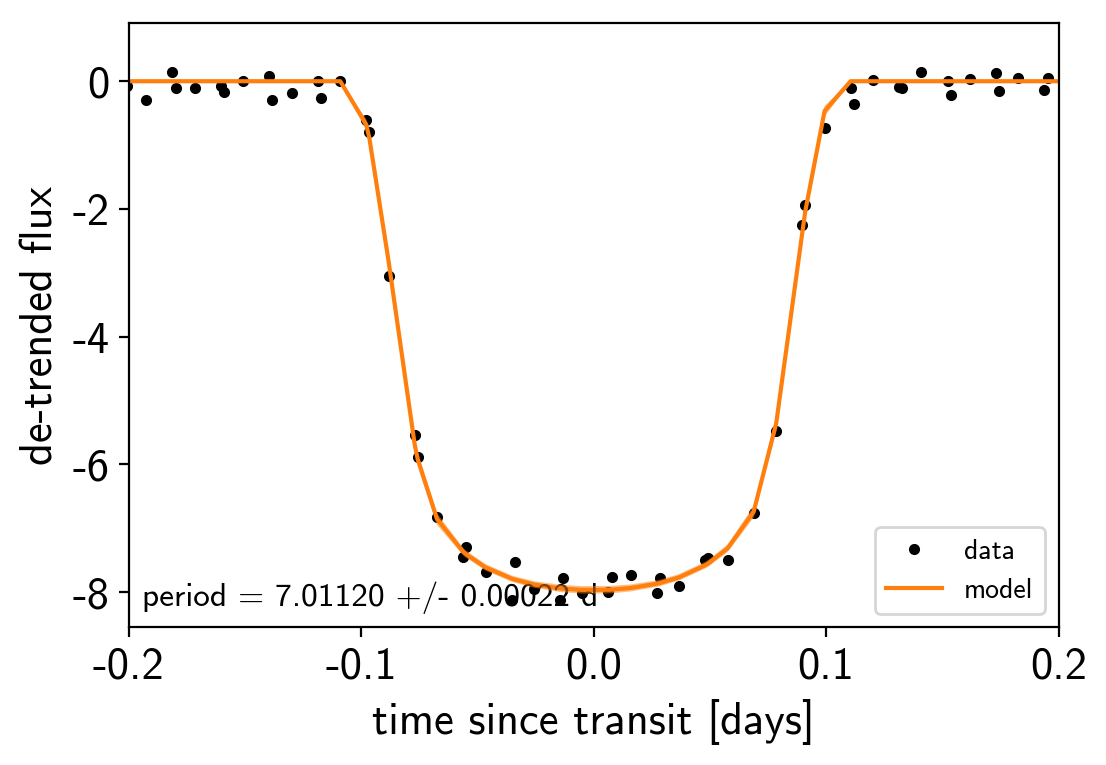

In [17]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.2, 0.2);

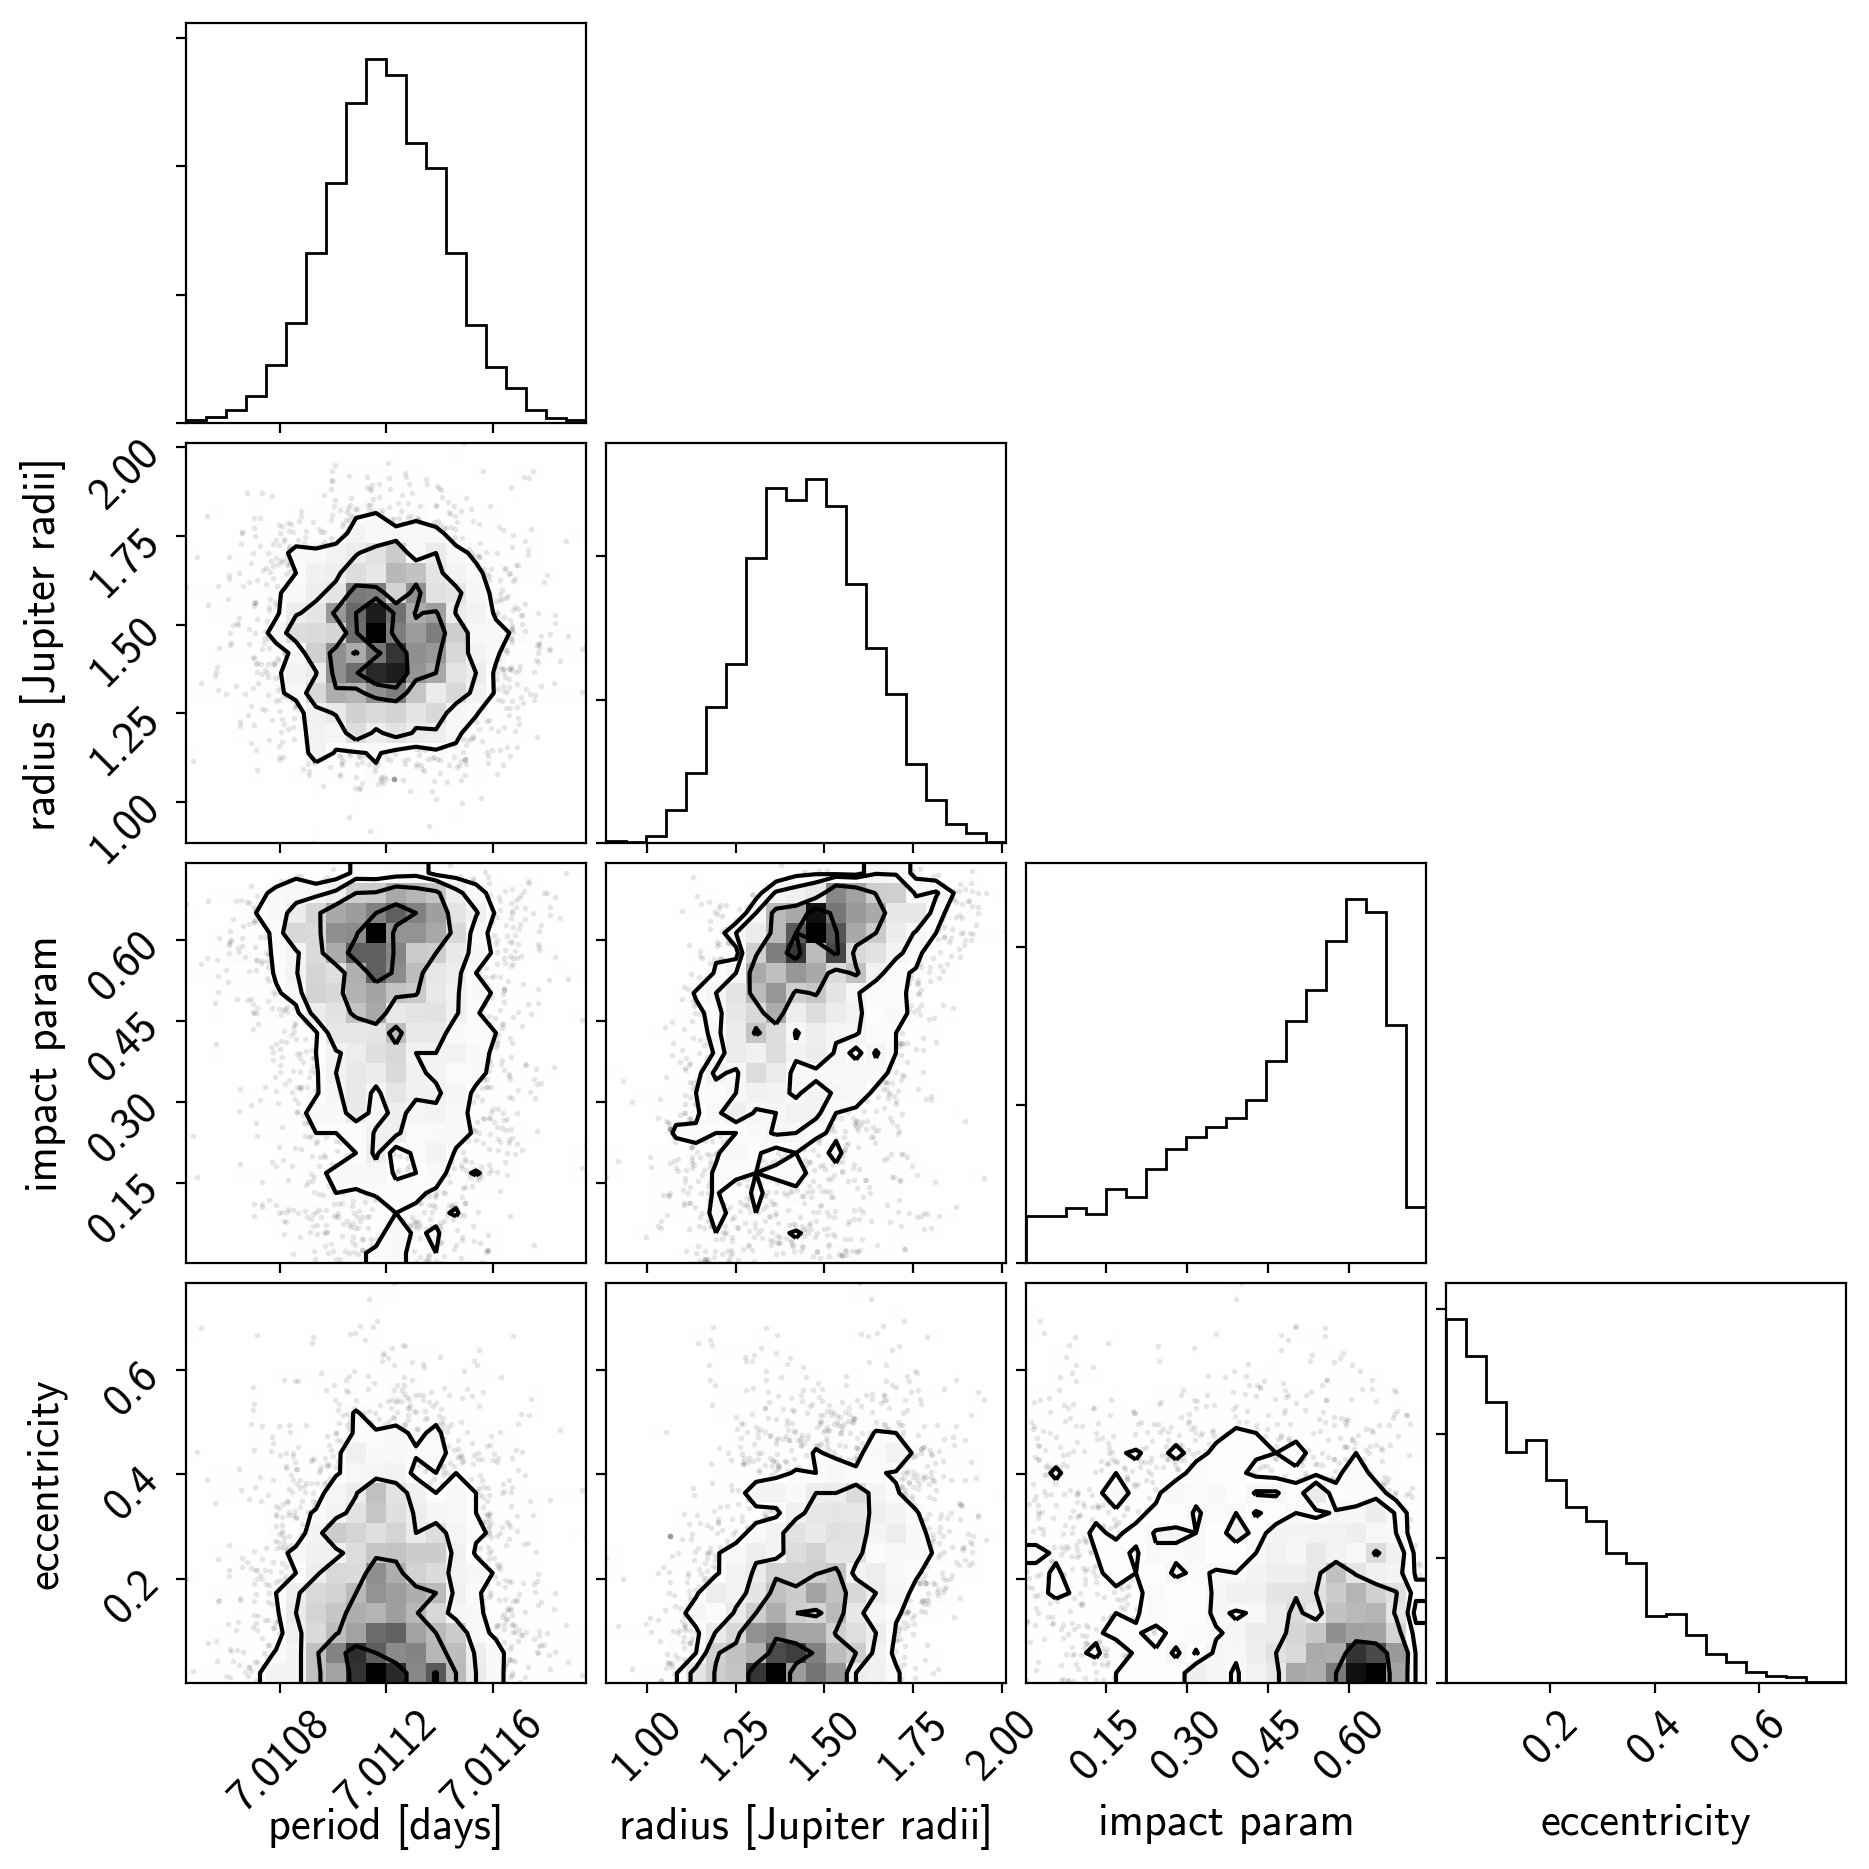

In [18]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_jupiter).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Jupiter radii]", "impact param", "eccentricity"]);

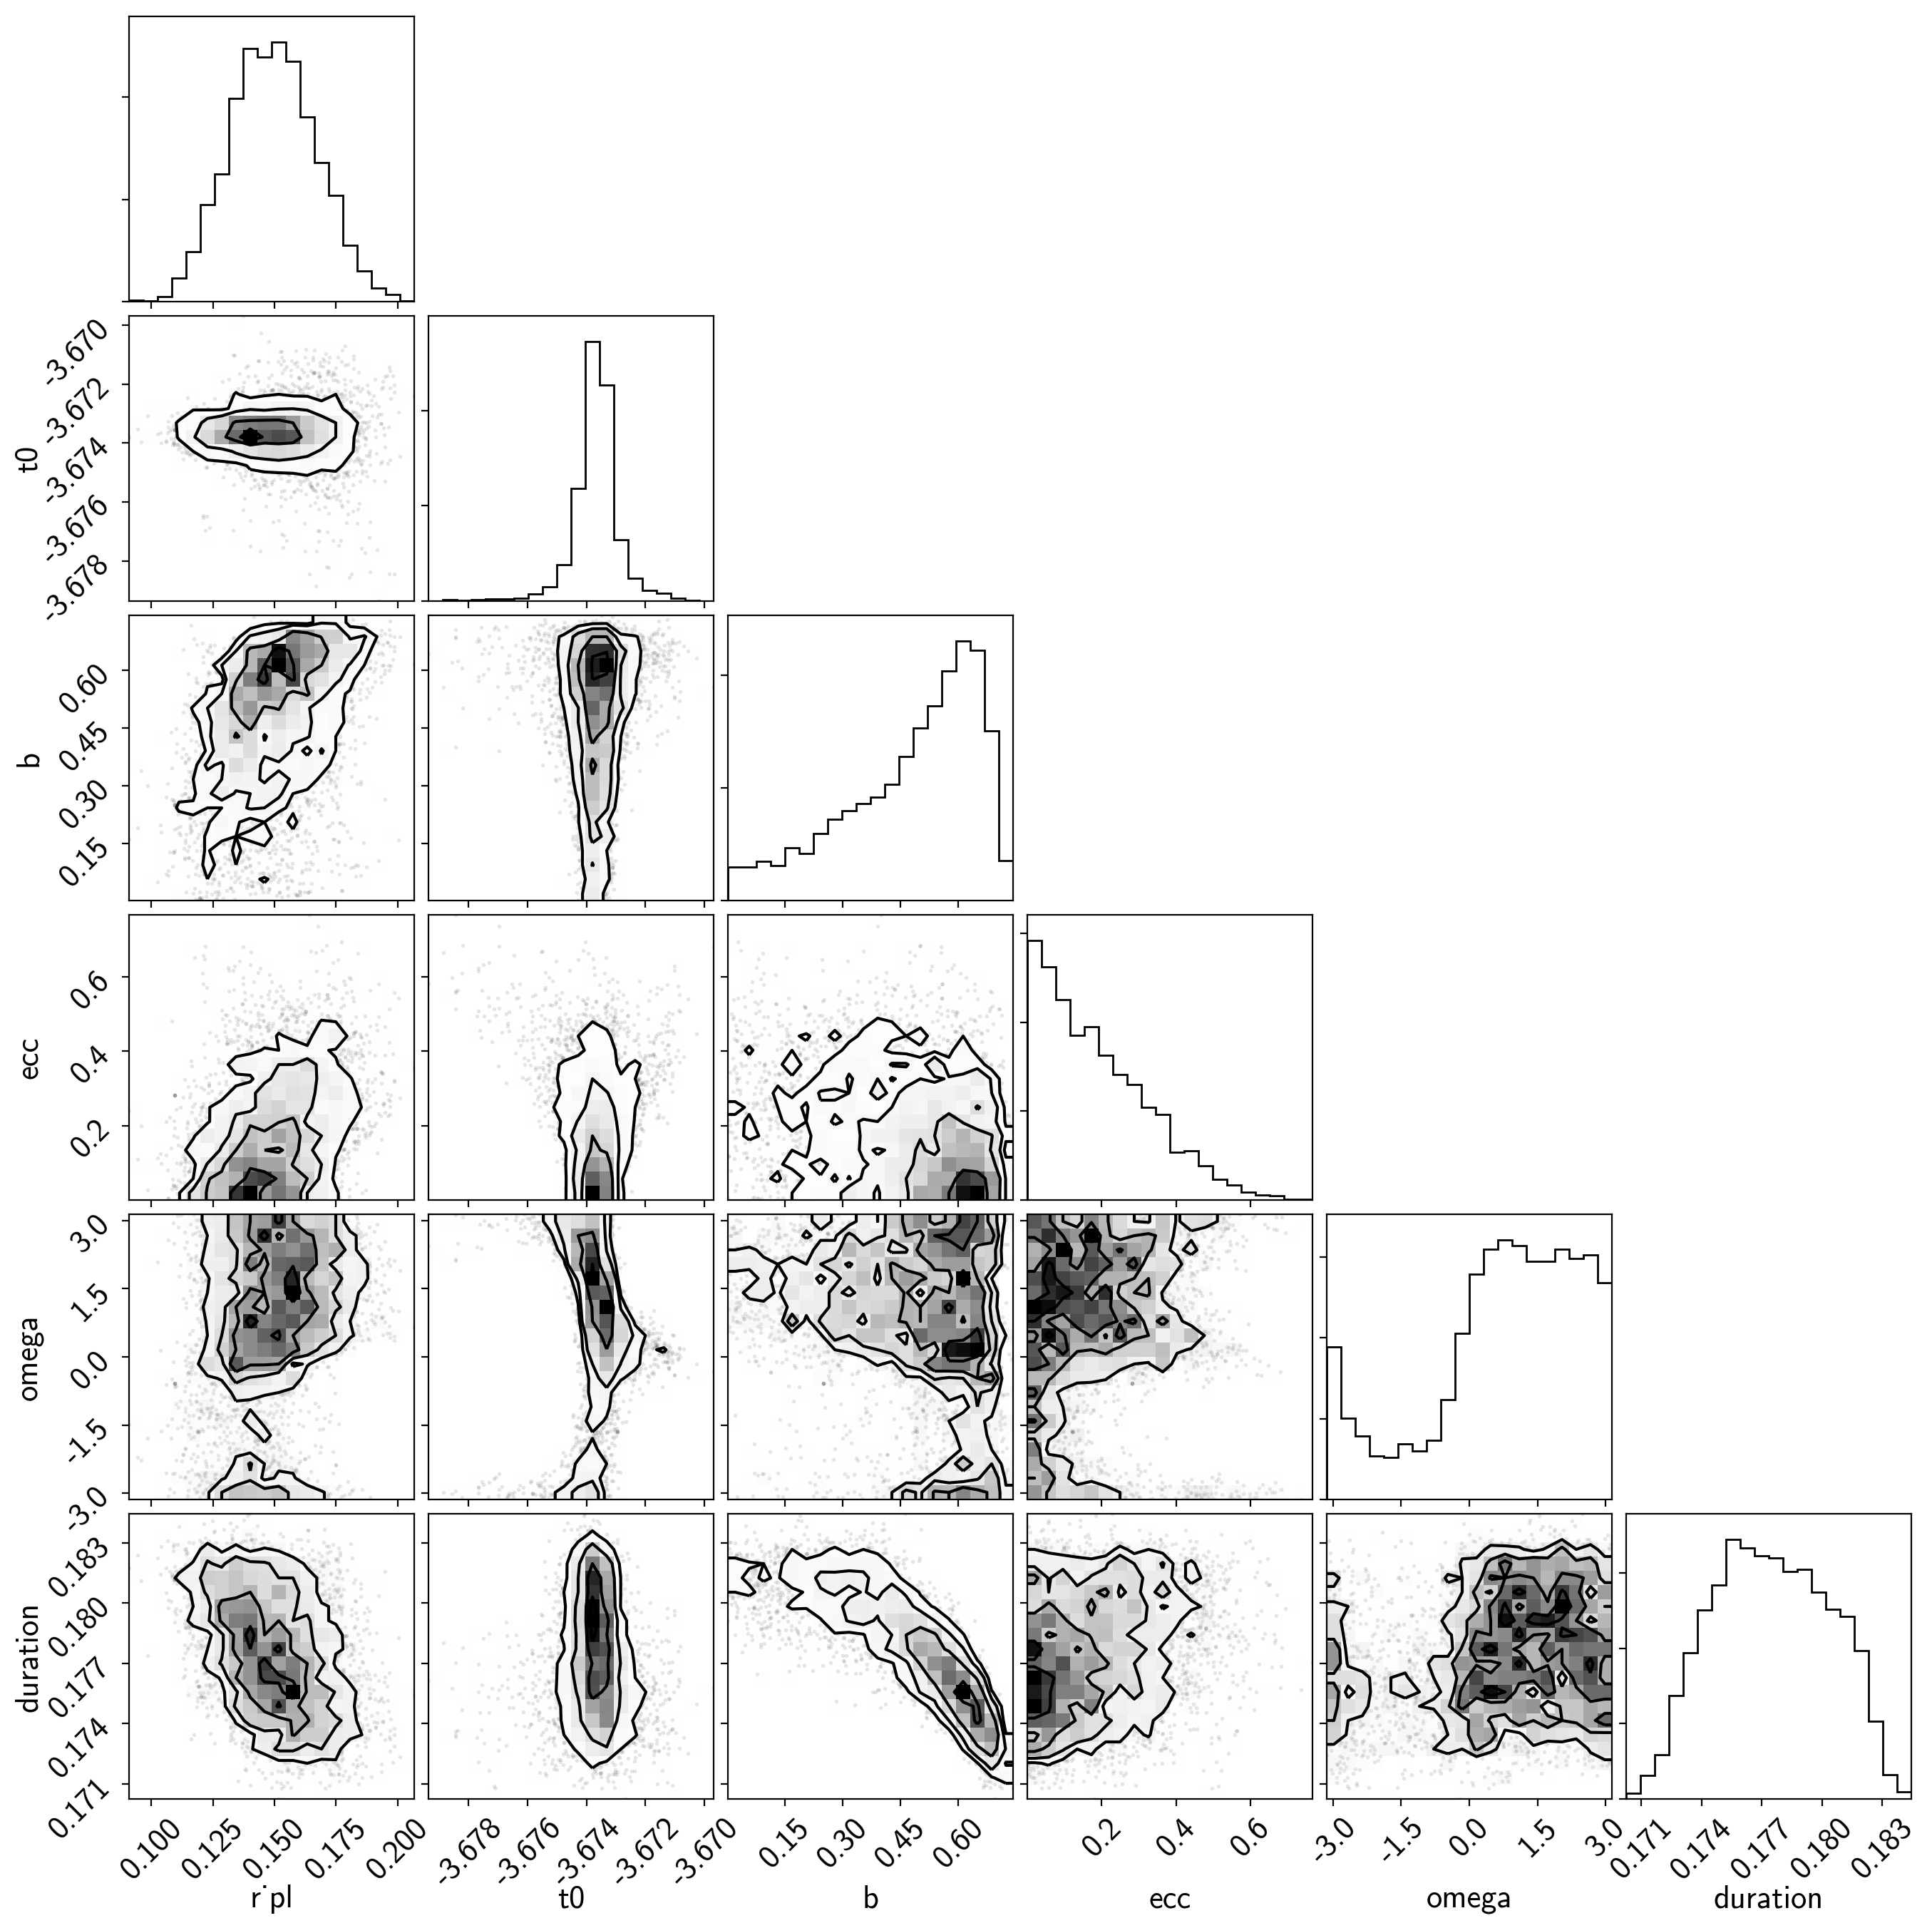

In [19]:
aor = -trace["a"] / trace["r_star"]
e = trace["ecc"]
w = trace["omega"]
i = trace["incl"]
b = trace["b"]
k = trace["r_pl"] / trace["r_star"]
P = trace["period"]

T_tot = P/np.pi * np.arcsin(np.sqrt(1 - b**2) / np.sin(i) / aor)
dur = T_tot * np.sqrt(1 - e**2) / (1 + e * np.sin(w))

samples = pm.trace_to_dataframe(trace, varnames=["r_pl", "t0", "b", "ecc", "omega"])
samples["duration"] = dur
corner.corner(samples);